# Car Dataset Preparation 

The following notebook is used to prepare the car image dataset for modelling purposes.

The notebook uses the ```imgaug``` library which provides image augementation capabilities.

The workflow which is used in this notebook is as followed:

- Load the original dataset from the S3 location
- Convert the dataset into the imgaug structure (numpy arrays)
- Perform Augmentation using sequential pipeline and multicore processing
- Export Data back to S3 Bucket

### Imports

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import io
import numpy as np
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import imgaug as ia
from os import listdir
from os.path import isfile, join
from imgaug import augmenters as iaa
from imgaug.augmentables.batches import UnnormalizedBatch
from PIL import Image
from matplotlib.pyplot import imshow as mpimshow

### Constant Setting

First we need to set up our constants which will be used throughout the data augmentation process

In [2]:
# NOTE: S3 bucket name must begin with "deeplens-" for DeepLens deployment
bucket_name='dataset-cars-damage'
prefix = '' #only use this if you want to have your files in a folder 
dataset_filename = 'car-damage-dataset.zip'
dataset_unpacked_dir = 'car-damage-dataset/'

### Environment Setup

In [3]:
def setup_env():
    
    role = get_execution_role()

    sess = sagemaker.Session()

    
    AWS_REGION = 'us-east-1'
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(bucket_name)

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
    return role, sess, AWS_REGION, s3,s3_bucket

role, sess,  AWS_REGION, s3, s3_bucket = setup_env()

Bucket already exists


### Load Images for Data Preparation

Load existing image data from the corresponding S3 bucket. take note the method below is specific to the structure of the data storage paths (training/validation), and the image types (JPEG). If changes to these paths are made, the code will need to reflect this.

The Method contains a try/except which creates the tmp folders which currently do not exist. This is necessary in order to store the files locally as the S3 key names contain '/' which on a traditional filesystem represents a folder, however on s3 folders are only virtual

In [4]:
def download_and_store_images_for_prep(bucket_name, s3):
    
    manifest_train = []
    manifest_val = []
    data_dir = 'tmp_data/'
    training_dir = 'training'
    idx = 0
    conn = boto3.client('s3')  # again assumes boto.cfg setup, assume AWS S3
    
    for file in s3_bucket.objects.all():#(Bucket=bucket_name, Prefix=data_path)['Contents']:
        path = file.key
        if ('.JPEG' in path) or ('.jpeg' in path):
            folders = path.split('/')
            folder_path = 'tmp_data/'
            for i in range(0, len(folders)-1):
                #check if folder or dir
                folder = folders[i]
                if '.' not in folder:
                    folder_path = folder_path + folder + '/'
                    try:
                        os.mkdir(folder_path)
                        print(folder_path)
                    except:
                        pass
            print('Adding File {}'.format(path))
            s3_bucket.download_file(
            path, data_dir+path)
    
            
download_and_store_images_for_prep(bucket_name, s3)

Adding File validation/damage-val-0001.JPEG
Adding File validation/damage-val-0002.JPEG
Adding File validation/damage-val-0003.JPEG
Adding File validation/damage-val-0004.JPEG
Adding File validation/damage-val-0005.JPEG
Adding File validation/damage-val-0006.JPEG
Adding File validation/damage-val-0007.JPEG
Adding File validation/damage-val-0008.JPEG
Adding File validation/damage-val-0009.JPEG
Adding File validation/damage-val-0010.JPEG
Adding File validation/damage-val-0011.JPEG
Adding File validation/damage-val-0012.JPEG
Adding File validation/damage-val-0013.JPEG
Adding File validation/damage-val-0014.JPEG
Adding File validation/damage-val-0015.JPEG
Adding File validation/damage-val-0016.JPEG
Adding File validation/damage-val-0017.JPEG
Adding File validation/damage-val-0018.JPEG
Adding File validation/damage-val-0019.JPEG
Adding File validation/damage-val-0020.JPEG
Adding File validation/damage-val-0021.JPEG
Adding File validation/damage-val-0022.JPEG
Adding File validation/damage-va

Adding File validation/damage-val-0190.JPEG
Adding File validation/damage-val-0191.JPEG
Adding File validation/damage-val-0192.JPEG
Adding File validation/damage-val-0193.JPEG
Adding File validation/damage-val-0194.JPEG
Adding File validation/damage-val-0195.JPEG
Adding File validation/damage-val-0196.JPEG
Adding File validation/damage-val-0197.JPEG
Adding File validation/damage-val-0198.JPEG
Adding File validation/damage-val-0199.JPEG
Adding File validation/damage-val-0200.JPEG
Adding File validation/damage-val-0201.jpeg
Adding File validation/damage-val-0202.JPEG
Adding File validation/damage-val-0203.JPEG
Adding File validation/damage-val-0204.JPEG
Adding File validation/damage-val-0205.JPEG
Adding File validation/damage-val-0206.JPEG
Adding File validation/damage-val-0207.JPEG
Adding File validation/damage-val-0208.JPEG
Adding File validation/damage-val-0209.JPEG
Adding File validation/damage-val-0210.JPEG
Adding File validation/damage-val-0211.JPEG
Adding File validation/damage-va

###  Load the files for Augmentation

In order to load the data for augmentation purposes, we need to convert each of the files to the corresponding numpy array struture. We also want to store the corrsponding filenames so we have a reference to reingest the data when we have completed the augmentation process


In [4]:
def load_files_for_augmentation():
    data_dir = 'tmp_data'
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(data_dir):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    print(len(listOfFiles))
    
    images = []
    filenames = []
    for image in listOfFiles:
        try:
            image_data = imageio.imread(image)
            images.append(image_data)
            filenames.append(image)
        except:
            print('error loading image')
    return images, filenames

images, filenames = load_files_for_augmentation()


1307


### Simple Augmentor (Test) 

Take the images, and demonstrate a simple augmentation process to ensure the data we have is working. 

Original


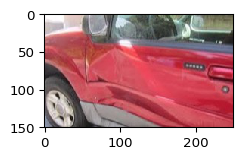

Augmented:


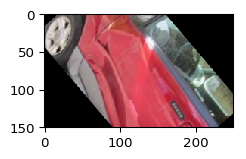

In [5]:
def augment_images(images):
    ia.seed(4)

    for image in images:

        rotate = iaa.Affine(rotate=(-125, 125))
        image_aug = rotate.augment_image(image)
        print('Original')
        ia.imshow(image)

        print("Augmented:")
        ia.imshow(image_aug)

        break
        
augment_images(images)

### Complex Augmentor

The complex augmentor is used to create many different variations of the same image, with different types of augmentation patterns. 

As this process requires a lot of processing, a multicore approach is used. 

- **```batches```** - This represents the number of permetations of the same data you wish to create. 

In [6]:
#multithreaded complex augmenter
def complex_augmenter(images, batches = 100):
    # random example images
    
    #multicore
    NB_BATCHES = batches

    batches = [UnnormalizedBatch(images=images) for _ in range(NB_BATCHES)]


    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
    sometimes = lambda aug: iaa.Sometimes(1, aug)

    # Define our sequence of augmentation steps that will be applied to every image
    # All augmenters with per_channel=0.5 will sample one value _per image_
    # in 50% of all cases. In all other cases they will sample new values
    # _per channel_.

    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45), # rotate by -45 to +45 degrees
                shear=(-16, 16), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                    ]),
                    iaa.Invert(0.05, per_channel=True), # invert color channels
                    iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.5, 1.5), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-4, 0),
                            first=iaa.Multiply((0.5, 1.5), per_channel=True),
                            second=iaa.LinearContrast((0.5, 2.0))
                        )
                    ]),
                    iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                    iaa.Grayscale(alpha=(0.0, 1.0)),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=False
            )
        ],
        random_order=False
    )
    batches_aug = list(seq.augment_batches(batches, background=True))

    return batches_aug

batches_aug = complex_augmenter(images)

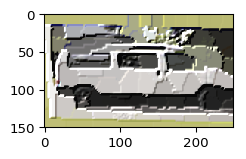

In [8]:
ia.imshow(batches_aug[99].images_aug[1306])

### Export Data to S3

After createing our augmentations, we need to export them back to the original S3 bucket. the following methods allow us to regenerate the filenames of the newly augmented images, with reference back to the original image

In [9]:
def generate_augementations(batches_aug, filenames):
    
    augmentations =[]
    for i in range(0, len(batches_aug)):
        print('Generating Batch {}'.format(i))
        aug_batch = {}
        images_aug = batches_aug[i].images_aug
        for j in range(0, len(images_aug)):
            filename = filenames[j].lower().replace('.jpeg','').replace('.jpg','')
            filename_aug = filename+'-augmented-'+str(i)+'.JPEG'
#             print(filename_aug)
            aug_batch[filename_aug] = images_aug[j]
#             print(j)
        augmentations.append(aug_batch)
    return augmentations

augmentations = generate_augementations(batches_aug, filenames )

Generating Batch 0
Generating Batch 1
Generating Batch 2
Generating Batch 3
Generating Batch 4
Generating Batch 5
Generating Batch 6
Generating Batch 7
Generating Batch 8
Generating Batch 9
Generating Batch 10
Generating Batch 11
Generating Batch 12
Generating Batch 13
Generating Batch 14
Generating Batch 15
Generating Batch 16
Generating Batch 17
Generating Batch 18
Generating Batch 19
Generating Batch 20
Generating Batch 21
Generating Batch 22
Generating Batch 23
Generating Batch 24
Generating Batch 25
Generating Batch 26
Generating Batch 27
Generating Batch 28
Generating Batch 29
Generating Batch 30
Generating Batch 31
Generating Batch 32
Generating Batch 33
Generating Batch 34
Generating Batch 35
Generating Batch 36
Generating Batch 37
Generating Batch 38
Generating Batch 39
Generating Batch 40
Generating Batch 41
Generating Batch 42
Generating Batch 43
Generating Batch 44
Generating Batch 45
Generating Batch 46
Generating Batch 47
Generating Batch 48
Generating Batch 49
Generating

In [11]:
def check_augmentation_details(augmentations):
    
    print('{} Batches'.format(len(augmentations)))
    cnt = 0
    for batch in augmentations:
        cnt += len(batch)
    print('{} Augmentations'.format(cnt))
    
check_augmentation_details(augmentations)

100 Batches
130700 Augmentations


In [12]:
def export_data_to_s3(s3_bucket, images):
    
    print('Exporting Data To S3')
    for k,v in images.items():
#         s3_path = 'augmented/'+k
        if 'training/' in k:
            s3_path = k.replace('tmp_data/training/', 'training/augmented/')
        if 'validation/' in k:
            s3_path = k.replace('tmp_data/validation/', 'validation/augmented/')
        print(s3_path)
        im = modify_image(v, 'JPEG')

        s3_bucket.put_object(Key=s3_path, Body = im)
        
#convert to bytes so no need to store on local first!
def modify_image(image, file_format):

    pil_image = Image.fromarray(image)

    in_mem_file = io.BytesIO()

    # format here would be something like "JPEG". See below link for more info.
    pil_image.save(in_mem_file, format=file_format)
    return in_mem_file.getvalue()
 

In [15]:
#iterate through all the augmented datas and save to bucket.  
def generate_and_export_data(s3_bucket, augmentations, filenames):
    
    for i in range(1, len(augmentations)):
        augs = augmentations[i]
        export_data_to_s3(s3_bucket, augs)
        

In [ ]:
generate_and_export_data(s3_bucket, augmentations, filenames)

Exporting Data To S3
validation/augmented/damage-val-0033-augmented-1.JPEG
validation/augmented/damage-val-0079-augmented-1.JPEG
validation/augmented/damage-val-0020-augmented-1.JPEG
validation/augmented/whole-val-0203-augmented-1.JPEG
validation/augmented/damage-val-0064-augmented-1.JPEG
validation/augmented/damage-val-0169-augmented-1.JPEG
validation/augmented/damage-val-0111-augmented-1.JPEG
validation/augmented/damage-val-0157-augmented-1.JPEG
validation/augmented/damage-val-0016-augmented-1.JPEG
validation/augmented/damage-val-0041-augmented-1.JPEG
validation/augmented/damage-val-0175-augmented-1.JPEG
validation/augmented/damage-val-0091-augmented-1.JPEG
validation/augmented/damage-val-0021-augmented-1.JPEG
validation/augmented/damage-val-0224-augmented-1.JPEG
validation/augmented/damage-val-0037-augmented-1.JPEG
validation/augmented/whole-val-0215-augmented-1.JPEG
validation/augmented/damage-val-0002-augmented-1.JPEG
validation/augmented/damage-val-0187-augmented-1.JPEG
validatio

validation/augmented/damage-val-0084-augmented-1.JPEG
validation/augmented/damage-val-0144-augmented-1.JPEG
validation/augmented/damage-val-0150-augmented-1.JPEG
validation/augmented/damage-val-0209-augmented-1.JPEG
validation/augmented/damage-val-0223-augmented-1.JPEG
validation/augmented/whole-val-0204-augmented-1.JPEG
validation/augmented/damage-val-0100-augmented-1.JPEG
validation/augmented/damage-val-0062-augmented-1.JPEG
validation/augmented/damage-val-0177-augmented-1.JPEG
validation/augmented/damage-val-0060-augmented-1.JPEG
validation/augmented/damage-val-0154-augmented-1.JPEG
validation/augmented/damage-val-0138-augmented-1.JPEG
validation/augmented/whole-val-0227-augmented-1.JPEG
validation/augmented/damage-val-0094-augmented-1.JPEG
validation/augmented/damage-val-0032-augmented-1.JPEG
validation/augmented/damage-val-0074-augmented-1.JPEG
validation/augmented/damage-val-0029-augmented-1.JPEG
validation/augmented/damage-val-0097-augmented-1.JPEG
validation/augmented/damage-va

training/augmented/damage-damage-train-0082-augmented-1.JPEG
training/augmented/damage-damage-train-0771-augmented-1.JPEG
training/augmented/damage-damage-train-0367-augmented-1.JPEG
training/augmented/damage-damage-train-0087-augmented-1.JPEG
training/augmented/damage-damage-train-0133-augmented-1.JPEG
training/augmented/damage-damage-train-0085-augmented-1.JPEG
training/augmented/damage-damage-train-0659-augmented-1.JPEG
training/augmented/whole-train-0796-augmented-1.JPEG
training/augmented/damage-damage-train-0916-augmented-1.JPEG
training/augmented/damage-damage-train-0469-augmented-1.JPEG
training/augmented/whole-train-0855-augmented-1.JPEG
training/augmented/damage-damage-train-0432-augmented-1.JPEG
training/augmented/damage-damage-train-0333-augmented-1.JPEG
training/augmented/damage-damage-train-0893-augmented-1.JPEG
training/augmented/damage-damage-train-0057-augmented-1.JPEG
training/augmented/whole-train-0830-augmented-1.JPEG
training/augmented/damage-damage-train-0450-augm

training/augmented/damage-damage-train-0411-augmented-1.JPEG
training/augmented/damage-damage-train-0302-augmented-1.JPEG
training/augmented/damage-damage-train-0374-augmented-1.JPEG
training/augmented/damage-damage-train-0279-augmented-1.JPEG
training/augmented/whole-train-0893-augmented-1.JPEG
training/augmented/damage-damage-train-0426-augmented-1.JPEG
training/augmented/damage-damage-train-0920-augmented-1.JPEG
training/augmented/damage-damage-train-0034-augmented-1.JPEG
training/augmented/damage-damage-train-0032-augmented-1.JPEG
training/augmented/damage-damage-train-0434-augmented-1.JPEG
training/augmented/damage-damage-train-0457-augmented-1.JPEG
training/augmented/damage-damage-train-0525-augmented-1.JPEG
training/augmented/damage-damage-train-0303-augmented-1.JPEG
training/augmented/whole-train-0835-augmented-1.JPEG
training/augmented/damage-damage-train-0297-augmented-1.JPEG
training/augmented/damage-damage-train-0806-augmented-1.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0693-augmented-1.JPEG
training/augmented/whole-train-0848-augmented-1.JPEG
training/augmented/damage-damage-train-0748-augmented-1.JPEG
training/augmented/damage-damage-train-0848-augmented-1.JPEG
training/augmented/damage-damage-train-0397-augmented-1.JPEG
training/augmented/damage-damage-train-0007-augmented-1.JPEG
training/augmented/damage-damage-train-0052-augmented-1.JPEG
training/augmented/damage-damage-train-0010-augmented-1.JPEG
training/augmented/damage-damage-train-0640-augmented-1.JPEG
training/augmented/damage-damage-train-0545-augmented-1.JPEG
training/augmented/damage-damage-train-0225-augmented-1.JPEG
training/augmented/damage-damage-train-0708-augmented-1.JPEG
training/augmented/damage-damage-train-0204-augmented-1.JPEG
training/augmented/whole-train-0905-augmented-1.JPEG
training/augmented/damage-damage-train-0903-augmented-1.JPEG
training/augmented/damage-damage-train-0780-augmented-1.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0915-augmented-1.JPEG
training/augmented/damage-damage-train-0601-augmented-1.JPEG
training/augmented/damage-damage-train-0398-augmented-1.JPEG
training/augmented/damage-damage-train-0854-augmented-1.JPEG
training/augmented/damage-damage-train-0839-augmented-1.JPEG
training/augmented/damage-damage-train-0246-augmented-1.JPEG
training/augmented/damage-damage-train-0886-augmented-1.JPEG
training/augmented/damage-damage-train-0395-augmented-1.JPEG
training/augmented/damage-damage-train-0775-augmented-1.JPEG
training/augmented/damage-damage-train-0863-augmented-1.JPEG
training/augmented/damage-damage-train-0830-augmented-1.JPEG
training/augmented/damage-damage-train-0039-augmented-1.JPEG
training/augmented/damage-damage-train-0571-augmented-1.JPEG
training/augmented/damage-damage-train-0485-augmented-1.JPEG
training/augmented/damage-damage-train-0021-augmented-1.JPEG
training/augmented/damage-damage-train-0822-augmented-1.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0460-augmented-1.JPEG
training/augmented/whole-train-0891-augmented-1.JPEG
training/augmented/damage-damage-train-0365-augmented-1.JPEG
training/augmented/damage-damage-train-0234-augmented-1.JPEG
training/augmented/damage-damage-train-0723-augmented-1.JPEG
training/augmented/damage-damage-train-0478-augmented-1.JPEG
training/augmented/damage-damage-train-0180-augmented-1.JPEG
training/augmented/damage-damage-train-0336-augmented-1.JPEG
training/augmented/damage-damage-train-0118-augmented-1.JPEG
training/augmented/damage-damage-train-0569-augmented-1.JPEG
training/augmented/damage-damage-train-0115-augmented-1.JPEG
training/augmented/damage-damage-train-0283-augmented-1.JPEG
training/augmented/damage-damage-train-0257-augmented-1.JPEG
training/augmented/whole-train-0825-augmented-1.JPEG
training/augmented/damage-damage-train-0255-augmented-1.JPEG
training/augmented/damage-damage-train-0645-augmented-1.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0882-augmented-1.JPEG
training/augmented/whole-train-0908-augmented-1.JPEG
training/augmented/damage-damage-train-0313-augmented-1.JPEG
training/augmented/damage-damage-train-0508-augmented-1.JPEG
training/augmented/damage-damage-train-0750-augmented-1.JPEG
training/augmented/damage-damage-train-0656-augmented-1.JPEG
training/augmented/damage-damage-train-0788-augmented-1.JPEG
training/augmented/damage-damage-train-0314-augmented-1.JPEG
training/augmented/damage-damage-train-0029-augmented-1.JPEG
training/augmented/damage-damage-train-0202-augmented-1.JPEG
training/augmented/damage-damage-train-0352-augmented-1.JPEG
training/augmented/damage-damage-train-0260-augmented-1.JPEG
training/augmented/whole-train-0843-augmented-1.JPEG
training/augmented/damage-damage-train-0347-augmented-1.JPEG
training/augmented/damage-damage-train-0728-augmented-1.JPEG
training/augmented/damage-damage-train-0296-augmented-1.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0824-augmented-1.JPEG
training/augmented/damage-damage-train-0305-augmented-1.JPEG
training/augmented/damage-damage-train-0521-augmented-1.JPEG
training/augmented/damage-damage-train-0682-augmented-1.JPEG
training/augmented/damage-damage-train-0182-augmented-1.JPEG
training/augmented/damage-damage-train-0199-augmented-1.JPEG
training/augmented/damage-damage-train-0538-augmented-1.JPEG
training/augmented/damage-damage-train-0094-augmented-1.JPEG
training/augmented/damage-damage-train-0240-augmented-1.JPEG
training/augmented/whole-train-0889-augmented-1.JPEG
training/augmented/damage-damage-train-0841-augmented-1.JPEG
training/augmented/damage-damage-train-0675-augmented-1.JPEG
training/augmented/damage-damage-train-0329-augmented-1.JPEG
training/augmented/damage-damage-train-0713-augmented-1.JPEG
training/augmented/whole-train-0801-augmented-1.JPEG
training/augmented/damage-damage-train-0667-augmented-1.JPEG
training/augmented/whole-train-0836-augm

training/augmented/damage-damage-train-0359-augmented-1.JPEG
training/augmented/damage-damage-train-0341-augmented-1.JPEG
training/augmented/damage-damage-train-0278-augmented-1.JPEG
training/augmented/whole-train-0799-augmented-1.JPEG
training/augmented/damage-damage-train-0262-augmented-1.JPEG
training/augmented/damage-damage-train-0887-augmented-1.JPEG
training/augmented/damage-damage-train-0828-augmented-1.JPEG
training/augmented/damage-damage-train-0322-augmented-1.JPEG
training/augmented/damage-damage-train-0389-augmented-1.JPEG
training/augmented/damage-damage-train-0799-augmented-1.JPEG
training/augmented/damage-damage-train-0767-augmented-1.JPEG
training/augmented/damage-damage-train-0243-augmented-1.JPEG
training/augmented/damage-damage-train-0166-augmented-1.JPEG
training/augmented/damage-damage-train-0176-augmented-1.JPEG
training/augmented/damage-damage-train-0464-augmented-1.JPEG
training/augmented/damage-damage-train-0866-augmented-1.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0107-augmented-2.JPEG
validation/augmented/damage-val-0214-augmented-2.JPEG
validation/augmented/damage-val-0152-augmented-2.JPEG
validation/augmented/damage-val-0011-augmented-2.JPEG
validation/augmented/damage-val-0151-augmented-2.JPEG
validation/augmented/whole-val-0205-augmented-2.JPEG
validation/augmented/damage-val-0081-augmented-2.JPEG
validation/augmented/damage-val-0197-augmented-2.JPEG
validation/augmented/damage-val-0219-augmented-2.JPEG
validation/augmented/damage-val-0024-augmented-2.JPEG
validation/augmented/damage-val-0189-augmented-2.JPEG
validation/augmented/damage-val-0146-augmented-2.JPEG
validation/augmented/damage-val-0213-augmented-2.JPEG
validation/augmented/damage-val-0141-augmented-2.JPEG
validation/augmented/damage-val-0145-augmented-2.JPEG
validation/augmented/damage-val-0199-augmented-2.JPEG
validation/augmented/damage-val-0019-augmented-2.JPEG
validation/augmented/damage-val-0086-augmented-2.JPEG
validation/augmented/whole-va

training/augmented/damage-damage-train-0247-augmented-2.JPEG
training/augmented/whole-train-0806-augmented-2.JPEG
training/augmented/damage-damage-train-0206-augmented-2.JPEG
training/augmented/damage-damage-train-0651-augmented-2.JPEG
training/augmented/whole-train-0854-augmented-2.JPEG
training/augmented/damage-damage-train-0911-augmented-2.JPEG
training/augmented/damage-damage-train-0533-augmented-2.JPEG
training/augmented/damage-damage-train-0265-augmented-2.JPEG
training/augmented/damage-damage-train-0371-augmented-2.JPEG
training/augmented/damage-damage-train-0143-augmented-2.JPEG
training/augmented/whole-train-0874-augmented-2.JPEG
training/augmented/damage-damage-train-0354-augmented-2.JPEG
training/augmented/damage-damage-train-0093-augmented-2.JPEG
training/augmented/damage-damage-train-0070-augmented-2.JPEG
training/augmented/damage-damage-train-0753-augmented-2.JPEG
training/augmented/damage-damage-train-0590-augmented-2.JPEG
training/augmented/damage-damage-train-0095-augm

training/augmented/damage-damage-train-0209-augmented-2.JPEG
training/augmented/damage-damage-train-0418-augmented-2.JPEG
training/augmented/damage-damage-train-0400-augmented-2.JPEG
training/augmented/damage-damage-train-0766-augmented-2.JPEG
training/augmented/whole-train-0907-augmented-2.JPEG
training/augmented/damage-damage-train-0648-augmented-2.JPEG
training/augmented/damage-damage-train-0498-augmented-2.JPEG
training/augmented/damage-damage-train-0392-augmented-2.JPEG
training/augmented/damage-damage-train-0487-augmented-2.JPEG
training/augmented/damage-damage-train-0022-augmented-2.JPEG
training/augmented/damage-damage-train-0155-augmented-2.JPEG
training/augmented/damage-damage-train-0064-augmented-2.JPEG
training/augmented/damage-damage-train-0284-augmented-2.JPEG
training/augmented/damage-damage-train-0529-augmented-2.JPEG
training/augmented/damage-damage-train-0663-augmented-2.JPEG
training/augmented/damage-damage-train-0668-augmented-2.JPEG
training/augmented/whole-train-0

training/augmented/whole-train-0844-augmented-2.JPEG
training/augmented/damage-damage-train-0300-augmented-2.JPEG
training/augmented/damage-damage-train-0738-augmented-2.JPEG
training/augmented/damage-damage-train-0008-augmented-2.JPEG
training/augmented/damage-damage-train-0320-augmented-2.JPEG
training/augmented/whole-train-0867-augmented-2.JPEG
training/augmented/damage-damage-train-0504-augmented-2.JPEG
training/augmented/damage-damage-train-0215-augmented-2.JPEG
training/augmented/damage-damage-train-0742-augmented-2.JPEG
training/augmented/damage-damage-train-0081-augmented-2.JPEG
training/augmented/damage-damage-train-0219-augmented-2.JPEG
training/augmented/damage-damage-train-0453-augmented-2.JPEG
training/augmented/damage-damage-train-0105-augmented-2.JPEG
training/augmented/damage-damage-train-0382-augmented-2.JPEG
training/augmented/damage-damage-train-0001-augmented-2.JPEG
training/augmented/damage-damage-train-0491-augmented-2.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0497-augmented-2.JPEG
training/augmented/damage-damage-train-0891-augmented-2.JPEG
training/augmented/whole-train-0808-augmented-2.JPEG
training/augmented/damage-damage-train-0084-augmented-2.JPEG
training/augmented/damage-damage-train-0135-augmented-2.JPEG
training/augmented/whole-train-0837-augmented-2.JPEG
training/augmented/damage-damage-train-0587-augmented-2.JPEG
training/augmented/damage-damage-train-0535-augmented-2.JPEG
training/augmented/damage-damage-train-0715-augmented-2.JPEG
training/augmented/damage-damage-train-0628-augmented-2.JPEG
training/augmented/damage-damage-train-0042-augmented-2.JPEG
training/augmented/damage-damage-train-0582-augmented-2.JPEG
training/augmented/damage-damage-train-0602-augmented-2.JPEG
training/augmented/damage-damage-train-0475-augmented-2.JPEG
training/augmented/damage-damage-train-0811-augmented-2.JPEG
training/augmented/whole-train-0822-augmented-2.JPEG
training/augmented/damage-damage-train-0584-augm

training/augmented/damage-damage-train-0665-augmented-2.JPEG
training/augmented/damage-damage-train-0894-augmented-2.JPEG
training/augmented/damage-damage-train-0796-augmented-2.JPEG
training/augmented/whole-train-0839-augmented-2.JPEG
training/augmented/damage-damage-train-0519-augmented-2.JPEG
training/augmented/damage-damage-train-0004-augmented-2.JPEG
training/augmented/whole-train-0828-augmented-2.JPEG
training/augmented/damage-damage-train-0898-augmented-2.JPEG
training/augmented/damage-damage-train-0467-augmented-2.JPEG
training/augmented/damage-damage-train-0779-augmented-2.JPEG
training/augmented/whole-train-0842-augmented-2.JPEG
training/augmented/damage-damage-train-0150-augmented-2.JPEG
training/augmented/damage-damage-train-0384-augmented-2.JPEG
training/augmented/damage-damage-train-0131-augmented-2.JPEG
training/augmented/damage-damage-train-0430-augmented-2.JPEG
training/augmented/damage-damage-train-0458-augmented-2.JPEG
training/augmented/damage-damage-train-0632-augm

training/augmented/damage-damage-train-0063-augmented-2.JPEG
training/augmented/damage-damage-train-0344-augmented-2.JPEG
training/augmented/damage-damage-train-0644-augmented-2.JPEG
training/augmented/damage-damage-train-0277-augmented-2.JPEG
training/augmented/damage-damage-train-0429-augmented-2.JPEG
training/augmented/damage-damage-train-0005-augmented-2.JPEG
training/augmented/damage-damage-train-0691-augmented-2.JPEG
training/augmented/damage-damage-train-0677-augmented-2.JPEG
training/augmented/damage-damage-train-0542-augmented-2.JPEG
training/augmented/damage-damage-train-0306-augmented-2.JPEG
training/augmented/damage-damage-train-0777-augmented-2.JPEG
training/augmented/damage-damage-train-0588-augmented-2.JPEG
training/augmented/damage-damage-train-0452-augmented-2.JPEG
training/augmented/damage-damage-train-0288-augmented-2.JPEG
training/augmented/damage-damage-train-0500-augmented-2.JPEG
training/augmented/damage-damage-train-0654-augmented-2.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0179-augmented-2.JPEG
training/augmented/damage-damage-train-0272-augmented-2.JPEG
training/augmented/damage-damage-train-0643-augmented-2.JPEG
training/augmented/damage-damage-train-0904-augmented-2.JPEG
training/augmented/damage-damage-train-0676-augmented-2.JPEG
training/augmented/damage-damage-train-0466-augmented-2.JPEG
training/augmented/whole-train-0857-augmented-2.JPEG
training/augmented/damage-damage-train-0233-augmented-2.JPEG
training/augmented/damage-damage-train-0540-augmented-2.JPEG
training/augmented/damage-damage-train-0681-augmented-2.JPEG
training/augmented/damage-damage-train-0433-augmented-2.JPEG
training/augmented/damage-damage-train-0252-augmented-2.JPEG
training/augmented/damage-damage-train-0567-augmented-2.JPEG
training/augmented/damage-damage-train-0123-augmented-2.JPEG
training/augmented/damage-damage-train-0743-augmented-2.JPEG
training/augmented/damage-damage-train-0026-augmented-2.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0280-augmented-2.JPEG
training/augmented/damage-damage-train-0308-augmented-2.JPEG
training/augmented/damage-damage-train-0338-augmented-2.JPEG
training/augmented/damage-damage-train-0902-augmented-2.JPEG
training/augmented/damage-damage-train-0888-augmented-2.JPEG
training/augmented/damage-damage-train-0661-augmented-2.JPEG
training/augmented/damage-damage-train-0596-augmented-2.JPEG
training/augmented/damage-damage-train-0232-augmented-2.JPEG
training/augmented/damage-damage-train-0091-augmented-2.JPEG
training/augmented/damage-damage-train-0564-augmented-2.JPEG
training/augmented/damage-damage-train-0380-augmented-2.JPEG
training/augmented/damage-damage-train-0595-augmented-2.JPEG
training/augmented/damage-damage-train-0361-augmented-2.JPEG
training/augmented/damage-damage-train-0184-augmented-2.JPEG
training/augmented/damage-damage-train-0484-augmented-2.JPEG
training/augmented/damage-damage-train-0868-augmented-2.JPEG
training/augmented/damag

validation/augmented/damage-val-0018-augmented-3.JPEG
validation/augmented/whole-val-0209-augmented-3.JPEG
validation/augmented/damage-val-0206-augmented-3.JPEG
validation/augmented/damage-val-0222-augmented-3.JPEG
validation/augmented/damage-val-0007-augmented-3.JPEG
validation/augmented/damage-val-0205-augmented-3.JPEG
validation/augmented/damage-val-0208-augmented-3.JPEG
validation/augmented/damage-val-0071-augmented-3.JPEG
validation/augmented/damage-val-0022-augmented-3.JPEG
validation/augmented/whole-val-0222-augmented-3.JPEG
validation/augmented/damage-val-0120-augmented-3.JPEG
validation/augmented/damage-val-0023-augmented-3.JPEG
validation/augmented/damage-val-0089-augmented-3.JPEG
validation/augmented/whole-val-0208-augmented-3.JPEG
validation/augmented/damage-val-0046-augmented-3.JPEG
validation/augmented/damage-val-0059-augmented-3.JPEG
validation/augmented/damage-val-0218-augmented-3.JPEG
validation/augmented/damage-val-0075-augmented-3.JPEG
validation/augmented/damage-val

validation/augmented/damage-val-0080-augmented-3.JPEG
validation/augmented/damage-val-0135-augmented-3.JPEG
validation/augmented/damage-val-0045-augmented-3.JPEG
validation/augmented/damage-val-0068-augmented-3.JPEG
validation/augmented/damage-val-0072-augmented-3.JPEG
validation/augmented/damage-val-0087-augmented-3.JPEG
validation/augmented/damage-val-0121-augmented-3.JPEG
validation/augmented/damage-val-0184-augmented-3.JPEG
validation/augmented/damage-val-0119-augmented-3.JPEG
validation/augmented/damage-val-0053-augmented-3.JPEG
validation/augmented/damage-val-0026-augmented-3.JPEG
validation/augmented/damage-val-0188-augmented-3.JPEG
validation/augmented/whole-val-0202-augmented-3.JPEG
validation/augmented/whole-val-0225-augmented-3.JPEG
validation/augmented/damage-val-0102-augmented-3.JPEG
validation/augmented/damage-val-0055-augmented-3.JPEG
validation/augmented/damage-val-0136-augmented-3.JPEG
validation/augmented/damage-val-0202-augmented-3.JPEG
validation/augmented/damage-va

training/augmented/damage-damage-train-0589-augmented-3.JPEG
training/augmented/damage-damage-train-0438-augmented-3.JPEG
training/augmented/damage-damage-train-0390-augmented-3.JPEG
training/augmented/damage-damage-train-0700-augmented-3.JPEG
training/augmented/damage-damage-train-0096-augmented-3.JPEG
training/augmented/damage-damage-train-0702-augmented-3.JPEG
training/augmented/damage-damage-train-0381-augmented-3.JPEG
training/augmented/whole-train-0818-augmented-3.JPEG
training/augmented/damage-damage-train-0735-augmented-3.JPEG
training/augmented/damage-damage-train-0276-augmented-3.JPEG
training/augmented/damage-damage-train-0116-augmented-3.JPEG
training/augmented/damage-damage-train-0890-augmented-3.JPEG
training/augmented/damage-damage-train-0852-augmented-3.JPEG
training/augmented/damage-damage-train-0873-augmented-3.JPEG
training/augmented/damage-damage-train-0913-augmented-3.JPEG
training/augmented/whole-train-0811-augmented-3.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0331-augmented-3.JPEG
training/augmented/damage-damage-train-0752-augmented-3.JPEG
training/augmented/damage-damage-train-0067-augmented-3.JPEG
training/augmented/damage-damage-train-0889-augmented-3.JPEG
training/augmented/damage-damage-train-0471-augmented-3.JPEG
training/augmented/damage-damage-train-0013-augmented-3.JPEG
training/augmented/damage-damage-train-0258-augmented-3.JPEG
training/augmented/damage-damage-train-0646-augmented-3.JPEG
training/augmented/damage-damage-train-0812-augmented-3.JPEG
training/augmented/damage-damage-train-0744-augmented-3.JPEG
training/augmented/damage-damage-train-0033-augmented-3.JPEG
training/augmented/damage-damage-train-0454-augmented-3.JPEG
training/augmented/damage-damage-train-0832-augmented-3.JPEG
training/augmented/damage-damage-train-0254-augmented-3.JPEG
training/augmented/damage-damage-train-0210-augmented-3.JPEG
training/augmented/damage-damage-train-0435-augmented-3.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0591-augmented-3.JPEG
training/augmented/whole-train-0814-augmented-3.JPEG
training/augmented/whole-train-0800-augmented-3.JPEG
training/augmented/damage-damage-train-0228-augmented-3.JPEG
training/augmented/damage-damage-train-0821-augmented-3.JPEG
training/augmented/damage-damage-train-0170-augmented-3.JPEG
training/augmented/damage-damage-train-0629-augmented-3.JPEG
training/augmented/damage-damage-train-0378-augmented-3.JPEG
training/augmented/damage-damage-train-0816-augmented-3.JPEG
training/augmented/damage-damage-train-0722-augmented-3.JPEG
training/augmented/damage-damage-train-0586-augmented-3.JPEG
training/augmented/whole-train-0871-augmented-3.JPEG
training/augmented/damage-damage-train-0599-augmented-3.JPEG
training/augmented/damage-damage-train-0190-augmented-3.JPEG
training/augmented/whole-train-0821-augmented-3.JPEG
training/augmented/damage-damage-train-0885-augmented-3.JPEG
training/augmented/damage-damage-train-0111-augmented-3.

training/augmented/damage-damage-train-0843-augmented-3.JPEG
training/augmented/damage-damage-train-0405-augmented-3.JPEG
training/augmented/damage-damage-train-0637-augmented-3.JPEG
training/augmented/damage-damage-train-0536-augmented-3.JPEG
training/augmented/damage-damage-train-0532-augmented-3.JPEG
training/augmented/damage-damage-train-0751-augmented-3.JPEG
training/augmented/damage-damage-train-0510-augmented-3.JPEG
training/augmented/damage-damage-train-0823-augmented-3.JPEG
training/augmented/damage-damage-train-0634-augmented-3.JPEG
training/augmented/damage-damage-train-0295-augmented-3.JPEG
training/augmented/damage-damage-train-0261-augmented-3.JPEG
training/augmented/damage-damage-train-0835-augmented-3.JPEG
training/augmented/damage-damage-train-0124-augmented-3.JPEG
training/augmented/whole-train-0903-augmented-3.JPEG
training/augmented/damage-damage-train-0092-augmented-3.JPEG
training/augmented/damage-damage-train-0198-augmented-3.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0870-augmented-3.JPEG
training/augmented/damage-damage-train-0877-augmented-3.JPEG
training/augmented/damage-damage-train-0604-augmented-3.JPEG
training/augmented/damage-damage-train-0196-augmented-3.JPEG
training/augmented/damage-damage-train-0173-augmented-3.JPEG
training/augmented/damage-damage-train-0142-augmented-3.JPEG
training/augmented/damage-damage-train-0309-augmented-3.JPEG
training/augmented/damage-damage-train-0293-augmented-3.JPEG
training/augmented/damage-damage-train-0513-augmented-3.JPEG
training/augmented/damage-damage-train-0073-augmented-3.JPEG
training/augmented/damage-damage-train-0335-augmented-3.JPEG
training/augmented/damage-damage-train-0212-augmented-3.JPEG
training/augmented/damage-damage-train-0895-augmented-3.JPEG
training/augmented/damage-damage-train-0110-augmented-3.JPEG
training/augmented/damage-damage-train-0147-augmented-3.JPEG
training/augmented/damage-damage-train-0555-augmented-3.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0615-augmented-3.JPEG
training/augmented/damage-damage-train-0089-augmented-3.JPEG
training/augmented/damage-damage-train-0861-augmented-3.JPEG
training/augmented/damage-damage-train-0437-augmented-3.JPEG
training/augmented/damage-damage-train-0918-augmented-3.JPEG
training/augmented/damage-damage-train-0014-augmented-3.JPEG
training/augmented/damage-damage-train-0772-augmented-3.JPEG
training/augmented/damage-damage-train-0489-augmented-3.JPEG
training/augmented/damage-damage-train-0859-augmented-3.JPEG
training/augmented/damage-damage-train-0844-augmented-3.JPEG
training/augmented/damage-damage-train-0577-augmented-3.JPEG
training/augmented/whole-train-0810-augmented-3.JPEG
training/augmented/damage-damage-train-0697-augmented-3.JPEG
training/augmented/damage-damage-train-0218-augmented-3.JPEG
training/augmented/damage-damage-train-0330-augmented-3.JPEG
training/augmented/damage-damage-train-0905-augmented-3.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0193-augmented-3.JPEG
training/augmented/whole-train-0850-augmented-3.JPEG
training/augmented/damage-damage-train-0015-augmented-3.JPEG
training/augmented/damage-damage-train-0011-augmented-3.JPEG
training/augmented/damage-damage-train-0580-augmented-3.JPEG
training/augmented/whole-train-0829-augmented-3.JPEG
training/augmented/whole-train-0913-augmented-3.JPEG
training/augmented/damage-damage-train-0559-augmented-3.JPEG
training/augmented/whole-train-0793-augmented-3.JPEG
training/augmented/damage-damage-train-0639-augmented-3.JPEG
training/augmented/damage-damage-train-0914-augmented-3.JPEG
training/augmented/damage-damage-train-0892-augmented-3.JPEG
training/augmented/whole-train-0886-augmented-3.JPEG
training/augmented/damage-damage-train-0831-augmented-3.JPEG
training/augmented/damage-damage-train-0162-augmented-3.JPEG
training/augmented/damage-damage-train-0203-augmented-3.JPEG
training/augmented/damage-damage-train-0412-augmented-3.JPEG
tra

validation/augmented/damage-val-0140-augmented-4.JPEG
validation/augmented/damage-val-0015-augmented-4.JPEG
validation/augmented/damage-val-0128-augmented-4.JPEG
validation/augmented/damage-val-0038-augmented-4.JPEG
validation/augmented/damage-val-0207-augmented-4.JPEG
validation/augmented/damage-val-0127-augmented-4.JPEG
validation/augmented/damage-val-0115-augmented-4.JPEG
validation/augmented/damage-val-0028-augmented-4.JPEG
validation/augmented/damage-val-0185-augmented-4.JPEG
validation/augmented/damage-val-0172-augmented-4.JPEG
validation/augmented/damage-val-0030-augmented-4.JPEG
validation/augmented/damage-val-0077-augmented-4.JPEG
validation/augmented/damage-val-0054-augmented-4.JPEG
validation/augmented/damage-val-0212-augmented-4.JPEG
validation/augmented/whole-val-0224-augmented-4.JPEG
validation/augmented/damage-val-0083-augmented-4.JPEG
validation/augmented/damage-val-0160-augmented-4.JPEG
validation/augmented/damage-val-0006-augmented-4.JPEG
validation/augmented/damage-v

validation/augmented/damage-val-0035-augmented-4.JPEG
validation/augmented/damage-val-0106-augmented-4.JPEG
validation/augmented/damage-val-0215-augmented-4.JPEG
validation/augmented/damage-val-0096-augmented-4.JPEG
validation/augmented/damage-val-0178-augmented-4.JPEG
validation/augmented/whole-val-0200-augmented-4.JPEG
validation/augmented/damage-val-0005-augmented-4.JPEG
validation/augmented/damage-val-0065-augmented-4.JPEG
validation/augmented/damage-val-0103-augmented-4.JPEG
validation/augmented/whole-val-0206-augmented-4.JPEG
validation/augmented/whole-val-0201-augmented-4.JPEG
validation/augmented/damage-val-0216-augmented-4.JPEG
validation/augmented/damage-val-0057-augmented-4.JPEG
validation/augmented/damage-val-0133-augmented-4.JPEG
validation/augmented/damage-val-0034-augmented-4.JPEG
validation/augmented/damage-val-0183-augmented-4.JPEG
validation/augmented/damage-val-0025-augmented-4.JPEG
validation/augmented/damage-val-0013-augmented-4.JPEG
validation/augmented/damage-val

training/augmented/damage-damage-train-0211-augmented-4.JPEG
training/augmented/damage-damage-train-0282-augmented-4.JPEG
training/augmented/whole-train-0890-augmented-4.JPEG
training/augmented/damage-damage-train-0623-augmented-4.JPEG
training/augmented/whole-train-0880-augmented-4.JPEG
training/augmented/damage-damage-train-0425-augmented-4.JPEG
training/augmented/damage-damage-train-0459-augmented-4.JPEG
training/augmented/damage-damage-train-0490-augmented-4.JPEG
training/augmented/whole-train-0884-augmented-4.JPEG
training/augmented/damage-damage-train-0636-augmented-4.JPEG
training/augmented/damage-damage-train-0154-augmented-4.JPEG
training/augmented/whole-train-0831-augmented-4.JPEG
training/augmented/whole-train-0887-augmented-4.JPEG
training/augmented/damage-damage-train-0712-augmented-4.JPEG
training/augmented/whole-train-0892-augmented-4.JPEG
training/augmented/damage-damage-train-0406-augmented-4.JPEG
training/augmented/damage-damage-train-0793-augmented-4.JPEG
training/au

training/augmented/damage-damage-train-0417-augmented-4.JPEG
training/augmented/damage-damage-train-0451-augmented-4.JPEG
training/augmented/damage-damage-train-0782-augmented-4.JPEG
training/augmented/damage-damage-train-0607-augmented-4.JPEG
training/augmented/damage-damage-train-0790-augmented-4.JPEG
training/augmented/damage-damage-train-0049-augmented-4.JPEG
training/augmented/damage-damage-train-0570-augmented-4.JPEG
training/augmented/damage-damage-train-0784-augmented-4.JPEG
training/augmented/damage-damage-train-0614-augmented-4.JPEG
training/augmented/whole-train-0860-augmented-4.JPEG
training/augmented/damage-damage-train-0399-augmented-4.JPEG
training/augmented/damage-damage-train-0551-augmented-4.JPEG
training/augmented/damage-damage-train-0439-augmented-4.JPEG
training/augmented/damage-damage-train-0724-augmented-4.JPEG
training/augmented/damage-damage-train-0768-augmented-4.JPEG
training/augmented/whole-train-0910-augmented-4.JPEG
training/augmented/whole-train-0920-augm

training/augmented/damage-damage-train-0250-augmented-4.JPEG
training/augmented/damage-damage-train-0598-augmented-4.JPEG
training/augmented/damage-damage-train-0657-augmented-4.JPEG
training/augmented/damage-damage-train-0688-augmented-4.JPEG
training/augmented/damage-damage-train-0618-augmented-4.JPEG
training/augmented/damage-damage-train-0631-augmented-4.JPEG
training/augmented/damage-damage-train-0909-augmented-4.JPEG
training/augmented/damage-damage-train-0635-augmented-4.JPEG
training/augmented/damage-damage-train-0291-augmented-4.JPEG
training/augmented/damage-damage-train-0488-augmented-4.JPEG
training/augmented/damage-damage-train-0358-augmented-4.JPEG
training/augmented/damage-damage-train-0098-augmented-4.JPEG
training/augmented/damage-damage-train-0100-augmented-4.JPEG
training/augmented/damage-damage-train-0060-augmented-4.JPEG
training/augmented/damage-damage-train-0139-augmented-4.JPEG
training/augmented/damage-damage-train-0350-augmented-4.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0345-augmented-4.JPEG
training/augmented/damage-damage-train-0441-augmented-4.JPEG
training/augmented/damage-damage-train-0040-augmented-4.JPEG
training/augmented/whole-train-0872-augmented-4.JPEG
training/augmented/damage-damage-train-0385-augmented-4.JPEG
training/augmented/damage-damage-train-0907-augmented-4.JPEG
training/augmented/damage-damage-train-0524-augmented-4.JPEG
training/augmented/damage-damage-train-0369-augmented-4.JPEG
training/augmented/damage-damage-train-0612-augmented-4.JPEG
training/augmented/damage-damage-train-0732-augmented-4.JPEG
training/augmented/damage-damage-train-0534-augmented-4.JPEG
training/augmented/damage-damage-train-0152-augmented-4.JPEG
training/augmented/damage-damage-train-0720-augmented-4.JPEG
training/augmented/damage-damage-train-0526-augmented-4.JPEG
training/augmented/damage-damage-train-0317-augmented-4.JPEG
training/augmented/damage-damage-train-0175-augmented-4.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0208-augmented-4.JPEG
training/augmented/damage-damage-train-0045-augmented-4.JPEG
training/augmented/whole-train-0912-augmented-4.JPEG
training/augmented/damage-damage-train-0758-augmented-4.JPEG
training/augmented/damage-damage-train-0107-augmented-4.JPEG
training/augmented/damage-damage-train-0104-augmented-4.JPEG
training/augmented/damage-damage-train-0547-augmented-4.JPEG
training/augmented/damage-damage-train-0348-augmented-4.JPEG
training/augmented/damage-damage-train-0802-augmented-4.JPEG
training/augmented/damage-damage-train-0714-augmented-4.JPEG
training/augmented/damage-damage-train-0501-augmented-4.JPEG
training/augmented/damage-damage-train-0388-augmented-4.JPEG
training/augmented/damage-damage-train-0515-augmented-4.JPEG
training/augmented/damage-damage-train-0862-augmented-4.JPEG
training/augmented/damage-damage-train-0080-augmented-4.JPEG
training/augmented/damage-damage-train-0241-augmented-4.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0099-augmented-4.JPEG
training/augmented/damage-damage-train-0880-augmented-4.JPEG
training/augmented/damage-damage-train-0858-augmented-4.JPEG
training/augmented/damage-damage-train-0191-augmented-4.JPEG
training/augmented/damage-damage-train-0562-augmented-4.JPEG
training/augmented/damage-damage-train-0855-augmented-4.JPEG
training/augmented/damage-damage-train-0409-augmented-4.JPEG
training/augmented/damage-damage-train-0222-augmented-4.JPEG
training/augmented/damage-damage-train-0153-augmented-4.JPEG
training/augmented/damage-damage-train-0506-augmented-4.JPEG
training/augmented/damage-damage-train-0520-augmented-4.JPEG
training/augmented/damage-damage-train-0550-augmented-4.JPEG
training/augmented/damage-damage-train-0749-augmented-4.JPEG
training/augmented/damage-damage-train-0192-augmented-4.JPEG
training/augmented/damage-damage-train-0851-augmented-4.JPEG
training/augmented/damage-damage-train-0027-augmented-4.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0694-augmented-4.JPEG
training/augmented/damage-damage-train-0901-augmented-4.JPEG
training/augmented/whole-train-0794-augmented-4.JPEG
training/augmented/damage-damage-train-0563-augmented-4.JPEG
training/augmented/damage-damage-train-0012-augmented-4.JPEG
training/augmented/damage-damage-train-0622-augmented-4.JPEG
training/augmented/damage-damage-train-0058-augmented-4.JPEG
training/augmented/whole-train-0819-augmented-4.JPEG
training/augmented/damage-damage-train-0543-augmented-4.JPEG
training/augmented/damage-damage-train-0245-augmented-4.JPEG
training/augmented/damage-damage-train-0600-augmented-4.JPEG
training/augmented/damage-damage-train-0721-augmented-4.JPEG
training/augmented/damage-damage-train-0755-augmented-4.JPEG
training/augmented/damage-damage-train-0324-augmented-4.JPEG
training/augmented/damage-damage-train-0239-augmented-4.JPEG
training/augmented/damage-damage-train-0670-augmented-4.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0053-augmented-4.JPEG
training/augmented/damage-damage-train-0332-augmented-4.JPEG
training/augmented/whole-train-0897-augmented-4.JPEG
training/augmented/damage-damage-train-0030-augmented-4.JPEG
training/augmented/whole-train-0840-augmented-4.JPEG
training/augmented/whole-train-0838-augmented-4.JPEG
training/augmented/damage-damage-train-0575-augmented-4.JPEG
training/augmented/whole-train-0901-augmented-4.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-5.JPEG
validation/augmented/damage-val-0079-augmented-5.JPEG
validation/augmented/damage-val-0020-augmented-5.JPEG
validation/augmented/whole-val-0203-augmented-5.JPEG
validation/augmented/damage-val-0064-augmented-5.JPEG
validation/augmented/damage-val-0169-augmented-5.JPEG
validation/augmented/damage-val-0111-augmented-5.JPEG
validation/augmented/damage-val-0157-augmented-5.JPEG
validation/augmented/damage-val-0016-augmented-5.JPEG
validation/augmented/damage-val-0041-a

validation/augmented/damage-val-0180-augmented-5.JPEG
validation/augmented/damage-val-0168-augmented-5.JPEG
validation/augmented/damage-val-0190-augmented-5.JPEG
validation/augmented/damage-val-0196-augmented-5.JPEG
validation/augmented/damage-val-0211-augmented-5.JPEG
validation/augmented/damage-val-0084-augmented-5.JPEG
validation/augmented/damage-val-0144-augmented-5.JPEG
validation/augmented/damage-val-0150-augmented-5.JPEG
validation/augmented/damage-val-0209-augmented-5.JPEG
validation/augmented/damage-val-0223-augmented-5.JPEG
validation/augmented/whole-val-0204-augmented-5.JPEG
validation/augmented/damage-val-0100-augmented-5.JPEG
validation/augmented/damage-val-0062-augmented-5.JPEG
validation/augmented/damage-val-0177-augmented-5.JPEG
validation/augmented/damage-val-0060-augmented-5.JPEG
validation/augmented/damage-val-0154-augmented-5.JPEG
validation/augmented/damage-val-0138-augmented-5.JPEG
validation/augmented/whole-val-0227-augmented-5.JPEG
validation/augmented/damage-va

training/augmented/damage-damage-train-0539-augmented-5.JPEG
training/augmented/damage-damage-train-0249-augmented-5.JPEG
training/augmented/damage-damage-train-0082-augmented-5.JPEG
training/augmented/damage-damage-train-0771-augmented-5.JPEG
training/augmented/damage-damage-train-0367-augmented-5.JPEG
training/augmented/damage-damage-train-0087-augmented-5.JPEG
training/augmented/damage-damage-train-0133-augmented-5.JPEG
training/augmented/damage-damage-train-0085-augmented-5.JPEG
training/augmented/damage-damage-train-0659-augmented-5.JPEG
training/augmented/whole-train-0796-augmented-5.JPEG
training/augmented/damage-damage-train-0916-augmented-5.JPEG
training/augmented/damage-damage-train-0469-augmented-5.JPEG
training/augmented/whole-train-0855-augmented-5.JPEG
training/augmented/damage-damage-train-0432-augmented-5.JPEG
training/augmented/damage-damage-train-0333-augmented-5.JPEG
training/augmented/damage-damage-train-0893-augmented-5.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0669-augmented-5.JPEG
training/augmented/damage-damage-train-0411-augmented-5.JPEG
training/augmented/damage-damage-train-0302-augmented-5.JPEG
training/augmented/damage-damage-train-0374-augmented-5.JPEG
training/augmented/damage-damage-train-0279-augmented-5.JPEG
training/augmented/whole-train-0893-augmented-5.JPEG
training/augmented/damage-damage-train-0426-augmented-5.JPEG
training/augmented/damage-damage-train-0920-augmented-5.JPEG
training/augmented/damage-damage-train-0034-augmented-5.JPEG
training/augmented/damage-damage-train-0032-augmented-5.JPEG
training/augmented/damage-damage-train-0434-augmented-5.JPEG
training/augmented/damage-damage-train-0457-augmented-5.JPEG
training/augmented/damage-damage-train-0525-augmented-5.JPEG
training/augmented/damage-damage-train-0303-augmented-5.JPEG
training/augmented/whole-train-0835-augmented-5.JPEG
training/augmented/damage-damage-train-0297-augmented-5.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0756-augmented-5.JPEG
training/augmented/damage-damage-train-0693-augmented-5.JPEG
training/augmented/whole-train-0848-augmented-5.JPEG
training/augmented/damage-damage-train-0748-augmented-5.JPEG
training/augmented/damage-damage-train-0848-augmented-5.JPEG
training/augmented/damage-damage-train-0397-augmented-5.JPEG
training/augmented/damage-damage-train-0007-augmented-5.JPEG
training/augmented/damage-damage-train-0052-augmented-5.JPEG
training/augmented/damage-damage-train-0010-augmented-5.JPEG
training/augmented/damage-damage-train-0640-augmented-5.JPEG
training/augmented/damage-damage-train-0545-augmented-5.JPEG
training/augmented/damage-damage-train-0225-augmented-5.JPEG
training/augmented/damage-damage-train-0708-augmented-5.JPEG
training/augmented/damage-damage-train-0204-augmented-5.JPEG
training/augmented/whole-train-0905-augmented-5.JPEG
training/augmented/damage-damage-train-0903-augmented-5.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0177-augmented-5.JPEG
training/augmented/damage-damage-train-0915-augmented-5.JPEG
training/augmented/damage-damage-train-0601-augmented-5.JPEG
training/augmented/damage-damage-train-0398-augmented-5.JPEG
training/augmented/damage-damage-train-0854-augmented-5.JPEG
training/augmented/damage-damage-train-0839-augmented-5.JPEG
training/augmented/damage-damage-train-0246-augmented-5.JPEG
training/augmented/damage-damage-train-0886-augmented-5.JPEG
training/augmented/damage-damage-train-0395-augmented-5.JPEG
training/augmented/damage-damage-train-0775-augmented-5.JPEG
training/augmented/damage-damage-train-0863-augmented-5.JPEG
training/augmented/damage-damage-train-0830-augmented-5.JPEG
training/augmented/damage-damage-train-0039-augmented-5.JPEG
training/augmented/damage-damage-train-0571-augmented-5.JPEG
training/augmented/damage-damage-train-0485-augmented-5.JPEG
training/augmented/damage-damage-train-0021-augmented-5.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0334-augmented-5.JPEG
training/augmented/whole-train-0888-augmented-5.JPEG
training/augmented/damage-damage-train-0460-augmented-5.JPEG
training/augmented/whole-train-0891-augmented-5.JPEG
training/augmented/damage-damage-train-0365-augmented-5.JPEG
training/augmented/damage-damage-train-0234-augmented-5.JPEG
training/augmented/damage-damage-train-0723-augmented-5.JPEG
training/augmented/damage-damage-train-0478-augmented-5.JPEG
training/augmented/damage-damage-train-0180-augmented-5.JPEG
training/augmented/damage-damage-train-0336-augmented-5.JPEG
training/augmented/damage-damage-train-0118-augmented-5.JPEG
training/augmented/damage-damage-train-0569-augmented-5.JPEG
training/augmented/damage-damage-train-0115-augmented-5.JPEG
training/augmented/damage-damage-train-0283-augmented-5.JPEG
training/augmented/damage-damage-train-0257-augmented-5.JPEG
training/augmented/whole-train-0825-augmented-5.JPEG
training/augmented/damage-damage-train-0255-augm

training/augmented/damage-damage-train-0678-augmented-5.JPEG
training/augmented/damage-damage-train-0576-augmented-5.JPEG
training/augmented/whole-train-0798-augmented-5.JPEG
training/augmented/damage-damage-train-0271-augmented-5.JPEG
training/augmented/damage-damage-train-0882-augmented-5.JPEG
training/augmented/whole-train-0908-augmented-5.JPEG
training/augmented/damage-damage-train-0313-augmented-5.JPEG
training/augmented/damage-damage-train-0508-augmented-5.JPEG
training/augmented/damage-damage-train-0750-augmented-5.JPEG
training/augmented/damage-damage-train-0656-augmented-5.JPEG
training/augmented/damage-damage-train-0788-augmented-5.JPEG
training/augmented/damage-damage-train-0314-augmented-5.JPEG
training/augmented/damage-damage-train-0029-augmented-5.JPEG
training/augmented/damage-damage-train-0202-augmented-5.JPEG
training/augmented/damage-damage-train-0352-augmented-5.JPEG
training/augmented/damage-damage-train-0260-augmented-5.JPEG
training/augmented/whole-train-0843-augm

training/augmented/damage-damage-train-0561-augmented-5.JPEG
training/augmented/damage-damage-train-0298-augmented-5.JPEG
training/augmented/damage-damage-train-0814-augmented-5.JPEG
training/augmented/damage-damage-train-0741-augmented-5.JPEG
training/augmented/damage-damage-train-0109-augmented-5.JPEG
training/augmented/damage-damage-train-0824-augmented-5.JPEG
training/augmented/damage-damage-train-0305-augmented-5.JPEG
training/augmented/damage-damage-train-0521-augmented-5.JPEG
training/augmented/damage-damage-train-0682-augmented-5.JPEG
training/augmented/damage-damage-train-0182-augmented-5.JPEG
training/augmented/damage-damage-train-0199-augmented-5.JPEG
training/augmented/damage-damage-train-0538-augmented-5.JPEG
training/augmented/damage-damage-train-0094-augmented-5.JPEG
training/augmented/damage-damage-train-0240-augmented-5.JPEG
training/augmented/whole-train-0889-augmented-5.JPEG
training/augmented/damage-damage-train-0841-augmented-5.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0125-augmented-5.JPEG
training/augmented/damage-damage-train-0128-augmented-5.JPEG
training/augmented/whole-train-0873-augmented-5.JPEG
training/augmented/damage-damage-train-0566-augmented-5.JPEG
training/augmented/damage-damage-train-0359-augmented-5.JPEG
training/augmented/damage-damage-train-0341-augmented-5.JPEG
training/augmented/damage-damage-train-0278-augmented-5.JPEG
training/augmented/whole-train-0799-augmented-5.JPEG
training/augmented/damage-damage-train-0262-augmented-5.JPEG
training/augmented/damage-damage-train-0887-augmented-5.JPEG
training/augmented/damage-damage-train-0828-augmented-5.JPEG
training/augmented/damage-damage-train-0322-augmented-5.JPEG
training/augmented/damage-damage-train-0389-augmented-5.JPEG
training/augmented/damage-damage-train-0799-augmented-5.JPEG
training/augmented/damage-damage-train-0767-augmented-5.JPEG
training/augmented/damage-damage-train-0243-augmented-5.JPEG
training/augmented/damage-damage-train-0

validation/augmented/damage-val-0167-augmented-6.JPEG
validation/augmented/damage-val-0095-augmented-6.JPEG
validation/augmented/damage-val-0107-augmented-6.JPEG
validation/augmented/damage-val-0214-augmented-6.JPEG
validation/augmented/damage-val-0152-augmented-6.JPEG
validation/augmented/damage-val-0011-augmented-6.JPEG
validation/augmented/damage-val-0151-augmented-6.JPEG
validation/augmented/whole-val-0205-augmented-6.JPEG
validation/augmented/damage-val-0081-augmented-6.JPEG
validation/augmented/damage-val-0197-augmented-6.JPEG
validation/augmented/damage-val-0219-augmented-6.JPEG
validation/augmented/damage-val-0024-augmented-6.JPEG
validation/augmented/damage-val-0189-augmented-6.JPEG
validation/augmented/damage-val-0146-augmented-6.JPEG
validation/augmented/damage-val-0213-augmented-6.JPEG
validation/augmented/damage-val-0141-augmented-6.JPEG
validation/augmented/damage-val-0145-augmented-6.JPEG
validation/augmented/damage-val-0199-augmented-6.JPEG
validation/augmented/damage-v

training/augmented/damage-damage-train-0630-augmented-6.JPEG
training/augmented/damage-damage-train-0130-augmented-6.JPEG
training/augmented/whole-train-0875-augmented-6.JPEG
training/augmented/damage-damage-train-0617-augmented-6.JPEG
training/augmented/damage-damage-train-0247-augmented-6.JPEG
training/augmented/whole-train-0806-augmented-6.JPEG
training/augmented/damage-damage-train-0206-augmented-6.JPEG
training/augmented/damage-damage-train-0651-augmented-6.JPEG
training/augmented/whole-train-0854-augmented-6.JPEG
training/augmented/damage-damage-train-0911-augmented-6.JPEG
training/augmented/damage-damage-train-0533-augmented-6.JPEG
training/augmented/damage-damage-train-0265-augmented-6.JPEG
training/augmented/damage-damage-train-0371-augmented-6.JPEG
training/augmented/damage-damage-train-0143-augmented-6.JPEG
training/augmented/whole-train-0874-augmented-6.JPEG
training/augmented/damage-damage-train-0354-augmented-6.JPEG
training/augmented/damage-damage-train-0093-augmented-6.

training/augmented/damage-damage-train-0178-augmented-6.JPEG
training/augmented/damage-damage-train-0673-augmented-6.JPEG
training/augmented/damage-damage-train-0264-augmented-6.JPEG
training/augmented/damage-damage-train-0209-augmented-6.JPEG
training/augmented/damage-damage-train-0418-augmented-6.JPEG
training/augmented/damage-damage-train-0400-augmented-6.JPEG
training/augmented/damage-damage-train-0766-augmented-6.JPEG
training/augmented/whole-train-0907-augmented-6.JPEG
training/augmented/damage-damage-train-0648-augmented-6.JPEG
training/augmented/damage-damage-train-0498-augmented-6.JPEG
training/augmented/damage-damage-train-0392-augmented-6.JPEG
training/augmented/damage-damage-train-0487-augmented-6.JPEG
training/augmented/damage-damage-train-0022-augmented-6.JPEG
training/augmented/damage-damage-train-0155-augmented-6.JPEG
training/augmented/damage-damage-train-0064-augmented-6.JPEG
training/augmented/damage-damage-train-0284-augmented-6.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0201-augmented-6.JPEG
training/augmented/damage-damage-train-0346-augmented-6.JPEG
training/augmented/damage-damage-train-0792-augmented-6.JPEG
training/augmented/damage-damage-train-0509-augmented-6.JPEG
training/augmented/damage-damage-train-0054-augmented-6.JPEG
training/augmented/whole-train-0844-augmented-6.JPEG
training/augmented/damage-damage-train-0300-augmented-6.JPEG
training/augmented/damage-damage-train-0738-augmented-6.JPEG
training/augmented/damage-damage-train-0008-augmented-6.JPEG
training/augmented/damage-damage-train-0320-augmented-6.JPEG
training/augmented/whole-train-0867-augmented-6.JPEG
training/augmented/damage-damage-train-0504-augmented-6.JPEG
training/augmented/damage-damage-train-0215-augmented-6.JPEG
training/augmented/damage-damage-train-0742-augmented-6.JPEG
training/augmented/damage-damage-train-0081-augmented-6.JPEG
training/augmented/damage-damage-train-0219-augmented-6.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0213-augmented-6.JPEG
training/augmented/damage-damage-train-0059-augmented-6.JPEG
training/augmented/whole-train-0898-augmented-6.JPEG
training/augmented/damage-damage-train-0497-augmented-6.JPEG
training/augmented/damage-damage-train-0891-augmented-6.JPEG
training/augmented/whole-train-0808-augmented-6.JPEG
training/augmented/damage-damage-train-0084-augmented-6.JPEG
training/augmented/damage-damage-train-0135-augmented-6.JPEG
training/augmented/whole-train-0837-augmented-6.JPEG
training/augmented/damage-damage-train-0587-augmented-6.JPEG
training/augmented/damage-damage-train-0535-augmented-6.JPEG
training/augmented/damage-damage-train-0715-augmented-6.JPEG
training/augmented/damage-damage-train-0628-augmented-6.JPEG
training/augmented/damage-damage-train-0042-augmented-6.JPEG
training/augmented/damage-damage-train-0582-augmented-6.JPEG
training/augmented/damage-damage-train-0602-augmented-6.JPEG
training/augmented/damage-damage-train-0475-augm

training/augmented/whole-train-0863-augmented-6.JPEG
training/augmented/damage-damage-train-0031-augmented-6.JPEG
training/augmented/damage-damage-train-0251-augmented-6.JPEG
training/augmented/damage-damage-train-0353-augmented-6.JPEG
training/augmented/damage-damage-train-0665-augmented-6.JPEG
training/augmented/damage-damage-train-0894-augmented-6.JPEG
training/augmented/damage-damage-train-0796-augmented-6.JPEG
training/augmented/whole-train-0839-augmented-6.JPEG
training/augmented/damage-damage-train-0519-augmented-6.JPEG
training/augmented/damage-damage-train-0004-augmented-6.JPEG
training/augmented/whole-train-0828-augmented-6.JPEG
training/augmented/damage-damage-train-0898-augmented-6.JPEG
training/augmented/damage-damage-train-0467-augmented-6.JPEG
training/augmented/damage-damage-train-0779-augmented-6.JPEG
training/augmented/whole-train-0842-augmented-6.JPEG
training/augmented/damage-damage-train-0150-augmented-6.JPEG
training/augmented/damage-damage-train-0384-augmented-6.

training/augmented/damage-damage-train-0428-augmented-6.JPEG
training/augmented/whole-train-0834-augmented-6.JPEG
training/augmented/damage-damage-train-0063-augmented-6.JPEG
training/augmented/damage-damage-train-0344-augmented-6.JPEG
training/augmented/damage-damage-train-0644-augmented-6.JPEG
training/augmented/damage-damage-train-0277-augmented-6.JPEG
training/augmented/damage-damage-train-0429-augmented-6.JPEG
training/augmented/damage-damage-train-0005-augmented-6.JPEG
training/augmented/damage-damage-train-0691-augmented-6.JPEG
training/augmented/damage-damage-train-0677-augmented-6.JPEG
training/augmented/damage-damage-train-0542-augmented-6.JPEG
training/augmented/damage-damage-train-0306-augmented-6.JPEG
training/augmented/damage-damage-train-0777-augmented-6.JPEG
training/augmented/damage-damage-train-0588-augmented-6.JPEG
training/augmented/damage-damage-train-0452-augmented-6.JPEG
training/augmented/damage-damage-train-0288-augmented-6.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0474-augmented-6.JPEG
training/augmented/damage-damage-train-0179-augmented-6.JPEG
training/augmented/damage-damage-train-0272-augmented-6.JPEG
training/augmented/damage-damage-train-0643-augmented-6.JPEG
training/augmented/damage-damage-train-0904-augmented-6.JPEG
training/augmented/damage-damage-train-0676-augmented-6.JPEG
training/augmented/damage-damage-train-0466-augmented-6.JPEG
training/augmented/whole-train-0857-augmented-6.JPEG
training/augmented/damage-damage-train-0233-augmented-6.JPEG
training/augmented/damage-damage-train-0540-augmented-6.JPEG
training/augmented/damage-damage-train-0681-augmented-6.JPEG
training/augmented/damage-damage-train-0433-augmented-6.JPEG
training/augmented/damage-damage-train-0252-augmented-6.JPEG
training/augmented/damage-damage-train-0567-augmented-6.JPEG
training/augmented/damage-damage-train-0123-augmented-6.JPEG
training/augmented/damage-damage-train-0743-augmented-6.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0280-augmented-6.JPEG
training/augmented/damage-damage-train-0308-augmented-6.JPEG
training/augmented/damage-damage-train-0338-augmented-6.JPEG
training/augmented/damage-damage-train-0902-augmented-6.JPEG
training/augmented/damage-damage-train-0888-augmented-6.JPEG
training/augmented/damage-damage-train-0661-augmented-6.JPEG
training/augmented/damage-damage-train-0596-augmented-6.JPEG
training/augmented/damage-damage-train-0232-augmented-6.JPEG
training/augmented/damage-damage-train-0091-augmented-6.JPEG
training/augmented/damage-damage-train-0564-augmented-6.JPEG
training/augmented/damage-damage-train-0380-augmented-6.JPEG
training/augmented/damage-damage-train-0595-augmented-6.JPEG
training/augmented/damage-damage-train-0361-augmented-6.JPEG
training/augmented/damage-damage-train-0184-augmented-6.JPEG
training/augmented/damage-damage-train-0484-augmented-6.JPEG
training/augmented/damage-damage-train-0868-augmented-6.JPEG
training/augmented/damag

validation/augmented/damage-val-0018-augmented-7.JPEG
validation/augmented/whole-val-0209-augmented-7.JPEG
validation/augmented/damage-val-0206-augmented-7.JPEG
validation/augmented/damage-val-0222-augmented-7.JPEG
validation/augmented/damage-val-0007-augmented-7.JPEG
validation/augmented/damage-val-0205-augmented-7.JPEG
validation/augmented/damage-val-0208-augmented-7.JPEG
validation/augmented/damage-val-0071-augmented-7.JPEG
validation/augmented/damage-val-0022-augmented-7.JPEG
validation/augmented/whole-val-0222-augmented-7.JPEG
validation/augmented/damage-val-0120-augmented-7.JPEG
validation/augmented/damage-val-0023-augmented-7.JPEG
validation/augmented/damage-val-0089-augmented-7.JPEG
validation/augmented/whole-val-0208-augmented-7.JPEG
validation/augmented/damage-val-0046-augmented-7.JPEG
validation/augmented/damage-val-0059-augmented-7.JPEG
validation/augmented/damage-val-0218-augmented-7.JPEG
validation/augmented/damage-val-0075-augmented-7.JPEG
validation/augmented/damage-val

validation/augmented/damage-val-0045-augmented-7.JPEG
validation/augmented/damage-val-0068-augmented-7.JPEG
validation/augmented/damage-val-0072-augmented-7.JPEG
validation/augmented/damage-val-0087-augmented-7.JPEG
validation/augmented/damage-val-0121-augmented-7.JPEG
validation/augmented/damage-val-0184-augmented-7.JPEG
validation/augmented/damage-val-0119-augmented-7.JPEG
validation/augmented/damage-val-0053-augmented-7.JPEG
validation/augmented/damage-val-0026-augmented-7.JPEG
validation/augmented/damage-val-0188-augmented-7.JPEG
validation/augmented/whole-val-0202-augmented-7.JPEG
validation/augmented/whole-val-0225-augmented-7.JPEG
validation/augmented/damage-val-0102-augmented-7.JPEG
validation/augmented/damage-val-0055-augmented-7.JPEG
validation/augmented/damage-val-0136-augmented-7.JPEG
validation/augmented/damage-val-0202-augmented-7.JPEG
validation/augmented/damage-val-0204-augmented-7.JPEG
validation/augmented/damage-val-0131-augmented-7.JPEG
validation/augmented/damage-va

training/augmented/damage-damage-train-0096-augmented-7.JPEG
training/augmented/damage-damage-train-0702-augmented-7.JPEG
training/augmented/damage-damage-train-0381-augmented-7.JPEG
training/augmented/whole-train-0818-augmented-7.JPEG
training/augmented/damage-damage-train-0735-augmented-7.JPEG
training/augmented/damage-damage-train-0276-augmented-7.JPEG
training/augmented/damage-damage-train-0116-augmented-7.JPEG
training/augmented/damage-damage-train-0890-augmented-7.JPEG
training/augmented/damage-damage-train-0852-augmented-7.JPEG
training/augmented/damage-damage-train-0873-augmented-7.JPEG
training/augmented/damage-damage-train-0913-augmented-7.JPEG
training/augmented/whole-train-0811-augmented-7.JPEG
training/augmented/damage-damage-train-0626-augmented-7.JPEG
training/augmented/whole-train-0911-augmented-7.JPEG
training/augmented/damage-damage-train-0047-augmented-7.JPEG
training/augmented/whole-train-0916-augmented-7.JPEG
training/augmented/damage-damage-train-0731-augmented-7.

training/augmented/damage-damage-train-0889-augmented-7.JPEG
training/augmented/damage-damage-train-0471-augmented-7.JPEG
training/augmented/damage-damage-train-0013-augmented-7.JPEG
training/augmented/damage-damage-train-0258-augmented-7.JPEG
training/augmented/damage-damage-train-0646-augmented-7.JPEG
training/augmented/damage-damage-train-0812-augmented-7.JPEG
training/augmented/damage-damage-train-0744-augmented-7.JPEG
training/augmented/damage-damage-train-0033-augmented-7.JPEG
training/augmented/damage-damage-train-0454-augmented-7.JPEG
training/augmented/damage-damage-train-0832-augmented-7.JPEG
training/augmented/damage-damage-train-0254-augmented-7.JPEG
training/augmented/damage-damage-train-0210-augmented-7.JPEG
training/augmented/damage-damage-train-0435-augmented-7.JPEG
training/augmented/damage-damage-train-0650-augmented-7.JPEG
training/augmented/whole-train-0805-augmented-7.JPEG
training/augmented/whole-train-0862-augmented-7.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0378-augmented-7.JPEG
training/augmented/damage-damage-train-0816-augmented-7.JPEG
training/augmented/damage-damage-train-0722-augmented-7.JPEG
training/augmented/damage-damage-train-0586-augmented-7.JPEG
training/augmented/whole-train-0871-augmented-7.JPEG
training/augmented/damage-damage-train-0599-augmented-7.JPEG
training/augmented/damage-damage-train-0190-augmented-7.JPEG
training/augmented/whole-train-0821-augmented-7.JPEG
training/augmented/damage-damage-train-0885-augmented-7.JPEG
training/augmented/damage-damage-train-0111-augmented-7.JPEG
training/augmented/damage-damage-train-0343-augmented-7.JPEG
training/augmented/damage-damage-train-0679-augmented-7.JPEG
training/augmented/damage-damage-train-0757-augmented-7.JPEG
training/augmented/damage-damage-train-0818-augmented-7.JPEG
training/augmented/damage-damage-train-0066-augmented-7.JPEG
training/augmented/whole-train-0853-augmented-7.JPEG
training/augmented/damage-damage-train-0553-augm

training/augmented/damage-damage-train-0823-augmented-7.JPEG
training/augmented/damage-damage-train-0634-augmented-7.JPEG
training/augmented/damage-damage-train-0295-augmented-7.JPEG
training/augmented/damage-damage-train-0261-augmented-7.JPEG
training/augmented/damage-damage-train-0835-augmented-7.JPEG
training/augmented/damage-damage-train-0124-augmented-7.JPEG
training/augmented/whole-train-0903-augmented-7.JPEG
training/augmented/damage-damage-train-0092-augmented-7.JPEG
training/augmented/damage-damage-train-0198-augmented-7.JPEG
training/augmented/damage-damage-train-0366-augmented-7.JPEG
training/augmented/damage-damage-train-0845-augmented-7.JPEG
training/augmented/damage-damage-train-0207-augmented-7.JPEG
training/augmented/damage-damage-train-0195-augmented-7.JPEG
training/augmented/damage-damage-train-0906-augmented-7.JPEG
training/augmented/damage-damage-train-0337-augmented-7.JPEG
training/augmented/damage-damage-train-0289-augmented-7.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0912-augmented-7.JPEG
training/augmented/damage-damage-train-0088-augmented-7.JPEG
training/augmented/damage-damage-train-0820-augmented-7.JPEG
training/augmented/damage-damage-train-0652-augmented-7.JPEG
training/augmented/whole-train-0856-augmented-7.JPEG
training/augmented/damage-damage-train-0865-augmented-7.JPEG
training/augmented/damage-damage-train-0557-augmented-7.JPEG
training/augmented/damage-damage-train-0810-augmented-7.JPEG
training/augmented/damage-damage-train-0678-augmented-7.JPEG
training/augmented/damage-damage-train-0576-augmented-7.JPEG
training/augmented/whole-train-0798-augmented-7.JPEG
training/augmented/damage-damage-train-0271-augmented-7.JPEG
training/augmented/damage-damage-train-0882-augmented-7.JPEG
training/augmented/whole-train-0908-augmented-7.JPEG
training/augmented/damage-damage-train-0313-augmented-7.JPEG
training/augmented/damage-damage-train-0508-augmented-7.JPEG
training/augmented/damage-damage-train-0750-augm

training/augmented/damage-damage-train-0718-augmented-7.JPEG
training/augmented/whole-train-0833-augmented-7.JPEG
training/augmented/damage-damage-train-0638-augmented-7.JPEG
training/augmented/damage-damage-train-0593-augmented-7.JPEG
training/augmented/damage-damage-train-0393-augmented-7.JPEG
training/augmented/damage-damage-train-0896-augmented-7.JPEG
training/augmented/damage-damage-train-0561-augmented-7.JPEG
training/augmented/damage-damage-train-0298-augmented-7.JPEG
training/augmented/damage-damage-train-0814-augmented-7.JPEG
training/augmented/damage-damage-train-0741-augmented-7.JPEG
training/augmented/damage-damage-train-0109-augmented-7.JPEG
training/augmented/damage-damage-train-0824-augmented-7.JPEG
training/augmented/damage-damage-train-0305-augmented-7.JPEG
training/augmented/damage-damage-train-0521-augmented-7.JPEG
training/augmented/damage-damage-train-0682-augmented-7.JPEG
training/augmented/damage-damage-train-0182-augmented-7.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0658-augmented-7.JPEG
training/augmented/damage-damage-train-0025-augmented-7.JPEG
training/augmented/damage-damage-train-0020-augmented-7.JPEG
training/augmented/damage-damage-train-0227-augmented-7.JPEG
training/augmented/damage-damage-train-0850-augmented-7.JPEG
training/augmented/damage-damage-train-0481-augmented-7.JPEG
training/augmented/damage-damage-train-0786-augmented-7.JPEG
training/augmented/damage-damage-train-0125-augmented-7.JPEG
training/augmented/damage-damage-train-0128-augmented-7.JPEG
training/augmented/whole-train-0873-augmented-7.JPEG
training/augmented/damage-damage-train-0566-augmented-7.JPEG
training/augmented/damage-damage-train-0359-augmented-7.JPEG
training/augmented/damage-damage-train-0341-augmented-7.JPEG
training/augmented/damage-damage-train-0278-augmented-7.JPEG
training/augmented/whole-train-0799-augmented-7.JPEG
training/augmented/damage-damage-train-0262-augmented-7.JPEG
training/augmented/damage-damage-train-0

validation/augmented/damage-val-0125-augmented-8.JPEG
validation/augmented/damage-val-0110-augmented-8.JPEG
validation/augmented/damage-val-0012-augmented-8.JPEG
validation/augmented/damage-val-0027-augmented-8.JPEG
validation/augmented/damage-val-0166-augmented-8.JPEG
validation/augmented/damage-val-0143-augmented-8.JPEG
validation/augmented/damage-val-0056-augmented-8.JPEG
validation/augmented/damage-val-0167-augmented-8.JPEG
validation/augmented/damage-val-0095-augmented-8.JPEG
validation/augmented/damage-val-0107-augmented-8.JPEG
validation/augmented/damage-val-0214-augmented-8.JPEG
validation/augmented/damage-val-0152-augmented-8.JPEG
validation/augmented/damage-val-0011-augmented-8.JPEG
validation/augmented/damage-val-0151-augmented-8.JPEG
validation/augmented/whole-val-0205-augmented-8.JPEG
validation/augmented/damage-val-0081-augmented-8.JPEG
validation/augmented/damage-val-0197-augmented-8.JPEG
validation/augmented/damage-val-0219-augmented-8.JPEG
validation/augmented/damage-v

validation/augmented/damage-val-0118-augmented-8.JPEG
validation/augmented/damage-val-0230-augmented-8.JPEG
validation/augmented/whole-val-0229-augmented-8.JPEG
training/augmented/whole-train-0883-augmented-8.JPEG
training/augmented/damage-damage-train-0630-augmented-8.JPEG
training/augmented/damage-damage-train-0130-augmented-8.JPEG
training/augmented/whole-train-0875-augmented-8.JPEG
training/augmented/damage-damage-train-0617-augmented-8.JPEG
training/augmented/damage-damage-train-0247-augmented-8.JPEG
training/augmented/whole-train-0806-augmented-8.JPEG
training/augmented/damage-damage-train-0206-augmented-8.JPEG
training/augmented/damage-damage-train-0651-augmented-8.JPEG
training/augmented/whole-train-0854-augmented-8.JPEG
training/augmented/damage-damage-train-0911-augmented-8.JPEG
training/augmented/damage-damage-train-0533-augmented-8.JPEG
training/augmented/damage-damage-train-0265-augmented-8.JPEG
training/augmented/damage-damage-train-0371-augmented-8.JPEG
training/augmente

training/augmented/damage-damage-train-0112-augmented-8.JPEG
training/augmented/damage-damage-train-0370-augmented-8.JPEG
training/augmented/damage-damage-train-0565-augmented-8.JPEG
training/augmented/damage-damage-train-0307-augmented-8.JPEG
training/augmented/damage-damage-train-0401-augmented-8.JPEG
training/augmented/damage-damage-train-0178-augmented-8.JPEG
training/augmented/damage-damage-train-0673-augmented-8.JPEG
training/augmented/damage-damage-train-0264-augmented-8.JPEG
training/augmented/damage-damage-train-0209-augmented-8.JPEG
training/augmented/damage-damage-train-0418-augmented-8.JPEG
training/augmented/damage-damage-train-0400-augmented-8.JPEG
training/augmented/damage-damage-train-0766-augmented-8.JPEG
training/augmented/whole-train-0907-augmented-8.JPEG
training/augmented/damage-damage-train-0648-augmented-8.JPEG
training/augmented/damage-damage-train-0498-augmented-8.JPEG
training/augmented/damage-damage-train-0392-augmented-8.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0468-augmented-8.JPEG
training/augmented/damage-damage-train-0327-augmented-8.JPEG
training/augmented/damage-damage-train-0200-augmented-8.JPEG
training/augmented/damage-damage-train-0461-augmented-8.JPEG
training/augmented/damage-damage-train-0201-augmented-8.JPEG
training/augmented/damage-damage-train-0346-augmented-8.JPEG
training/augmented/damage-damage-train-0792-augmented-8.JPEG
training/augmented/damage-damage-train-0509-augmented-8.JPEG
training/augmented/damage-damage-train-0054-augmented-8.JPEG
training/augmented/whole-train-0844-augmented-8.JPEG
training/augmented/damage-damage-train-0300-augmented-8.JPEG
training/augmented/damage-damage-train-0738-augmented-8.JPEG
training/augmented/damage-damage-train-0008-augmented-8.JPEG
training/augmented/damage-damage-train-0320-augmented-8.JPEG
training/augmented/whole-train-0867-augmented-8.JPEG
training/augmented/damage-damage-train-0504-augmented-8.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0444-augmented-8.JPEG
training/augmented/damage-damage-train-0391-augmented-8.JPEG
training/augmented/damage-damage-train-0662-augmented-8.JPEG
training/augmented/damage-damage-train-0237-augmented-8.JPEG
training/augmented/damage-damage-train-0503-augmented-8.JPEG
training/augmented/damage-damage-train-0213-augmented-8.JPEG
training/augmented/damage-damage-train-0059-augmented-8.JPEG
training/augmented/whole-train-0898-augmented-8.JPEG
training/augmented/damage-damage-train-0497-augmented-8.JPEG
training/augmented/damage-damage-train-0891-augmented-8.JPEG
training/augmented/whole-train-0808-augmented-8.JPEG
training/augmented/damage-damage-train-0084-augmented-8.JPEG
training/augmented/damage-damage-train-0135-augmented-8.JPEG
training/augmented/whole-train-0837-augmented-8.JPEG
training/augmented/damage-damage-train-0587-augmented-8.JPEG
training/augmented/damage-damage-train-0535-augmented-8.JPEG
training/augmented/damage-damage-train-0715-augm

training/augmented/damage-damage-train-0171-augmented-8.JPEG
training/augmented/damage-damage-train-0703-augmented-8.JPEG
training/augmented/damage-damage-train-0103-augmented-8.JPEG
training/augmented/damage-damage-train-0847-augmented-8.JPEG
training/augmented/whole-train-0863-augmented-8.JPEG
training/augmented/damage-damage-train-0031-augmented-8.JPEG
training/augmented/damage-damage-train-0251-augmented-8.JPEG
training/augmented/damage-damage-train-0353-augmented-8.JPEG
training/augmented/damage-damage-train-0665-augmented-8.JPEG
training/augmented/damage-damage-train-0894-augmented-8.JPEG
training/augmented/damage-damage-train-0796-augmented-8.JPEG
training/augmented/whole-train-0839-augmented-8.JPEG
training/augmented/damage-damage-train-0519-augmented-8.JPEG
training/augmented/damage-damage-train-0004-augmented-8.JPEG
training/augmented/whole-train-0828-augmented-8.JPEG
training/augmented/damage-damage-train-0898-augmented-8.JPEG
training/augmented/damage-damage-train-0467-augm

training/augmented/whole-train-0841-augmented-8.JPEG
training/augmented/damage-damage-train-0881-augmented-8.JPEG
training/augmented/damage-damage-train-0826-augmented-8.JPEG
training/augmented/damage-damage-train-0428-augmented-8.JPEG
training/augmented/whole-train-0834-augmented-8.JPEG
training/augmented/damage-damage-train-0063-augmented-8.JPEG
training/augmented/damage-damage-train-0344-augmented-8.JPEG
training/augmented/damage-damage-train-0644-augmented-8.JPEG
training/augmented/damage-damage-train-0277-augmented-8.JPEG
training/augmented/damage-damage-train-0429-augmented-8.JPEG
training/augmented/damage-damage-train-0005-augmented-8.JPEG
training/augmented/damage-damage-train-0691-augmented-8.JPEG
training/augmented/damage-damage-train-0677-augmented-8.JPEG
training/augmented/damage-damage-train-0542-augmented-8.JPEG
training/augmented/damage-damage-train-0306-augmented-8.JPEG
training/augmented/damage-damage-train-0777-augmented-8.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0483-augmented-8.JPEG
training/augmented/damage-damage-train-0377-augmented-8.JPEG
training/augmented/whole-train-0823-augmented-8.JPEG
training/augmented/damage-damage-train-0474-augmented-8.JPEG
training/augmented/damage-damage-train-0179-augmented-8.JPEG
training/augmented/damage-damage-train-0272-augmented-8.JPEG
training/augmented/damage-damage-train-0643-augmented-8.JPEG
training/augmented/damage-damage-train-0904-augmented-8.JPEG
training/augmented/damage-damage-train-0676-augmented-8.JPEG
training/augmented/damage-damage-train-0466-augmented-8.JPEG
training/augmented/whole-train-0857-augmented-8.JPEG
training/augmented/damage-damage-train-0233-augmented-8.JPEG
training/augmented/damage-damage-train-0540-augmented-8.JPEG
training/augmented/damage-damage-train-0681-augmented-8.JPEG
training/augmented/damage-damage-train-0433-augmented-8.JPEG
training/augmented/damage-damage-train-0252-augmented-8.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0664-augmented-8.JPEG
training/augmented/damage-damage-train-0815-augmented-8.JPEG
training/augmented/damage-damage-train-0436-augmented-8.JPEG
training/augmented/damage-damage-train-0649-augmented-8.JPEG
training/augmented/damage-damage-train-0280-augmented-8.JPEG
training/augmented/damage-damage-train-0308-augmented-8.JPEG
training/augmented/damage-damage-train-0338-augmented-8.JPEG
training/augmented/damage-damage-train-0902-augmented-8.JPEG
training/augmented/damage-damage-train-0888-augmented-8.JPEG
training/augmented/damage-damage-train-0661-augmented-8.JPEG
training/augmented/damage-damage-train-0596-augmented-8.JPEG
training/augmented/damage-damage-train-0232-augmented-8.JPEG
training/augmented/damage-damage-train-0091-augmented-8.JPEG
training/augmented/damage-damage-train-0564-augmented-8.JPEG
training/augmented/damage-damage-train-0380-augmented-8.JPEG
training/augmented/damage-damage-train-0595-augmented-8.JPEG
training/augmented/damag

validation/augmented/whole-val-0219-augmented-9.JPEG
validation/augmented/damage-val-0050-augmented-9.JPEG
validation/augmented/damage-val-0153-augmented-9.JPEG
validation/augmented/damage-val-0093-augmented-9.JPEG
validation/augmented/damage-val-0124-augmented-9.JPEG
validation/augmented/damage-val-0018-augmented-9.JPEG
validation/augmented/whole-val-0209-augmented-9.JPEG
validation/augmented/damage-val-0206-augmented-9.JPEG
validation/augmented/damage-val-0222-augmented-9.JPEG
validation/augmented/damage-val-0007-augmented-9.JPEG
validation/augmented/damage-val-0205-augmented-9.JPEG
validation/augmented/damage-val-0208-augmented-9.JPEG
validation/augmented/damage-val-0071-augmented-9.JPEG
validation/augmented/damage-val-0022-augmented-9.JPEG
validation/augmented/whole-val-0222-augmented-9.JPEG
validation/augmented/damage-val-0120-augmented-9.JPEG
validation/augmented/damage-val-0023-augmented-9.JPEG
validation/augmented/damage-val-0089-augmented-9.JPEG
validation/augmented/whole-val-

validation/augmented/damage-val-0014-augmented-9.JPEG
validation/augmented/damage-val-0010-augmented-9.JPEG
validation/augmented/damage-val-0109-augmented-9.JPEG
validation/augmented/damage-val-0004-augmented-9.JPEG
validation/augmented/damage-val-0080-augmented-9.JPEG
validation/augmented/damage-val-0135-augmented-9.JPEG
validation/augmented/damage-val-0045-augmented-9.JPEG
validation/augmented/damage-val-0068-augmented-9.JPEG
validation/augmented/damage-val-0072-augmented-9.JPEG
validation/augmented/damage-val-0087-augmented-9.JPEG
validation/augmented/damage-val-0121-augmented-9.JPEG
validation/augmented/damage-val-0184-augmented-9.JPEG
validation/augmented/damage-val-0119-augmented-9.JPEG
validation/augmented/damage-val-0053-augmented-9.JPEG
validation/augmented/damage-val-0026-augmented-9.JPEG
validation/augmented/damage-val-0188-augmented-9.JPEG
validation/augmented/whole-val-0202-augmented-9.JPEG
validation/augmented/whole-val-0225-augmented-9.JPEG
validation/augmented/damage-va

training/augmented/damage-damage-train-0113-augmented-9.JPEG
training/augmented/whole-train-0909-augmented-9.JPEG
training/augmented/damage-damage-train-0589-augmented-9.JPEG
training/augmented/damage-damage-train-0438-augmented-9.JPEG
training/augmented/damage-damage-train-0390-augmented-9.JPEG
training/augmented/damage-damage-train-0700-augmented-9.JPEG
training/augmented/damage-damage-train-0096-augmented-9.JPEG
training/augmented/damage-damage-train-0702-augmented-9.JPEG
training/augmented/damage-damage-train-0381-augmented-9.JPEG
training/augmented/whole-train-0818-augmented-9.JPEG
training/augmented/damage-damage-train-0735-augmented-9.JPEG
training/augmented/damage-damage-train-0276-augmented-9.JPEG
training/augmented/damage-damage-train-0116-augmented-9.JPEG
training/augmented/damage-damage-train-0890-augmented-9.JPEG
training/augmented/damage-damage-train-0852-augmented-9.JPEG
training/augmented/damage-damage-train-0873-augmented-9.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0695-augmented-9.JPEG
training/augmented/damage-damage-train-0783-augmented-9.JPEG
training/augmented/damage-damage-train-0394-augmented-9.JPEG
training/augmented/damage-damage-train-0331-augmented-9.JPEG
training/augmented/damage-damage-train-0752-augmented-9.JPEG
training/augmented/damage-damage-train-0067-augmented-9.JPEG
training/augmented/damage-damage-train-0889-augmented-9.JPEG
training/augmented/damage-damage-train-0471-augmented-9.JPEG
training/augmented/damage-damage-train-0013-augmented-9.JPEG
training/augmented/damage-damage-train-0258-augmented-9.JPEG
training/augmented/damage-damage-train-0646-augmented-9.JPEG
training/augmented/damage-damage-train-0812-augmented-9.JPEG
training/augmented/damage-damage-train-0744-augmented-9.JPEG
training/augmented/damage-damage-train-0033-augmented-9.JPEG
training/augmented/damage-damage-train-0454-augmented-9.JPEG
training/augmented/damage-damage-train-0832-augmented-9.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0591-augmented-9.JPEG
training/augmented/whole-train-0814-augmented-9.JPEG
training/augmented/whole-train-0800-augmented-9.JPEG
training/augmented/damage-damage-train-0228-augmented-9.JPEG
training/augmented/damage-damage-train-0821-augmented-9.JPEG
training/augmented/damage-damage-train-0170-augmented-9.JPEG
training/augmented/damage-damage-train-0629-augmented-9.JPEG
training/augmented/damage-damage-train-0378-augmented-9.JPEG
training/augmented/damage-damage-train-0816-augmented-9.JPEG
training/augmented/damage-damage-train-0722-augmented-9.JPEG
training/augmented/damage-damage-train-0586-augmented-9.JPEG
training/augmented/whole-train-0871-augmented-9.JPEG
training/augmented/damage-damage-train-0599-augmented-9.JPEG
training/augmented/damage-damage-train-0190-augmented-9.JPEG
training/augmented/whole-train-0821-augmented-9.JPEG
training/augmented/damage-damage-train-0885-augmented-9.JPEG
training/augmented/damage-damage-train-0111-augmented-9.

training/augmented/damage-damage-train-0447-augmented-9.JPEG
training/augmented/whole-train-0804-augmented-9.JPEG
training/augmented/damage-damage-train-0843-augmented-9.JPEG
training/augmented/damage-damage-train-0405-augmented-9.JPEG
training/augmented/damage-damage-train-0637-augmented-9.JPEG
training/augmented/damage-damage-train-0536-augmented-9.JPEG
training/augmented/damage-damage-train-0532-augmented-9.JPEG
training/augmented/damage-damage-train-0751-augmented-9.JPEG
training/augmented/damage-damage-train-0510-augmented-9.JPEG
training/augmented/damage-damage-train-0823-augmented-9.JPEG
training/augmented/damage-damage-train-0634-augmented-9.JPEG
training/augmented/damage-damage-train-0295-augmented-9.JPEG
training/augmented/damage-damage-train-0261-augmented-9.JPEG
training/augmented/damage-damage-train-0835-augmented-9.JPEG
training/augmented/damage-damage-train-0124-augmented-9.JPEG
training/augmented/whole-train-0903-augmented-9.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0186-augmented-9.JPEG
training/augmented/damage-damage-train-0809-augmented-9.JPEG
training/augmented/damage-damage-train-0870-augmented-9.JPEG
training/augmented/damage-damage-train-0877-augmented-9.JPEG
training/augmented/damage-damage-train-0604-augmented-9.JPEG
training/augmented/damage-damage-train-0196-augmented-9.JPEG
training/augmented/damage-damage-train-0173-augmented-9.JPEG
training/augmented/damage-damage-train-0142-augmented-9.JPEG
training/augmented/damage-damage-train-0309-augmented-9.JPEG
training/augmented/damage-damage-train-0293-augmented-9.JPEG
training/augmented/damage-damage-train-0513-augmented-9.JPEG
training/augmented/damage-damage-train-0073-augmented-9.JPEG
training/augmented/damage-damage-train-0335-augmented-9.JPEG
training/augmented/damage-damage-train-0212-augmented-9.JPEG
training/augmented/damage-damage-train-0895-augmented-9.JPEG
training/augmented/damage-damage-train-0110-augmented-9.JPEG
training/augmented/damag

training/augmented/whole-train-0861-augmented-9.JPEG
training/augmented/damage-damage-train-0427-augmented-9.JPEG
training/augmented/damage-damage-train-0615-augmented-9.JPEG
training/augmented/damage-damage-train-0089-augmented-9.JPEG
training/augmented/damage-damage-train-0861-augmented-9.JPEG
training/augmented/damage-damage-train-0437-augmented-9.JPEG
training/augmented/damage-damage-train-0918-augmented-9.JPEG
training/augmented/damage-damage-train-0014-augmented-9.JPEG
training/augmented/damage-damage-train-0772-augmented-9.JPEG
training/augmented/damage-damage-train-0489-augmented-9.JPEG
training/augmented/damage-damage-train-0859-augmented-9.JPEG
training/augmented/damage-damage-train-0844-augmented-9.JPEG
training/augmented/damage-damage-train-0577-augmented-9.JPEG
training/augmented/whole-train-0810-augmented-9.JPEG
training/augmented/damage-damage-train-0697-augmented-9.JPEG
training/augmented/damage-damage-train-0218-augmented-9.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0017-augmented-9.JPEG
training/augmented/damage-damage-train-0137-augmented-9.JPEG
training/augmented/damage-damage-train-0495-augmented-9.JPEG
training/augmented/damage-damage-train-0285-augmented-9.JPEG
training/augmented/whole-train-0866-augmented-9.JPEG
training/augmented/damage-damage-train-0193-augmented-9.JPEG
training/augmented/whole-train-0850-augmented-9.JPEG
training/augmented/damage-damage-train-0015-augmented-9.JPEG
training/augmented/damage-damage-train-0011-augmented-9.JPEG
training/augmented/damage-damage-train-0580-augmented-9.JPEG
training/augmented/whole-train-0829-augmented-9.JPEG
training/augmented/whole-train-0913-augmented-9.JPEG
training/augmented/damage-damage-train-0559-augmented-9.JPEG
training/augmented/whole-train-0793-augmented-9.JPEG
training/augmented/damage-damage-train-0639-augmented-9.JPEG
training/augmented/damage-damage-train-0914-augmented-9.JPEG
training/augmented/damage-damage-train-0892-augmented-9.JPEG
tra

validation/augmented/whole-val-0220-augmented-10.JPEG
validation/augmented/damage-val-0047-augmented-10.JPEG
validation/augmented/whole-val-0216-augmented-10.JPEG
validation/augmented/damage-val-0159-augmented-10.JPEG
validation/augmented/damage-val-0092-augmented-10.JPEG
validation/augmented/damage-val-0126-augmented-10.JPEG
validation/augmented/damage-val-0140-augmented-10.JPEG
validation/augmented/damage-val-0015-augmented-10.JPEG
validation/augmented/damage-val-0128-augmented-10.JPEG
validation/augmented/damage-val-0038-augmented-10.JPEG
validation/augmented/damage-val-0207-augmented-10.JPEG
validation/augmented/damage-val-0127-augmented-10.JPEG
validation/augmented/damage-val-0115-augmented-10.JPEG
validation/augmented/damage-val-0028-augmented-10.JPEG
validation/augmented/damage-val-0185-augmented-10.JPEG
validation/augmented/damage-val-0172-augmented-10.JPEG
validation/augmented/damage-val-0030-augmented-10.JPEG
validation/augmented/damage-val-0077-augmented-10.JPEG
validation/a

validation/augmented/whole-val-0230-augmented-10.JPEG
validation/augmented/damage-val-0090-augmented-10.JPEG
validation/augmented/damage-val-0078-augmented-10.JPEG
validation/augmented/damage-val-0067-augmented-10.JPEG
validation/augmented/damage-val-0134-augmented-10.JPEG
validation/augmented/damage-val-0069-augmented-10.JPEG
validation/augmented/damage-val-0031-augmented-10.JPEG
validation/augmented/damage-val-0171-augmented-10.JPEG
validation/augmented/damage-val-0117-augmented-10.JPEG
validation/augmented/damage-val-0052-augmented-10.JPEG
validation/augmented/damage-val-0182-augmented-10.JPEG
validation/augmented/damage-val-0035-augmented-10.JPEG
validation/augmented/damage-val-0106-augmented-10.JPEG
validation/augmented/damage-val-0215-augmented-10.JPEG
validation/augmented/damage-val-0096-augmented-10.JPEG
validation/augmented/damage-val-0178-augmented-10.JPEG
validation/augmented/whole-val-0200-augmented-10.JPEG
validation/augmented/damage-val-0005-augmented-10.JPEG
validation/a

training/augmented/damage-damage-train-0482-augmented-10.JPEG
training/augmented/damage-damage-train-0572-augmented-10.JPEG
training/augmented/damage-damage-train-0899-augmented-10.JPEG
training/augmented/damage-damage-train-0231-augmented-10.JPEG
training/augmented/damage-damage-train-0248-augmented-10.JPEG
training/augmented/damage-damage-train-0270-augmented-10.JPEG
training/augmented/damage-damage-train-0413-augmented-10.JPEG
training/augmented/damage-damage-train-0055-augmented-10.JPEG
training/augmented/damage-damage-train-0727-augmented-10.JPEG
training/augmented/damage-damage-train-0699-augmented-10.JPEG
training/augmented/whole-train-0852-augmented-10.JPEG
training/augmented/damage-damage-train-0455-augmented-10.JPEG
training/augmented/damage-damage-train-0624-augmented-10.JPEG
training/augmented/damage-damage-train-0211-augmented-10.JPEG
training/augmented/damage-damage-train-0282-augmented-10.JPEG
training/augmented/whole-train-0890-augmented-10.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0477-augmented-10.JPEG
training/augmented/damage-damage-train-0834-augmented-10.JPEG
training/augmented/damage-damage-train-0375-augmented-10.JPEG
training/augmented/damage-damage-train-0849-augmented-10.JPEG
training/augmented/damage-damage-train-0121-augmented-10.JPEG
training/augmented/damage-damage-train-0707-augmented-10.JPEG
training/augmented/damage-damage-train-0340-augmented-10.JPEG
training/augmented/damage-damage-train-0002-augmented-10.JPEG
training/augmented/whole-train-0859-augmented-10.JPEG
training/augmented/damage-damage-train-0838-augmented-10.JPEG
training/augmented/damage-damage-train-0774-augmented-10.JPEG
training/augmented/damage-damage-train-0417-augmented-10.JPEG
training/augmented/damage-damage-train-0451-augmented-10.JPEG
training/augmented/damage-damage-train-0782-augmented-10.JPEG
training/augmented/damage-damage-train-0607-augmented-10.JPEG
training/augmented/damage-damage-train-0790-augmented-10.JPEG
training/augment

training/augmented/damage-damage-train-0860-augmented-10.JPEG
training/augmented/damage-damage-train-0736-augmented-10.JPEG
training/augmented/damage-damage-train-0840-augmented-10.JPEG
training/augmented/damage-damage-train-0006-augmented-10.JPEG
training/augmented/whole-train-0845-augmented-10.JPEG
training/augmented/whole-train-0827-augmented-10.JPEG
training/augmented/damage-damage-train-0804-augmented-10.JPEG
training/augmented/whole-train-0881-augmented-10.JPEG
training/augmented/damage-damage-train-0363-augmented-10.JPEG
training/augmented/damage-damage-train-0442-augmented-10.JPEG
training/augmented/damage-damage-train-0372-augmented-10.JPEG
training/augmented/damage-damage-train-0158-augmented-10.JPEG
training/augmented/damage-damage-train-0250-augmented-10.JPEG
training/augmented/damage-damage-train-0598-augmented-10.JPEG
training/augmented/damage-damage-train-0657-augmented-10.JPEG
training/augmented/damage-damage-train-0688-augmented-10.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0827-augmented-10.JPEG
training/augmented/damage-damage-train-0910-augmented-10.JPEG
training/augmented/damage-damage-train-0597-augmented-10.JPEG
training/augmented/damage-damage-train-0463-augmented-10.JPEG
training/augmented/damage-damage-train-0527-augmented-10.JPEG
training/augmented/damage-damage-train-0165-augmented-10.JPEG
training/augmented/damage-damage-train-0523-augmented-10.JPEG
training/augmented/damage-damage-train-0357-augmented-10.JPEG
training/augmented/damage-damage-train-0867-augmented-10.JPEG
training/augmented/damage-damage-train-0613-augmented-10.JPEG
training/augmented/damage-damage-train-0729-augmented-10.JPEG
training/augmented/damage-damage-train-0345-augmented-10.JPEG
training/augmented/damage-damage-train-0441-augmented-10.JPEG
training/augmented/damage-damage-train-0040-augmented-10.JPEG
training/augmented/whole-train-0872-augmented-10.JPEG
training/augmented/damage-damage-train-0385-augmented-10.JPEG
training/augment

training/augmented/damage-damage-train-0737-augmented-10.JPEG
training/augmented/damage-damage-train-0386-augmented-10.JPEG
training/augmented/damage-damage-train-0230-augmented-10.JPEG
training/augmented/damage-damage-train-0687-augmented-10.JPEG
training/augmented/damage-damage-train-0376-augmented-10.JPEG
training/augmented/damage-damage-train-0132-augmented-10.JPEG
training/augmented/damage-damage-train-0019-augmented-10.JPEG
training/augmented/damage-damage-train-0117-augmented-10.JPEG
training/augmented/damage-damage-train-0647-augmented-10.JPEG
training/augmented/damage-damage-train-0800-augmented-10.JPEG
training/augmented/damage-damage-train-0419-augmented-10.JPEG
training/augmented/damage-damage-train-0083-augmented-10.JPEG
training/augmented/damage-damage-train-0730-augmented-10.JPEG
training/augmented/damage-damage-train-0581-augmented-10.JPEG
training/augmented/damage-damage-train-0208-augmented-10.JPEG
training/augmented/damage-damage-train-0045-augmented-10.JPEG
training

training/augmented/damage-damage-train-0296-augmented-10.JPEG
training/augmented/damage-damage-train-0446-augmented-10.JPEG
training/augmented/damage-damage-train-0424-augmented-10.JPEG
training/augmented/damage-damage-train-0355-augmented-10.JPEG
training/augmented/damage-damage-train-0187-augmented-10.JPEG
training/augmented/damage-damage-train-0349-augmented-10.JPEG
training/augmented/damage-damage-train-0472-augmented-10.JPEG
training/augmented/damage-damage-train-0666-augmented-10.JPEG
training/augmented/damage-damage-train-0773-augmented-10.JPEG
training/augmented/damage-damage-train-0502-augmented-10.JPEG
training/augmented/damage-damage-train-0268-augmented-10.JPEG
training/augmented/damage-damage-train-0603-augmented-10.JPEG
training/augmented/damage-damage-train-0734-augmented-10.JPEG
training/augmented/whole-train-0851-augmented-10.JPEG
training/augmented/damage-damage-train-0462-augmented-10.JPEG
training/augmented/damage-damage-train-0706-augmented-10.JPEG
training/augment

training/augmented/whole-train-0889-augmented-10.JPEG
training/augmented/damage-damage-train-0841-augmented-10.JPEG
training/augmented/damage-damage-train-0675-augmented-10.JPEG
training/augmented/damage-damage-train-0329-augmented-10.JPEG
training/augmented/damage-damage-train-0713-augmented-10.JPEG
training/augmented/whole-train-0801-augmented-10.JPEG
training/augmented/damage-damage-train-0667-augmented-10.JPEG
training/augmented/whole-train-0836-augmented-10.JPEG
training/augmented/damage-damage-train-0102-augmented-10.JPEG
training/augmented/damage-damage-train-0160-augmented-10.JPEG
training/augmented/damage-damage-train-0689-augmented-10.JPEG
training/augmented/damage-damage-train-0360-augmented-10.JPEG
training/augmented/damage-damage-train-0035-augmented-10.JPEG
training/augmented/damage-damage-train-0043-augmented-10.JPEG
training/augmented/damage-damage-train-0546-augmented-10.JPEG
training/augmented/damage-damage-train-0323-augmented-10.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0322-augmented-10.JPEG
training/augmented/damage-damage-train-0389-augmented-10.JPEG
training/augmented/damage-damage-train-0799-augmented-10.JPEG
training/augmented/damage-damage-train-0767-augmented-10.JPEG
training/augmented/damage-damage-train-0243-augmented-10.JPEG
training/augmented/damage-damage-train-0166-augmented-10.JPEG
training/augmented/damage-damage-train-0176-augmented-10.JPEG
training/augmented/damage-damage-train-0464-augmented-10.JPEG
training/augmented/damage-damage-train-0866-augmented-10.JPEG
training/augmented/damage-damage-train-0169-augmented-10.JPEG
training/augmented/damage-damage-train-0410-augmented-10.JPEG
training/augmented/damage-damage-train-0448-augmented-10.JPEG
training/augmented/damage-damage-train-0223-augmented-10.JPEG
training/augmented/damage-damage-train-0573-augmented-10.JPEG
training/augmented/whole-train-0917-augmented-10.JPEG
training/augmented/damage-damage-train-0114-augmented-10.JPEG
training/augment

validation/augmented/damage-val-0219-augmented-11.JPEG
validation/augmented/damage-val-0024-augmented-11.JPEG
validation/augmented/damage-val-0189-augmented-11.JPEG
validation/augmented/damage-val-0146-augmented-11.JPEG
validation/augmented/damage-val-0213-augmented-11.JPEG
validation/augmented/damage-val-0141-augmented-11.JPEG
validation/augmented/damage-val-0145-augmented-11.JPEG
validation/augmented/damage-val-0199-augmented-11.JPEG
validation/augmented/damage-val-0019-augmented-11.JPEG
validation/augmented/damage-val-0086-augmented-11.JPEG
validation/augmented/whole-val-0217-augmented-11.JPEG
validation/augmented/damage-val-0114-augmented-11.JPEG
validation/augmented/damage-val-0201-augmented-11.JPEG
validation/augmented/damage-val-0044-augmented-11.JPEG
validation/augmented/damage-val-0017-augmented-11.JPEG
validation/augmented/damage-val-0076-augmented-11.JPEG
validation/augmented/damage-val-0163-augmented-11.JPEG
validation/augmented/damage-val-0116-augmented-11.JPEG
validation/

training/augmented/damage-damage-train-0651-augmented-11.JPEG
training/augmented/whole-train-0854-augmented-11.JPEG
training/augmented/damage-damage-train-0911-augmented-11.JPEG
training/augmented/damage-damage-train-0533-augmented-11.JPEG
training/augmented/damage-damage-train-0265-augmented-11.JPEG
training/augmented/damage-damage-train-0371-augmented-11.JPEG
training/augmented/damage-damage-train-0143-augmented-11.JPEG
training/augmented/whole-train-0874-augmented-11.JPEG
training/augmented/damage-damage-train-0354-augmented-11.JPEG
training/augmented/damage-damage-train-0093-augmented-11.JPEG
training/augmented/damage-damage-train-0070-augmented-11.JPEG
training/augmented/damage-damage-train-0753-augmented-11.JPEG
training/augmented/damage-damage-train-0590-augmented-11.JPEG
training/augmented/damage-damage-train-0095-augmented-11.JPEG
training/augmented/whole-train-0802-augmented-11.JPEG
training/augmented/whole-train-0877-augmented-11.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0400-augmented-11.JPEG
training/augmented/damage-damage-train-0766-augmented-11.JPEG
training/augmented/whole-train-0907-augmented-11.JPEG
training/augmented/damage-damage-train-0648-augmented-11.JPEG
training/augmented/damage-damage-train-0498-augmented-11.JPEG
training/augmented/damage-damage-train-0392-augmented-11.JPEG
training/augmented/damage-damage-train-0487-augmented-11.JPEG
training/augmented/damage-damage-train-0022-augmented-11.JPEG
training/augmented/damage-damage-train-0155-augmented-11.JPEG
training/augmented/damage-damage-train-0064-augmented-11.JPEG
training/augmented/damage-damage-train-0284-augmented-11.JPEG
training/augmented/damage-damage-train-0529-augmented-11.JPEG
training/augmented/damage-damage-train-0663-augmented-11.JPEG
training/augmented/damage-damage-train-0668-augmented-11.JPEG
training/augmented/whole-train-0824-augmented-11.JPEG
training/augmented/damage-damage-train-0874-augmented-11.JPEG
training/augmented/damag

training/augmented/whole-train-0844-augmented-11.JPEG
training/augmented/damage-damage-train-0300-augmented-11.JPEG
training/augmented/damage-damage-train-0738-augmented-11.JPEG
training/augmented/damage-damage-train-0008-augmented-11.JPEG
training/augmented/damage-damage-train-0320-augmented-11.JPEG
training/augmented/whole-train-0867-augmented-11.JPEG
training/augmented/damage-damage-train-0504-augmented-11.JPEG
training/augmented/damage-damage-train-0215-augmented-11.JPEG
training/augmented/damage-damage-train-0742-augmented-11.JPEG
training/augmented/damage-damage-train-0081-augmented-11.JPEG
training/augmented/damage-damage-train-0219-augmented-11.JPEG
training/augmented/damage-damage-train-0453-augmented-11.JPEG
training/augmented/damage-damage-train-0105-augmented-11.JPEG
training/augmented/damage-damage-train-0382-augmented-11.JPEG
training/augmented/damage-damage-train-0001-augmented-11.JPEG
training/augmented/damage-damage-train-0491-augmented-11.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0213-augmented-11.JPEG
training/augmented/damage-damage-train-0059-augmented-11.JPEG
training/augmented/whole-train-0898-augmented-11.JPEG
training/augmented/damage-damage-train-0497-augmented-11.JPEG
training/augmented/damage-damage-train-0891-augmented-11.JPEG
training/augmented/whole-train-0808-augmented-11.JPEG
training/augmented/damage-damage-train-0084-augmented-11.JPEG
training/augmented/damage-damage-train-0135-augmented-11.JPEG
training/augmented/whole-train-0837-augmented-11.JPEG
training/augmented/damage-damage-train-0587-augmented-11.JPEG
training/augmented/damage-damage-train-0535-augmented-11.JPEG
training/augmented/damage-damage-train-0715-augmented-11.JPEG
training/augmented/damage-damage-train-0628-augmented-11.JPEG
training/augmented/damage-damage-train-0042-augmented-11.JPEG
training/augmented/damage-damage-train-0582-augmented-11.JPEG
training/augmented/damage-damage-train-0602-augmented-11.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0031-augmented-11.JPEG
training/augmented/damage-damage-train-0251-augmented-11.JPEG
training/augmented/damage-damage-train-0353-augmented-11.JPEG
training/augmented/damage-damage-train-0665-augmented-11.JPEG
training/augmented/damage-damage-train-0894-augmented-11.JPEG
training/augmented/damage-damage-train-0796-augmented-11.JPEG
training/augmented/whole-train-0839-augmented-11.JPEG
training/augmented/damage-damage-train-0519-augmented-11.JPEG
training/augmented/damage-damage-train-0004-augmented-11.JPEG
training/augmented/whole-train-0828-augmented-11.JPEG
training/augmented/damage-damage-train-0898-augmented-11.JPEG
training/augmented/damage-damage-train-0467-augmented-11.JPEG
training/augmented/damage-damage-train-0779-augmented-11.JPEG
training/augmented/whole-train-0842-augmented-11.JPEG
training/augmented/damage-damage-train-0150-augmented-11.JPEG
training/augmented/damage-damage-train-0384-augmented-11.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0841-augmented-11.JPEG
training/augmented/damage-damage-train-0881-augmented-11.JPEG
training/augmented/damage-damage-train-0826-augmented-11.JPEG
training/augmented/damage-damage-train-0428-augmented-11.JPEG
training/augmented/whole-train-0834-augmented-11.JPEG
training/augmented/damage-damage-train-0063-augmented-11.JPEG
training/augmented/damage-damage-train-0344-augmented-11.JPEG
training/augmented/damage-damage-train-0644-augmented-11.JPEG
training/augmented/damage-damage-train-0277-augmented-11.JPEG
training/augmented/damage-damage-train-0429-augmented-11.JPEG
training/augmented/damage-damage-train-0005-augmented-11.JPEG
training/augmented/damage-damage-train-0691-augmented-11.JPEG
training/augmented/damage-damage-train-0677-augmented-11.JPEG
training/augmented/damage-damage-train-0542-augmented-11.JPEG
training/augmented/damage-damage-train-0306-augmented-11.JPEG
training/augmented/damage-damage-train-0777-augmented-11.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0740-augmented-11.JPEG
training/augmented/damage-damage-train-0579-augmented-11.JPEG
training/augmented/damage-damage-train-0310-augmented-11.JPEG
training/augmented/damage-damage-train-0819-augmented-11.JPEG
training/augmented/damage-damage-train-0119-augmented-11.JPEG
training/augmented/whole-train-0896-augmented-11.JPEG
training/augmented/damage-damage-train-0483-augmented-11.JPEG
training/augmented/damage-damage-train-0377-augmented-11.JPEG
training/augmented/whole-train-0823-augmented-11.JPEG
training/augmented/damage-damage-train-0474-augmented-11.JPEG
training/augmented/damage-damage-train-0179-augmented-11.JPEG
training/augmented/damage-damage-train-0272-augmented-11.JPEG
training/augmented/damage-damage-train-0643-augmented-11.JPEG
training/augmented/damage-damage-train-0904-augmented-11.JPEG
training/augmented/damage-damage-train-0676-augmented-11.JPEG
training/augmented/damage-damage-train-0466-augmented-11.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0552-augmented-11.JPEG
training/augmented/damage-damage-train-0188-augmented-11.JPEG
training/augmented/damage-damage-train-0476-augmented-11.JPEG
training/augmented/damage-damage-train-0106-augmented-11.JPEG
training/augmented/damage-damage-train-0499-augmented-11.JPEG
training/augmented/damage-damage-train-0256-augmented-11.JPEG
training/augmented/damage-damage-train-0842-augmented-11.JPEG
training/augmented/damage-damage-train-0878-augmented-11.JPEG
training/augmented/damage-damage-train-0664-augmented-11.JPEG
training/augmented/damage-damage-train-0815-augmented-11.JPEG
training/augmented/damage-damage-train-0436-augmented-11.JPEG
training/augmented/damage-damage-train-0649-augmented-11.JPEG
training/augmented/damage-damage-train-0280-augmented-11.JPEG
training/augmented/damage-damage-train-0308-augmented-11.JPEG
training/augmented/damage-damage-train-0338-augmented-11.JPEG
training/augmented/damage-damage-train-0902-augmented-11.JPEG
training

validation/augmented/damage-val-0009-augmented-12.JPEG
validation/augmented/damage-val-0108-augmented-12.JPEG
validation/augmented/damage-val-0039-augmented-12.JPEG
validation/augmented/damage-val-0061-augmented-12.JPEG
validation/augmented/whole-val-0210-augmented-12.JPEG
validation/augmented/damage-val-0104-augmented-12.JPEG
validation/augmented/whole-val-0214-augmented-12.JPEG
validation/augmented/damage-val-0158-augmented-12.JPEG
validation/augmented/damage-val-0130-augmented-12.JPEG
validation/augmented/damage-val-0063-augmented-12.JPEG
validation/augmented/damage-val-0200-augmented-12.JPEG
validation/augmented/whole-val-0219-augmented-12.JPEG
validation/augmented/damage-val-0050-augmented-12.JPEG
validation/augmented/damage-val-0153-augmented-12.JPEG
validation/augmented/damage-val-0093-augmented-12.JPEG
validation/augmented/damage-val-0124-augmented-12.JPEG
validation/augmented/damage-val-0018-augmented-12.JPEG
validation/augmented/whole-val-0209-augmented-12.JPEG
validation/aug

validation/augmented/whole-val-0221-augmented-12.JPEG
validation/augmented/whole-val-0228-augmented-12.JPEG
validation/augmented/damage-val-0101-augmented-12.JPEG
validation/augmented/damage-val-0156-augmented-12.JPEG
validation/augmented/damage-val-0142-augmented-12.JPEG
validation/augmented/damage-val-0179-augmented-12.JPEG
validation/augmented/whole-val-0211-augmented-12.JPEG
validation/augmented/damage-val-0070-augmented-12.JPEG
validation/augmented/damage-val-0164-augmented-12.JPEG
validation/augmented/damage-val-0112-augmented-12.JPEG
validation/augmented/damage-val-0162-augmented-12.JPEG
validation/augmented/damage-val-0203-augmented-12.JPEG
validation/augmented/damage-val-0227-augmented-12.JPEG
validation/augmented/damage-val-0192-augmented-12.JPEG
validation/augmented/damage-val-0014-augmented-12.JPEG
validation/augmented/damage-val-0010-augmented-12.JPEG
validation/augmented/damage-val-0109-augmented-12.JPEG
validation/augmented/damage-val-0004-augmented-12.JPEG
validation/au

training/augmented/damage-damage-train-0406-augmented-12.JPEG
training/augmented/damage-damage-train-0793-augmented-12.JPEG
training/augmented/damage-damage-train-0517-augmented-12.JPEG
training/augmented/damage-damage-train-0537-augmented-12.JPEG
training/augmented/damage-damage-train-0456-augmented-12.JPEG
training/augmented/damage-damage-train-0328-augmented-12.JPEG
training/augmented/damage-damage-train-0266-augmented-12.JPEG
training/augmented/damage-damage-train-0069-augmented-12.JPEG
training/augmented/whole-train-0914-augmented-12.JPEG
training/augmented/damage-damage-train-0086-augmented-12.JPEG
training/augmented/damage-damage-train-0872-augmented-12.JPEG
training/augmented/damage-damage-train-0037-augmented-12.JPEG
training/augmented/damage-damage-train-0144-augmented-12.JPEG
training/augmented/damage-damage-train-0253-augmented-12.JPEG
training/augmented/damage-damage-train-0238-augmented-12.JPEG
training/augmented/whole-train-0797-augmented-12.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0724-augmented-12.JPEG
training/augmented/damage-damage-train-0768-augmented-12.JPEG
training/augmented/whole-train-0910-augmented-12.JPEG
training/augmented/whole-train-0920-augmented-12.JPEG
training/augmented/whole-train-0879-augmented-12.JPEG
training/augmented/damage-damage-train-0038-augmented-12.JPEG
training/augmented/damage-damage-train-0621-augmented-12.JPEG
training/augmented/damage-damage-train-0136-augmented-12.JPEG
training/augmented/damage-damage-train-0292-augmented-12.JPEG
training/augmented/damage-damage-train-0671-augmented-12.JPEG
training/augmented/damage-damage-train-0161-augmented-12.JPEG
training/augmented/damage-damage-train-0505-augmented-12.JPEG
training/augmented/whole-train-0904-augmented-12.JPEG
training/augmented/damage-damage-train-0236-augmented-12.JPEG
training/augmented/damage-damage-train-0655-augmented-12.JPEG
training/augmented/damage-damage-train-0140-augmented-12.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0358-augmented-12.JPEG
training/augmented/damage-damage-train-0098-augmented-12.JPEG
training/augmented/damage-damage-train-0100-augmented-12.JPEG
training/augmented/damage-damage-train-0060-augmented-12.JPEG
training/augmented/damage-damage-train-0139-augmented-12.JPEG
training/augmented/damage-damage-train-0350-augmented-12.JPEG
training/augmented/damage-damage-train-0174-augmented-12.JPEG
training/augmented/whole-train-0817-augmented-12.JPEG
training/augmented/damage-damage-train-0023-augmented-12.JPEG
training/augmented/damage-damage-train-0836-augmented-12.JPEG
training/augmented/damage-damage-train-0267-augmented-12.JPEG
training/augmented/damage-damage-train-0494-augmented-12.JPEG
training/augmented/damage-damage-train-0554-augmented-12.JPEG
training/augmented/damage-damage-train-0778-augmented-12.JPEG
training/augmented/whole-train-0795-augmented-12.JPEG
training/augmented/damage-damage-train-0770-augmented-12.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0152-augmented-12.JPEG
training/augmented/damage-damage-train-0720-augmented-12.JPEG
training/augmented/damage-damage-train-0526-augmented-12.JPEG
training/augmented/damage-damage-train-0317-augmented-12.JPEG
training/augmented/damage-damage-train-0175-augmented-12.JPEG
training/augmented/damage-damage-train-0224-augmented-12.JPEG
training/augmented/whole-train-0864-augmented-12.JPEG
training/augmented/whole-train-0919-augmented-12.JPEG
training/augmented/damage-damage-train-0805-augmented-12.JPEG
training/augmented/damage-damage-train-0556-augmented-12.JPEG
training/augmented/damage-damage-train-0281-augmented-12.JPEG
training/augmented/whole-train-0895-augmented-12.JPEG
training/augmented/whole-train-0882-augmented-12.JPEG
training/augmented/damage-damage-train-0168-augmented-12.JPEG
training/augmented/damage-damage-train-0674-augmented-12.JPEG
training/augmented/damage-damage-train-0286-augmented-12.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0501-augmented-12.JPEG
training/augmented/damage-damage-train-0388-augmented-12.JPEG
training/augmented/damage-damage-train-0515-augmented-12.JPEG
training/augmented/damage-damage-train-0862-augmented-12.JPEG
training/augmented/damage-damage-train-0080-augmented-12.JPEG
training/augmented/damage-damage-train-0241-augmented-12.JPEG
training/augmented/whole-train-0918-augmented-12.JPEG
training/augmented/damage-damage-train-0857-augmented-12.JPEG
training/augmented/damage-damage-train-0408-augmented-12.JPEG
training/augmented/damage-damage-train-0692-augmented-12.JPEG
training/augmented/damage-damage-train-0611-augmented-12.JPEG
training/augmented/damage-damage-train-0765-augmented-12.JPEG
training/augmented/damage-damage-train-0531-augmented-12.JPEG
training/augmented/damage-damage-train-0522-augmented-12.JPEG
training/augmented/damage-damage-train-0244-augmented-12.JPEG
training/augmented/damage-damage-train-0440-augmented-12.JPEG
training/augment

training/augmented/damage-damage-train-0520-augmented-12.JPEG
training/augmented/damage-damage-train-0550-augmented-12.JPEG
training/augmented/damage-damage-train-0749-augmented-12.JPEG
training/augmented/damage-damage-train-0192-augmented-12.JPEG
training/augmented/damage-damage-train-0851-augmented-12.JPEG
training/augmented/damage-damage-train-0027-augmented-12.JPEG
training/augmented/damage-damage-train-0259-augmented-12.JPEG
training/augmented/damage-damage-train-0050-augmented-12.JPEG
training/augmented/damage-damage-train-0149-augmented-12.JPEG
training/augmented/whole-train-0826-augmented-12.JPEG
training/augmented/damage-damage-train-0701-augmented-12.JPEG
training/augmented/whole-train-0820-augmented-12.JPEG
training/augmented/damage-damage-train-0003-augmented-12.JPEG
training/augmented/damage-damage-train-0511-augmented-12.JPEG
training/augmented/damage-damage-train-0368-augmented-12.JPEG
training/augmented/damage-damage-train-0036-augmented-12.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0543-augmented-12.JPEG
training/augmented/damage-damage-train-0245-augmented-12.JPEG
training/augmented/damage-damage-train-0600-augmented-12.JPEG
training/augmented/damage-damage-train-0721-augmented-12.JPEG
training/augmented/damage-damage-train-0755-augmented-12.JPEG
training/augmented/damage-damage-train-0324-augmented-12.JPEG
training/augmented/damage-damage-train-0239-augmented-12.JPEG
training/augmented/damage-damage-train-0670-augmented-12.JPEG
training/augmented/damage-damage-train-0549-augmented-12.JPEG
training/augmented/damage-damage-train-0216-augmented-12.JPEG
training/augmented/damage-damage-train-0829-augmented-12.JPEG
training/augmented/damage-damage-train-0362-augmented-12.JPEG
training/augmented/damage-damage-train-0574-augmented-12.JPEG
training/augmented/damage-damage-train-0396-augmented-12.JPEG
training/augmented/damage-damage-train-0789-augmented-12.JPEG
training/augmented/damage-damage-train-0594-augmented-12.JPEG
training

training/augmented/whole-train-0838-augmented-12.JPEG
training/augmented/damage-damage-train-0575-augmented-12.JPEG
training/augmented/whole-train-0901-augmented-12.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-13.JPEG
validation/augmented/damage-val-0079-augmented-13.JPEG
validation/augmented/damage-val-0020-augmented-13.JPEG
validation/augmented/whole-val-0203-augmented-13.JPEG
validation/augmented/damage-val-0064-augmented-13.JPEG
validation/augmented/damage-val-0169-augmented-13.JPEG
validation/augmented/damage-val-0111-augmented-13.JPEG
validation/augmented/damage-val-0157-augmented-13.JPEG
validation/augmented/damage-val-0016-augmented-13.JPEG
validation/augmented/damage-val-0041-augmented-13.JPEG
validation/augmented/damage-val-0175-augmented-13.JPEG
validation/augmented/damage-val-0091-augmented-13.JPEG
validation/augmented/damage-val-0021-augmented-13.JPEG
validation/augmented/damage-val-0224-augmented-13.JPEG
validation/augmented/damage-val-0037-aug

validation/augmented/damage-val-0225-augmented-13.JPEG
validation/augmented/damage-val-0180-augmented-13.JPEG
validation/augmented/damage-val-0168-augmented-13.JPEG
validation/augmented/damage-val-0190-augmented-13.JPEG
validation/augmented/damage-val-0196-augmented-13.JPEG
validation/augmented/damage-val-0211-augmented-13.JPEG
validation/augmented/damage-val-0084-augmented-13.JPEG
validation/augmented/damage-val-0144-augmented-13.JPEG
validation/augmented/damage-val-0150-augmented-13.JPEG
validation/augmented/damage-val-0209-augmented-13.JPEG
validation/augmented/damage-val-0223-augmented-13.JPEG
validation/augmented/whole-val-0204-augmented-13.JPEG
validation/augmented/damage-val-0100-augmented-13.JPEG
validation/augmented/damage-val-0062-augmented-13.JPEG
validation/augmented/damage-val-0177-augmented-13.JPEG
validation/augmented/damage-val-0060-augmented-13.JPEG
validation/augmented/damage-val-0154-augmented-13.JPEG
validation/augmented/damage-val-0138-augmented-13.JPEG
validation/

training/augmented/damage-damage-train-0568-augmented-13.JPEG
training/augmented/whole-train-0815-augmented-13.JPEG
training/augmented/damage-damage-train-0760-augmented-13.JPEG
training/augmented/damage-damage-train-0226-augmented-13.JPEG
training/augmented/damage-damage-train-0539-augmented-13.JPEG
training/augmented/damage-damage-train-0249-augmented-13.JPEG
training/augmented/damage-damage-train-0082-augmented-13.JPEG
training/augmented/damage-damage-train-0771-augmented-13.JPEG
training/augmented/damage-damage-train-0367-augmented-13.JPEG
training/augmented/damage-damage-train-0087-augmented-13.JPEG
training/augmented/damage-damage-train-0133-augmented-13.JPEG
training/augmented/damage-damage-train-0085-augmented-13.JPEG
training/augmented/damage-damage-train-0659-augmented-13.JPEG
training/augmented/whole-train-0796-augmented-13.JPEG
training/augmented/damage-damage-train-0916-augmented-13.JPEG
training/augmented/damage-damage-train-0469-augmented-13.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0097-augmented-13.JPEG
training/augmented/damage-damage-train-0024-augmented-13.JPEG
training/augmented/damage-damage-train-0077-augmented-13.JPEG
training/augmented/damage-damage-train-0908-augmented-13.JPEG
training/augmented/damage-damage-train-0120-augmented-13.JPEG
training/augmented/damage-damage-train-0507-augmented-13.JPEG
training/augmented/damage-damage-train-0733-augmented-13.JPEG
training/augmented/damage-damage-train-0716-augmented-13.JPEG
training/augmented/whole-train-0803-augmented-13.JPEG
training/augmented/damage-damage-train-0669-augmented-13.JPEG
training/augmented/damage-damage-train-0411-augmented-13.JPEG
training/augmented/damage-damage-train-0302-augmented-13.JPEG
training/augmented/damage-damage-train-0374-augmented-13.JPEG
training/augmented/damage-damage-train-0279-augmented-13.JPEG
training/augmented/whole-train-0893-augmented-13.JPEG
training/augmented/damage-damage-train-0426-augmented-13.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0146-augmented-13.JPEG
training/augmented/damage-damage-train-0704-augmented-13.JPEG
training/augmented/damage-damage-train-0625-augmented-13.JPEG
training/augmented/damage-damage-train-0541-augmented-13.JPEG
training/augmented/damage-damage-train-0157-augmented-13.JPEG
training/augmented/damage-damage-train-0825-augmented-13.JPEG
training/augmented/damage-damage-train-0754-augmented-13.JPEG
training/augmented/damage-damage-train-0326-augmented-13.JPEG
training/augmented/whole-train-0847-augmented-13.JPEG
training/augmented/whole-train-0807-augmented-13.JPEG
training/augmented/damage-damage-train-0756-augmented-13.JPEG
training/augmented/damage-damage-train-0693-augmented-13.JPEG
training/augmented/whole-train-0848-augmented-13.JPEG
training/augmented/damage-damage-train-0748-augmented-13.JPEG
training/augmented/damage-damage-train-0848-augmented-13.JPEG
training/augmented/damage-damage-train-0397-augmented-13.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0709-augmented-13.JPEG
training/augmented/damage-damage-train-0763-augmented-13.JPEG
training/augmented/damage-damage-train-0795-augmented-13.JPEG
training/augmented/damage-damage-train-0619-augmented-13.JPEG
training/augmented/damage-damage-train-0620-augmented-13.JPEG
training/augmented/damage-damage-train-0449-augmented-13.JPEG
training/augmented/damage-damage-train-0808-augmented-13.JPEG
training/augmented/damage-damage-train-0492-augmented-13.JPEG
training/augmented/damage-damage-train-0342-augmented-13.JPEG
training/augmented/damage-damage-train-0530-augmented-13.JPEG
training/augmented/damage-damage-train-0214-augmented-13.JPEG
training/augmented/damage-damage-train-0145-augmented-13.JPEG
training/augmented/damage-damage-train-0177-augmented-13.JPEG
training/augmented/damage-damage-train-0915-augmented-13.JPEG
training/augmented/damage-damage-train-0601-augmented-13.JPEG
training/augmented/damage-damage-train-0398-augmented-13.JPEG
training

training/augmented/damage-damage-train-0518-augmented-13.JPEG
training/augmented/damage-damage-train-0294-augmented-13.JPEG
training/augmented/damage-damage-train-0794-augmented-13.JPEG
training/augmented/damage-damage-train-0641-augmented-13.JPEG
training/augmented/damage-damage-train-0608-augmented-13.JPEG
training/augmented/damage-damage-train-0275-augmented-13.JPEG
training/augmented/damage-damage-train-0072-augmented-13.JPEG
training/augmented/damage-damage-train-0493-augmented-13.JPEG
training/augmented/whole-train-0899-augmented-13.JPEG
training/augmented/damage-damage-train-0465-augmented-13.JPEG
training/augmented/damage-damage-train-0274-augmented-13.JPEG
training/augmented/damage-damage-train-0062-augmented-13.JPEG
training/augmented/damage-damage-train-0696-augmented-13.JPEG
training/augmented/damage-damage-train-0807-augmented-13.JPEG
training/augmented/damage-damage-train-0273-augmented-13.JPEG
training/augmented/damage-damage-train-0334-augmented-13.JPEG
training/augment

training/augmented/damage-damage-train-0710-augmented-13.JPEG
training/augmented/damage-damage-train-0717-augmented-13.JPEG
training/augmented/damage-damage-train-0159-augmented-13.JPEG
training/augmented/damage-damage-train-0801-augmented-13.JPEG
training/augmented/damage-damage-train-0686-augmented-13.JPEG
training/augmented/damage-damage-train-0912-augmented-13.JPEG
training/augmented/damage-damage-train-0088-augmented-13.JPEG
training/augmented/damage-damage-train-0820-augmented-13.JPEG
training/augmented/damage-damage-train-0652-augmented-13.JPEG
training/augmented/whole-train-0856-augmented-13.JPEG
training/augmented/damage-damage-train-0865-augmented-13.JPEG
training/augmented/damage-damage-train-0557-augmented-13.JPEG
training/augmented/damage-damage-train-0810-augmented-13.JPEG
training/augmented/damage-damage-train-0678-augmented-13.JPEG
training/augmented/damage-damage-train-0576-augmented-13.JPEG
training/augmented/whole-train-0798-augmented-13.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0123-augmented-13.JPEG
training/augmented/damage-damage-train-0743-augmented-13.JPEG
training/augmented/damage-damage-train-0026-augmented-13.JPEG
training/augmented/damage-damage-train-0356-augmented-13.JPEG
training/augmented/whole-train-0865-augmented-13.JPEG
training/augmented/damage-damage-train-0122-augmented-13.JPEG
training/augmented/damage-damage-train-0383-augmented-13.JPEG
training/augmented/damage-damage-train-0301-augmented-13.JPEG
training/augmented/damage-damage-train-0319-augmented-13.JPEG
training/augmented/damage-damage-train-0138-augmented-13.JPEG
training/augmented/damage-damage-train-0473-augmented-13.JPEG
training/augmented/damage-damage-train-0718-augmented-13.JPEG
training/augmented/whole-train-0833-augmented-13.JPEG
training/augmented/damage-damage-train-0638-augmented-13.JPEG
training/augmented/damage-damage-train-0593-augmented-13.JPEG
training/augmented/damage-damage-train-0393-augmented-13.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0595-augmented-13.JPEG
training/augmented/damage-damage-train-0361-augmented-13.JPEG
training/augmented/damage-damage-train-0184-augmented-13.JPEG
training/augmented/damage-damage-train-0484-augmented-13.JPEG
training/augmented/damage-damage-train-0868-augmented-13.JPEG
training/augmented/damage-damage-train-0056-augmented-13.JPEG
training/augmented/whole-train-0812-augmented-13.JPEG
training/augmented/damage-damage-train-0183-augmented-13.JPEG
training/augmented/damage-damage-train-0407-augmented-13.JPEG
training/augmented/damage-damage-train-0776-augmented-13.JPEG
training/augmented/damage-damage-train-0897-augmented-13.JPEG
training/augmented/damage-damage-train-0339-augmented-13.JPEG
training/augmented/whole-train-0876-augmented-13.JPEG
training/augmented/damage-damage-train-0658-augmented-13.JPEG
training/augmented/damage-damage-train-0025-augmented-13.JPEG
training/augmented/damage-damage-train-0020-augmented-13.JPEG
training/augmented/damag

validation/augmented/whole-val-0208-augmented-14.JPEG
validation/augmented/damage-val-0046-augmented-14.JPEG
validation/augmented/damage-val-0059-augmented-14.JPEG
validation/augmented/damage-val-0218-augmented-14.JPEG
validation/augmented/damage-val-0075-augmented-14.JPEG
validation/augmented/damage-val-0129-augmented-14.JPEG
validation/augmented/damage-val-0228-augmented-14.JPEG
validation/augmented/damage-val-0043-augmented-14.JPEG
validation/augmented/whole-val-0213-augmented-14.JPEG
validation/augmented/damage-val-0217-augmented-14.JPEG
validation/augmented/damage-val-0049-augmented-14.JPEG
validation/augmented/damage-val-0191-augmented-14.JPEG
validation/augmented/damage-val-0099-augmented-14.JPEG
validation/augmented/damage-val-0058-augmented-14.JPEG
validation/augmented/damage-val-0008-augmented-14.JPEG
validation/augmented/damage-val-0139-augmented-14.JPEG
validation/augmented/damage-val-0040-augmented-14.JPEG
validation/augmented/damage-val-0125-augmented-14.JPEG
validation/a

validation/augmented/damage-val-0119-augmented-14.JPEG
validation/augmented/damage-val-0053-augmented-14.JPEG
validation/augmented/damage-val-0026-augmented-14.JPEG
validation/augmented/damage-val-0188-augmented-14.JPEG
validation/augmented/whole-val-0202-augmented-14.JPEG
validation/augmented/whole-val-0225-augmented-14.JPEG
validation/augmented/damage-val-0102-augmented-14.JPEG
validation/augmented/damage-val-0055-augmented-14.JPEG
validation/augmented/damage-val-0136-augmented-14.JPEG
validation/augmented/damage-val-0202-augmented-14.JPEG
validation/augmented/damage-val-0204-augmented-14.JPEG
validation/augmented/damage-val-0131-augmented-14.JPEG
validation/augmented/damage-val-0082-augmented-14.JPEG
validation/augmented/damage-val-0042-augmented-14.JPEG
validation/augmented/damage-val-0048-augmented-14.JPEG
validation/augmented/damage-val-0066-augmented-14.JPEG
validation/augmented/damage-val-0073-augmented-14.JPEG
validation/augmented/damage-val-0176-augmented-14.JPEG
validation/a

training/augmented/damage-damage-train-0096-augmented-14.JPEG
training/augmented/damage-damage-train-0702-augmented-14.JPEG
training/augmented/damage-damage-train-0381-augmented-14.JPEG
training/augmented/whole-train-0818-augmented-14.JPEG
training/augmented/damage-damage-train-0735-augmented-14.JPEG
training/augmented/damage-damage-train-0276-augmented-14.JPEG
training/augmented/damage-damage-train-0116-augmented-14.JPEG
training/augmented/damage-damage-train-0890-augmented-14.JPEG
training/augmented/damage-damage-train-0852-augmented-14.JPEG
training/augmented/damage-damage-train-0873-augmented-14.JPEG
training/augmented/damage-damage-train-0913-augmented-14.JPEG
training/augmented/whole-train-0811-augmented-14.JPEG
training/augmented/damage-damage-train-0626-augmented-14.JPEG
training/augmented/whole-train-0911-augmented-14.JPEG
training/augmented/damage-damage-train-0047-augmented-14.JPEG
training/augmented/whole-train-0916-augmented-14.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0752-augmented-14.JPEG
training/augmented/damage-damage-train-0067-augmented-14.JPEG
training/augmented/damage-damage-train-0889-augmented-14.JPEG
training/augmented/damage-damage-train-0471-augmented-14.JPEG
training/augmented/damage-damage-train-0013-augmented-14.JPEG
training/augmented/damage-damage-train-0258-augmented-14.JPEG
training/augmented/damage-damage-train-0646-augmented-14.JPEG
training/augmented/damage-damage-train-0812-augmented-14.JPEG
training/augmented/damage-damage-train-0744-augmented-14.JPEG
training/augmented/damage-damage-train-0033-augmented-14.JPEG
training/augmented/damage-damage-train-0454-augmented-14.JPEG
training/augmented/damage-damage-train-0832-augmented-14.JPEG
training/augmented/damage-damage-train-0254-augmented-14.JPEG
training/augmented/damage-damage-train-0210-augmented-14.JPEG
training/augmented/damage-damage-train-0435-augmented-14.JPEG
training/augmented/damage-damage-train-0650-augmented-14.JPEG
training

training/augmented/whole-train-0800-augmented-14.JPEG
training/augmented/damage-damage-train-0228-augmented-14.JPEG
training/augmented/damage-damage-train-0821-augmented-14.JPEG
training/augmented/damage-damage-train-0170-augmented-14.JPEG
training/augmented/damage-damage-train-0629-augmented-14.JPEG
training/augmented/damage-damage-train-0378-augmented-14.JPEG
training/augmented/damage-damage-train-0816-augmented-14.JPEG
training/augmented/damage-damage-train-0722-augmented-14.JPEG
training/augmented/damage-damage-train-0586-augmented-14.JPEG
training/augmented/whole-train-0871-augmented-14.JPEG
training/augmented/damage-damage-train-0599-augmented-14.JPEG
training/augmented/damage-damage-train-0190-augmented-14.JPEG
training/augmented/whole-train-0821-augmented-14.JPEG
training/augmented/damage-damage-train-0885-augmented-14.JPEG
training/augmented/damage-damage-train-0111-augmented-14.JPEG
training/augmented/damage-damage-train-0343-augmented-14.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0447-augmented-14.JPEG
training/augmented/whole-train-0804-augmented-14.JPEG
training/augmented/damage-damage-train-0843-augmented-14.JPEG
training/augmented/damage-damage-train-0405-augmented-14.JPEG
training/augmented/damage-damage-train-0637-augmented-14.JPEG
training/augmented/damage-damage-train-0536-augmented-14.JPEG
training/augmented/damage-damage-train-0532-augmented-14.JPEG
training/augmented/damage-damage-train-0751-augmented-14.JPEG
training/augmented/damage-damage-train-0510-augmented-14.JPEG
training/augmented/damage-damage-train-0823-augmented-14.JPEG
training/augmented/damage-damage-train-0634-augmented-14.JPEG
training/augmented/damage-damage-train-0295-augmented-14.JPEG
training/augmented/damage-damage-train-0261-augmented-14.JPEG
training/augmented/damage-damage-train-0835-augmented-14.JPEG
training/augmented/damage-damage-train-0124-augmented-14.JPEG
training/augmented/whole-train-0903-augmented-14.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0126-augmented-14.JPEG
training/augmented/damage-damage-train-0869-augmented-14.JPEG
training/augmented/damage-damage-train-0186-augmented-14.JPEG
training/augmented/damage-damage-train-0809-augmented-14.JPEG
training/augmented/damage-damage-train-0870-augmented-14.JPEG
training/augmented/damage-damage-train-0877-augmented-14.JPEG
training/augmented/damage-damage-train-0604-augmented-14.JPEG
training/augmented/damage-damage-train-0196-augmented-14.JPEG
training/augmented/damage-damage-train-0173-augmented-14.JPEG
training/augmented/damage-damage-train-0142-augmented-14.JPEG
training/augmented/damage-damage-train-0309-augmented-14.JPEG
training/augmented/damage-damage-train-0293-augmented-14.JPEG
training/augmented/damage-damage-train-0513-augmented-14.JPEG
training/augmented/damage-damage-train-0073-augmented-14.JPEG
training/augmented/damage-damage-train-0335-augmented-14.JPEG
training/augmented/damage-damage-train-0212-augmented-14.JPEG
training

training/augmented/damage-damage-train-0163-augmented-14.JPEG
training/augmented/damage-damage-train-0583-augmented-14.JPEG
training/augmented/damage-damage-train-0263-augmented-14.JPEG
training/augmented/whole-train-0900-augmented-14.JPEG
training/augmented/damage-damage-train-0415-augmented-14.JPEG
training/augmented/whole-train-0861-augmented-14.JPEG
training/augmented/damage-damage-train-0427-augmented-14.JPEG
training/augmented/damage-damage-train-0615-augmented-14.JPEG
training/augmented/damage-damage-train-0089-augmented-14.JPEG
training/augmented/damage-damage-train-0861-augmented-14.JPEG
training/augmented/damage-damage-train-0437-augmented-14.JPEG
training/augmented/damage-damage-train-0918-augmented-14.JPEG
training/augmented/damage-damage-train-0014-augmented-14.JPEG
training/augmented/damage-damage-train-0772-augmented-14.JPEG
training/augmented/damage-damage-train-0489-augmented-14.JPEG
training/augmented/damage-damage-train-0859-augmented-14.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0287-augmented-14.JPEG
training/augmented/damage-damage-train-0220-augmented-14.JPEG
training/augmented/whole-train-0858-augmented-14.JPEG
training/augmented/damage-damage-train-0787-augmented-14.JPEG
training/augmented/damage-damage-train-0479-augmented-14.JPEG
training/augmented/damage-damage-train-0443-augmented-14.JPEG
training/augmented/damage-damage-train-0017-augmented-14.JPEG
training/augmented/damage-damage-train-0137-augmented-14.JPEG
training/augmented/damage-damage-train-0495-augmented-14.JPEG
training/augmented/damage-damage-train-0285-augmented-14.JPEG
training/augmented/whole-train-0866-augmented-14.JPEG
training/augmented/damage-damage-train-0193-augmented-14.JPEG
training/augmented/whole-train-0850-augmented-14.JPEG
training/augmented/damage-damage-train-0015-augmented-14.JPEG
training/augmented/damage-damage-train-0011-augmented-14.JPEG
training/augmented/damage-damage-train-0580-augmented-14.JPEG
training/augmented/whole-train-0

validation/augmented/damage-val-0193-augmented-15.JPEG
validation/augmented/whole-val-0223-augmented-15.JPEG
validation/augmented/damage-val-0085-augmented-15.JPEG
validation/augmented/damage-val-0226-augmented-15.JPEG
validation/augmented/damage-val-0165-augmented-15.JPEG
validation/augmented/whole-val-0207-augmented-15.JPEG
validation/augmented/damage-val-0148-augmented-15.JPEG
validation/augmented/damage-val-0132-augmented-15.JPEG
validation/augmented/whole-val-0220-augmented-15.JPEG
validation/augmented/damage-val-0047-augmented-15.JPEG
validation/augmented/whole-val-0216-augmented-15.JPEG
validation/augmented/damage-val-0159-augmented-15.JPEG
validation/augmented/damage-val-0092-augmented-15.JPEG
validation/augmented/damage-val-0126-augmented-15.JPEG
validation/augmented/damage-val-0140-augmented-15.JPEG
validation/augmented/damage-val-0015-augmented-15.JPEG
validation/augmented/damage-val-0128-augmented-15.JPEG
validation/augmented/damage-val-0038-augmented-15.JPEG
validation/aug

validation/augmented/damage-val-0194-augmented-15.JPEG
validation/augmented/damage-val-0174-augmented-15.JPEG
validation/augmented/damage-val-0229-augmented-15.JPEG
validation/augmented/damage-val-0221-augmented-15.JPEG
validation/augmented/damage-val-0098-augmented-15.JPEG
validation/augmented/damage-val-0137-augmented-15.JPEG
validation/augmented/damage-val-0122-augmented-15.JPEG
validation/augmented/whole-val-0212-augmented-15.JPEG
validation/augmented/damage-val-0155-augmented-15.JPEG
validation/augmented/whole-val-0230-augmented-15.JPEG
validation/augmented/damage-val-0090-augmented-15.JPEG
validation/augmented/damage-val-0078-augmented-15.JPEG
validation/augmented/damage-val-0067-augmented-15.JPEG
validation/augmented/damage-val-0134-augmented-15.JPEG
validation/augmented/damage-val-0069-augmented-15.JPEG
validation/augmented/damage-val-0031-augmented-15.JPEG
validation/augmented/damage-val-0171-augmented-15.JPEG
validation/augmented/damage-val-0117-augmented-15.JPEG
validation/a

training/augmented/damage-damage-train-0846-augmented-15.JPEG
training/augmented/damage-damage-train-0028-augmented-15.JPEG
training/augmented/damage-damage-train-0633-augmented-15.JPEG
training/augmented/damage-damage-train-0482-augmented-15.JPEG
training/augmented/damage-damage-train-0572-augmented-15.JPEG
training/augmented/damage-damage-train-0899-augmented-15.JPEG
training/augmented/damage-damage-train-0231-augmented-15.JPEG
training/augmented/damage-damage-train-0248-augmented-15.JPEG
training/augmented/damage-damage-train-0270-augmented-15.JPEG
training/augmented/damage-damage-train-0413-augmented-15.JPEG
training/augmented/damage-damage-train-0055-augmented-15.JPEG
training/augmented/damage-damage-train-0727-augmented-15.JPEG
training/augmented/damage-damage-train-0699-augmented-15.JPEG
training/augmented/whole-train-0852-augmented-15.JPEG
training/augmented/damage-damage-train-0455-augmented-15.JPEG
training/augmented/damage-damage-train-0624-augmented-15.JPEG
training/augment

training/augmented/damage-damage-train-0813-augmented-15.JPEG
training/augmented/damage-damage-train-0181-augmented-15.JPEG
training/augmented/damage-damage-train-0423-augmented-15.JPEG
training/augmented/damage-damage-train-0761-augmented-15.JPEG
training/augmented/damage-damage-train-0683-augmented-15.JPEG
training/augmented/damage-damage-train-0167-augmented-15.JPEG
training/augmented/damage-damage-train-0477-augmented-15.JPEG
training/augmented/damage-damage-train-0834-augmented-15.JPEG
training/augmented/damage-damage-train-0375-augmented-15.JPEG
training/augmented/damage-damage-train-0849-augmented-15.JPEG
training/augmented/damage-damage-train-0121-augmented-15.JPEG
training/augmented/damage-damage-train-0707-augmented-15.JPEG
training/augmented/damage-damage-train-0340-augmented-15.JPEG
training/augmented/damage-damage-train-0002-augmented-15.JPEG
training/augmented/whole-train-0859-augmented-15.JPEG
training/augmented/damage-damage-train-0838-augmented-15.JPEG
training/augment

training/augmented/damage-damage-train-0903-augmented-15.JPEG
training/augmented/damage-damage-train-0780-augmented-15.JPEG
training/augmented/damage-damage-train-0416-augmented-15.JPEG
training/augmented/damage-damage-train-0864-augmented-15.JPEG
training/augmented/damage-damage-train-0719-augmented-15.JPEG
training/augmented/damage-damage-train-0739-augmented-15.JPEG
training/augmented/damage-damage-train-0051-augmented-15.JPEG
training/augmented/damage-damage-train-0860-augmented-15.JPEG
training/augmented/damage-damage-train-0736-augmented-15.JPEG
training/augmented/damage-damage-train-0840-augmented-15.JPEG
training/augmented/damage-damage-train-0006-augmented-15.JPEG
training/augmented/whole-train-0845-augmented-15.JPEG
training/augmented/whole-train-0827-augmented-15.JPEG
training/augmented/damage-damage-train-0804-augmented-15.JPEG
training/augmented/whole-train-0881-augmented-15.JPEG
training/augmented/damage-damage-train-0363-augmented-15.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0480-augmented-15.JPEG
training/augmented/damage-damage-train-0871-augmented-15.JPEG
training/augmented/damage-damage-train-0205-augmented-15.JPEG
training/augmented/damage-damage-train-0698-augmented-15.JPEG
training/augmented/damage-damage-train-0797-augmented-15.JPEG
training/augmented/damage-damage-train-0827-augmented-15.JPEG
training/augmented/damage-damage-train-0910-augmented-15.JPEG
training/augmented/damage-damage-train-0597-augmented-15.JPEG
training/augmented/damage-damage-train-0463-augmented-15.JPEG
training/augmented/damage-damage-train-0527-augmented-15.JPEG
training/augmented/damage-damage-train-0165-augmented-15.JPEG
training/augmented/damage-damage-train-0523-augmented-15.JPEG
training/augmented/damage-damage-train-0357-augmented-15.JPEG
training/augmented/damage-damage-train-0867-augmented-15.JPEG
training/augmented/damage-damage-train-0613-augmented-15.JPEG
training/augmented/damage-damage-train-0729-augmented-15.JPEG
training

training/augmented/damage-damage-train-0255-augmented-15.JPEG
training/augmented/damage-damage-train-0645-augmented-15.JPEG
training/augmented/damage-damage-train-0129-augmented-15.JPEG
training/augmented/damage-damage-train-0660-augmented-15.JPEG
training/augmented/damage-damage-train-0737-augmented-15.JPEG
training/augmented/damage-damage-train-0386-augmented-15.JPEG
training/augmented/damage-damage-train-0230-augmented-15.JPEG
training/augmented/damage-damage-train-0687-augmented-15.JPEG
training/augmented/damage-damage-train-0376-augmented-15.JPEG
training/augmented/damage-damage-train-0132-augmented-15.JPEG
training/augmented/damage-damage-train-0019-augmented-15.JPEG
training/augmented/damage-damage-train-0117-augmented-15.JPEG
training/augmented/damage-damage-train-0647-augmented-15.JPEG
training/augmented/damage-damage-train-0800-augmented-15.JPEG
training/augmented/damage-damage-train-0419-augmented-15.JPEG
training/augmented/damage-damage-train-0083-augmented-15.JPEG
training

training/augmented/damage-damage-train-0347-augmented-15.JPEG
training/augmented/damage-damage-train-0728-augmented-15.JPEG
training/augmented/damage-damage-train-0296-augmented-15.JPEG
training/augmented/damage-damage-train-0446-augmented-15.JPEG
training/augmented/damage-damage-train-0424-augmented-15.JPEG
training/augmented/damage-damage-train-0355-augmented-15.JPEG
training/augmented/damage-damage-train-0187-augmented-15.JPEG
training/augmented/damage-damage-train-0349-augmented-15.JPEG
training/augmented/damage-damage-train-0472-augmented-15.JPEG
training/augmented/damage-damage-train-0666-augmented-15.JPEG
training/augmented/damage-damage-train-0773-augmented-15.JPEG
training/augmented/damage-damage-train-0502-augmented-15.JPEG
training/augmented/damage-damage-train-0268-augmented-15.JPEG
training/augmented/damage-damage-train-0603-augmented-15.JPEG
training/augmented/damage-damage-train-0734-augmented-15.JPEG
training/augmented/whole-train-0851-augmented-15.JPEG
training/augment

training/augmented/damage-damage-train-0094-augmented-15.JPEG
training/augmented/damage-damage-train-0240-augmented-15.JPEG
training/augmented/whole-train-0889-augmented-15.JPEG
training/augmented/damage-damage-train-0841-augmented-15.JPEG
training/augmented/damage-damage-train-0675-augmented-15.JPEG
training/augmented/damage-damage-train-0329-augmented-15.JPEG
training/augmented/damage-damage-train-0713-augmented-15.JPEG
training/augmented/whole-train-0801-augmented-15.JPEG
training/augmented/damage-damage-train-0667-augmented-15.JPEG
training/augmented/whole-train-0836-augmented-15.JPEG
training/augmented/damage-damage-train-0102-augmented-15.JPEG
training/augmented/damage-damage-train-0160-augmented-15.JPEG
training/augmented/damage-damage-train-0689-augmented-15.JPEG
training/augmented/damage-damage-train-0360-augmented-15.JPEG
training/augmented/damage-damage-train-0035-augmented-15.JPEG
training/augmented/damage-damage-train-0043-augmented-15.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0389-augmented-15.JPEG
training/augmented/damage-damage-train-0799-augmented-15.JPEG
training/augmented/damage-damage-train-0767-augmented-15.JPEG
training/augmented/damage-damage-train-0243-augmented-15.JPEG
training/augmented/damage-damage-train-0166-augmented-15.JPEG
training/augmented/damage-damage-train-0176-augmented-15.JPEG
training/augmented/damage-damage-train-0464-augmented-15.JPEG
training/augmented/damage-damage-train-0866-augmented-15.JPEG
training/augmented/damage-damage-train-0169-augmented-15.JPEG
training/augmented/damage-damage-train-0410-augmented-15.JPEG
training/augmented/damage-damage-train-0448-augmented-15.JPEG
training/augmented/damage-damage-train-0223-augmented-15.JPEG
training/augmented/damage-damage-train-0573-augmented-15.JPEG
training/augmented/whole-train-0917-augmented-15.JPEG
training/augmented/damage-damage-train-0114-augmented-15.JPEG
training/augmented/damage-damage-train-0609-augmented-15.JPEG
training/augment

validation/augmented/damage-val-0219-augmented-16.JPEG
validation/augmented/damage-val-0024-augmented-16.JPEG
validation/augmented/damage-val-0189-augmented-16.JPEG
validation/augmented/damage-val-0146-augmented-16.JPEG
validation/augmented/damage-val-0213-augmented-16.JPEG
validation/augmented/damage-val-0141-augmented-16.JPEG
validation/augmented/damage-val-0145-augmented-16.JPEG
validation/augmented/damage-val-0199-augmented-16.JPEG
validation/augmented/damage-val-0019-augmented-16.JPEG
validation/augmented/damage-val-0086-augmented-16.JPEG
validation/augmented/whole-val-0217-augmented-16.JPEG
validation/augmented/damage-val-0114-augmented-16.JPEG
validation/augmented/damage-val-0201-augmented-16.JPEG
validation/augmented/damage-val-0044-augmented-16.JPEG
validation/augmented/damage-val-0017-augmented-16.JPEG
validation/augmented/damage-val-0076-augmented-16.JPEG
validation/augmented/damage-val-0163-augmented-16.JPEG
validation/augmented/damage-val-0116-augmented-16.JPEG
validation/

training/augmented/damage-damage-train-0911-augmented-16.JPEG
training/augmented/damage-damage-train-0533-augmented-16.JPEG
training/augmented/damage-damage-train-0265-augmented-16.JPEG
training/augmented/damage-damage-train-0371-augmented-16.JPEG
training/augmented/damage-damage-train-0143-augmented-16.JPEG
training/augmented/whole-train-0874-augmented-16.JPEG
training/augmented/damage-damage-train-0354-augmented-16.JPEG
training/augmented/damage-damage-train-0093-augmented-16.JPEG
training/augmented/damage-damage-train-0070-augmented-16.JPEG
training/augmented/damage-damage-train-0753-augmented-16.JPEG
training/augmented/damage-damage-train-0590-augmented-16.JPEG
training/augmented/damage-damage-train-0095-augmented-16.JPEG
training/augmented/whole-train-0802-augmented-16.JPEG
training/augmented/whole-train-0877-augmented-16.JPEG
training/augmented/damage-damage-train-0445-augmented-16.JPEG
training/augmented/damage-damage-train-0817-augmented-16.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0907-augmented-16.JPEG
training/augmented/damage-damage-train-0648-augmented-16.JPEG
training/augmented/damage-damage-train-0498-augmented-16.JPEG
training/augmented/damage-damage-train-0392-augmented-16.JPEG
training/augmented/damage-damage-train-0487-augmented-16.JPEG
training/augmented/damage-damage-train-0022-augmented-16.JPEG
training/augmented/damage-damage-train-0155-augmented-16.JPEG
training/augmented/damage-damage-train-0064-augmented-16.JPEG
training/augmented/damage-damage-train-0284-augmented-16.JPEG
training/augmented/damage-damage-train-0529-augmented-16.JPEG
training/augmented/damage-damage-train-0663-augmented-16.JPEG
training/augmented/damage-damage-train-0668-augmented-16.JPEG
training/augmented/whole-train-0824-augmented-16.JPEG
training/augmented/damage-damage-train-0874-augmented-16.JPEG
training/augmented/damage-damage-train-0833-augmented-16.JPEG
training/augmented/damage-damage-train-0325-augmented-16.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0300-augmented-16.JPEG
training/augmented/damage-damage-train-0738-augmented-16.JPEG
training/augmented/damage-damage-train-0008-augmented-16.JPEG
training/augmented/damage-damage-train-0320-augmented-16.JPEG
training/augmented/whole-train-0867-augmented-16.JPEG
training/augmented/damage-damage-train-0504-augmented-16.JPEG
training/augmented/damage-damage-train-0215-augmented-16.JPEG
training/augmented/damage-damage-train-0742-augmented-16.JPEG
training/augmented/damage-damage-train-0081-augmented-16.JPEG
training/augmented/damage-damage-train-0219-augmented-16.JPEG
training/augmented/damage-damage-train-0453-augmented-16.JPEG
training/augmented/damage-damage-train-0105-augmented-16.JPEG
training/augmented/damage-damage-train-0382-augmented-16.JPEG
training/augmented/damage-damage-train-0001-augmented-16.JPEG
training/augmented/damage-damage-train-0491-augmented-16.JPEG
training/augmented/damage-damage-train-0785-augmented-16.JPEG
training/augment

training/augmented/damage-damage-train-0059-augmented-16.JPEG
training/augmented/whole-train-0898-augmented-16.JPEG
training/augmented/damage-damage-train-0497-augmented-16.JPEG
training/augmented/damage-damage-train-0891-augmented-16.JPEG
training/augmented/whole-train-0808-augmented-16.JPEG
training/augmented/damage-damage-train-0084-augmented-16.JPEG
training/augmented/damage-damage-train-0135-augmented-16.JPEG
training/augmented/whole-train-0837-augmented-16.JPEG
training/augmented/damage-damage-train-0587-augmented-16.JPEG
training/augmented/damage-damage-train-0535-augmented-16.JPEG
training/augmented/damage-damage-train-0715-augmented-16.JPEG
training/augmented/damage-damage-train-0628-augmented-16.JPEG
training/augmented/damage-damage-train-0042-augmented-16.JPEG
training/augmented/damage-damage-train-0582-augmented-16.JPEG
training/augmented/damage-damage-train-0602-augmented-16.JPEG
training/augmented/damage-damage-train-0475-augmented-16.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0031-augmented-16.JPEG
training/augmented/damage-damage-train-0251-augmented-16.JPEG
training/augmented/damage-damage-train-0353-augmented-16.JPEG
training/augmented/damage-damage-train-0665-augmented-16.JPEG
training/augmented/damage-damage-train-0894-augmented-16.JPEG
training/augmented/damage-damage-train-0796-augmented-16.JPEG
training/augmented/whole-train-0839-augmented-16.JPEG
training/augmented/damage-damage-train-0519-augmented-16.JPEG
training/augmented/damage-damage-train-0004-augmented-16.JPEG
training/augmented/whole-train-0828-augmented-16.JPEG
training/augmented/damage-damage-train-0898-augmented-16.JPEG
training/augmented/damage-damage-train-0467-augmented-16.JPEG
training/augmented/damage-damage-train-0779-augmented-16.JPEG
training/augmented/whole-train-0842-augmented-16.JPEG
training/augmented/damage-damage-train-0150-augmented-16.JPEG
training/augmented/damage-damage-train-0384-augmented-16.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0841-augmented-16.JPEG
training/augmented/damage-damage-train-0881-augmented-16.JPEG
training/augmented/damage-damage-train-0826-augmented-16.JPEG
training/augmented/damage-damage-train-0428-augmented-16.JPEG
training/augmented/whole-train-0834-augmented-16.JPEG
training/augmented/damage-damage-train-0063-augmented-16.JPEG
training/augmented/damage-damage-train-0344-augmented-16.JPEG
training/augmented/damage-damage-train-0644-augmented-16.JPEG
training/augmented/damage-damage-train-0277-augmented-16.JPEG
training/augmented/damage-damage-train-0429-augmented-16.JPEG
training/augmented/damage-damage-train-0005-augmented-16.JPEG
training/augmented/damage-damage-train-0691-augmented-16.JPEG
training/augmented/damage-damage-train-0677-augmented-16.JPEG
training/augmented/damage-damage-train-0542-augmented-16.JPEG
training/augmented/damage-damage-train-0306-augmented-16.JPEG
training/augmented/damage-damage-train-0777-augmented-16.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0310-augmented-16.JPEG
training/augmented/damage-damage-train-0819-augmented-16.JPEG
training/augmented/damage-damage-train-0119-augmented-16.JPEG
training/augmented/whole-train-0896-augmented-16.JPEG
training/augmented/damage-damage-train-0483-augmented-16.JPEG
training/augmented/damage-damage-train-0377-augmented-16.JPEG
training/augmented/whole-train-0823-augmented-16.JPEG
training/augmented/damage-damage-train-0474-augmented-16.JPEG
training/augmented/damage-damage-train-0179-augmented-16.JPEG
training/augmented/damage-damage-train-0272-augmented-16.JPEG
training/augmented/damage-damage-train-0643-augmented-16.JPEG
training/augmented/damage-damage-train-0904-augmented-16.JPEG
training/augmented/damage-damage-train-0676-augmented-16.JPEG
training/augmented/damage-damage-train-0466-augmented-16.JPEG
training/augmented/whole-train-0857-augmented-16.JPEG
training/augmented/damage-damage-train-0233-augmented-16.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0256-augmented-16.JPEG
training/augmented/damage-damage-train-0842-augmented-16.JPEG
training/augmented/damage-damage-train-0878-augmented-16.JPEG
training/augmented/damage-damage-train-0664-augmented-16.JPEG
training/augmented/damage-damage-train-0815-augmented-16.JPEG
training/augmented/damage-damage-train-0436-augmented-16.JPEG
training/augmented/damage-damage-train-0649-augmented-16.JPEG
training/augmented/damage-damage-train-0280-augmented-16.JPEG
training/augmented/damage-damage-train-0308-augmented-16.JPEG
training/augmented/damage-damage-train-0338-augmented-16.JPEG
training/augmented/damage-damage-train-0902-augmented-16.JPEG
training/augmented/damage-damage-train-0888-augmented-16.JPEG
training/augmented/damage-damage-train-0661-augmented-16.JPEG
training/augmented/damage-damage-train-0596-augmented-16.JPEG
training/augmented/damage-damage-train-0232-augmented-16.JPEG
training/augmented/damage-damage-train-0091-augmented-16.JPEG
training

validation/augmented/damage-val-0063-augmented-17.JPEG
validation/augmented/damage-val-0200-augmented-17.JPEG
validation/augmented/whole-val-0219-augmented-17.JPEG
validation/augmented/damage-val-0050-augmented-17.JPEG
validation/augmented/damage-val-0153-augmented-17.JPEG
validation/augmented/damage-val-0093-augmented-17.JPEG
validation/augmented/damage-val-0124-augmented-17.JPEG
validation/augmented/damage-val-0018-augmented-17.JPEG
validation/augmented/whole-val-0209-augmented-17.JPEG
validation/augmented/damage-val-0206-augmented-17.JPEG
validation/augmented/damage-val-0222-augmented-17.JPEG
validation/augmented/damage-val-0007-augmented-17.JPEG
validation/augmented/damage-val-0205-augmented-17.JPEG
validation/augmented/damage-val-0208-augmented-17.JPEG
validation/augmented/damage-val-0071-augmented-17.JPEG
validation/augmented/damage-val-0022-augmented-17.JPEG
validation/augmented/whole-val-0222-augmented-17.JPEG
validation/augmented/damage-val-0120-augmented-17.JPEG
validation/au

validation/augmented/whole-val-0211-augmented-17.JPEG
validation/augmented/damage-val-0070-augmented-17.JPEG
validation/augmented/damage-val-0164-augmented-17.JPEG
validation/augmented/damage-val-0112-augmented-17.JPEG
validation/augmented/damage-val-0162-augmented-17.JPEG
validation/augmented/damage-val-0203-augmented-17.JPEG
validation/augmented/damage-val-0227-augmented-17.JPEG
validation/augmented/damage-val-0192-augmented-17.JPEG
validation/augmented/damage-val-0014-augmented-17.JPEG
validation/augmented/damage-val-0010-augmented-17.JPEG
validation/augmented/damage-val-0109-augmented-17.JPEG
validation/augmented/damage-val-0004-augmented-17.JPEG
validation/augmented/damage-val-0080-augmented-17.JPEG
validation/augmented/damage-val-0135-augmented-17.JPEG
validation/augmented/damage-val-0045-augmented-17.JPEG
validation/augmented/damage-val-0068-augmented-17.JPEG
validation/augmented/damage-val-0072-augmented-17.JPEG
validation/augmented/damage-val-0087-augmented-17.JPEG
validation/

training/augmented/damage-damage-train-0266-augmented-17.JPEG
training/augmented/damage-damage-train-0069-augmented-17.JPEG
training/augmented/whole-train-0914-augmented-17.JPEG
training/augmented/damage-damage-train-0086-augmented-17.JPEG
training/augmented/damage-damage-train-0872-augmented-17.JPEG
training/augmented/damage-damage-train-0037-augmented-17.JPEG
training/augmented/damage-damage-train-0144-augmented-17.JPEG
training/augmented/damage-damage-train-0253-augmented-17.JPEG
training/augmented/damage-damage-train-0238-augmented-17.JPEG
training/augmented/whole-train-0797-augmented-17.JPEG
training/augmented/damage-damage-train-0496-augmented-17.JPEG
training/augmented/damage-damage-train-0113-augmented-17.JPEG
training/augmented/whole-train-0909-augmented-17.JPEG
training/augmented/damage-damage-train-0589-augmented-17.JPEG
training/augmented/damage-damage-train-0438-augmented-17.JPEG
training/augmented/damage-damage-train-0390-augmented-17.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0621-augmented-17.JPEG
training/augmented/damage-damage-train-0136-augmented-17.JPEG
training/augmented/damage-damage-train-0292-augmented-17.JPEG
training/augmented/damage-damage-train-0671-augmented-17.JPEG
training/augmented/damage-damage-train-0161-augmented-17.JPEG
training/augmented/damage-damage-train-0505-augmented-17.JPEG
training/augmented/whole-train-0904-augmented-17.JPEG
training/augmented/damage-damage-train-0236-augmented-17.JPEG
training/augmented/damage-damage-train-0655-augmented-17.JPEG
training/augmented/damage-damage-train-0140-augmented-17.JPEG
training/augmented/damage-damage-train-0548-augmented-17.JPEG
training/augmented/damage-damage-train-0592-augmented-17.JPEG
training/augmented/damage-damage-train-0616-augmented-17.JPEG
training/augmented/damage-damage-train-0304-augmented-17.JPEG
training/augmented/damage-damage-train-0695-augmented-17.JPEG
training/augmented/damage-damage-train-0783-augmented-17.JPEG
training/augment

training/augmented/damage-damage-train-0267-augmented-17.JPEG
training/augmented/damage-damage-train-0494-augmented-17.JPEG
training/augmented/damage-damage-train-0554-augmented-17.JPEG
training/augmented/damage-damage-train-0778-augmented-17.JPEG
training/augmented/whole-train-0795-augmented-17.JPEG
training/augmented/damage-damage-train-0770-augmented-17.JPEG
training/augmented/damage-damage-train-0402-augmented-17.JPEG
training/augmented/damage-damage-train-0798-augmented-17.JPEG
training/augmented/damage-damage-train-0422-augmented-17.JPEG
training/augmented/damage-damage-train-0311-augmented-17.JPEG
training/augmented/whole-train-0813-augmented-17.JPEG
training/augmented/damage-damage-train-0316-augmented-17.JPEG
training/augmented/damage-damage-train-0781-augmented-17.JPEG
training/augmented/damage-damage-train-0101-augmented-17.JPEG
training/augmented/damage-damage-train-0684-augmented-17.JPEG
training/augmented/damage-damage-train-0591-augmented-17.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0556-augmented-17.JPEG
training/augmented/damage-damage-train-0281-augmented-17.JPEG
training/augmented/whole-train-0895-augmented-17.JPEG
training/augmented/whole-train-0882-augmented-17.JPEG
training/augmented/damage-damage-train-0168-augmented-17.JPEG
training/augmented/damage-damage-train-0674-augmented-17.JPEG
training/augmented/damage-damage-train-0286-augmented-17.JPEG
training/augmented/damage-damage-train-0883-augmented-17.JPEG
training/augmented/damage-damage-train-0197-augmented-17.JPEG
training/augmented/damage-damage-train-0269-augmented-17.JPEG
training/augmented/damage-damage-train-0685-augmented-17.JPEG
training/augmented/damage-damage-train-0071-augmented-17.JPEG
training/augmented/damage-damage-train-0299-augmented-17.JPEG
training/augmented/damage-damage-train-0917-augmented-17.JPEG
training/augmented/damage-damage-train-0235-augmented-17.JPEG
training/augmented/damage-damage-train-0447-augmented-17.JPEG
training/augmented/whole

training/augmented/whole-train-0918-augmented-17.JPEG
training/augmented/damage-damage-train-0857-augmented-17.JPEG
training/augmented/damage-damage-train-0408-augmented-17.JPEG
training/augmented/damage-damage-train-0692-augmented-17.JPEG
training/augmented/damage-damage-train-0611-augmented-17.JPEG
training/augmented/damage-damage-train-0765-augmented-17.JPEG
training/augmented/damage-damage-train-0531-augmented-17.JPEG
training/augmented/damage-damage-train-0522-augmented-17.JPEG
training/augmented/damage-damage-train-0244-augmented-17.JPEG
training/augmented/damage-damage-train-0440-augmented-17.JPEG
training/augmented/damage-damage-train-0194-augmented-17.JPEG
training/augmented/damage-damage-train-0318-augmented-17.JPEG
training/augmented/damage-damage-train-0172-augmented-17.JPEG
training/augmented/damage-damage-train-0387-augmented-17.JPEG
training/augmented/damage-damage-train-0217-augmented-17.JPEG
training/augmented/damage-damage-train-0076-augmented-17.JPEG
training/augment

training/augmented/damage-damage-train-0259-augmented-17.JPEG
training/augmented/damage-damage-train-0050-augmented-17.JPEG
training/augmented/damage-damage-train-0149-augmented-17.JPEG
training/augmented/whole-train-0826-augmented-17.JPEG
training/augmented/damage-damage-train-0701-augmented-17.JPEG
training/augmented/whole-train-0820-augmented-17.JPEG
training/augmented/damage-damage-train-0003-augmented-17.JPEG
training/augmented/damage-damage-train-0511-augmented-17.JPEG
training/augmented/damage-damage-train-0368-augmented-17.JPEG
training/augmented/damage-damage-train-0036-augmented-17.JPEG
training/augmented/damage-damage-train-0791-augmented-17.JPEG
training/augmented/damage-damage-train-0762-augmented-17.JPEG
training/augmented/damage-damage-train-0134-augmented-17.JPEG
training/augmented/damage-damage-train-0163-augmented-17.JPEG
training/augmented/damage-damage-train-0583-augmented-17.JPEG
training/augmented/damage-damage-train-0263-augmented-17.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0216-augmented-17.JPEG
training/augmented/damage-damage-train-0829-augmented-17.JPEG
training/augmented/damage-damage-train-0362-augmented-17.JPEG
training/augmented/damage-damage-train-0574-augmented-17.JPEG
training/augmented/damage-damage-train-0396-augmented-17.JPEG
training/augmented/damage-damage-train-0789-augmented-17.JPEG
training/augmented/damage-damage-train-0594-augmented-17.JPEG
training/augmented/whole-train-0915-augmented-17.JPEG
training/augmented/damage-damage-train-0690-augmented-17.JPEG
training/augmented/damage-damage-train-0837-augmented-17.JPEG
training/augmented/whole-train-0885-augmented-17.JPEG
training/augmented/damage-damage-train-0711-augmented-17.JPEG
training/augmented/damage-damage-train-0287-augmented-17.JPEG
training/augmented/damage-damage-train-0220-augmented-17.JPEG
training/augmented/whole-train-0858-augmented-17.JPEG
training/augmented/damage-damage-train-0787-augmented-17.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0041-augmented-18.JPEG
validation/augmented/damage-val-0175-augmented-18.JPEG
validation/augmented/damage-val-0091-augmented-18.JPEG
validation/augmented/damage-val-0021-augmented-18.JPEG
validation/augmented/damage-val-0224-augmented-18.JPEG
validation/augmented/damage-val-0037-augmented-18.JPEG
validation/augmented/whole-val-0215-augmented-18.JPEG
validation/augmented/damage-val-0002-augmented-18.JPEG
validation/augmented/damage-val-0187-augmented-18.JPEG
validation/augmented/damage-val-0186-augmented-18.JPEG
validation/augmented/damage-val-0195-augmented-18.JPEG
validation/augmented/damage-val-0193-augmented-18.JPEG
validation/augmented/whole-val-0223-augmented-18.JPEG
validation/augmented/damage-val-0085-augmented-18.JPEG
validation/augmented/damage-val-0226-augmented-18.JPEG
validation/augmented/damage-val-0165-augmented-18.JPEG
validation/augmented/whole-val-0207-augmented-18.JPEG
validation/augmented/damage-val-0148-augmented-18.JPEG
validation/au

validation/augmented/damage-val-0060-augmented-18.JPEG
validation/augmented/damage-val-0154-augmented-18.JPEG
validation/augmented/damage-val-0138-augmented-18.JPEG
validation/augmented/whole-val-0227-augmented-18.JPEG
validation/augmented/damage-val-0094-augmented-18.JPEG
validation/augmented/damage-val-0032-augmented-18.JPEG
validation/augmented/damage-val-0074-augmented-18.JPEG
validation/augmented/damage-val-0029-augmented-18.JPEG
validation/augmented/damage-val-0097-augmented-18.JPEG
validation/augmented/damage-val-0194-augmented-18.JPEG
validation/augmented/damage-val-0174-augmented-18.JPEG
validation/augmented/damage-val-0229-augmented-18.JPEG
validation/augmented/damage-val-0221-augmented-18.JPEG
validation/augmented/damage-val-0098-augmented-18.JPEG
validation/augmented/damage-val-0137-augmented-18.JPEG
validation/augmented/damage-val-0122-augmented-18.JPEG
validation/augmented/whole-val-0212-augmented-18.JPEG
validation/augmented/damage-val-0155-augmented-18.JPEG
validation/a

training/augmented/whole-train-0796-augmented-18.JPEG
training/augmented/damage-damage-train-0916-augmented-18.JPEG
training/augmented/damage-damage-train-0469-augmented-18.JPEG
training/augmented/whole-train-0855-augmented-18.JPEG
training/augmented/damage-damage-train-0432-augmented-18.JPEG
training/augmented/damage-damage-train-0333-augmented-18.JPEG
training/augmented/damage-damage-train-0893-augmented-18.JPEG
training/augmented/damage-damage-train-0057-augmented-18.JPEG
training/augmented/whole-train-0830-augmented-18.JPEG
training/augmented/damage-damage-train-0450-augmented-18.JPEG
training/augmented/damage-damage-train-0747-augmented-18.JPEG
training/augmented/damage-damage-train-0078-augmented-18.JPEG
training/augmented/damage-damage-train-0846-augmented-18.JPEG
training/augmented/damage-damage-train-0028-augmented-18.JPEG
training/augmented/damage-damage-train-0633-augmented-18.JPEG
training/augmented/damage-damage-train-0482-augmented-18.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0893-augmented-18.JPEG
training/augmented/damage-damage-train-0426-augmented-18.JPEG
training/augmented/damage-damage-train-0920-augmented-18.JPEG
training/augmented/damage-damage-train-0034-augmented-18.JPEG
training/augmented/damage-damage-train-0032-augmented-18.JPEG
training/augmented/damage-damage-train-0434-augmented-18.JPEG
training/augmented/damage-damage-train-0457-augmented-18.JPEG
training/augmented/damage-damage-train-0525-augmented-18.JPEG
training/augmented/damage-damage-train-0303-augmented-18.JPEG
training/augmented/whole-train-0835-augmented-18.JPEG
training/augmented/damage-damage-train-0297-augmented-18.JPEG
training/augmented/damage-damage-train-0806-augmented-18.JPEG
training/augmented/damage-damage-train-0813-augmented-18.JPEG
training/augmented/damage-damage-train-0181-augmented-18.JPEG
training/augmented/damage-damage-train-0423-augmented-18.JPEG
training/augmented/damage-damage-train-0761-augmented-18.JPEG
training/augmented/damag

training/augmented/whole-train-0848-augmented-18.JPEG
training/augmented/damage-damage-train-0748-augmented-18.JPEG
training/augmented/damage-damage-train-0848-augmented-18.JPEG
training/augmented/damage-damage-train-0397-augmented-18.JPEG
training/augmented/damage-damage-train-0007-augmented-18.JPEG
training/augmented/damage-damage-train-0052-augmented-18.JPEG
training/augmented/damage-damage-train-0010-augmented-18.JPEG
training/augmented/damage-damage-train-0640-augmented-18.JPEG
training/augmented/damage-damage-train-0545-augmented-18.JPEG
training/augmented/damage-damage-train-0225-augmented-18.JPEG
training/augmented/damage-damage-train-0708-augmented-18.JPEG
training/augmented/damage-damage-train-0204-augmented-18.JPEG
training/augmented/whole-train-0905-augmented-18.JPEG
training/augmented/damage-damage-train-0903-augmented-18.JPEG
training/augmented/damage-damage-train-0780-augmented-18.JPEG
training/augmented/damage-damage-train-0416-augmented-18.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0398-augmented-18.JPEG
training/augmented/damage-damage-train-0854-augmented-18.JPEG
training/augmented/damage-damage-train-0839-augmented-18.JPEG
training/augmented/damage-damage-train-0246-augmented-18.JPEG
training/augmented/damage-damage-train-0886-augmented-18.JPEG
training/augmented/damage-damage-train-0395-augmented-18.JPEG
training/augmented/damage-damage-train-0775-augmented-18.JPEG
training/augmented/damage-damage-train-0863-augmented-18.JPEG
training/augmented/damage-damage-train-0830-augmented-18.JPEG
training/augmented/damage-damage-train-0039-augmented-18.JPEG
training/augmented/damage-damage-train-0571-augmented-18.JPEG
training/augmented/damage-damage-train-0485-augmented-18.JPEG
training/augmented/damage-damage-train-0021-augmented-18.JPEG
training/augmented/damage-damage-train-0822-augmented-18.JPEG
training/augmented/damage-damage-train-0876-augmented-18.JPEG
training/augmented/damage-damage-train-0480-augmented-18.JPEG
training

training/augmented/damage-damage-train-0273-augmented-18.JPEG
training/augmented/damage-damage-train-0334-augmented-18.JPEG
training/augmented/whole-train-0888-augmented-18.JPEG
training/augmented/damage-damage-train-0460-augmented-18.JPEG
training/augmented/whole-train-0891-augmented-18.JPEG
training/augmented/damage-damage-train-0365-augmented-18.JPEG
training/augmented/damage-damage-train-0234-augmented-18.JPEG
training/augmented/damage-damage-train-0723-augmented-18.JPEG
training/augmented/damage-damage-train-0478-augmented-18.JPEG
training/augmented/damage-damage-train-0180-augmented-18.JPEG
training/augmented/damage-damage-train-0336-augmented-18.JPEG
training/augmented/damage-damage-train-0118-augmented-18.JPEG
training/augmented/damage-damage-train-0569-augmented-18.JPEG
training/augmented/damage-damage-train-0115-augmented-18.JPEG
training/augmented/damage-damage-train-0283-augmented-18.JPEG
training/augmented/damage-damage-train-0257-augmented-18.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0678-augmented-18.JPEG
training/augmented/damage-damage-train-0576-augmented-18.JPEG
training/augmented/whole-train-0798-augmented-18.JPEG
training/augmented/damage-damage-train-0271-augmented-18.JPEG
training/augmented/damage-damage-train-0882-augmented-18.JPEG
training/augmented/whole-train-0908-augmented-18.JPEG
training/augmented/damage-damage-train-0313-augmented-18.JPEG
training/augmented/damage-damage-train-0508-augmented-18.JPEG
training/augmented/damage-damage-train-0750-augmented-18.JPEG
training/augmented/damage-damage-train-0656-augmented-18.JPEG
training/augmented/damage-damage-train-0788-augmented-18.JPEG
training/augmented/damage-damage-train-0314-augmented-18.JPEG
training/augmented/damage-damage-train-0029-augmented-18.JPEG
training/augmented/damage-damage-train-0202-augmented-18.JPEG
training/augmented/damage-damage-train-0352-augmented-18.JPEG
training/augmented/damage-damage-train-0260-augmented-18.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0393-augmented-18.JPEG
training/augmented/damage-damage-train-0896-augmented-18.JPEG
training/augmented/damage-damage-train-0561-augmented-18.JPEG
training/augmented/damage-damage-train-0298-augmented-18.JPEG
training/augmented/damage-damage-train-0814-augmented-18.JPEG
training/augmented/damage-damage-train-0741-augmented-18.JPEG
training/augmented/damage-damage-train-0109-augmented-18.JPEG
training/augmented/damage-damage-train-0824-augmented-18.JPEG
training/augmented/damage-damage-train-0305-augmented-18.JPEG
training/augmented/damage-damage-train-0521-augmented-18.JPEG
training/augmented/damage-damage-train-0682-augmented-18.JPEG
training/augmented/damage-damage-train-0182-augmented-18.JPEG
training/augmented/damage-damage-train-0199-augmented-18.JPEG
training/augmented/damage-damage-train-0538-augmented-18.JPEG
training/augmented/damage-damage-train-0094-augmented-18.JPEG
training/augmented/damage-damage-train-0240-augmented-18.JPEG
training

training/augmented/damage-damage-train-0850-augmented-18.JPEG
training/augmented/damage-damage-train-0481-augmented-18.JPEG
training/augmented/damage-damage-train-0786-augmented-18.JPEG
training/augmented/damage-damage-train-0125-augmented-18.JPEG
training/augmented/damage-damage-train-0128-augmented-18.JPEG
training/augmented/whole-train-0873-augmented-18.JPEG
training/augmented/damage-damage-train-0566-augmented-18.JPEG
training/augmented/damage-damage-train-0359-augmented-18.JPEG
training/augmented/damage-damage-train-0341-augmented-18.JPEG
training/augmented/damage-damage-train-0278-augmented-18.JPEG
training/augmented/whole-train-0799-augmented-18.JPEG
training/augmented/damage-damage-train-0262-augmented-18.JPEG
training/augmented/damage-damage-train-0887-augmented-18.JPEG
training/augmented/damage-damage-train-0828-augmented-18.JPEG
training/augmented/damage-damage-train-0322-augmented-18.JPEG
training/augmented/damage-damage-train-0389-augmented-18.JPEG
training/augmented/damag

validation/augmented/damage-val-0125-augmented-19.JPEG
validation/augmented/damage-val-0110-augmented-19.JPEG
validation/augmented/damage-val-0012-augmented-19.JPEG
validation/augmented/damage-val-0027-augmented-19.JPEG
validation/augmented/damage-val-0166-augmented-19.JPEG
validation/augmented/damage-val-0143-augmented-19.JPEG
validation/augmented/damage-val-0056-augmented-19.JPEG
validation/augmented/damage-val-0167-augmented-19.JPEG
validation/augmented/damage-val-0095-augmented-19.JPEG
validation/augmented/damage-val-0107-augmented-19.JPEG
validation/augmented/damage-val-0214-augmented-19.JPEG
validation/augmented/damage-val-0152-augmented-19.JPEG
validation/augmented/damage-val-0011-augmented-19.JPEG
validation/augmented/damage-val-0151-augmented-19.JPEG
validation/augmented/whole-val-0205-augmented-19.JPEG
validation/augmented/damage-val-0081-augmented-19.JPEG
validation/augmented/damage-val-0197-augmented-19.JPEG
validation/augmented/damage-val-0219-augmented-19.JPEG
validation/

validation/augmented/damage-val-0088-augmented-19.JPEG
validation/augmented/damage-val-0003-augmented-19.JPEG
validation/augmented/damage-val-0161-augmented-19.JPEG
validation/augmented/damage-val-0001-augmented-19.JPEG
validation/augmented/damage-val-0198-augmented-19.JPEG
validation/augmented/damage-val-0118-augmented-19.JPEG
validation/augmented/damage-val-0230-augmented-19.JPEG
validation/augmented/whole-val-0229-augmented-19.JPEG
training/augmented/whole-train-0883-augmented-19.JPEG
training/augmented/damage-damage-train-0630-augmented-19.JPEG
training/augmented/damage-damage-train-0130-augmented-19.JPEG
training/augmented/whole-train-0875-augmented-19.JPEG
training/augmented/damage-damage-train-0617-augmented-19.JPEG
training/augmented/damage-damage-train-0247-augmented-19.JPEG
training/augmented/whole-train-0806-augmented-19.JPEG
training/augmented/damage-damage-train-0206-augmented-19.JPEG
training/augmented/damage-damage-train-0651-augmented-19.JPEG
training/augmented/whole-tr

training/augmented/damage-damage-train-0731-augmented-19.JPEG
training/augmented/damage-damage-train-0653-augmented-19.JPEG
training/augmented/damage-damage-train-0229-augmented-19.JPEG
training/augmented/damage-damage-train-0672-augmented-19.JPEG
training/augmented/damage-damage-train-0404-augmented-19.JPEG
training/augmented/damage-damage-train-0127-augmented-19.JPEG
training/augmented/damage-damage-train-0061-augmented-19.JPEG
training/augmented/damage-damage-train-0610-augmented-19.JPEG
training/augmented/damage-damage-train-0112-augmented-19.JPEG
training/augmented/damage-damage-train-0370-augmented-19.JPEG
training/augmented/damage-damage-train-0565-augmented-19.JPEG
training/augmented/damage-damage-train-0307-augmented-19.JPEG
training/augmented/damage-damage-train-0401-augmented-19.JPEG
training/augmented/damage-damage-train-0178-augmented-19.JPEG
training/augmented/damage-damage-train-0673-augmented-19.JPEG
training/augmented/damage-damage-train-0264-augmented-19.JPEG
training

training/augmented/damage-damage-train-0650-augmented-19.JPEG
training/augmented/whole-train-0805-augmented-19.JPEG
training/augmented/whole-train-0862-augmented-19.JPEG
training/augmented/damage-damage-train-0514-augmented-19.JPEG
training/augmented/whole-train-0869-augmented-19.JPEG
training/augmented/whole-train-0846-augmented-19.JPEG
training/augmented/damage-damage-train-0090-augmented-19.JPEG
training/augmented/damage-damage-train-0900-augmented-19.JPEG
training/augmented/damage-damage-train-0046-augmented-19.JPEG
training/augmented/whole-train-0809-augmented-19.JPEG
training/augmented/damage-damage-train-0016-augmented-19.JPEG
training/augmented/damage-damage-train-0468-augmented-19.JPEG
training/augmented/damage-damage-train-0327-augmented-19.JPEG
training/augmented/damage-damage-train-0200-augmented-19.JPEG
training/augmented/damage-damage-train-0461-augmented-19.JPEG
training/augmented/damage-damage-train-0201-augmented-19.JPEG
training/augmented/damage-damage-train-0346-augm

training/augmented/whole-train-0821-augmented-19.JPEG
training/augmented/damage-damage-train-0885-augmented-19.JPEG
training/augmented/damage-damage-train-0111-augmented-19.JPEG
training/augmented/damage-damage-train-0343-augmented-19.JPEG
training/augmented/damage-damage-train-0679-augmented-19.JPEG
training/augmented/damage-damage-train-0757-augmented-19.JPEG
training/augmented/damage-damage-train-0818-augmented-19.JPEG
training/augmented/damage-damage-train-0066-augmented-19.JPEG
training/augmented/whole-train-0853-augmented-19.JPEG
training/augmented/damage-damage-train-0553-augmented-19.JPEG
training/augmented/damage-damage-train-0044-augmented-19.JPEG
training/augmented/damage-damage-train-0379-augmented-19.JPEG
training/augmented/damage-damage-train-0585-augmented-19.JPEG
training/augmented/damage-damage-train-0919-augmented-19.JPEG
training/augmented/damage-damage-train-0528-augmented-19.JPEG
training/augmented/damage-damage-train-0444-augmented-19.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0295-augmented-19.JPEG
training/augmented/damage-damage-train-0261-augmented-19.JPEG
training/augmented/damage-damage-train-0835-augmented-19.JPEG
training/augmented/damage-damage-train-0124-augmented-19.JPEG
training/augmented/whole-train-0903-augmented-19.JPEG
training/augmented/damage-damage-train-0092-augmented-19.JPEG
training/augmented/damage-damage-train-0198-augmented-19.JPEG
training/augmented/damage-damage-train-0366-augmented-19.JPEG
training/augmented/damage-damage-train-0845-augmented-19.JPEG
training/augmented/damage-damage-train-0207-augmented-19.JPEG
training/augmented/damage-damage-train-0195-augmented-19.JPEG
training/augmented/damage-damage-train-0906-augmented-19.JPEG
training/augmented/damage-damage-train-0337-augmented-19.JPEG
training/augmented/damage-damage-train-0289-augmented-19.JPEG
training/augmented/damage-damage-train-0544-augmented-19.JPEG
training/augmented/damage-damage-train-0108-augmented-19.JPEG
training/augment

training/augmented/damage-damage-train-0293-augmented-19.JPEG
training/augmented/damage-damage-train-0513-augmented-19.JPEG
training/augmented/damage-damage-train-0073-augmented-19.JPEG
training/augmented/damage-damage-train-0335-augmented-19.JPEG
training/augmented/damage-damage-train-0212-augmented-19.JPEG
training/augmented/damage-damage-train-0895-augmented-19.JPEG
training/augmented/damage-damage-train-0110-augmented-19.JPEG
training/augmented/damage-damage-train-0147-augmented-19.JPEG
training/augmented/damage-damage-train-0555-augmented-19.JPEG
training/augmented/damage-damage-train-0558-augmented-19.JPEG
training/augmented/damage-damage-train-0242-augmented-19.JPEG
training/augmented/damage-damage-train-0642-augmented-19.JPEG
training/augmented/damage-damage-train-0364-augmented-19.JPEG
training/augmented/damage-damage-train-0853-augmented-19.JPEG
training/augmented/damage-damage-train-0420-augmented-19.JPEG
training/augmented/damage-damage-train-0018-augmented-19.JPEG
training

training/augmented/damage-damage-train-0489-augmented-19.JPEG
training/augmented/damage-damage-train-0859-augmented-19.JPEG
training/augmented/damage-damage-train-0844-augmented-19.JPEG
training/augmented/damage-damage-train-0577-augmented-19.JPEG
training/augmented/whole-train-0810-augmented-19.JPEG
training/augmented/damage-damage-train-0697-augmented-19.JPEG
training/augmented/damage-damage-train-0218-augmented-19.JPEG
training/augmented/damage-damage-train-0330-augmented-19.JPEG
training/augmented/damage-damage-train-0905-augmented-19.JPEG
training/augmented/damage-damage-train-0156-augmented-19.JPEG
training/augmented/damage-damage-train-0705-augmented-19.JPEG
training/augmented/damage-damage-train-0884-augmented-19.JPEG
training/augmented/damage-damage-train-0321-augmented-19.JPEG
training/augmented/damage-damage-train-0725-augmented-19.JPEG
training/augmented/whole-train-0878-augmented-19.JPEG
training/augmented/damage-damage-train-0421-augmented-19.JPEG
training/augmented/damag

training/augmented/whole-train-0850-augmented-19.JPEG
training/augmented/damage-damage-train-0015-augmented-19.JPEG
training/augmented/damage-damage-train-0011-augmented-19.JPEG
training/augmented/damage-damage-train-0580-augmented-19.JPEG
training/augmented/whole-train-0829-augmented-19.JPEG
training/augmented/whole-train-0913-augmented-19.JPEG
training/augmented/damage-damage-train-0559-augmented-19.JPEG
training/augmented/whole-train-0793-augmented-19.JPEG
training/augmented/damage-damage-train-0639-augmented-19.JPEG
training/augmented/damage-damage-train-0914-augmented-19.JPEG
training/augmented/damage-damage-train-0892-augmented-19.JPEG
training/augmented/whole-train-0886-augmented-19.JPEG
training/augmented/damage-damage-train-0831-augmented-19.JPEG
training/augmented/damage-damage-train-0162-augmented-19.JPEG
training/augmented/damage-damage-train-0203-augmented-19.JPEG
training/augmented/damage-damage-train-0412-augmented-19.JPEG
training/augmented/damage-damage-train-0189-augm

validation/augmented/damage-val-0128-augmented-20.JPEG
validation/augmented/damage-val-0038-augmented-20.JPEG
validation/augmented/damage-val-0207-augmented-20.JPEG
validation/augmented/damage-val-0127-augmented-20.JPEG
validation/augmented/damage-val-0115-augmented-20.JPEG
validation/augmented/damage-val-0028-augmented-20.JPEG
validation/augmented/damage-val-0185-augmented-20.JPEG
validation/augmented/damage-val-0172-augmented-20.JPEG
validation/augmented/damage-val-0030-augmented-20.JPEG
validation/augmented/damage-val-0077-augmented-20.JPEG
validation/augmented/damage-val-0054-augmented-20.JPEG
validation/augmented/damage-val-0212-augmented-20.JPEG
validation/augmented/whole-val-0224-augmented-20.JPEG
validation/augmented/damage-val-0083-augmented-20.JPEG
validation/augmented/damage-val-0160-augmented-20.JPEG
validation/augmented/damage-val-0006-augmented-20.JPEG
validation/augmented/damage-val-0113-augmented-20.JPEG
validation/augmented/damage-val-0147-augmented-20.JPEG
validation/

validation/augmented/damage-val-0182-augmented-20.JPEG
validation/augmented/damage-val-0035-augmented-20.JPEG
validation/augmented/damage-val-0106-augmented-20.JPEG
validation/augmented/damage-val-0215-augmented-20.JPEG
validation/augmented/damage-val-0096-augmented-20.JPEG
validation/augmented/damage-val-0178-augmented-20.JPEG
validation/augmented/whole-val-0200-augmented-20.JPEG
validation/augmented/damage-val-0005-augmented-20.JPEG
validation/augmented/damage-val-0065-augmented-20.JPEG
validation/augmented/damage-val-0103-augmented-20.JPEG
validation/augmented/whole-val-0206-augmented-20.JPEG
validation/augmented/whole-val-0201-augmented-20.JPEG
validation/augmented/damage-val-0216-augmented-20.JPEG
validation/augmented/damage-val-0057-augmented-20.JPEG
validation/augmented/damage-val-0133-augmented-20.JPEG
validation/augmented/damage-val-0034-augmented-20.JPEG
validation/augmented/damage-val-0183-augmented-20.JPEG
validation/augmented/damage-val-0025-augmented-20.JPEG
validation/au

training/augmented/damage-damage-train-0624-augmented-20.JPEG
training/augmented/damage-damage-train-0211-augmented-20.JPEG
training/augmented/damage-damage-train-0282-augmented-20.JPEG
training/augmented/whole-train-0890-augmented-20.JPEG
training/augmented/damage-damage-train-0623-augmented-20.JPEG
training/augmented/whole-train-0880-augmented-20.JPEG
training/augmented/damage-damage-train-0425-augmented-20.JPEG
training/augmented/damage-damage-train-0459-augmented-20.JPEG
training/augmented/damage-damage-train-0490-augmented-20.JPEG
training/augmented/whole-train-0884-augmented-20.JPEG
training/augmented/damage-damage-train-0636-augmented-20.JPEG
training/augmented/damage-damage-train-0154-augmented-20.JPEG
training/augmented/whole-train-0831-augmented-20.JPEG
training/augmented/whole-train-0887-augmented-20.JPEG
training/augmented/damage-damage-train-0712-augmented-20.JPEG
training/augmented/whole-train-0892-augmented-20.JPEG
training/augmented/damage-damage-train-0406-augmented-20

training/augmented/whole-train-0859-augmented-20.JPEG
training/augmented/damage-damage-train-0838-augmented-20.JPEG
training/augmented/damage-damage-train-0774-augmented-20.JPEG
training/augmented/damage-damage-train-0417-augmented-20.JPEG
training/augmented/damage-damage-train-0451-augmented-20.JPEG
training/augmented/damage-damage-train-0782-augmented-20.JPEG
training/augmented/damage-damage-train-0607-augmented-20.JPEG
training/augmented/damage-damage-train-0790-augmented-20.JPEG
training/augmented/damage-damage-train-0049-augmented-20.JPEG
training/augmented/damage-damage-train-0570-augmented-20.JPEG
training/augmented/damage-damage-train-0784-augmented-20.JPEG
training/augmented/damage-damage-train-0614-augmented-20.JPEG
training/augmented/whole-train-0860-augmented-20.JPEG
training/augmented/damage-damage-train-0399-augmented-20.JPEG
training/augmented/damage-damage-train-0551-augmented-20.JPEG
training/augmented/damage-damage-train-0439-augmented-20.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0804-augmented-20.JPEG
training/augmented/whole-train-0881-augmented-20.JPEG
training/augmented/damage-damage-train-0363-augmented-20.JPEG
training/augmented/damage-damage-train-0442-augmented-20.JPEG
training/augmented/damage-damage-train-0372-augmented-20.JPEG
training/augmented/damage-damage-train-0158-augmented-20.JPEG
training/augmented/damage-damage-train-0250-augmented-20.JPEG
training/augmented/damage-damage-train-0598-augmented-20.JPEG
training/augmented/damage-damage-train-0657-augmented-20.JPEG
training/augmented/damage-damage-train-0688-augmented-20.JPEG
training/augmented/damage-damage-train-0618-augmented-20.JPEG
training/augmented/damage-damage-train-0631-augmented-20.JPEG
training/augmented/damage-damage-train-0909-augmented-20.JPEG
training/augmented/damage-damage-train-0635-augmented-20.JPEG
training/augmented/damage-damage-train-0291-augmented-20.JPEG
training/augmented/damage-damage-train-0488-augmented-20.JPEG
training/augment

training/augmented/damage-damage-train-0527-augmented-20.JPEG
training/augmented/damage-damage-train-0165-augmented-20.JPEG
training/augmented/damage-damage-train-0523-augmented-20.JPEG
training/augmented/damage-damage-train-0357-augmented-20.JPEG
training/augmented/damage-damage-train-0867-augmented-20.JPEG
training/augmented/damage-damage-train-0613-augmented-20.JPEG
training/augmented/damage-damage-train-0729-augmented-20.JPEG
training/augmented/damage-damage-train-0345-augmented-20.JPEG
training/augmented/damage-damage-train-0441-augmented-20.JPEG
training/augmented/damage-damage-train-0040-augmented-20.JPEG
training/augmented/whole-train-0872-augmented-20.JPEG
training/augmented/damage-damage-train-0385-augmented-20.JPEG
training/augmented/damage-damage-train-0907-augmented-20.JPEG
training/augmented/damage-damage-train-0524-augmented-20.JPEG
training/augmented/damage-damage-train-0369-augmented-20.JPEG
training/augmented/damage-damage-train-0612-augmented-20.JPEG
training/augment

training/augmented/damage-damage-train-0647-augmented-20.JPEG
training/augmented/damage-damage-train-0800-augmented-20.JPEG
training/augmented/damage-damage-train-0419-augmented-20.JPEG
training/augmented/damage-damage-train-0083-augmented-20.JPEG
training/augmented/damage-damage-train-0730-augmented-20.JPEG
training/augmented/damage-damage-train-0581-augmented-20.JPEG
training/augmented/damage-damage-train-0208-augmented-20.JPEG
training/augmented/damage-damage-train-0045-augmented-20.JPEG
training/augmented/whole-train-0912-augmented-20.JPEG
training/augmented/damage-damage-train-0758-augmented-20.JPEG
training/augmented/damage-damage-train-0107-augmented-20.JPEG
training/augmented/damage-damage-train-0104-augmented-20.JPEG
training/augmented/damage-damage-train-0547-augmented-20.JPEG
training/augmented/damage-damage-train-0348-augmented-20.JPEG
training/augmented/damage-damage-train-0802-augmented-20.JPEG
training/augmented/damage-damage-train-0714-augmented-20.JPEG
training/augment

training/augmented/damage-damage-train-0666-augmented-20.JPEG
training/augmented/damage-damage-train-0773-augmented-20.JPEG
training/augmented/damage-damage-train-0502-augmented-20.JPEG
training/augmented/damage-damage-train-0268-augmented-20.JPEG
training/augmented/damage-damage-train-0603-augmented-20.JPEG
training/augmented/damage-damage-train-0734-augmented-20.JPEG
training/augmented/whole-train-0851-augmented-20.JPEG
training/augmented/damage-damage-train-0462-augmented-20.JPEG
training/augmented/damage-damage-train-0706-augmented-20.JPEG
training/augmented/damage-damage-train-0099-augmented-20.JPEG
training/augmented/damage-damage-train-0880-augmented-20.JPEG
training/augmented/damage-damage-train-0858-augmented-20.JPEG
training/augmented/damage-damage-train-0191-augmented-20.JPEG
training/augmented/damage-damage-train-0562-augmented-20.JPEG
training/augmented/damage-damage-train-0855-augmented-20.JPEG
training/augmented/damage-damage-train-0409-augmented-20.JPEG
training/augment

training/augmented/damage-damage-train-0102-augmented-20.JPEG
training/augmented/damage-damage-train-0160-augmented-20.JPEG
training/augmented/damage-damage-train-0689-augmented-20.JPEG
training/augmented/damage-damage-train-0360-augmented-20.JPEG
training/augmented/damage-damage-train-0035-augmented-20.JPEG
training/augmented/damage-damage-train-0043-augmented-20.JPEG
training/augmented/damage-damage-train-0546-augmented-20.JPEG
training/augmented/damage-damage-train-0323-augmented-20.JPEG
training/augmented/damage-damage-train-0079-augmented-20.JPEG
training/augmented/whole-train-0906-augmented-20.JPEG
training/augmented/damage-damage-train-0041-augmented-20.JPEG
training/augmented/damage-damage-train-0694-augmented-20.JPEG
training/augmented/damage-damage-train-0901-augmented-20.JPEG
training/augmented/whole-train-0794-augmented-20.JPEG
training/augmented/damage-damage-train-0563-augmented-20.JPEG
training/augmented/damage-damage-train-0012-augmented-20.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0410-augmented-20.JPEG
training/augmented/damage-damage-train-0448-augmented-20.JPEG
training/augmented/damage-damage-train-0223-augmented-20.JPEG
training/augmented/damage-damage-train-0573-augmented-20.JPEG
training/augmented/whole-train-0917-augmented-20.JPEG
training/augmented/damage-damage-train-0114-augmented-20.JPEG
training/augmented/damage-damage-train-0609-augmented-20.JPEG
training/augmented/damage-damage-train-0803-augmented-20.JPEG
training/augmented/damage-damage-train-0875-augmented-20.JPEG
training/augmented/damage-damage-train-0074-augmented-20.JPEG
training/augmented/damage-damage-train-0680-augmented-20.JPEG
training/augmented/damage-damage-train-0351-augmented-20.JPEG
training/augmented/damage-damage-train-0053-augmented-20.JPEG
training/augmented/damage-damage-train-0332-augmented-20.JPEG
training/augmented/whole-train-0897-augmented-20.JPEG
training/augmented/damage-damage-train-0030-augmented-20.JPEG
training/augmented/whole

validation/augmented/damage-val-0044-augmented-21.JPEG
validation/augmented/damage-val-0017-augmented-21.JPEG
validation/augmented/damage-val-0076-augmented-21.JPEG
validation/augmented/damage-val-0163-augmented-21.JPEG
validation/augmented/damage-val-0116-augmented-21.JPEG
validation/augmented/damage-val-0170-augmented-21.JPEG
validation/augmented/damage-val-0105-augmented-21.JPEG
validation/augmented/damage-val-0181-augmented-21.JPEG
validation/augmented/damage-val-0220-augmented-21.JPEG
validation/augmented/damage-val-0173-augmented-21.JPEG
validation/augmented/damage-val-0210-augmented-21.JPEG
validation/augmented/whole-val-0218-augmented-21.JPEG
validation/augmented/whole-val-0226-augmented-21.JPEG
validation/augmented/damage-val-0036-augmented-21.JPEG
validation/augmented/damage-val-0225-augmented-21.JPEG
validation/augmented/damage-val-0180-augmented-21.JPEG
validation/augmented/damage-val-0168-augmented-21.JPEG
validation/augmented/damage-val-0190-augmented-21.JPEG
validation/a

training/augmented/whole-train-0802-augmented-21.JPEG
training/augmented/whole-train-0877-augmented-21.JPEG
training/augmented/damage-damage-train-0445-augmented-21.JPEG
training/augmented/damage-damage-train-0817-augmented-21.JPEG
training/augmented/damage-damage-train-0512-augmented-21.JPEG
training/augmented/damage-damage-train-0605-augmented-21.JPEG
training/augmented/damage-damage-train-0470-augmented-21.JPEG
training/augmented/whole-train-0894-augmented-21.JPEG
training/augmented/damage-damage-train-0769-augmented-21.JPEG
training/augmented/whole-train-0849-augmented-21.JPEG
training/augmented/damage-damage-train-0606-augmented-21.JPEG
training/augmented/whole-train-0868-augmented-21.JPEG
training/augmented/damage-damage-train-0568-augmented-21.JPEG
training/augmented/whole-train-0815-augmented-21.JPEG
training/augmented/damage-damage-train-0760-augmented-21.JPEG
training/augmented/damage-damage-train-0226-augmented-21.JPEG
training/augmented/damage-damage-train-0539-augmented-21

training/augmented/damage-damage-train-0663-augmented-21.JPEG
training/augmented/damage-damage-train-0668-augmented-21.JPEG
training/augmented/whole-train-0824-augmented-21.JPEG
training/augmented/damage-damage-train-0874-augmented-21.JPEG
training/augmented/damage-damage-train-0833-augmented-21.JPEG
training/augmented/damage-damage-train-0325-augmented-21.JPEG
training/augmented/damage-damage-train-0414-augmented-21.JPEG
training/augmented/damage-damage-train-0065-augmented-21.JPEG
training/augmented/whole-train-0832-augmented-21.JPEG
training/augmented/damage-damage-train-0185-augmented-21.JPEG
training/augmented/damage-damage-train-0097-augmented-21.JPEG
training/augmented/damage-damage-train-0024-augmented-21.JPEG
training/augmented/damage-damage-train-0077-augmented-21.JPEG
training/augmented/damage-damage-train-0908-augmented-21.JPEG
training/augmented/damage-damage-train-0120-augmented-21.JPEG
training/augmented/damage-damage-train-0507-augmented-21.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0453-augmented-21.JPEG
training/augmented/damage-damage-train-0105-augmented-21.JPEG
training/augmented/damage-damage-train-0382-augmented-21.JPEG
training/augmented/damage-damage-train-0001-augmented-21.JPEG
training/augmented/damage-damage-train-0491-augmented-21.JPEG
training/augmented/damage-damage-train-0785-augmented-21.JPEG
training/augmented/damage-damage-train-0312-augmented-21.JPEG
training/augmented/damage-damage-train-0151-augmented-21.JPEG
training/augmented/whole-train-0870-augmented-21.JPEG
training/augmented/damage-damage-train-0627-augmented-21.JPEG
training/augmented/damage-damage-train-0856-augmented-21.JPEG
training/augmented/damage-damage-train-0146-augmented-21.JPEG
training/augmented/damage-damage-train-0704-augmented-21.JPEG
training/augmented/damage-damage-train-0625-augmented-21.JPEG
training/augmented/damage-damage-train-0541-augmented-21.JPEG
training/augmented/damage-damage-train-0157-augmented-21.JPEG
training/augment

training/augmented/damage-damage-train-0582-augmented-21.JPEG
training/augmented/damage-damage-train-0602-augmented-21.JPEG
training/augmented/damage-damage-train-0475-augmented-21.JPEG
training/augmented/damage-damage-train-0811-augmented-21.JPEG
training/augmented/whole-train-0822-augmented-21.JPEG
training/augmented/damage-damage-train-0584-augmented-21.JPEG
training/augmented/damage-damage-train-0560-augmented-21.JPEG
training/augmented/damage-damage-train-0759-augmented-21.JPEG
training/augmented/damage-damage-train-0709-augmented-21.JPEG
training/augmented/damage-damage-train-0763-augmented-21.JPEG
training/augmented/damage-damage-train-0795-augmented-21.JPEG
training/augmented/damage-damage-train-0619-augmented-21.JPEG
training/augmented/damage-damage-train-0620-augmented-21.JPEG
training/augmented/damage-damage-train-0449-augmented-21.JPEG
training/augmented/damage-damage-train-0808-augmented-21.JPEG
training/augmented/damage-damage-train-0492-augmented-21.JPEG
training/augment

training/augmented/damage-damage-train-0150-augmented-21.JPEG
training/augmented/damage-damage-train-0384-augmented-21.JPEG
training/augmented/damage-damage-train-0131-augmented-21.JPEG
training/augmented/damage-damage-train-0430-augmented-21.JPEG
training/augmented/damage-damage-train-0458-augmented-21.JPEG
training/augmented/damage-damage-train-0632-augmented-21.JPEG
training/augmented/damage-damage-train-0518-augmented-21.JPEG
training/augmented/damage-damage-train-0294-augmented-21.JPEG
training/augmented/damage-damage-train-0794-augmented-21.JPEG
training/augmented/damage-damage-train-0641-augmented-21.JPEG
training/augmented/damage-damage-train-0608-augmented-21.JPEG
training/augmented/damage-damage-train-0275-augmented-21.JPEG
training/augmented/damage-damage-train-0072-augmented-21.JPEG
training/augmented/damage-damage-train-0493-augmented-21.JPEG
training/augmented/whole-train-0899-augmented-21.JPEG
training/augmented/damage-damage-train-0465-augmented-21.JPEG
training/augment

training/augmented/damage-damage-train-0306-augmented-21.JPEG
training/augmented/damage-damage-train-0777-augmented-21.JPEG
training/augmented/damage-damage-train-0588-augmented-21.JPEG
training/augmented/damage-damage-train-0452-augmented-21.JPEG
training/augmented/damage-damage-train-0288-augmented-21.JPEG
training/augmented/damage-damage-train-0500-augmented-21.JPEG
training/augmented/damage-damage-train-0654-augmented-21.JPEG
training/augmented/damage-damage-train-0403-augmented-21.JPEG
training/augmented/damage-damage-train-0710-augmented-21.JPEG
training/augmented/damage-damage-train-0717-augmented-21.JPEG
training/augmented/damage-damage-train-0159-augmented-21.JPEG
training/augmented/damage-damage-train-0801-augmented-21.JPEG
training/augmented/damage-damage-train-0686-augmented-21.JPEG
training/augmented/damage-damage-train-0912-augmented-21.JPEG
training/augmented/damage-damage-train-0088-augmented-21.JPEG
training/augmented/damage-damage-train-0820-augmented-21.JPEG
training

training/augmented/damage-damage-train-0233-augmented-21.JPEG
training/augmented/damage-damage-train-0540-augmented-21.JPEG
training/augmented/damage-damage-train-0681-augmented-21.JPEG
training/augmented/damage-damage-train-0433-augmented-21.JPEG
training/augmented/damage-damage-train-0252-augmented-21.JPEG
training/augmented/damage-damage-train-0567-augmented-21.JPEG
training/augmented/damage-damage-train-0123-augmented-21.JPEG
training/augmented/damage-damage-train-0743-augmented-21.JPEG
training/augmented/damage-damage-train-0026-augmented-21.JPEG
training/augmented/damage-damage-train-0356-augmented-21.JPEG
training/augmented/whole-train-0865-augmented-21.JPEG
training/augmented/damage-damage-train-0122-augmented-21.JPEG
training/augmented/damage-damage-train-0383-augmented-21.JPEG
training/augmented/damage-damage-train-0301-augmented-21.JPEG
training/augmented/damage-damage-train-0319-augmented-21.JPEG
training/augmented/damage-damage-train-0138-augmented-21.JPEG
training/augment

training/augmented/damage-damage-train-0596-augmented-21.JPEG
training/augmented/damage-damage-train-0232-augmented-21.JPEG
training/augmented/damage-damage-train-0091-augmented-21.JPEG
training/augmented/damage-damage-train-0564-augmented-21.JPEG
training/augmented/damage-damage-train-0380-augmented-21.JPEG
training/augmented/damage-damage-train-0595-augmented-21.JPEG
training/augmented/damage-damage-train-0361-augmented-21.JPEG
training/augmented/damage-damage-train-0184-augmented-21.JPEG
training/augmented/damage-damage-train-0484-augmented-21.JPEG
training/augmented/damage-damage-train-0868-augmented-21.JPEG
training/augmented/damage-damage-train-0056-augmented-21.JPEG
training/augmented/whole-train-0812-augmented-21.JPEG
training/augmented/damage-damage-train-0183-augmented-21.JPEG
training/augmented/damage-damage-train-0407-augmented-21.JPEG
training/augmented/damage-damage-train-0776-augmented-21.JPEG
training/augmented/damage-damage-train-0897-augmented-21.JPEG
training/augment

validation/augmented/damage-val-0205-augmented-22.JPEG
validation/augmented/damage-val-0208-augmented-22.JPEG
validation/augmented/damage-val-0071-augmented-22.JPEG
validation/augmented/damage-val-0022-augmented-22.JPEG
validation/augmented/whole-val-0222-augmented-22.JPEG
validation/augmented/damage-val-0120-augmented-22.JPEG
validation/augmented/damage-val-0023-augmented-22.JPEG
validation/augmented/damage-val-0089-augmented-22.JPEG
validation/augmented/whole-val-0208-augmented-22.JPEG
validation/augmented/damage-val-0046-augmented-22.JPEG
validation/augmented/damage-val-0059-augmented-22.JPEG
validation/augmented/damage-val-0218-augmented-22.JPEG
validation/augmented/damage-val-0075-augmented-22.JPEG
validation/augmented/damage-val-0129-augmented-22.JPEG
validation/augmented/damage-val-0228-augmented-22.JPEG
validation/augmented/damage-val-0043-augmented-22.JPEG
validation/augmented/whole-val-0213-augmented-22.JPEG
validation/augmented/damage-val-0217-augmented-22.JPEG
validation/au

validation/augmented/damage-val-0080-augmented-22.JPEG
validation/augmented/damage-val-0135-augmented-22.JPEG
validation/augmented/damage-val-0045-augmented-22.JPEG
validation/augmented/damage-val-0068-augmented-22.JPEG
validation/augmented/damage-val-0072-augmented-22.JPEG
validation/augmented/damage-val-0087-augmented-22.JPEG
validation/augmented/damage-val-0121-augmented-22.JPEG
validation/augmented/damage-val-0184-augmented-22.JPEG
validation/augmented/damage-val-0119-augmented-22.JPEG
validation/augmented/damage-val-0053-augmented-22.JPEG
validation/augmented/damage-val-0026-augmented-22.JPEG
validation/augmented/damage-val-0188-augmented-22.JPEG
validation/augmented/whole-val-0202-augmented-22.JPEG
validation/augmented/whole-val-0225-augmented-22.JPEG
validation/augmented/damage-val-0102-augmented-22.JPEG
validation/augmented/damage-val-0055-augmented-22.JPEG
validation/augmented/damage-val-0136-augmented-22.JPEG
validation/augmented/damage-val-0202-augmented-22.JPEG
validation/a

training/augmented/damage-damage-train-0113-augmented-22.JPEG
training/augmented/whole-train-0909-augmented-22.JPEG
training/augmented/damage-damage-train-0589-augmented-22.JPEG
training/augmented/damage-damage-train-0438-augmented-22.JPEG
training/augmented/damage-damage-train-0390-augmented-22.JPEG
training/augmented/damage-damage-train-0700-augmented-22.JPEG
training/augmented/damage-damage-train-0096-augmented-22.JPEG
training/augmented/damage-damage-train-0702-augmented-22.JPEG
training/augmented/damage-damage-train-0381-augmented-22.JPEG
training/augmented/whole-train-0818-augmented-22.JPEG
training/augmented/damage-damage-train-0735-augmented-22.JPEG
training/augmented/damage-damage-train-0276-augmented-22.JPEG
training/augmented/damage-damage-train-0116-augmented-22.JPEG
training/augmented/damage-damage-train-0890-augmented-22.JPEG
training/augmented/damage-damage-train-0852-augmented-22.JPEG
training/augmented/damage-damage-train-0873-augmented-22.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0592-augmented-22.JPEG
training/augmented/damage-damage-train-0616-augmented-22.JPEG
training/augmented/damage-damage-train-0304-augmented-22.JPEG
training/augmented/damage-damage-train-0695-augmented-22.JPEG
training/augmented/damage-damage-train-0783-augmented-22.JPEG
training/augmented/damage-damage-train-0394-augmented-22.JPEG
training/augmented/damage-damage-train-0331-augmented-22.JPEG
training/augmented/damage-damage-train-0752-augmented-22.JPEG
training/augmented/damage-damage-train-0067-augmented-22.JPEG
training/augmented/damage-damage-train-0889-augmented-22.JPEG
training/augmented/damage-damage-train-0471-augmented-22.JPEG
training/augmented/damage-damage-train-0013-augmented-22.JPEG
training/augmented/damage-damage-train-0258-augmented-22.JPEG
training/augmented/damage-damage-train-0646-augmented-22.JPEG
training/augmented/damage-damage-train-0812-augmented-22.JPEG
training/augmented/damage-damage-train-0744-augmented-22.JPEG
training

training/augmented/damage-damage-train-0422-augmented-22.JPEG
training/augmented/damage-damage-train-0311-augmented-22.JPEG
training/augmented/whole-train-0813-augmented-22.JPEG
training/augmented/damage-damage-train-0316-augmented-22.JPEG
training/augmented/damage-damage-train-0781-augmented-22.JPEG
training/augmented/damage-damage-train-0101-augmented-22.JPEG
training/augmented/damage-damage-train-0684-augmented-22.JPEG
training/augmented/damage-damage-train-0591-augmented-22.JPEG
training/augmented/whole-train-0814-augmented-22.JPEG
training/augmented/whole-train-0800-augmented-22.JPEG
training/augmented/damage-damage-train-0228-augmented-22.JPEG
training/augmented/damage-damage-train-0821-augmented-22.JPEG
training/augmented/damage-damage-train-0170-augmented-22.JPEG
training/augmented/damage-damage-train-0629-augmented-22.JPEG
training/augmented/damage-damage-train-0378-augmented-22.JPEG
training/augmented/damage-damage-train-0816-augmented-22.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0685-augmented-22.JPEG
training/augmented/damage-damage-train-0071-augmented-22.JPEG
training/augmented/damage-damage-train-0299-augmented-22.JPEG
training/augmented/damage-damage-train-0917-augmented-22.JPEG
training/augmented/damage-damage-train-0235-augmented-22.JPEG
training/augmented/damage-damage-train-0447-augmented-22.JPEG
training/augmented/whole-train-0804-augmented-22.JPEG
training/augmented/damage-damage-train-0843-augmented-22.JPEG
training/augmented/damage-damage-train-0405-augmented-22.JPEG
training/augmented/damage-damage-train-0637-augmented-22.JPEG
training/augmented/damage-damage-train-0536-augmented-22.JPEG
training/augmented/damage-damage-train-0532-augmented-22.JPEG
training/augmented/damage-damage-train-0751-augmented-22.JPEG
training/augmented/damage-damage-train-0510-augmented-22.JPEG
training/augmented/damage-damage-train-0823-augmented-22.JPEG
training/augmented/damage-damage-train-0634-augmented-22.JPEG
training/augment

training/augmented/damage-damage-train-0194-augmented-22.JPEG
training/augmented/damage-damage-train-0318-augmented-22.JPEG
training/augmented/damage-damage-train-0172-augmented-22.JPEG
training/augmented/damage-damage-train-0387-augmented-22.JPEG
training/augmented/damage-damage-train-0217-augmented-22.JPEG
training/augmented/damage-damage-train-0076-augmented-22.JPEG
training/augmented/damage-damage-train-0126-augmented-22.JPEG
training/augmented/damage-damage-train-0869-augmented-22.JPEG
training/augmented/damage-damage-train-0186-augmented-22.JPEG
training/augmented/damage-damage-train-0809-augmented-22.JPEG
training/augmented/damage-damage-train-0870-augmented-22.JPEG
training/augmented/damage-damage-train-0877-augmented-22.JPEG
training/augmented/damage-damage-train-0604-augmented-22.JPEG
training/augmented/damage-damage-train-0196-augmented-22.JPEG
training/augmented/damage-damage-train-0173-augmented-22.JPEG
training/augmented/damage-damage-train-0142-augmented-22.JPEG
training

training/augmented/damage-damage-train-0791-augmented-22.JPEG
training/augmented/damage-damage-train-0762-augmented-22.JPEG
training/augmented/damage-damage-train-0134-augmented-22.JPEG
training/augmented/damage-damage-train-0163-augmented-22.JPEG
training/augmented/damage-damage-train-0583-augmented-22.JPEG
training/augmented/damage-damage-train-0263-augmented-22.JPEG
training/augmented/whole-train-0900-augmented-22.JPEG
training/augmented/damage-damage-train-0415-augmented-22.JPEG
training/augmented/whole-train-0861-augmented-22.JPEG
training/augmented/damage-damage-train-0427-augmented-22.JPEG
training/augmented/damage-damage-train-0615-augmented-22.JPEG
training/augmented/damage-damage-train-0089-augmented-22.JPEG
training/augmented/damage-damage-train-0861-augmented-22.JPEG
training/augmented/damage-damage-train-0437-augmented-22.JPEG
training/augmented/damage-damage-train-0918-augmented-22.JPEG
training/augmented/damage-damage-train-0014-augmented-22.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0690-augmented-22.JPEG
training/augmented/damage-damage-train-0837-augmented-22.JPEG
training/augmented/whole-train-0885-augmented-22.JPEG
training/augmented/damage-damage-train-0711-augmented-22.JPEG
training/augmented/damage-damage-train-0287-augmented-22.JPEG
training/augmented/damage-damage-train-0220-augmented-22.JPEG
training/augmented/whole-train-0858-augmented-22.JPEG
training/augmented/damage-damage-train-0787-augmented-22.JPEG
training/augmented/damage-damage-train-0479-augmented-22.JPEG
training/augmented/damage-damage-train-0443-augmented-22.JPEG
training/augmented/damage-damage-train-0017-augmented-22.JPEG
training/augmented/damage-damage-train-0137-augmented-22.JPEG
training/augmented/damage-damage-train-0495-augmented-22.JPEG
training/augmented/damage-damage-train-0285-augmented-22.JPEG
training/augmented/whole-train-0866-augmented-22.JPEG
training/augmented/damage-damage-train-0193-augmented-22.JPEG
training/augmented/whole-train-0

validation/augmented/damage-val-0187-augmented-23.JPEG
validation/augmented/damage-val-0186-augmented-23.JPEG
validation/augmented/damage-val-0195-augmented-23.JPEG
validation/augmented/damage-val-0193-augmented-23.JPEG
validation/augmented/whole-val-0223-augmented-23.JPEG
validation/augmented/damage-val-0085-augmented-23.JPEG
validation/augmented/damage-val-0226-augmented-23.JPEG
validation/augmented/damage-val-0165-augmented-23.JPEG
validation/augmented/whole-val-0207-augmented-23.JPEG
validation/augmented/damage-val-0148-augmented-23.JPEG
validation/augmented/damage-val-0132-augmented-23.JPEG
validation/augmented/whole-val-0220-augmented-23.JPEG
validation/augmented/damage-val-0047-augmented-23.JPEG
validation/augmented/whole-val-0216-augmented-23.JPEG
validation/augmented/damage-val-0159-augmented-23.JPEG
validation/augmented/damage-val-0092-augmented-23.JPEG
validation/augmented/damage-val-0126-augmented-23.JPEG
validation/augmented/damage-val-0140-augmented-23.JPEG
validation/aug

validation/augmented/damage-val-0074-augmented-23.JPEG
validation/augmented/damage-val-0029-augmented-23.JPEG
validation/augmented/damage-val-0097-augmented-23.JPEG
validation/augmented/damage-val-0194-augmented-23.JPEG
validation/augmented/damage-val-0174-augmented-23.JPEG
validation/augmented/damage-val-0229-augmented-23.JPEG
validation/augmented/damage-val-0221-augmented-23.JPEG
validation/augmented/damage-val-0098-augmented-23.JPEG
validation/augmented/damage-val-0137-augmented-23.JPEG
validation/augmented/damage-val-0122-augmented-23.JPEG
validation/augmented/whole-val-0212-augmented-23.JPEG
validation/augmented/damage-val-0155-augmented-23.JPEG
validation/augmented/whole-val-0230-augmented-23.JPEG
validation/augmented/damage-val-0090-augmented-23.JPEG
validation/augmented/damage-val-0078-augmented-23.JPEG
validation/augmented/damage-val-0067-augmented-23.JPEG
validation/augmented/damage-val-0134-augmented-23.JPEG
validation/augmented/damage-val-0069-augmented-23.JPEG
validation/a

training/augmented/damage-damage-train-0450-augmented-23.JPEG
training/augmented/damage-damage-train-0747-augmented-23.JPEG
training/augmented/damage-damage-train-0078-augmented-23.JPEG
training/augmented/damage-damage-train-0846-augmented-23.JPEG
training/augmented/damage-damage-train-0028-augmented-23.JPEG
training/augmented/damage-damage-train-0633-augmented-23.JPEG
training/augmented/damage-damage-train-0482-augmented-23.JPEG
training/augmented/damage-damage-train-0572-augmented-23.JPEG
training/augmented/damage-damage-train-0899-augmented-23.JPEG
training/augmented/damage-damage-train-0231-augmented-23.JPEG
training/augmented/damage-damage-train-0248-augmented-23.JPEG
training/augmented/damage-damage-train-0270-augmented-23.JPEG
training/augmented/damage-damage-train-0413-augmented-23.JPEG
training/augmented/damage-damage-train-0055-augmented-23.JPEG
training/augmented/damage-damage-train-0727-augmented-23.JPEG
training/augmented/damage-damage-train-0699-augmented-23.JPEG
training

training/augmented/whole-train-0835-augmented-23.JPEG
training/augmented/damage-damage-train-0297-augmented-23.JPEG
training/augmented/damage-damage-train-0806-augmented-23.JPEG
training/augmented/damage-damage-train-0813-augmented-23.JPEG
training/augmented/damage-damage-train-0181-augmented-23.JPEG
training/augmented/damage-damage-train-0423-augmented-23.JPEG
training/augmented/damage-damage-train-0761-augmented-23.JPEG
training/augmented/damage-damage-train-0683-augmented-23.JPEG
training/augmented/damage-damage-train-0167-augmented-23.JPEG
training/augmented/damage-damage-train-0477-augmented-23.JPEG
training/augmented/damage-damage-train-0834-augmented-23.JPEG
training/augmented/damage-damage-train-0375-augmented-23.JPEG
training/augmented/damage-damage-train-0849-augmented-23.JPEG
training/augmented/damage-damage-train-0121-augmented-23.JPEG
training/augmented/damage-damage-train-0707-augmented-23.JPEG
training/augmented/damage-damage-train-0340-augmented-23.JPEG
training/augment

training/augmented/damage-damage-train-0708-augmented-23.JPEG
training/augmented/damage-damage-train-0204-augmented-23.JPEG
training/augmented/whole-train-0905-augmented-23.JPEG
training/augmented/damage-damage-train-0903-augmented-23.JPEG
training/augmented/damage-damage-train-0780-augmented-23.JPEG
training/augmented/damage-damage-train-0416-augmented-23.JPEG
training/augmented/damage-damage-train-0864-augmented-23.JPEG
training/augmented/damage-damage-train-0719-augmented-23.JPEG
training/augmented/damage-damage-train-0739-augmented-23.JPEG
training/augmented/damage-damage-train-0051-augmented-23.JPEG
training/augmented/damage-damage-train-0860-augmented-23.JPEG
training/augmented/damage-damage-train-0736-augmented-23.JPEG
training/augmented/damage-damage-train-0840-augmented-23.JPEG
training/augmented/damage-damage-train-0006-augmented-23.JPEG
training/augmented/whole-train-0845-augmented-23.JPEG
training/augmented/whole-train-0827-augmented-23.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0830-augmented-23.JPEG
training/augmented/damage-damage-train-0039-augmented-23.JPEG
training/augmented/damage-damage-train-0571-augmented-23.JPEG
training/augmented/damage-damage-train-0485-augmented-23.JPEG
training/augmented/damage-damage-train-0021-augmented-23.JPEG
training/augmented/damage-damage-train-0822-augmented-23.JPEG
training/augmented/damage-damage-train-0876-augmented-23.JPEG
training/augmented/damage-damage-train-0480-augmented-23.JPEG
training/augmented/damage-damage-train-0871-augmented-23.JPEG
training/augmented/damage-damage-train-0205-augmented-23.JPEG
training/augmented/damage-damage-train-0698-augmented-23.JPEG
training/augmented/damage-damage-train-0797-augmented-23.JPEG
training/augmented/damage-damage-train-0827-augmented-23.JPEG
training/augmented/damage-damage-train-0910-augmented-23.JPEG
training/augmented/damage-damage-train-0597-augmented-23.JPEG
training/augmented/damage-damage-train-0463-augmented-23.JPEG
training

training/augmented/damage-damage-train-0118-augmented-23.JPEG
training/augmented/damage-damage-train-0569-augmented-23.JPEG
training/augmented/damage-damage-train-0115-augmented-23.JPEG
training/augmented/damage-damage-train-0283-augmented-23.JPEG
training/augmented/damage-damage-train-0257-augmented-23.JPEG
training/augmented/whole-train-0825-augmented-23.JPEG
training/augmented/damage-damage-train-0255-augmented-23.JPEG
training/augmented/damage-damage-train-0645-augmented-23.JPEG
training/augmented/damage-damage-train-0129-augmented-23.JPEG
training/augmented/damage-damage-train-0660-augmented-23.JPEG
training/augmented/damage-damage-train-0737-augmented-23.JPEG
training/augmented/damage-damage-train-0386-augmented-23.JPEG
training/augmented/damage-damage-train-0230-augmented-23.JPEG
training/augmented/damage-damage-train-0687-augmented-23.JPEG
training/augmented/damage-damage-train-0376-augmented-23.JPEG
training/augmented/damage-damage-train-0132-augmented-23.JPEG
training/augment

training/augmented/damage-damage-train-0314-augmented-23.JPEG
training/augmented/damage-damage-train-0029-augmented-23.JPEG
training/augmented/damage-damage-train-0202-augmented-23.JPEG
training/augmented/damage-damage-train-0352-augmented-23.JPEG
training/augmented/damage-damage-train-0260-augmented-23.JPEG
training/augmented/whole-train-0843-augmented-23.JPEG
training/augmented/damage-damage-train-0347-augmented-23.JPEG
training/augmented/damage-damage-train-0728-augmented-23.JPEG
training/augmented/damage-damage-train-0296-augmented-23.JPEG
training/augmented/damage-damage-train-0446-augmented-23.JPEG
training/augmented/damage-damage-train-0424-augmented-23.JPEG
training/augmented/damage-damage-train-0355-augmented-23.JPEG
training/augmented/damage-damage-train-0187-augmented-23.JPEG
training/augmented/damage-damage-train-0349-augmented-23.JPEG
training/augmented/damage-damage-train-0472-augmented-23.JPEG
training/augmented/damage-damage-train-0666-augmented-23.JPEG
training/augment

training/augmented/damage-damage-train-0682-augmented-23.JPEG
training/augmented/damage-damage-train-0182-augmented-23.JPEG
training/augmented/damage-damage-train-0199-augmented-23.JPEG
training/augmented/damage-damage-train-0538-augmented-23.JPEG
training/augmented/damage-damage-train-0094-augmented-23.JPEG
training/augmented/damage-damage-train-0240-augmented-23.JPEG
training/augmented/whole-train-0889-augmented-23.JPEG
training/augmented/damage-damage-train-0841-augmented-23.JPEG
training/augmented/damage-damage-train-0675-augmented-23.JPEG
training/augmented/damage-damage-train-0329-augmented-23.JPEG
training/augmented/damage-damage-train-0713-augmented-23.JPEG
training/augmented/whole-train-0801-augmented-23.JPEG
training/augmented/damage-damage-train-0667-augmented-23.JPEG
training/augmented/whole-train-0836-augmented-23.JPEG
training/augmented/damage-damage-train-0102-augmented-23.JPEG
training/augmented/damage-damage-train-0160-augmented-23.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0262-augmented-23.JPEG
training/augmented/damage-damage-train-0887-augmented-23.JPEG
training/augmented/damage-damage-train-0828-augmented-23.JPEG
training/augmented/damage-damage-train-0322-augmented-23.JPEG
training/augmented/damage-damage-train-0389-augmented-23.JPEG
training/augmented/damage-damage-train-0799-augmented-23.JPEG
training/augmented/damage-damage-train-0767-augmented-23.JPEG
training/augmented/damage-damage-train-0243-augmented-23.JPEG
training/augmented/damage-damage-train-0166-augmented-23.JPEG
training/augmented/damage-damage-train-0176-augmented-23.JPEG
training/augmented/damage-damage-train-0464-augmented-23.JPEG
training/augmented/damage-damage-train-0866-augmented-23.JPEG
training/augmented/damage-damage-train-0169-augmented-23.JPEG
training/augmented/damage-damage-train-0410-augmented-23.JPEG
training/augmented/damage-damage-train-0448-augmented-23.JPEG
training/augmented/damage-damage-train-0223-augmented-23.JPEG
training

validation/augmented/damage-val-0152-augmented-24.JPEG
validation/augmented/damage-val-0011-augmented-24.JPEG
validation/augmented/damage-val-0151-augmented-24.JPEG
validation/augmented/whole-val-0205-augmented-24.JPEG
validation/augmented/damage-val-0081-augmented-24.JPEG
validation/augmented/damage-val-0197-augmented-24.JPEG
validation/augmented/damage-val-0219-augmented-24.JPEG
validation/augmented/damage-val-0024-augmented-24.JPEG
validation/augmented/damage-val-0189-augmented-24.JPEG
validation/augmented/damage-val-0146-augmented-24.JPEG
validation/augmented/damage-val-0213-augmented-24.JPEG
validation/augmented/damage-val-0141-augmented-24.JPEG
validation/augmented/damage-val-0145-augmented-24.JPEG
validation/augmented/damage-val-0199-augmented-24.JPEG
validation/augmented/damage-val-0019-augmented-24.JPEG
validation/augmented/damage-val-0086-augmented-24.JPEG
validation/augmented/whole-val-0217-augmented-24.JPEG
validation/augmented/damage-val-0114-augmented-24.JPEG
validation/a

training/augmented/damage-damage-train-0130-augmented-24.JPEG
training/augmented/whole-train-0875-augmented-24.JPEG
training/augmented/damage-damage-train-0617-augmented-24.JPEG
training/augmented/damage-damage-train-0247-augmented-24.JPEG
training/augmented/whole-train-0806-augmented-24.JPEG
training/augmented/damage-damage-train-0206-augmented-24.JPEG
training/augmented/damage-damage-train-0651-augmented-24.JPEG
training/augmented/whole-train-0854-augmented-24.JPEG
training/augmented/damage-damage-train-0911-augmented-24.JPEG
training/augmented/damage-damage-train-0533-augmented-24.JPEG
training/augmented/damage-damage-train-0265-augmented-24.JPEG
training/augmented/damage-damage-train-0371-augmented-24.JPEG
training/augmented/damage-damage-train-0143-augmented-24.JPEG
training/augmented/whole-train-0874-augmented-24.JPEG
training/augmented/damage-damage-train-0354-augmented-24.JPEG
training/augmented/damage-damage-train-0093-augmented-24.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0370-augmented-24.JPEG
training/augmented/damage-damage-train-0565-augmented-24.JPEG
training/augmented/damage-damage-train-0307-augmented-24.JPEG
training/augmented/damage-damage-train-0401-augmented-24.JPEG
training/augmented/damage-damage-train-0178-augmented-24.JPEG
training/augmented/damage-damage-train-0673-augmented-24.JPEG
training/augmented/damage-damage-train-0264-augmented-24.JPEG
training/augmented/damage-damage-train-0209-augmented-24.JPEG
training/augmented/damage-damage-train-0418-augmented-24.JPEG
training/augmented/damage-damage-train-0400-augmented-24.JPEG
training/augmented/damage-damage-train-0766-augmented-24.JPEG
training/augmented/whole-train-0907-augmented-24.JPEG
training/augmented/damage-damage-train-0648-augmented-24.JPEG
training/augmented/damage-damage-train-0498-augmented-24.JPEG
training/augmented/damage-damage-train-0392-augmented-24.JPEG
training/augmented/damage-damage-train-0487-augmented-24.JPEG
training/augment

training/augmented/whole-train-0809-augmented-24.JPEG
training/augmented/damage-damage-train-0016-augmented-24.JPEG
training/augmented/damage-damage-train-0468-augmented-24.JPEG
training/augmented/damage-damage-train-0327-augmented-24.JPEG
training/augmented/damage-damage-train-0200-augmented-24.JPEG
training/augmented/damage-damage-train-0461-augmented-24.JPEG
training/augmented/damage-damage-train-0201-augmented-24.JPEG
training/augmented/damage-damage-train-0346-augmented-24.JPEG
training/augmented/damage-damage-train-0792-augmented-24.JPEG
training/augmented/damage-damage-train-0509-augmented-24.JPEG
training/augmented/damage-damage-train-0054-augmented-24.JPEG
training/augmented/whole-train-0844-augmented-24.JPEG
training/augmented/damage-damage-train-0300-augmented-24.JPEG
training/augmented/damage-damage-train-0738-augmented-24.JPEG
training/augmented/damage-damage-train-0008-augmented-24.JPEG
training/augmented/damage-damage-train-0320-augmented-24.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0585-augmented-24.JPEG
training/augmented/damage-damage-train-0919-augmented-24.JPEG
training/augmented/damage-damage-train-0528-augmented-24.JPEG
training/augmented/damage-damage-train-0444-augmented-24.JPEG
training/augmented/damage-damage-train-0391-augmented-24.JPEG
training/augmented/damage-damage-train-0662-augmented-24.JPEG
training/augmented/damage-damage-train-0237-augmented-24.JPEG
training/augmented/damage-damage-train-0503-augmented-24.JPEG
training/augmented/damage-damage-train-0213-augmented-24.JPEG
training/augmented/damage-damage-train-0059-augmented-24.JPEG
training/augmented/whole-train-0898-augmented-24.JPEG
training/augmented/damage-damage-train-0497-augmented-24.JPEG
training/augmented/damage-damage-train-0891-augmented-24.JPEG
training/augmented/whole-train-0808-augmented-24.JPEG
training/augmented/damage-damage-train-0084-augmented-24.JPEG
training/augmented/damage-damage-train-0135-augmented-24.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0289-augmented-24.JPEG
training/augmented/damage-damage-train-0544-augmented-24.JPEG
training/augmented/damage-damage-train-0108-augmented-24.JPEG
training/augmented/damage-damage-train-0486-augmented-24.JPEG
training/augmented/damage-damage-train-0009-augmented-24.JPEG
training/augmented/damage-damage-train-0290-augmented-24.JPEG
training/augmented/damage-damage-train-0171-augmented-24.JPEG
training/augmented/damage-damage-train-0703-augmented-24.JPEG
training/augmented/damage-damage-train-0103-augmented-24.JPEG
training/augmented/damage-damage-train-0847-augmented-24.JPEG
training/augmented/whole-train-0863-augmented-24.JPEG
training/augmented/damage-damage-train-0031-augmented-24.JPEG
training/augmented/damage-damage-train-0251-augmented-24.JPEG
training/augmented/damage-damage-train-0353-augmented-24.JPEG
training/augmented/damage-damage-train-0665-augmented-24.JPEG
training/augmented/damage-damage-train-0894-augmented-24.JPEG
training/augment

training/augmented/damage-damage-train-0642-augmented-24.JPEG
training/augmented/damage-damage-train-0364-augmented-24.JPEG
training/augmented/damage-damage-train-0853-augmented-24.JPEG
training/augmented/damage-damage-train-0420-augmented-24.JPEG
training/augmented/damage-damage-train-0018-augmented-24.JPEG
training/augmented/whole-train-0816-augmented-24.JPEG
training/augmented/damage-damage-train-0373-augmented-24.JPEG
training/augmented/damage-damage-train-0516-augmented-24.JPEG
training/augmented/damage-damage-train-0745-augmented-24.JPEG
training/augmented/damage-damage-train-0431-augmented-24.JPEG
training/augmented/damage-damage-train-0315-augmented-24.JPEG
training/augmented/whole-train-0902-augmented-24.JPEG
training/augmented/damage-damage-train-0726-augmented-24.JPEG
training/augmented/whole-train-0841-augmented-24.JPEG
training/augmented/damage-damage-train-0881-augmented-24.JPEG
training/augmented/damage-damage-train-0826-augmented-24.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0321-augmented-24.JPEG
training/augmented/damage-damage-train-0725-augmented-24.JPEG
training/augmented/whole-train-0878-augmented-24.JPEG
training/augmented/damage-damage-train-0421-augmented-24.JPEG
training/augmented/damage-damage-train-0148-augmented-24.JPEG
training/augmented/damage-damage-train-0075-augmented-24.JPEG
training/augmented/damage-damage-train-0221-augmented-24.JPEG
training/augmented/damage-damage-train-0578-augmented-24.JPEG
training/augmented/damage-damage-train-0068-augmented-24.JPEG
training/augmented/damage-damage-train-0740-augmented-24.JPEG
training/augmented/damage-damage-train-0579-augmented-24.JPEG
training/augmented/damage-damage-train-0310-augmented-24.JPEG
training/augmented/damage-damage-train-0819-augmented-24.JPEG
training/augmented/damage-damage-train-0119-augmented-24.JPEG
training/augmented/whole-train-0896-augmented-24.JPEG
training/augmented/damage-damage-train-0483-augmented-24.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0203-augmented-24.JPEG
training/augmented/damage-damage-train-0412-augmented-24.JPEG
training/augmented/damage-damage-train-0189-augmented-24.JPEG
training/augmented/damage-damage-train-0764-augmented-24.JPEG
training/augmented/damage-damage-train-0746-augmented-24.JPEG
training/augmented/damage-damage-train-0164-augmented-24.JPEG
training/augmented/damage-damage-train-0141-augmented-24.JPEG
training/augmented/damage-damage-train-0552-augmented-24.JPEG
training/augmented/damage-damage-train-0188-augmented-24.JPEG
training/augmented/damage-damage-train-0476-augmented-24.JPEG
training/augmented/damage-damage-train-0106-augmented-24.JPEG
training/augmented/damage-damage-train-0499-augmented-24.JPEG
training/augmented/damage-damage-train-0256-augmented-24.JPEG
training/augmented/damage-damage-train-0842-augmented-24.JPEG
training/augmented/damage-damage-train-0878-augmented-24.JPEG
training/augmented/damage-damage-train-0664-augmented-24.JPEG
training

validation/augmented/damage-val-0083-augmented-25.JPEG
validation/augmented/damage-val-0160-augmented-25.JPEG
validation/augmented/damage-val-0006-augmented-25.JPEG
validation/augmented/damage-val-0113-augmented-25.JPEG
validation/augmented/damage-val-0147-augmented-25.JPEG
validation/augmented/damage-val-0123-augmented-25.JPEG
validation/augmented/damage-val-0051-augmented-25.JPEG
validation/augmented/damage-val-0009-augmented-25.JPEG
validation/augmented/damage-val-0108-augmented-25.JPEG
validation/augmented/damage-val-0039-augmented-25.JPEG
validation/augmented/damage-val-0061-augmented-25.JPEG
validation/augmented/whole-val-0210-augmented-25.JPEG
validation/augmented/damage-val-0104-augmented-25.JPEG
validation/augmented/whole-val-0214-augmented-25.JPEG
validation/augmented/damage-val-0158-augmented-25.JPEG
validation/augmented/damage-val-0130-augmented-25.JPEG
validation/augmented/damage-val-0063-augmented-25.JPEG
validation/augmented/damage-val-0200-augmented-25.JPEG
validation/a

validation/augmented/whole-val-0206-augmented-25.JPEG
validation/augmented/whole-val-0201-augmented-25.JPEG
validation/augmented/damage-val-0216-augmented-25.JPEG
validation/augmented/damage-val-0057-augmented-25.JPEG
validation/augmented/damage-val-0133-augmented-25.JPEG
validation/augmented/damage-val-0034-augmented-25.JPEG
validation/augmented/damage-val-0183-augmented-25.JPEG
validation/augmented/damage-val-0025-augmented-25.JPEG
validation/augmented/damage-val-0013-augmented-25.JPEG
validation/augmented/damage-val-0149-augmented-25.JPEG
validation/augmented/whole-val-0221-augmented-25.JPEG
validation/augmented/whole-val-0228-augmented-25.JPEG
validation/augmented/damage-val-0101-augmented-25.JPEG
validation/augmented/damage-val-0156-augmented-25.JPEG
validation/augmented/damage-val-0142-augmented-25.JPEG
validation/augmented/damage-val-0179-augmented-25.JPEG
validation/augmented/whole-val-0211-augmented-25.JPEG
validation/augmented/damage-val-0070-augmented-25.JPEG
validation/augm

training/augmented/damage-damage-train-0154-augmented-25.JPEG
training/augmented/whole-train-0831-augmented-25.JPEG
training/augmented/whole-train-0887-augmented-25.JPEG
training/augmented/damage-damage-train-0712-augmented-25.JPEG
training/augmented/whole-train-0892-augmented-25.JPEG
training/augmented/damage-damage-train-0406-augmented-25.JPEG
training/augmented/damage-damage-train-0793-augmented-25.JPEG
training/augmented/damage-damage-train-0517-augmented-25.JPEG
training/augmented/damage-damage-train-0537-augmented-25.JPEG
training/augmented/damage-damage-train-0456-augmented-25.JPEG
training/augmented/damage-damage-train-0328-augmented-25.JPEG
training/augmented/damage-damage-train-0266-augmented-25.JPEG
training/augmented/damage-damage-train-0069-augmented-25.JPEG
training/augmented/whole-train-0914-augmented-25.JPEG
training/augmented/damage-damage-train-0086-augmented-25.JPEG
training/augmented/damage-damage-train-0872-augmented-25.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0399-augmented-25.JPEG
training/augmented/damage-damage-train-0551-augmented-25.JPEG
training/augmented/damage-damage-train-0439-augmented-25.JPEG
training/augmented/damage-damage-train-0724-augmented-25.JPEG
training/augmented/damage-damage-train-0768-augmented-25.JPEG
training/augmented/whole-train-0910-augmented-25.JPEG
training/augmented/whole-train-0920-augmented-25.JPEG
training/augmented/whole-train-0879-augmented-25.JPEG
training/augmented/damage-damage-train-0038-augmented-25.JPEG
training/augmented/damage-damage-train-0621-augmented-25.JPEG
training/augmented/damage-damage-train-0136-augmented-25.JPEG
training/augmented/damage-damage-train-0292-augmented-25.JPEG
training/augmented/damage-damage-train-0671-augmented-25.JPEG
training/augmented/damage-damage-train-0161-augmented-25.JPEG
training/augmented/damage-damage-train-0505-augmented-25.JPEG
training/augmented/whole-train-0904-augmented-25.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0291-augmented-25.JPEG
training/augmented/damage-damage-train-0488-augmented-25.JPEG
training/augmented/damage-damage-train-0358-augmented-25.JPEG
training/augmented/damage-damage-train-0098-augmented-25.JPEG
training/augmented/damage-damage-train-0100-augmented-25.JPEG
training/augmented/damage-damage-train-0060-augmented-25.JPEG
training/augmented/damage-damage-train-0139-augmented-25.JPEG
training/augmented/damage-damage-train-0350-augmented-25.JPEG
training/augmented/damage-damage-train-0174-augmented-25.JPEG
training/augmented/whole-train-0817-augmented-25.JPEG
training/augmented/damage-damage-train-0023-augmented-25.JPEG
training/augmented/damage-damage-train-0836-augmented-25.JPEG
training/augmented/damage-damage-train-0267-augmented-25.JPEG
training/augmented/damage-damage-train-0494-augmented-25.JPEG
training/augmented/damage-damage-train-0554-augmented-25.JPEG
training/augmented/damage-damage-train-0778-augmented-25.JPEG
training/augment

training/augmented/damage-damage-train-0524-augmented-25.JPEG
training/augmented/damage-damage-train-0369-augmented-25.JPEG
training/augmented/damage-damage-train-0612-augmented-25.JPEG
training/augmented/damage-damage-train-0732-augmented-25.JPEG
training/augmented/damage-damage-train-0534-augmented-25.JPEG
training/augmented/damage-damage-train-0152-augmented-25.JPEG
training/augmented/damage-damage-train-0720-augmented-25.JPEG
training/augmented/damage-damage-train-0526-augmented-25.JPEG
training/augmented/damage-damage-train-0317-augmented-25.JPEG
training/augmented/damage-damage-train-0175-augmented-25.JPEG
training/augmented/damage-damage-train-0224-augmented-25.JPEG
training/augmented/whole-train-0864-augmented-25.JPEG
training/augmented/whole-train-0919-augmented-25.JPEG
training/augmented/damage-damage-train-0805-augmented-25.JPEG
training/augmented/damage-damage-train-0556-augmented-25.JPEG
training/augmented/damage-damage-train-0281-augmented-25.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0045-augmented-25.JPEG
training/augmented/whole-train-0912-augmented-25.JPEG
training/augmented/damage-damage-train-0758-augmented-25.JPEG
training/augmented/damage-damage-train-0107-augmented-25.JPEG
training/augmented/damage-damage-train-0104-augmented-25.JPEG
training/augmented/damage-damage-train-0547-augmented-25.JPEG
training/augmented/damage-damage-train-0348-augmented-25.JPEG
training/augmented/damage-damage-train-0802-augmented-25.JPEG
training/augmented/damage-damage-train-0714-augmented-25.JPEG
training/augmented/damage-damage-train-0501-augmented-25.JPEG
training/augmented/damage-damage-train-0388-augmented-25.JPEG
training/augmented/damage-damage-train-0515-augmented-25.JPEG
training/augmented/damage-damage-train-0862-augmented-25.JPEG
training/augmented/damage-damage-train-0080-augmented-25.JPEG
training/augmented/damage-damage-train-0241-augmented-25.JPEG
training/augmented/whole-train-0918-augmented-25.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0462-augmented-25.JPEG
training/augmented/damage-damage-train-0706-augmented-25.JPEG
training/augmented/damage-damage-train-0099-augmented-25.JPEG
training/augmented/damage-damage-train-0880-augmented-25.JPEG
training/augmented/damage-damage-train-0858-augmented-25.JPEG
training/augmented/damage-damage-train-0191-augmented-25.JPEG
training/augmented/damage-damage-train-0562-augmented-25.JPEG
training/augmented/damage-damage-train-0855-augmented-25.JPEG
training/augmented/damage-damage-train-0409-augmented-25.JPEG
training/augmented/damage-damage-train-0222-augmented-25.JPEG
training/augmented/damage-damage-train-0153-augmented-25.JPEG
training/augmented/damage-damage-train-0506-augmented-25.JPEG
training/augmented/damage-damage-train-0520-augmented-25.JPEG
training/augmented/damage-damage-train-0550-augmented-25.JPEG
training/augmented/damage-damage-train-0749-augmented-25.JPEG
training/augmented/damage-damage-train-0192-augmented-25.JPEG
training

training/augmented/whole-train-0906-augmented-25.JPEG
training/augmented/damage-damage-train-0041-augmented-25.JPEG
training/augmented/damage-damage-train-0694-augmented-25.JPEG
training/augmented/damage-damage-train-0901-augmented-25.JPEG
training/augmented/whole-train-0794-augmented-25.JPEG
training/augmented/damage-damage-train-0563-augmented-25.JPEG
training/augmented/damage-damage-train-0012-augmented-25.JPEG
training/augmented/damage-damage-train-0622-augmented-25.JPEG
training/augmented/damage-damage-train-0058-augmented-25.JPEG
training/augmented/whole-train-0819-augmented-25.JPEG
training/augmented/damage-damage-train-0543-augmented-25.JPEG
training/augmented/damage-damage-train-0245-augmented-25.JPEG
training/augmented/damage-damage-train-0600-augmented-25.JPEG
training/augmented/damage-damage-train-0721-augmented-25.JPEG
training/augmented/damage-damage-train-0755-augmented-25.JPEG
training/augmented/damage-damage-train-0324-augmented-25.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0680-augmented-25.JPEG
training/augmented/damage-damage-train-0351-augmented-25.JPEG
training/augmented/damage-damage-train-0053-augmented-25.JPEG
training/augmented/damage-damage-train-0332-augmented-25.JPEG
training/augmented/whole-train-0897-augmented-25.JPEG
training/augmented/damage-damage-train-0030-augmented-25.JPEG
training/augmented/whole-train-0840-augmented-25.JPEG
training/augmented/whole-train-0838-augmented-25.JPEG
training/augmented/damage-damage-train-0575-augmented-25.JPEG
training/augmented/whole-train-0901-augmented-25.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-26.JPEG
validation/augmented/damage-val-0079-augmented-26.JPEG
validation/augmented/damage-val-0020-augmented-26.JPEG
validation/augmented/whole-val-0203-augmented-26.JPEG
validation/augmented/damage-val-0064-augmented-26.JPEG
validation/augmented/damage-val-0169-augmented-26.JPEG
validation/augmented/damage-val-0111-augmented-26.JPEG
validat

validation/augmented/damage-val-0220-augmented-26.JPEG
validation/augmented/damage-val-0173-augmented-26.JPEG
validation/augmented/damage-val-0210-augmented-26.JPEG
validation/augmented/whole-val-0218-augmented-26.JPEG
validation/augmented/whole-val-0226-augmented-26.JPEG
validation/augmented/damage-val-0036-augmented-26.JPEG
validation/augmented/damage-val-0225-augmented-26.JPEG
validation/augmented/damage-val-0180-augmented-26.JPEG
validation/augmented/damage-val-0168-augmented-26.JPEG
validation/augmented/damage-val-0190-augmented-26.JPEG
validation/augmented/damage-val-0196-augmented-26.JPEG
validation/augmented/damage-val-0211-augmented-26.JPEG
validation/augmented/damage-val-0084-augmented-26.JPEG
validation/augmented/damage-val-0144-augmented-26.JPEG
validation/augmented/damage-val-0150-augmented-26.JPEG
validation/augmented/damage-val-0209-augmented-26.JPEG
validation/augmented/damage-val-0223-augmented-26.JPEG
validation/augmented/whole-val-0204-augmented-26.JPEG
validation/au

training/augmented/damage-damage-train-0605-augmented-26.JPEG
training/augmented/damage-damage-train-0470-augmented-26.JPEG
training/augmented/whole-train-0894-augmented-26.JPEG
training/augmented/damage-damage-train-0769-augmented-26.JPEG
training/augmented/whole-train-0849-augmented-26.JPEG
training/augmented/damage-damage-train-0606-augmented-26.JPEG
training/augmented/whole-train-0868-augmented-26.JPEG
training/augmented/damage-damage-train-0568-augmented-26.JPEG
training/augmented/whole-train-0815-augmented-26.JPEG
training/augmented/damage-damage-train-0760-augmented-26.JPEG
training/augmented/damage-damage-train-0226-augmented-26.JPEG
training/augmented/damage-damage-train-0539-augmented-26.JPEG
training/augmented/damage-damage-train-0249-augmented-26.JPEG
training/augmented/damage-damage-train-0082-augmented-26.JPEG
training/augmented/damage-damage-train-0771-augmented-26.JPEG
training/augmented/damage-damage-train-0367-augmented-26.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0065-augmented-26.JPEG
training/augmented/whole-train-0832-augmented-26.JPEG
training/augmented/damage-damage-train-0185-augmented-26.JPEG
training/augmented/damage-damage-train-0097-augmented-26.JPEG
training/augmented/damage-damage-train-0024-augmented-26.JPEG
training/augmented/damage-damage-train-0077-augmented-26.JPEG
training/augmented/damage-damage-train-0908-augmented-26.JPEG
training/augmented/damage-damage-train-0120-augmented-26.JPEG
training/augmented/damage-damage-train-0507-augmented-26.JPEG
training/augmented/damage-damage-train-0733-augmented-26.JPEG
training/augmented/damage-damage-train-0716-augmented-26.JPEG
training/augmented/whole-train-0803-augmented-26.JPEG
training/augmented/damage-damage-train-0669-augmented-26.JPEG
training/augmented/damage-damage-train-0411-augmented-26.JPEG
training/augmented/damage-damage-train-0302-augmented-26.JPEG
training/augmented/damage-damage-train-0374-augmented-26.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0151-augmented-26.JPEG
training/augmented/whole-train-0870-augmented-26.JPEG
training/augmented/damage-damage-train-0627-augmented-26.JPEG
training/augmented/damage-damage-train-0856-augmented-26.JPEG
training/augmented/damage-damage-train-0146-augmented-26.JPEG
training/augmented/damage-damage-train-0704-augmented-26.JPEG
training/augmented/damage-damage-train-0625-augmented-26.JPEG
training/augmented/damage-damage-train-0541-augmented-26.JPEG
training/augmented/damage-damage-train-0157-augmented-26.JPEG
training/augmented/damage-damage-train-0825-augmented-26.JPEG
training/augmented/damage-damage-train-0754-augmented-26.JPEG
training/augmented/damage-damage-train-0326-augmented-26.JPEG
training/augmented/whole-train-0847-augmented-26.JPEG
training/augmented/whole-train-0807-augmented-26.JPEG
training/augmented/damage-damage-train-0756-augmented-26.JPEG
training/augmented/damage-damage-train-0693-augmented-26.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0759-augmented-26.JPEG
training/augmented/damage-damage-train-0709-augmented-26.JPEG
training/augmented/damage-damage-train-0763-augmented-26.JPEG
training/augmented/damage-damage-train-0795-augmented-26.JPEG
training/augmented/damage-damage-train-0619-augmented-26.JPEG
training/augmented/damage-damage-train-0620-augmented-26.JPEG
training/augmented/damage-damage-train-0449-augmented-26.JPEG
training/augmented/damage-damage-train-0808-augmented-26.JPEG
training/augmented/damage-damage-train-0492-augmented-26.JPEG
training/augmented/damage-damage-train-0342-augmented-26.JPEG
training/augmented/damage-damage-train-0530-augmented-26.JPEG
training/augmented/damage-damage-train-0214-augmented-26.JPEG
training/augmented/damage-damage-train-0145-augmented-26.JPEG
training/augmented/damage-damage-train-0177-augmented-26.JPEG
training/augmented/damage-damage-train-0915-augmented-26.JPEG
training/augmented/damage-damage-train-0601-augmented-26.JPEG
training

training/augmented/damage-damage-train-0430-augmented-26.JPEG
training/augmented/damage-damage-train-0458-augmented-26.JPEG
training/augmented/damage-damage-train-0632-augmented-26.JPEG
training/augmented/damage-damage-train-0518-augmented-26.JPEG
training/augmented/damage-damage-train-0294-augmented-26.JPEG
training/augmented/damage-damage-train-0794-augmented-26.JPEG
training/augmented/damage-damage-train-0641-augmented-26.JPEG
training/augmented/damage-damage-train-0608-augmented-26.JPEG
training/augmented/damage-damage-train-0275-augmented-26.JPEG
training/augmented/damage-damage-train-0072-augmented-26.JPEG
training/augmented/damage-damage-train-0493-augmented-26.JPEG
training/augmented/whole-train-0899-augmented-26.JPEG
training/augmented/damage-damage-train-0465-augmented-26.JPEG
training/augmented/damage-damage-train-0274-augmented-26.JPEG
training/augmented/damage-damage-train-0062-augmented-26.JPEG
training/augmented/damage-damage-train-0696-augmented-26.JPEG
training/augment

training/augmented/damage-damage-train-0288-augmented-26.JPEG
training/augmented/damage-damage-train-0500-augmented-26.JPEG
training/augmented/damage-damage-train-0654-augmented-26.JPEG
training/augmented/damage-damage-train-0403-augmented-26.JPEG
training/augmented/damage-damage-train-0710-augmented-26.JPEG
training/augmented/damage-damage-train-0717-augmented-26.JPEG
training/augmented/damage-damage-train-0159-augmented-26.JPEG
training/augmented/damage-damage-train-0801-augmented-26.JPEG
training/augmented/damage-damage-train-0686-augmented-26.JPEG
training/augmented/damage-damage-train-0912-augmented-26.JPEG
training/augmented/damage-damage-train-0088-augmented-26.JPEG
training/augmented/damage-damage-train-0820-augmented-26.JPEG
training/augmented/damage-damage-train-0652-augmented-26.JPEG
training/augmented/whole-train-0856-augmented-26.JPEG
training/augmented/damage-damage-train-0865-augmented-26.JPEG
training/augmented/damage-damage-train-0557-augmented-26.JPEG
training/augment

training/augmented/damage-damage-train-0433-augmented-26.JPEG
training/augmented/damage-damage-train-0252-augmented-26.JPEG
training/augmented/damage-damage-train-0567-augmented-26.JPEG
training/augmented/damage-damage-train-0123-augmented-26.JPEG
training/augmented/damage-damage-train-0743-augmented-26.JPEG
training/augmented/damage-damage-train-0026-augmented-26.JPEG
training/augmented/damage-damage-train-0356-augmented-26.JPEG
training/augmented/whole-train-0865-augmented-26.JPEG
training/augmented/damage-damage-train-0122-augmented-26.JPEG
training/augmented/damage-damage-train-0383-augmented-26.JPEG
training/augmented/damage-damage-train-0301-augmented-26.JPEG
training/augmented/damage-damage-train-0319-augmented-26.JPEG
training/augmented/damage-damage-train-0138-augmented-26.JPEG
training/augmented/damage-damage-train-0473-augmented-26.JPEG
training/augmented/damage-damage-train-0718-augmented-26.JPEG
training/augmented/whole-train-0833-augmented-26.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0564-augmented-26.JPEG
training/augmented/damage-damage-train-0380-augmented-26.JPEG
training/augmented/damage-damage-train-0595-augmented-26.JPEG
training/augmented/damage-damage-train-0361-augmented-26.JPEG
training/augmented/damage-damage-train-0184-augmented-26.JPEG
training/augmented/damage-damage-train-0484-augmented-26.JPEG
training/augmented/damage-damage-train-0868-augmented-26.JPEG
training/augmented/damage-damage-train-0056-augmented-26.JPEG
training/augmented/whole-train-0812-augmented-26.JPEG
training/augmented/damage-damage-train-0183-augmented-26.JPEG
training/augmented/damage-damage-train-0407-augmented-26.JPEG
training/augmented/damage-damage-train-0776-augmented-26.JPEG
training/augmented/damage-damage-train-0897-augmented-26.JPEG
training/augmented/damage-damage-train-0339-augmented-26.JPEG
training/augmented/whole-train-0876-augmented-26.JPEG
training/augmented/damage-damage-train-0658-augmented-26.JPEG
training/augmented/damag

validation/augmented/damage-val-0022-augmented-27.JPEG
validation/augmented/whole-val-0222-augmented-27.JPEG
validation/augmented/damage-val-0120-augmented-27.JPEG
validation/augmented/damage-val-0023-augmented-27.JPEG
validation/augmented/damage-val-0089-augmented-27.JPEG
validation/augmented/whole-val-0208-augmented-27.JPEG
validation/augmented/damage-val-0046-augmented-27.JPEG
validation/augmented/damage-val-0059-augmented-27.JPEG
validation/augmented/damage-val-0218-augmented-27.JPEG
validation/augmented/damage-val-0075-augmented-27.JPEG
validation/augmented/damage-val-0129-augmented-27.JPEG
validation/augmented/damage-val-0228-augmented-27.JPEG
validation/augmented/damage-val-0043-augmented-27.JPEG
validation/augmented/whole-val-0213-augmented-27.JPEG
validation/augmented/damage-val-0217-augmented-27.JPEG
validation/augmented/damage-val-0049-augmented-27.JPEG
validation/augmented/damage-val-0191-augmented-27.JPEG
validation/augmented/damage-val-0099-augmented-27.JPEG
validation/au

validation/augmented/damage-val-0068-augmented-27.JPEG
validation/augmented/damage-val-0072-augmented-27.JPEG
validation/augmented/damage-val-0087-augmented-27.JPEG
validation/augmented/damage-val-0121-augmented-27.JPEG
validation/augmented/damage-val-0184-augmented-27.JPEG
validation/augmented/damage-val-0119-augmented-27.JPEG
validation/augmented/damage-val-0053-augmented-27.JPEG
validation/augmented/damage-val-0026-augmented-27.JPEG
validation/augmented/damage-val-0188-augmented-27.JPEG
validation/augmented/whole-val-0202-augmented-27.JPEG
validation/augmented/whole-val-0225-augmented-27.JPEG
validation/augmented/damage-val-0102-augmented-27.JPEG
validation/augmented/damage-val-0055-augmented-27.JPEG
validation/augmented/damage-val-0136-augmented-27.JPEG
validation/augmented/damage-val-0202-augmented-27.JPEG
validation/augmented/damage-val-0204-augmented-27.JPEG
validation/augmented/damage-val-0131-augmented-27.JPEG
validation/augmented/damage-val-0082-augmented-27.JPEG
validation/a

training/augmented/damage-damage-train-0438-augmented-27.JPEG
training/augmented/damage-damage-train-0390-augmented-27.JPEG
training/augmented/damage-damage-train-0700-augmented-27.JPEG
training/augmented/damage-damage-train-0096-augmented-27.JPEG
training/augmented/damage-damage-train-0702-augmented-27.JPEG
training/augmented/damage-damage-train-0381-augmented-27.JPEG
training/augmented/whole-train-0818-augmented-27.JPEG
training/augmented/damage-damage-train-0735-augmented-27.JPEG
training/augmented/damage-damage-train-0276-augmented-27.JPEG
training/augmented/damage-damage-train-0116-augmented-27.JPEG
training/augmented/damage-damage-train-0890-augmented-27.JPEG
training/augmented/damage-damage-train-0852-augmented-27.JPEG
training/augmented/damage-damage-train-0873-augmented-27.JPEG
training/augmented/damage-damage-train-0913-augmented-27.JPEG
training/augmented/whole-train-0811-augmented-27.JPEG
training/augmented/damage-damage-train-0626-augmented-27.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0394-augmented-27.JPEG
training/augmented/damage-damage-train-0331-augmented-27.JPEG
training/augmented/damage-damage-train-0752-augmented-27.JPEG
training/augmented/damage-damage-train-0067-augmented-27.JPEG
training/augmented/damage-damage-train-0889-augmented-27.JPEG
training/augmented/damage-damage-train-0471-augmented-27.JPEG
training/augmented/damage-damage-train-0013-augmented-27.JPEG
training/augmented/damage-damage-train-0258-augmented-27.JPEG
training/augmented/damage-damage-train-0646-augmented-27.JPEG
training/augmented/damage-damage-train-0812-augmented-27.JPEG
training/augmented/damage-damage-train-0744-augmented-27.JPEG
training/augmented/damage-damage-train-0033-augmented-27.JPEG
training/augmented/damage-damage-train-0454-augmented-27.JPEG
training/augmented/damage-damage-train-0832-augmented-27.JPEG
training/augmented/damage-damage-train-0254-augmented-27.JPEG
training/augmented/damage-damage-train-0210-augmented-27.JPEG
training

training/augmented/damage-damage-train-0684-augmented-27.JPEG
training/augmented/damage-damage-train-0591-augmented-27.JPEG
training/augmented/whole-train-0814-augmented-27.JPEG
training/augmented/whole-train-0800-augmented-27.JPEG
training/augmented/damage-damage-train-0228-augmented-27.JPEG
training/augmented/damage-damage-train-0821-augmented-27.JPEG
training/augmented/damage-damage-train-0170-augmented-27.JPEG
training/augmented/damage-damage-train-0629-augmented-27.JPEG
training/augmented/damage-damage-train-0378-augmented-27.JPEG
training/augmented/damage-damage-train-0816-augmented-27.JPEG
training/augmented/damage-damage-train-0722-augmented-27.JPEG
training/augmented/damage-damage-train-0586-augmented-27.JPEG
training/augmented/whole-train-0871-augmented-27.JPEG
training/augmented/damage-damage-train-0599-augmented-27.JPEG
training/augmented/damage-damage-train-0190-augmented-27.JPEG
training/augmented/whole-train-0821-augmented-27.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0917-augmented-27.JPEG
training/augmented/damage-damage-train-0235-augmented-27.JPEG
training/augmented/damage-damage-train-0447-augmented-27.JPEG
training/augmented/whole-train-0804-augmented-27.JPEG
training/augmented/damage-damage-train-0843-augmented-27.JPEG
training/augmented/damage-damage-train-0405-augmented-27.JPEG
training/augmented/damage-damage-train-0637-augmented-27.JPEG
training/augmented/damage-damage-train-0536-augmented-27.JPEG
training/augmented/damage-damage-train-0532-augmented-27.JPEG
training/augmented/damage-damage-train-0751-augmented-27.JPEG
training/augmented/damage-damage-train-0510-augmented-27.JPEG
training/augmented/damage-damage-train-0823-augmented-27.JPEG
training/augmented/damage-damage-train-0634-augmented-27.JPEG
training/augmented/damage-damage-train-0295-augmented-27.JPEG
training/augmented/damage-damage-train-0261-augmented-27.JPEG
training/augmented/damage-damage-train-0835-augmented-27.JPEG
training/augment

training/augmented/damage-damage-train-0076-augmented-27.JPEG
training/augmented/damage-damage-train-0126-augmented-27.JPEG
training/augmented/damage-damage-train-0869-augmented-27.JPEG
training/augmented/damage-damage-train-0186-augmented-27.JPEG
training/augmented/damage-damage-train-0809-augmented-27.JPEG
training/augmented/damage-damage-train-0870-augmented-27.JPEG
training/augmented/damage-damage-train-0877-augmented-27.JPEG
training/augmented/damage-damage-train-0604-augmented-27.JPEG
training/augmented/damage-damage-train-0196-augmented-27.JPEG
training/augmented/damage-damage-train-0173-augmented-27.JPEG
training/augmented/damage-damage-train-0142-augmented-27.JPEG
training/augmented/damage-damage-train-0309-augmented-27.JPEG
training/augmented/damage-damage-train-0293-augmented-27.JPEG
training/augmented/damage-damage-train-0513-augmented-27.JPEG
training/augmented/damage-damage-train-0073-augmented-27.JPEG
training/augmented/damage-damage-train-0335-augmented-27.JPEG
training

training/augmented/damage-damage-train-0163-augmented-27.JPEG
training/augmented/damage-damage-train-0583-augmented-27.JPEG
training/augmented/damage-damage-train-0263-augmented-27.JPEG
training/augmented/whole-train-0900-augmented-27.JPEG
training/augmented/damage-damage-train-0415-augmented-27.JPEG
training/augmented/whole-train-0861-augmented-27.JPEG
training/augmented/damage-damage-train-0427-augmented-27.JPEG
training/augmented/damage-damage-train-0615-augmented-27.JPEG
training/augmented/damage-damage-train-0089-augmented-27.JPEG
training/augmented/damage-damage-train-0861-augmented-27.JPEG
training/augmented/damage-damage-train-0437-augmented-27.JPEG
training/augmented/damage-damage-train-0918-augmented-27.JPEG
training/augmented/damage-damage-train-0014-augmented-27.JPEG
training/augmented/damage-damage-train-0772-augmented-27.JPEG
training/augmented/damage-damage-train-0489-augmented-27.JPEG
training/augmented/damage-damage-train-0859-augmented-27.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0220-augmented-27.JPEG
training/augmented/whole-train-0858-augmented-27.JPEG
training/augmented/damage-damage-train-0787-augmented-27.JPEG
training/augmented/damage-damage-train-0479-augmented-27.JPEG
training/augmented/damage-damage-train-0443-augmented-27.JPEG
training/augmented/damage-damage-train-0017-augmented-27.JPEG
training/augmented/damage-damage-train-0137-augmented-27.JPEG
training/augmented/damage-damage-train-0495-augmented-27.JPEG
training/augmented/damage-damage-train-0285-augmented-27.JPEG
training/augmented/whole-train-0866-augmented-27.JPEG
training/augmented/damage-damage-train-0193-augmented-27.JPEG
training/augmented/whole-train-0850-augmented-27.JPEG
training/augmented/damage-damage-train-0015-augmented-27.JPEG
training/augmented/damage-damage-train-0011-augmented-27.JPEG
training/augmented/damage-damage-train-0580-augmented-27.JPEG
training/augmented/whole-train-0829-augmented-27.JPEG
training/augmented/whole-train-0913-augm

validation/augmented/whole-val-0207-augmented-28.JPEG
validation/augmented/damage-val-0148-augmented-28.JPEG
validation/augmented/damage-val-0132-augmented-28.JPEG
validation/augmented/whole-val-0220-augmented-28.JPEG
validation/augmented/damage-val-0047-augmented-28.JPEG
validation/augmented/whole-val-0216-augmented-28.JPEG
validation/augmented/damage-val-0159-augmented-28.JPEG
validation/augmented/damage-val-0092-augmented-28.JPEG
validation/augmented/damage-val-0126-augmented-28.JPEG
validation/augmented/damage-val-0140-augmented-28.JPEG
validation/augmented/damage-val-0015-augmented-28.JPEG
validation/augmented/damage-val-0128-augmented-28.JPEG
validation/augmented/damage-val-0038-augmented-28.JPEG
validation/augmented/damage-val-0207-augmented-28.JPEG
validation/augmented/damage-val-0127-augmented-28.JPEG
validation/augmented/damage-val-0115-augmented-28.JPEG
validation/augmented/damage-val-0028-augmented-28.JPEG
validation/augmented/damage-val-0185-augmented-28.JPEG
validation/au

validation/augmented/whole-val-0230-augmented-28.JPEG
validation/augmented/damage-val-0090-augmented-28.JPEG
validation/augmented/damage-val-0078-augmented-28.JPEG
validation/augmented/damage-val-0067-augmented-28.JPEG
validation/augmented/damage-val-0134-augmented-28.JPEG
validation/augmented/damage-val-0069-augmented-28.JPEG
validation/augmented/damage-val-0031-augmented-28.JPEG
validation/augmented/damage-val-0171-augmented-28.JPEG
validation/augmented/damage-val-0117-augmented-28.JPEG
validation/augmented/damage-val-0052-augmented-28.JPEG
validation/augmented/damage-val-0182-augmented-28.JPEG
validation/augmented/damage-val-0035-augmented-28.JPEG
validation/augmented/damage-val-0106-augmented-28.JPEG
validation/augmented/damage-val-0215-augmented-28.JPEG
validation/augmented/damage-val-0096-augmented-28.JPEG
validation/augmented/damage-val-0178-augmented-28.JPEG
validation/augmented/whole-val-0200-augmented-28.JPEG
validation/augmented/damage-val-0005-augmented-28.JPEG
validation/a

training/augmented/damage-damage-train-0899-augmented-28.JPEG
training/augmented/damage-damage-train-0231-augmented-28.JPEG
training/augmented/damage-damage-train-0248-augmented-28.JPEG
training/augmented/damage-damage-train-0270-augmented-28.JPEG
training/augmented/damage-damage-train-0413-augmented-28.JPEG
training/augmented/damage-damage-train-0055-augmented-28.JPEG
training/augmented/damage-damage-train-0727-augmented-28.JPEG
training/augmented/damage-damage-train-0699-augmented-28.JPEG
training/augmented/whole-train-0852-augmented-28.JPEG
training/augmented/damage-damage-train-0455-augmented-28.JPEG
training/augmented/damage-damage-train-0624-augmented-28.JPEG
training/augmented/damage-damage-train-0211-augmented-28.JPEG
training/augmented/damage-damage-train-0282-augmented-28.JPEG
training/augmented/whole-train-0890-augmented-28.JPEG
training/augmented/damage-damage-train-0623-augmented-28.JPEG
training/augmented/whole-train-0880-augmented-28.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0477-augmented-28.JPEG
training/augmented/damage-damage-train-0834-augmented-28.JPEG
training/augmented/damage-damage-train-0375-augmented-28.JPEG
training/augmented/damage-damage-train-0849-augmented-28.JPEG
training/augmented/damage-damage-train-0121-augmented-28.JPEG
training/augmented/damage-damage-train-0707-augmented-28.JPEG
training/augmented/damage-damage-train-0340-augmented-28.JPEG
training/augmented/damage-damage-train-0002-augmented-28.JPEG
training/augmented/whole-train-0859-augmented-28.JPEG
training/augmented/damage-damage-train-0838-augmented-28.JPEG
training/augmented/damage-damage-train-0774-augmented-28.JPEG
training/augmented/damage-damage-train-0417-augmented-28.JPEG
training/augmented/damage-damage-train-0451-augmented-28.JPEG
training/augmented/damage-damage-train-0782-augmented-28.JPEG
training/augmented/damage-damage-train-0607-augmented-28.JPEG
training/augmented/damage-damage-train-0790-augmented-28.JPEG
training/augment

training/augmented/damage-damage-train-0739-augmented-28.JPEG
training/augmented/damage-damage-train-0051-augmented-28.JPEG
training/augmented/damage-damage-train-0860-augmented-28.JPEG
training/augmented/damage-damage-train-0736-augmented-28.JPEG
training/augmented/damage-damage-train-0840-augmented-28.JPEG
training/augmented/damage-damage-train-0006-augmented-28.JPEG
training/augmented/whole-train-0845-augmented-28.JPEG
training/augmented/whole-train-0827-augmented-28.JPEG
training/augmented/damage-damage-train-0804-augmented-28.JPEG
training/augmented/whole-train-0881-augmented-28.JPEG
training/augmented/damage-damage-train-0363-augmented-28.JPEG
training/augmented/damage-damage-train-0442-augmented-28.JPEG
training/augmented/damage-damage-train-0372-augmented-28.JPEG
training/augmented/damage-damage-train-0158-augmented-28.JPEG
training/augmented/damage-damage-train-0250-augmented-28.JPEG
training/augmented/damage-damage-train-0598-augmented-28.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0480-augmented-28.JPEG
training/augmented/damage-damage-train-0871-augmented-28.JPEG
training/augmented/damage-damage-train-0205-augmented-28.JPEG
training/augmented/damage-damage-train-0698-augmented-28.JPEG
training/augmented/damage-damage-train-0797-augmented-28.JPEG
training/augmented/damage-damage-train-0827-augmented-28.JPEG
training/augmented/damage-damage-train-0910-augmented-28.JPEG
training/augmented/damage-damage-train-0597-augmented-28.JPEG
training/augmented/damage-damage-train-0463-augmented-28.JPEG
training/augmented/damage-damage-train-0527-augmented-28.JPEG
training/augmented/damage-damage-train-0165-augmented-28.JPEG
training/augmented/damage-damage-train-0523-augmented-28.JPEG
training/augmented/damage-damage-train-0357-augmented-28.JPEG
training/augmented/damage-damage-train-0867-augmented-28.JPEG
training/augmented/damage-damage-train-0613-augmented-28.JPEG
training/augmented/damage-damage-train-0729-augmented-28.JPEG
training

training/augmented/damage-damage-train-0255-augmented-28.JPEG
training/augmented/damage-damage-train-0645-augmented-28.JPEG
training/augmented/damage-damage-train-0129-augmented-28.JPEG
training/augmented/damage-damage-train-0660-augmented-28.JPEG
training/augmented/damage-damage-train-0737-augmented-28.JPEG
training/augmented/damage-damage-train-0386-augmented-28.JPEG
training/augmented/damage-damage-train-0230-augmented-28.JPEG
training/augmented/damage-damage-train-0687-augmented-28.JPEG
training/augmented/damage-damage-train-0376-augmented-28.JPEG
training/augmented/damage-damage-train-0132-augmented-28.JPEG
training/augmented/damage-damage-train-0019-augmented-28.JPEG
training/augmented/damage-damage-train-0117-augmented-28.JPEG
training/augmented/damage-damage-train-0647-augmented-28.JPEG
training/augmented/damage-damage-train-0800-augmented-28.JPEG
training/augmented/damage-damage-train-0419-augmented-28.JPEG
training/augmented/damage-damage-train-0083-augmented-28.JPEG
training

training/augmented/damage-damage-train-0347-augmented-28.JPEG
training/augmented/damage-damage-train-0728-augmented-28.JPEG
training/augmented/damage-damage-train-0296-augmented-28.JPEG
training/augmented/damage-damage-train-0446-augmented-28.JPEG
training/augmented/damage-damage-train-0424-augmented-28.JPEG
training/augmented/damage-damage-train-0355-augmented-28.JPEG
training/augmented/damage-damage-train-0187-augmented-28.JPEG
training/augmented/damage-damage-train-0349-augmented-28.JPEG
training/augmented/damage-damage-train-0472-augmented-28.JPEG
training/augmented/damage-damage-train-0666-augmented-28.JPEG
training/augmented/damage-damage-train-0773-augmented-28.JPEG
training/augmented/damage-damage-train-0502-augmented-28.JPEG
training/augmented/damage-damage-train-0268-augmented-28.JPEG
training/augmented/damage-damage-train-0603-augmented-28.JPEG
training/augmented/damage-damage-train-0734-augmented-28.JPEG
training/augmented/whole-train-0851-augmented-28.JPEG
training/augment

training/augmented/whole-train-0889-augmented-28.JPEG
training/augmented/damage-damage-train-0841-augmented-28.JPEG
training/augmented/damage-damage-train-0675-augmented-28.JPEG
training/augmented/damage-damage-train-0329-augmented-28.JPEG
training/augmented/damage-damage-train-0713-augmented-28.JPEG
training/augmented/whole-train-0801-augmented-28.JPEG
training/augmented/damage-damage-train-0667-augmented-28.JPEG
training/augmented/whole-train-0836-augmented-28.JPEG
training/augmented/damage-damage-train-0102-augmented-28.JPEG
training/augmented/damage-damage-train-0160-augmented-28.JPEG
training/augmented/damage-damage-train-0689-augmented-28.JPEG
training/augmented/damage-damage-train-0360-augmented-28.JPEG
training/augmented/damage-damage-train-0035-augmented-28.JPEG
training/augmented/damage-damage-train-0043-augmented-28.JPEG
training/augmented/damage-damage-train-0546-augmented-28.JPEG
training/augmented/damage-damage-train-0323-augmented-28.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0389-augmented-28.JPEG
training/augmented/damage-damage-train-0799-augmented-28.JPEG
training/augmented/damage-damage-train-0767-augmented-28.JPEG
training/augmented/damage-damage-train-0243-augmented-28.JPEG
training/augmented/damage-damage-train-0166-augmented-28.JPEG
training/augmented/damage-damage-train-0176-augmented-28.JPEG
training/augmented/damage-damage-train-0464-augmented-28.JPEG
training/augmented/damage-damage-train-0866-augmented-28.JPEG
training/augmented/damage-damage-train-0169-augmented-28.JPEG
training/augmented/damage-damage-train-0410-augmented-28.JPEG
training/augmented/damage-damage-train-0448-augmented-28.JPEG
training/augmented/damage-damage-train-0223-augmented-28.JPEG
training/augmented/damage-damage-train-0573-augmented-28.JPEG
training/augmented/whole-train-0917-augmented-28.JPEG
training/augmented/damage-damage-train-0114-augmented-28.JPEG
training/augmented/damage-damage-train-0609-augmented-28.JPEG
training/augment

validation/augmented/damage-val-0081-augmented-29.JPEG
validation/augmented/damage-val-0197-augmented-29.JPEG
validation/augmented/damage-val-0219-augmented-29.JPEG
validation/augmented/damage-val-0024-augmented-29.JPEG
validation/augmented/damage-val-0189-augmented-29.JPEG
validation/augmented/damage-val-0146-augmented-29.JPEG
validation/augmented/damage-val-0213-augmented-29.JPEG
validation/augmented/damage-val-0141-augmented-29.JPEG
validation/augmented/damage-val-0145-augmented-29.JPEG
validation/augmented/damage-val-0199-augmented-29.JPEG
validation/augmented/damage-val-0019-augmented-29.JPEG
validation/augmented/damage-val-0086-augmented-29.JPEG
validation/augmented/whole-val-0217-augmented-29.JPEG
validation/augmented/damage-val-0114-augmented-29.JPEG
validation/augmented/damage-val-0201-augmented-29.JPEG
validation/augmented/damage-val-0044-augmented-29.JPEG
validation/augmented/damage-val-0017-augmented-29.JPEG
validation/augmented/damage-val-0076-augmented-29.JPEG
validation/

training/augmented/damage-damage-train-0247-augmented-29.JPEG
training/augmented/whole-train-0806-augmented-29.JPEG
training/augmented/damage-damage-train-0206-augmented-29.JPEG
training/augmented/damage-damage-train-0651-augmented-29.JPEG
training/augmented/whole-train-0854-augmented-29.JPEG
training/augmented/damage-damage-train-0911-augmented-29.JPEG
training/augmented/damage-damage-train-0533-augmented-29.JPEG
training/augmented/damage-damage-train-0265-augmented-29.JPEG
training/augmented/damage-damage-train-0371-augmented-29.JPEG
training/augmented/damage-damage-train-0143-augmented-29.JPEG
training/augmented/whole-train-0874-augmented-29.JPEG
training/augmented/damage-damage-train-0354-augmented-29.JPEG
training/augmented/damage-damage-train-0093-augmented-29.JPEG
training/augmented/damage-damage-train-0070-augmented-29.JPEG
training/augmented/damage-damage-train-0753-augmented-29.JPEG
training/augmented/damage-damage-train-0590-augmented-29.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0401-augmented-29.JPEG
training/augmented/damage-damage-train-0178-augmented-29.JPEG
training/augmented/damage-damage-train-0673-augmented-29.JPEG
training/augmented/damage-damage-train-0264-augmented-29.JPEG
training/augmented/damage-damage-train-0209-augmented-29.JPEG
training/augmented/damage-damage-train-0418-augmented-29.JPEG
training/augmented/damage-damage-train-0400-augmented-29.JPEG
training/augmented/damage-damage-train-0766-augmented-29.JPEG
training/augmented/whole-train-0907-augmented-29.JPEG
training/augmented/damage-damage-train-0648-augmented-29.JPEG
training/augmented/damage-damage-train-0498-augmented-29.JPEG
training/augmented/damage-damage-train-0392-augmented-29.JPEG
training/augmented/damage-damage-train-0487-augmented-29.JPEG
training/augmented/damage-damage-train-0022-augmented-29.JPEG
training/augmented/damage-damage-train-0155-augmented-29.JPEG
training/augmented/damage-damage-train-0064-augmented-29.JPEG
training/augment

training/augmented/damage-damage-train-0200-augmented-29.JPEG
training/augmented/damage-damage-train-0461-augmented-29.JPEG
training/augmented/damage-damage-train-0201-augmented-29.JPEG
training/augmented/damage-damage-train-0346-augmented-29.JPEG
training/augmented/damage-damage-train-0792-augmented-29.JPEG
training/augmented/damage-damage-train-0509-augmented-29.JPEG
training/augmented/damage-damage-train-0054-augmented-29.JPEG
training/augmented/whole-train-0844-augmented-29.JPEG
training/augmented/damage-damage-train-0300-augmented-29.JPEG
training/augmented/damage-damage-train-0738-augmented-29.JPEG
training/augmented/damage-damage-train-0008-augmented-29.JPEG
training/augmented/damage-damage-train-0320-augmented-29.JPEG
training/augmented/whole-train-0867-augmented-29.JPEG
training/augmented/damage-damage-train-0504-augmented-29.JPEG
training/augmented/damage-damage-train-0215-augmented-29.JPEG
training/augmented/damage-damage-train-0742-augmented-29.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0391-augmented-29.JPEG
training/augmented/damage-damage-train-0662-augmented-29.JPEG
training/augmented/damage-damage-train-0237-augmented-29.JPEG
training/augmented/damage-damage-train-0503-augmented-29.JPEG
training/augmented/damage-damage-train-0213-augmented-29.JPEG
training/augmented/damage-damage-train-0059-augmented-29.JPEG
training/augmented/whole-train-0898-augmented-29.JPEG
training/augmented/damage-damage-train-0497-augmented-29.JPEG
training/augmented/damage-damage-train-0891-augmented-29.JPEG
training/augmented/whole-train-0808-augmented-29.JPEG
training/augmented/damage-damage-train-0084-augmented-29.JPEG
training/augmented/damage-damage-train-0135-augmented-29.JPEG
training/augmented/whole-train-0837-augmented-29.JPEG
training/augmented/damage-damage-train-0587-augmented-29.JPEG
training/augmented/damage-damage-train-0535-augmented-29.JPEG
training/augmented/damage-damage-train-0715-augmented-29.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0486-augmented-29.JPEG
training/augmented/damage-damage-train-0009-augmented-29.JPEG
training/augmented/damage-damage-train-0290-augmented-29.JPEG
training/augmented/damage-damage-train-0171-augmented-29.JPEG
training/augmented/damage-damage-train-0703-augmented-29.JPEG
training/augmented/damage-damage-train-0103-augmented-29.JPEG
training/augmented/damage-damage-train-0847-augmented-29.JPEG
training/augmented/whole-train-0863-augmented-29.JPEG
training/augmented/damage-damage-train-0031-augmented-29.JPEG
training/augmented/damage-damage-train-0251-augmented-29.JPEG
training/augmented/damage-damage-train-0353-augmented-29.JPEG
training/augmented/damage-damage-train-0665-augmented-29.JPEG
training/augmented/damage-damage-train-0894-augmented-29.JPEG
training/augmented/damage-damage-train-0796-augmented-29.JPEG
training/augmented/whole-train-0839-augmented-29.JPEG
training/augmented/damage-damage-train-0519-augmented-29.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0420-augmented-29.JPEG
training/augmented/damage-damage-train-0018-augmented-29.JPEG
training/augmented/whole-train-0816-augmented-29.JPEG
training/augmented/damage-damage-train-0373-augmented-29.JPEG
training/augmented/damage-damage-train-0516-augmented-29.JPEG
training/augmented/damage-damage-train-0745-augmented-29.JPEG
training/augmented/damage-damage-train-0431-augmented-29.JPEG
training/augmented/damage-damage-train-0315-augmented-29.JPEG
training/augmented/whole-train-0902-augmented-29.JPEG
training/augmented/damage-damage-train-0726-augmented-29.JPEG
training/augmented/whole-train-0841-augmented-29.JPEG
training/augmented/damage-damage-train-0881-augmented-29.JPEG
training/augmented/damage-damage-train-0826-augmented-29.JPEG
training/augmented/damage-damage-train-0428-augmented-29.JPEG
training/augmented/whole-train-0834-augmented-29.JPEG
training/augmented/damage-damage-train-0063-augmented-29.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0421-augmented-29.JPEG
training/augmented/damage-damage-train-0148-augmented-29.JPEG
training/augmented/damage-damage-train-0075-augmented-29.JPEG
training/augmented/damage-damage-train-0221-augmented-29.JPEG
training/augmented/damage-damage-train-0578-augmented-29.JPEG
training/augmented/damage-damage-train-0068-augmented-29.JPEG
training/augmented/damage-damage-train-0740-augmented-29.JPEG
training/augmented/damage-damage-train-0579-augmented-29.JPEG
training/augmented/damage-damage-train-0310-augmented-29.JPEG
training/augmented/damage-damage-train-0819-augmented-29.JPEG
training/augmented/damage-damage-train-0119-augmented-29.JPEG
training/augmented/whole-train-0896-augmented-29.JPEG
training/augmented/damage-damage-train-0483-augmented-29.JPEG
training/augmented/damage-damage-train-0377-augmented-29.JPEG
training/augmented/whole-train-0823-augmented-29.JPEG
training/augmented/damage-damage-train-0474-augmented-29.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0764-augmented-29.JPEG
training/augmented/damage-damage-train-0746-augmented-29.JPEG
training/augmented/damage-damage-train-0164-augmented-29.JPEG
training/augmented/damage-damage-train-0141-augmented-29.JPEG
training/augmented/damage-damage-train-0552-augmented-29.JPEG
training/augmented/damage-damage-train-0188-augmented-29.JPEG
training/augmented/damage-damage-train-0476-augmented-29.JPEG
training/augmented/damage-damage-train-0106-augmented-29.JPEG
training/augmented/damage-damage-train-0499-augmented-29.JPEG
training/augmented/damage-damage-train-0256-augmented-29.JPEG
training/augmented/damage-damage-train-0842-augmented-29.JPEG
training/augmented/damage-damage-train-0878-augmented-29.JPEG
training/augmented/damage-damage-train-0664-augmented-29.JPEG
training/augmented/damage-damage-train-0815-augmented-29.JPEG
training/augmented/damage-damage-train-0436-augmented-29.JPEG
training/augmented/damage-damage-train-0649-augmented-29.JPEG
training

validation/augmented/damage-val-0113-augmented-30.JPEG
validation/augmented/damage-val-0147-augmented-30.JPEG
validation/augmented/damage-val-0123-augmented-30.JPEG
validation/augmented/damage-val-0051-augmented-30.JPEG
validation/augmented/damage-val-0009-augmented-30.JPEG
validation/augmented/damage-val-0108-augmented-30.JPEG
validation/augmented/damage-val-0039-augmented-30.JPEG
validation/augmented/damage-val-0061-augmented-30.JPEG
validation/augmented/whole-val-0210-augmented-30.JPEG
validation/augmented/damage-val-0104-augmented-30.JPEG
validation/augmented/whole-val-0214-augmented-30.JPEG
validation/augmented/damage-val-0158-augmented-30.JPEG
validation/augmented/damage-val-0130-augmented-30.JPEG
validation/augmented/damage-val-0063-augmented-30.JPEG
validation/augmented/damage-val-0200-augmented-30.JPEG
validation/augmented/whole-val-0219-augmented-30.JPEG
validation/augmented/damage-val-0050-augmented-30.JPEG
validation/augmented/damage-val-0153-augmented-30.JPEG
validation/au

validation/augmented/damage-val-0034-augmented-30.JPEG
validation/augmented/damage-val-0183-augmented-30.JPEG
validation/augmented/damage-val-0025-augmented-30.JPEG
validation/augmented/damage-val-0013-augmented-30.JPEG
validation/augmented/damage-val-0149-augmented-30.JPEG
validation/augmented/whole-val-0221-augmented-30.JPEG
validation/augmented/whole-val-0228-augmented-30.JPEG
validation/augmented/damage-val-0101-augmented-30.JPEG
validation/augmented/damage-val-0156-augmented-30.JPEG
validation/augmented/damage-val-0142-augmented-30.JPEG
validation/augmented/damage-val-0179-augmented-30.JPEG
validation/augmented/whole-val-0211-augmented-30.JPEG
validation/augmented/damage-val-0070-augmented-30.JPEG
validation/augmented/damage-val-0164-augmented-30.JPEG
validation/augmented/damage-val-0112-augmented-30.JPEG
validation/augmented/damage-val-0162-augmented-30.JPEG
validation/augmented/damage-val-0203-augmented-30.JPEG
validation/augmented/damage-val-0227-augmented-30.JPEG
validation/au

training/augmented/whole-train-0831-augmented-30.JPEG
training/augmented/whole-train-0887-augmented-30.JPEG
training/augmented/damage-damage-train-0712-augmented-30.JPEG
training/augmented/whole-train-0892-augmented-30.JPEG
training/augmented/damage-damage-train-0406-augmented-30.JPEG
training/augmented/damage-damage-train-0793-augmented-30.JPEG
training/augmented/damage-damage-train-0517-augmented-30.JPEG
training/augmented/damage-damage-train-0537-augmented-30.JPEG
training/augmented/damage-damage-train-0456-augmented-30.JPEG
training/augmented/damage-damage-train-0328-augmented-30.JPEG
training/augmented/damage-damage-train-0266-augmented-30.JPEG
training/augmented/damage-damage-train-0069-augmented-30.JPEG
training/augmented/whole-train-0914-augmented-30.JPEG
training/augmented/damage-damage-train-0086-augmented-30.JPEG
training/augmented/damage-damage-train-0872-augmented-30.JPEG
training/augmented/damage-damage-train-0037-augmented-30.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0551-augmented-30.JPEG
training/augmented/damage-damage-train-0439-augmented-30.JPEG
training/augmented/damage-damage-train-0724-augmented-30.JPEG
training/augmented/damage-damage-train-0768-augmented-30.JPEG
training/augmented/whole-train-0910-augmented-30.JPEG
training/augmented/whole-train-0920-augmented-30.JPEG
training/augmented/whole-train-0879-augmented-30.JPEG
training/augmented/damage-damage-train-0038-augmented-30.JPEG
training/augmented/damage-damage-train-0621-augmented-30.JPEG
training/augmented/damage-damage-train-0136-augmented-30.JPEG
training/augmented/damage-damage-train-0292-augmented-30.JPEG
training/augmented/damage-damage-train-0671-augmented-30.JPEG
training/augmented/damage-damage-train-0161-augmented-30.JPEG
training/augmented/damage-damage-train-0505-augmented-30.JPEG
training/augmented/whole-train-0904-augmented-30.JPEG
training/augmented/damage-damage-train-0236-augmented-30.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0358-augmented-30.JPEG
training/augmented/damage-damage-train-0098-augmented-30.JPEG
training/augmented/damage-damage-train-0100-augmented-30.JPEG
training/augmented/damage-damage-train-0060-augmented-30.JPEG
training/augmented/damage-damage-train-0139-augmented-30.JPEG
training/augmented/damage-damage-train-0350-augmented-30.JPEG
training/augmented/damage-damage-train-0174-augmented-30.JPEG
training/augmented/whole-train-0817-augmented-30.JPEG
training/augmented/damage-damage-train-0023-augmented-30.JPEG
training/augmented/damage-damage-train-0836-augmented-30.JPEG
training/augmented/damage-damage-train-0267-augmented-30.JPEG
training/augmented/damage-damage-train-0494-augmented-30.JPEG
training/augmented/damage-damage-train-0554-augmented-30.JPEG
training/augmented/damage-damage-train-0778-augmented-30.JPEG
training/augmented/whole-train-0795-augmented-30.JPEG
training/augmented/damage-damage-train-0770-augmented-30.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0534-augmented-30.JPEG
training/augmented/damage-damage-train-0152-augmented-30.JPEG
training/augmented/damage-damage-train-0720-augmented-30.JPEG
training/augmented/damage-damage-train-0526-augmented-30.JPEG
training/augmented/damage-damage-train-0317-augmented-30.JPEG
training/augmented/damage-damage-train-0175-augmented-30.JPEG
training/augmented/damage-damage-train-0224-augmented-30.JPEG
training/augmented/whole-train-0864-augmented-30.JPEG
training/augmented/whole-train-0919-augmented-30.JPEG
training/augmented/damage-damage-train-0805-augmented-30.JPEG
training/augmented/damage-damage-train-0556-augmented-30.JPEG
training/augmented/damage-damage-train-0281-augmented-30.JPEG
training/augmented/whole-train-0895-augmented-30.JPEG
training/augmented/whole-train-0882-augmented-30.JPEG
training/augmented/damage-damage-train-0168-augmented-30.JPEG
training/augmented/damage-damage-train-0674-augmented-30.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0348-augmented-30.JPEG
training/augmented/damage-damage-train-0802-augmented-30.JPEG
training/augmented/damage-damage-train-0714-augmented-30.JPEG
training/augmented/damage-damage-train-0501-augmented-30.JPEG
training/augmented/damage-damage-train-0388-augmented-30.JPEG
training/augmented/damage-damage-train-0515-augmented-30.JPEG
training/augmented/damage-damage-train-0862-augmented-30.JPEG
training/augmented/damage-damage-train-0080-augmented-30.JPEG
training/augmented/damage-damage-train-0241-augmented-30.JPEG
training/augmented/whole-train-0918-augmented-30.JPEG
training/augmented/damage-damage-train-0857-augmented-30.JPEG
training/augmented/damage-damage-train-0408-augmented-30.JPEG
training/augmented/damage-damage-train-0692-augmented-30.JPEG
training/augmented/damage-damage-train-0611-augmented-30.JPEG
training/augmented/damage-damage-train-0765-augmented-30.JPEG
training/augmented/damage-damage-train-0531-augmented-30.JPEG
training/augment

training/augmented/damage-damage-train-0855-augmented-30.JPEG
training/augmented/damage-damage-train-0409-augmented-30.JPEG
training/augmented/damage-damage-train-0222-augmented-30.JPEG
training/augmented/damage-damage-train-0153-augmented-30.JPEG
training/augmented/damage-damage-train-0506-augmented-30.JPEG
training/augmented/damage-damage-train-0520-augmented-30.JPEG
training/augmented/damage-damage-train-0550-augmented-30.JPEG
training/augmented/damage-damage-train-0749-augmented-30.JPEG
training/augmented/damage-damage-train-0192-augmented-30.JPEG
training/augmented/damage-damage-train-0851-augmented-30.JPEG
training/augmented/damage-damage-train-0027-augmented-30.JPEG
training/augmented/damage-damage-train-0259-augmented-30.JPEG
training/augmented/damage-damage-train-0050-augmented-30.JPEG
training/augmented/damage-damage-train-0149-augmented-30.JPEG
training/augmented/whole-train-0826-augmented-30.JPEG
training/augmented/damage-damage-train-0701-augmented-30.JPEG
training/augment

training/augmented/damage-damage-train-0622-augmented-30.JPEG
training/augmented/damage-damage-train-0058-augmented-30.JPEG
training/augmented/whole-train-0819-augmented-30.JPEG
training/augmented/damage-damage-train-0543-augmented-30.JPEG
training/augmented/damage-damage-train-0245-augmented-30.JPEG
training/augmented/damage-damage-train-0600-augmented-30.JPEG
training/augmented/damage-damage-train-0721-augmented-30.JPEG
training/augmented/damage-damage-train-0755-augmented-30.JPEG
training/augmented/damage-damage-train-0324-augmented-30.JPEG
training/augmented/damage-damage-train-0239-augmented-30.JPEG
training/augmented/damage-damage-train-0670-augmented-30.JPEG
training/augmented/damage-damage-train-0549-augmented-30.JPEG
training/augmented/damage-damage-train-0216-augmented-30.JPEG
training/augmented/damage-damage-train-0829-augmented-30.JPEG
training/augmented/damage-damage-train-0362-augmented-30.JPEG
training/augmented/damage-damage-train-0574-augmented-30.JPEG
training/augment

training/augmented/whole-train-0901-augmented-30.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-31.JPEG
validation/augmented/damage-val-0079-augmented-31.JPEG
validation/augmented/damage-val-0020-augmented-31.JPEG
validation/augmented/whole-val-0203-augmented-31.JPEG
validation/augmented/damage-val-0064-augmented-31.JPEG
validation/augmented/damage-val-0169-augmented-31.JPEG
validation/augmented/damage-val-0111-augmented-31.JPEG
validation/augmented/damage-val-0157-augmented-31.JPEG
validation/augmented/damage-val-0016-augmented-31.JPEG
validation/augmented/damage-val-0041-augmented-31.JPEG
validation/augmented/damage-val-0175-augmented-31.JPEG
validation/augmented/damage-val-0091-augmented-31.JPEG
validation/augmented/damage-val-0021-augmented-31.JPEG
validation/augmented/damage-val-0224-augmented-31.JPEG
validation/augmented/damage-val-0037-augmented-31.JPEG
validation/augmented/whole-val-0215-augmented-31.JPEG
validation/augmented/damage-val-0002-augmented-

validation/augmented/damage-val-0196-augmented-31.JPEG
validation/augmented/damage-val-0211-augmented-31.JPEG
validation/augmented/damage-val-0084-augmented-31.JPEG
validation/augmented/damage-val-0144-augmented-31.JPEG
validation/augmented/damage-val-0150-augmented-31.JPEG
validation/augmented/damage-val-0209-augmented-31.JPEG
validation/augmented/damage-val-0223-augmented-31.JPEG
validation/augmented/whole-val-0204-augmented-31.JPEG
validation/augmented/damage-val-0100-augmented-31.JPEG
validation/augmented/damage-val-0062-augmented-31.JPEG
validation/augmented/damage-val-0177-augmented-31.JPEG
validation/augmented/damage-val-0060-augmented-31.JPEG
validation/augmented/damage-val-0154-augmented-31.JPEG
validation/augmented/damage-val-0138-augmented-31.JPEG
validation/augmented/whole-val-0227-augmented-31.JPEG
validation/augmented/damage-val-0094-augmented-31.JPEG
validation/augmented/damage-val-0032-augmented-31.JPEG
validation/augmented/damage-val-0074-augmented-31.JPEG
validation/a

training/augmented/damage-damage-train-0249-augmented-31.JPEG
training/augmented/damage-damage-train-0082-augmented-31.JPEG
training/augmented/damage-damage-train-0771-augmented-31.JPEG
training/augmented/damage-damage-train-0367-augmented-31.JPEG
training/augmented/damage-damage-train-0087-augmented-31.JPEG
training/augmented/damage-damage-train-0133-augmented-31.JPEG
training/augmented/damage-damage-train-0085-augmented-31.JPEG
training/augmented/damage-damage-train-0659-augmented-31.JPEG
training/augmented/whole-train-0796-augmented-31.JPEG
training/augmented/damage-damage-train-0916-augmented-31.JPEG
training/augmented/damage-damage-train-0469-augmented-31.JPEG
training/augmented/whole-train-0855-augmented-31.JPEG
training/augmented/damage-damage-train-0432-augmented-31.JPEG
training/augmented/damage-damage-train-0333-augmented-31.JPEG
training/augmented/damage-damage-train-0893-augmented-31.JPEG
training/augmented/damage-damage-train-0057-augmented-31.JPEG
training/augmented/whole

training/augmented/whole-train-0803-augmented-31.JPEG
training/augmented/damage-damage-train-0669-augmented-31.JPEG
training/augmented/damage-damage-train-0411-augmented-31.JPEG
training/augmented/damage-damage-train-0302-augmented-31.JPEG
training/augmented/damage-damage-train-0374-augmented-31.JPEG
training/augmented/damage-damage-train-0279-augmented-31.JPEG
training/augmented/whole-train-0893-augmented-31.JPEG
training/augmented/damage-damage-train-0426-augmented-31.JPEG
training/augmented/damage-damage-train-0920-augmented-31.JPEG
training/augmented/damage-damage-train-0034-augmented-31.JPEG
training/augmented/damage-damage-train-0032-augmented-31.JPEG
training/augmented/damage-damage-train-0434-augmented-31.JPEG
training/augmented/damage-damage-train-0457-augmented-31.JPEG
training/augmented/damage-damage-train-0525-augmented-31.JPEG
training/augmented/damage-damage-train-0303-augmented-31.JPEG
training/augmented/whole-train-0835-augmented-31.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0847-augmented-31.JPEG
training/augmented/whole-train-0807-augmented-31.JPEG
training/augmented/damage-damage-train-0756-augmented-31.JPEG
training/augmented/damage-damage-train-0693-augmented-31.JPEG
training/augmented/whole-train-0848-augmented-31.JPEG
training/augmented/damage-damage-train-0748-augmented-31.JPEG
training/augmented/damage-damage-train-0848-augmented-31.JPEG
training/augmented/damage-damage-train-0397-augmented-31.JPEG
training/augmented/damage-damage-train-0007-augmented-31.JPEG
training/augmented/damage-damage-train-0052-augmented-31.JPEG
training/augmented/damage-damage-train-0010-augmented-31.JPEG
training/augmented/damage-damage-train-0640-augmented-31.JPEG
training/augmented/damage-damage-train-0545-augmented-31.JPEG
training/augmented/damage-damage-train-0225-augmented-31.JPEG
training/augmented/damage-damage-train-0708-augmented-31.JPEG
training/augmented/damage-damage-train-0204-augmented-31.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0145-augmented-31.JPEG
training/augmented/damage-damage-train-0177-augmented-31.JPEG
training/augmented/damage-damage-train-0915-augmented-31.JPEG
training/augmented/damage-damage-train-0601-augmented-31.JPEG
training/augmented/damage-damage-train-0398-augmented-31.JPEG
training/augmented/damage-damage-train-0854-augmented-31.JPEG
training/augmented/damage-damage-train-0839-augmented-31.JPEG
training/augmented/damage-damage-train-0246-augmented-31.JPEG
training/augmented/damage-damage-train-0886-augmented-31.JPEG
training/augmented/damage-damage-train-0395-augmented-31.JPEG
training/augmented/damage-damage-train-0775-augmented-31.JPEG
training/augmented/damage-damage-train-0863-augmented-31.JPEG
training/augmented/damage-damage-train-0830-augmented-31.JPEG
training/augmented/damage-damage-train-0039-augmented-31.JPEG
training/augmented/damage-damage-train-0571-augmented-31.JPEG
training/augmented/damage-damage-train-0485-augmented-31.JPEG
training

training/augmented/damage-damage-train-0465-augmented-31.JPEG
training/augmented/damage-damage-train-0274-augmented-31.JPEG
training/augmented/damage-damage-train-0062-augmented-31.JPEG
training/augmented/damage-damage-train-0696-augmented-31.JPEG
training/augmented/damage-damage-train-0807-augmented-31.JPEG
training/augmented/damage-damage-train-0273-augmented-31.JPEG
training/augmented/damage-damage-train-0334-augmented-31.JPEG
training/augmented/whole-train-0888-augmented-31.JPEG
training/augmented/damage-damage-train-0460-augmented-31.JPEG
training/augmented/whole-train-0891-augmented-31.JPEG
training/augmented/damage-damage-train-0365-augmented-31.JPEG
training/augmented/damage-damage-train-0234-augmented-31.JPEG
training/augmented/damage-damage-train-0723-augmented-31.JPEG
training/augmented/damage-damage-train-0478-augmented-31.JPEG
training/augmented/damage-damage-train-0180-augmented-31.JPEG
training/augmented/damage-damage-train-0336-augmented-31.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0820-augmented-31.JPEG
training/augmented/damage-damage-train-0652-augmented-31.JPEG
training/augmented/whole-train-0856-augmented-31.JPEG
training/augmented/damage-damage-train-0865-augmented-31.JPEG
training/augmented/damage-damage-train-0557-augmented-31.JPEG
training/augmented/damage-damage-train-0810-augmented-31.JPEG
training/augmented/damage-damage-train-0678-augmented-31.JPEG
training/augmented/damage-damage-train-0576-augmented-31.JPEG
training/augmented/whole-train-0798-augmented-31.JPEG
training/augmented/damage-damage-train-0271-augmented-31.JPEG
training/augmented/damage-damage-train-0882-augmented-31.JPEG
training/augmented/whole-train-0908-augmented-31.JPEG
training/augmented/damage-damage-train-0313-augmented-31.JPEG
training/augmented/damage-damage-train-0508-augmented-31.JPEG
training/augmented/damage-damage-train-0750-augmented-31.JPEG
training/augmented/damage-damage-train-0656-augmented-31.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0301-augmented-31.JPEG
training/augmented/damage-damage-train-0319-augmented-31.JPEG
training/augmented/damage-damage-train-0138-augmented-31.JPEG
training/augmented/damage-damage-train-0473-augmented-31.JPEG
training/augmented/damage-damage-train-0718-augmented-31.JPEG
training/augmented/whole-train-0833-augmented-31.JPEG
training/augmented/damage-damage-train-0638-augmented-31.JPEG
training/augmented/damage-damage-train-0593-augmented-31.JPEG
training/augmented/damage-damage-train-0393-augmented-31.JPEG
training/augmented/damage-damage-train-0896-augmented-31.JPEG
training/augmented/damage-damage-train-0561-augmented-31.JPEG
training/augmented/damage-damage-train-0298-augmented-31.JPEG
training/augmented/damage-damage-train-0814-augmented-31.JPEG
training/augmented/damage-damage-train-0741-augmented-31.JPEG
training/augmented/damage-damage-train-0109-augmented-31.JPEG
training/augmented/damage-damage-train-0824-augmented-31.JPEG
training/augment

training/augmented/damage-damage-train-0776-augmented-31.JPEG
training/augmented/damage-damage-train-0897-augmented-31.JPEG
training/augmented/damage-damage-train-0339-augmented-31.JPEG
training/augmented/whole-train-0876-augmented-31.JPEG
training/augmented/damage-damage-train-0658-augmented-31.JPEG
training/augmented/damage-damage-train-0025-augmented-31.JPEG
training/augmented/damage-damage-train-0020-augmented-31.JPEG
training/augmented/damage-damage-train-0227-augmented-31.JPEG
training/augmented/damage-damage-train-0850-augmented-31.JPEG
training/augmented/damage-damage-train-0481-augmented-31.JPEG
training/augmented/damage-damage-train-0786-augmented-31.JPEG
training/augmented/damage-damage-train-0125-augmented-31.JPEG
training/augmented/damage-damage-train-0128-augmented-31.JPEG
training/augmented/whole-train-0873-augmented-31.JPEG
training/augmented/damage-damage-train-0566-augmented-31.JPEG
training/augmented/damage-damage-train-0359-augmented-31.JPEG
training/augmented/damag

validation/augmented/damage-val-0191-augmented-32.JPEG
validation/augmented/damage-val-0099-augmented-32.JPEG
validation/augmented/damage-val-0058-augmented-32.JPEG
validation/augmented/damage-val-0008-augmented-32.JPEG
validation/augmented/damage-val-0139-augmented-32.JPEG
validation/augmented/damage-val-0040-augmented-32.JPEG
validation/augmented/damage-val-0125-augmented-32.JPEG
validation/augmented/damage-val-0110-augmented-32.JPEG
validation/augmented/damage-val-0012-augmented-32.JPEG
validation/augmented/damage-val-0027-augmented-32.JPEG
validation/augmented/damage-val-0166-augmented-32.JPEG
validation/augmented/damage-val-0143-augmented-32.JPEG
validation/augmented/damage-val-0056-augmented-32.JPEG
validation/augmented/damage-val-0167-augmented-32.JPEG
validation/augmented/damage-val-0095-augmented-32.JPEG
validation/augmented/damage-val-0107-augmented-32.JPEG
validation/augmented/damage-val-0214-augmented-32.JPEG
validation/augmented/damage-val-0152-augmented-32.JPEG
validation

validation/augmented/damage-val-0048-augmented-32.JPEG
validation/augmented/damage-val-0066-augmented-32.JPEG
validation/augmented/damage-val-0073-augmented-32.JPEG
validation/augmented/damage-val-0176-augmented-32.JPEG
validation/augmented/damage-val-0088-augmented-32.JPEG
validation/augmented/damage-val-0003-augmented-32.JPEG
validation/augmented/damage-val-0161-augmented-32.JPEG
validation/augmented/damage-val-0001-augmented-32.JPEG
validation/augmented/damage-val-0198-augmented-32.JPEG
validation/augmented/damage-val-0118-augmented-32.JPEG
validation/augmented/damage-val-0230-augmented-32.JPEG
validation/augmented/whole-val-0229-augmented-32.JPEG
training/augmented/whole-train-0883-augmented-32.JPEG
training/augmented/damage-damage-train-0630-augmented-32.JPEG
training/augmented/damage-damage-train-0130-augmented-32.JPEG
training/augmented/whole-train-0875-augmented-32.JPEG
training/augmented/damage-damage-train-0617-augmented-32.JPEG
training/augmented/damage-damage-train-0247-aug

training/augmented/damage-damage-train-0047-augmented-32.JPEG
training/augmented/whole-train-0916-augmented-32.JPEG
training/augmented/damage-damage-train-0731-augmented-32.JPEG
training/augmented/damage-damage-train-0653-augmented-32.JPEG
training/augmented/damage-damage-train-0229-augmented-32.JPEG
training/augmented/damage-damage-train-0672-augmented-32.JPEG
training/augmented/damage-damage-train-0404-augmented-32.JPEG
training/augmented/damage-damage-train-0127-augmented-32.JPEG
training/augmented/damage-damage-train-0061-augmented-32.JPEG
training/augmented/damage-damage-train-0610-augmented-32.JPEG
training/augmented/damage-damage-train-0112-augmented-32.JPEG
training/augmented/damage-damage-train-0370-augmented-32.JPEG
training/augmented/damage-damage-train-0565-augmented-32.JPEG
training/augmented/damage-damage-train-0307-augmented-32.JPEG
training/augmented/damage-damage-train-0401-augmented-32.JPEG
training/augmented/damage-damage-train-0178-augmented-32.JPEG
training/augment

training/augmented/damage-damage-train-0650-augmented-32.JPEG
training/augmented/whole-train-0805-augmented-32.JPEG
training/augmented/whole-train-0862-augmented-32.JPEG
training/augmented/damage-damage-train-0514-augmented-32.JPEG
training/augmented/whole-train-0869-augmented-32.JPEG
training/augmented/whole-train-0846-augmented-32.JPEG
training/augmented/damage-damage-train-0090-augmented-32.JPEG
training/augmented/damage-damage-train-0900-augmented-32.JPEG
training/augmented/damage-damage-train-0046-augmented-32.JPEG
training/augmented/whole-train-0809-augmented-32.JPEG
training/augmented/damage-damage-train-0016-augmented-32.JPEG
training/augmented/damage-damage-train-0468-augmented-32.JPEG
training/augmented/damage-damage-train-0327-augmented-32.JPEG
training/augmented/damage-damage-train-0200-augmented-32.JPEG
training/augmented/damage-damage-train-0461-augmented-32.JPEG
training/augmented/damage-damage-train-0201-augmented-32.JPEG
training/augmented/damage-damage-train-0346-augm

training/augmented/whole-train-0821-augmented-32.JPEG
training/augmented/damage-damage-train-0885-augmented-32.JPEG
training/augmented/damage-damage-train-0111-augmented-32.JPEG
training/augmented/damage-damage-train-0343-augmented-32.JPEG
training/augmented/damage-damage-train-0679-augmented-32.JPEG
training/augmented/damage-damage-train-0757-augmented-32.JPEG
training/augmented/damage-damage-train-0818-augmented-32.JPEG
training/augmented/damage-damage-train-0066-augmented-32.JPEG
training/augmented/whole-train-0853-augmented-32.JPEG
training/augmented/damage-damage-train-0553-augmented-32.JPEG
training/augmented/damage-damage-train-0044-augmented-32.JPEG
training/augmented/damage-damage-train-0379-augmented-32.JPEG
training/augmented/damage-damage-train-0585-augmented-32.JPEG
training/augmented/damage-damage-train-0919-augmented-32.JPEG
training/augmented/damage-damage-train-0528-augmented-32.JPEG
training/augmented/damage-damage-train-0444-augmented-32.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0261-augmented-32.JPEG
training/augmented/damage-damage-train-0835-augmented-32.JPEG
training/augmented/damage-damage-train-0124-augmented-32.JPEG
training/augmented/whole-train-0903-augmented-32.JPEG
training/augmented/damage-damage-train-0092-augmented-32.JPEG
training/augmented/damage-damage-train-0198-augmented-32.JPEG
training/augmented/damage-damage-train-0366-augmented-32.JPEG
training/augmented/damage-damage-train-0845-augmented-32.JPEG
training/augmented/damage-damage-train-0207-augmented-32.JPEG
training/augmented/damage-damage-train-0195-augmented-32.JPEG
training/augmented/damage-damage-train-0906-augmented-32.JPEG
training/augmented/damage-damage-train-0337-augmented-32.JPEG
training/augmented/damage-damage-train-0289-augmented-32.JPEG
training/augmented/damage-damage-train-0544-augmented-32.JPEG
training/augmented/damage-damage-train-0108-augmented-32.JPEG
training/augmented/damage-damage-train-0486-augmented-32.JPEG
training/augment

training/augmented/damage-damage-train-0335-augmented-32.JPEG
training/augmented/damage-damage-train-0212-augmented-32.JPEG
training/augmented/damage-damage-train-0895-augmented-32.JPEG
training/augmented/damage-damage-train-0110-augmented-32.JPEG
training/augmented/damage-damage-train-0147-augmented-32.JPEG
training/augmented/damage-damage-train-0555-augmented-32.JPEG
training/augmented/damage-damage-train-0558-augmented-32.JPEG
training/augmented/damage-damage-train-0242-augmented-32.JPEG
training/augmented/damage-damage-train-0642-augmented-32.JPEG
training/augmented/damage-damage-train-0364-augmented-32.JPEG
training/augmented/damage-damage-train-0853-augmented-32.JPEG
training/augmented/damage-damage-train-0420-augmented-32.JPEG
training/augmented/damage-damage-train-0018-augmented-32.JPEG
training/augmented/whole-train-0816-augmented-32.JPEG
training/augmented/damage-damage-train-0373-augmented-32.JPEG
training/augmented/damage-damage-train-0516-augmented-32.JPEG
training/augment

training/augmented/damage-damage-train-0577-augmented-32.JPEG
training/augmented/whole-train-0810-augmented-32.JPEG
training/augmented/damage-damage-train-0697-augmented-32.JPEG
training/augmented/damage-damage-train-0218-augmented-32.JPEG
training/augmented/damage-damage-train-0330-augmented-32.JPEG
training/augmented/damage-damage-train-0905-augmented-32.JPEG
training/augmented/damage-damage-train-0156-augmented-32.JPEG
training/augmented/damage-damage-train-0705-augmented-32.JPEG
training/augmented/damage-damage-train-0884-augmented-32.JPEG
training/augmented/damage-damage-train-0321-augmented-32.JPEG
training/augmented/damage-damage-train-0725-augmented-32.JPEG
training/augmented/whole-train-0878-augmented-32.JPEG
training/augmented/damage-damage-train-0421-augmented-32.JPEG
training/augmented/damage-damage-train-0148-augmented-32.JPEG
training/augmented/damage-damage-train-0075-augmented-32.JPEG
training/augmented/damage-damage-train-0221-augmented-32.JPEG
training/augmented/damag

training/augmented/whole-train-0913-augmented-32.JPEG
training/augmented/damage-damage-train-0559-augmented-32.JPEG
training/augmented/whole-train-0793-augmented-32.JPEG
training/augmented/damage-damage-train-0639-augmented-32.JPEG
training/augmented/damage-damage-train-0914-augmented-32.JPEG
training/augmented/damage-damage-train-0892-augmented-32.JPEG
training/augmented/whole-train-0886-augmented-32.JPEG
training/augmented/damage-damage-train-0831-augmented-32.JPEG
training/augmented/damage-damage-train-0162-augmented-32.JPEG
training/augmented/damage-damage-train-0203-augmented-32.JPEG
training/augmented/damage-damage-train-0412-augmented-32.JPEG
training/augmented/damage-damage-train-0189-augmented-32.JPEG
training/augmented/damage-damage-train-0764-augmented-32.JPEG
training/augmented/damage-damage-train-0746-augmented-32.JPEG
training/augmented/damage-damage-train-0164-augmented-32.JPEG
training/augmented/damage-damage-train-0141-augmented-32.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0115-augmented-33.JPEG
validation/augmented/damage-val-0028-augmented-33.JPEG
validation/augmented/damage-val-0185-augmented-33.JPEG
validation/augmented/damage-val-0172-augmented-33.JPEG
validation/augmented/damage-val-0030-augmented-33.JPEG
validation/augmented/damage-val-0077-augmented-33.JPEG
validation/augmented/damage-val-0054-augmented-33.JPEG
validation/augmented/damage-val-0212-augmented-33.JPEG
validation/augmented/whole-val-0224-augmented-33.JPEG
validation/augmented/damage-val-0083-augmented-33.JPEG
validation/augmented/damage-val-0160-augmented-33.JPEG
validation/augmented/damage-val-0006-augmented-33.JPEG
validation/augmented/damage-val-0113-augmented-33.JPEG
validation/augmented/damage-val-0147-augmented-33.JPEG
validation/augmented/damage-val-0123-augmented-33.JPEG
validation/augmented/damage-val-0051-augmented-33.JPEG
validation/augmented/damage-val-0009-augmented-33.JPEG
validation/augmented/damage-val-0108-augmented-33.JPEG
validation/

validation/augmented/damage-val-0106-augmented-33.JPEG
validation/augmented/damage-val-0215-augmented-33.JPEG
validation/augmented/damage-val-0096-augmented-33.JPEG
validation/augmented/damage-val-0178-augmented-33.JPEG
validation/augmented/whole-val-0200-augmented-33.JPEG
validation/augmented/damage-val-0005-augmented-33.JPEG
validation/augmented/damage-val-0065-augmented-33.JPEG
validation/augmented/damage-val-0103-augmented-33.JPEG
validation/augmented/whole-val-0206-augmented-33.JPEG
validation/augmented/whole-val-0201-augmented-33.JPEG
validation/augmented/damage-val-0216-augmented-33.JPEG
validation/augmented/damage-val-0057-augmented-33.JPEG
validation/augmented/damage-val-0133-augmented-33.JPEG
validation/augmented/damage-val-0034-augmented-33.JPEG
validation/augmented/damage-val-0183-augmented-33.JPEG
validation/augmented/damage-val-0025-augmented-33.JPEG
validation/augmented/damage-val-0013-augmented-33.JPEG
validation/augmented/damage-val-0149-augmented-33.JPEG
validation/au

training/augmented/damage-damage-train-0455-augmented-33.JPEG
training/augmented/damage-damage-train-0624-augmented-33.JPEG
training/augmented/damage-damage-train-0211-augmented-33.JPEG
training/augmented/damage-damage-train-0282-augmented-33.JPEG
training/augmented/whole-train-0890-augmented-33.JPEG
training/augmented/damage-damage-train-0623-augmented-33.JPEG
training/augmented/whole-train-0880-augmented-33.JPEG
training/augmented/damage-damage-train-0425-augmented-33.JPEG
training/augmented/damage-damage-train-0459-augmented-33.JPEG
training/augmented/damage-damage-train-0490-augmented-33.JPEG
training/augmented/whole-train-0884-augmented-33.JPEG
training/augmented/damage-damage-train-0636-augmented-33.JPEG
training/augmented/damage-damage-train-0154-augmented-33.JPEG
training/augmented/whole-train-0831-augmented-33.JPEG
training/augmented/whole-train-0887-augmented-33.JPEG
training/augmented/damage-damage-train-0712-augmented-33.JPEG
training/augmented/whole-train-0892-augmented-33

training/augmented/damage-damage-train-0838-augmented-33.JPEG
training/augmented/damage-damage-train-0774-augmented-33.JPEG
training/augmented/damage-damage-train-0417-augmented-33.JPEG
training/augmented/damage-damage-train-0451-augmented-33.JPEG
training/augmented/damage-damage-train-0782-augmented-33.JPEG
training/augmented/damage-damage-train-0607-augmented-33.JPEG
training/augmented/damage-damage-train-0790-augmented-33.JPEG
training/augmented/damage-damage-train-0049-augmented-33.JPEG
training/augmented/damage-damage-train-0570-augmented-33.JPEG
training/augmented/damage-damage-train-0784-augmented-33.JPEG
training/augmented/damage-damage-train-0614-augmented-33.JPEG
training/augmented/whole-train-0860-augmented-33.JPEG
training/augmented/damage-damage-train-0399-augmented-33.JPEG
training/augmented/damage-damage-train-0551-augmented-33.JPEG
training/augmented/damage-damage-train-0439-augmented-33.JPEG
training/augmented/damage-damage-train-0724-augmented-33.JPEG
training/augment

training/augmented/whole-train-0881-augmented-33.JPEG
training/augmented/damage-damage-train-0363-augmented-33.JPEG
training/augmented/damage-damage-train-0442-augmented-33.JPEG
training/augmented/damage-damage-train-0372-augmented-33.JPEG
training/augmented/damage-damage-train-0158-augmented-33.JPEG
training/augmented/damage-damage-train-0250-augmented-33.JPEG
training/augmented/damage-damage-train-0598-augmented-33.JPEG
training/augmented/damage-damage-train-0657-augmented-33.JPEG
training/augmented/damage-damage-train-0688-augmented-33.JPEG
training/augmented/damage-damage-train-0618-augmented-33.JPEG
training/augmented/damage-damage-train-0631-augmented-33.JPEG
training/augmented/damage-damage-train-0909-augmented-33.JPEG
training/augmented/damage-damage-train-0635-augmented-33.JPEG
training/augmented/damage-damage-train-0291-augmented-33.JPEG
training/augmented/damage-damage-train-0488-augmented-33.JPEG
training/augmented/damage-damage-train-0358-augmented-33.JPEG
training/augment

training/augmented/damage-damage-train-0463-augmented-33.JPEG
training/augmented/damage-damage-train-0527-augmented-33.JPEG
training/augmented/damage-damage-train-0165-augmented-33.JPEG
training/augmented/damage-damage-train-0523-augmented-33.JPEG
training/augmented/damage-damage-train-0357-augmented-33.JPEG
training/augmented/damage-damage-train-0867-augmented-33.JPEG
training/augmented/damage-damage-train-0613-augmented-33.JPEG
training/augmented/damage-damage-train-0729-augmented-33.JPEG
training/augmented/damage-damage-train-0345-augmented-33.JPEG
training/augmented/damage-damage-train-0441-augmented-33.JPEG
training/augmented/damage-damage-train-0040-augmented-33.JPEG
training/augmented/whole-train-0872-augmented-33.JPEG
training/augmented/damage-damage-train-0385-augmented-33.JPEG
training/augmented/damage-damage-train-0907-augmented-33.JPEG
training/augmented/damage-damage-train-0524-augmented-33.JPEG
training/augmented/damage-damage-train-0369-augmented-33.JPEG
training/augment

training/augmented/damage-damage-train-0376-augmented-33.JPEG
training/augmented/damage-damage-train-0132-augmented-33.JPEG
training/augmented/damage-damage-train-0019-augmented-33.JPEG
training/augmented/damage-damage-train-0117-augmented-33.JPEG
training/augmented/damage-damage-train-0647-augmented-33.JPEG
training/augmented/damage-damage-train-0800-augmented-33.JPEG
training/augmented/damage-damage-train-0419-augmented-33.JPEG
training/augmented/damage-damage-train-0083-augmented-33.JPEG
training/augmented/damage-damage-train-0730-augmented-33.JPEG
training/augmented/damage-damage-train-0581-augmented-33.JPEG
training/augmented/damage-damage-train-0208-augmented-33.JPEG
training/augmented/damage-damage-train-0045-augmented-33.JPEG
training/augmented/whole-train-0912-augmented-33.JPEG
training/augmented/damage-damage-train-0758-augmented-33.JPEG
training/augmented/damage-damage-train-0107-augmented-33.JPEG
training/augmented/damage-damage-train-0104-augmented-33.JPEG
training/augment

training/augmented/damage-damage-train-0349-augmented-33.JPEG
training/augmented/damage-damage-train-0472-augmented-33.JPEG
training/augmented/damage-damage-train-0666-augmented-33.JPEG
training/augmented/damage-damage-train-0773-augmented-33.JPEG
training/augmented/damage-damage-train-0502-augmented-33.JPEG
training/augmented/damage-damage-train-0268-augmented-33.JPEG
training/augmented/damage-damage-train-0603-augmented-33.JPEG
training/augmented/damage-damage-train-0734-augmented-33.JPEG
training/augmented/whole-train-0851-augmented-33.JPEG
training/augmented/damage-damage-train-0462-augmented-33.JPEG
training/augmented/damage-damage-train-0706-augmented-33.JPEG
training/augmented/damage-damage-train-0099-augmented-33.JPEG
training/augmented/damage-damage-train-0880-augmented-33.JPEG
training/augmented/damage-damage-train-0858-augmented-33.JPEG
training/augmented/damage-damage-train-0191-augmented-33.JPEG
training/augmented/damage-damage-train-0562-augmented-33.JPEG
training/augment

training/augmented/damage-damage-train-0667-augmented-33.JPEG
training/augmented/whole-train-0836-augmented-33.JPEG
training/augmented/damage-damage-train-0102-augmented-33.JPEG
training/augmented/damage-damage-train-0160-augmented-33.JPEG
training/augmented/damage-damage-train-0689-augmented-33.JPEG
training/augmented/damage-damage-train-0360-augmented-33.JPEG
training/augmented/damage-damage-train-0035-augmented-33.JPEG
training/augmented/damage-damage-train-0043-augmented-33.JPEG
training/augmented/damage-damage-train-0546-augmented-33.JPEG
training/augmented/damage-damage-train-0323-augmented-33.JPEG
training/augmented/damage-damage-train-0079-augmented-33.JPEG
training/augmented/whole-train-0906-augmented-33.JPEG
training/augmented/damage-damage-train-0041-augmented-33.JPEG
training/augmented/damage-damage-train-0694-augmented-33.JPEG
training/augmented/damage-damage-train-0901-augmented-33.JPEG
training/augmented/whole-train-0794-augmented-33.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0176-augmented-33.JPEG
training/augmented/damage-damage-train-0464-augmented-33.JPEG
training/augmented/damage-damage-train-0866-augmented-33.JPEG
training/augmented/damage-damage-train-0169-augmented-33.JPEG
training/augmented/damage-damage-train-0410-augmented-33.JPEG
training/augmented/damage-damage-train-0448-augmented-33.JPEG
training/augmented/damage-damage-train-0223-augmented-33.JPEG
training/augmented/damage-damage-train-0573-augmented-33.JPEG
training/augmented/whole-train-0917-augmented-33.JPEG
training/augmented/damage-damage-train-0114-augmented-33.JPEG
training/augmented/damage-damage-train-0609-augmented-33.JPEG
training/augmented/damage-damage-train-0803-augmented-33.JPEG
training/augmented/damage-damage-train-0875-augmented-33.JPEG
training/augmented/damage-damage-train-0074-augmented-33.JPEG
training/augmented/damage-damage-train-0680-augmented-33.JPEG
training/augmented/damage-damage-train-0351-augmented-33.JPEG
training/augment

validation/augmented/damage-val-0145-augmented-34.JPEG
validation/augmented/damage-val-0199-augmented-34.JPEG
validation/augmented/damage-val-0019-augmented-34.JPEG
validation/augmented/damage-val-0086-augmented-34.JPEG
validation/augmented/whole-val-0217-augmented-34.JPEG
validation/augmented/damage-val-0114-augmented-34.JPEG
validation/augmented/damage-val-0201-augmented-34.JPEG
validation/augmented/damage-val-0044-augmented-34.JPEG
validation/augmented/damage-val-0017-augmented-34.JPEG
validation/augmented/damage-val-0076-augmented-34.JPEG
validation/augmented/damage-val-0163-augmented-34.JPEG
validation/augmented/damage-val-0116-augmented-34.JPEG
validation/augmented/damage-val-0170-augmented-34.JPEG
validation/augmented/damage-val-0105-augmented-34.JPEG
validation/augmented/damage-val-0181-augmented-34.JPEG
validation/augmented/damage-val-0220-augmented-34.JPEG
validation/augmented/damage-val-0173-augmented-34.JPEG
validation/augmented/damage-val-0210-augmented-34.JPEG
validation/

training/augmented/damage-damage-train-0371-augmented-34.JPEG
training/augmented/damage-damage-train-0143-augmented-34.JPEG
training/augmented/whole-train-0874-augmented-34.JPEG
training/augmented/damage-damage-train-0354-augmented-34.JPEG
training/augmented/damage-damage-train-0093-augmented-34.JPEG
training/augmented/damage-damage-train-0070-augmented-34.JPEG
training/augmented/damage-damage-train-0753-augmented-34.JPEG
training/augmented/damage-damage-train-0590-augmented-34.JPEG
training/augmented/damage-damage-train-0095-augmented-34.JPEG
training/augmented/whole-train-0802-augmented-34.JPEG
training/augmented/whole-train-0877-augmented-34.JPEG
training/augmented/damage-damage-train-0445-augmented-34.JPEG
training/augmented/damage-damage-train-0817-augmented-34.JPEG
training/augmented/damage-damage-train-0512-augmented-34.JPEG
training/augmented/damage-damage-train-0605-augmented-34.JPEG
training/augmented/damage-damage-train-0470-augmented-34.JPEG
training/augmented/whole-train-0

training/augmented/whole-train-0907-augmented-34.JPEG
training/augmented/damage-damage-train-0648-augmented-34.JPEG
training/augmented/damage-damage-train-0498-augmented-34.JPEG
training/augmented/damage-damage-train-0392-augmented-34.JPEG
training/augmented/damage-damage-train-0487-augmented-34.JPEG
training/augmented/damage-damage-train-0022-augmented-34.JPEG
training/augmented/damage-damage-train-0155-augmented-34.JPEG
training/augmented/damage-damage-train-0064-augmented-34.JPEG
training/augmented/damage-damage-train-0284-augmented-34.JPEG
training/augmented/damage-damage-train-0529-augmented-34.JPEG
training/augmented/damage-damage-train-0663-augmented-34.JPEG
training/augmented/damage-damage-train-0668-augmented-34.JPEG
training/augmented/whole-train-0824-augmented-34.JPEG
training/augmented/damage-damage-train-0874-augmented-34.JPEG
training/augmented/damage-damage-train-0833-augmented-34.JPEG
training/augmented/damage-damage-train-0325-augmented-34.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0738-augmented-34.JPEG
training/augmented/damage-damage-train-0008-augmented-34.JPEG
training/augmented/damage-damage-train-0320-augmented-34.JPEG
training/augmented/whole-train-0867-augmented-34.JPEG
training/augmented/damage-damage-train-0504-augmented-34.JPEG
training/augmented/damage-damage-train-0215-augmented-34.JPEG
training/augmented/damage-damage-train-0742-augmented-34.JPEG
training/augmented/damage-damage-train-0081-augmented-34.JPEG
training/augmented/damage-damage-train-0219-augmented-34.JPEG
training/augmented/damage-damage-train-0453-augmented-34.JPEG
training/augmented/damage-damage-train-0105-augmented-34.JPEG
training/augmented/damage-damage-train-0382-augmented-34.JPEG
training/augmented/damage-damage-train-0001-augmented-34.JPEG
training/augmented/damage-damage-train-0491-augmented-34.JPEG
training/augmented/damage-damage-train-0785-augmented-34.JPEG
training/augmented/damage-damage-train-0312-augmented-34.JPEG
training/augment

training/augmented/whole-train-0808-augmented-34.JPEG
training/augmented/damage-damage-train-0084-augmented-34.JPEG
training/augmented/damage-damage-train-0135-augmented-34.JPEG
training/augmented/whole-train-0837-augmented-34.JPEG
training/augmented/damage-damage-train-0587-augmented-34.JPEG
training/augmented/damage-damage-train-0535-augmented-34.JPEG
training/augmented/damage-damage-train-0715-augmented-34.JPEG
training/augmented/damage-damage-train-0628-augmented-34.JPEG
training/augmented/damage-damage-train-0042-augmented-34.JPEG
training/augmented/damage-damage-train-0582-augmented-34.JPEG
training/augmented/damage-damage-train-0602-augmented-34.JPEG
training/augmented/damage-damage-train-0475-augmented-34.JPEG
training/augmented/damage-damage-train-0811-augmented-34.JPEG
training/augmented/whole-train-0822-augmented-34.JPEG
training/augmented/damage-damage-train-0584-augmented-34.JPEG
training/augmented/damage-damage-train-0560-augmented-34.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0353-augmented-34.JPEG
training/augmented/damage-damage-train-0665-augmented-34.JPEG
training/augmented/damage-damage-train-0894-augmented-34.JPEG
training/augmented/damage-damage-train-0796-augmented-34.JPEG
training/augmented/whole-train-0839-augmented-34.JPEG
training/augmented/damage-damage-train-0519-augmented-34.JPEG
training/augmented/damage-damage-train-0004-augmented-34.JPEG
training/augmented/whole-train-0828-augmented-34.JPEG
training/augmented/damage-damage-train-0898-augmented-34.JPEG
training/augmented/damage-damage-train-0467-augmented-34.JPEG
training/augmented/damage-damage-train-0779-augmented-34.JPEG
training/augmented/whole-train-0842-augmented-34.JPEG
training/augmented/damage-damage-train-0150-augmented-34.JPEG
training/augmented/damage-damage-train-0384-augmented-34.JPEG
training/augmented/damage-damage-train-0131-augmented-34.JPEG
training/augmented/damage-damage-train-0430-augmented-34.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0881-augmented-34.JPEG
training/augmented/damage-damage-train-0826-augmented-34.JPEG
training/augmented/damage-damage-train-0428-augmented-34.JPEG
training/augmented/whole-train-0834-augmented-34.JPEG
training/augmented/damage-damage-train-0063-augmented-34.JPEG
training/augmented/damage-damage-train-0344-augmented-34.JPEG
training/augmented/damage-damage-train-0644-augmented-34.JPEG
training/augmented/damage-damage-train-0277-augmented-34.JPEG
training/augmented/damage-damage-train-0429-augmented-34.JPEG
training/augmented/damage-damage-train-0005-augmented-34.JPEG
training/augmented/damage-damage-train-0691-augmented-34.JPEG
training/augmented/damage-damage-train-0677-augmented-34.JPEG
training/augmented/damage-damage-train-0542-augmented-34.JPEG
training/augmented/damage-damage-train-0306-augmented-34.JPEG
training/augmented/damage-damage-train-0777-augmented-34.JPEG
training/augmented/damage-damage-train-0588-augmented-34.JPEG
training/augment

training/augmented/damage-damage-train-0579-augmented-34.JPEG
training/augmented/damage-damage-train-0310-augmented-34.JPEG
training/augmented/damage-damage-train-0819-augmented-34.JPEG
training/augmented/damage-damage-train-0119-augmented-34.JPEG
training/augmented/whole-train-0896-augmented-34.JPEG
training/augmented/damage-damage-train-0483-augmented-34.JPEG
training/augmented/damage-damage-train-0377-augmented-34.JPEG
training/augmented/whole-train-0823-augmented-34.JPEG
training/augmented/damage-damage-train-0474-augmented-34.JPEG
training/augmented/damage-damage-train-0179-augmented-34.JPEG
training/augmented/damage-damage-train-0272-augmented-34.JPEG
training/augmented/damage-damage-train-0643-augmented-34.JPEG
training/augmented/damage-damage-train-0904-augmented-34.JPEG
training/augmented/damage-damage-train-0676-augmented-34.JPEG
training/augmented/damage-damage-train-0466-augmented-34.JPEG
training/augmented/whole-train-0857-augmented-34.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0106-augmented-34.JPEG
training/augmented/damage-damage-train-0499-augmented-34.JPEG
training/augmented/damage-damage-train-0256-augmented-34.JPEG
training/augmented/damage-damage-train-0842-augmented-34.JPEG
training/augmented/damage-damage-train-0878-augmented-34.JPEG
training/augmented/damage-damage-train-0664-augmented-34.JPEG
training/augmented/damage-damage-train-0815-augmented-34.JPEG
training/augmented/damage-damage-train-0436-augmented-34.JPEG
training/augmented/damage-damage-train-0649-augmented-34.JPEG
training/augmented/damage-damage-train-0280-augmented-34.JPEG
training/augmented/damage-damage-train-0308-augmented-34.JPEG
training/augmented/damage-damage-train-0338-augmented-34.JPEG
training/augmented/damage-damage-train-0902-augmented-34.JPEG
training/augmented/damage-damage-train-0888-augmented-34.JPEG
training/augmented/damage-damage-train-0661-augmented-34.JPEG
training/augmented/damage-damage-train-0596-augmented-34.JPEG
training

validation/augmented/whole-val-0210-augmented-35.JPEG
validation/augmented/damage-val-0104-augmented-35.JPEG
validation/augmented/whole-val-0214-augmented-35.JPEG
validation/augmented/damage-val-0158-augmented-35.JPEG
validation/augmented/damage-val-0130-augmented-35.JPEG
validation/augmented/damage-val-0063-augmented-35.JPEG
validation/augmented/damage-val-0200-augmented-35.JPEG
validation/augmented/whole-val-0219-augmented-35.JPEG
validation/augmented/damage-val-0050-augmented-35.JPEG
validation/augmented/damage-val-0153-augmented-35.JPEG
validation/augmented/damage-val-0093-augmented-35.JPEG
validation/augmented/damage-val-0124-augmented-35.JPEG
validation/augmented/damage-val-0018-augmented-35.JPEG
validation/augmented/whole-val-0209-augmented-35.JPEG
validation/augmented/damage-val-0206-augmented-35.JPEG
validation/augmented/damage-val-0222-augmented-35.JPEG
validation/augmented/damage-val-0007-augmented-35.JPEG
validation/augmented/damage-val-0205-augmented-35.JPEG
validation/aug

validation/augmented/damage-val-0156-augmented-35.JPEG
validation/augmented/damage-val-0142-augmented-35.JPEG
validation/augmented/damage-val-0179-augmented-35.JPEG
validation/augmented/whole-val-0211-augmented-35.JPEG
validation/augmented/damage-val-0070-augmented-35.JPEG
validation/augmented/damage-val-0164-augmented-35.JPEG
validation/augmented/damage-val-0112-augmented-35.JPEG
validation/augmented/damage-val-0162-augmented-35.JPEG
validation/augmented/damage-val-0203-augmented-35.JPEG
validation/augmented/damage-val-0227-augmented-35.JPEG
validation/augmented/damage-val-0192-augmented-35.JPEG
validation/augmented/damage-val-0014-augmented-35.JPEG
validation/augmented/damage-val-0010-augmented-35.JPEG
validation/augmented/damage-val-0109-augmented-35.JPEG
validation/augmented/damage-val-0004-augmented-35.JPEG
validation/augmented/damage-val-0080-augmented-35.JPEG
validation/augmented/damage-val-0135-augmented-35.JPEG
validation/augmented/damage-val-0045-augmented-35.JPEG
validation/

training/augmented/damage-damage-train-0328-augmented-35.JPEG
training/augmented/damage-damage-train-0266-augmented-35.JPEG
training/augmented/damage-damage-train-0069-augmented-35.JPEG
training/augmented/whole-train-0914-augmented-35.JPEG
training/augmented/damage-damage-train-0086-augmented-35.JPEG
training/augmented/damage-damage-train-0872-augmented-35.JPEG
training/augmented/damage-damage-train-0037-augmented-35.JPEG
training/augmented/damage-damage-train-0144-augmented-35.JPEG
training/augmented/damage-damage-train-0253-augmented-35.JPEG
training/augmented/damage-damage-train-0238-augmented-35.JPEG
training/augmented/whole-train-0797-augmented-35.JPEG
training/augmented/damage-damage-train-0496-augmented-35.JPEG
training/augmented/damage-damage-train-0113-augmented-35.JPEG
training/augmented/whole-train-0909-augmented-35.JPEG
training/augmented/damage-damage-train-0589-augmented-35.JPEG
training/augmented/damage-damage-train-0438-augmented-35.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0136-augmented-35.JPEG
training/augmented/damage-damage-train-0292-augmented-35.JPEG
training/augmented/damage-damage-train-0671-augmented-35.JPEG
training/augmented/damage-damage-train-0161-augmented-35.JPEG
training/augmented/damage-damage-train-0505-augmented-35.JPEG
training/augmented/whole-train-0904-augmented-35.JPEG
training/augmented/damage-damage-train-0236-augmented-35.JPEG
training/augmented/damage-damage-train-0655-augmented-35.JPEG
training/augmented/damage-damage-train-0140-augmented-35.JPEG
training/augmented/damage-damage-train-0548-augmented-35.JPEG
training/augmented/damage-damage-train-0592-augmented-35.JPEG
training/augmented/damage-damage-train-0616-augmented-35.JPEG
training/augmented/damage-damage-train-0304-augmented-35.JPEG
training/augmented/damage-damage-train-0695-augmented-35.JPEG
training/augmented/damage-damage-train-0783-augmented-35.JPEG
training/augmented/damage-damage-train-0394-augmented-35.JPEG
training/augment

training/augmented/damage-damage-train-0267-augmented-35.JPEG
training/augmented/damage-damage-train-0494-augmented-35.JPEG
training/augmented/damage-damage-train-0554-augmented-35.JPEG
training/augmented/damage-damage-train-0778-augmented-35.JPEG
training/augmented/whole-train-0795-augmented-35.JPEG
training/augmented/damage-damage-train-0770-augmented-35.JPEG
training/augmented/damage-damage-train-0402-augmented-35.JPEG
training/augmented/damage-damage-train-0798-augmented-35.JPEG
training/augmented/damage-damage-train-0422-augmented-35.JPEG
training/augmented/damage-damage-train-0311-augmented-35.JPEG
training/augmented/whole-train-0813-augmented-35.JPEG
training/augmented/damage-damage-train-0316-augmented-35.JPEG
training/augmented/damage-damage-train-0781-augmented-35.JPEG
training/augmented/damage-damage-train-0101-augmented-35.JPEG
training/augmented/damage-damage-train-0684-augmented-35.JPEG
training/augmented/damage-damage-train-0591-augmented-35.JPEG
training/augmented/whole

training/augmented/whole-train-0919-augmented-35.JPEG
training/augmented/damage-damage-train-0805-augmented-35.JPEG
training/augmented/damage-damage-train-0556-augmented-35.JPEG
training/augmented/damage-damage-train-0281-augmented-35.JPEG
training/augmented/whole-train-0895-augmented-35.JPEG
training/augmented/whole-train-0882-augmented-35.JPEG
training/augmented/damage-damage-train-0168-augmented-35.JPEG
training/augmented/damage-damage-train-0674-augmented-35.JPEG
training/augmented/damage-damage-train-0286-augmented-35.JPEG
training/augmented/damage-damage-train-0883-augmented-35.JPEG
training/augmented/damage-damage-train-0197-augmented-35.JPEG
training/augmented/damage-damage-train-0269-augmented-35.JPEG
training/augmented/damage-damage-train-0685-augmented-35.JPEG
training/augmented/damage-damage-train-0071-augmented-35.JPEG
training/augmented/damage-damage-train-0299-augmented-35.JPEG
training/augmented/damage-damage-train-0917-augmented-35.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0408-augmented-35.JPEG
training/augmented/damage-damage-train-0692-augmented-35.JPEG
training/augmented/damage-damage-train-0611-augmented-35.JPEG
training/augmented/damage-damage-train-0765-augmented-35.JPEG
training/augmented/damage-damage-train-0531-augmented-35.JPEG
training/augmented/damage-damage-train-0522-augmented-35.JPEG
training/augmented/damage-damage-train-0244-augmented-35.JPEG
training/augmented/damage-damage-train-0440-augmented-35.JPEG
training/augmented/damage-damage-train-0194-augmented-35.JPEG
training/augmented/damage-damage-train-0318-augmented-35.JPEG
training/augmented/damage-damage-train-0172-augmented-35.JPEG
training/augmented/damage-damage-train-0387-augmented-35.JPEG
training/augmented/damage-damage-train-0217-augmented-35.JPEG
training/augmented/damage-damage-train-0076-augmented-35.JPEG
training/augmented/damage-damage-train-0126-augmented-35.JPEG
training/augmented/damage-damage-train-0869-augmented-35.JPEG
training

training/augmented/damage-damage-train-0149-augmented-35.JPEG
training/augmented/whole-train-0826-augmented-35.JPEG
training/augmented/damage-damage-train-0701-augmented-35.JPEG
training/augmented/whole-train-0820-augmented-35.JPEG
training/augmented/damage-damage-train-0003-augmented-35.JPEG
training/augmented/damage-damage-train-0511-augmented-35.JPEG
training/augmented/damage-damage-train-0368-augmented-35.JPEG
training/augmented/damage-damage-train-0036-augmented-35.JPEG
training/augmented/damage-damage-train-0791-augmented-35.JPEG
training/augmented/damage-damage-train-0762-augmented-35.JPEG
training/augmented/damage-damage-train-0134-augmented-35.JPEG
training/augmented/damage-damage-train-0163-augmented-35.JPEG
training/augmented/damage-damage-train-0583-augmented-35.JPEG
training/augmented/damage-damage-train-0263-augmented-35.JPEG
training/augmented/whole-train-0900-augmented-35.JPEG
training/augmented/damage-damage-train-0415-augmented-35.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0574-augmented-35.JPEG
training/augmented/damage-damage-train-0396-augmented-35.JPEG
training/augmented/damage-damage-train-0789-augmented-35.JPEG
training/augmented/damage-damage-train-0594-augmented-35.JPEG
training/augmented/whole-train-0915-augmented-35.JPEG
training/augmented/damage-damage-train-0690-augmented-35.JPEG
training/augmented/damage-damage-train-0837-augmented-35.JPEG
training/augmented/whole-train-0885-augmented-35.JPEG
training/augmented/damage-damage-train-0711-augmented-35.JPEG
training/augmented/damage-damage-train-0287-augmented-35.JPEG
training/augmented/damage-damage-train-0220-augmented-35.JPEG
training/augmented/whole-train-0858-augmented-35.JPEG
training/augmented/damage-damage-train-0787-augmented-35.JPEG
training/augmented/damage-damage-train-0479-augmented-35.JPEG
training/augmented/damage-damage-train-0443-augmented-35.JPEG
training/augmented/damage-damage-train-0017-augmented-35.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0091-augmented-36.JPEG
validation/augmented/damage-val-0021-augmented-36.JPEG
validation/augmented/damage-val-0224-augmented-36.JPEG
validation/augmented/damage-val-0037-augmented-36.JPEG
validation/augmented/whole-val-0215-augmented-36.JPEG
validation/augmented/damage-val-0002-augmented-36.JPEG
validation/augmented/damage-val-0187-augmented-36.JPEG
validation/augmented/damage-val-0186-augmented-36.JPEG
validation/augmented/damage-val-0195-augmented-36.JPEG
validation/augmented/damage-val-0193-augmented-36.JPEG
validation/augmented/whole-val-0223-augmented-36.JPEG
validation/augmented/damage-val-0085-augmented-36.JPEG
validation/augmented/damage-val-0226-augmented-36.JPEG
validation/augmented/damage-val-0165-augmented-36.JPEG
validation/augmented/whole-val-0207-augmented-36.JPEG
validation/augmented/damage-val-0148-augmented-36.JPEG
validation/augmented/damage-val-0132-augmented-36.JPEG
validation/augmented/whole-val-0220-augmented-36.JPEG
validation/aug

validation/augmented/damage-val-0154-augmented-36.JPEG
validation/augmented/damage-val-0138-augmented-36.JPEG
validation/augmented/whole-val-0227-augmented-36.JPEG
validation/augmented/damage-val-0094-augmented-36.JPEG
validation/augmented/damage-val-0032-augmented-36.JPEG
validation/augmented/damage-val-0074-augmented-36.JPEG
validation/augmented/damage-val-0029-augmented-36.JPEG
validation/augmented/damage-val-0097-augmented-36.JPEG
validation/augmented/damage-val-0194-augmented-36.JPEG
validation/augmented/damage-val-0174-augmented-36.JPEG
validation/augmented/damage-val-0229-augmented-36.JPEG
validation/augmented/damage-val-0221-augmented-36.JPEG
validation/augmented/damage-val-0098-augmented-36.JPEG
validation/augmented/damage-val-0137-augmented-36.JPEG
validation/augmented/damage-val-0122-augmented-36.JPEG
validation/augmented/whole-val-0212-augmented-36.JPEG
validation/augmented/damage-val-0155-augmented-36.JPEG
validation/augmented/whole-val-0230-augmented-36.JPEG
validation/au

training/augmented/damage-damage-train-0659-augmented-36.JPEG
training/augmented/whole-train-0796-augmented-36.JPEG
training/augmented/damage-damage-train-0916-augmented-36.JPEG
training/augmented/damage-damage-train-0469-augmented-36.JPEG
training/augmented/whole-train-0855-augmented-36.JPEG
training/augmented/damage-damage-train-0432-augmented-36.JPEG
training/augmented/damage-damage-train-0333-augmented-36.JPEG
training/augmented/damage-damage-train-0893-augmented-36.JPEG
training/augmented/damage-damage-train-0057-augmented-36.JPEG
training/augmented/whole-train-0830-augmented-36.JPEG
training/augmented/damage-damage-train-0450-augmented-36.JPEG
training/augmented/damage-damage-train-0747-augmented-36.JPEG
training/augmented/damage-damage-train-0078-augmented-36.JPEG
training/augmented/damage-damage-train-0846-augmented-36.JPEG
training/augmented/damage-damage-train-0028-augmented-36.JPEG
training/augmented/damage-damage-train-0633-augmented-36.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0426-augmented-36.JPEG
training/augmented/damage-damage-train-0920-augmented-36.JPEG
training/augmented/damage-damage-train-0034-augmented-36.JPEG
training/augmented/damage-damage-train-0032-augmented-36.JPEG
training/augmented/damage-damage-train-0434-augmented-36.JPEG
training/augmented/damage-damage-train-0457-augmented-36.JPEG
training/augmented/damage-damage-train-0525-augmented-36.JPEG
training/augmented/damage-damage-train-0303-augmented-36.JPEG
training/augmented/whole-train-0835-augmented-36.JPEG
training/augmented/damage-damage-train-0297-augmented-36.JPEG
training/augmented/damage-damage-train-0806-augmented-36.JPEG
training/augmented/damage-damage-train-0813-augmented-36.JPEG
training/augmented/damage-damage-train-0181-augmented-36.JPEG
training/augmented/damage-damage-train-0423-augmented-36.JPEG
training/augmented/damage-damage-train-0761-augmented-36.JPEG
training/augmented/damage-damage-train-0683-augmented-36.JPEG
training/augment

training/augmented/damage-damage-train-0848-augmented-36.JPEG
training/augmented/damage-damage-train-0397-augmented-36.JPEG
training/augmented/damage-damage-train-0007-augmented-36.JPEG
training/augmented/damage-damage-train-0052-augmented-36.JPEG
training/augmented/damage-damage-train-0010-augmented-36.JPEG
training/augmented/damage-damage-train-0640-augmented-36.JPEG
training/augmented/damage-damage-train-0545-augmented-36.JPEG
training/augmented/damage-damage-train-0225-augmented-36.JPEG
training/augmented/damage-damage-train-0708-augmented-36.JPEG
training/augmented/damage-damage-train-0204-augmented-36.JPEG
training/augmented/whole-train-0905-augmented-36.JPEG
training/augmented/damage-damage-train-0903-augmented-36.JPEG
training/augmented/damage-damage-train-0780-augmented-36.JPEG
training/augmented/damage-damage-train-0416-augmented-36.JPEG
training/augmented/damage-damage-train-0864-augmented-36.JPEG
training/augmented/damage-damage-train-0719-augmented-36.JPEG
training/augment

training/augmented/damage-damage-train-0398-augmented-36.JPEG
training/augmented/damage-damage-train-0854-augmented-36.JPEG
training/augmented/damage-damage-train-0839-augmented-36.JPEG
training/augmented/damage-damage-train-0246-augmented-36.JPEG
training/augmented/damage-damage-train-0886-augmented-36.JPEG
training/augmented/damage-damage-train-0395-augmented-36.JPEG
training/augmented/damage-damage-train-0775-augmented-36.JPEG
training/augmented/damage-damage-train-0863-augmented-36.JPEG
training/augmented/damage-damage-train-0830-augmented-36.JPEG
training/augmented/damage-damage-train-0039-augmented-36.JPEG
training/augmented/damage-damage-train-0571-augmented-36.JPEG
training/augmented/damage-damage-train-0485-augmented-36.JPEG
training/augmented/damage-damage-train-0021-augmented-36.JPEG
training/augmented/damage-damage-train-0822-augmented-36.JPEG
training/augmented/damage-damage-train-0876-augmented-36.JPEG
training/augmented/damage-damage-train-0480-augmented-36.JPEG
training

training/augmented/damage-damage-train-0807-augmented-36.JPEG
training/augmented/damage-damage-train-0273-augmented-36.JPEG
training/augmented/damage-damage-train-0334-augmented-36.JPEG
training/augmented/whole-train-0888-augmented-36.JPEG
training/augmented/damage-damage-train-0460-augmented-36.JPEG
training/augmented/whole-train-0891-augmented-36.JPEG
training/augmented/damage-damage-train-0365-augmented-36.JPEG
training/augmented/damage-damage-train-0234-augmented-36.JPEG
training/augmented/damage-damage-train-0723-augmented-36.JPEG
training/augmented/damage-damage-train-0478-augmented-36.JPEG
training/augmented/damage-damage-train-0180-augmented-36.JPEG
training/augmented/damage-damage-train-0336-augmented-36.JPEG
training/augmented/damage-damage-train-0118-augmented-36.JPEG
training/augmented/damage-damage-train-0569-augmented-36.JPEG
training/augmented/damage-damage-train-0115-augmented-36.JPEG
training/augmented/damage-damage-train-0283-augmented-36.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0865-augmented-36.JPEG
training/augmented/damage-damage-train-0557-augmented-36.JPEG
training/augmented/damage-damage-train-0810-augmented-36.JPEG
training/augmented/damage-damage-train-0678-augmented-36.JPEG
training/augmented/damage-damage-train-0576-augmented-36.JPEG
training/augmented/whole-train-0798-augmented-36.JPEG
training/augmented/damage-damage-train-0271-augmented-36.JPEG
training/augmented/damage-damage-train-0882-augmented-36.JPEG
training/augmented/whole-train-0908-augmented-36.JPEG
training/augmented/damage-damage-train-0313-augmented-36.JPEG
training/augmented/damage-damage-train-0508-augmented-36.JPEG
training/augmented/damage-damage-train-0750-augmented-36.JPEG
training/augmented/damage-damage-train-0656-augmented-36.JPEG
training/augmented/damage-damage-train-0788-augmented-36.JPEG
training/augmented/damage-damage-train-0314-augmented-36.JPEG
training/augmented/damage-damage-train-0029-augmented-36.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0473-augmented-36.JPEG
training/augmented/damage-damage-train-0718-augmented-36.JPEG
training/augmented/whole-train-0833-augmented-36.JPEG
training/augmented/damage-damage-train-0638-augmented-36.JPEG
training/augmented/damage-damage-train-0593-augmented-36.JPEG
training/augmented/damage-damage-train-0393-augmented-36.JPEG
training/augmented/damage-damage-train-0896-augmented-36.JPEG
training/augmented/damage-damage-train-0561-augmented-36.JPEG
training/augmented/damage-damage-train-0298-augmented-36.JPEG
training/augmented/damage-damage-train-0814-augmented-36.JPEG
training/augmented/damage-damage-train-0741-augmented-36.JPEG
training/augmented/damage-damage-train-0109-augmented-36.JPEG
training/augmented/damage-damage-train-0824-augmented-36.JPEG
training/augmented/damage-damage-train-0305-augmented-36.JPEG
training/augmented/damage-damage-train-0521-augmented-36.JPEG
training/augmented/damage-damage-train-0682-augmented-36.JPEG
training/augment

training/augmented/whole-train-0876-augmented-36.JPEG
training/augmented/damage-damage-train-0658-augmented-36.JPEG
training/augmented/damage-damage-train-0025-augmented-36.JPEG
training/augmented/damage-damage-train-0020-augmented-36.JPEG
training/augmented/damage-damage-train-0227-augmented-36.JPEG
training/augmented/damage-damage-train-0850-augmented-36.JPEG
training/augmented/damage-damage-train-0481-augmented-36.JPEG
training/augmented/damage-damage-train-0786-augmented-36.JPEG
training/augmented/damage-damage-train-0125-augmented-36.JPEG
training/augmented/damage-damage-train-0128-augmented-36.JPEG
training/augmented/whole-train-0873-augmented-36.JPEG
training/augmented/damage-damage-train-0566-augmented-36.JPEG
training/augmented/damage-damage-train-0359-augmented-36.JPEG
training/augmented/damage-damage-train-0341-augmented-36.JPEG
training/augmented/damage-damage-train-0278-augmented-36.JPEG
training/augmented/whole-train-0799-augmented-36.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0099-augmented-37.JPEG
validation/augmented/damage-val-0058-augmented-37.JPEG
validation/augmented/damage-val-0008-augmented-37.JPEG
validation/augmented/damage-val-0139-augmented-37.JPEG
validation/augmented/damage-val-0040-augmented-37.JPEG
validation/augmented/damage-val-0125-augmented-37.JPEG
validation/augmented/damage-val-0110-augmented-37.JPEG
validation/augmented/damage-val-0012-augmented-37.JPEG
validation/augmented/damage-val-0027-augmented-37.JPEG
validation/augmented/damage-val-0166-augmented-37.JPEG
validation/augmented/damage-val-0143-augmented-37.JPEG
validation/augmented/damage-val-0056-augmented-37.JPEG
validation/augmented/damage-val-0167-augmented-37.JPEG
validation/augmented/damage-val-0095-augmented-37.JPEG
validation/augmented/damage-val-0107-augmented-37.JPEG
validation/augmented/damage-val-0214-augmented-37.JPEG
validation/augmented/damage-val-0152-augmented-37.JPEG
validation/augmented/damage-val-0011-augmented-37.JPEG
validation

validation/augmented/damage-val-0082-augmented-37.JPEG
validation/augmented/damage-val-0042-augmented-37.JPEG
validation/augmented/damage-val-0048-augmented-37.JPEG
validation/augmented/damage-val-0066-augmented-37.JPEG
validation/augmented/damage-val-0073-augmented-37.JPEG
validation/augmented/damage-val-0176-augmented-37.JPEG
validation/augmented/damage-val-0088-augmented-37.JPEG
validation/augmented/damage-val-0003-augmented-37.JPEG
validation/augmented/damage-val-0161-augmented-37.JPEG
validation/augmented/damage-val-0001-augmented-37.JPEG
validation/augmented/damage-val-0198-augmented-37.JPEG
validation/augmented/damage-val-0118-augmented-37.JPEG
validation/augmented/damage-val-0230-augmented-37.JPEG
validation/augmented/whole-val-0229-augmented-37.JPEG
training/augmented/whole-train-0883-augmented-37.JPEG
training/augmented/damage-damage-train-0630-augmented-37.JPEG
training/augmented/damage-damage-train-0130-augmented-37.JPEG
training/augmented/whole-train-0875-augmented-37.JPEG

training/augmented/whole-train-0811-augmented-37.JPEG
training/augmented/damage-damage-train-0626-augmented-37.JPEG
training/augmented/whole-train-0911-augmented-37.JPEG
training/augmented/damage-damage-train-0047-augmented-37.JPEG
training/augmented/whole-train-0916-augmented-37.JPEG
training/augmented/damage-damage-train-0731-augmented-37.JPEG
training/augmented/damage-damage-train-0653-augmented-37.JPEG
training/augmented/damage-damage-train-0229-augmented-37.JPEG
training/augmented/damage-damage-train-0672-augmented-37.JPEG
training/augmented/damage-damage-train-0404-augmented-37.JPEG
training/augmented/damage-damage-train-0127-augmented-37.JPEG
training/augmented/damage-damage-train-0061-augmented-37.JPEG
training/augmented/damage-damage-train-0610-augmented-37.JPEG
training/augmented/damage-damage-train-0112-augmented-37.JPEG
training/augmented/damage-damage-train-0370-augmented-37.JPEG
training/augmented/damage-damage-train-0565-augmented-37.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0454-augmented-37.JPEG
training/augmented/damage-damage-train-0832-augmented-37.JPEG
training/augmented/damage-damage-train-0254-augmented-37.JPEG
training/augmented/damage-damage-train-0210-augmented-37.JPEG
training/augmented/damage-damage-train-0435-augmented-37.JPEG
training/augmented/damage-damage-train-0650-augmented-37.JPEG
training/augmented/whole-train-0805-augmented-37.JPEG
training/augmented/whole-train-0862-augmented-37.JPEG
training/augmented/damage-damage-train-0514-augmented-37.JPEG
training/augmented/whole-train-0869-augmented-37.JPEG
training/augmented/whole-train-0846-augmented-37.JPEG
training/augmented/damage-damage-train-0090-augmented-37.JPEG
training/augmented/damage-damage-train-0900-augmented-37.JPEG
training/augmented/damage-damage-train-0046-augmented-37.JPEG
training/augmented/whole-train-0809-augmented-37.JPEG
training/augmented/damage-damage-train-0016-augmented-37.JPEG
training/augmented/damage-damage-train-0468-augm

training/augmented/damage-damage-train-0599-augmented-37.JPEG
training/augmented/damage-damage-train-0190-augmented-37.JPEG
training/augmented/whole-train-0821-augmented-37.JPEG
training/augmented/damage-damage-train-0885-augmented-37.JPEG
training/augmented/damage-damage-train-0111-augmented-37.JPEG
training/augmented/damage-damage-train-0343-augmented-37.JPEG
training/augmented/damage-damage-train-0679-augmented-37.JPEG
training/augmented/damage-damage-train-0757-augmented-37.JPEG
training/augmented/damage-damage-train-0818-augmented-37.JPEG
training/augmented/damage-damage-train-0066-augmented-37.JPEG
training/augmented/whole-train-0853-augmented-37.JPEG
training/augmented/damage-damage-train-0553-augmented-37.JPEG
training/augmented/damage-damage-train-0044-augmented-37.JPEG
training/augmented/damage-damage-train-0379-augmented-37.JPEG
training/augmented/damage-damage-train-0585-augmented-37.JPEG
training/augmented/damage-damage-train-0919-augmented-37.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0295-augmented-37.JPEG
training/augmented/damage-damage-train-0261-augmented-37.JPEG
training/augmented/damage-damage-train-0835-augmented-37.JPEG
training/augmented/damage-damage-train-0124-augmented-37.JPEG
training/augmented/whole-train-0903-augmented-37.JPEG
training/augmented/damage-damage-train-0092-augmented-37.JPEG
training/augmented/damage-damage-train-0198-augmented-37.JPEG
training/augmented/damage-damage-train-0366-augmented-37.JPEG
training/augmented/damage-damage-train-0845-augmented-37.JPEG
training/augmented/damage-damage-train-0207-augmented-37.JPEG
training/augmented/damage-damage-train-0195-augmented-37.JPEG
training/augmented/damage-damage-train-0906-augmented-37.JPEG
training/augmented/damage-damage-train-0337-augmented-37.JPEG
training/augmented/damage-damage-train-0289-augmented-37.JPEG
training/augmented/damage-damage-train-0544-augmented-37.JPEG
training/augmented/damage-damage-train-0108-augmented-37.JPEG
training/augment

training/augmented/damage-damage-train-0513-augmented-37.JPEG
training/augmented/damage-damage-train-0073-augmented-37.JPEG
training/augmented/damage-damage-train-0335-augmented-37.JPEG
training/augmented/damage-damage-train-0212-augmented-37.JPEG
training/augmented/damage-damage-train-0895-augmented-37.JPEG
training/augmented/damage-damage-train-0110-augmented-37.JPEG
training/augmented/damage-damage-train-0147-augmented-37.JPEG
training/augmented/damage-damage-train-0555-augmented-37.JPEG
training/augmented/damage-damage-train-0558-augmented-37.JPEG
training/augmented/damage-damage-train-0242-augmented-37.JPEG
training/augmented/damage-damage-train-0642-augmented-37.JPEG
training/augmented/damage-damage-train-0364-augmented-37.JPEG
training/augmented/damage-damage-train-0853-augmented-37.JPEG
training/augmented/damage-damage-train-0420-augmented-37.JPEG
training/augmented/damage-damage-train-0018-augmented-37.JPEG
training/augmented/whole-train-0816-augmented-37.JPEG
training/augment

training/augmented/whole-train-0848-augmented-39.JPEG
training/augmented/damage-damage-train-0748-augmented-39.JPEG
training/augmented/damage-damage-train-0848-augmented-39.JPEG
training/augmented/damage-damage-train-0397-augmented-39.JPEG
training/augmented/damage-damage-train-0007-augmented-39.JPEG
training/augmented/damage-damage-train-0052-augmented-39.JPEG
training/augmented/damage-damage-train-0010-augmented-39.JPEG
training/augmented/damage-damage-train-0640-augmented-39.JPEG
training/augmented/damage-damage-train-0545-augmented-39.JPEG
training/augmented/damage-damage-train-0225-augmented-39.JPEG
training/augmented/damage-damage-train-0708-augmented-39.JPEG
training/augmented/damage-damage-train-0204-augmented-39.JPEG
training/augmented/whole-train-0905-augmented-39.JPEG
training/augmented/damage-damage-train-0903-augmented-39.JPEG
training/augmented/damage-damage-train-0780-augmented-39.JPEG
training/augmented/damage-damage-train-0416-augmented-39.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0398-augmented-39.JPEG
training/augmented/damage-damage-train-0854-augmented-39.JPEG
training/augmented/damage-damage-train-0839-augmented-39.JPEG
training/augmented/damage-damage-train-0246-augmented-39.JPEG
training/augmented/damage-damage-train-0886-augmented-39.JPEG
training/augmented/damage-damage-train-0395-augmented-39.JPEG
training/augmented/damage-damage-train-0775-augmented-39.JPEG
training/augmented/damage-damage-train-0863-augmented-39.JPEG
training/augmented/damage-damage-train-0830-augmented-39.JPEG
training/augmented/damage-damage-train-0039-augmented-39.JPEG
training/augmented/damage-damage-train-0571-augmented-39.JPEG
training/augmented/damage-damage-train-0485-augmented-39.JPEG
training/augmented/damage-damage-train-0021-augmented-39.JPEG
training/augmented/damage-damage-train-0822-augmented-39.JPEG
training/augmented/damage-damage-train-0876-augmented-39.JPEG
training/augmented/damage-damage-train-0480-augmented-39.JPEG
training

training/augmented/damage-damage-train-0273-augmented-39.JPEG
training/augmented/damage-damage-train-0334-augmented-39.JPEG
training/augmented/whole-train-0888-augmented-39.JPEG
training/augmented/damage-damage-train-0460-augmented-39.JPEG
training/augmented/whole-train-0891-augmented-39.JPEG
training/augmented/damage-damage-train-0365-augmented-39.JPEG
training/augmented/damage-damage-train-0234-augmented-39.JPEG
training/augmented/damage-damage-train-0723-augmented-39.JPEG
training/augmented/damage-damage-train-0478-augmented-39.JPEG
training/augmented/damage-damage-train-0180-augmented-39.JPEG
training/augmented/damage-damage-train-0336-augmented-39.JPEG
training/augmented/damage-damage-train-0118-augmented-39.JPEG
training/augmented/damage-damage-train-0569-augmented-39.JPEG
training/augmented/damage-damage-train-0115-augmented-39.JPEG
training/augmented/damage-damage-train-0283-augmented-39.JPEG
training/augmented/damage-damage-train-0257-augmented-39.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0557-augmented-39.JPEG
training/augmented/damage-damage-train-0810-augmented-39.JPEG
training/augmented/damage-damage-train-0678-augmented-39.JPEG
training/augmented/damage-damage-train-0576-augmented-39.JPEG
training/augmented/whole-train-0798-augmented-39.JPEG
training/augmented/damage-damage-train-0271-augmented-39.JPEG
training/augmented/damage-damage-train-0882-augmented-39.JPEG
training/augmented/whole-train-0908-augmented-39.JPEG
training/augmented/damage-damage-train-0313-augmented-39.JPEG
training/augmented/damage-damage-train-0508-augmented-39.JPEG
training/augmented/damage-damage-train-0750-augmented-39.JPEG
training/augmented/damage-damage-train-0656-augmented-39.JPEG
training/augmented/damage-damage-train-0788-augmented-39.JPEG
training/augmented/damage-damage-train-0314-augmented-39.JPEG
training/augmented/damage-damage-train-0029-augmented-39.JPEG
training/augmented/damage-damage-train-0202-augmented-39.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0473-augmented-39.JPEG
training/augmented/damage-damage-train-0718-augmented-39.JPEG
training/augmented/whole-train-0833-augmented-39.JPEG
training/augmented/damage-damage-train-0638-augmented-39.JPEG
training/augmented/damage-damage-train-0593-augmented-39.JPEG
training/augmented/damage-damage-train-0393-augmented-39.JPEG
training/augmented/damage-damage-train-0896-augmented-39.JPEG
training/augmented/damage-damage-train-0561-augmented-39.JPEG
training/augmented/damage-damage-train-0298-augmented-39.JPEG
training/augmented/damage-damage-train-0814-augmented-39.JPEG
training/augmented/damage-damage-train-0741-augmented-39.JPEG
training/augmented/damage-damage-train-0109-augmented-39.JPEG
training/augmented/damage-damage-train-0824-augmented-39.JPEG
training/augmented/damage-damage-train-0305-augmented-39.JPEG
training/augmented/damage-damage-train-0521-augmented-39.JPEG
training/augmented/damage-damage-train-0682-augmented-39.JPEG
training/augment

training/augmented/damage-damage-train-0897-augmented-39.JPEG
training/augmented/damage-damage-train-0339-augmented-39.JPEG
training/augmented/whole-train-0876-augmented-39.JPEG
training/augmented/damage-damage-train-0658-augmented-39.JPEG
training/augmented/damage-damage-train-0025-augmented-39.JPEG
training/augmented/damage-damage-train-0020-augmented-39.JPEG
training/augmented/damage-damage-train-0227-augmented-39.JPEG
training/augmented/damage-damage-train-0850-augmented-39.JPEG
training/augmented/damage-damage-train-0481-augmented-39.JPEG
training/augmented/damage-damage-train-0786-augmented-39.JPEG
training/augmented/damage-damage-train-0125-augmented-39.JPEG
training/augmented/damage-damage-train-0128-augmented-39.JPEG
training/augmented/whole-train-0873-augmented-39.JPEG
training/augmented/damage-damage-train-0566-augmented-39.JPEG
training/augmented/damage-damage-train-0359-augmented-39.JPEG
training/augmented/damage-damage-train-0341-augmented-39.JPEG
training/augmented/damag

validation/augmented/damage-val-0217-augmented-40.JPEG
validation/augmented/damage-val-0049-augmented-40.JPEG
validation/augmented/damage-val-0191-augmented-40.JPEG
validation/augmented/damage-val-0099-augmented-40.JPEG
validation/augmented/damage-val-0058-augmented-40.JPEG
validation/augmented/damage-val-0008-augmented-40.JPEG
validation/augmented/damage-val-0139-augmented-40.JPEG
validation/augmented/damage-val-0040-augmented-40.JPEG
validation/augmented/damage-val-0125-augmented-40.JPEG
validation/augmented/damage-val-0110-augmented-40.JPEG
validation/augmented/damage-val-0012-augmented-40.JPEG
validation/augmented/damage-val-0027-augmented-40.JPEG
validation/augmented/damage-val-0166-augmented-40.JPEG
validation/augmented/damage-val-0143-augmented-40.JPEG
validation/augmented/damage-val-0056-augmented-40.JPEG
validation/augmented/damage-val-0167-augmented-40.JPEG
validation/augmented/damage-val-0095-augmented-40.JPEG
validation/augmented/damage-val-0107-augmented-40.JPEG
validation

validation/augmented/damage-val-0204-augmented-40.JPEG
validation/augmented/damage-val-0131-augmented-40.JPEG
validation/augmented/damage-val-0082-augmented-40.JPEG
validation/augmented/damage-val-0042-augmented-40.JPEG
validation/augmented/damage-val-0048-augmented-40.JPEG
validation/augmented/damage-val-0066-augmented-40.JPEG
validation/augmented/damage-val-0073-augmented-40.JPEG
validation/augmented/damage-val-0176-augmented-40.JPEG
validation/augmented/damage-val-0088-augmented-40.JPEG
validation/augmented/damage-val-0003-augmented-40.JPEG
validation/augmented/damage-val-0161-augmented-40.JPEG
validation/augmented/damage-val-0001-augmented-40.JPEG
validation/augmented/damage-val-0198-augmented-40.JPEG
validation/augmented/damage-val-0118-augmented-40.JPEG
validation/augmented/damage-val-0230-augmented-40.JPEG
validation/augmented/whole-val-0229-augmented-40.JPEG
training/augmented/whole-train-0883-augmented-40.JPEG
training/augmented/damage-damage-train-0630-augmented-40.JPEG
train

training/augmented/whole-train-0811-augmented-40.JPEG
training/augmented/damage-damage-train-0626-augmented-40.JPEG
training/augmented/whole-train-0911-augmented-40.JPEG
training/augmented/damage-damage-train-0047-augmented-40.JPEG
training/augmented/whole-train-0916-augmented-40.JPEG
training/augmented/damage-damage-train-0731-augmented-40.JPEG
training/augmented/damage-damage-train-0653-augmented-40.JPEG
training/augmented/damage-damage-train-0229-augmented-40.JPEG
training/augmented/damage-damage-train-0672-augmented-40.JPEG
training/augmented/damage-damage-train-0404-augmented-40.JPEG
training/augmented/damage-damage-train-0127-augmented-40.JPEG
training/augmented/damage-damage-train-0061-augmented-40.JPEG
training/augmented/damage-damage-train-0610-augmented-40.JPEG
training/augmented/damage-damage-train-0112-augmented-40.JPEG
training/augmented/damage-damage-train-0370-augmented-40.JPEG
training/augmented/damage-damage-train-0565-augmented-40.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0832-augmented-40.JPEG
training/augmented/damage-damage-train-0254-augmented-40.JPEG
training/augmented/damage-damage-train-0210-augmented-40.JPEG
training/augmented/damage-damage-train-0435-augmented-40.JPEG
training/augmented/damage-damage-train-0650-augmented-40.JPEG
training/augmented/whole-train-0805-augmented-40.JPEG
training/augmented/whole-train-0862-augmented-40.JPEG
training/augmented/damage-damage-train-0514-augmented-40.JPEG
training/augmented/whole-train-0869-augmented-40.JPEG
training/augmented/whole-train-0846-augmented-40.JPEG
training/augmented/damage-damage-train-0090-augmented-40.JPEG
training/augmented/damage-damage-train-0900-augmented-40.JPEG
training/augmented/damage-damage-train-0046-augmented-40.JPEG
training/augmented/whole-train-0809-augmented-40.JPEG
training/augmented/damage-damage-train-0016-augmented-40.JPEG
training/augmented/damage-damage-train-0468-augmented-40.JPEG
training/augmented/damage-damage-train-0327-augm

training/augmented/damage-damage-train-0599-augmented-40.JPEG
training/augmented/damage-damage-train-0190-augmented-40.JPEG
training/augmented/whole-train-0821-augmented-40.JPEG
training/augmented/damage-damage-train-0885-augmented-40.JPEG
training/augmented/damage-damage-train-0111-augmented-40.JPEG
training/augmented/damage-damage-train-0343-augmented-40.JPEG
training/augmented/damage-damage-train-0679-augmented-40.JPEG
training/augmented/damage-damage-train-0757-augmented-40.JPEG
training/augmented/damage-damage-train-0818-augmented-40.JPEG
training/augmented/damage-damage-train-0066-augmented-40.JPEG
training/augmented/whole-train-0853-augmented-40.JPEG
training/augmented/damage-damage-train-0553-augmented-40.JPEG
training/augmented/damage-damage-train-0044-augmented-40.JPEG
training/augmented/damage-damage-train-0379-augmented-40.JPEG
training/augmented/damage-damage-train-0585-augmented-40.JPEG
training/augmented/damage-damage-train-0919-augmented-40.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0823-augmented-40.JPEG
training/augmented/damage-damage-train-0634-augmented-40.JPEG
training/augmented/damage-damage-train-0295-augmented-40.JPEG
training/augmented/damage-damage-train-0261-augmented-40.JPEG
training/augmented/damage-damage-train-0835-augmented-40.JPEG
training/augmented/damage-damage-train-0124-augmented-40.JPEG
training/augmented/whole-train-0903-augmented-40.JPEG
training/augmented/damage-damage-train-0092-augmented-40.JPEG
training/augmented/damage-damage-train-0198-augmented-40.JPEG
training/augmented/damage-damage-train-0366-augmented-40.JPEG
training/augmented/damage-damage-train-0845-augmented-40.JPEG
training/augmented/damage-damage-train-0207-augmented-40.JPEG
training/augmented/damage-damage-train-0195-augmented-40.JPEG
training/augmented/damage-damage-train-0906-augmented-40.JPEG
training/augmented/damage-damage-train-0337-augmented-40.JPEG
training/augmented/damage-damage-train-0289-augmented-40.JPEG
training/augment

training/augmented/damage-damage-train-0142-augmented-40.JPEG
training/augmented/damage-damage-train-0309-augmented-40.JPEG
training/augmented/damage-damage-train-0293-augmented-40.JPEG
training/augmented/damage-damage-train-0513-augmented-40.JPEG
training/augmented/damage-damage-train-0073-augmented-40.JPEG
training/augmented/damage-damage-train-0335-augmented-40.JPEG
training/augmented/damage-damage-train-0212-augmented-40.JPEG
training/augmented/damage-damage-train-0895-augmented-40.JPEG
training/augmented/damage-damage-train-0110-augmented-40.JPEG
training/augmented/damage-damage-train-0147-augmented-40.JPEG
training/augmented/damage-damage-train-0555-augmented-40.JPEG
training/augmented/damage-damage-train-0558-augmented-40.JPEG
training/augmented/damage-damage-train-0242-augmented-40.JPEG
training/augmented/damage-damage-train-0642-augmented-40.JPEG
training/augmented/damage-damage-train-0364-augmented-40.JPEG
training/augmented/damage-damage-train-0853-augmented-40.JPEG
training

training/augmented/damage-damage-train-0861-augmented-40.JPEG
training/augmented/damage-damage-train-0437-augmented-40.JPEG
training/augmented/damage-damage-train-0918-augmented-40.JPEG
training/augmented/damage-damage-train-0014-augmented-40.JPEG
training/augmented/damage-damage-train-0772-augmented-40.JPEG
training/augmented/damage-damage-train-0489-augmented-40.JPEG
training/augmented/damage-damage-train-0859-augmented-40.JPEG
training/augmented/damage-damage-train-0844-augmented-40.JPEG
training/augmented/damage-damage-train-0577-augmented-40.JPEG
training/augmented/whole-train-0810-augmented-40.JPEG
training/augmented/damage-damage-train-0697-augmented-40.JPEG
training/augmented/damage-damage-train-0218-augmented-40.JPEG
training/augmented/damage-damage-train-0330-augmented-40.JPEG
training/augmented/damage-damage-train-0905-augmented-40.JPEG
training/augmented/damage-damage-train-0156-augmented-40.JPEG
training/augmented/damage-damage-train-0705-augmented-40.JPEG
training/augment

training/augmented/damage-damage-train-0495-augmented-40.JPEG
training/augmented/damage-damage-train-0285-augmented-40.JPEG
training/augmented/whole-train-0866-augmented-40.JPEG
training/augmented/damage-damage-train-0193-augmented-40.JPEG
training/augmented/whole-train-0850-augmented-40.JPEG
training/augmented/damage-damage-train-0015-augmented-40.JPEG
training/augmented/damage-damage-train-0011-augmented-40.JPEG
training/augmented/damage-damage-train-0580-augmented-40.JPEG
training/augmented/whole-train-0829-augmented-40.JPEG
training/augmented/whole-train-0913-augmented-40.JPEG
training/augmented/damage-damage-train-0559-augmented-40.JPEG
training/augmented/whole-train-0793-augmented-40.JPEG
training/augmented/damage-damage-train-0639-augmented-40.JPEG
training/augmented/damage-damage-train-0914-augmented-40.JPEG
training/augmented/damage-damage-train-0892-augmented-40.JPEG
training/augmented/whole-train-0886-augmented-40.JPEG
training/augmented/damage-damage-train-0831-augmented-40

validation/augmented/whole-val-0216-augmented-41.JPEG
validation/augmented/damage-val-0159-augmented-41.JPEG
validation/augmented/damage-val-0092-augmented-41.JPEG
validation/augmented/damage-val-0126-augmented-41.JPEG
validation/augmented/damage-val-0140-augmented-41.JPEG
validation/augmented/damage-val-0015-augmented-41.JPEG
validation/augmented/damage-val-0128-augmented-41.JPEG
validation/augmented/damage-val-0038-augmented-41.JPEG
validation/augmented/damage-val-0207-augmented-41.JPEG
validation/augmented/damage-val-0127-augmented-41.JPEG
validation/augmented/damage-val-0115-augmented-41.JPEG
validation/augmented/damage-val-0028-augmented-41.JPEG
validation/augmented/damage-val-0185-augmented-41.JPEG
validation/augmented/damage-val-0172-augmented-41.JPEG
validation/augmented/damage-val-0030-augmented-41.JPEG
validation/augmented/damage-val-0077-augmented-41.JPEG
validation/augmented/damage-val-0054-augmented-41.JPEG
validation/augmented/damage-val-0212-augmented-41.JPEG
validation/

validation/augmented/damage-val-0078-augmented-41.JPEG
validation/augmented/damage-val-0067-augmented-41.JPEG
validation/augmented/damage-val-0134-augmented-41.JPEG
validation/augmented/damage-val-0069-augmented-41.JPEG
validation/augmented/damage-val-0031-augmented-41.JPEG
validation/augmented/damage-val-0171-augmented-41.JPEG
validation/augmented/damage-val-0117-augmented-41.JPEG
validation/augmented/damage-val-0052-augmented-41.JPEG
validation/augmented/damage-val-0182-augmented-41.JPEG
validation/augmented/damage-val-0035-augmented-41.JPEG
validation/augmented/damage-val-0106-augmented-41.JPEG
validation/augmented/damage-val-0215-augmented-41.JPEG
validation/augmented/damage-val-0096-augmented-41.JPEG
validation/augmented/damage-val-0178-augmented-41.JPEG
validation/augmented/whole-val-0200-augmented-41.JPEG
validation/augmented/damage-val-0005-augmented-41.JPEG
validation/augmented/damage-val-0065-augmented-41.JPEG
validation/augmented/damage-val-0103-augmented-41.JPEG
validation/

training/augmented/damage-damage-train-0899-augmented-41.JPEG
training/augmented/damage-damage-train-0231-augmented-41.JPEG
training/augmented/damage-damage-train-0248-augmented-41.JPEG
training/augmented/damage-damage-train-0270-augmented-41.JPEG
training/augmented/damage-damage-train-0413-augmented-41.JPEG
training/augmented/damage-damage-train-0055-augmented-41.JPEG
training/augmented/damage-damage-train-0727-augmented-41.JPEG
training/augmented/damage-damage-train-0699-augmented-41.JPEG
training/augmented/whole-train-0852-augmented-41.JPEG
training/augmented/damage-damage-train-0455-augmented-41.JPEG
training/augmented/damage-damage-train-0624-augmented-41.JPEG
training/augmented/damage-damage-train-0211-augmented-41.JPEG
training/augmented/damage-damage-train-0282-augmented-41.JPEG
training/augmented/whole-train-0890-augmented-41.JPEG
training/augmented/damage-damage-train-0623-augmented-41.JPEG
training/augmented/whole-train-0880-augmented-41.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0477-augmented-41.JPEG
training/augmented/damage-damage-train-0834-augmented-41.JPEG
training/augmented/damage-damage-train-0375-augmented-41.JPEG
training/augmented/damage-damage-train-0849-augmented-41.JPEG
training/augmented/damage-damage-train-0121-augmented-41.JPEG
training/augmented/damage-damage-train-0707-augmented-41.JPEG
training/augmented/damage-damage-train-0340-augmented-41.JPEG
training/augmented/damage-damage-train-0002-augmented-41.JPEG
training/augmented/whole-train-0859-augmented-41.JPEG
training/augmented/damage-damage-train-0838-augmented-41.JPEG
training/augmented/damage-damage-train-0774-augmented-41.JPEG
training/augmented/damage-damage-train-0417-augmented-41.JPEG
training/augmented/damage-damage-train-0451-augmented-41.JPEG
training/augmented/damage-damage-train-0782-augmented-41.JPEG
training/augmented/damage-damage-train-0607-augmented-41.JPEG
training/augmented/damage-damage-train-0790-augmented-41.JPEG
training/augment

training/augmented/damage-damage-train-0860-augmented-41.JPEG
training/augmented/damage-damage-train-0736-augmented-41.JPEG
training/augmented/damage-damage-train-0840-augmented-41.JPEG
training/augmented/damage-damage-train-0006-augmented-41.JPEG
training/augmented/whole-train-0845-augmented-41.JPEG
training/augmented/whole-train-0827-augmented-41.JPEG
training/augmented/damage-damage-train-0804-augmented-41.JPEG
training/augmented/whole-train-0881-augmented-41.JPEG
training/augmented/damage-damage-train-0363-augmented-41.JPEG
training/augmented/damage-damage-train-0442-augmented-41.JPEG
training/augmented/damage-damage-train-0372-augmented-41.JPEG
training/augmented/damage-damage-train-0158-augmented-41.JPEG
training/augmented/damage-damage-train-0250-augmented-41.JPEG
training/augmented/damage-damage-train-0598-augmented-41.JPEG
training/augmented/damage-damage-train-0657-augmented-41.JPEG
training/augmented/damage-damage-train-0688-augmented-41.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0698-augmented-41.JPEG
training/augmented/damage-damage-train-0797-augmented-41.JPEG
training/augmented/damage-damage-train-0827-augmented-41.JPEG
training/augmented/damage-damage-train-0910-augmented-41.JPEG
training/augmented/damage-damage-train-0597-augmented-41.JPEG
training/augmented/damage-damage-train-0463-augmented-41.JPEG
training/augmented/damage-damage-train-0527-augmented-41.JPEG
training/augmented/damage-damage-train-0165-augmented-41.JPEG
training/augmented/damage-damage-train-0523-augmented-41.JPEG
training/augmented/damage-damage-train-0357-augmented-41.JPEG
training/augmented/damage-damage-train-0867-augmented-41.JPEG
training/augmented/damage-damage-train-0613-augmented-41.JPEG
training/augmented/damage-damage-train-0729-augmented-41.JPEG
training/augmented/damage-damage-train-0345-augmented-41.JPEG
training/augmented/damage-damage-train-0441-augmented-41.JPEG
training/augmented/damage-damage-train-0040-augmented-41.JPEG
training

training/augmented/damage-damage-train-0645-augmented-41.JPEG
training/augmented/damage-damage-train-0129-augmented-41.JPEG
training/augmented/damage-damage-train-0660-augmented-41.JPEG
training/augmented/damage-damage-train-0737-augmented-41.JPEG
training/augmented/damage-damage-train-0386-augmented-41.JPEG
training/augmented/damage-damage-train-0230-augmented-41.JPEG
training/augmented/damage-damage-train-0687-augmented-41.JPEG
training/augmented/damage-damage-train-0376-augmented-41.JPEG
training/augmented/damage-damage-train-0132-augmented-41.JPEG
training/augmented/damage-damage-train-0019-augmented-41.JPEG
training/augmented/damage-damage-train-0117-augmented-41.JPEG
training/augmented/damage-damage-train-0647-augmented-41.JPEG
training/augmented/damage-damage-train-0800-augmented-41.JPEG
training/augmented/damage-damage-train-0419-augmented-41.JPEG
training/augmented/damage-damage-train-0083-augmented-41.JPEG
training/augmented/damage-damage-train-0730-augmented-41.JPEG
training

training/augmented/whole-train-0843-augmented-41.JPEG
training/augmented/damage-damage-train-0347-augmented-41.JPEG
training/augmented/damage-damage-train-0728-augmented-41.JPEG
training/augmented/damage-damage-train-0296-augmented-41.JPEG
training/augmented/damage-damage-train-0446-augmented-41.JPEG
training/augmented/damage-damage-train-0424-augmented-41.JPEG
training/augmented/damage-damage-train-0355-augmented-41.JPEG
training/augmented/damage-damage-train-0187-augmented-41.JPEG
training/augmented/damage-damage-train-0349-augmented-41.JPEG
training/augmented/damage-damage-train-0472-augmented-41.JPEG
training/augmented/damage-damage-train-0666-augmented-41.JPEG
training/augmented/damage-damage-train-0773-augmented-41.JPEG
training/augmented/damage-damage-train-0502-augmented-41.JPEG
training/augmented/damage-damage-train-0268-augmented-41.JPEG
training/augmented/damage-damage-train-0603-augmented-41.JPEG
training/augmented/damage-damage-train-0734-augmented-41.JPEG
training/augment

training/augmented/damage-damage-train-0094-augmented-41.JPEG
training/augmented/damage-damage-train-0240-augmented-41.JPEG
training/augmented/whole-train-0889-augmented-41.JPEG
training/augmented/damage-damage-train-0841-augmented-41.JPEG
training/augmented/damage-damage-train-0675-augmented-41.JPEG
training/augmented/damage-damage-train-0329-augmented-41.JPEG
training/augmented/damage-damage-train-0713-augmented-41.JPEG
training/augmented/whole-train-0801-augmented-41.JPEG
training/augmented/damage-damage-train-0667-augmented-41.JPEG
training/augmented/whole-train-0836-augmented-41.JPEG
training/augmented/damage-damage-train-0102-augmented-41.JPEG
training/augmented/damage-damage-train-0160-augmented-41.JPEG
training/augmented/damage-damage-train-0689-augmented-41.JPEG
training/augmented/damage-damage-train-0360-augmented-41.JPEG
training/augmented/damage-damage-train-0035-augmented-41.JPEG
training/augmented/damage-damage-train-0043-augmented-41.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0887-augmented-41.JPEG
training/augmented/damage-damage-train-0828-augmented-41.JPEG
training/augmented/damage-damage-train-0322-augmented-41.JPEG
training/augmented/damage-damage-train-0389-augmented-41.JPEG
training/augmented/damage-damage-train-0799-augmented-41.JPEG
training/augmented/damage-damage-train-0767-augmented-41.JPEG
training/augmented/damage-damage-train-0243-augmented-41.JPEG
training/augmented/damage-damage-train-0166-augmented-41.JPEG
training/augmented/damage-damage-train-0176-augmented-41.JPEG
training/augmented/damage-damage-train-0464-augmented-41.JPEG
training/augmented/damage-damage-train-0866-augmented-41.JPEG
training/augmented/damage-damage-train-0169-augmented-41.JPEG
training/augmented/damage-damage-train-0410-augmented-41.JPEG
training/augmented/damage-damage-train-0448-augmented-41.JPEG
training/augmented/damage-damage-train-0223-augmented-41.JPEG
training/augmented/damage-damage-train-0573-augmented-41.JPEG
training

validation/augmented/damage-val-0151-augmented-42.JPEG
validation/augmented/whole-val-0205-augmented-42.JPEG
validation/augmented/damage-val-0081-augmented-42.JPEG
validation/augmented/damage-val-0197-augmented-42.JPEG
validation/augmented/damage-val-0219-augmented-42.JPEG
validation/augmented/damage-val-0024-augmented-42.JPEG
validation/augmented/damage-val-0189-augmented-42.JPEG
validation/augmented/damage-val-0146-augmented-42.JPEG
validation/augmented/damage-val-0213-augmented-42.JPEG
validation/augmented/damage-val-0141-augmented-42.JPEG
validation/augmented/damage-val-0145-augmented-42.JPEG
validation/augmented/damage-val-0199-augmented-42.JPEG
validation/augmented/damage-val-0019-augmented-42.JPEG
validation/augmented/damage-val-0086-augmented-42.JPEG
validation/augmented/whole-val-0217-augmented-42.JPEG
validation/augmented/damage-val-0114-augmented-42.JPEG
validation/augmented/damage-val-0201-augmented-42.JPEG
validation/augmented/damage-val-0044-augmented-42.JPEG
validation/a

training/augmented/damage-damage-train-0206-augmented-42.JPEG
training/augmented/damage-damage-train-0651-augmented-42.JPEG
training/augmented/whole-train-0854-augmented-42.JPEG
training/augmented/damage-damage-train-0911-augmented-42.JPEG
training/augmented/damage-damage-train-0533-augmented-42.JPEG
training/augmented/damage-damage-train-0265-augmented-42.JPEG
training/augmented/damage-damage-train-0371-augmented-42.JPEG
training/augmented/damage-damage-train-0143-augmented-42.JPEG
training/augmented/whole-train-0874-augmented-42.JPEG
training/augmented/damage-damage-train-0354-augmented-42.JPEG
training/augmented/damage-damage-train-0093-augmented-42.JPEG
training/augmented/damage-damage-train-0070-augmented-42.JPEG
training/augmented/damage-damage-train-0753-augmented-42.JPEG
training/augmented/damage-damage-train-0590-augmented-42.JPEG
training/augmented/damage-damage-train-0095-augmented-42.JPEG
training/augmented/whole-train-0802-augmented-42.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0673-augmented-42.JPEG
training/augmented/damage-damage-train-0264-augmented-42.JPEG
training/augmented/damage-damage-train-0209-augmented-42.JPEG
training/augmented/damage-damage-train-0418-augmented-42.JPEG
training/augmented/damage-damage-train-0400-augmented-42.JPEG
training/augmented/damage-damage-train-0766-augmented-42.JPEG
training/augmented/whole-train-0907-augmented-42.JPEG
training/augmented/damage-damage-train-0648-augmented-42.JPEG
training/augmented/damage-damage-train-0498-augmented-42.JPEG
training/augmented/damage-damage-train-0392-augmented-42.JPEG
training/augmented/damage-damage-train-0487-augmented-42.JPEG
training/augmented/damage-damage-train-0022-augmented-42.JPEG
training/augmented/damage-damage-train-0155-augmented-42.JPEG
training/augmented/damage-damage-train-0064-augmented-42.JPEG
training/augmented/damage-damage-train-0284-augmented-42.JPEG
training/augmented/damage-damage-train-0529-augmented-42.JPEG
training/augment

training/augmented/damage-damage-train-0792-augmented-42.JPEG
training/augmented/damage-damage-train-0509-augmented-42.JPEG
training/augmented/damage-damage-train-0054-augmented-42.JPEG
training/augmented/whole-train-0844-augmented-42.JPEG
training/augmented/damage-damage-train-0300-augmented-42.JPEG
training/augmented/damage-damage-train-0738-augmented-42.JPEG
training/augmented/damage-damage-train-0008-augmented-42.JPEG
training/augmented/damage-damage-train-0320-augmented-42.JPEG
training/augmented/whole-train-0867-augmented-42.JPEG
training/augmented/damage-damage-train-0504-augmented-42.JPEG
training/augmented/damage-damage-train-0215-augmented-42.JPEG
training/augmented/damage-damage-train-0742-augmented-42.JPEG
training/augmented/damage-damage-train-0081-augmented-42.JPEG
training/augmented/damage-damage-train-0219-augmented-42.JPEG
training/augmented/damage-damage-train-0453-augmented-42.JPEG
training/augmented/damage-damage-train-0105-augmented-42.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0662-augmented-42.JPEG
training/augmented/damage-damage-train-0237-augmented-42.JPEG
training/augmented/damage-damage-train-0503-augmented-42.JPEG
training/augmented/damage-damage-train-0213-augmented-42.JPEG
training/augmented/damage-damage-train-0059-augmented-42.JPEG
training/augmented/whole-train-0898-augmented-42.JPEG
training/augmented/damage-damage-train-0497-augmented-42.JPEG
training/augmented/damage-damage-train-0891-augmented-42.JPEG
training/augmented/whole-train-0808-augmented-42.JPEG
training/augmented/damage-damage-train-0084-augmented-42.JPEG
training/augmented/damage-damage-train-0135-augmented-42.JPEG
training/augmented/whole-train-0837-augmented-42.JPEG
training/augmented/damage-damage-train-0587-augmented-42.JPEG
training/augmented/damage-damage-train-0535-augmented-42.JPEG
training/augmented/damage-damage-train-0715-augmented-42.JPEG
training/augmented/damage-damage-train-0628-augmented-42.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0703-augmented-42.JPEG
training/augmented/damage-damage-train-0103-augmented-42.JPEG
training/augmented/damage-damage-train-0847-augmented-42.JPEG
training/augmented/whole-train-0863-augmented-42.JPEG
training/augmented/damage-damage-train-0031-augmented-42.JPEG
training/augmented/damage-damage-train-0251-augmented-42.JPEG
training/augmented/damage-damage-train-0353-augmented-42.JPEG
training/augmented/damage-damage-train-0665-augmented-42.JPEG
training/augmented/damage-damage-train-0894-augmented-42.JPEG
training/augmented/damage-damage-train-0796-augmented-42.JPEG
training/augmented/whole-train-0839-augmented-42.JPEG
training/augmented/damage-damage-train-0519-augmented-42.JPEG
training/augmented/damage-damage-train-0004-augmented-42.JPEG
training/augmented/whole-train-0828-augmented-42.JPEG
training/augmented/damage-damage-train-0898-augmented-42.JPEG
training/augmented/damage-damage-train-0467-augmented-42.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0516-augmented-42.JPEG
training/augmented/damage-damage-train-0745-augmented-42.JPEG
training/augmented/damage-damage-train-0431-augmented-42.JPEG
training/augmented/damage-damage-train-0315-augmented-42.JPEG
training/augmented/whole-train-0902-augmented-42.JPEG
training/augmented/damage-damage-train-0726-augmented-42.JPEG
training/augmented/whole-train-0841-augmented-42.JPEG
training/augmented/damage-damage-train-0881-augmented-42.JPEG
training/augmented/damage-damage-train-0826-augmented-42.JPEG
training/augmented/damage-damage-train-0428-augmented-42.JPEG
training/augmented/whole-train-0834-augmented-42.JPEG
training/augmented/damage-damage-train-0063-augmented-42.JPEG
training/augmented/damage-damage-train-0344-augmented-42.JPEG
training/augmented/damage-damage-train-0644-augmented-42.JPEG
training/augmented/damage-damage-train-0277-augmented-42.JPEG
training/augmented/damage-damage-train-0429-augmented-42.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0221-augmented-42.JPEG
training/augmented/damage-damage-train-0578-augmented-42.JPEG
training/augmented/damage-damage-train-0068-augmented-42.JPEG
training/augmented/damage-damage-train-0740-augmented-42.JPEG
training/augmented/damage-damage-train-0579-augmented-42.JPEG
training/augmented/damage-damage-train-0310-augmented-42.JPEG
training/augmented/damage-damage-train-0819-augmented-42.JPEG
training/augmented/damage-damage-train-0119-augmented-42.JPEG
training/augmented/whole-train-0896-augmented-42.JPEG
training/augmented/damage-damage-train-0483-augmented-42.JPEG
training/augmented/damage-damage-train-0377-augmented-42.JPEG
training/augmented/whole-train-0823-augmented-42.JPEG
training/augmented/damage-damage-train-0474-augmented-42.JPEG
training/augmented/damage-damage-train-0179-augmented-42.JPEG
training/augmented/damage-damage-train-0272-augmented-42.JPEG
training/augmented/damage-damage-train-0643-augmented-42.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0552-augmented-42.JPEG
training/augmented/damage-damage-train-0188-augmented-42.JPEG
training/augmented/damage-damage-train-0476-augmented-42.JPEG
training/augmented/damage-damage-train-0106-augmented-42.JPEG
training/augmented/damage-damage-train-0499-augmented-42.JPEG
training/augmented/damage-damage-train-0256-augmented-42.JPEG
training/augmented/damage-damage-train-0842-augmented-42.JPEG
training/augmented/damage-damage-train-0878-augmented-42.JPEG
training/augmented/damage-damage-train-0664-augmented-42.JPEG
training/augmented/damage-damage-train-0815-augmented-42.JPEG
training/augmented/damage-damage-train-0436-augmented-42.JPEG
training/augmented/damage-damage-train-0649-augmented-42.JPEG
training/augmented/damage-damage-train-0280-augmented-42.JPEG
training/augmented/damage-damage-train-0308-augmented-42.JPEG
training/augmented/damage-damage-train-0338-augmented-42.JPEG
training/augmented/damage-damage-train-0902-augmented-42.JPEG
training

validation/augmented/damage-val-0039-augmented-43.JPEG
validation/augmented/damage-val-0061-augmented-43.JPEG
validation/augmented/whole-val-0210-augmented-43.JPEG
validation/augmented/damage-val-0104-augmented-43.JPEG
validation/augmented/whole-val-0214-augmented-43.JPEG
validation/augmented/damage-val-0158-augmented-43.JPEG
validation/augmented/damage-val-0130-augmented-43.JPEG
validation/augmented/damage-val-0063-augmented-43.JPEG
validation/augmented/damage-val-0200-augmented-43.JPEG
validation/augmented/whole-val-0219-augmented-43.JPEG
validation/augmented/damage-val-0050-augmented-43.JPEG
validation/augmented/damage-val-0153-augmented-43.JPEG
validation/augmented/damage-val-0093-augmented-43.JPEG
validation/augmented/damage-val-0124-augmented-43.JPEG
validation/augmented/damage-val-0018-augmented-43.JPEG
validation/augmented/whole-val-0209-augmented-43.JPEG
validation/augmented/damage-val-0206-augmented-43.JPEG
validation/augmented/damage-val-0222-augmented-43.JPEG
validation/aug

validation/augmented/damage-val-0142-augmented-43.JPEG
validation/augmented/damage-val-0179-augmented-43.JPEG
validation/augmented/whole-val-0211-augmented-43.JPEG
validation/augmented/damage-val-0070-augmented-43.JPEG
validation/augmented/damage-val-0164-augmented-43.JPEG
validation/augmented/damage-val-0112-augmented-43.JPEG
validation/augmented/damage-val-0162-augmented-43.JPEG
validation/augmented/damage-val-0203-augmented-43.JPEG
validation/augmented/damage-val-0227-augmented-43.JPEG
validation/augmented/damage-val-0192-augmented-43.JPEG
validation/augmented/damage-val-0014-augmented-43.JPEG
validation/augmented/damage-val-0010-augmented-43.JPEG
validation/augmented/damage-val-0109-augmented-43.JPEG
validation/augmented/damage-val-0004-augmented-43.JPEG
validation/augmented/damage-val-0080-augmented-43.JPEG
validation/augmented/damage-val-0135-augmented-43.JPEG
validation/augmented/damage-val-0045-augmented-43.JPEG
validation/augmented/damage-val-0068-augmented-43.JPEG
validation/

training/augmented/damage-damage-train-0328-augmented-43.JPEG
training/augmented/damage-damage-train-0266-augmented-43.JPEG
training/augmented/damage-damage-train-0069-augmented-43.JPEG
training/augmented/whole-train-0914-augmented-43.JPEG
training/augmented/damage-damage-train-0086-augmented-43.JPEG
training/augmented/damage-damage-train-0872-augmented-43.JPEG
training/augmented/damage-damage-train-0037-augmented-43.JPEG
training/augmented/damage-damage-train-0144-augmented-43.JPEG
training/augmented/damage-damage-train-0253-augmented-43.JPEG
training/augmented/damage-damage-train-0238-augmented-43.JPEG
training/augmented/whole-train-0797-augmented-43.JPEG
training/augmented/damage-damage-train-0496-augmented-43.JPEG
training/augmented/damage-damage-train-0113-augmented-43.JPEG
training/augmented/whole-train-0909-augmented-43.JPEG
training/augmented/damage-damage-train-0589-augmented-43.JPEG
training/augmented/damage-damage-train-0438-augmented-43.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0038-augmented-43.JPEG
training/augmented/damage-damage-train-0621-augmented-43.JPEG
training/augmented/damage-damage-train-0136-augmented-43.JPEG
training/augmented/damage-damage-train-0292-augmented-43.JPEG
training/augmented/damage-damage-train-0671-augmented-43.JPEG
training/augmented/damage-damage-train-0161-augmented-43.JPEG
training/augmented/damage-damage-train-0505-augmented-43.JPEG
training/augmented/whole-train-0904-augmented-43.JPEG
training/augmented/damage-damage-train-0236-augmented-43.JPEG
training/augmented/damage-damage-train-0655-augmented-43.JPEG
training/augmented/damage-damage-train-0140-augmented-43.JPEG
training/augmented/damage-damage-train-0548-augmented-43.JPEG
training/augmented/damage-damage-train-0592-augmented-43.JPEG
training/augmented/damage-damage-train-0616-augmented-43.JPEG
training/augmented/damage-damage-train-0304-augmented-43.JPEG
training/augmented/damage-damage-train-0695-augmented-43.JPEG
training/augment

training/augmented/damage-damage-train-0174-augmented-43.JPEG
training/augmented/whole-train-0817-augmented-43.JPEG
training/augmented/damage-damage-train-0023-augmented-43.JPEG
training/augmented/damage-damage-train-0836-augmented-43.JPEG
training/augmented/damage-damage-train-0267-augmented-43.JPEG
training/augmented/damage-damage-train-0494-augmented-43.JPEG
training/augmented/damage-damage-train-0554-augmented-43.JPEG
training/augmented/damage-damage-train-0778-augmented-43.JPEG
training/augmented/whole-train-0795-augmented-43.JPEG
training/augmented/damage-damage-train-0770-augmented-43.JPEG
training/augmented/damage-damage-train-0402-augmented-43.JPEG
training/augmented/damage-damage-train-0798-augmented-43.JPEG
training/augmented/damage-damage-train-0422-augmented-43.JPEG
training/augmented/damage-damage-train-0311-augmented-43.JPEG
training/augmented/whole-train-0813-augmented-43.JPEG
training/augmented/damage-damage-train-0316-augmented-43.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0224-augmented-43.JPEG
training/augmented/whole-train-0864-augmented-43.JPEG
training/augmented/whole-train-0919-augmented-43.JPEG
training/augmented/damage-damage-train-0805-augmented-43.JPEG
training/augmented/damage-damage-train-0556-augmented-43.JPEG
training/augmented/damage-damage-train-0281-augmented-43.JPEG
training/augmented/whole-train-0895-augmented-43.JPEG
training/augmented/whole-train-0882-augmented-43.JPEG
training/augmented/damage-damage-train-0168-augmented-43.JPEG
training/augmented/damage-damage-train-0674-augmented-43.JPEG
training/augmented/damage-damage-train-0286-augmented-43.JPEG
training/augmented/damage-damage-train-0883-augmented-43.JPEG
training/augmented/damage-damage-train-0197-augmented-43.JPEG
training/augmented/damage-damage-train-0269-augmented-43.JPEG
training/augmented/damage-damage-train-0685-augmented-43.JPEG
training/augmented/damage-damage-train-0071-augmented-43.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0080-augmented-43.JPEG
training/augmented/damage-damage-train-0241-augmented-43.JPEG
training/augmented/whole-train-0918-augmented-43.JPEG
training/augmented/damage-damage-train-0857-augmented-43.JPEG
training/augmented/damage-damage-train-0408-augmented-43.JPEG
training/augmented/damage-damage-train-0692-augmented-43.JPEG
training/augmented/damage-damage-train-0611-augmented-43.JPEG
training/augmented/damage-damage-train-0765-augmented-43.JPEG
training/augmented/damage-damage-train-0531-augmented-43.JPEG
training/augmented/damage-damage-train-0522-augmented-43.JPEG
training/augmented/damage-damage-train-0244-augmented-43.JPEG
training/augmented/damage-damage-train-0440-augmented-43.JPEG
training/augmented/damage-damage-train-0194-augmented-43.JPEG
training/augmented/damage-damage-train-0318-augmented-43.JPEG
training/augmented/damage-damage-train-0172-augmented-43.JPEG
training/augmented/damage-damage-train-0387-augmented-43.JPEG
training/augment

training/augmented/damage-damage-train-0192-augmented-43.JPEG
training/augmented/damage-damage-train-0851-augmented-43.JPEG
training/augmented/damage-damage-train-0027-augmented-43.JPEG
training/augmented/damage-damage-train-0259-augmented-43.JPEG
training/augmented/damage-damage-train-0050-augmented-43.JPEG
training/augmented/damage-damage-train-0149-augmented-43.JPEG
training/augmented/whole-train-0826-augmented-43.JPEG
training/augmented/damage-damage-train-0701-augmented-43.JPEG
training/augmented/whole-train-0820-augmented-43.JPEG
training/augmented/damage-damage-train-0003-augmented-43.JPEG
training/augmented/damage-damage-train-0511-augmented-43.JPEG
training/augmented/damage-damage-train-0368-augmented-43.JPEG
training/augmented/damage-damage-train-0036-augmented-43.JPEG
training/augmented/damage-damage-train-0791-augmented-43.JPEG
training/augmented/damage-damage-train-0762-augmented-43.JPEG
training/augmented/damage-damage-train-0134-augmented-43.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0239-augmented-43.JPEG
training/augmented/damage-damage-train-0670-augmented-43.JPEG
training/augmented/damage-damage-train-0549-augmented-43.JPEG
training/augmented/damage-damage-train-0216-augmented-43.JPEG
training/augmented/damage-damage-train-0829-augmented-43.JPEG
training/augmented/damage-damage-train-0362-augmented-43.JPEG
training/augmented/damage-damage-train-0574-augmented-43.JPEG
training/augmented/damage-damage-train-0396-augmented-43.JPEG
training/augmented/damage-damage-train-0789-augmented-43.JPEG
training/augmented/damage-damage-train-0594-augmented-43.JPEG
training/augmented/whole-train-0915-augmented-43.JPEG
training/augmented/damage-damage-train-0690-augmented-43.JPEG
training/augmented/damage-damage-train-0837-augmented-43.JPEG
training/augmented/whole-train-0885-augmented-43.JPEG
training/augmented/damage-damage-train-0711-augmented-43.JPEG
training/augmented/damage-damage-train-0287-augmented-43.JPEG
training/augmented/damag

validation/augmented/damage-val-0064-augmented-44.JPEG
validation/augmented/damage-val-0169-augmented-44.JPEG
validation/augmented/damage-val-0111-augmented-44.JPEG
validation/augmented/damage-val-0157-augmented-44.JPEG
validation/augmented/damage-val-0016-augmented-44.JPEG
validation/augmented/damage-val-0041-augmented-44.JPEG
validation/augmented/damage-val-0175-augmented-44.JPEG
validation/augmented/damage-val-0091-augmented-44.JPEG
validation/augmented/damage-val-0021-augmented-44.JPEG
validation/augmented/damage-val-0224-augmented-44.JPEG
validation/augmented/damage-val-0037-augmented-44.JPEG
validation/augmented/whole-val-0215-augmented-44.JPEG
validation/augmented/damage-val-0002-augmented-44.JPEG
validation/augmented/damage-val-0187-augmented-44.JPEG
validation/augmented/damage-val-0186-augmented-44.JPEG
validation/augmented/damage-val-0195-augmented-44.JPEG
validation/augmented/damage-val-0193-augmented-44.JPEG
validation/augmented/whole-val-0223-augmented-44.JPEG
validation/a

validation/augmented/whole-val-0204-augmented-44.JPEG
validation/augmented/damage-val-0100-augmented-44.JPEG
validation/augmented/damage-val-0062-augmented-44.JPEG
validation/augmented/damage-val-0177-augmented-44.JPEG
validation/augmented/damage-val-0060-augmented-44.JPEG
validation/augmented/damage-val-0154-augmented-44.JPEG
validation/augmented/damage-val-0138-augmented-44.JPEG
validation/augmented/whole-val-0227-augmented-44.JPEG
validation/augmented/damage-val-0094-augmented-44.JPEG
validation/augmented/damage-val-0032-augmented-44.JPEG
validation/augmented/damage-val-0074-augmented-44.JPEG
validation/augmented/damage-val-0029-augmented-44.JPEG
validation/augmented/damage-val-0097-augmented-44.JPEG
validation/augmented/damage-val-0194-augmented-44.JPEG
validation/augmented/damage-val-0174-augmented-44.JPEG
validation/augmented/damage-val-0229-augmented-44.JPEG
validation/augmented/damage-val-0221-augmented-44.JPEG
validation/augmented/damage-val-0098-augmented-44.JPEG
validation/a

training/augmented/damage-damage-train-0133-augmented-44.JPEG
training/augmented/damage-damage-train-0085-augmented-44.JPEG
training/augmented/damage-damage-train-0659-augmented-44.JPEG
training/augmented/whole-train-0796-augmented-44.JPEG
training/augmented/damage-damage-train-0916-augmented-44.JPEG
training/augmented/damage-damage-train-0469-augmented-44.JPEG
training/augmented/whole-train-0855-augmented-44.JPEG
training/augmented/damage-damage-train-0432-augmented-44.JPEG
training/augmented/damage-damage-train-0333-augmented-44.JPEG
training/augmented/damage-damage-train-0893-augmented-44.JPEG
training/augmented/damage-damage-train-0057-augmented-44.JPEG
training/augmented/whole-train-0830-augmented-44.JPEG
training/augmented/damage-damage-train-0450-augmented-44.JPEG
training/augmented/damage-damage-train-0747-augmented-44.JPEG
training/augmented/damage-damage-train-0078-augmented-44.JPEG
training/augmented/damage-damage-train-0846-augmented-44.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0411-augmented-44.JPEG
training/augmented/damage-damage-train-0302-augmented-44.JPEG
training/augmented/damage-damage-train-0374-augmented-44.JPEG
training/augmented/damage-damage-train-0279-augmented-44.JPEG
training/augmented/whole-train-0893-augmented-44.JPEG
training/augmented/damage-damage-train-0426-augmented-44.JPEG
training/augmented/damage-damage-train-0920-augmented-44.JPEG
training/augmented/damage-damage-train-0034-augmented-44.JPEG
training/augmented/damage-damage-train-0032-augmented-44.JPEG
training/augmented/damage-damage-train-0434-augmented-44.JPEG
training/augmented/damage-damage-train-0457-augmented-44.JPEG
training/augmented/damage-damage-train-0525-augmented-44.JPEG
training/augmented/damage-damage-train-0303-augmented-44.JPEG
training/augmented/whole-train-0835-augmented-44.JPEG
training/augmented/damage-damage-train-0297-augmented-44.JPEG
training/augmented/damage-damage-train-0806-augmented-44.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0756-augmented-44.JPEG
training/augmented/damage-damage-train-0693-augmented-44.JPEG
training/augmented/whole-train-0848-augmented-44.JPEG
training/augmented/damage-damage-train-0748-augmented-44.JPEG
training/augmented/damage-damage-train-0848-augmented-44.JPEG
training/augmented/damage-damage-train-0397-augmented-44.JPEG
training/augmented/damage-damage-train-0007-augmented-44.JPEG
training/augmented/damage-damage-train-0052-augmented-44.JPEG
training/augmented/damage-damage-train-0010-augmented-44.JPEG
training/augmented/damage-damage-train-0640-augmented-44.JPEG
training/augmented/damage-damage-train-0545-augmented-44.JPEG
training/augmented/damage-damage-train-0225-augmented-44.JPEG
training/augmented/damage-damage-train-0708-augmented-44.JPEG
training/augmented/damage-damage-train-0204-augmented-44.JPEG
training/augmented/whole-train-0905-augmented-44.JPEG
training/augmented/damage-damage-train-0903-augmented-44.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0177-augmented-44.JPEG
training/augmented/damage-damage-train-0915-augmented-44.JPEG
training/augmented/damage-damage-train-0601-augmented-44.JPEG
training/augmented/damage-damage-train-0398-augmented-44.JPEG
training/augmented/damage-damage-train-0854-augmented-44.JPEG
training/augmented/damage-damage-train-0839-augmented-44.JPEG
training/augmented/damage-damage-train-0246-augmented-44.JPEG
training/augmented/damage-damage-train-0886-augmented-44.JPEG
training/augmented/damage-damage-train-0395-augmented-44.JPEG
training/augmented/damage-damage-train-0775-augmented-44.JPEG
training/augmented/damage-damage-train-0863-augmented-44.JPEG
training/augmented/damage-damage-train-0830-augmented-44.JPEG
training/augmented/damage-damage-train-0039-augmented-44.JPEG
training/augmented/damage-damage-train-0571-augmented-44.JPEG
training/augmented/damage-damage-train-0485-augmented-44.JPEG
training/augmented/damage-damage-train-0021-augmented-44.JPEG
training

training/augmented/damage-damage-train-0274-augmented-44.JPEG
training/augmented/damage-damage-train-0062-augmented-44.JPEG
training/augmented/damage-damage-train-0696-augmented-44.JPEG
training/augmented/damage-damage-train-0807-augmented-44.JPEG
training/augmented/damage-damage-train-0273-augmented-44.JPEG
training/augmented/damage-damage-train-0334-augmented-44.JPEG
training/augmented/whole-train-0888-augmented-44.JPEG
training/augmented/damage-damage-train-0460-augmented-44.JPEG
training/augmented/whole-train-0891-augmented-44.JPEG
training/augmented/damage-damage-train-0365-augmented-44.JPEG
training/augmented/damage-damage-train-0234-augmented-44.JPEG
training/augmented/damage-damage-train-0723-augmented-44.JPEG
training/augmented/damage-damage-train-0478-augmented-44.JPEG
training/augmented/damage-damage-train-0180-augmented-44.JPEG
training/augmented/damage-damage-train-0336-augmented-44.JPEG
training/augmented/damage-damage-train-0118-augmented-44.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0088-augmented-44.JPEG
training/augmented/damage-damage-train-0820-augmented-44.JPEG
training/augmented/damage-damage-train-0652-augmented-44.JPEG
training/augmented/whole-train-0856-augmented-44.JPEG
training/augmented/damage-damage-train-0865-augmented-44.JPEG
training/augmented/damage-damage-train-0557-augmented-44.JPEG
training/augmented/damage-damage-train-0810-augmented-44.JPEG
training/augmented/damage-damage-train-0678-augmented-44.JPEG
training/augmented/damage-damage-train-0576-augmented-44.JPEG
training/augmented/whole-train-0798-augmented-44.JPEG
training/augmented/damage-damage-train-0271-augmented-44.JPEG
training/augmented/damage-damage-train-0882-augmented-44.JPEG
training/augmented/whole-train-0908-augmented-44.JPEG
training/augmented/damage-damage-train-0313-augmented-44.JPEG
training/augmented/damage-damage-train-0508-augmented-44.JPEG
training/augmented/damage-damage-train-0750-augmented-44.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0383-augmented-44.JPEG
training/augmented/damage-damage-train-0301-augmented-44.JPEG
training/augmented/damage-damage-train-0319-augmented-44.JPEG
training/augmented/damage-damage-train-0138-augmented-44.JPEG
training/augmented/damage-damage-train-0473-augmented-44.JPEG
training/augmented/damage-damage-train-0718-augmented-44.JPEG
training/augmented/whole-train-0833-augmented-44.JPEG
training/augmented/damage-damage-train-0638-augmented-44.JPEG
training/augmented/damage-damage-train-0593-augmented-44.JPEG
training/augmented/damage-damage-train-0393-augmented-44.JPEG
training/augmented/damage-damage-train-0896-augmented-44.JPEG
training/augmented/damage-damage-train-0561-augmented-44.JPEG
training/augmented/damage-damage-train-0298-augmented-44.JPEG
training/augmented/damage-damage-train-0814-augmented-44.JPEG
training/augmented/damage-damage-train-0741-augmented-44.JPEG
training/augmented/damage-damage-train-0109-augmented-44.JPEG
training/augment

training/augmented/whole-train-0812-augmented-44.JPEG
training/augmented/damage-damage-train-0183-augmented-44.JPEG
training/augmented/damage-damage-train-0407-augmented-44.JPEG
training/augmented/damage-damage-train-0776-augmented-44.JPEG
training/augmented/damage-damage-train-0897-augmented-44.JPEG
training/augmented/damage-damage-train-0339-augmented-44.JPEG
training/augmented/whole-train-0876-augmented-44.JPEG
training/augmented/damage-damage-train-0658-augmented-44.JPEG
training/augmented/damage-damage-train-0025-augmented-44.JPEG
training/augmented/damage-damage-train-0020-augmented-44.JPEG
training/augmented/damage-damage-train-0227-augmented-44.JPEG
training/augmented/damage-damage-train-0850-augmented-44.JPEG
training/augmented/damage-damage-train-0481-augmented-44.JPEG
training/augmented/damage-damage-train-0786-augmented-44.JPEG
training/augmented/damage-damage-train-0125-augmented-44.JPEG
training/augmented/damage-damage-train-0128-augmented-44.JPEG
training/augmented/whole

validation/augmented/damage-val-0043-augmented-45.JPEG
validation/augmented/whole-val-0213-augmented-45.JPEG
validation/augmented/damage-val-0217-augmented-45.JPEG
validation/augmented/damage-val-0049-augmented-45.JPEG
validation/augmented/damage-val-0191-augmented-45.JPEG
validation/augmented/damage-val-0099-augmented-45.JPEG
validation/augmented/damage-val-0058-augmented-45.JPEG
validation/augmented/damage-val-0008-augmented-45.JPEG
validation/augmented/damage-val-0139-augmented-45.JPEG
validation/augmented/damage-val-0040-augmented-45.JPEG
validation/augmented/damage-val-0125-augmented-45.JPEG
validation/augmented/damage-val-0110-augmented-45.JPEG
validation/augmented/damage-val-0012-augmented-45.JPEG
validation/augmented/damage-val-0027-augmented-45.JPEG
validation/augmented/damage-val-0166-augmented-45.JPEG
validation/augmented/damage-val-0143-augmented-45.JPEG
validation/augmented/damage-val-0056-augmented-45.JPEG
validation/augmented/damage-val-0167-augmented-45.JPEG
validation/

validation/augmented/damage-val-0131-augmented-45.JPEG
validation/augmented/damage-val-0082-augmented-45.JPEG
validation/augmented/damage-val-0042-augmented-45.JPEG
validation/augmented/damage-val-0048-augmented-45.JPEG
validation/augmented/damage-val-0066-augmented-45.JPEG
validation/augmented/damage-val-0073-augmented-45.JPEG
validation/augmented/damage-val-0176-augmented-45.JPEG
validation/augmented/damage-val-0088-augmented-45.JPEG
validation/augmented/damage-val-0003-augmented-45.JPEG
validation/augmented/damage-val-0161-augmented-45.JPEG
validation/augmented/damage-val-0001-augmented-45.JPEG
validation/augmented/damage-val-0198-augmented-45.JPEG
validation/augmented/damage-val-0118-augmented-45.JPEG
validation/augmented/damage-val-0230-augmented-45.JPEG
validation/augmented/whole-val-0229-augmented-45.JPEG
training/augmented/whole-train-0883-augmented-45.JPEG
training/augmented/damage-damage-train-0630-augmented-45.JPEG
training/augmented/damage-damage-train-0130-augmented-45.JPE

training/augmented/damage-damage-train-0626-augmented-45.JPEG
training/augmented/whole-train-0911-augmented-45.JPEG
training/augmented/damage-damage-train-0047-augmented-45.JPEG
training/augmented/whole-train-0916-augmented-45.JPEG
training/augmented/damage-damage-train-0731-augmented-45.JPEG
training/augmented/damage-damage-train-0653-augmented-45.JPEG
training/augmented/damage-damage-train-0229-augmented-45.JPEG
training/augmented/damage-damage-train-0672-augmented-45.JPEG
training/augmented/damage-damage-train-0404-augmented-45.JPEG
training/augmented/damage-damage-train-0127-augmented-45.JPEG
training/augmented/damage-damage-train-0061-augmented-45.JPEG
training/augmented/damage-damage-train-0610-augmented-45.JPEG
training/augmented/damage-damage-train-0112-augmented-45.JPEG
training/augmented/damage-damage-train-0370-augmented-45.JPEG
training/augmented/damage-damage-train-0565-augmented-45.JPEG
training/augmented/damage-damage-train-0307-augmented-45.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0454-augmented-45.JPEG
training/augmented/damage-damage-train-0832-augmented-45.JPEG
training/augmented/damage-damage-train-0254-augmented-45.JPEG
training/augmented/damage-damage-train-0210-augmented-45.JPEG
training/augmented/damage-damage-train-0435-augmented-45.JPEG
training/augmented/damage-damage-train-0650-augmented-45.JPEG
training/augmented/whole-train-0805-augmented-45.JPEG
training/augmented/whole-train-0862-augmented-45.JPEG
training/augmented/damage-damage-train-0514-augmented-45.JPEG
training/augmented/whole-train-0869-augmented-45.JPEG
training/augmented/whole-train-0846-augmented-45.JPEG
training/augmented/damage-damage-train-0090-augmented-45.JPEG
training/augmented/damage-damage-train-0900-augmented-45.JPEG
training/augmented/damage-damage-train-0046-augmented-45.JPEG
training/augmented/whole-train-0809-augmented-45.JPEG
training/augmented/damage-damage-train-0016-augmented-45.JPEG
training/augmented/damage-damage-train-0468-augm

training/augmented/whole-train-0871-augmented-45.JPEG
training/augmented/damage-damage-train-0599-augmented-45.JPEG
training/augmented/damage-damage-train-0190-augmented-45.JPEG
training/augmented/whole-train-0821-augmented-45.JPEG
training/augmented/damage-damage-train-0885-augmented-45.JPEG
training/augmented/damage-damage-train-0111-augmented-45.JPEG
training/augmented/damage-damage-train-0343-augmented-45.JPEG
training/augmented/damage-damage-train-0679-augmented-45.JPEG
training/augmented/damage-damage-train-0757-augmented-45.JPEG
training/augmented/damage-damage-train-0818-augmented-45.JPEG
training/augmented/damage-damage-train-0066-augmented-45.JPEG
training/augmented/whole-train-0853-augmented-45.JPEG
training/augmented/damage-damage-train-0553-augmented-45.JPEG
training/augmented/damage-damage-train-0044-augmented-45.JPEG
training/augmented/damage-damage-train-0379-augmented-45.JPEG
training/augmented/damage-damage-train-0585-augmented-45.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0261-augmented-45.JPEG
training/augmented/damage-damage-train-0835-augmented-45.JPEG
training/augmented/damage-damage-train-0124-augmented-45.JPEG
training/augmented/whole-train-0903-augmented-45.JPEG
training/augmented/damage-damage-train-0092-augmented-45.JPEG
training/augmented/damage-damage-train-0198-augmented-45.JPEG
training/augmented/damage-damage-train-0366-augmented-45.JPEG
training/augmented/damage-damage-train-0845-augmented-45.JPEG
training/augmented/damage-damage-train-0207-augmented-45.JPEG
training/augmented/damage-damage-train-0195-augmented-45.JPEG
training/augmented/damage-damage-train-0906-augmented-45.JPEG
training/augmented/damage-damage-train-0337-augmented-45.JPEG
training/augmented/damage-damage-train-0289-augmented-45.JPEG
training/augmented/damage-damage-train-0544-augmented-45.JPEG
training/augmented/damage-damage-train-0108-augmented-45.JPEG
training/augmented/damage-damage-train-0486-augmented-45.JPEG
training/augment

training/augmented/damage-damage-train-0513-augmented-45.JPEG
training/augmented/damage-damage-train-0073-augmented-45.JPEG
training/augmented/damage-damage-train-0335-augmented-45.JPEG
training/augmented/damage-damage-train-0212-augmented-45.JPEG
training/augmented/damage-damage-train-0895-augmented-45.JPEG
training/augmented/damage-damage-train-0110-augmented-45.JPEG
training/augmented/damage-damage-train-0147-augmented-45.JPEG
training/augmented/damage-damage-train-0555-augmented-45.JPEG
training/augmented/damage-damage-train-0558-augmented-45.JPEG
training/augmented/damage-damage-train-0242-augmented-45.JPEG
training/augmented/damage-damage-train-0642-augmented-45.JPEG
training/augmented/damage-damage-train-0364-augmented-45.JPEG
training/augmented/damage-damage-train-0853-augmented-45.JPEG
training/augmented/damage-damage-train-0420-augmented-45.JPEG
training/augmented/damage-damage-train-0018-augmented-45.JPEG
training/augmented/whole-train-0816-augmented-45.JPEG
training/augment

training/augmented/damage-damage-train-0859-augmented-45.JPEG
training/augmented/damage-damage-train-0844-augmented-45.JPEG
training/augmented/damage-damage-train-0577-augmented-45.JPEG
training/augmented/whole-train-0810-augmented-45.JPEG
training/augmented/damage-damage-train-0697-augmented-45.JPEG
training/augmented/damage-damage-train-0218-augmented-45.JPEG
training/augmented/damage-damage-train-0330-augmented-45.JPEG
training/augmented/damage-damage-train-0905-augmented-45.JPEG
training/augmented/damage-damage-train-0156-augmented-45.JPEG
training/augmented/damage-damage-train-0705-augmented-45.JPEG
training/augmented/damage-damage-train-0884-augmented-45.JPEG
training/augmented/damage-damage-train-0321-augmented-45.JPEG
training/augmented/damage-damage-train-0725-augmented-45.JPEG
training/augmented/whole-train-0878-augmented-45.JPEG
training/augmented/damage-damage-train-0421-augmented-45.JPEG
training/augmented/damage-damage-train-0148-augmented-45.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0011-augmented-45.JPEG
training/augmented/damage-damage-train-0580-augmented-45.JPEG
training/augmented/whole-train-0829-augmented-45.JPEG
training/augmented/whole-train-0913-augmented-45.JPEG
training/augmented/damage-damage-train-0559-augmented-45.JPEG
training/augmented/whole-train-0793-augmented-45.JPEG
training/augmented/damage-damage-train-0639-augmented-45.JPEG
training/augmented/damage-damage-train-0914-augmented-45.JPEG
training/augmented/damage-damage-train-0892-augmented-45.JPEG
training/augmented/whole-train-0886-augmented-45.JPEG
training/augmented/damage-damage-train-0831-augmented-45.JPEG
training/augmented/damage-damage-train-0162-augmented-45.JPEG
training/augmented/damage-damage-train-0203-augmented-45.JPEG
training/augmented/damage-damage-train-0412-augmented-45.JPEG
training/augmented/damage-damage-train-0189-augmented-45.JPEG
training/augmented/damage-damage-train-0764-augmented-45.JPEG
training/augmented/damage-damage-train-0

validation/augmented/damage-val-0015-augmented-46.JPEG
validation/augmented/damage-val-0128-augmented-46.JPEG
validation/augmented/damage-val-0038-augmented-46.JPEG
validation/augmented/damage-val-0207-augmented-46.JPEG
validation/augmented/damage-val-0127-augmented-46.JPEG
validation/augmented/damage-val-0115-augmented-46.JPEG
validation/augmented/damage-val-0028-augmented-46.JPEG
validation/augmented/damage-val-0185-augmented-46.JPEG
validation/augmented/damage-val-0172-augmented-46.JPEG
validation/augmented/damage-val-0030-augmented-46.JPEG
validation/augmented/damage-val-0077-augmented-46.JPEG
validation/augmented/damage-val-0054-augmented-46.JPEG
validation/augmented/damage-val-0212-augmented-46.JPEG
validation/augmented/whole-val-0224-augmented-46.JPEG
validation/augmented/damage-val-0083-augmented-46.JPEG
validation/augmented/damage-val-0160-augmented-46.JPEG
validation/augmented/damage-val-0006-augmented-46.JPEG
validation/augmented/damage-val-0113-augmented-46.JPEG
validation/

validation/augmented/damage-val-0031-augmented-46.JPEG
validation/augmented/damage-val-0171-augmented-46.JPEG
validation/augmented/damage-val-0117-augmented-46.JPEG
validation/augmented/damage-val-0052-augmented-46.JPEG
validation/augmented/damage-val-0182-augmented-46.JPEG
validation/augmented/damage-val-0035-augmented-46.JPEG
validation/augmented/damage-val-0106-augmented-46.JPEG
validation/augmented/damage-val-0215-augmented-46.JPEG
validation/augmented/damage-val-0096-augmented-46.JPEG
validation/augmented/damage-val-0178-augmented-46.JPEG
validation/augmented/whole-val-0200-augmented-46.JPEG
validation/augmented/damage-val-0005-augmented-46.JPEG
validation/augmented/damage-val-0065-augmented-46.JPEG
validation/augmented/damage-val-0103-augmented-46.JPEG
validation/augmented/whole-val-0206-augmented-46.JPEG
validation/augmented/whole-val-0201-augmented-46.JPEG
validation/augmented/damage-val-0216-augmented-46.JPEG
validation/augmented/damage-val-0057-augmented-46.JPEG
validation/au

training/augmented/damage-damage-train-0270-augmented-46.JPEG
training/augmented/damage-damage-train-0413-augmented-46.JPEG
training/augmented/damage-damage-train-0055-augmented-46.JPEG
training/augmented/damage-damage-train-0727-augmented-46.JPEG
training/augmented/damage-damage-train-0699-augmented-46.JPEG
training/augmented/whole-train-0852-augmented-46.JPEG
training/augmented/damage-damage-train-0455-augmented-46.JPEG
training/augmented/damage-damage-train-0624-augmented-46.JPEG
training/augmented/damage-damage-train-0211-augmented-46.JPEG
training/augmented/damage-damage-train-0282-augmented-46.JPEG
training/augmented/whole-train-0890-augmented-46.JPEG
training/augmented/damage-damage-train-0623-augmented-46.JPEG
training/augmented/whole-train-0880-augmented-46.JPEG
training/augmented/damage-damage-train-0425-augmented-46.JPEG
training/augmented/damage-damage-train-0459-augmented-46.JPEG
training/augmented/damage-damage-train-0490-augmented-46.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0121-augmented-46.JPEG
training/augmented/damage-damage-train-0707-augmented-46.JPEG
training/augmented/damage-damage-train-0340-augmented-46.JPEG
training/augmented/damage-damage-train-0002-augmented-46.JPEG
training/augmented/whole-train-0859-augmented-46.JPEG
training/augmented/damage-damage-train-0838-augmented-46.JPEG
training/augmented/damage-damage-train-0774-augmented-46.JPEG
training/augmented/damage-damage-train-0417-augmented-46.JPEG
training/augmented/damage-damage-train-0451-augmented-46.JPEG
training/augmented/damage-damage-train-0782-augmented-46.JPEG
training/augmented/damage-damage-train-0607-augmented-46.JPEG
training/augmented/damage-damage-train-0790-augmented-46.JPEG
training/augmented/damage-damage-train-0049-augmented-46.JPEG
training/augmented/damage-damage-train-0570-augmented-46.JPEG
training/augmented/damage-damage-train-0784-augmented-46.JPEG
training/augmented/damage-damage-train-0614-augmented-46.JPEG
training/augment

training/augmented/damage-damage-train-0840-augmented-46.JPEG
training/augmented/damage-damage-train-0006-augmented-46.JPEG
training/augmented/whole-train-0845-augmented-46.JPEG
training/augmented/whole-train-0827-augmented-46.JPEG
training/augmented/damage-damage-train-0804-augmented-46.JPEG
training/augmented/whole-train-0881-augmented-46.JPEG
training/augmented/damage-damage-train-0363-augmented-46.JPEG
training/augmented/damage-damage-train-0442-augmented-46.JPEG
training/augmented/damage-damage-train-0372-augmented-46.JPEG
training/augmented/damage-damage-train-0158-augmented-46.JPEG
training/augmented/damage-damage-train-0250-augmented-46.JPEG
training/augmented/damage-damage-train-0598-augmented-46.JPEG
training/augmented/damage-damage-train-0657-augmented-46.JPEG
training/augmented/damage-damage-train-0688-augmented-46.JPEG
training/augmented/damage-damage-train-0618-augmented-46.JPEG
training/augmented/damage-damage-train-0631-augmented-46.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0910-augmented-46.JPEG
training/augmented/damage-damage-train-0597-augmented-46.JPEG
training/augmented/damage-damage-train-0463-augmented-46.JPEG
training/augmented/damage-damage-train-0527-augmented-46.JPEG
training/augmented/damage-damage-train-0165-augmented-46.JPEG
training/augmented/damage-damage-train-0523-augmented-46.JPEG
training/augmented/damage-damage-train-0357-augmented-46.JPEG
training/augmented/damage-damage-train-0867-augmented-46.JPEG
training/augmented/damage-damage-train-0613-augmented-46.JPEG
training/augmented/damage-damage-train-0729-augmented-46.JPEG
training/augmented/damage-damage-train-0345-augmented-46.JPEG
training/augmented/damage-damage-train-0441-augmented-46.JPEG
training/augmented/damage-damage-train-0040-augmented-46.JPEG
training/augmented/whole-train-0872-augmented-46.JPEG
training/augmented/damage-damage-train-0385-augmented-46.JPEG
training/augmented/damage-damage-train-0907-augmented-46.JPEG
training/augment

training/augmented/damage-damage-train-0737-augmented-46.JPEG
training/augmented/damage-damage-train-0386-augmented-46.JPEG
training/augmented/damage-damage-train-0230-augmented-46.JPEG
training/augmented/damage-damage-train-0687-augmented-46.JPEG
training/augmented/damage-damage-train-0376-augmented-46.JPEG
training/augmented/damage-damage-train-0132-augmented-46.JPEG
training/augmented/damage-damage-train-0019-augmented-46.JPEG
training/augmented/damage-damage-train-0117-augmented-46.JPEG
training/augmented/damage-damage-train-0647-augmented-46.JPEG
training/augmented/damage-damage-train-0800-augmented-46.JPEG
training/augmented/damage-damage-train-0419-augmented-46.JPEG
training/augmented/damage-damage-train-0083-augmented-46.JPEG
training/augmented/damage-damage-train-0730-augmented-46.JPEG
training/augmented/damage-damage-train-0581-augmented-46.JPEG
training/augmented/damage-damage-train-0208-augmented-46.JPEG
training/augmented/damage-damage-train-0045-augmented-46.JPEG
training

training/augmented/damage-damage-train-0355-augmented-46.JPEG
training/augmented/damage-damage-train-0187-augmented-46.JPEG
training/augmented/damage-damage-train-0349-augmented-46.JPEG
training/augmented/damage-damage-train-0472-augmented-46.JPEG
training/augmented/damage-damage-train-0666-augmented-46.JPEG
training/augmented/damage-damage-train-0773-augmented-46.JPEG
training/augmented/damage-damage-train-0502-augmented-46.JPEG
training/augmented/damage-damage-train-0268-augmented-46.JPEG
training/augmented/damage-damage-train-0603-augmented-46.JPEG
training/augmented/damage-damage-train-0734-augmented-46.JPEG
training/augmented/whole-train-0851-augmented-46.JPEG
training/augmented/damage-damage-train-0462-augmented-46.JPEG
training/augmented/damage-damage-train-0706-augmented-46.JPEG
training/augmented/damage-damage-train-0099-augmented-46.JPEG
training/augmented/damage-damage-train-0880-augmented-46.JPEG
training/augmented/damage-damage-train-0858-augmented-46.JPEG
training/augment

training/augmented/damage-damage-train-0329-augmented-46.JPEG
training/augmented/damage-damage-train-0713-augmented-46.JPEG
training/augmented/whole-train-0801-augmented-46.JPEG
training/augmented/damage-damage-train-0667-augmented-46.JPEG
training/augmented/whole-train-0836-augmented-46.JPEG
training/augmented/damage-damage-train-0102-augmented-46.JPEG
training/augmented/damage-damage-train-0160-augmented-46.JPEG
training/augmented/damage-damage-train-0689-augmented-46.JPEG
training/augmented/damage-damage-train-0360-augmented-46.JPEG
training/augmented/damage-damage-train-0035-augmented-46.JPEG
training/augmented/damage-damage-train-0043-augmented-46.JPEG
training/augmented/damage-damage-train-0546-augmented-46.JPEG
training/augmented/damage-damage-train-0323-augmented-46.JPEG
training/augmented/damage-damage-train-0079-augmented-46.JPEG
training/augmented/whole-train-0906-augmented-46.JPEG
training/augmented/damage-damage-train-0041-augmented-46.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0243-augmented-46.JPEG
training/augmented/damage-damage-train-0166-augmented-46.JPEG
training/augmented/damage-damage-train-0176-augmented-46.JPEG
training/augmented/damage-damage-train-0464-augmented-46.JPEG
training/augmented/damage-damage-train-0866-augmented-46.JPEG
training/augmented/damage-damage-train-0169-augmented-46.JPEG
training/augmented/damage-damage-train-0410-augmented-46.JPEG
training/augmented/damage-damage-train-0448-augmented-46.JPEG
training/augmented/damage-damage-train-0223-augmented-46.JPEG
training/augmented/damage-damage-train-0573-augmented-46.JPEG
training/augmented/whole-train-0917-augmented-46.JPEG
training/augmented/damage-damage-train-0114-augmented-46.JPEG
training/augmented/damage-damage-train-0609-augmented-46.JPEG
training/augmented/damage-damage-train-0803-augmented-46.JPEG
training/augmented/damage-damage-train-0875-augmented-46.JPEG
training/augmented/damage-damage-train-0074-augmented-46.JPEG
training/augment

validation/augmented/damage-val-0213-augmented-47.JPEG
validation/augmented/damage-val-0141-augmented-47.JPEG
validation/augmented/damage-val-0145-augmented-47.JPEG
validation/augmented/damage-val-0199-augmented-47.JPEG
validation/augmented/damage-val-0019-augmented-47.JPEG
validation/augmented/damage-val-0086-augmented-47.JPEG
validation/augmented/whole-val-0217-augmented-47.JPEG
validation/augmented/damage-val-0114-augmented-47.JPEG
validation/augmented/damage-val-0201-augmented-47.JPEG
validation/augmented/damage-val-0044-augmented-47.JPEG
validation/augmented/damage-val-0017-augmented-47.JPEG
validation/augmented/damage-val-0076-augmented-47.JPEG
validation/augmented/damage-val-0163-augmented-47.JPEG
validation/augmented/damage-val-0116-augmented-47.JPEG
validation/augmented/damage-val-0170-augmented-47.JPEG
validation/augmented/damage-val-0105-augmented-47.JPEG
validation/augmented/damage-val-0181-augmented-47.JPEG
validation/augmented/damage-val-0220-augmented-47.JPEG
validation/

training/augmented/damage-damage-train-0533-augmented-47.JPEG
training/augmented/damage-damage-train-0265-augmented-47.JPEG
training/augmented/damage-damage-train-0371-augmented-47.JPEG
training/augmented/damage-damage-train-0143-augmented-47.JPEG
training/augmented/whole-train-0874-augmented-47.JPEG
training/augmented/damage-damage-train-0354-augmented-47.JPEG
training/augmented/damage-damage-train-0093-augmented-47.JPEG
training/augmented/damage-damage-train-0070-augmented-47.JPEG
training/augmented/damage-damage-train-0753-augmented-47.JPEG
training/augmented/damage-damage-train-0590-augmented-47.JPEG
training/augmented/damage-damage-train-0095-augmented-47.JPEG
training/augmented/whole-train-0802-augmented-47.JPEG
training/augmented/whole-train-0877-augmented-47.JPEG
training/augmented/damage-damage-train-0445-augmented-47.JPEG
training/augmented/damage-damage-train-0817-augmented-47.JPEG
training/augmented/damage-damage-train-0512-augmented-47.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0648-augmented-47.JPEG
training/augmented/damage-damage-train-0498-augmented-47.JPEG
training/augmented/damage-damage-train-0392-augmented-47.JPEG
training/augmented/damage-damage-train-0487-augmented-47.JPEG
training/augmented/damage-damage-train-0022-augmented-47.JPEG
training/augmented/damage-damage-train-0155-augmented-47.JPEG
training/augmented/damage-damage-train-0064-augmented-47.JPEG
training/augmented/damage-damage-train-0284-augmented-47.JPEG
training/augmented/damage-damage-train-0529-augmented-47.JPEG
training/augmented/damage-damage-train-0663-augmented-47.JPEG
training/augmented/damage-damage-train-0668-augmented-47.JPEG
training/augmented/whole-train-0824-augmented-47.JPEG
training/augmented/damage-damage-train-0874-augmented-47.JPEG
training/augmented/damage-damage-train-0833-augmented-47.JPEG
training/augmented/damage-damage-train-0325-augmented-47.JPEG
training/augmented/damage-damage-train-0414-augmented-47.JPEG
training/augment

training/augmented/whole-train-0867-augmented-47.JPEG
training/augmented/damage-damage-train-0504-augmented-47.JPEG
training/augmented/damage-damage-train-0215-augmented-47.JPEG
training/augmented/damage-damage-train-0742-augmented-47.JPEG
training/augmented/damage-damage-train-0081-augmented-47.JPEG
training/augmented/damage-damage-train-0219-augmented-47.JPEG
training/augmented/damage-damage-train-0453-augmented-47.JPEG
training/augmented/damage-damage-train-0105-augmented-47.JPEG
training/augmented/damage-damage-train-0382-augmented-47.JPEG
training/augmented/damage-damage-train-0001-augmented-47.JPEG
training/augmented/damage-damage-train-0491-augmented-47.JPEG
training/augmented/damage-damage-train-0785-augmented-47.JPEG
training/augmented/damage-damage-train-0312-augmented-47.JPEG
training/augmented/damage-damage-train-0151-augmented-47.JPEG
training/augmented/whole-train-0870-augmented-47.JPEG
training/augmented/damage-damage-train-0627-augmented-47.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0084-augmented-47.JPEG
training/augmented/damage-damage-train-0135-augmented-47.JPEG
training/augmented/whole-train-0837-augmented-47.JPEG
training/augmented/damage-damage-train-0587-augmented-47.JPEG
training/augmented/damage-damage-train-0535-augmented-47.JPEG
training/augmented/damage-damage-train-0715-augmented-47.JPEG
training/augmented/damage-damage-train-0628-augmented-47.JPEG
training/augmented/damage-damage-train-0042-augmented-47.JPEG
training/augmented/damage-damage-train-0582-augmented-47.JPEG
training/augmented/damage-damage-train-0602-augmented-47.JPEG
training/augmented/damage-damage-train-0475-augmented-47.JPEG
training/augmented/damage-damage-train-0811-augmented-47.JPEG
training/augmented/whole-train-0822-augmented-47.JPEG
training/augmented/damage-damage-train-0584-augmented-47.JPEG
training/augmented/damage-damage-train-0560-augmented-47.JPEG
training/augmented/damage-damage-train-0759-augmented-47.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0665-augmented-47.JPEG
training/augmented/damage-damage-train-0894-augmented-47.JPEG
training/augmented/damage-damage-train-0796-augmented-47.JPEG
training/augmented/whole-train-0839-augmented-47.JPEG
training/augmented/damage-damage-train-0519-augmented-47.JPEG
training/augmented/damage-damage-train-0004-augmented-47.JPEG
training/augmented/whole-train-0828-augmented-47.JPEG
training/augmented/damage-damage-train-0898-augmented-47.JPEG
training/augmented/damage-damage-train-0467-augmented-47.JPEG
training/augmented/damage-damage-train-0779-augmented-47.JPEG
training/augmented/whole-train-0842-augmented-47.JPEG
training/augmented/damage-damage-train-0150-augmented-47.JPEG
training/augmented/damage-damage-train-0384-augmented-47.JPEG
training/augmented/damage-damage-train-0131-augmented-47.JPEG
training/augmented/damage-damage-train-0430-augmented-47.JPEG
training/augmented/damage-damage-train-0458-augmented-47.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0881-augmented-47.JPEG
training/augmented/damage-damage-train-0826-augmented-47.JPEG
training/augmented/damage-damage-train-0428-augmented-47.JPEG
training/augmented/whole-train-0834-augmented-47.JPEG
training/augmented/damage-damage-train-0063-augmented-47.JPEG
training/augmented/damage-damage-train-0344-augmented-47.JPEG
training/augmented/damage-damage-train-0644-augmented-47.JPEG
training/augmented/damage-damage-train-0277-augmented-47.JPEG
training/augmented/damage-damage-train-0429-augmented-47.JPEG
training/augmented/damage-damage-train-0005-augmented-47.JPEG
training/augmented/damage-damage-train-0691-augmented-47.JPEG
training/augmented/damage-damage-train-0677-augmented-47.JPEG
training/augmented/damage-damage-train-0542-augmented-47.JPEG
training/augmented/damage-damage-train-0306-augmented-47.JPEG
training/augmented/damage-damage-train-0777-augmented-47.JPEG
training/augmented/damage-damage-train-0588-augmented-47.JPEG
training/augment

training/augmented/damage-damage-train-0819-augmented-47.JPEG
training/augmented/damage-damage-train-0119-augmented-47.JPEG
training/augmented/whole-train-0896-augmented-47.JPEG
training/augmented/damage-damage-train-0483-augmented-47.JPEG
training/augmented/damage-damage-train-0377-augmented-47.JPEG
training/augmented/whole-train-0823-augmented-47.JPEG
training/augmented/damage-damage-train-0474-augmented-47.JPEG
training/augmented/damage-damage-train-0179-augmented-47.JPEG
training/augmented/damage-damage-train-0272-augmented-47.JPEG
training/augmented/damage-damage-train-0643-augmented-47.JPEG
training/augmented/damage-damage-train-0904-augmented-47.JPEG
training/augmented/damage-damage-train-0676-augmented-47.JPEG
training/augmented/damage-damage-train-0466-augmented-47.JPEG
training/augmented/whole-train-0857-augmented-47.JPEG
training/augmented/damage-damage-train-0233-augmented-47.JPEG
training/augmented/damage-damage-train-0540-augmented-47.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0842-augmented-47.JPEG
training/augmented/damage-damage-train-0878-augmented-47.JPEG
training/augmented/damage-damage-train-0664-augmented-47.JPEG
training/augmented/damage-damage-train-0815-augmented-47.JPEG
training/augmented/damage-damage-train-0436-augmented-47.JPEG
training/augmented/damage-damage-train-0649-augmented-47.JPEG
training/augmented/damage-damage-train-0280-augmented-47.JPEG
training/augmented/damage-damage-train-0308-augmented-47.JPEG
training/augmented/damage-damage-train-0338-augmented-47.JPEG
training/augmented/damage-damage-train-0902-augmented-47.JPEG
training/augmented/damage-damage-train-0888-augmented-47.JPEG
training/augmented/damage-damage-train-0661-augmented-47.JPEG
training/augmented/damage-damage-train-0596-augmented-47.JPEG
training/augmented/damage-damage-train-0232-augmented-47.JPEG
training/augmented/damage-damage-train-0091-augmented-47.JPEG
training/augmented/damage-damage-train-0564-augmented-47.JPEG
training

validation/augmented/whole-val-0219-augmented-48.JPEG
validation/augmented/damage-val-0050-augmented-48.JPEG
validation/augmented/damage-val-0153-augmented-48.JPEG
validation/augmented/damage-val-0093-augmented-48.JPEG
validation/augmented/damage-val-0124-augmented-48.JPEG
validation/augmented/damage-val-0018-augmented-48.JPEG
validation/augmented/whole-val-0209-augmented-48.JPEG
validation/augmented/damage-val-0206-augmented-48.JPEG
validation/augmented/damage-val-0222-augmented-48.JPEG
validation/augmented/damage-val-0007-augmented-48.JPEG
validation/augmented/damage-val-0205-augmented-48.JPEG
validation/augmented/damage-val-0208-augmented-48.JPEG
validation/augmented/damage-val-0071-augmented-48.JPEG
validation/augmented/damage-val-0022-augmented-48.JPEG
validation/augmented/whole-val-0222-augmented-48.JPEG
validation/augmented/damage-val-0120-augmented-48.JPEG
validation/augmented/damage-val-0023-augmented-48.JPEG
validation/augmented/damage-val-0089-augmented-48.JPEG
validation/au

validation/augmented/damage-val-0162-augmented-48.JPEG
validation/augmented/damage-val-0203-augmented-48.JPEG
validation/augmented/damage-val-0227-augmented-48.JPEG
validation/augmented/damage-val-0192-augmented-48.JPEG
validation/augmented/damage-val-0014-augmented-48.JPEG
validation/augmented/damage-val-0010-augmented-48.JPEG
validation/augmented/damage-val-0109-augmented-48.JPEG
validation/augmented/damage-val-0004-augmented-48.JPEG
validation/augmented/damage-val-0080-augmented-48.JPEG
validation/augmented/damage-val-0135-augmented-48.JPEG
validation/augmented/damage-val-0045-augmented-48.JPEG
validation/augmented/damage-val-0068-augmented-48.JPEG
validation/augmented/damage-val-0072-augmented-48.JPEG
validation/augmented/damage-val-0087-augmented-48.JPEG
validation/augmented/damage-val-0121-augmented-48.JPEG
validation/augmented/damage-val-0184-augmented-48.JPEG
validation/augmented/damage-val-0119-augmented-48.JPEG
validation/augmented/damage-val-0053-augmented-48.JPEG
validation

training/augmented/damage-damage-train-0037-augmented-48.JPEG
training/augmented/damage-damage-train-0144-augmented-48.JPEG
training/augmented/damage-damage-train-0253-augmented-48.JPEG
training/augmented/damage-damage-train-0238-augmented-48.JPEG
training/augmented/whole-train-0797-augmented-48.JPEG
training/augmented/damage-damage-train-0496-augmented-48.JPEG
training/augmented/damage-damage-train-0113-augmented-48.JPEG
training/augmented/whole-train-0909-augmented-48.JPEG
training/augmented/damage-damage-train-0589-augmented-48.JPEG
training/augmented/damage-damage-train-0438-augmented-48.JPEG
training/augmented/damage-damage-train-0390-augmented-48.JPEG
training/augmented/damage-damage-train-0700-augmented-48.JPEG
training/augmented/damage-damage-train-0096-augmented-48.JPEG
training/augmented/damage-damage-train-0702-augmented-48.JPEG
training/augmented/damage-damage-train-0381-augmented-48.JPEG
training/augmented/whole-train-0818-augmented-48.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0140-augmented-48.JPEG
training/augmented/damage-damage-train-0548-augmented-48.JPEG
training/augmented/damage-damage-train-0592-augmented-48.JPEG
training/augmented/damage-damage-train-0616-augmented-48.JPEG
training/augmented/damage-damage-train-0304-augmented-48.JPEG
training/augmented/damage-damage-train-0695-augmented-48.JPEG
training/augmented/damage-damage-train-0783-augmented-48.JPEG
training/augmented/damage-damage-train-0394-augmented-48.JPEG
training/augmented/damage-damage-train-0331-augmented-48.JPEG
training/augmented/damage-damage-train-0752-augmented-48.JPEG
training/augmented/damage-damage-train-0067-augmented-48.JPEG
training/augmented/damage-damage-train-0889-augmented-48.JPEG
training/augmented/damage-damage-train-0471-augmented-48.JPEG
training/augmented/damage-damage-train-0013-augmented-48.JPEG
training/augmented/damage-damage-train-0258-augmented-48.JPEG
training/augmented/damage-damage-train-0646-augmented-48.JPEG
training

training/augmented/damage-damage-train-0770-augmented-48.JPEG
training/augmented/damage-damage-train-0402-augmented-48.JPEG
training/augmented/damage-damage-train-0798-augmented-48.JPEG
training/augmented/damage-damage-train-0422-augmented-48.JPEG
training/augmented/damage-damage-train-0311-augmented-48.JPEG
training/augmented/whole-train-0813-augmented-48.JPEG
training/augmented/damage-damage-train-0316-augmented-48.JPEG
training/augmented/damage-damage-train-0781-augmented-48.JPEG
training/augmented/damage-damage-train-0101-augmented-48.JPEG
training/augmented/damage-damage-train-0684-augmented-48.JPEG
training/augmented/damage-damage-train-0591-augmented-48.JPEG
training/augmented/whole-train-0814-augmented-48.JPEG
training/augmented/whole-train-0800-augmented-48.JPEG
training/augmented/damage-damage-train-0228-augmented-48.JPEG
training/augmented/damage-damage-train-0821-augmented-48.JPEG
training/augmented/damage-damage-train-0170-augmented-48.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0674-augmented-48.JPEG
training/augmented/damage-damage-train-0286-augmented-48.JPEG
training/augmented/damage-damage-train-0883-augmented-48.JPEG
training/augmented/damage-damage-train-0197-augmented-48.JPEG
training/augmented/damage-damage-train-0269-augmented-48.JPEG
training/augmented/damage-damage-train-0685-augmented-48.JPEG
training/augmented/damage-damage-train-0071-augmented-48.JPEG
training/augmented/damage-damage-train-0299-augmented-48.JPEG
training/augmented/damage-damage-train-0917-augmented-48.JPEG
training/augmented/damage-damage-train-0235-augmented-48.JPEG
training/augmented/damage-damage-train-0447-augmented-48.JPEG
training/augmented/whole-train-0804-augmented-48.JPEG
training/augmented/damage-damage-train-0843-augmented-48.JPEG
training/augmented/damage-damage-train-0405-augmented-48.JPEG
training/augmented/damage-damage-train-0637-augmented-48.JPEG
training/augmented/damage-damage-train-0536-augmented-48.JPEG
training/augment

training/augmented/damage-damage-train-0244-augmented-48.JPEG
training/augmented/damage-damage-train-0440-augmented-48.JPEG
training/augmented/damage-damage-train-0194-augmented-48.JPEG
training/augmented/damage-damage-train-0318-augmented-48.JPEG
training/augmented/damage-damage-train-0172-augmented-48.JPEG
training/augmented/damage-damage-train-0387-augmented-48.JPEG
training/augmented/damage-damage-train-0217-augmented-48.JPEG
training/augmented/damage-damage-train-0076-augmented-48.JPEG
training/augmented/damage-damage-train-0126-augmented-48.JPEG
training/augmented/damage-damage-train-0869-augmented-48.JPEG
training/augmented/damage-damage-train-0186-augmented-48.JPEG
training/augmented/damage-damage-train-0809-augmented-48.JPEG
training/augmented/damage-damage-train-0870-augmented-48.JPEG
training/augmented/damage-damage-train-0877-augmented-48.JPEG
training/augmented/damage-damage-train-0604-augmented-48.JPEG
training/augmented/damage-damage-train-0196-augmented-48.JPEG
training

training/augmented/whole-train-0820-augmented-48.JPEG
training/augmented/damage-damage-train-0003-augmented-48.JPEG
training/augmented/damage-damage-train-0511-augmented-48.JPEG
training/augmented/damage-damage-train-0368-augmented-48.JPEG
training/augmented/damage-damage-train-0036-augmented-48.JPEG
training/augmented/damage-damage-train-0791-augmented-48.JPEG
training/augmented/damage-damage-train-0762-augmented-48.JPEG
training/augmented/damage-damage-train-0134-augmented-48.JPEG
training/augmented/damage-damage-train-0163-augmented-48.JPEG
training/augmented/damage-damage-train-0583-augmented-48.JPEG
training/augmented/damage-damage-train-0263-augmented-48.JPEG
training/augmented/whole-train-0900-augmented-48.JPEG
training/augmented/damage-damage-train-0415-augmented-48.JPEG
training/augmented/whole-train-0861-augmented-48.JPEG
training/augmented/damage-damage-train-0427-augmented-48.JPEG
training/augmented/damage-damage-train-0615-augmented-48.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0574-augmented-48.JPEG
training/augmented/damage-damage-train-0396-augmented-48.JPEG
training/augmented/damage-damage-train-0789-augmented-48.JPEG
training/augmented/damage-damage-train-0594-augmented-48.JPEG
training/augmented/whole-train-0915-augmented-48.JPEG
training/augmented/damage-damage-train-0690-augmented-48.JPEG
training/augmented/damage-damage-train-0837-augmented-48.JPEG
training/augmented/whole-train-0885-augmented-48.JPEG
training/augmented/damage-damage-train-0711-augmented-48.JPEG
training/augmented/damage-damage-train-0287-augmented-48.JPEG
training/augmented/damage-damage-train-0220-augmented-48.JPEG
training/augmented/whole-train-0858-augmented-48.JPEG
training/augmented/damage-damage-train-0787-augmented-48.JPEG
training/augmented/damage-damage-train-0479-augmented-48.JPEG
training/augmented/damage-damage-train-0443-augmented-48.JPEG
training/augmented/damage-damage-train-0017-augmented-48.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0021-augmented-49.JPEG
validation/augmented/damage-val-0224-augmented-49.JPEG
validation/augmented/damage-val-0037-augmented-49.JPEG
validation/augmented/whole-val-0215-augmented-49.JPEG
validation/augmented/damage-val-0002-augmented-49.JPEG
validation/augmented/damage-val-0187-augmented-49.JPEG
validation/augmented/damage-val-0186-augmented-49.JPEG
validation/augmented/damage-val-0195-augmented-49.JPEG
validation/augmented/damage-val-0193-augmented-49.JPEG
validation/augmented/whole-val-0223-augmented-49.JPEG
validation/augmented/damage-val-0085-augmented-49.JPEG
validation/augmented/damage-val-0226-augmented-49.JPEG
validation/augmented/damage-val-0165-augmented-49.JPEG
validation/augmented/whole-val-0207-augmented-49.JPEG
validation/augmented/damage-val-0148-augmented-49.JPEG
validation/augmented/damage-val-0132-augmented-49.JPEG
validation/augmented/whole-val-0220-augmented-49.JPEG
validation/augmented/damage-val-0047-augmented-49.JPEG
validation/aug

validation/augmented/damage-val-0154-augmented-49.JPEG
validation/augmented/damage-val-0138-augmented-49.JPEG
validation/augmented/whole-val-0227-augmented-49.JPEG
validation/augmented/damage-val-0094-augmented-49.JPEG
validation/augmented/damage-val-0032-augmented-49.JPEG
validation/augmented/damage-val-0074-augmented-49.JPEG
validation/augmented/damage-val-0029-augmented-49.JPEG
validation/augmented/damage-val-0097-augmented-49.JPEG
validation/augmented/damage-val-0194-augmented-49.JPEG
validation/augmented/damage-val-0174-augmented-49.JPEG
validation/augmented/damage-val-0229-augmented-49.JPEG
validation/augmented/damage-val-0221-augmented-49.JPEG
validation/augmented/damage-val-0098-augmented-49.JPEG
validation/augmented/damage-val-0137-augmented-49.JPEG
validation/augmented/damage-val-0122-augmented-49.JPEG
validation/augmented/whole-val-0212-augmented-49.JPEG
validation/augmented/damage-val-0155-augmented-49.JPEG
validation/augmented/whole-val-0230-augmented-49.JPEG
validation/au

training/augmented/whole-train-0855-augmented-49.JPEG
training/augmented/damage-damage-train-0432-augmented-49.JPEG
training/augmented/damage-damage-train-0333-augmented-49.JPEG
training/augmented/damage-damage-train-0893-augmented-49.JPEG
training/augmented/damage-damage-train-0057-augmented-49.JPEG
training/augmented/whole-train-0830-augmented-49.JPEG
training/augmented/damage-damage-train-0450-augmented-49.JPEG
training/augmented/damage-damage-train-0747-augmented-49.JPEG
training/augmented/damage-damage-train-0078-augmented-49.JPEG
training/augmented/damage-damage-train-0846-augmented-49.JPEG
training/augmented/damage-damage-train-0028-augmented-49.JPEG
training/augmented/damage-damage-train-0633-augmented-49.JPEG
training/augmented/damage-damage-train-0482-augmented-49.JPEG
training/augmented/damage-damage-train-0572-augmented-49.JPEG
training/augmented/damage-damage-train-0899-augmented-49.JPEG
training/augmented/damage-damage-train-0231-augmented-49.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0434-augmented-49.JPEG
training/augmented/damage-damage-train-0457-augmented-49.JPEG
training/augmented/damage-damage-train-0525-augmented-49.JPEG
training/augmented/damage-damage-train-0303-augmented-49.JPEG
training/augmented/whole-train-0835-augmented-49.JPEG
training/augmented/damage-damage-train-0297-augmented-49.JPEG
training/augmented/damage-damage-train-0806-augmented-49.JPEG
training/augmented/damage-damage-train-0813-augmented-49.JPEG
training/augmented/damage-damage-train-0181-augmented-49.JPEG
training/augmented/damage-damage-train-0423-augmented-49.JPEG
training/augmented/damage-damage-train-0761-augmented-49.JPEG
training/augmented/damage-damage-train-0683-augmented-49.JPEG
training/augmented/damage-damage-train-0167-augmented-49.JPEG
training/augmented/damage-damage-train-0477-augmented-49.JPEG
training/augmented/damage-damage-train-0834-augmented-49.JPEG
training/augmented/damage-damage-train-0375-augmented-49.JPEG
training/augment

training/augmented/damage-damage-train-0640-augmented-49.JPEG
training/augmented/damage-damage-train-0545-augmented-49.JPEG
training/augmented/damage-damage-train-0225-augmented-49.JPEG
training/augmented/damage-damage-train-0708-augmented-49.JPEG
training/augmented/damage-damage-train-0204-augmented-49.JPEG
training/augmented/whole-train-0905-augmented-49.JPEG
training/augmented/damage-damage-train-0903-augmented-49.JPEG
training/augmented/damage-damage-train-0780-augmented-49.JPEG
training/augmented/damage-damage-train-0416-augmented-49.JPEG
training/augmented/damage-damage-train-0864-augmented-49.JPEG
training/augmented/damage-damage-train-0719-augmented-49.JPEG
training/augmented/damage-damage-train-0739-augmented-49.JPEG
training/augmented/damage-damage-train-0051-augmented-49.JPEG
training/augmented/damage-damage-train-0860-augmented-49.JPEG
training/augmented/damage-damage-train-0736-augmented-49.JPEG
training/augmented/damage-damage-train-0840-augmented-49.JPEG
training/augment

training/augmented/damage-damage-train-0395-augmented-49.JPEG
training/augmented/damage-damage-train-0775-augmented-49.JPEG
training/augmented/damage-damage-train-0863-augmented-49.JPEG
training/augmented/damage-damage-train-0830-augmented-49.JPEG
training/augmented/damage-damage-train-0039-augmented-49.JPEG
training/augmented/damage-damage-train-0571-augmented-49.JPEG
training/augmented/damage-damage-train-0485-augmented-49.JPEG
training/augmented/damage-damage-train-0021-augmented-49.JPEG
training/augmented/damage-damage-train-0822-augmented-49.JPEG
training/augmented/damage-damage-train-0876-augmented-49.JPEG
training/augmented/damage-damage-train-0480-augmented-49.JPEG
training/augmented/damage-damage-train-0871-augmented-49.JPEG
training/augmented/damage-damage-train-0205-augmented-49.JPEG
training/augmented/damage-damage-train-0698-augmented-49.JPEG
training/augmented/damage-damage-train-0797-augmented-49.JPEG
training/augmented/damage-damage-train-0827-augmented-49.JPEG
training

training/augmented/damage-damage-train-0180-augmented-49.JPEG
training/augmented/damage-damage-train-0336-augmented-49.JPEG
training/augmented/damage-damage-train-0118-augmented-49.JPEG
training/augmented/damage-damage-train-0569-augmented-49.JPEG
training/augmented/damage-damage-train-0115-augmented-49.JPEG
training/augmented/damage-damage-train-0283-augmented-49.JPEG
training/augmented/damage-damage-train-0257-augmented-49.JPEG
training/augmented/whole-train-0825-augmented-49.JPEG
training/augmented/damage-damage-train-0255-augmented-49.JPEG
training/augmented/damage-damage-train-0645-augmented-49.JPEG
training/augmented/damage-damage-train-0129-augmented-49.JPEG
training/augmented/damage-damage-train-0660-augmented-49.JPEG
training/augmented/damage-damage-train-0737-augmented-49.JPEG
training/augmented/damage-damage-train-0386-augmented-49.JPEG
training/augmented/damage-damage-train-0230-augmented-49.JPEG
training/augmented/damage-damage-train-0687-augmented-49.JPEG
training/augment

training/augmented/damage-damage-train-0508-augmented-49.JPEG
training/augmented/damage-damage-train-0750-augmented-49.JPEG
training/augmented/damage-damage-train-0656-augmented-49.JPEG
training/augmented/damage-damage-train-0788-augmented-49.JPEG
training/augmented/damage-damage-train-0314-augmented-49.JPEG
training/augmented/damage-damage-train-0029-augmented-49.JPEG
training/augmented/damage-damage-train-0202-augmented-49.JPEG
training/augmented/damage-damage-train-0352-augmented-49.JPEG
training/augmented/damage-damage-train-0260-augmented-49.JPEG
training/augmented/whole-train-0843-augmented-49.JPEG
training/augmented/damage-damage-train-0347-augmented-49.JPEG
training/augmented/damage-damage-train-0728-augmented-49.JPEG
training/augmented/damage-damage-train-0296-augmented-49.JPEG
training/augmented/damage-damage-train-0446-augmented-49.JPEG
training/augmented/damage-damage-train-0424-augmented-49.JPEG
training/augmented/damage-damage-train-0355-augmented-49.JPEG
training/augment

training/augmented/damage-damage-train-0109-augmented-49.JPEG
training/augmented/damage-damage-train-0824-augmented-49.JPEG
training/augmented/damage-damage-train-0305-augmented-49.JPEG
training/augmented/damage-damage-train-0521-augmented-49.JPEG
training/augmented/damage-damage-train-0682-augmented-49.JPEG
training/augmented/damage-damage-train-0182-augmented-49.JPEG
training/augmented/damage-damage-train-0199-augmented-49.JPEG
training/augmented/damage-damage-train-0538-augmented-49.JPEG
training/augmented/damage-damage-train-0094-augmented-49.JPEG
training/augmented/damage-damage-train-0240-augmented-49.JPEG
training/augmented/whole-train-0889-augmented-49.JPEG
training/augmented/damage-damage-train-0841-augmented-49.JPEG
training/augmented/damage-damage-train-0675-augmented-49.JPEG
training/augmented/damage-damage-train-0329-augmented-49.JPEG
training/augmented/damage-damage-train-0713-augmented-49.JPEG
training/augmented/whole-train-0801-augmented-49.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0566-augmented-49.JPEG
training/augmented/damage-damage-train-0359-augmented-49.JPEG
training/augmented/damage-damage-train-0341-augmented-49.JPEG
training/augmented/damage-damage-train-0278-augmented-49.JPEG
training/augmented/whole-train-0799-augmented-49.JPEG
training/augmented/damage-damage-train-0262-augmented-49.JPEG
training/augmented/damage-damage-train-0887-augmented-49.JPEG
training/augmented/damage-damage-train-0828-augmented-49.JPEG
training/augmented/damage-damage-train-0322-augmented-49.JPEG
training/augmented/damage-damage-train-0389-augmented-49.JPEG
training/augmented/damage-damage-train-0799-augmented-49.JPEG
training/augmented/damage-damage-train-0767-augmented-49.JPEG
training/augmented/damage-damage-train-0243-augmented-49.JPEG
training/augmented/damage-damage-train-0166-augmented-49.JPEG
training/augmented/damage-damage-train-0176-augmented-49.JPEG
training/augmented/damage-damage-train-0464-augmented-49.JPEG
training/augment

validation/augmented/damage-val-0107-augmented-50.JPEG
validation/augmented/damage-val-0214-augmented-50.JPEG
validation/augmented/damage-val-0152-augmented-50.JPEG
validation/augmented/damage-val-0011-augmented-50.JPEG
validation/augmented/damage-val-0151-augmented-50.JPEG
validation/augmented/whole-val-0205-augmented-50.JPEG
validation/augmented/damage-val-0081-augmented-50.JPEG
validation/augmented/damage-val-0197-augmented-50.JPEG
validation/augmented/damage-val-0219-augmented-50.JPEG
validation/augmented/damage-val-0024-augmented-50.JPEG
validation/augmented/damage-val-0189-augmented-50.JPEG
validation/augmented/damage-val-0146-augmented-50.JPEG
validation/augmented/damage-val-0213-augmented-50.JPEG
validation/augmented/damage-val-0141-augmented-50.JPEG
validation/augmented/damage-val-0145-augmented-50.JPEG
validation/augmented/damage-val-0199-augmented-50.JPEG
validation/augmented/damage-val-0019-augmented-50.JPEG
validation/augmented/damage-val-0086-augmented-50.JPEG
validation/

training/augmented/whole-train-0875-augmented-50.JPEG
training/augmented/damage-damage-train-0617-augmented-50.JPEG
training/augmented/damage-damage-train-0247-augmented-50.JPEG
training/augmented/whole-train-0806-augmented-50.JPEG
training/augmented/damage-damage-train-0206-augmented-50.JPEG
training/augmented/damage-damage-train-0651-augmented-50.JPEG
training/augmented/whole-train-0854-augmented-50.JPEG
training/augmented/damage-damage-train-0911-augmented-50.JPEG
training/augmented/damage-damage-train-0533-augmented-50.JPEG
training/augmented/damage-damage-train-0265-augmented-50.JPEG
training/augmented/damage-damage-train-0371-augmented-50.JPEG
training/augmented/damage-damage-train-0143-augmented-50.JPEG
training/augmented/whole-train-0874-augmented-50.JPEG
training/augmented/damage-damage-train-0354-augmented-50.JPEG
training/augmented/damage-damage-train-0093-augmented-50.JPEG
training/augmented/damage-damage-train-0070-augmented-50.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0673-augmented-50.JPEG
training/augmented/damage-damage-train-0264-augmented-50.JPEG
training/augmented/damage-damage-train-0209-augmented-50.JPEG
training/augmented/damage-damage-train-0418-augmented-50.JPEG
training/augmented/damage-damage-train-0400-augmented-50.JPEG
training/augmented/damage-damage-train-0766-augmented-50.JPEG
training/augmented/whole-train-0907-augmented-50.JPEG
training/augmented/damage-damage-train-0648-augmented-50.JPEG
training/augmented/damage-damage-train-0498-augmented-50.JPEG
training/augmented/damage-damage-train-0392-augmented-50.JPEG
training/augmented/damage-damage-train-0487-augmented-50.JPEG
training/augmented/damage-damage-train-0022-augmented-50.JPEG
training/augmented/damage-damage-train-0155-augmented-50.JPEG
training/augmented/damage-damage-train-0064-augmented-50.JPEG
training/augmented/damage-damage-train-0284-augmented-50.JPEG
training/augmented/damage-damage-train-0529-augmented-50.JPEG
training/augment

training/augmented/damage-damage-train-0201-augmented-50.JPEG
training/augmented/damage-damage-train-0346-augmented-50.JPEG
training/augmented/damage-damage-train-0792-augmented-50.JPEG
training/augmented/damage-damage-train-0509-augmented-50.JPEG
training/augmented/damage-damage-train-0054-augmented-50.JPEG
training/augmented/whole-train-0844-augmented-50.JPEG
training/augmented/damage-damage-train-0300-augmented-50.JPEG
training/augmented/damage-damage-train-0738-augmented-50.JPEG
training/augmented/damage-damage-train-0008-augmented-50.JPEG
training/augmented/damage-damage-train-0320-augmented-50.JPEG
training/augmented/whole-train-0867-augmented-50.JPEG
training/augmented/damage-damage-train-0504-augmented-50.JPEG
training/augmented/damage-damage-train-0215-augmented-50.JPEG
training/augmented/damage-damage-train-0742-augmented-50.JPEG
training/augmented/damage-damage-train-0081-augmented-50.JPEG
training/augmented/damage-damage-train-0219-augmented-50.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0662-augmented-50.JPEG
training/augmented/damage-damage-train-0237-augmented-50.JPEG
training/augmented/damage-damage-train-0503-augmented-50.JPEG
training/augmented/damage-damage-train-0213-augmented-50.JPEG
training/augmented/damage-damage-train-0059-augmented-50.JPEG
training/augmented/whole-train-0898-augmented-50.JPEG
training/augmented/damage-damage-train-0497-augmented-50.JPEG
training/augmented/damage-damage-train-0891-augmented-50.JPEG
training/augmented/whole-train-0808-augmented-50.JPEG
training/augmented/damage-damage-train-0084-augmented-50.JPEG
training/augmented/damage-damage-train-0135-augmented-50.JPEG
training/augmented/whole-train-0837-augmented-50.JPEG
training/augmented/damage-damage-train-0587-augmented-50.JPEG
training/augmented/damage-damage-train-0535-augmented-50.JPEG
training/augmented/damage-damage-train-0715-augmented-50.JPEG
training/augmented/damage-damage-train-0628-augmented-50.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0290-augmented-50.JPEG
training/augmented/damage-damage-train-0171-augmented-50.JPEG
training/augmented/damage-damage-train-0703-augmented-50.JPEG
training/augmented/damage-damage-train-0103-augmented-50.JPEG
training/augmented/damage-damage-train-0847-augmented-50.JPEG
training/augmented/whole-train-0863-augmented-50.JPEG
training/augmented/damage-damage-train-0031-augmented-50.JPEG
training/augmented/damage-damage-train-0251-augmented-50.JPEG
training/augmented/damage-damage-train-0353-augmented-50.JPEG
training/augmented/damage-damage-train-0665-augmented-50.JPEG
training/augmented/damage-damage-train-0894-augmented-50.JPEG
training/augmented/damage-damage-train-0796-augmented-50.JPEG
training/augmented/whole-train-0839-augmented-50.JPEG
training/augmented/damage-damage-train-0519-augmented-50.JPEG
training/augmented/damage-damage-train-0004-augmented-50.JPEG
training/augmented/whole-train-0828-augmented-50.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0816-augmented-50.JPEG
training/augmented/damage-damage-train-0373-augmented-50.JPEG
training/augmented/damage-damage-train-0516-augmented-50.JPEG
training/augmented/damage-damage-train-0745-augmented-50.JPEG
training/augmented/damage-damage-train-0431-augmented-50.JPEG
training/augmented/damage-damage-train-0315-augmented-50.JPEG
training/augmented/whole-train-0902-augmented-50.JPEG
training/augmented/damage-damage-train-0726-augmented-50.JPEG
training/augmented/whole-train-0841-augmented-50.JPEG
training/augmented/damage-damage-train-0881-augmented-50.JPEG
training/augmented/damage-damage-train-0826-augmented-50.JPEG
training/augmented/damage-damage-train-0428-augmented-50.JPEG
training/augmented/whole-train-0834-augmented-50.JPEG
training/augmented/damage-damage-train-0063-augmented-50.JPEG
training/augmented/damage-damage-train-0344-augmented-50.JPEG
training/augmented/damage-damage-train-0644-augmented-50.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0725-augmented-50.JPEG
training/augmented/whole-train-0878-augmented-50.JPEG
training/augmented/damage-damage-train-0421-augmented-50.JPEG
training/augmented/damage-damage-train-0148-augmented-50.JPEG
training/augmented/damage-damage-train-0075-augmented-50.JPEG
training/augmented/damage-damage-train-0221-augmented-50.JPEG
training/augmented/damage-damage-train-0578-augmented-50.JPEG
training/augmented/damage-damage-train-0068-augmented-50.JPEG
training/augmented/damage-damage-train-0740-augmented-50.JPEG
training/augmented/damage-damage-train-0579-augmented-50.JPEG
training/augmented/damage-damage-train-0310-augmented-50.JPEG
training/augmented/damage-damage-train-0819-augmented-50.JPEG
training/augmented/damage-damage-train-0119-augmented-50.JPEG
training/augmented/whole-train-0896-augmented-50.JPEG
training/augmented/damage-damage-train-0483-augmented-50.JPEG
training/augmented/damage-damage-train-0377-augmented-50.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0203-augmented-50.JPEG
training/augmented/damage-damage-train-0412-augmented-50.JPEG
training/augmented/damage-damage-train-0189-augmented-50.JPEG
training/augmented/damage-damage-train-0764-augmented-50.JPEG
training/augmented/damage-damage-train-0746-augmented-50.JPEG
training/augmented/damage-damage-train-0164-augmented-50.JPEG
training/augmented/damage-damage-train-0141-augmented-50.JPEG
training/augmented/damage-damage-train-0552-augmented-50.JPEG
training/augmented/damage-damage-train-0188-augmented-50.JPEG
training/augmented/damage-damage-train-0476-augmented-50.JPEG
training/augmented/damage-damage-train-0106-augmented-50.JPEG
training/augmented/damage-damage-train-0499-augmented-50.JPEG
training/augmented/damage-damage-train-0256-augmented-50.JPEG
training/augmented/damage-damage-train-0842-augmented-50.JPEG
training/augmented/damage-damage-train-0878-augmented-50.JPEG
training/augmented/damage-damage-train-0664-augmented-50.JPEG
training

validation/augmented/damage-val-0083-augmented-51.JPEG
validation/augmented/damage-val-0160-augmented-51.JPEG
validation/augmented/damage-val-0006-augmented-51.JPEG
validation/augmented/damage-val-0113-augmented-51.JPEG
validation/augmented/damage-val-0147-augmented-51.JPEG
validation/augmented/damage-val-0123-augmented-51.JPEG
validation/augmented/damage-val-0051-augmented-51.JPEG
validation/augmented/damage-val-0009-augmented-51.JPEG
validation/augmented/damage-val-0108-augmented-51.JPEG
validation/augmented/damage-val-0039-augmented-51.JPEG
validation/augmented/damage-val-0061-augmented-51.JPEG
validation/augmented/whole-val-0210-augmented-51.JPEG
validation/augmented/damage-val-0104-augmented-51.JPEG
validation/augmented/whole-val-0214-augmented-51.JPEG
validation/augmented/damage-val-0158-augmented-51.JPEG
validation/augmented/damage-val-0130-augmented-51.JPEG
validation/augmented/damage-val-0063-augmented-51.JPEG
validation/augmented/damage-val-0200-augmented-51.JPEG
validation/a

validation/augmented/whole-val-0206-augmented-51.JPEG
validation/augmented/whole-val-0201-augmented-51.JPEG
validation/augmented/damage-val-0216-augmented-51.JPEG
validation/augmented/damage-val-0057-augmented-51.JPEG
validation/augmented/damage-val-0133-augmented-51.JPEG
validation/augmented/damage-val-0034-augmented-51.JPEG
validation/augmented/damage-val-0183-augmented-51.JPEG
validation/augmented/damage-val-0025-augmented-51.JPEG
validation/augmented/damage-val-0013-augmented-51.JPEG
validation/augmented/damage-val-0149-augmented-51.JPEG
validation/augmented/whole-val-0221-augmented-51.JPEG
validation/augmented/whole-val-0228-augmented-51.JPEG
validation/augmented/damage-val-0101-augmented-51.JPEG
validation/augmented/damage-val-0156-augmented-51.JPEG
validation/augmented/damage-val-0142-augmented-51.JPEG
validation/augmented/damage-val-0179-augmented-51.JPEG
validation/augmented/whole-val-0211-augmented-51.JPEG
validation/augmented/damage-val-0070-augmented-51.JPEG
validation/augm

training/augmented/damage-damage-train-0459-augmented-51.JPEG
training/augmented/damage-damage-train-0490-augmented-51.JPEG
training/augmented/whole-train-0884-augmented-51.JPEG
training/augmented/damage-damage-train-0636-augmented-51.JPEG
training/augmented/damage-damage-train-0154-augmented-51.JPEG
training/augmented/whole-train-0831-augmented-51.JPEG
training/augmented/whole-train-0887-augmented-51.JPEG
training/augmented/damage-damage-train-0712-augmented-51.JPEG
training/augmented/whole-train-0892-augmented-51.JPEG
training/augmented/damage-damage-train-0406-augmented-51.JPEG
training/augmented/damage-damage-train-0793-augmented-51.JPEG
training/augmented/damage-damage-train-0517-augmented-51.JPEG
training/augmented/damage-damage-train-0537-augmented-51.JPEG
training/augmented/damage-damage-train-0456-augmented-51.JPEG
training/augmented/damage-damage-train-0328-augmented-51.JPEG
training/augmented/damage-damage-train-0266-augmented-51.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0049-augmented-51.JPEG
training/augmented/damage-damage-train-0570-augmented-51.JPEG
training/augmented/damage-damage-train-0784-augmented-51.JPEG
training/augmented/damage-damage-train-0614-augmented-51.JPEG
training/augmented/whole-train-0860-augmented-51.JPEG
training/augmented/damage-damage-train-0399-augmented-51.JPEG
training/augmented/damage-damage-train-0551-augmented-51.JPEG
training/augmented/damage-damage-train-0439-augmented-51.JPEG
training/augmented/damage-damage-train-0724-augmented-51.JPEG
training/augmented/damage-damage-train-0768-augmented-51.JPEG
training/augmented/whole-train-0910-augmented-51.JPEG
training/augmented/whole-train-0920-augmented-51.JPEG
training/augmented/whole-train-0879-augmented-51.JPEG
training/augmented/damage-damage-train-0038-augmented-51.JPEG
training/augmented/damage-damage-train-0621-augmented-51.JPEG
training/augmented/damage-damage-train-0136-augmented-51.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0657-augmented-51.JPEG
training/augmented/damage-damage-train-0688-augmented-51.JPEG
training/augmented/damage-damage-train-0618-augmented-51.JPEG
training/augmented/damage-damage-train-0631-augmented-51.JPEG
training/augmented/damage-damage-train-0909-augmented-51.JPEG
training/augmented/damage-damage-train-0635-augmented-51.JPEG
training/augmented/damage-damage-train-0291-augmented-51.JPEG
training/augmented/damage-damage-train-0488-augmented-51.JPEG
training/augmented/damage-damage-train-0358-augmented-51.JPEG
training/augmented/damage-damage-train-0098-augmented-51.JPEG
training/augmented/damage-damage-train-0100-augmented-51.JPEG
training/augmented/damage-damage-train-0060-augmented-51.JPEG
training/augmented/damage-damage-train-0139-augmented-51.JPEG
training/augmented/damage-damage-train-0350-augmented-51.JPEG
training/augmented/damage-damage-train-0174-augmented-51.JPEG
training/augmented/whole-train-0817-augmented-51.JPEG
training/augment

training/augmented/damage-damage-train-0441-augmented-51.JPEG
training/augmented/damage-damage-train-0040-augmented-51.JPEG
training/augmented/whole-train-0872-augmented-51.JPEG
training/augmented/damage-damage-train-0385-augmented-51.JPEG
training/augmented/damage-damage-train-0907-augmented-51.JPEG
training/augmented/damage-damage-train-0524-augmented-51.JPEG
training/augmented/damage-damage-train-0369-augmented-51.JPEG
training/augmented/damage-damage-train-0612-augmented-51.JPEG
training/augmented/damage-damage-train-0732-augmented-51.JPEG
training/augmented/damage-damage-train-0534-augmented-51.JPEG
training/augmented/damage-damage-train-0152-augmented-51.JPEG
training/augmented/damage-damage-train-0720-augmented-51.JPEG
training/augmented/damage-damage-train-0526-augmented-51.JPEG
training/augmented/damage-damage-train-0317-augmented-51.JPEG
training/augmented/damage-damage-train-0175-augmented-51.JPEG
training/augmented/damage-damage-train-0224-augmented-51.JPEG
training/augment

training/augmented/damage-damage-train-0208-augmented-51.JPEG
training/augmented/damage-damage-train-0045-augmented-51.JPEG
training/augmented/whole-train-0912-augmented-51.JPEG
training/augmented/damage-damage-train-0758-augmented-51.JPEG
training/augmented/damage-damage-train-0107-augmented-51.JPEG
training/augmented/damage-damage-train-0104-augmented-51.JPEG
training/augmented/damage-damage-train-0547-augmented-51.JPEG
training/augmented/damage-damage-train-0348-augmented-51.JPEG
training/augmented/damage-damage-train-0802-augmented-51.JPEG
training/augmented/damage-damage-train-0714-augmented-51.JPEG
training/augmented/damage-damage-train-0501-augmented-51.JPEG
training/augmented/damage-damage-train-0388-augmented-51.JPEG
training/augmented/damage-damage-train-0515-augmented-51.JPEG
training/augmented/damage-damage-train-0862-augmented-51.JPEG
training/augmented/damage-damage-train-0080-augmented-51.JPEG
training/augmented/damage-damage-train-0241-augmented-51.JPEG
training/augment

training/augmented/damage-damage-train-0706-augmented-51.JPEG
training/augmented/damage-damage-train-0099-augmented-51.JPEG
training/augmented/damage-damage-train-0880-augmented-51.JPEG
training/augmented/damage-damage-train-0858-augmented-51.JPEG
training/augmented/damage-damage-train-0191-augmented-51.JPEG
training/augmented/damage-damage-train-0562-augmented-51.JPEG
training/augmented/damage-damage-train-0855-augmented-51.JPEG
training/augmented/damage-damage-train-0409-augmented-51.JPEG
training/augmented/damage-damage-train-0222-augmented-51.JPEG
training/augmented/damage-damage-train-0153-augmented-51.JPEG
training/augmented/damage-damage-train-0506-augmented-51.JPEG
training/augmented/damage-damage-train-0520-augmented-51.JPEG
training/augmented/damage-damage-train-0550-augmented-51.JPEG
training/augmented/damage-damage-train-0749-augmented-51.JPEG
training/augmented/damage-damage-train-0192-augmented-51.JPEG
training/augmented/damage-damage-train-0851-augmented-51.JPEG
training

training/augmented/whole-train-0906-augmented-51.JPEG
training/augmented/damage-damage-train-0041-augmented-51.JPEG
training/augmented/damage-damage-train-0694-augmented-51.JPEG
training/augmented/damage-damage-train-0901-augmented-51.JPEG
training/augmented/whole-train-0794-augmented-51.JPEG
training/augmented/damage-damage-train-0563-augmented-51.JPEG
training/augmented/damage-damage-train-0012-augmented-51.JPEG
training/augmented/damage-damage-train-0622-augmented-51.JPEG
training/augmented/damage-damage-train-0058-augmented-51.JPEG
training/augmented/whole-train-0819-augmented-51.JPEG
training/augmented/damage-damage-train-0543-augmented-51.JPEG
training/augmented/damage-damage-train-0245-augmented-51.JPEG
training/augmented/damage-damage-train-0600-augmented-51.JPEG
training/augmented/damage-damage-train-0721-augmented-51.JPEG
training/augmented/damage-damage-train-0755-augmented-51.JPEG
training/augmented/damage-damage-train-0324-augmented-51.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0680-augmented-51.JPEG
training/augmented/damage-damage-train-0351-augmented-51.JPEG
training/augmented/damage-damage-train-0053-augmented-51.JPEG
training/augmented/damage-damage-train-0332-augmented-51.JPEG
training/augmented/whole-train-0897-augmented-51.JPEG
training/augmented/damage-damage-train-0030-augmented-51.JPEG
training/augmented/whole-train-0840-augmented-51.JPEG
training/augmented/whole-train-0838-augmented-51.JPEG
training/augmented/damage-damage-train-0575-augmented-51.JPEG
training/augmented/whole-train-0901-augmented-51.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-52.JPEG
validation/augmented/damage-val-0079-augmented-52.JPEG
validation/augmented/damage-val-0020-augmented-52.JPEG
validation/augmented/whole-val-0203-augmented-52.JPEG
validation/augmented/damage-val-0064-augmented-52.JPEG
validation/augmented/damage-val-0169-augmented-52.JPEG
validation/augmented/damage-val-0111-augmented-52.JPEG
validat

validation/augmented/damage-val-0210-augmented-52.JPEG
validation/augmented/whole-val-0218-augmented-52.JPEG
validation/augmented/whole-val-0226-augmented-52.JPEG
validation/augmented/damage-val-0036-augmented-52.JPEG
validation/augmented/damage-val-0225-augmented-52.JPEG
validation/augmented/damage-val-0180-augmented-52.JPEG
validation/augmented/damage-val-0168-augmented-52.JPEG
validation/augmented/damage-val-0190-augmented-52.JPEG
validation/augmented/damage-val-0196-augmented-52.JPEG
validation/augmented/damage-val-0211-augmented-52.JPEG
validation/augmented/damage-val-0084-augmented-52.JPEG
validation/augmented/damage-val-0144-augmented-52.JPEG
validation/augmented/damage-val-0150-augmented-52.JPEG
validation/augmented/damage-val-0209-augmented-52.JPEG
validation/augmented/damage-val-0223-augmented-52.JPEG
validation/augmented/whole-val-0204-augmented-52.JPEG
validation/augmented/damage-val-0100-augmented-52.JPEG
validation/augmented/damage-val-0062-augmented-52.JPEG
validation/au

training/augmented/damage-damage-train-0470-augmented-52.JPEG
training/augmented/whole-train-0894-augmented-52.JPEG
training/augmented/damage-damage-train-0769-augmented-52.JPEG
training/augmented/whole-train-0849-augmented-52.JPEG
training/augmented/damage-damage-train-0606-augmented-52.JPEG
training/augmented/whole-train-0868-augmented-52.JPEG
training/augmented/damage-damage-train-0568-augmented-52.JPEG
training/augmented/whole-train-0815-augmented-52.JPEG
training/augmented/damage-damage-train-0760-augmented-52.JPEG
training/augmented/damage-damage-train-0226-augmented-52.JPEG
training/augmented/damage-damage-train-0539-augmented-52.JPEG
training/augmented/damage-damage-train-0249-augmented-52.JPEG
training/augmented/damage-damage-train-0082-augmented-52.JPEG
training/augmented/damage-damage-train-0771-augmented-52.JPEG
training/augmented/damage-damage-train-0367-augmented-52.JPEG
training/augmented/damage-damage-train-0087-augmented-52.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0065-augmented-52.JPEG
training/augmented/whole-train-0832-augmented-52.JPEG
training/augmented/damage-damage-train-0185-augmented-52.JPEG
training/augmented/damage-damage-train-0097-augmented-52.JPEG
training/augmented/damage-damage-train-0024-augmented-52.JPEG
training/augmented/damage-damage-train-0077-augmented-52.JPEG
training/augmented/damage-damage-train-0908-augmented-52.JPEG
training/augmented/damage-damage-train-0120-augmented-52.JPEG
training/augmented/damage-damage-train-0507-augmented-52.JPEG
training/augmented/damage-damage-train-0733-augmented-52.JPEG
training/augmented/damage-damage-train-0716-augmented-52.JPEG
training/augmented/whole-train-0803-augmented-52.JPEG
training/augmented/damage-damage-train-0669-augmented-52.JPEG
training/augmented/damage-damage-train-0411-augmented-52.JPEG
training/augmented/damage-damage-train-0302-augmented-52.JPEG
training/augmented/damage-damage-train-0374-augmented-52.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0312-augmented-52.JPEG
training/augmented/damage-damage-train-0151-augmented-52.JPEG
training/augmented/whole-train-0870-augmented-52.JPEG
training/augmented/damage-damage-train-0627-augmented-52.JPEG
training/augmented/damage-damage-train-0856-augmented-52.JPEG
training/augmented/damage-damage-train-0146-augmented-52.JPEG
training/augmented/damage-damage-train-0704-augmented-52.JPEG
training/augmented/damage-damage-train-0625-augmented-52.JPEG
training/augmented/damage-damage-train-0541-augmented-52.JPEG
training/augmented/damage-damage-train-0157-augmented-52.JPEG
training/augmented/damage-damage-train-0825-augmented-52.JPEG
training/augmented/damage-damage-train-0754-augmented-52.JPEG
training/augmented/damage-damage-train-0326-augmented-52.JPEG
training/augmented/whole-train-0847-augmented-52.JPEG
training/augmented/whole-train-0807-augmented-52.JPEG
training/augmented/damage-damage-train-0756-augmented-52.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0811-augmented-52.JPEG
training/augmented/whole-train-0822-augmented-52.JPEG
training/augmented/damage-damage-train-0584-augmented-52.JPEG
training/augmented/damage-damage-train-0560-augmented-52.JPEG
training/augmented/damage-damage-train-0759-augmented-52.JPEG
training/augmented/damage-damage-train-0709-augmented-52.JPEG
training/augmented/damage-damage-train-0763-augmented-52.JPEG
training/augmented/damage-damage-train-0795-augmented-52.JPEG
training/augmented/damage-damage-train-0619-augmented-52.JPEG
training/augmented/damage-damage-train-0620-augmented-52.JPEG
training/augmented/damage-damage-train-0449-augmented-52.JPEG
training/augmented/damage-damage-train-0808-augmented-52.JPEG
training/augmented/damage-damage-train-0492-augmented-52.JPEG
training/augmented/damage-damage-train-0342-augmented-52.JPEG
training/augmented/damage-damage-train-0530-augmented-52.JPEG
training/augmented/damage-damage-train-0214-augmented-52.JPEG
training/augment

training/augmented/damage-damage-train-0384-augmented-52.JPEG
training/augmented/damage-damage-train-0131-augmented-52.JPEG
training/augmented/damage-damage-train-0430-augmented-52.JPEG
training/augmented/damage-damage-train-0458-augmented-52.JPEG
training/augmented/damage-damage-train-0632-augmented-52.JPEG
training/augmented/damage-damage-train-0518-augmented-52.JPEG
training/augmented/damage-damage-train-0294-augmented-52.JPEG
training/augmented/damage-damage-train-0794-augmented-52.JPEG
training/augmented/damage-damage-train-0641-augmented-52.JPEG
training/augmented/damage-damage-train-0608-augmented-52.JPEG
training/augmented/damage-damage-train-0275-augmented-52.JPEG
training/augmented/damage-damage-train-0072-augmented-52.JPEG
training/augmented/damage-damage-train-0493-augmented-52.JPEG
training/augmented/whole-train-0899-augmented-52.JPEG
training/augmented/damage-damage-train-0465-augmented-52.JPEG
training/augmented/damage-damage-train-0274-augmented-52.JPEG
training/augment

training/augmented/damage-damage-train-0542-augmented-52.JPEG
training/augmented/damage-damage-train-0306-augmented-52.JPEG
training/augmented/damage-damage-train-0777-augmented-52.JPEG
training/augmented/damage-damage-train-0588-augmented-52.JPEG
training/augmented/damage-damage-train-0452-augmented-52.JPEG
training/augmented/damage-damage-train-0288-augmented-52.JPEG
training/augmented/damage-damage-train-0500-augmented-52.JPEG
training/augmented/damage-damage-train-0654-augmented-52.JPEG
training/augmented/damage-damage-train-0403-augmented-52.JPEG
training/augmented/damage-damage-train-0710-augmented-52.JPEG
training/augmented/damage-damage-train-0717-augmented-52.JPEG
training/augmented/damage-damage-train-0159-augmented-52.JPEG
training/augmented/damage-damage-train-0801-augmented-52.JPEG
training/augmented/damage-damage-train-0686-augmented-52.JPEG
training/augmented/damage-damage-train-0912-augmented-52.JPEG
training/augmented/damage-damage-train-0088-augmented-52.JPEG
training

training/augmented/whole-train-0857-augmented-52.JPEG
training/augmented/damage-damage-train-0233-augmented-52.JPEG
training/augmented/damage-damage-train-0540-augmented-52.JPEG
training/augmented/damage-damage-train-0681-augmented-52.JPEG
training/augmented/damage-damage-train-0433-augmented-52.JPEG
training/augmented/damage-damage-train-0252-augmented-52.JPEG
training/augmented/damage-damage-train-0567-augmented-52.JPEG
training/augmented/damage-damage-train-0123-augmented-52.JPEG
training/augmented/damage-damage-train-0743-augmented-52.JPEG
training/augmented/damage-damage-train-0026-augmented-52.JPEG
training/augmented/damage-damage-train-0356-augmented-52.JPEG
training/augmented/whole-train-0865-augmented-52.JPEG
training/augmented/damage-damage-train-0122-augmented-52.JPEG
training/augmented/damage-damage-train-0383-augmented-52.JPEG
training/augmented/damage-damage-train-0301-augmented-52.JPEG
training/augmented/damage-damage-train-0319-augmented-52.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0091-augmented-52.JPEG
training/augmented/damage-damage-train-0564-augmented-52.JPEG
training/augmented/damage-damage-train-0380-augmented-52.JPEG
training/augmented/damage-damage-train-0595-augmented-52.JPEG
training/augmented/damage-damage-train-0361-augmented-52.JPEG
training/augmented/damage-damage-train-0184-augmented-52.JPEG
training/augmented/damage-damage-train-0484-augmented-52.JPEG
training/augmented/damage-damage-train-0868-augmented-52.JPEG
training/augmented/damage-damage-train-0056-augmented-52.JPEG
training/augmented/whole-train-0812-augmented-52.JPEG
training/augmented/damage-damage-train-0183-augmented-52.JPEG
training/augmented/damage-damage-train-0407-augmented-52.JPEG
training/augmented/damage-damage-train-0776-augmented-52.JPEG
training/augmented/damage-damage-train-0897-augmented-52.JPEG
training/augmented/damage-damage-train-0339-augmented-52.JPEG
training/augmented/whole-train-0876-augmented-52.JPEG
training/augmented/damag

validation/augmented/whole-val-0222-augmented-53.JPEG
validation/augmented/damage-val-0120-augmented-53.JPEG
validation/augmented/damage-val-0023-augmented-53.JPEG
validation/augmented/damage-val-0089-augmented-53.JPEG
validation/augmented/whole-val-0208-augmented-53.JPEG
validation/augmented/damage-val-0046-augmented-53.JPEG
validation/augmented/damage-val-0059-augmented-53.JPEG
validation/augmented/damage-val-0218-augmented-53.JPEG
validation/augmented/damage-val-0075-augmented-53.JPEG
validation/augmented/damage-val-0129-augmented-53.JPEG
validation/augmented/damage-val-0228-augmented-53.JPEG
validation/augmented/damage-val-0043-augmented-53.JPEG
validation/augmented/whole-val-0213-augmented-53.JPEG
validation/augmented/damage-val-0217-augmented-53.JPEG
validation/augmented/damage-val-0049-augmented-53.JPEG
validation/augmented/damage-val-0191-augmented-53.JPEG
validation/augmented/damage-val-0099-augmented-53.JPEG
validation/augmented/damage-val-0058-augmented-53.JPEG
validation/au

validation/augmented/damage-val-0121-augmented-53.JPEG
validation/augmented/damage-val-0184-augmented-53.JPEG
validation/augmented/damage-val-0119-augmented-53.JPEG
validation/augmented/damage-val-0053-augmented-53.JPEG
validation/augmented/damage-val-0026-augmented-53.JPEG
validation/augmented/damage-val-0188-augmented-53.JPEG
validation/augmented/whole-val-0202-augmented-53.JPEG
validation/augmented/whole-val-0225-augmented-53.JPEG
validation/augmented/damage-val-0102-augmented-53.JPEG
validation/augmented/damage-val-0055-augmented-53.JPEG
validation/augmented/damage-val-0136-augmented-53.JPEG
validation/augmented/damage-val-0202-augmented-53.JPEG
validation/augmented/damage-val-0204-augmented-53.JPEG
validation/augmented/damage-val-0131-augmented-53.JPEG
validation/augmented/damage-val-0082-augmented-53.JPEG
validation/augmented/damage-val-0042-augmented-53.JPEG
validation/augmented/damage-val-0048-augmented-53.JPEG
validation/augmented/damage-val-0066-augmented-53.JPEG
validation/a

training/augmented/damage-damage-train-0096-augmented-53.JPEG
training/augmented/damage-damage-train-0702-augmented-53.JPEG
training/augmented/damage-damage-train-0381-augmented-53.JPEG
training/augmented/whole-train-0818-augmented-53.JPEG
training/augmented/damage-damage-train-0735-augmented-53.JPEG
training/augmented/damage-damage-train-0276-augmented-53.JPEG
training/augmented/damage-damage-train-0116-augmented-53.JPEG
training/augmented/damage-damage-train-0890-augmented-53.JPEG
training/augmented/damage-damage-train-0852-augmented-53.JPEG
training/augmented/damage-damage-train-0873-augmented-53.JPEG
training/augmented/damage-damage-train-0913-augmented-53.JPEG
training/augmented/whole-train-0811-augmented-53.JPEG
training/augmented/damage-damage-train-0626-augmented-53.JPEG
training/augmented/whole-train-0911-augmented-53.JPEG
training/augmented/damage-damage-train-0047-augmented-53.JPEG
training/augmented/whole-train-0916-augmented-53.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0331-augmented-53.JPEG
training/augmented/damage-damage-train-0752-augmented-53.JPEG
training/augmented/damage-damage-train-0067-augmented-53.JPEG
training/augmented/damage-damage-train-0889-augmented-53.JPEG
training/augmented/damage-damage-train-0471-augmented-53.JPEG
training/augmented/damage-damage-train-0013-augmented-53.JPEG
training/augmented/damage-damage-train-0258-augmented-53.JPEG
training/augmented/damage-damage-train-0646-augmented-53.JPEG
training/augmented/damage-damage-train-0812-augmented-53.JPEG
training/augmented/damage-damage-train-0744-augmented-53.JPEG
training/augmented/damage-damage-train-0033-augmented-53.JPEG
training/augmented/damage-damage-train-0454-augmented-53.JPEG
training/augmented/damage-damage-train-0832-augmented-53.JPEG
training/augmented/damage-damage-train-0254-augmented-53.JPEG
training/augmented/damage-damage-train-0210-augmented-53.JPEG
training/augmented/damage-damage-train-0435-augmented-53.JPEG
training

training/augmented/damage-damage-train-0591-augmented-53.JPEG
training/augmented/whole-train-0814-augmented-53.JPEG
training/augmented/whole-train-0800-augmented-53.JPEG
training/augmented/damage-damage-train-0228-augmented-53.JPEG
training/augmented/damage-damage-train-0821-augmented-53.JPEG
training/augmented/damage-damage-train-0170-augmented-53.JPEG
training/augmented/damage-damage-train-0629-augmented-53.JPEG
training/augmented/damage-damage-train-0378-augmented-53.JPEG
training/augmented/damage-damage-train-0816-augmented-53.JPEG
training/augmented/damage-damage-train-0722-augmented-53.JPEG
training/augmented/damage-damage-train-0586-augmented-53.JPEG
training/augmented/whole-train-0871-augmented-53.JPEG
training/augmented/damage-damage-train-0599-augmented-53.JPEG
training/augmented/damage-damage-train-0190-augmented-53.JPEG
training/augmented/whole-train-0821-augmented-53.JPEG
training/augmented/damage-damage-train-0885-augmented-53.JPEG
training/augmented/damage-damage-train-0

training/augmented/whole-train-0804-augmented-53.JPEG
training/augmented/damage-damage-train-0843-augmented-53.JPEG
training/augmented/damage-damage-train-0405-augmented-53.JPEG
training/augmented/damage-damage-train-0637-augmented-53.JPEG
training/augmented/damage-damage-train-0536-augmented-53.JPEG
training/augmented/damage-damage-train-0532-augmented-53.JPEG
training/augmented/damage-damage-train-0751-augmented-53.JPEG
training/augmented/damage-damage-train-0510-augmented-53.JPEG
training/augmented/damage-damage-train-0823-augmented-53.JPEG
training/augmented/damage-damage-train-0634-augmented-53.JPEG
training/augmented/damage-damage-train-0295-augmented-53.JPEG
training/augmented/damage-damage-train-0261-augmented-53.JPEG
training/augmented/damage-damage-train-0835-augmented-53.JPEG
training/augmented/damage-damage-train-0124-augmented-53.JPEG
training/augmented/whole-train-0903-augmented-53.JPEG
training/augmented/damage-damage-train-0092-augmented-53.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0186-augmented-53.JPEG
training/augmented/damage-damage-train-0809-augmented-53.JPEG
training/augmented/damage-damage-train-0870-augmented-53.JPEG
training/augmented/damage-damage-train-0877-augmented-53.JPEG
training/augmented/damage-damage-train-0604-augmented-53.JPEG
training/augmented/damage-damage-train-0196-augmented-53.JPEG
training/augmented/damage-damage-train-0173-augmented-53.JPEG
training/augmented/damage-damage-train-0142-augmented-53.JPEG
training/augmented/damage-damage-train-0309-augmented-53.JPEG
training/augmented/damage-damage-train-0293-augmented-53.JPEG
training/augmented/damage-damage-train-0513-augmented-53.JPEG
training/augmented/damage-damage-train-0073-augmented-53.JPEG
training/augmented/damage-damage-train-0335-augmented-53.JPEG
training/augmented/damage-damage-train-0212-augmented-53.JPEG
training/augmented/damage-damage-train-0895-augmented-53.JPEG
training/augmented/damage-damage-train-0110-augmented-53.JPEG
training

training/augmented/whole-train-0861-augmented-53.JPEG
training/augmented/damage-damage-train-0427-augmented-53.JPEG
training/augmented/damage-damage-train-0615-augmented-53.JPEG
training/augmented/damage-damage-train-0089-augmented-53.JPEG
training/augmented/damage-damage-train-0861-augmented-53.JPEG
training/augmented/damage-damage-train-0437-augmented-53.JPEG
training/augmented/damage-damage-train-0918-augmented-53.JPEG
training/augmented/damage-damage-train-0014-augmented-53.JPEG
training/augmented/damage-damage-train-0772-augmented-53.JPEG
training/augmented/damage-damage-train-0489-augmented-53.JPEG
training/augmented/damage-damage-train-0859-augmented-53.JPEG
training/augmented/damage-damage-train-0844-augmented-53.JPEG
training/augmented/damage-damage-train-0577-augmented-53.JPEG
training/augmented/whole-train-0810-augmented-53.JPEG
training/augmented/damage-damage-train-0697-augmented-53.JPEG
training/augmented/damage-damage-train-0218-augmented-53.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0137-augmented-53.JPEG
training/augmented/damage-damage-train-0495-augmented-53.JPEG
training/augmented/damage-damage-train-0285-augmented-53.JPEG
training/augmented/whole-train-0866-augmented-53.JPEG
training/augmented/damage-damage-train-0193-augmented-53.JPEG
training/augmented/whole-train-0850-augmented-53.JPEG
training/augmented/damage-damage-train-0015-augmented-53.JPEG
training/augmented/damage-damage-train-0011-augmented-53.JPEG
training/augmented/damage-damage-train-0580-augmented-53.JPEG
training/augmented/whole-train-0829-augmented-53.JPEG
training/augmented/whole-train-0913-augmented-53.JPEG
training/augmented/damage-damage-train-0559-augmented-53.JPEG
training/augmented/whole-train-0793-augmented-53.JPEG
training/augmented/damage-damage-train-0639-augmented-53.JPEG
training/augmented/damage-damage-train-0914-augmented-53.JPEG
training/augmented/damage-damage-train-0892-augmented-53.JPEG
training/augmented/whole-train-0886-augmented-53

validation/augmented/damage-val-0132-augmented-54.JPEG
validation/augmented/whole-val-0220-augmented-54.JPEG
validation/augmented/damage-val-0047-augmented-54.JPEG
validation/augmented/whole-val-0216-augmented-54.JPEG
validation/augmented/damage-val-0159-augmented-54.JPEG
validation/augmented/damage-val-0092-augmented-54.JPEG
validation/augmented/damage-val-0126-augmented-54.JPEG
validation/augmented/damage-val-0140-augmented-54.JPEG
validation/augmented/damage-val-0015-augmented-54.JPEG
validation/augmented/damage-val-0128-augmented-54.JPEG
validation/augmented/damage-val-0038-augmented-54.JPEG
validation/augmented/damage-val-0207-augmented-54.JPEG
validation/augmented/damage-val-0127-augmented-54.JPEG
validation/augmented/damage-val-0115-augmented-54.JPEG
validation/augmented/damage-val-0028-augmented-54.JPEG
validation/augmented/damage-val-0185-augmented-54.JPEG
validation/augmented/damage-val-0172-augmented-54.JPEG
validation/augmented/damage-val-0030-augmented-54.JPEG
validation/a

validation/augmented/whole-val-0230-augmented-54.JPEG
validation/augmented/damage-val-0090-augmented-54.JPEG
validation/augmented/damage-val-0078-augmented-54.JPEG
validation/augmented/damage-val-0067-augmented-54.JPEG
validation/augmented/damage-val-0134-augmented-54.JPEG
validation/augmented/damage-val-0069-augmented-54.JPEG
validation/augmented/damage-val-0031-augmented-54.JPEG
validation/augmented/damage-val-0171-augmented-54.JPEG
validation/augmented/damage-val-0117-augmented-54.JPEG
validation/augmented/damage-val-0052-augmented-54.JPEG
validation/augmented/damage-val-0182-augmented-54.JPEG
validation/augmented/damage-val-0035-augmented-54.JPEG
validation/augmented/damage-val-0106-augmented-54.JPEG
validation/augmented/damage-val-0215-augmented-54.JPEG
validation/augmented/damage-val-0096-augmented-54.JPEG
validation/augmented/damage-val-0178-augmented-54.JPEG
validation/augmented/whole-val-0200-augmented-54.JPEG
validation/augmented/damage-val-0005-augmented-54.JPEG
validation/a

training/augmented/damage-damage-train-0572-augmented-54.JPEG
training/augmented/damage-damage-train-0899-augmented-54.JPEG
training/augmented/damage-damage-train-0231-augmented-54.JPEG
training/augmented/damage-damage-train-0248-augmented-54.JPEG
training/augmented/damage-damage-train-0270-augmented-54.JPEG
training/augmented/damage-damage-train-0413-augmented-54.JPEG
training/augmented/damage-damage-train-0055-augmented-54.JPEG
training/augmented/damage-damage-train-0727-augmented-54.JPEG
training/augmented/damage-damage-train-0699-augmented-54.JPEG
training/augmented/whole-train-0852-augmented-54.JPEG
training/augmented/damage-damage-train-0455-augmented-54.JPEG
training/augmented/damage-damage-train-0624-augmented-54.JPEG
training/augmented/damage-damage-train-0211-augmented-54.JPEG
training/augmented/damage-damage-train-0282-augmented-54.JPEG
training/augmented/whole-train-0890-augmented-54.JPEG
training/augmented/damage-damage-train-0623-augmented-54.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0477-augmented-54.JPEG
training/augmented/damage-damage-train-0834-augmented-54.JPEG
training/augmented/damage-damage-train-0375-augmented-54.JPEG
training/augmented/damage-damage-train-0849-augmented-54.JPEG
training/augmented/damage-damage-train-0121-augmented-54.JPEG
training/augmented/damage-damage-train-0707-augmented-54.JPEG
training/augmented/damage-damage-train-0340-augmented-54.JPEG
training/augmented/damage-damage-train-0002-augmented-54.JPEG
training/augmented/whole-train-0859-augmented-54.JPEG
training/augmented/damage-damage-train-0838-augmented-54.JPEG
training/augmented/damage-damage-train-0774-augmented-54.JPEG
training/augmented/damage-damage-train-0417-augmented-54.JPEG
training/augmented/damage-damage-train-0451-augmented-54.JPEG
training/augmented/damage-damage-train-0782-augmented-54.JPEG
training/augmented/damage-damage-train-0607-augmented-54.JPEG
training/augmented/damage-damage-train-0790-augmented-54.JPEG
training/augment

training/augmented/damage-damage-train-0840-augmented-54.JPEG
training/augmented/damage-damage-train-0006-augmented-54.JPEG
training/augmented/whole-train-0845-augmented-54.JPEG
training/augmented/whole-train-0827-augmented-54.JPEG
training/augmented/damage-damage-train-0804-augmented-54.JPEG
training/augmented/whole-train-0881-augmented-54.JPEG
training/augmented/damage-damage-train-0363-augmented-54.JPEG
training/augmented/damage-damage-train-0442-augmented-54.JPEG
training/augmented/damage-damage-train-0372-augmented-54.JPEG
training/augmented/damage-damage-train-0158-augmented-54.JPEG
training/augmented/damage-damage-train-0250-augmented-54.JPEG
training/augmented/damage-damage-train-0598-augmented-54.JPEG
training/augmented/damage-damage-train-0657-augmented-54.JPEG
training/augmented/damage-damage-train-0688-augmented-54.JPEG
training/augmented/damage-damage-train-0618-augmented-54.JPEG
training/augmented/damage-damage-train-0631-augmented-54.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0797-augmented-54.JPEG
training/augmented/damage-damage-train-0827-augmented-54.JPEG
training/augmented/damage-damage-train-0910-augmented-54.JPEG
training/augmented/damage-damage-train-0597-augmented-54.JPEG
training/augmented/damage-damage-train-0463-augmented-54.JPEG
training/augmented/damage-damage-train-0527-augmented-54.JPEG
training/augmented/damage-damage-train-0165-augmented-54.JPEG
training/augmented/damage-damage-train-0523-augmented-54.JPEG
training/augmented/damage-damage-train-0357-augmented-54.JPEG
training/augmented/damage-damage-train-0867-augmented-54.JPEG
training/augmented/damage-damage-train-0613-augmented-54.JPEG
training/augmented/damage-damage-train-0729-augmented-54.JPEG
training/augmented/damage-damage-train-0345-augmented-54.JPEG
training/augmented/damage-damage-train-0441-augmented-54.JPEG
training/augmented/damage-damage-train-0040-augmented-54.JPEG
training/augmented/whole-train-0872-augmented-54.JPEG
training/augment

training/augmented/damage-damage-train-0129-augmented-54.JPEG
training/augmented/damage-damage-train-0660-augmented-54.JPEG
training/augmented/damage-damage-train-0737-augmented-54.JPEG
training/augmented/damage-damage-train-0386-augmented-54.JPEG
training/augmented/damage-damage-train-0230-augmented-54.JPEG
training/augmented/damage-damage-train-0687-augmented-54.JPEG
training/augmented/damage-damage-train-0376-augmented-54.JPEG
training/augmented/damage-damage-train-0132-augmented-54.JPEG
training/augmented/damage-damage-train-0019-augmented-54.JPEG
training/augmented/damage-damage-train-0117-augmented-54.JPEG
training/augmented/damage-damage-train-0647-augmented-54.JPEG
training/augmented/damage-damage-train-0800-augmented-54.JPEG
training/augmented/damage-damage-train-0419-augmented-54.JPEG
training/augmented/damage-damage-train-0083-augmented-54.JPEG
training/augmented/damage-damage-train-0730-augmented-54.JPEG
training/augmented/damage-damage-train-0581-augmented-54.JPEG
training

training/augmented/whole-train-0843-augmented-54.JPEG
training/augmented/damage-damage-train-0347-augmented-54.JPEG
training/augmented/damage-damage-train-0728-augmented-54.JPEG
training/augmented/damage-damage-train-0296-augmented-54.JPEG
training/augmented/damage-damage-train-0446-augmented-54.JPEG
training/augmented/damage-damage-train-0424-augmented-54.JPEG
training/augmented/damage-damage-train-0355-augmented-54.JPEG
training/augmented/damage-damage-train-0187-augmented-54.JPEG
training/augmented/damage-damage-train-0349-augmented-54.JPEG
training/augmented/damage-damage-train-0472-augmented-54.JPEG
training/augmented/damage-damage-train-0666-augmented-54.JPEG
training/augmented/damage-damage-train-0773-augmented-54.JPEG
training/augmented/damage-damage-train-0502-augmented-54.JPEG
training/augmented/damage-damage-train-0268-augmented-54.JPEG
training/augmented/damage-damage-train-0603-augmented-54.JPEG
training/augmented/damage-damage-train-0734-augmented-54.JPEG
training/augment

training/augmented/damage-damage-train-0538-augmented-54.JPEG
training/augmented/damage-damage-train-0094-augmented-54.JPEG
training/augmented/damage-damage-train-0240-augmented-54.JPEG
training/augmented/whole-train-0889-augmented-54.JPEG
training/augmented/damage-damage-train-0841-augmented-54.JPEG
training/augmented/damage-damage-train-0675-augmented-54.JPEG
training/augmented/damage-damage-train-0329-augmented-54.JPEG
training/augmented/damage-damage-train-0713-augmented-54.JPEG
training/augmented/whole-train-0801-augmented-54.JPEG
training/augmented/damage-damage-train-0667-augmented-54.JPEG
training/augmented/whole-train-0836-augmented-54.JPEG
training/augmented/damage-damage-train-0102-augmented-54.JPEG
training/augmented/damage-damage-train-0160-augmented-54.JPEG
training/augmented/damage-damage-train-0689-augmented-54.JPEG
training/augmented/damage-damage-train-0360-augmented-54.JPEG
training/augmented/damage-damage-train-0035-augmented-54.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0887-augmented-54.JPEG
training/augmented/damage-damage-train-0828-augmented-54.JPEG
training/augmented/damage-damage-train-0322-augmented-54.JPEG
training/augmented/damage-damage-train-0389-augmented-54.JPEG
training/augmented/damage-damage-train-0799-augmented-54.JPEG
training/augmented/damage-damage-train-0767-augmented-54.JPEG
training/augmented/damage-damage-train-0243-augmented-54.JPEG
training/augmented/damage-damage-train-0166-augmented-54.JPEG
training/augmented/damage-damage-train-0176-augmented-54.JPEG
training/augmented/damage-damage-train-0464-augmented-54.JPEG
training/augmented/damage-damage-train-0866-augmented-54.JPEG
training/augmented/damage-damage-train-0169-augmented-54.JPEG
training/augmented/damage-damage-train-0410-augmented-54.JPEG
training/augmented/damage-damage-train-0448-augmented-54.JPEG
training/augmented/damage-damage-train-0223-augmented-54.JPEG
training/augmented/damage-damage-train-0573-augmented-54.JPEG
training

validation/augmented/damage-val-0011-augmented-55.JPEG
validation/augmented/damage-val-0151-augmented-55.JPEG
validation/augmented/whole-val-0205-augmented-55.JPEG
validation/augmented/damage-val-0081-augmented-55.JPEG
validation/augmented/damage-val-0197-augmented-55.JPEG
validation/augmented/damage-val-0219-augmented-55.JPEG
validation/augmented/damage-val-0024-augmented-55.JPEG
validation/augmented/damage-val-0189-augmented-55.JPEG
validation/augmented/damage-val-0146-augmented-55.JPEG
validation/augmented/damage-val-0213-augmented-55.JPEG
validation/augmented/damage-val-0141-augmented-55.JPEG
validation/augmented/damage-val-0145-augmented-55.JPEG
validation/augmented/damage-val-0199-augmented-55.JPEG
validation/augmented/damage-val-0019-augmented-55.JPEG
validation/augmented/damage-val-0086-augmented-55.JPEG
validation/augmented/whole-val-0217-augmented-55.JPEG
validation/augmented/damage-val-0114-augmented-55.JPEG
validation/augmented/damage-val-0201-augmented-55.JPEG
validation/a

training/augmented/whole-train-0806-augmented-55.JPEG
training/augmented/damage-damage-train-0206-augmented-55.JPEG
training/augmented/damage-damage-train-0651-augmented-55.JPEG
training/augmented/whole-train-0854-augmented-55.JPEG
training/augmented/damage-damage-train-0911-augmented-55.JPEG
training/augmented/damage-damage-train-0533-augmented-55.JPEG
training/augmented/damage-damage-train-0265-augmented-55.JPEG
training/augmented/damage-damage-train-0371-augmented-55.JPEG
training/augmented/damage-damage-train-0143-augmented-55.JPEG
training/augmented/whole-train-0874-augmented-55.JPEG
training/augmented/damage-damage-train-0354-augmented-55.JPEG
training/augmented/damage-damage-train-0093-augmented-55.JPEG
training/augmented/damage-damage-train-0070-augmented-55.JPEG
training/augmented/damage-damage-train-0753-augmented-55.JPEG
training/augmented/damage-damage-train-0590-augmented-55.JPEG
training/augmented/damage-damage-train-0095-augmented-55.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0418-augmented-55.JPEG
training/augmented/damage-damage-train-0400-augmented-55.JPEG
training/augmented/damage-damage-train-0766-augmented-55.JPEG
training/augmented/whole-train-0907-augmented-55.JPEG
training/augmented/damage-damage-train-0648-augmented-55.JPEG
training/augmented/damage-damage-train-0498-augmented-55.JPEG
training/augmented/damage-damage-train-0392-augmented-55.JPEG
training/augmented/damage-damage-train-0487-augmented-55.JPEG
training/augmented/damage-damage-train-0022-augmented-55.JPEG
training/augmented/damage-damage-train-0155-augmented-55.JPEG
training/augmented/damage-damage-train-0064-augmented-55.JPEG
training/augmented/damage-damage-train-0284-augmented-55.JPEG
training/augmented/damage-damage-train-0529-augmented-55.JPEG
training/augmented/damage-damage-train-0663-augmented-55.JPEG
training/augmented/damage-damage-train-0668-augmented-55.JPEG
training/augmented/whole-train-0824-augmented-55.JPEG
training/augmented/damag

training/augmented/whole-train-0844-augmented-55.JPEG
training/augmented/damage-damage-train-0300-augmented-55.JPEG
training/augmented/damage-damage-train-0738-augmented-55.JPEG
training/augmented/damage-damage-train-0008-augmented-55.JPEG
training/augmented/damage-damage-train-0320-augmented-55.JPEG
training/augmented/whole-train-0867-augmented-55.JPEG
training/augmented/damage-damage-train-0504-augmented-55.JPEG
training/augmented/damage-damage-train-0215-augmented-55.JPEG
training/augmented/damage-damage-train-0742-augmented-55.JPEG
training/augmented/damage-damage-train-0081-augmented-55.JPEG
training/augmented/damage-damage-train-0219-augmented-55.JPEG
training/augmented/damage-damage-train-0453-augmented-55.JPEG
training/augmented/damage-damage-train-0105-augmented-55.JPEG
training/augmented/damage-damage-train-0382-augmented-55.JPEG
training/augmented/damage-damage-train-0001-augmented-55.JPEG
training/augmented/damage-damage-train-0491-augmented-55.JPEG
training/augmented/damag

training/augmented/whole-train-0898-augmented-55.JPEG
training/augmented/damage-damage-train-0497-augmented-55.JPEG
training/augmented/damage-damage-train-0891-augmented-55.JPEG
training/augmented/whole-train-0808-augmented-55.JPEG
training/augmented/damage-damage-train-0084-augmented-55.JPEG
training/augmented/damage-damage-train-0135-augmented-55.JPEG
training/augmented/whole-train-0837-augmented-55.JPEG
training/augmented/damage-damage-train-0587-augmented-55.JPEG
training/augmented/damage-damage-train-0535-augmented-55.JPEG
training/augmented/damage-damage-train-0715-augmented-55.JPEG
training/augmented/damage-damage-train-0628-augmented-55.JPEG
training/augmented/damage-damage-train-0042-augmented-55.JPEG
training/augmented/damage-damage-train-0582-augmented-55.JPEG
training/augmented/damage-damage-train-0602-augmented-55.JPEG
training/augmented/damage-damage-train-0475-augmented-55.JPEG
training/augmented/damage-damage-train-0811-augmented-55.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0847-augmented-55.JPEG
training/augmented/whole-train-0863-augmented-55.JPEG
training/augmented/damage-damage-train-0031-augmented-55.JPEG
training/augmented/damage-damage-train-0251-augmented-55.JPEG
training/augmented/damage-damage-train-0353-augmented-55.JPEG
training/augmented/damage-damage-train-0665-augmented-55.JPEG
training/augmented/damage-damage-train-0894-augmented-55.JPEG
training/augmented/damage-damage-train-0796-augmented-55.JPEG
training/augmented/whole-train-0839-augmented-55.JPEG
training/augmented/damage-damage-train-0519-augmented-55.JPEG
training/augmented/damage-damage-train-0004-augmented-55.JPEG
training/augmented/whole-train-0828-augmented-55.JPEG
training/augmented/damage-damage-train-0898-augmented-55.JPEG
training/augmented/damage-damage-train-0467-augmented-55.JPEG
training/augmented/damage-damage-train-0779-augmented-55.JPEG
training/augmented/whole-train-0842-augmented-55.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0726-augmented-55.JPEG
training/augmented/whole-train-0841-augmented-55.JPEG
training/augmented/damage-damage-train-0881-augmented-55.JPEG
training/augmented/damage-damage-train-0826-augmented-55.JPEG
training/augmented/damage-damage-train-0428-augmented-55.JPEG
training/augmented/whole-train-0834-augmented-55.JPEG
training/augmented/damage-damage-train-0063-augmented-55.JPEG
training/augmented/damage-damage-train-0344-augmented-55.JPEG
training/augmented/damage-damage-train-0644-augmented-55.JPEG
training/augmented/damage-damage-train-0277-augmented-55.JPEG
training/augmented/damage-damage-train-0429-augmented-55.JPEG
training/augmented/damage-damage-train-0005-augmented-55.JPEG
training/augmented/damage-damage-train-0691-augmented-55.JPEG
training/augmented/damage-damage-train-0677-augmented-55.JPEG
training/augmented/damage-damage-train-0542-augmented-55.JPEG
training/augmented/damage-damage-train-0306-augmented-55.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0310-augmented-55.JPEG
training/augmented/damage-damage-train-0819-augmented-55.JPEG
training/augmented/damage-damage-train-0119-augmented-55.JPEG
training/augmented/whole-train-0896-augmented-55.JPEG
training/augmented/damage-damage-train-0483-augmented-55.JPEG
training/augmented/damage-damage-train-0377-augmented-55.JPEG
training/augmented/whole-train-0823-augmented-55.JPEG
training/augmented/damage-damage-train-0474-augmented-55.JPEG
training/augmented/damage-damage-train-0179-augmented-55.JPEG
training/augmented/damage-damage-train-0272-augmented-55.JPEG
training/augmented/damage-damage-train-0643-augmented-55.JPEG
training/augmented/damage-damage-train-0904-augmented-55.JPEG
training/augmented/damage-damage-train-0676-augmented-55.JPEG
training/augmented/damage-damage-train-0466-augmented-55.JPEG
training/augmented/whole-train-0857-augmented-55.JPEG
training/augmented/damage-damage-train-0233-augmented-55.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0106-augmented-55.JPEG
training/augmented/damage-damage-train-0499-augmented-55.JPEG
training/augmented/damage-damage-train-0256-augmented-55.JPEG
training/augmented/damage-damage-train-0842-augmented-55.JPEG
training/augmented/damage-damage-train-0878-augmented-55.JPEG
training/augmented/damage-damage-train-0664-augmented-55.JPEG
training/augmented/damage-damage-train-0815-augmented-55.JPEG
training/augmented/damage-damage-train-0436-augmented-55.JPEG
training/augmented/damage-damage-train-0649-augmented-55.JPEG
training/augmented/damage-damage-train-0280-augmented-55.JPEG
training/augmented/damage-damage-train-0308-augmented-55.JPEG
training/augmented/damage-damage-train-0338-augmented-55.JPEG
training/augmented/damage-damage-train-0902-augmented-55.JPEG
training/augmented/damage-damage-train-0888-augmented-55.JPEG
training/augmented/damage-damage-train-0661-augmented-55.JPEG
training/augmented/damage-damage-train-0596-augmented-55.JPEG
training

validation/augmented/damage-val-0104-augmented-56.JPEG
validation/augmented/whole-val-0214-augmented-56.JPEG
validation/augmented/damage-val-0158-augmented-56.JPEG
validation/augmented/damage-val-0130-augmented-56.JPEG
validation/augmented/damage-val-0063-augmented-56.JPEG
validation/augmented/damage-val-0200-augmented-56.JPEG
validation/augmented/whole-val-0219-augmented-56.JPEG
validation/augmented/damage-val-0050-augmented-56.JPEG
validation/augmented/damage-val-0153-augmented-56.JPEG
validation/augmented/damage-val-0093-augmented-56.JPEG
validation/augmented/damage-val-0124-augmented-56.JPEG
validation/augmented/damage-val-0018-augmented-56.JPEG
validation/augmented/whole-val-0209-augmented-56.JPEG
validation/augmented/damage-val-0206-augmented-56.JPEG
validation/augmented/damage-val-0222-augmented-56.JPEG
validation/augmented/damage-val-0007-augmented-56.JPEG
validation/augmented/damage-val-0205-augmented-56.JPEG
validation/augmented/damage-val-0208-augmented-56.JPEG
validation/au

validation/augmented/whole-val-0211-augmented-56.JPEG
validation/augmented/damage-val-0070-augmented-56.JPEG
validation/augmented/damage-val-0164-augmented-56.JPEG
validation/augmented/damage-val-0112-augmented-56.JPEG
validation/augmented/damage-val-0162-augmented-56.JPEG
validation/augmented/damage-val-0203-augmented-56.JPEG
validation/augmented/damage-val-0227-augmented-56.JPEG
validation/augmented/damage-val-0192-augmented-56.JPEG
validation/augmented/damage-val-0014-augmented-56.JPEG
validation/augmented/damage-val-0010-augmented-56.JPEG
validation/augmented/damage-val-0109-augmented-56.JPEG
validation/augmented/damage-val-0004-augmented-56.JPEG
validation/augmented/damage-val-0080-augmented-56.JPEG
validation/augmented/damage-val-0135-augmented-56.JPEG
validation/augmented/damage-val-0045-augmented-56.JPEG
validation/augmented/damage-val-0068-augmented-56.JPEG
validation/augmented/damage-val-0072-augmented-56.JPEG
validation/augmented/damage-val-0087-augmented-56.JPEG
validation/

training/augmented/damage-damage-train-0328-augmented-56.JPEG
training/augmented/damage-damage-train-0266-augmented-56.JPEG
training/augmented/damage-damage-train-0069-augmented-56.JPEG
training/augmented/whole-train-0914-augmented-56.JPEG
training/augmented/damage-damage-train-0086-augmented-56.JPEG
training/augmented/damage-damage-train-0872-augmented-56.JPEG
training/augmented/damage-damage-train-0037-augmented-56.JPEG
training/augmented/damage-damage-train-0144-augmented-56.JPEG
training/augmented/damage-damage-train-0253-augmented-56.JPEG
training/augmented/damage-damage-train-0238-augmented-56.JPEG
training/augmented/whole-train-0797-augmented-56.JPEG
training/augmented/damage-damage-train-0496-augmented-56.JPEG
training/augmented/damage-damage-train-0113-augmented-56.JPEG
training/augmented/whole-train-0909-augmented-56.JPEG
training/augmented/damage-damage-train-0589-augmented-56.JPEG
training/augmented/damage-damage-train-0438-augmented-56.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0136-augmented-56.JPEG
training/augmented/damage-damage-train-0292-augmented-56.JPEG
training/augmented/damage-damage-train-0671-augmented-56.JPEG
training/augmented/damage-damage-train-0161-augmented-56.JPEG
training/augmented/damage-damage-train-0505-augmented-56.JPEG
training/augmented/whole-train-0904-augmented-56.JPEG
training/augmented/damage-damage-train-0236-augmented-56.JPEG
training/augmented/damage-damage-train-0655-augmented-56.JPEG
training/augmented/damage-damage-train-0140-augmented-56.JPEG
training/augmented/damage-damage-train-0548-augmented-56.JPEG
training/augmented/damage-damage-train-0592-augmented-56.JPEG
training/augmented/damage-damage-train-0616-augmented-56.JPEG
training/augmented/damage-damage-train-0304-augmented-56.JPEG
training/augmented/damage-damage-train-0695-augmented-56.JPEG
training/augmented/damage-damage-train-0783-augmented-56.JPEG
training/augmented/damage-damage-train-0394-augmented-56.JPEG
training/augment

training/augmented/damage-damage-train-0023-augmented-56.JPEG
training/augmented/damage-damage-train-0836-augmented-56.JPEG
training/augmented/damage-damage-train-0267-augmented-56.JPEG
training/augmented/damage-damage-train-0494-augmented-56.JPEG
training/augmented/damage-damage-train-0554-augmented-56.JPEG
training/augmented/damage-damage-train-0778-augmented-56.JPEG
training/augmented/whole-train-0795-augmented-56.JPEG
training/augmented/damage-damage-train-0770-augmented-56.JPEG
training/augmented/damage-damage-train-0402-augmented-56.JPEG
training/augmented/damage-damage-train-0798-augmented-56.JPEG
training/augmented/damage-damage-train-0422-augmented-56.JPEG
training/augmented/damage-damage-train-0311-augmented-56.JPEG
training/augmented/whole-train-0813-augmented-56.JPEG
training/augmented/damage-damage-train-0316-augmented-56.JPEG
training/augmented/damage-damage-train-0781-augmented-56.JPEG
training/augmented/damage-damage-train-0101-augmented-56.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0805-augmented-56.JPEG
training/augmented/damage-damage-train-0556-augmented-56.JPEG
training/augmented/damage-damage-train-0281-augmented-56.JPEG
training/augmented/whole-train-0895-augmented-56.JPEG
training/augmented/whole-train-0882-augmented-56.JPEG
training/augmented/damage-damage-train-0168-augmented-56.JPEG
training/augmented/damage-damage-train-0674-augmented-56.JPEG
training/augmented/damage-damage-train-0286-augmented-56.JPEG
training/augmented/damage-damage-train-0883-augmented-56.JPEG
training/augmented/damage-damage-train-0197-augmented-56.JPEG
training/augmented/damage-damage-train-0269-augmented-56.JPEG
training/augmented/damage-damage-train-0685-augmented-56.JPEG
training/augmented/damage-damage-train-0071-augmented-56.JPEG
training/augmented/damage-damage-train-0299-augmented-56.JPEG
training/augmented/damage-damage-train-0917-augmented-56.JPEG
training/augmented/damage-damage-train-0235-augmented-56.JPEG
training/augmented/damag

training/augmented/whole-train-0918-augmented-56.JPEG
training/augmented/damage-damage-train-0857-augmented-56.JPEG
training/augmented/damage-damage-train-0408-augmented-56.JPEG
training/augmented/damage-damage-train-0692-augmented-56.JPEG
training/augmented/damage-damage-train-0611-augmented-56.JPEG
training/augmented/damage-damage-train-0765-augmented-56.JPEG
training/augmented/damage-damage-train-0531-augmented-56.JPEG
training/augmented/damage-damage-train-0522-augmented-56.JPEG
training/augmented/damage-damage-train-0244-augmented-56.JPEG
training/augmented/damage-damage-train-0440-augmented-56.JPEG
training/augmented/damage-damage-train-0194-augmented-56.JPEG
training/augmented/damage-damage-train-0318-augmented-56.JPEG
training/augmented/damage-damage-train-0172-augmented-56.JPEG
training/augmented/damage-damage-train-0387-augmented-56.JPEG
training/augmented/damage-damage-train-0217-augmented-56.JPEG
training/augmented/damage-damage-train-0076-augmented-56.JPEG
training/augment

training/augmented/damage-damage-train-0259-augmented-56.JPEG
training/augmented/damage-damage-train-0050-augmented-56.JPEG
training/augmented/damage-damage-train-0149-augmented-56.JPEG
training/augmented/whole-train-0826-augmented-56.JPEG
training/augmented/damage-damage-train-0701-augmented-56.JPEG
training/augmented/whole-train-0820-augmented-56.JPEG
training/augmented/damage-damage-train-0003-augmented-56.JPEG
training/augmented/damage-damage-train-0511-augmented-56.JPEG
training/augmented/damage-damage-train-0368-augmented-56.JPEG
training/augmented/damage-damage-train-0036-augmented-56.JPEG
training/augmented/damage-damage-train-0791-augmented-56.JPEG
training/augmented/damage-damage-train-0762-augmented-56.JPEG
training/augmented/damage-damage-train-0134-augmented-56.JPEG
training/augmented/damage-damage-train-0163-augmented-56.JPEG
training/augmented/damage-damage-train-0583-augmented-56.JPEG
training/augmented/damage-damage-train-0263-augmented-56.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0216-augmented-56.JPEG
training/augmented/damage-damage-train-0829-augmented-56.JPEG
training/augmented/damage-damage-train-0362-augmented-56.JPEG
training/augmented/damage-damage-train-0574-augmented-56.JPEG
training/augmented/damage-damage-train-0396-augmented-56.JPEG
training/augmented/damage-damage-train-0789-augmented-56.JPEG
training/augmented/damage-damage-train-0594-augmented-56.JPEG
training/augmented/whole-train-0915-augmented-56.JPEG
training/augmented/damage-damage-train-0690-augmented-56.JPEG
training/augmented/damage-damage-train-0837-augmented-56.JPEG
training/augmented/whole-train-0885-augmented-56.JPEG
training/augmented/damage-damage-train-0711-augmented-56.JPEG
training/augmented/damage-damage-train-0287-augmented-56.JPEG
training/augmented/damage-damage-train-0220-augmented-56.JPEG
training/augmented/whole-train-0858-augmented-56.JPEG
training/augmented/damage-damage-train-0787-augmented-56.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0157-augmented-57.JPEG
validation/augmented/damage-val-0016-augmented-57.JPEG
validation/augmented/damage-val-0041-augmented-57.JPEG
validation/augmented/damage-val-0175-augmented-57.JPEG
validation/augmented/damage-val-0091-augmented-57.JPEG
validation/augmented/damage-val-0021-augmented-57.JPEG
validation/augmented/damage-val-0224-augmented-57.JPEG
validation/augmented/damage-val-0037-augmented-57.JPEG
validation/augmented/whole-val-0215-augmented-57.JPEG
validation/augmented/damage-val-0002-augmented-57.JPEG
validation/augmented/damage-val-0187-augmented-57.JPEG
validation/augmented/damage-val-0186-augmented-57.JPEG
validation/augmented/damage-val-0195-augmented-57.JPEG
validation/augmented/damage-val-0193-augmented-57.JPEG
validation/augmented/whole-val-0223-augmented-57.JPEG
validation/augmented/damage-val-0085-augmented-57.JPEG
validation/augmented/damage-val-0226-augmented-57.JPEG
validation/augmented/damage-val-0165-augmented-57.JPEG
validation/a

validation/augmented/damage-val-0062-augmented-57.JPEG
validation/augmented/damage-val-0177-augmented-57.JPEG
validation/augmented/damage-val-0060-augmented-57.JPEG
validation/augmented/damage-val-0154-augmented-57.JPEG
validation/augmented/damage-val-0138-augmented-57.JPEG
validation/augmented/whole-val-0227-augmented-57.JPEG
validation/augmented/damage-val-0094-augmented-57.JPEG
validation/augmented/damage-val-0032-augmented-57.JPEG
validation/augmented/damage-val-0074-augmented-57.JPEG
validation/augmented/damage-val-0029-augmented-57.JPEG
validation/augmented/damage-val-0097-augmented-57.JPEG
validation/augmented/damage-val-0194-augmented-57.JPEG
validation/augmented/damage-val-0174-augmented-57.JPEG
validation/augmented/damage-val-0229-augmented-57.JPEG
validation/augmented/damage-val-0221-augmented-57.JPEG
validation/augmented/damage-val-0098-augmented-57.JPEG
validation/augmented/damage-val-0137-augmented-57.JPEG
validation/augmented/damage-val-0122-augmented-57.JPEG
validation/

training/augmented/damage-damage-train-0085-augmented-57.JPEG
training/augmented/damage-damage-train-0659-augmented-57.JPEG
training/augmented/whole-train-0796-augmented-57.JPEG
training/augmented/damage-damage-train-0916-augmented-57.JPEG
training/augmented/damage-damage-train-0469-augmented-57.JPEG
training/augmented/whole-train-0855-augmented-57.JPEG
training/augmented/damage-damage-train-0432-augmented-57.JPEG
training/augmented/damage-damage-train-0333-augmented-57.JPEG
training/augmented/damage-damage-train-0893-augmented-57.JPEG
training/augmented/damage-damage-train-0057-augmented-57.JPEG
training/augmented/whole-train-0830-augmented-57.JPEG
training/augmented/damage-damage-train-0450-augmented-57.JPEG
training/augmented/damage-damage-train-0747-augmented-57.JPEG
training/augmented/damage-damage-train-0078-augmented-57.JPEG
training/augmented/damage-damage-train-0846-augmented-57.JPEG
training/augmented/damage-damage-train-0028-augmented-57.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0302-augmented-57.JPEG
training/augmented/damage-damage-train-0374-augmented-57.JPEG
training/augmented/damage-damage-train-0279-augmented-57.JPEG
training/augmented/whole-train-0893-augmented-57.JPEG
training/augmented/damage-damage-train-0426-augmented-57.JPEG
training/augmented/damage-damage-train-0920-augmented-57.JPEG
training/augmented/damage-damage-train-0034-augmented-57.JPEG
training/augmented/damage-damage-train-0032-augmented-57.JPEG
training/augmented/damage-damage-train-0434-augmented-57.JPEG
training/augmented/damage-damage-train-0457-augmented-57.JPEG
training/augmented/damage-damage-train-0525-augmented-57.JPEG
training/augmented/damage-damage-train-0303-augmented-57.JPEG
training/augmented/whole-train-0835-augmented-57.JPEG
training/augmented/damage-damage-train-0297-augmented-57.JPEG
training/augmented/damage-damage-train-0806-augmented-57.JPEG
training/augmented/damage-damage-train-0813-augmented-57.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0693-augmented-57.JPEG
training/augmented/whole-train-0848-augmented-57.JPEG
training/augmented/damage-damage-train-0748-augmented-57.JPEG
training/augmented/damage-damage-train-0848-augmented-57.JPEG
training/augmented/damage-damage-train-0397-augmented-57.JPEG
training/augmented/damage-damage-train-0007-augmented-57.JPEG
training/augmented/damage-damage-train-0052-augmented-57.JPEG
training/augmented/damage-damage-train-0010-augmented-57.JPEG
training/augmented/damage-damage-train-0640-augmented-57.JPEG
training/augmented/damage-damage-train-0545-augmented-57.JPEG
training/augmented/damage-damage-train-0225-augmented-57.JPEG
training/augmented/damage-damage-train-0708-augmented-57.JPEG
training/augmented/damage-damage-train-0204-augmented-57.JPEG
training/augmented/whole-train-0905-augmented-57.JPEG
training/augmented/damage-damage-train-0903-augmented-57.JPEG
training/augmented/damage-damage-train-0780-augmented-57.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0915-augmented-57.JPEG
training/augmented/damage-damage-train-0601-augmented-57.JPEG
training/augmented/damage-damage-train-0398-augmented-57.JPEG
training/augmented/damage-damage-train-0854-augmented-57.JPEG
training/augmented/damage-damage-train-0839-augmented-57.JPEG
training/augmented/damage-damage-train-0246-augmented-57.JPEG
training/augmented/damage-damage-train-0886-augmented-57.JPEG
training/augmented/damage-damage-train-0395-augmented-57.JPEG
training/augmented/damage-damage-train-0775-augmented-57.JPEG
training/augmented/damage-damage-train-0863-augmented-57.JPEG
training/augmented/damage-damage-train-0830-augmented-57.JPEG
training/augmented/damage-damage-train-0039-augmented-57.JPEG
training/augmented/damage-damage-train-0571-augmented-57.JPEG
training/augmented/damage-damage-train-0485-augmented-57.JPEG
training/augmented/damage-damage-train-0021-augmented-57.JPEG
training/augmented/damage-damage-train-0822-augmented-57.JPEG
training

training/augmented/damage-damage-train-0273-augmented-57.JPEG
training/augmented/damage-damage-train-0334-augmented-57.JPEG
training/augmented/whole-train-0888-augmented-57.JPEG
training/augmented/damage-damage-train-0460-augmented-57.JPEG
training/augmented/whole-train-0891-augmented-57.JPEG
training/augmented/damage-damage-train-0365-augmented-57.JPEG
training/augmented/damage-damage-train-0234-augmented-57.JPEG
training/augmented/damage-damage-train-0723-augmented-57.JPEG
training/augmented/damage-damage-train-0478-augmented-57.JPEG
training/augmented/damage-damage-train-0180-augmented-57.JPEG
training/augmented/damage-damage-train-0336-augmented-57.JPEG
training/augmented/damage-damage-train-0118-augmented-57.JPEG
training/augmented/damage-damage-train-0569-augmented-57.JPEG
training/augmented/damage-damage-train-0115-augmented-57.JPEG
training/augmented/damage-damage-train-0283-augmented-57.JPEG
training/augmented/damage-damage-train-0257-augmented-57.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0865-augmented-57.JPEG
training/augmented/damage-damage-train-0557-augmented-57.JPEG
training/augmented/damage-damage-train-0810-augmented-57.JPEG
training/augmented/damage-damage-train-0678-augmented-57.JPEG
training/augmented/damage-damage-train-0576-augmented-57.JPEG
training/augmented/whole-train-0798-augmented-57.JPEG
training/augmented/damage-damage-train-0271-augmented-57.JPEG
training/augmented/damage-damage-train-0882-augmented-57.JPEG
training/augmented/whole-train-0908-augmented-57.JPEG
training/augmented/damage-damage-train-0313-augmented-57.JPEG
training/augmented/damage-damage-train-0508-augmented-57.JPEG
training/augmented/damage-damage-train-0750-augmented-57.JPEG
training/augmented/damage-damage-train-0656-augmented-57.JPEG
training/augmented/damage-damage-train-0788-augmented-57.JPEG
training/augmented/damage-damage-train-0314-augmented-57.JPEG
training/augmented/damage-damage-train-0029-augmented-57.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0638-augmented-57.JPEG
training/augmented/damage-damage-train-0593-augmented-57.JPEG
training/augmented/damage-damage-train-0393-augmented-57.JPEG
training/augmented/damage-damage-train-0896-augmented-57.JPEG
training/augmented/damage-damage-train-0561-augmented-57.JPEG
training/augmented/damage-damage-train-0298-augmented-57.JPEG
training/augmented/damage-damage-train-0814-augmented-57.JPEG
training/augmented/damage-damage-train-0741-augmented-57.JPEG
training/augmented/damage-damage-train-0109-augmented-57.JPEG
training/augmented/damage-damage-train-0824-augmented-57.JPEG
training/augmented/damage-damage-train-0305-augmented-57.JPEG
training/augmented/damage-damage-train-0521-augmented-57.JPEG
training/augmented/damage-damage-train-0682-augmented-57.JPEG
training/augmented/damage-damage-train-0182-augmented-57.JPEG
training/augmented/damage-damage-train-0199-augmented-57.JPEG
training/augmented/damage-damage-train-0538-augmented-57.JPEG
training

training/augmented/damage-damage-train-0020-augmented-57.JPEG
training/augmented/damage-damage-train-0227-augmented-57.JPEG
training/augmented/damage-damage-train-0850-augmented-57.JPEG
training/augmented/damage-damage-train-0481-augmented-57.JPEG
training/augmented/damage-damage-train-0786-augmented-57.JPEG
training/augmented/damage-damage-train-0125-augmented-57.JPEG
training/augmented/damage-damage-train-0128-augmented-57.JPEG
training/augmented/whole-train-0873-augmented-57.JPEG
training/augmented/damage-damage-train-0566-augmented-57.JPEG
training/augmented/damage-damage-train-0359-augmented-57.JPEG
training/augmented/damage-damage-train-0341-augmented-57.JPEG
training/augmented/damage-damage-train-0278-augmented-57.JPEG
training/augmented/whole-train-0799-augmented-57.JPEG
training/augmented/damage-damage-train-0262-augmented-57.JPEG
training/augmented/damage-damage-train-0887-augmented-57.JPEG
training/augmented/damage-damage-train-0828-augmented-57.JPEG
training/augmented/damag

validation/augmented/damage-val-0139-augmented-58.JPEG
validation/augmented/damage-val-0040-augmented-58.JPEG
validation/augmented/damage-val-0125-augmented-58.JPEG
validation/augmented/damage-val-0110-augmented-58.JPEG
validation/augmented/damage-val-0012-augmented-58.JPEG
validation/augmented/damage-val-0027-augmented-58.JPEG
validation/augmented/damage-val-0166-augmented-58.JPEG
validation/augmented/damage-val-0143-augmented-58.JPEG
validation/augmented/damage-val-0056-augmented-58.JPEG
validation/augmented/damage-val-0167-augmented-58.JPEG
validation/augmented/damage-val-0095-augmented-58.JPEG
validation/augmented/damage-val-0107-augmented-58.JPEG
validation/augmented/damage-val-0214-augmented-58.JPEG
validation/augmented/damage-val-0152-augmented-58.JPEG
validation/augmented/damage-val-0011-augmented-58.JPEG
validation/augmented/damage-val-0151-augmented-58.JPEG
validation/augmented/whole-val-0205-augmented-58.JPEG
validation/augmented/damage-val-0081-augmented-58.JPEG
validation/

validation/augmented/damage-val-0088-augmented-58.JPEG
validation/augmented/damage-val-0003-augmented-58.JPEG
validation/augmented/damage-val-0161-augmented-58.JPEG
validation/augmented/damage-val-0001-augmented-58.JPEG
validation/augmented/damage-val-0198-augmented-58.JPEG
validation/augmented/damage-val-0118-augmented-58.JPEG
validation/augmented/damage-val-0230-augmented-58.JPEG
validation/augmented/whole-val-0229-augmented-58.JPEG
training/augmented/whole-train-0883-augmented-58.JPEG
training/augmented/damage-damage-train-0630-augmented-58.JPEG
training/augmented/damage-damage-train-0130-augmented-58.JPEG
training/augmented/whole-train-0875-augmented-58.JPEG
training/augmented/damage-damage-train-0617-augmented-58.JPEG
training/augmented/damage-damage-train-0247-augmented-58.JPEG
training/augmented/whole-train-0806-augmented-58.JPEG
training/augmented/damage-damage-train-0206-augmented-58.JPEG
training/augmented/damage-damage-train-0651-augmented-58.JPEG
training/augmented/whole-tr

training/augmented/damage-damage-train-0229-augmented-58.JPEG
training/augmented/damage-damage-train-0672-augmented-58.JPEG
training/augmented/damage-damage-train-0404-augmented-58.JPEG
training/augmented/damage-damage-train-0127-augmented-58.JPEG
training/augmented/damage-damage-train-0061-augmented-58.JPEG
training/augmented/damage-damage-train-0610-augmented-58.JPEG
training/augmented/damage-damage-train-0112-augmented-58.JPEG
training/augmented/damage-damage-train-0370-augmented-58.JPEG
training/augmented/damage-damage-train-0565-augmented-58.JPEG
training/augmented/damage-damage-train-0307-augmented-58.JPEG
training/augmented/damage-damage-train-0401-augmented-58.JPEG
training/augmented/damage-damage-train-0178-augmented-58.JPEG
training/augmented/damage-damage-train-0673-augmented-58.JPEG
training/augmented/damage-damage-train-0264-augmented-58.JPEG
training/augmented/damage-damage-train-0209-augmented-58.JPEG
training/augmented/damage-damage-train-0418-augmented-58.JPEG
training

training/augmented/whole-train-0862-augmented-58.JPEG
training/augmented/damage-damage-train-0514-augmented-58.JPEG
training/augmented/whole-train-0869-augmented-58.JPEG
training/augmented/whole-train-0846-augmented-58.JPEG
training/augmented/damage-damage-train-0090-augmented-58.JPEG
training/augmented/damage-damage-train-0900-augmented-58.JPEG
training/augmented/damage-damage-train-0046-augmented-58.JPEG
training/augmented/whole-train-0809-augmented-58.JPEG
training/augmented/damage-damage-train-0016-augmented-58.JPEG
training/augmented/damage-damage-train-0468-augmented-58.JPEG
training/augmented/damage-damage-train-0327-augmented-58.JPEG
training/augmented/damage-damage-train-0200-augmented-58.JPEG
training/augmented/damage-damage-train-0461-augmented-58.JPEG
training/augmented/damage-damage-train-0201-augmented-58.JPEG
training/augmented/damage-damage-train-0346-augmented-58.JPEG
training/augmented/damage-damage-train-0792-augmented-58.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0757-augmented-58.JPEG
training/augmented/damage-damage-train-0818-augmented-58.JPEG
training/augmented/damage-damage-train-0066-augmented-58.JPEG
training/augmented/whole-train-0853-augmented-58.JPEG
training/augmented/damage-damage-train-0553-augmented-58.JPEG
training/augmented/damage-damage-train-0044-augmented-58.JPEG
training/augmented/damage-damage-train-0379-augmented-58.JPEG
training/augmented/damage-damage-train-0585-augmented-58.JPEG
training/augmented/damage-damage-train-0919-augmented-58.JPEG
training/augmented/damage-damage-train-0528-augmented-58.JPEG
training/augmented/damage-damage-train-0444-augmented-58.JPEG
training/augmented/damage-damage-train-0391-augmented-58.JPEG
training/augmented/damage-damage-train-0662-augmented-58.JPEG
training/augmented/damage-damage-train-0237-augmented-58.JPEG
training/augmented/damage-damage-train-0503-augmented-58.JPEG
training/augmented/damage-damage-train-0213-augmented-58.JPEG
training/augment

training/augmented/damage-damage-train-0845-augmented-58.JPEG
training/augmented/damage-damage-train-0207-augmented-58.JPEG
training/augmented/damage-damage-train-0195-augmented-58.JPEG
training/augmented/damage-damage-train-0906-augmented-58.JPEG
training/augmented/damage-damage-train-0337-augmented-58.JPEG
training/augmented/damage-damage-train-0289-augmented-58.JPEG
training/augmented/damage-damage-train-0544-augmented-58.JPEG
training/augmented/damage-damage-train-0108-augmented-58.JPEG
training/augmented/damage-damage-train-0486-augmented-58.JPEG
training/augmented/damage-damage-train-0009-augmented-58.JPEG
training/augmented/damage-damage-train-0290-augmented-58.JPEG
training/augmented/damage-damage-train-0171-augmented-58.JPEG
training/augmented/damage-damage-train-0703-augmented-58.JPEG
training/augmented/damage-damage-train-0103-augmented-58.JPEG
training/augmented/damage-damage-train-0847-augmented-58.JPEG
training/augmented/whole-train-0863-augmented-58.JPEG
training/augment

training/augmented/damage-damage-train-0558-augmented-58.JPEG
training/augmented/damage-damage-train-0242-augmented-58.JPEG
training/augmented/damage-damage-train-0642-augmented-58.JPEG
training/augmented/damage-damage-train-0364-augmented-58.JPEG
training/augmented/damage-damage-train-0853-augmented-58.JPEG
training/augmented/damage-damage-train-0420-augmented-58.JPEG
training/augmented/damage-damage-train-0018-augmented-58.JPEG
training/augmented/whole-train-0816-augmented-58.JPEG
training/augmented/damage-damage-train-0373-augmented-58.JPEG
training/augmented/damage-damage-train-0516-augmented-58.JPEG
training/augmented/damage-damage-train-0745-augmented-58.JPEG
training/augmented/damage-damage-train-0431-augmented-58.JPEG
training/augmented/damage-damage-train-0315-augmented-58.JPEG
training/augmented/whole-train-0902-augmented-58.JPEG
training/augmented/damage-damage-train-0726-augmented-58.JPEG
training/augmented/whole-train-0841-augmented-58.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0905-augmented-58.JPEG
training/augmented/damage-damage-train-0156-augmented-58.JPEG
training/augmented/damage-damage-train-0705-augmented-58.JPEG
training/augmented/damage-damage-train-0884-augmented-58.JPEG
training/augmented/damage-damage-train-0321-augmented-58.JPEG
training/augmented/damage-damage-train-0725-augmented-58.JPEG
training/augmented/whole-train-0878-augmented-58.JPEG
training/augmented/damage-damage-train-0421-augmented-58.JPEG
training/augmented/damage-damage-train-0148-augmented-58.JPEG
training/augmented/damage-damage-train-0075-augmented-58.JPEG
training/augmented/damage-damage-train-0221-augmented-58.JPEG
training/augmented/damage-damage-train-0578-augmented-58.JPEG
training/augmented/damage-damage-train-0068-augmented-58.JPEG
training/augmented/damage-damage-train-0740-augmented-58.JPEG
training/augmented/damage-damage-train-0579-augmented-58.JPEG
training/augmented/damage-damage-train-0310-augmented-58.JPEG
training/augment

training/augmented/damage-damage-train-0639-augmented-58.JPEG
training/augmented/damage-damage-train-0914-augmented-58.JPEG
training/augmented/damage-damage-train-0892-augmented-58.JPEG
training/augmented/whole-train-0886-augmented-58.JPEG
training/augmented/damage-damage-train-0831-augmented-58.JPEG
training/augmented/damage-damage-train-0162-augmented-58.JPEG
training/augmented/damage-damage-train-0203-augmented-58.JPEG
training/augmented/damage-damage-train-0412-augmented-58.JPEG
training/augmented/damage-damage-train-0189-augmented-58.JPEG
training/augmented/damage-damage-train-0764-augmented-58.JPEG
training/augmented/damage-damage-train-0746-augmented-58.JPEG
training/augmented/damage-damage-train-0164-augmented-58.JPEG
training/augmented/damage-damage-train-0141-augmented-58.JPEG
training/augmented/damage-damage-train-0552-augmented-58.JPEG
training/augmented/damage-damage-train-0188-augmented-58.JPEG
training/augmented/damage-damage-train-0476-augmented-58.JPEG
training/augment

validation/augmented/damage-val-0028-augmented-59.JPEG
validation/augmented/damage-val-0185-augmented-59.JPEG
validation/augmented/damage-val-0172-augmented-59.JPEG
validation/augmented/damage-val-0030-augmented-59.JPEG
validation/augmented/damage-val-0077-augmented-59.JPEG
validation/augmented/damage-val-0054-augmented-59.JPEG
validation/augmented/damage-val-0212-augmented-59.JPEG
validation/augmented/whole-val-0224-augmented-59.JPEG
validation/augmented/damage-val-0083-augmented-59.JPEG
validation/augmented/damage-val-0160-augmented-59.JPEG
validation/augmented/damage-val-0006-augmented-59.JPEG
validation/augmented/damage-val-0113-augmented-59.JPEG
validation/augmented/damage-val-0147-augmented-59.JPEG
validation/augmented/damage-val-0123-augmented-59.JPEG
validation/augmented/damage-val-0051-augmented-59.JPEG
validation/augmented/damage-val-0009-augmented-59.JPEG
validation/augmented/damage-val-0108-augmented-59.JPEG
validation/augmented/damage-val-0039-augmented-59.JPEG
validation/

validation/augmented/damage-val-0096-augmented-59.JPEG
validation/augmented/damage-val-0178-augmented-59.JPEG
validation/augmented/whole-val-0200-augmented-59.JPEG
validation/augmented/damage-val-0005-augmented-59.JPEG
validation/augmented/damage-val-0065-augmented-59.JPEG
validation/augmented/damage-val-0103-augmented-59.JPEG
validation/augmented/whole-val-0206-augmented-59.JPEG
validation/augmented/whole-val-0201-augmented-59.JPEG
validation/augmented/damage-val-0216-augmented-59.JPEG
validation/augmented/damage-val-0057-augmented-59.JPEG
validation/augmented/damage-val-0133-augmented-59.JPEG
validation/augmented/damage-val-0034-augmented-59.JPEG
validation/augmented/damage-val-0183-augmented-59.JPEG
validation/augmented/damage-val-0025-augmented-59.JPEG
validation/augmented/damage-val-0013-augmented-59.JPEG
validation/augmented/damage-val-0149-augmented-59.JPEG
validation/augmented/whole-val-0221-augmented-59.JPEG
validation/augmented/whole-val-0228-augmented-59.JPEG
validation/augm

training/augmented/damage-damage-train-0282-augmented-59.JPEG
training/augmented/whole-train-0890-augmented-59.JPEG
training/augmented/damage-damage-train-0623-augmented-59.JPEG
training/augmented/whole-train-0880-augmented-59.JPEG
training/augmented/damage-damage-train-0425-augmented-59.JPEG
training/augmented/damage-damage-train-0459-augmented-59.JPEG
training/augmented/damage-damage-train-0490-augmented-59.JPEG
training/augmented/whole-train-0884-augmented-59.JPEG
training/augmented/damage-damage-train-0636-augmented-59.JPEG
training/augmented/damage-damage-train-0154-augmented-59.JPEG
training/augmented/whole-train-0831-augmented-59.JPEG
training/augmented/whole-train-0887-augmented-59.JPEG
training/augmented/damage-damage-train-0712-augmented-59.JPEG
training/augmented/whole-train-0892-augmented-59.JPEG
training/augmented/damage-damage-train-0406-augmented-59.JPEG
training/augmented/damage-damage-train-0793-augmented-59.JPEG
training/augmented/damage-damage-train-0517-augmented-59

training/augmented/damage-damage-train-0774-augmented-59.JPEG
training/augmented/damage-damage-train-0417-augmented-59.JPEG
training/augmented/damage-damage-train-0451-augmented-59.JPEG
training/augmented/damage-damage-train-0782-augmented-59.JPEG
training/augmented/damage-damage-train-0607-augmented-59.JPEG
training/augmented/damage-damage-train-0790-augmented-59.JPEG
training/augmented/damage-damage-train-0049-augmented-59.JPEG
training/augmented/damage-damage-train-0570-augmented-59.JPEG
training/augmented/damage-damage-train-0784-augmented-59.JPEG
training/augmented/damage-damage-train-0614-augmented-59.JPEG
training/augmented/whole-train-0860-augmented-59.JPEG
training/augmented/damage-damage-train-0399-augmented-59.JPEG
training/augmented/damage-damage-train-0551-augmented-59.JPEG
training/augmented/damage-damage-train-0439-augmented-59.JPEG
training/augmented/damage-damage-train-0724-augmented-59.JPEG
training/augmented/damage-damage-train-0768-augmented-59.JPEG
training/augment

training/augmented/damage-damage-train-0363-augmented-59.JPEG
training/augmented/damage-damage-train-0442-augmented-59.JPEG
training/augmented/damage-damage-train-0372-augmented-59.JPEG
training/augmented/damage-damage-train-0158-augmented-59.JPEG
training/augmented/damage-damage-train-0250-augmented-59.JPEG
training/augmented/damage-damage-train-0598-augmented-59.JPEG
training/augmented/damage-damage-train-0657-augmented-59.JPEG
training/augmented/damage-damage-train-0688-augmented-59.JPEG
training/augmented/damage-damage-train-0618-augmented-59.JPEG
training/augmented/damage-damage-train-0631-augmented-59.JPEG
training/augmented/damage-damage-train-0909-augmented-59.JPEG
training/augmented/damage-damage-train-0635-augmented-59.JPEG
training/augmented/damage-damage-train-0291-augmented-59.JPEG
training/augmented/damage-damage-train-0488-augmented-59.JPEG
training/augmented/damage-damage-train-0358-augmented-59.JPEG
training/augmented/damage-damage-train-0098-augmented-59.JPEG
training

training/augmented/damage-damage-train-0527-augmented-59.JPEG
training/augmented/damage-damage-train-0165-augmented-59.JPEG
training/augmented/damage-damage-train-0523-augmented-59.JPEG
training/augmented/damage-damage-train-0357-augmented-59.JPEG
training/augmented/damage-damage-train-0867-augmented-59.JPEG
training/augmented/damage-damage-train-0613-augmented-59.JPEG
training/augmented/damage-damage-train-0729-augmented-59.JPEG
training/augmented/damage-damage-train-0345-augmented-59.JPEG
training/augmented/damage-damage-train-0441-augmented-59.JPEG
training/augmented/damage-damage-train-0040-augmented-59.JPEG
training/augmented/whole-train-0872-augmented-59.JPEG
training/augmented/damage-damage-train-0385-augmented-59.JPEG
training/augmented/damage-damage-train-0907-augmented-59.JPEG
training/augmented/damage-damage-train-0524-augmented-59.JPEG
training/augmented/damage-damage-train-0369-augmented-59.JPEG
training/augmented/damage-damage-train-0612-augmented-59.JPEG
training/augment

training/augmented/damage-damage-train-0132-augmented-59.JPEG
training/augmented/damage-damage-train-0019-augmented-59.JPEG
training/augmented/damage-damage-train-0117-augmented-59.JPEG
training/augmented/damage-damage-train-0647-augmented-59.JPEG
training/augmented/damage-damage-train-0800-augmented-59.JPEG
training/augmented/damage-damage-train-0419-augmented-59.JPEG
training/augmented/damage-damage-train-0083-augmented-59.JPEG
training/augmented/damage-damage-train-0730-augmented-59.JPEG
training/augmented/damage-damage-train-0581-augmented-59.JPEG
training/augmented/damage-damage-train-0208-augmented-59.JPEG
training/augmented/damage-damage-train-0045-augmented-59.JPEG
training/augmented/whole-train-0912-augmented-59.JPEG
training/augmented/damage-damage-train-0758-augmented-59.JPEG
training/augmented/damage-damage-train-0107-augmented-59.JPEG
training/augmented/damage-damage-train-0104-augmented-59.JPEG
training/augmented/damage-damage-train-0547-augmented-59.JPEG
training/augment

training/augmented/damage-damage-train-0187-augmented-59.JPEG
training/augmented/damage-damage-train-0349-augmented-59.JPEG
training/augmented/damage-damage-train-0472-augmented-59.JPEG
training/augmented/damage-damage-train-0666-augmented-59.JPEG
training/augmented/damage-damage-train-0773-augmented-59.JPEG
training/augmented/damage-damage-train-0502-augmented-59.JPEG
training/augmented/damage-damage-train-0268-augmented-59.JPEG
training/augmented/damage-damage-train-0603-augmented-59.JPEG
training/augmented/damage-damage-train-0734-augmented-59.JPEG
training/augmented/whole-train-0851-augmented-59.JPEG
training/augmented/damage-damage-train-0462-augmented-59.JPEG
training/augmented/damage-damage-train-0706-augmented-59.JPEG
training/augmented/damage-damage-train-0099-augmented-59.JPEG
training/augmented/damage-damage-train-0880-augmented-59.JPEG
training/augmented/damage-damage-train-0858-augmented-59.JPEG
training/augmented/damage-damage-train-0191-augmented-59.JPEG
training/augment

training/augmented/damage-damage-train-0102-augmented-59.JPEG
training/augmented/damage-damage-train-0160-augmented-59.JPEG
training/augmented/damage-damage-train-0689-augmented-59.JPEG
training/augmented/damage-damage-train-0360-augmented-59.JPEG
training/augmented/damage-damage-train-0035-augmented-59.JPEG
training/augmented/damage-damage-train-0043-augmented-59.JPEG
training/augmented/damage-damage-train-0546-augmented-59.JPEG
training/augmented/damage-damage-train-0323-augmented-59.JPEG
training/augmented/damage-damage-train-0079-augmented-59.JPEG
training/augmented/whole-train-0906-augmented-59.JPEG
training/augmented/damage-damage-train-0041-augmented-59.JPEG
training/augmented/damage-damage-train-0694-augmented-59.JPEG
training/augmented/damage-damage-train-0901-augmented-59.JPEG
training/augmented/whole-train-0794-augmented-59.JPEG
training/augmented/damage-damage-train-0563-augmented-59.JPEG
training/augmented/damage-damage-train-0012-augmented-59.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0410-augmented-59.JPEG
training/augmented/damage-damage-train-0448-augmented-59.JPEG
training/augmented/damage-damage-train-0223-augmented-59.JPEG
training/augmented/damage-damage-train-0573-augmented-59.JPEG
training/augmented/whole-train-0917-augmented-59.JPEG
training/augmented/damage-damage-train-0114-augmented-59.JPEG
training/augmented/damage-damage-train-0609-augmented-59.JPEG
training/augmented/damage-damage-train-0803-augmented-59.JPEG
training/augmented/damage-damage-train-0875-augmented-59.JPEG
training/augmented/damage-damage-train-0074-augmented-59.JPEG
training/augmented/damage-damage-train-0680-augmented-59.JPEG
training/augmented/damage-damage-train-0351-augmented-59.JPEG
training/augmented/damage-damage-train-0053-augmented-59.JPEG
training/augmented/damage-damage-train-0332-augmented-59.JPEG
training/augmented/whole-train-0897-augmented-59.JPEG
training/augmented/damage-damage-train-0030-augmented-59.JPEG
training/augmented/whole

validation/augmented/damage-val-0044-augmented-60.JPEG
validation/augmented/damage-val-0017-augmented-60.JPEG
validation/augmented/damage-val-0076-augmented-60.JPEG
validation/augmented/damage-val-0163-augmented-60.JPEG
validation/augmented/damage-val-0116-augmented-60.JPEG
validation/augmented/damage-val-0170-augmented-60.JPEG
validation/augmented/damage-val-0105-augmented-60.JPEG
validation/augmented/damage-val-0181-augmented-60.JPEG
validation/augmented/damage-val-0220-augmented-60.JPEG
validation/augmented/damage-val-0173-augmented-60.JPEG
validation/augmented/damage-val-0210-augmented-60.JPEG
validation/augmented/whole-val-0218-augmented-60.JPEG
validation/augmented/whole-val-0226-augmented-60.JPEG
validation/augmented/damage-val-0036-augmented-60.JPEG
validation/augmented/damage-val-0225-augmented-60.JPEG
validation/augmented/damage-val-0180-augmented-60.JPEG
validation/augmented/damage-val-0168-augmented-60.JPEG
validation/augmented/damage-val-0190-augmented-60.JPEG
validation/a

training/augmented/whole-train-0802-augmented-60.JPEG
training/augmented/whole-train-0877-augmented-60.JPEG
training/augmented/damage-damage-train-0445-augmented-60.JPEG
training/augmented/damage-damage-train-0817-augmented-60.JPEG
training/augmented/damage-damage-train-0512-augmented-60.JPEG
training/augmented/damage-damage-train-0605-augmented-60.JPEG
training/augmented/damage-damage-train-0470-augmented-60.JPEG
training/augmented/whole-train-0894-augmented-60.JPEG
training/augmented/damage-damage-train-0769-augmented-60.JPEG
training/augmented/whole-train-0849-augmented-60.JPEG
training/augmented/damage-damage-train-0606-augmented-60.JPEG
training/augmented/whole-train-0868-augmented-60.JPEG
training/augmented/damage-damage-train-0568-augmented-60.JPEG
training/augmented/whole-train-0815-augmented-60.JPEG
training/augmented/damage-damage-train-0760-augmented-60.JPEG
training/augmented/damage-damage-train-0226-augmented-60.JPEG
training/augmented/damage-damage-train-0539-augmented-60

training/augmented/damage-damage-train-0668-augmented-60.JPEG
training/augmented/whole-train-0824-augmented-60.JPEG
training/augmented/damage-damage-train-0874-augmented-60.JPEG
training/augmented/damage-damage-train-0833-augmented-60.JPEG
training/augmented/damage-damage-train-0325-augmented-60.JPEG
training/augmented/damage-damage-train-0414-augmented-60.JPEG
training/augmented/damage-damage-train-0065-augmented-60.JPEG
training/augmented/whole-train-0832-augmented-60.JPEG
training/augmented/damage-damage-train-0185-augmented-60.JPEG
training/augmented/damage-damage-train-0097-augmented-60.JPEG
training/augmented/damage-damage-train-0024-augmented-60.JPEG
training/augmented/damage-damage-train-0077-augmented-60.JPEG
training/augmented/damage-damage-train-0908-augmented-60.JPEG
training/augmented/damage-damage-train-0120-augmented-60.JPEG
training/augmented/damage-damage-train-0507-augmented-60.JPEG
training/augmented/damage-damage-train-0733-augmented-60.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0382-augmented-60.JPEG
training/augmented/damage-damage-train-0001-augmented-60.JPEG
training/augmented/damage-damage-train-0491-augmented-60.JPEG
training/augmented/damage-damage-train-0785-augmented-60.JPEG
training/augmented/damage-damage-train-0312-augmented-60.JPEG
training/augmented/damage-damage-train-0151-augmented-60.JPEG
training/augmented/whole-train-0870-augmented-60.JPEG
training/augmented/damage-damage-train-0627-augmented-60.JPEG
training/augmented/damage-damage-train-0856-augmented-60.JPEG
training/augmented/damage-damage-train-0146-augmented-60.JPEG
training/augmented/damage-damage-train-0704-augmented-60.JPEG
training/augmented/damage-damage-train-0625-augmented-60.JPEG
training/augmented/damage-damage-train-0541-augmented-60.JPEG
training/augmented/damage-damage-train-0157-augmented-60.JPEG
training/augmented/damage-damage-train-0825-augmented-60.JPEG
training/augmented/damage-damage-train-0754-augmented-60.JPEG
training/augment

training/augmented/damage-damage-train-0811-augmented-60.JPEG
training/augmented/whole-train-0822-augmented-60.JPEG
training/augmented/damage-damage-train-0584-augmented-60.JPEG
training/augmented/damage-damage-train-0560-augmented-60.JPEG
training/augmented/damage-damage-train-0759-augmented-60.JPEG
training/augmented/damage-damage-train-0709-augmented-60.JPEG
training/augmented/damage-damage-train-0763-augmented-60.JPEG
training/augmented/damage-damage-train-0795-augmented-60.JPEG
training/augmented/damage-damage-train-0619-augmented-60.JPEG
training/augmented/damage-damage-train-0620-augmented-60.JPEG
training/augmented/damage-damage-train-0449-augmented-60.JPEG
training/augmented/damage-damage-train-0808-augmented-60.JPEG
training/augmented/damage-damage-train-0492-augmented-60.JPEG
training/augmented/damage-damage-train-0342-augmented-60.JPEG
training/augmented/damage-damage-train-0530-augmented-60.JPEG
training/augmented/damage-damage-train-0214-augmented-60.JPEG
training/augment

training/augmented/damage-damage-train-0150-augmented-60.JPEG
training/augmented/damage-damage-train-0384-augmented-60.JPEG
training/augmented/damage-damage-train-0131-augmented-60.JPEG
training/augmented/damage-damage-train-0430-augmented-60.JPEG
training/augmented/damage-damage-train-0458-augmented-60.JPEG
training/augmented/damage-damage-train-0632-augmented-60.JPEG
training/augmented/damage-damage-train-0518-augmented-60.JPEG
training/augmented/damage-damage-train-0294-augmented-60.JPEG
training/augmented/damage-damage-train-0794-augmented-60.JPEG
training/augmented/damage-damage-train-0641-augmented-60.JPEG
training/augmented/damage-damage-train-0608-augmented-60.JPEG
training/augmented/damage-damage-train-0275-augmented-60.JPEG
training/augmented/damage-damage-train-0072-augmented-60.JPEG
training/augmented/damage-damage-train-0493-augmented-60.JPEG
training/augmented/whole-train-0899-augmented-60.JPEG
training/augmented/damage-damage-train-0465-augmented-60.JPEG
training/augment

training/augmented/damage-damage-train-0542-augmented-60.JPEG
training/augmented/damage-damage-train-0306-augmented-60.JPEG
training/augmented/damage-damage-train-0777-augmented-60.JPEG
training/augmented/damage-damage-train-0588-augmented-60.JPEG
training/augmented/damage-damage-train-0452-augmented-60.JPEG
training/augmented/damage-damage-train-0288-augmented-60.JPEG
training/augmented/damage-damage-train-0500-augmented-60.JPEG
training/augmented/damage-damage-train-0654-augmented-60.JPEG
training/augmented/damage-damage-train-0403-augmented-60.JPEG
training/augmented/damage-damage-train-0710-augmented-60.JPEG
training/augmented/damage-damage-train-0717-augmented-60.JPEG
training/augmented/damage-damage-train-0159-augmented-60.JPEG
training/augmented/damage-damage-train-0801-augmented-60.JPEG
training/augmented/damage-damage-train-0686-augmented-60.JPEG
training/augmented/damage-damage-train-0912-augmented-60.JPEG
training/augmented/damage-damage-train-0088-augmented-60.JPEG
training

training/augmented/damage-damage-train-0466-augmented-60.JPEG
training/augmented/whole-train-0857-augmented-60.JPEG
training/augmented/damage-damage-train-0233-augmented-60.JPEG
training/augmented/damage-damage-train-0540-augmented-60.JPEG
training/augmented/damage-damage-train-0681-augmented-60.JPEG
training/augmented/damage-damage-train-0433-augmented-60.JPEG
training/augmented/damage-damage-train-0252-augmented-60.JPEG
training/augmented/damage-damage-train-0567-augmented-60.JPEG
training/augmented/damage-damage-train-0123-augmented-60.JPEG
training/augmented/damage-damage-train-0743-augmented-60.JPEG
training/augmented/damage-damage-train-0026-augmented-60.JPEG
training/augmented/damage-damage-train-0356-augmented-60.JPEG
training/augmented/whole-train-0865-augmented-60.JPEG
training/augmented/damage-damage-train-0122-augmented-60.JPEG
training/augmented/damage-damage-train-0383-augmented-60.JPEG
training/augmented/damage-damage-train-0301-augmented-60.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0661-augmented-60.JPEG
training/augmented/damage-damage-train-0596-augmented-60.JPEG
training/augmented/damage-damage-train-0232-augmented-60.JPEG
training/augmented/damage-damage-train-0091-augmented-60.JPEG
training/augmented/damage-damage-train-0564-augmented-60.JPEG
training/augmented/damage-damage-train-0380-augmented-60.JPEG
training/augmented/damage-damage-train-0595-augmented-60.JPEG
training/augmented/damage-damage-train-0361-augmented-60.JPEG
training/augmented/damage-damage-train-0184-augmented-60.JPEG
training/augmented/damage-damage-train-0484-augmented-60.JPEG
training/augmented/damage-damage-train-0868-augmented-60.JPEG
training/augmented/damage-damage-train-0056-augmented-60.JPEG
training/augmented/whole-train-0812-augmented-60.JPEG
training/augmented/damage-damage-train-0183-augmented-60.JPEG
training/augmented/damage-damage-train-0407-augmented-60.JPEG
training/augmented/damage-damage-train-0776-augmented-60.JPEG
training/augment

validation/augmented/damage-val-0222-augmented-61.JPEG
validation/augmented/damage-val-0007-augmented-61.JPEG
validation/augmented/damage-val-0205-augmented-61.JPEG
validation/augmented/damage-val-0208-augmented-61.JPEG
validation/augmented/damage-val-0071-augmented-61.JPEG
validation/augmented/damage-val-0022-augmented-61.JPEG
validation/augmented/whole-val-0222-augmented-61.JPEG
validation/augmented/damage-val-0120-augmented-61.JPEG
validation/augmented/damage-val-0023-augmented-61.JPEG
validation/augmented/damage-val-0089-augmented-61.JPEG
validation/augmented/whole-val-0208-augmented-61.JPEG
validation/augmented/damage-val-0046-augmented-61.JPEG
validation/augmented/damage-val-0059-augmented-61.JPEG
validation/augmented/damage-val-0218-augmented-61.JPEG
validation/augmented/damage-val-0075-augmented-61.JPEG
validation/augmented/damage-val-0129-augmented-61.JPEG
validation/augmented/damage-val-0228-augmented-61.JPEG
validation/augmented/damage-val-0043-augmented-61.JPEG
validation/a

validation/augmented/damage-val-0004-augmented-61.JPEG
validation/augmented/damage-val-0080-augmented-61.JPEG
validation/augmented/damage-val-0135-augmented-61.JPEG
validation/augmented/damage-val-0045-augmented-61.JPEG
validation/augmented/damage-val-0068-augmented-61.JPEG
validation/augmented/damage-val-0072-augmented-61.JPEG
validation/augmented/damage-val-0087-augmented-61.JPEG
validation/augmented/damage-val-0121-augmented-61.JPEG
validation/augmented/damage-val-0184-augmented-61.JPEG
validation/augmented/damage-val-0119-augmented-61.JPEG
validation/augmented/damage-val-0053-augmented-61.JPEG
validation/augmented/damage-val-0026-augmented-61.JPEG
validation/augmented/damage-val-0188-augmented-61.JPEG
validation/augmented/whole-val-0202-augmented-61.JPEG
validation/augmented/whole-val-0225-augmented-61.JPEG
validation/augmented/damage-val-0102-augmented-61.JPEG
validation/augmented/damage-val-0055-augmented-61.JPEG
validation/augmented/damage-val-0136-augmented-61.JPEG
validation/a

training/augmented/damage-damage-train-0496-augmented-61.JPEG
training/augmented/damage-damage-train-0113-augmented-61.JPEG
training/augmented/whole-train-0909-augmented-61.JPEG
training/augmented/damage-damage-train-0589-augmented-61.JPEG
training/augmented/damage-damage-train-0438-augmented-61.JPEG
training/augmented/damage-damage-train-0390-augmented-61.JPEG
training/augmented/damage-damage-train-0700-augmented-61.JPEG
training/augmented/damage-damage-train-0096-augmented-61.JPEG
training/augmented/damage-damage-train-0702-augmented-61.JPEG
training/augmented/damage-damage-train-0381-augmented-61.JPEG
training/augmented/whole-train-0818-augmented-61.JPEG
training/augmented/damage-damage-train-0735-augmented-61.JPEG
training/augmented/damage-damage-train-0276-augmented-61.JPEG
training/augmented/damage-damage-train-0116-augmented-61.JPEG
training/augmented/damage-damage-train-0890-augmented-61.JPEG
training/augmented/damage-damage-train-0852-augmented-61.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0548-augmented-61.JPEG
training/augmented/damage-damage-train-0592-augmented-61.JPEG
training/augmented/damage-damage-train-0616-augmented-61.JPEG
training/augmented/damage-damage-train-0304-augmented-61.JPEG
training/augmented/damage-damage-train-0695-augmented-61.JPEG
training/augmented/damage-damage-train-0783-augmented-61.JPEG
training/augmented/damage-damage-train-0394-augmented-61.JPEG
training/augmented/damage-damage-train-0331-augmented-61.JPEG
training/augmented/damage-damage-train-0752-augmented-61.JPEG
training/augmented/damage-damage-train-0067-augmented-61.JPEG
training/augmented/damage-damage-train-0889-augmented-61.JPEG
training/augmented/damage-damage-train-0471-augmented-61.JPEG
training/augmented/damage-damage-train-0013-augmented-61.JPEG
training/augmented/damage-damage-train-0258-augmented-61.JPEG
training/augmented/damage-damage-train-0646-augmented-61.JPEG
training/augmented/damage-damage-train-0812-augmented-61.JPEG
training

training/augmented/damage-damage-train-0798-augmented-61.JPEG
training/augmented/damage-damage-train-0422-augmented-61.JPEG
training/augmented/damage-damage-train-0311-augmented-61.JPEG
training/augmented/whole-train-0813-augmented-61.JPEG
training/augmented/damage-damage-train-0316-augmented-61.JPEG
training/augmented/damage-damage-train-0781-augmented-61.JPEG
training/augmented/damage-damage-train-0101-augmented-61.JPEG
training/augmented/damage-damage-train-0684-augmented-61.JPEG
training/augmented/damage-damage-train-0591-augmented-61.JPEG
training/augmented/whole-train-0814-augmented-61.JPEG
training/augmented/whole-train-0800-augmented-61.JPEG
training/augmented/damage-damage-train-0228-augmented-61.JPEG
training/augmented/damage-damage-train-0821-augmented-61.JPEG
training/augmented/damage-damage-train-0170-augmented-61.JPEG
training/augmented/damage-damage-train-0629-augmented-61.JPEG
training/augmented/damage-damage-train-0378-augmented-61.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0269-augmented-61.JPEG
training/augmented/damage-damage-train-0685-augmented-61.JPEG
training/augmented/damage-damage-train-0071-augmented-61.JPEG
training/augmented/damage-damage-train-0299-augmented-61.JPEG
training/augmented/damage-damage-train-0917-augmented-61.JPEG
training/augmented/damage-damage-train-0235-augmented-61.JPEG
training/augmented/damage-damage-train-0447-augmented-61.JPEG
training/augmented/whole-train-0804-augmented-61.JPEG
training/augmented/damage-damage-train-0843-augmented-61.JPEG
training/augmented/damage-damage-train-0405-augmented-61.JPEG
training/augmented/damage-damage-train-0637-augmented-61.JPEG
training/augmented/damage-damage-train-0536-augmented-61.JPEG
training/augmented/damage-damage-train-0532-augmented-61.JPEG
training/augmented/damage-damage-train-0751-augmented-61.JPEG
training/augmented/damage-damage-train-0510-augmented-61.JPEG
training/augmented/damage-damage-train-0823-augmented-61.JPEG
training/augment

training/augmented/damage-damage-train-0172-augmented-61.JPEG
training/augmented/damage-damage-train-0387-augmented-61.JPEG
training/augmented/damage-damage-train-0217-augmented-61.JPEG
training/augmented/damage-damage-train-0076-augmented-61.JPEG
training/augmented/damage-damage-train-0126-augmented-61.JPEG
training/augmented/damage-damage-train-0869-augmented-61.JPEG
training/augmented/damage-damage-train-0186-augmented-61.JPEG
training/augmented/damage-damage-train-0809-augmented-61.JPEG
training/augmented/damage-damage-train-0870-augmented-61.JPEG
training/augmented/damage-damage-train-0877-augmented-61.JPEG
training/augmented/damage-damage-train-0604-augmented-61.JPEG
training/augmented/damage-damage-train-0196-augmented-61.JPEG
training/augmented/damage-damage-train-0173-augmented-61.JPEG
training/augmented/damage-damage-train-0142-augmented-61.JPEG
training/augmented/damage-damage-train-0309-augmented-61.JPEG
training/augmented/damage-damage-train-0293-augmented-61.JPEG
training

training/augmented/damage-damage-train-0762-augmented-61.JPEG
training/augmented/damage-damage-train-0134-augmented-61.JPEG
training/augmented/damage-damage-train-0163-augmented-61.JPEG
training/augmented/damage-damage-train-0583-augmented-61.JPEG
training/augmented/damage-damage-train-0263-augmented-61.JPEG
training/augmented/whole-train-0900-augmented-61.JPEG
training/augmented/damage-damage-train-0415-augmented-61.JPEG
training/augmented/whole-train-0861-augmented-61.JPEG
training/augmented/damage-damage-train-0427-augmented-61.JPEG
training/augmented/damage-damage-train-0615-augmented-61.JPEG
training/augmented/damage-damage-train-0089-augmented-61.JPEG
training/augmented/damage-damage-train-0861-augmented-61.JPEG
training/augmented/damage-damage-train-0437-augmented-61.JPEG
training/augmented/damage-damage-train-0918-augmented-61.JPEG
training/augmented/damage-damage-train-0014-augmented-61.JPEG
training/augmented/damage-damage-train-0772-augmented-61.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0837-augmented-61.JPEG
training/augmented/whole-train-0885-augmented-61.JPEG
training/augmented/damage-damage-train-0711-augmented-61.JPEG
training/augmented/damage-damage-train-0287-augmented-61.JPEG
training/augmented/damage-damage-train-0220-augmented-61.JPEG
training/augmented/whole-train-0858-augmented-61.JPEG
training/augmented/damage-damage-train-0787-augmented-61.JPEG
training/augmented/damage-damage-train-0479-augmented-61.JPEG
training/augmented/damage-damage-train-0443-augmented-61.JPEG
training/augmented/damage-damage-train-0017-augmented-61.JPEG
training/augmented/damage-damage-train-0137-augmented-61.JPEG
training/augmented/damage-damage-train-0495-augmented-61.JPEG
training/augmented/damage-damage-train-0285-augmented-61.JPEG
training/augmented/whole-train-0866-augmented-61.JPEG
training/augmented/damage-damage-train-0193-augmented-61.JPEG
training/augmented/whole-train-0850-augmented-61.JPEG
training/augmented/damage-damage-train-0

validation/augmented/damage-val-0002-augmented-62.JPEG
validation/augmented/damage-val-0187-augmented-62.JPEG
validation/augmented/damage-val-0186-augmented-62.JPEG
validation/augmented/damage-val-0195-augmented-62.JPEG
validation/augmented/damage-val-0193-augmented-62.JPEG
validation/augmented/whole-val-0223-augmented-62.JPEG
validation/augmented/damage-val-0085-augmented-62.JPEG
validation/augmented/damage-val-0226-augmented-62.JPEG
validation/augmented/damage-val-0165-augmented-62.JPEG
validation/augmented/whole-val-0207-augmented-62.JPEG
validation/augmented/damage-val-0148-augmented-62.JPEG
validation/augmented/damage-val-0132-augmented-62.JPEG
validation/augmented/whole-val-0220-augmented-62.JPEG
validation/augmented/damage-val-0047-augmented-62.JPEG
validation/augmented/whole-val-0216-augmented-62.JPEG
validation/augmented/damage-val-0159-augmented-62.JPEG
validation/augmented/damage-val-0092-augmented-62.JPEG
validation/augmented/damage-val-0126-augmented-62.JPEG
validation/aug

validation/augmented/damage-val-0074-augmented-62.JPEG
validation/augmented/damage-val-0029-augmented-62.JPEG
validation/augmented/damage-val-0097-augmented-62.JPEG
validation/augmented/damage-val-0194-augmented-62.JPEG
validation/augmented/damage-val-0174-augmented-62.JPEG
validation/augmented/damage-val-0229-augmented-62.JPEG
validation/augmented/damage-val-0221-augmented-62.JPEG
validation/augmented/damage-val-0098-augmented-62.JPEG
validation/augmented/damage-val-0137-augmented-62.JPEG
validation/augmented/damage-val-0122-augmented-62.JPEG
validation/augmented/whole-val-0212-augmented-62.JPEG
validation/augmented/damage-val-0155-augmented-62.JPEG
validation/augmented/whole-val-0230-augmented-62.JPEG
validation/augmented/damage-val-0090-augmented-62.JPEG
validation/augmented/damage-val-0078-augmented-62.JPEG
validation/augmented/damage-val-0067-augmented-62.JPEG
validation/augmented/damage-val-0134-augmented-62.JPEG
validation/augmented/damage-val-0069-augmented-62.JPEG
validation/a

training/augmented/damage-damage-train-0057-augmented-62.JPEG
training/augmented/whole-train-0830-augmented-62.JPEG
training/augmented/damage-damage-train-0450-augmented-62.JPEG
training/augmented/damage-damage-train-0747-augmented-62.JPEG
training/augmented/damage-damage-train-0078-augmented-62.JPEG
training/augmented/damage-damage-train-0846-augmented-62.JPEG
training/augmented/damage-damage-train-0028-augmented-62.JPEG
training/augmented/damage-damage-train-0633-augmented-62.JPEG
training/augmented/damage-damage-train-0482-augmented-62.JPEG
training/augmented/damage-damage-train-0572-augmented-62.JPEG
training/augmented/damage-damage-train-0899-augmented-62.JPEG
training/augmented/damage-damage-train-0231-augmented-62.JPEG
training/augmented/damage-damage-train-0248-augmented-62.JPEG
training/augmented/damage-damage-train-0270-augmented-62.JPEG
training/augmented/damage-damage-train-0413-augmented-62.JPEG
training/augmented/damage-damage-train-0055-augmented-62.JPEG
training/augment

training/augmented/whole-train-0835-augmented-62.JPEG
training/augmented/damage-damage-train-0297-augmented-62.JPEG
training/augmented/damage-damage-train-0806-augmented-62.JPEG
training/augmented/damage-damage-train-0813-augmented-62.JPEG
training/augmented/damage-damage-train-0181-augmented-62.JPEG
training/augmented/damage-damage-train-0423-augmented-62.JPEG
training/augmented/damage-damage-train-0761-augmented-62.JPEG
training/augmented/damage-damage-train-0683-augmented-62.JPEG
training/augmented/damage-damage-train-0167-augmented-62.JPEG
training/augmented/damage-damage-train-0477-augmented-62.JPEG
training/augmented/damage-damage-train-0834-augmented-62.JPEG
training/augmented/damage-damage-train-0375-augmented-62.JPEG
training/augmented/damage-damage-train-0849-augmented-62.JPEG
training/augmented/damage-damage-train-0121-augmented-62.JPEG
training/augmented/damage-damage-train-0707-augmented-62.JPEG
training/augmented/damage-damage-train-0340-augmented-62.JPEG
training/augment

training/augmented/damage-damage-train-0903-augmented-62.JPEG
training/augmented/damage-damage-train-0780-augmented-62.JPEG
training/augmented/damage-damage-train-0416-augmented-62.JPEG
training/augmented/damage-damage-train-0864-augmented-62.JPEG
training/augmented/damage-damage-train-0719-augmented-62.JPEG
training/augmented/damage-damage-train-0739-augmented-62.JPEG
training/augmented/damage-damage-train-0051-augmented-62.JPEG
training/augmented/damage-damage-train-0860-augmented-62.JPEG
training/augmented/damage-damage-train-0736-augmented-62.JPEG
training/augmented/damage-damage-train-0840-augmented-62.JPEG
training/augmented/damage-damage-train-0006-augmented-62.JPEG
training/augmented/whole-train-0845-augmented-62.JPEG
training/augmented/whole-train-0827-augmented-62.JPEG
training/augmented/damage-damage-train-0804-augmented-62.JPEG
training/augmented/whole-train-0881-augmented-62.JPEG
training/augmented/damage-damage-train-0363-augmented-62.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0571-augmented-62.JPEG
training/augmented/damage-damage-train-0485-augmented-62.JPEG
training/augmented/damage-damage-train-0021-augmented-62.JPEG
training/augmented/damage-damage-train-0822-augmented-62.JPEG
training/augmented/damage-damage-train-0876-augmented-62.JPEG
training/augmented/damage-damage-train-0480-augmented-62.JPEG
training/augmented/damage-damage-train-0871-augmented-62.JPEG
training/augmented/damage-damage-train-0205-augmented-62.JPEG
training/augmented/damage-damage-train-0698-augmented-62.JPEG
training/augmented/damage-damage-train-0797-augmented-62.JPEG
training/augmented/damage-damage-train-0827-augmented-62.JPEG
training/augmented/damage-damage-train-0910-augmented-62.JPEG
training/augmented/damage-damage-train-0597-augmented-62.JPEG
training/augmented/damage-damage-train-0463-augmented-62.JPEG
training/augmented/damage-damage-train-0527-augmented-62.JPEG
training/augmented/damage-damage-train-0165-augmented-62.JPEG
training

training/augmented/damage-damage-train-0180-augmented-62.JPEG
training/augmented/damage-damage-train-0336-augmented-62.JPEG
training/augmented/damage-damage-train-0118-augmented-62.JPEG
training/augmented/damage-damage-train-0569-augmented-62.JPEG
training/augmented/damage-damage-train-0115-augmented-62.JPEG
training/augmented/damage-damage-train-0283-augmented-62.JPEG
training/augmented/damage-damage-train-0257-augmented-62.JPEG
training/augmented/whole-train-0825-augmented-62.JPEG
training/augmented/damage-damage-train-0255-augmented-62.JPEG
training/augmented/damage-damage-train-0645-augmented-62.JPEG
training/augmented/damage-damage-train-0129-augmented-62.JPEG
training/augmented/damage-damage-train-0660-augmented-62.JPEG
training/augmented/damage-damage-train-0737-augmented-62.JPEG
training/augmented/damage-damage-train-0386-augmented-62.JPEG
training/augmented/damage-damage-train-0230-augmented-62.JPEG
training/augmented/damage-damage-train-0687-augmented-62.JPEG
training/augment

training/augmented/damage-damage-train-0313-augmented-62.JPEG
training/augmented/damage-damage-train-0508-augmented-62.JPEG
training/augmented/damage-damage-train-0750-augmented-62.JPEG
training/augmented/damage-damage-train-0656-augmented-62.JPEG
training/augmented/damage-damage-train-0788-augmented-62.JPEG
training/augmented/damage-damage-train-0314-augmented-62.JPEG
training/augmented/damage-damage-train-0029-augmented-62.JPEG
training/augmented/damage-damage-train-0202-augmented-62.JPEG
training/augmented/damage-damage-train-0352-augmented-62.JPEG
training/augmented/damage-damage-train-0260-augmented-62.JPEG
training/augmented/whole-train-0843-augmented-62.JPEG
training/augmented/damage-damage-train-0347-augmented-62.JPEG
training/augmented/damage-damage-train-0728-augmented-62.JPEG
training/augmented/damage-damage-train-0296-augmented-62.JPEG
training/augmented/damage-damage-train-0446-augmented-62.JPEG
training/augmented/damage-damage-train-0424-augmented-62.JPEG
training/augment

training/augmented/damage-damage-train-0298-augmented-62.JPEG
training/augmented/damage-damage-train-0814-augmented-62.JPEG
training/augmented/damage-damage-train-0741-augmented-62.JPEG
training/augmented/damage-damage-train-0109-augmented-62.JPEG
training/augmented/damage-damage-train-0824-augmented-62.JPEG
training/augmented/damage-damage-train-0305-augmented-62.JPEG
training/augmented/damage-damage-train-0521-augmented-62.JPEG
training/augmented/damage-damage-train-0682-augmented-62.JPEG
training/augmented/damage-damage-train-0182-augmented-62.JPEG
training/augmented/damage-damage-train-0199-augmented-62.JPEG
training/augmented/damage-damage-train-0538-augmented-62.JPEG
training/augmented/damage-damage-train-0094-augmented-62.JPEG
training/augmented/damage-damage-train-0240-augmented-62.JPEG
training/augmented/whole-train-0889-augmented-62.JPEG
training/augmented/damage-damage-train-0841-augmented-62.JPEG
training/augmented/damage-damage-train-0675-augmented-62.JPEG
training/augment

training/augmented/damage-damage-train-0125-augmented-62.JPEG
training/augmented/damage-damage-train-0128-augmented-62.JPEG
training/augmented/whole-train-0873-augmented-62.JPEG
training/augmented/damage-damage-train-0566-augmented-62.JPEG
training/augmented/damage-damage-train-0359-augmented-62.JPEG
training/augmented/damage-damage-train-0341-augmented-62.JPEG
training/augmented/damage-damage-train-0278-augmented-62.JPEG
training/augmented/whole-train-0799-augmented-62.JPEG
training/augmented/damage-damage-train-0262-augmented-62.JPEG
training/augmented/damage-damage-train-0887-augmented-62.JPEG
training/augmented/damage-damage-train-0828-augmented-62.JPEG
training/augmented/damage-damage-train-0322-augmented-62.JPEG
training/augmented/damage-damage-train-0389-augmented-62.JPEG
training/augmented/damage-damage-train-0799-augmented-62.JPEG
training/augmented/damage-damage-train-0767-augmented-62.JPEG
training/augmented/damage-damage-train-0243-augmented-62.JPEG
training/augmented/damag

validation/augmented/damage-val-0027-augmented-63.JPEG
validation/augmented/damage-val-0166-augmented-63.JPEG
validation/augmented/damage-val-0143-augmented-63.JPEG
validation/augmented/damage-val-0056-augmented-63.JPEG
validation/augmented/damage-val-0167-augmented-63.JPEG
validation/augmented/damage-val-0095-augmented-63.JPEG
validation/augmented/damage-val-0107-augmented-63.JPEG
validation/augmented/damage-val-0214-augmented-63.JPEG
validation/augmented/damage-val-0152-augmented-63.JPEG
validation/augmented/damage-val-0011-augmented-63.JPEG
validation/augmented/damage-val-0151-augmented-63.JPEG
validation/augmented/whole-val-0205-augmented-63.JPEG
validation/augmented/damage-val-0081-augmented-63.JPEG
validation/augmented/damage-val-0197-augmented-63.JPEG
validation/augmented/damage-val-0219-augmented-63.JPEG
validation/augmented/damage-val-0024-augmented-63.JPEG
validation/augmented/damage-val-0189-augmented-63.JPEG
validation/augmented/damage-val-0146-augmented-63.JPEG
validation/

validation/augmented/damage-val-0001-augmented-63.JPEG
validation/augmented/damage-val-0198-augmented-63.JPEG
validation/augmented/damage-val-0118-augmented-63.JPEG
validation/augmented/damage-val-0230-augmented-63.JPEG
validation/augmented/whole-val-0229-augmented-63.JPEG
training/augmented/whole-train-0883-augmented-63.JPEG
training/augmented/damage-damage-train-0630-augmented-63.JPEG
training/augmented/damage-damage-train-0130-augmented-63.JPEG
training/augmented/whole-train-0875-augmented-63.JPEG
training/augmented/damage-damage-train-0617-augmented-63.JPEG
training/augmented/damage-damage-train-0247-augmented-63.JPEG
training/augmented/whole-train-0806-augmented-63.JPEG
training/augmented/damage-damage-train-0206-augmented-63.JPEG
training/augmented/damage-damage-train-0651-augmented-63.JPEG
training/augmented/whole-train-0854-augmented-63.JPEG
training/augmented/damage-damage-train-0911-augmented-63.JPEG
training/augmented/damage-damage-train-0533-augmented-63.JPEG
training/augme

training/augmented/damage-damage-train-0061-augmented-63.JPEG
training/augmented/damage-damage-train-0610-augmented-63.JPEG
training/augmented/damage-damage-train-0112-augmented-63.JPEG
training/augmented/damage-damage-train-0370-augmented-63.JPEG
training/augmented/damage-damage-train-0565-augmented-63.JPEG
training/augmented/damage-damage-train-0307-augmented-63.JPEG
training/augmented/damage-damage-train-0401-augmented-63.JPEG
training/augmented/damage-damage-train-0178-augmented-63.JPEG
training/augmented/damage-damage-train-0673-augmented-63.JPEG
training/augmented/damage-damage-train-0264-augmented-63.JPEG
training/augmented/damage-damage-train-0209-augmented-63.JPEG
training/augmented/damage-damage-train-0418-augmented-63.JPEG
training/augmented/damage-damage-train-0400-augmented-63.JPEG
training/augmented/damage-damage-train-0766-augmented-63.JPEG
training/augmented/whole-train-0907-augmented-63.JPEG
training/augmented/damage-damage-train-0648-augmented-63.JPEG
training/augment

training/augmented/whole-train-0809-augmented-63.JPEG
training/augmented/damage-damage-train-0016-augmented-63.JPEG
training/augmented/damage-damage-train-0468-augmented-63.JPEG
training/augmented/damage-damage-train-0327-augmented-63.JPEG
training/augmented/damage-damage-train-0200-augmented-63.JPEG
training/augmented/damage-damage-train-0461-augmented-63.JPEG
training/augmented/damage-damage-train-0201-augmented-63.JPEG
training/augmented/damage-damage-train-0346-augmented-63.JPEG
training/augmented/damage-damage-train-0792-augmented-63.JPEG
training/augmented/damage-damage-train-0509-augmented-63.JPEG
training/augmented/damage-damage-train-0054-augmented-63.JPEG
training/augmented/whole-train-0844-augmented-63.JPEG
training/augmented/damage-damage-train-0300-augmented-63.JPEG
training/augmented/damage-damage-train-0738-augmented-63.JPEG
training/augmented/damage-damage-train-0008-augmented-63.JPEG
training/augmented/damage-damage-train-0320-augmented-63.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0379-augmented-63.JPEG
training/augmented/damage-damage-train-0585-augmented-63.JPEG
training/augmented/damage-damage-train-0919-augmented-63.JPEG
training/augmented/damage-damage-train-0528-augmented-63.JPEG
training/augmented/damage-damage-train-0444-augmented-63.JPEG
training/augmented/damage-damage-train-0391-augmented-63.JPEG
training/augmented/damage-damage-train-0662-augmented-63.JPEG
training/augmented/damage-damage-train-0237-augmented-63.JPEG
training/augmented/damage-damage-train-0503-augmented-63.JPEG
training/augmented/damage-damage-train-0213-augmented-63.JPEG
training/augmented/damage-damage-train-0059-augmented-63.JPEG
training/augmented/whole-train-0898-augmented-63.JPEG
training/augmented/damage-damage-train-0497-augmented-63.JPEG
training/augmented/damage-damage-train-0891-augmented-63.JPEG
training/augmented/whole-train-0808-augmented-63.JPEG
training/augmented/damage-damage-train-0084-augmented-63.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0544-augmented-63.JPEG
training/augmented/damage-damage-train-0108-augmented-63.JPEG
training/augmented/damage-damage-train-0486-augmented-63.JPEG
training/augmented/damage-damage-train-0009-augmented-63.JPEG
training/augmented/damage-damage-train-0290-augmented-63.JPEG
training/augmented/damage-damage-train-0171-augmented-63.JPEG
training/augmented/damage-damage-train-0703-augmented-63.JPEG
training/augmented/damage-damage-train-0103-augmented-63.JPEG
training/augmented/damage-damage-train-0847-augmented-63.JPEG
training/augmented/whole-train-0863-augmented-63.JPEG
training/augmented/damage-damage-train-0031-augmented-63.JPEG
training/augmented/damage-damage-train-0251-augmented-63.JPEG
training/augmented/damage-damage-train-0353-augmented-63.JPEG
training/augmented/damage-damage-train-0665-augmented-63.JPEG
training/augmented/damage-damage-train-0894-augmented-63.JPEG
training/augmented/damage-damage-train-0796-augmented-63.JPEG
training/augment

training/augmented/damage-damage-train-0420-augmented-63.JPEG
training/augmented/damage-damage-train-0018-augmented-63.JPEG
training/augmented/whole-train-0816-augmented-63.JPEG
training/augmented/damage-damage-train-0373-augmented-63.JPEG
training/augmented/damage-damage-train-0516-augmented-63.JPEG
training/augmented/damage-damage-train-0745-augmented-63.JPEG
training/augmented/damage-damage-train-0431-augmented-63.JPEG
training/augmented/damage-damage-train-0315-augmented-63.JPEG
training/augmented/whole-train-0902-augmented-63.JPEG
training/augmented/damage-damage-train-0726-augmented-63.JPEG
training/augmented/whole-train-0841-augmented-63.JPEG
training/augmented/damage-damage-train-0881-augmented-63.JPEG
training/augmented/damage-damage-train-0826-augmented-63.JPEG
training/augmented/damage-damage-train-0428-augmented-63.JPEG
training/augmented/whole-train-0834-augmented-63.JPEG
training/augmented/damage-damage-train-0063-augmented-63.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0884-augmented-63.JPEG
training/augmented/damage-damage-train-0321-augmented-63.JPEG
training/augmented/damage-damage-train-0725-augmented-63.JPEG
training/augmented/whole-train-0878-augmented-63.JPEG
training/augmented/damage-damage-train-0421-augmented-63.JPEG
training/augmented/damage-damage-train-0148-augmented-63.JPEG
training/augmented/damage-damage-train-0075-augmented-63.JPEG
training/augmented/damage-damage-train-0221-augmented-63.JPEG
training/augmented/damage-damage-train-0578-augmented-63.JPEG
training/augmented/damage-damage-train-0068-augmented-63.JPEG
training/augmented/damage-damage-train-0740-augmented-63.JPEG
training/augmented/damage-damage-train-0579-augmented-63.JPEG
training/augmented/damage-damage-train-0310-augmented-63.JPEG
training/augmented/damage-damage-train-0819-augmented-63.JPEG
training/augmented/damage-damage-train-0119-augmented-63.JPEG
training/augmented/whole-train-0896-augmented-63.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0162-augmented-63.JPEG
training/augmented/damage-damage-train-0203-augmented-63.JPEG
training/augmented/damage-damage-train-0412-augmented-63.JPEG
training/augmented/damage-damage-train-0189-augmented-63.JPEG
training/augmented/damage-damage-train-0764-augmented-63.JPEG
training/augmented/damage-damage-train-0746-augmented-63.JPEG
training/augmented/damage-damage-train-0164-augmented-63.JPEG
training/augmented/damage-damage-train-0141-augmented-63.JPEG
training/augmented/damage-damage-train-0552-augmented-63.JPEG
training/augmented/damage-damage-train-0188-augmented-63.JPEG
training/augmented/damage-damage-train-0476-augmented-63.JPEG
training/augmented/damage-damage-train-0106-augmented-63.JPEG
training/augmented/damage-damage-train-0499-augmented-63.JPEG
training/augmented/damage-damage-train-0256-augmented-63.JPEG
training/augmented/damage-damage-train-0842-augmented-63.JPEG
training/augmented/damage-damage-train-0878-augmented-63.JPEG
training

validation/augmented/damage-val-0083-augmented-64.JPEG
validation/augmented/damage-val-0160-augmented-64.JPEG
validation/augmented/damage-val-0006-augmented-64.JPEG
validation/augmented/damage-val-0113-augmented-64.JPEG
validation/augmented/damage-val-0147-augmented-64.JPEG
validation/augmented/damage-val-0123-augmented-64.JPEG
validation/augmented/damage-val-0051-augmented-64.JPEG
validation/augmented/damage-val-0009-augmented-64.JPEG
validation/augmented/damage-val-0108-augmented-64.JPEG
validation/augmented/damage-val-0039-augmented-64.JPEG
validation/augmented/damage-val-0061-augmented-64.JPEG
validation/augmented/whole-val-0210-augmented-64.JPEG
validation/augmented/damage-val-0104-augmented-64.JPEG
validation/augmented/whole-val-0214-augmented-64.JPEG
validation/augmented/damage-val-0158-augmented-64.JPEG
validation/augmented/damage-val-0130-augmented-64.JPEG
validation/augmented/damage-val-0063-augmented-64.JPEG
validation/augmented/damage-val-0200-augmented-64.JPEG
validation/a

validation/augmented/damage-val-0216-augmented-64.JPEG
validation/augmented/damage-val-0057-augmented-64.JPEG
validation/augmented/damage-val-0133-augmented-64.JPEG
validation/augmented/damage-val-0034-augmented-64.JPEG
validation/augmented/damage-val-0183-augmented-64.JPEG
validation/augmented/damage-val-0025-augmented-64.JPEG
validation/augmented/damage-val-0013-augmented-64.JPEG
validation/augmented/damage-val-0149-augmented-64.JPEG
validation/augmented/whole-val-0221-augmented-64.JPEG
validation/augmented/whole-val-0228-augmented-64.JPEG
validation/augmented/damage-val-0101-augmented-64.JPEG
validation/augmented/damage-val-0156-augmented-64.JPEG
validation/augmented/damage-val-0142-augmented-64.JPEG
validation/augmented/damage-val-0179-augmented-64.JPEG
validation/augmented/whole-val-0211-augmented-64.JPEG
validation/augmented/damage-val-0070-augmented-64.JPEG
validation/augmented/damage-val-0164-augmented-64.JPEG
validation/augmented/damage-val-0112-augmented-64.JPEG
validation/au

training/augmented/damage-damage-train-0490-augmented-64.JPEG
training/augmented/whole-train-0884-augmented-64.JPEG
training/augmented/damage-damage-train-0636-augmented-64.JPEG
training/augmented/damage-damage-train-0154-augmented-64.JPEG
training/augmented/whole-train-0831-augmented-64.JPEG
training/augmented/whole-train-0887-augmented-64.JPEG
training/augmented/damage-damage-train-0712-augmented-64.JPEG
training/augmented/whole-train-0892-augmented-64.JPEG
training/augmented/damage-damage-train-0406-augmented-64.JPEG
training/augmented/damage-damage-train-0793-augmented-64.JPEG
training/augmented/damage-damage-train-0517-augmented-64.JPEG
training/augmented/damage-damage-train-0537-augmented-64.JPEG
training/augmented/damage-damage-train-0456-augmented-64.JPEG
training/augmented/damage-damage-train-0328-augmented-64.JPEG
training/augmented/damage-damage-train-0266-augmented-64.JPEG
training/augmented/damage-damage-train-0069-augmented-64.JPEG
training/augmented/whole-train-0914-augm

training/augmented/damage-damage-train-0049-augmented-64.JPEG
training/augmented/damage-damage-train-0570-augmented-64.JPEG
training/augmented/damage-damage-train-0784-augmented-64.JPEG
training/augmented/damage-damage-train-0614-augmented-64.JPEG
training/augmented/whole-train-0860-augmented-64.JPEG
training/augmented/damage-damage-train-0399-augmented-64.JPEG
training/augmented/damage-damage-train-0551-augmented-64.JPEG
training/augmented/damage-damage-train-0439-augmented-64.JPEG
training/augmented/damage-damage-train-0724-augmented-64.JPEG
training/augmented/damage-damage-train-0768-augmented-64.JPEG
training/augmented/whole-train-0910-augmented-64.JPEG
training/augmented/whole-train-0920-augmented-64.JPEG
training/augmented/whole-train-0879-augmented-64.JPEG
training/augmented/damage-damage-train-0038-augmented-64.JPEG
training/augmented/damage-damage-train-0621-augmented-64.JPEG
training/augmented/damage-damage-train-0136-augmented-64.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0688-augmented-64.JPEG
training/augmented/damage-damage-train-0618-augmented-64.JPEG
training/augmented/damage-damage-train-0631-augmented-64.JPEG
training/augmented/damage-damage-train-0909-augmented-64.JPEG
training/augmented/damage-damage-train-0635-augmented-64.JPEG
training/augmented/damage-damage-train-0291-augmented-64.JPEG
training/augmented/damage-damage-train-0488-augmented-64.JPEG
training/augmented/damage-damage-train-0358-augmented-64.JPEG
training/augmented/damage-damage-train-0098-augmented-64.JPEG
training/augmented/damage-damage-train-0100-augmented-64.JPEG
training/augmented/damage-damage-train-0060-augmented-64.JPEG
training/augmented/damage-damage-train-0139-augmented-64.JPEG
training/augmented/damage-damage-train-0350-augmented-64.JPEG
training/augmented/damage-damage-train-0174-augmented-64.JPEG
training/augmented/whole-train-0817-augmented-64.JPEG
training/augmented/damage-damage-train-0023-augmented-64.JPEG
training/augment

training/augmented/damage-damage-train-0345-augmented-64.JPEG
training/augmented/damage-damage-train-0441-augmented-64.JPEG
training/augmented/damage-damage-train-0040-augmented-64.JPEG
training/augmented/whole-train-0872-augmented-64.JPEG
training/augmented/damage-damage-train-0385-augmented-64.JPEG
training/augmented/damage-damage-train-0907-augmented-64.JPEG
training/augmented/damage-damage-train-0524-augmented-64.JPEG
training/augmented/damage-damage-train-0369-augmented-64.JPEG
training/augmented/damage-damage-train-0612-augmented-64.JPEG
training/augmented/damage-damage-train-0732-augmented-64.JPEG
training/augmented/damage-damage-train-0534-augmented-64.JPEG
training/augmented/damage-damage-train-0152-augmented-64.JPEG
training/augmented/damage-damage-train-0720-augmented-64.JPEG
training/augmented/damage-damage-train-0526-augmented-64.JPEG
training/augmented/damage-damage-train-0317-augmented-64.JPEG
training/augmented/damage-damage-train-0175-augmented-64.JPEG
training/augment

training/augmented/damage-damage-train-0083-augmented-64.JPEG
training/augmented/damage-damage-train-0730-augmented-64.JPEG
training/augmented/damage-damage-train-0581-augmented-64.JPEG
training/augmented/damage-damage-train-0208-augmented-64.JPEG
training/augmented/damage-damage-train-0045-augmented-64.JPEG
training/augmented/whole-train-0912-augmented-64.JPEG
training/augmented/damage-damage-train-0758-augmented-64.JPEG
training/augmented/damage-damage-train-0107-augmented-64.JPEG
training/augmented/damage-damage-train-0104-augmented-64.JPEG
training/augmented/damage-damage-train-0547-augmented-64.JPEG
training/augmented/damage-damage-train-0348-augmented-64.JPEG
training/augmented/damage-damage-train-0802-augmented-64.JPEG
training/augmented/damage-damage-train-0714-augmented-64.JPEG
training/augmented/damage-damage-train-0501-augmented-64.JPEG
training/augmented/damage-damage-train-0388-augmented-64.JPEG
training/augmented/damage-damage-train-0515-augmented-64.JPEG
training/augment

training/augmented/whole-train-0851-augmented-64.JPEG
training/augmented/damage-damage-train-0462-augmented-64.JPEG
training/augmented/damage-damage-train-0706-augmented-64.JPEG
training/augmented/damage-damage-train-0099-augmented-64.JPEG
training/augmented/damage-damage-train-0880-augmented-64.JPEG
training/augmented/damage-damage-train-0858-augmented-64.JPEG
training/augmented/damage-damage-train-0191-augmented-64.JPEG
training/augmented/damage-damage-train-0562-augmented-64.JPEG
training/augmented/damage-damage-train-0855-augmented-64.JPEG
training/augmented/damage-damage-train-0409-augmented-64.JPEG
training/augmented/damage-damage-train-0222-augmented-64.JPEG
training/augmented/damage-damage-train-0153-augmented-64.JPEG
training/augmented/damage-damage-train-0506-augmented-64.JPEG
training/augmented/damage-damage-train-0520-augmented-64.JPEG
training/augmented/damage-damage-train-0550-augmented-64.JPEG
training/augmented/damage-damage-train-0749-augmented-64.JPEG
training/augment

training/augmented/damage-damage-train-0546-augmented-64.JPEG
training/augmented/damage-damage-train-0323-augmented-64.JPEG
training/augmented/damage-damage-train-0079-augmented-64.JPEG
training/augmented/whole-train-0906-augmented-64.JPEG
training/augmented/damage-damage-train-0041-augmented-64.JPEG
training/augmented/damage-damage-train-0694-augmented-64.JPEG
training/augmented/damage-damage-train-0901-augmented-64.JPEG
training/augmented/whole-train-0794-augmented-64.JPEG
training/augmented/damage-damage-train-0563-augmented-64.JPEG
training/augmented/damage-damage-train-0012-augmented-64.JPEG
training/augmented/damage-damage-train-0622-augmented-64.JPEG
training/augmented/damage-damage-train-0058-augmented-64.JPEG
training/augmented/whole-train-0819-augmented-64.JPEG
training/augmented/damage-damage-train-0543-augmented-64.JPEG
training/augmented/damage-damage-train-0245-augmented-64.JPEG
training/augmented/damage-damage-train-0600-augmented-64.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0114-augmented-64.JPEG
training/augmented/damage-damage-train-0609-augmented-64.JPEG
training/augmented/damage-damage-train-0803-augmented-64.JPEG
training/augmented/damage-damage-train-0875-augmented-64.JPEG
training/augmented/damage-damage-train-0074-augmented-64.JPEG
training/augmented/damage-damage-train-0680-augmented-64.JPEG
training/augmented/damage-damage-train-0351-augmented-64.JPEG
training/augmented/damage-damage-train-0053-augmented-64.JPEG
training/augmented/damage-damage-train-0332-augmented-64.JPEG
training/augmented/whole-train-0897-augmented-64.JPEG
training/augmented/damage-damage-train-0030-augmented-64.JPEG
training/augmented/whole-train-0840-augmented-64.JPEG
training/augmented/whole-train-0838-augmented-64.JPEG
training/augmented/damage-damage-train-0575-augmented-64.JPEG
training/augmented/whole-train-0901-augmented-64.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-65.JPEG
validation/augmented/damag

validation/augmented/damage-val-0170-augmented-65.JPEG
validation/augmented/damage-val-0105-augmented-65.JPEG
validation/augmented/damage-val-0181-augmented-65.JPEG
validation/augmented/damage-val-0220-augmented-65.JPEG
validation/augmented/damage-val-0173-augmented-65.JPEG
validation/augmented/damage-val-0210-augmented-65.JPEG
validation/augmented/whole-val-0218-augmented-65.JPEG
validation/augmented/whole-val-0226-augmented-65.JPEG
validation/augmented/damage-val-0036-augmented-65.JPEG
validation/augmented/damage-val-0225-augmented-65.JPEG
validation/augmented/damage-val-0180-augmented-65.JPEG
validation/augmented/damage-val-0168-augmented-65.JPEG
validation/augmented/damage-val-0190-augmented-65.JPEG
validation/augmented/damage-val-0196-augmented-65.JPEG
validation/augmented/damage-val-0211-augmented-65.JPEG
validation/augmented/damage-val-0084-augmented-65.JPEG
validation/augmented/damage-val-0144-augmented-65.JPEG
validation/augmented/damage-val-0150-augmented-65.JPEG
validation/a

training/augmented/damage-damage-train-0605-augmented-65.JPEG
training/augmented/damage-damage-train-0470-augmented-65.JPEG
training/augmented/whole-train-0894-augmented-65.JPEG
training/augmented/damage-damage-train-0769-augmented-65.JPEG
training/augmented/whole-train-0849-augmented-65.JPEG
training/augmented/damage-damage-train-0606-augmented-65.JPEG
training/augmented/whole-train-0868-augmented-65.JPEG
training/augmented/damage-damage-train-0568-augmented-65.JPEG
training/augmented/whole-train-0815-augmented-65.JPEG
training/augmented/damage-damage-train-0760-augmented-65.JPEG
training/augmented/damage-damage-train-0226-augmented-65.JPEG
training/augmented/damage-damage-train-0539-augmented-65.JPEG
training/augmented/damage-damage-train-0249-augmented-65.JPEG
training/augmented/damage-damage-train-0082-augmented-65.JPEG
training/augmented/damage-damage-train-0771-augmented-65.JPEG
training/augmented/damage-damage-train-0367-augmented-65.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0325-augmented-65.JPEG
training/augmented/damage-damage-train-0414-augmented-65.JPEG
training/augmented/damage-damage-train-0065-augmented-65.JPEG
training/augmented/whole-train-0832-augmented-65.JPEG
training/augmented/damage-damage-train-0185-augmented-65.JPEG
training/augmented/damage-damage-train-0097-augmented-65.JPEG
training/augmented/damage-damage-train-0024-augmented-65.JPEG
training/augmented/damage-damage-train-0077-augmented-65.JPEG
training/augmented/damage-damage-train-0908-augmented-65.JPEG
training/augmented/damage-damage-train-0120-augmented-65.JPEG
training/augmented/damage-damage-train-0507-augmented-65.JPEG
training/augmented/damage-damage-train-0733-augmented-65.JPEG
training/augmented/damage-damage-train-0716-augmented-65.JPEG
training/augmented/whole-train-0803-augmented-65.JPEG
training/augmented/damage-damage-train-0669-augmented-65.JPEG
training/augmented/damage-damage-train-0411-augmented-65.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0312-augmented-65.JPEG
training/augmented/damage-damage-train-0151-augmented-65.JPEG
training/augmented/whole-train-0870-augmented-65.JPEG
training/augmented/damage-damage-train-0627-augmented-65.JPEG
training/augmented/damage-damage-train-0856-augmented-65.JPEG
training/augmented/damage-damage-train-0146-augmented-65.JPEG
training/augmented/damage-damage-train-0704-augmented-65.JPEG
training/augmented/damage-damage-train-0625-augmented-65.JPEG
training/augmented/damage-damage-train-0541-augmented-65.JPEG
training/augmented/damage-damage-train-0157-augmented-65.JPEG
training/augmented/damage-damage-train-0825-augmented-65.JPEG
training/augmented/damage-damage-train-0754-augmented-65.JPEG
training/augmented/damage-damage-train-0326-augmented-65.JPEG
training/augmented/whole-train-0847-augmented-65.JPEG
training/augmented/whole-train-0807-augmented-65.JPEG
training/augmented/damage-damage-train-0756-augmented-65.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0822-augmented-65.JPEG
training/augmented/damage-damage-train-0584-augmented-65.JPEG
training/augmented/damage-damage-train-0560-augmented-65.JPEG
training/augmented/damage-damage-train-0759-augmented-65.JPEG
training/augmented/damage-damage-train-0709-augmented-65.JPEG
training/augmented/damage-damage-train-0763-augmented-65.JPEG
training/augmented/damage-damage-train-0795-augmented-65.JPEG
training/augmented/damage-damage-train-0619-augmented-65.JPEG
training/augmented/damage-damage-train-0620-augmented-65.JPEG
training/augmented/damage-damage-train-0449-augmented-65.JPEG
training/augmented/damage-damage-train-0808-augmented-65.JPEG
training/augmented/damage-damage-train-0492-augmented-65.JPEG
training/augmented/damage-damage-train-0342-augmented-65.JPEG
training/augmented/damage-damage-train-0530-augmented-65.JPEG
training/augmented/damage-damage-train-0214-augmented-65.JPEG
training/augmented/damage-damage-train-0145-augmented-65.JPEG
training/augment

training/augmented/damage-damage-train-0150-augmented-65.JPEG
training/augmented/damage-damage-train-0384-augmented-65.JPEG
training/augmented/damage-damage-train-0131-augmented-65.JPEG
training/augmented/damage-damage-train-0430-augmented-65.JPEG
training/augmented/damage-damage-train-0458-augmented-65.JPEG
training/augmented/damage-damage-train-0632-augmented-65.JPEG
training/augmented/damage-damage-train-0518-augmented-65.JPEG
training/augmented/damage-damage-train-0294-augmented-65.JPEG
training/augmented/damage-damage-train-0794-augmented-65.JPEG
training/augmented/damage-damage-train-0641-augmented-65.JPEG
training/augmented/damage-damage-train-0608-augmented-65.JPEG
training/augmented/damage-damage-train-0275-augmented-65.JPEG
training/augmented/damage-damage-train-0072-augmented-65.JPEG
training/augmented/damage-damage-train-0493-augmented-65.JPEG
training/augmented/whole-train-0899-augmented-65.JPEG
training/augmented/damage-damage-train-0465-augmented-65.JPEG
training/augment

training/augmented/damage-damage-train-0677-augmented-65.JPEG
training/augmented/damage-damage-train-0542-augmented-65.JPEG
training/augmented/damage-damage-train-0306-augmented-65.JPEG
training/augmented/damage-damage-train-0777-augmented-65.JPEG
training/augmented/damage-damage-train-0588-augmented-65.JPEG
training/augmented/damage-damage-train-0452-augmented-65.JPEG
training/augmented/damage-damage-train-0288-augmented-65.JPEG
training/augmented/damage-damage-train-0500-augmented-65.JPEG
training/augmented/damage-damage-train-0654-augmented-65.JPEG
training/augmented/damage-damage-train-0403-augmented-65.JPEG
training/augmented/damage-damage-train-0710-augmented-65.JPEG
training/augmented/damage-damage-train-0717-augmented-65.JPEG
training/augmented/damage-damage-train-0159-augmented-65.JPEG
training/augmented/damage-damage-train-0801-augmented-65.JPEG
training/augmented/damage-damage-train-0686-augmented-65.JPEG
training/augmented/damage-damage-train-0912-augmented-65.JPEG
training

training/augmented/damage-damage-train-0676-augmented-65.JPEG
training/augmented/damage-damage-train-0466-augmented-65.JPEG
training/augmented/whole-train-0857-augmented-65.JPEG
training/augmented/damage-damage-train-0233-augmented-65.JPEG
training/augmented/damage-damage-train-0540-augmented-65.JPEG
training/augmented/damage-damage-train-0681-augmented-65.JPEG
training/augmented/damage-damage-train-0433-augmented-65.JPEG
training/augmented/damage-damage-train-0252-augmented-65.JPEG
training/augmented/damage-damage-train-0567-augmented-65.JPEG
training/augmented/damage-damage-train-0123-augmented-65.JPEG
training/augmented/damage-damage-train-0743-augmented-65.JPEG
training/augmented/damage-damage-train-0026-augmented-65.JPEG
training/augmented/damage-damage-train-0356-augmented-65.JPEG
training/augmented/whole-train-0865-augmented-65.JPEG
training/augmented/damage-damage-train-0122-augmented-65.JPEG
training/augmented/damage-damage-train-0383-augmented-65.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0888-augmented-65.JPEG
training/augmented/damage-damage-train-0661-augmented-65.JPEG
training/augmented/damage-damage-train-0596-augmented-65.JPEG
training/augmented/damage-damage-train-0232-augmented-65.JPEG
training/augmented/damage-damage-train-0091-augmented-65.JPEG
training/augmented/damage-damage-train-0564-augmented-65.JPEG
training/augmented/damage-damage-train-0380-augmented-65.JPEG
training/augmented/damage-damage-train-0595-augmented-65.JPEG
training/augmented/damage-damage-train-0361-augmented-65.JPEG
training/augmented/damage-damage-train-0184-augmented-65.JPEG
training/augmented/damage-damage-train-0484-augmented-65.JPEG
training/augmented/damage-damage-train-0868-augmented-65.JPEG
training/augmented/damage-damage-train-0056-augmented-65.JPEG
training/augmented/whole-train-0812-augmented-65.JPEG
training/augmented/damage-damage-train-0183-augmented-65.JPEG
training/augmented/damage-damage-train-0407-augmented-65.JPEG
training/augment

validation/augmented/damage-val-0222-augmented-66.JPEG
validation/augmented/damage-val-0007-augmented-66.JPEG
validation/augmented/damage-val-0205-augmented-66.JPEG
validation/augmented/damage-val-0208-augmented-66.JPEG
validation/augmented/damage-val-0071-augmented-66.JPEG
validation/augmented/damage-val-0022-augmented-66.JPEG
validation/augmented/whole-val-0222-augmented-66.JPEG
validation/augmented/damage-val-0120-augmented-66.JPEG
validation/augmented/damage-val-0023-augmented-66.JPEG
validation/augmented/damage-val-0089-augmented-66.JPEG
validation/augmented/whole-val-0208-augmented-66.JPEG
validation/augmented/damage-val-0046-augmented-66.JPEG
validation/augmented/damage-val-0059-augmented-66.JPEG
validation/augmented/damage-val-0218-augmented-66.JPEG
validation/augmented/damage-val-0075-augmented-66.JPEG
validation/augmented/damage-val-0129-augmented-66.JPEG
validation/augmented/damage-val-0228-augmented-66.JPEG
validation/augmented/damage-val-0043-augmented-66.JPEG
validation/a

validation/augmented/damage-val-0080-augmented-66.JPEG
validation/augmented/damage-val-0135-augmented-66.JPEG
validation/augmented/damage-val-0045-augmented-66.JPEG
validation/augmented/damage-val-0068-augmented-66.JPEG
validation/augmented/damage-val-0072-augmented-66.JPEG
validation/augmented/damage-val-0087-augmented-66.JPEG
validation/augmented/damage-val-0121-augmented-66.JPEG
validation/augmented/damage-val-0184-augmented-66.JPEG
validation/augmented/damage-val-0119-augmented-66.JPEG
validation/augmented/damage-val-0053-augmented-66.JPEG
validation/augmented/damage-val-0026-augmented-66.JPEG
validation/augmented/damage-val-0188-augmented-66.JPEG
validation/augmented/whole-val-0202-augmented-66.JPEG
validation/augmented/whole-val-0225-augmented-66.JPEG
validation/augmented/damage-val-0102-augmented-66.JPEG
validation/augmented/damage-val-0055-augmented-66.JPEG
validation/augmented/damage-val-0136-augmented-66.JPEG
validation/augmented/damage-val-0202-augmented-66.JPEG
validation/a

training/augmented/whole-train-0909-augmented-66.JPEG
training/augmented/damage-damage-train-0589-augmented-66.JPEG
training/augmented/damage-damage-train-0438-augmented-66.JPEG
training/augmented/damage-damage-train-0390-augmented-66.JPEG
training/augmented/damage-damage-train-0700-augmented-66.JPEG
training/augmented/damage-damage-train-0096-augmented-66.JPEG
training/augmented/damage-damage-train-0702-augmented-66.JPEG
training/augmented/damage-damage-train-0381-augmented-66.JPEG
training/augmented/whole-train-0818-augmented-66.JPEG
training/augmented/damage-damage-train-0735-augmented-66.JPEG
training/augmented/damage-damage-train-0276-augmented-66.JPEG
training/augmented/damage-damage-train-0116-augmented-66.JPEG
training/augmented/damage-damage-train-0890-augmented-66.JPEG
training/augmented/damage-damage-train-0852-augmented-66.JPEG
training/augmented/damage-damage-train-0873-augmented-66.JPEG
training/augmented/damage-damage-train-0913-augmented-66.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0304-augmented-66.JPEG
training/augmented/damage-damage-train-0695-augmented-66.JPEG
training/augmented/damage-damage-train-0783-augmented-66.JPEG
training/augmented/damage-damage-train-0394-augmented-66.JPEG
training/augmented/damage-damage-train-0331-augmented-66.JPEG
training/augmented/damage-damage-train-0752-augmented-66.JPEG
training/augmented/damage-damage-train-0067-augmented-66.JPEG
training/augmented/damage-damage-train-0889-augmented-66.JPEG
training/augmented/damage-damage-train-0471-augmented-66.JPEG
training/augmented/damage-damage-train-0013-augmented-66.JPEG
training/augmented/damage-damage-train-0258-augmented-66.JPEG
training/augmented/damage-damage-train-0646-augmented-66.JPEG
training/augmented/damage-damage-train-0812-augmented-66.JPEG
training/augmented/damage-damage-train-0744-augmented-66.JPEG
training/augmented/damage-damage-train-0033-augmented-66.JPEG
training/augmented/damage-damage-train-0454-augmented-66.JPEG
training

training/augmented/whole-train-0813-augmented-66.JPEG
training/augmented/damage-damage-train-0316-augmented-66.JPEG
training/augmented/damage-damage-train-0781-augmented-66.JPEG
training/augmented/damage-damage-train-0101-augmented-66.JPEG
training/augmented/damage-damage-train-0684-augmented-66.JPEG
training/augmented/damage-damage-train-0591-augmented-66.JPEG
training/augmented/whole-train-0814-augmented-66.JPEG
training/augmented/whole-train-0800-augmented-66.JPEG
training/augmented/damage-damage-train-0228-augmented-66.JPEG
training/augmented/damage-damage-train-0821-augmented-66.JPEG
training/augmented/damage-damage-train-0170-augmented-66.JPEG
training/augmented/damage-damage-train-0629-augmented-66.JPEG
training/augmented/damage-damage-train-0378-augmented-66.JPEG
training/augmented/damage-damage-train-0816-augmented-66.JPEG
training/augmented/damage-damage-train-0722-augmented-66.JPEG
training/augmented/damage-damage-train-0586-augmented-66.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0197-augmented-66.JPEG
training/augmented/damage-damage-train-0269-augmented-66.JPEG
training/augmented/damage-damage-train-0685-augmented-66.JPEG
training/augmented/damage-damage-train-0071-augmented-66.JPEG
training/augmented/damage-damage-train-0299-augmented-66.JPEG
training/augmented/damage-damage-train-0917-augmented-66.JPEG
training/augmented/damage-damage-train-0235-augmented-66.JPEG
training/augmented/damage-damage-train-0447-augmented-66.JPEG
training/augmented/whole-train-0804-augmented-66.JPEG
training/augmented/damage-damage-train-0843-augmented-66.JPEG
training/augmented/damage-damage-train-0405-augmented-66.JPEG
training/augmented/damage-damage-train-0637-augmented-66.JPEG
training/augmented/damage-damage-train-0536-augmented-66.JPEG
training/augmented/damage-damage-train-0532-augmented-66.JPEG
training/augmented/damage-damage-train-0751-augmented-66.JPEG
training/augmented/damage-damage-train-0510-augmented-66.JPEG
training/augment

training/augmented/damage-damage-train-0522-augmented-66.JPEG
training/augmented/damage-damage-train-0244-augmented-66.JPEG
training/augmented/damage-damage-train-0440-augmented-66.JPEG
training/augmented/damage-damage-train-0194-augmented-66.JPEG
training/augmented/damage-damage-train-0318-augmented-66.JPEG
training/augmented/damage-damage-train-0172-augmented-66.JPEG
training/augmented/damage-damage-train-0387-augmented-66.JPEG
training/augmented/damage-damage-train-0217-augmented-66.JPEG
training/augmented/damage-damage-train-0076-augmented-66.JPEG
training/augmented/damage-damage-train-0126-augmented-66.JPEG
training/augmented/damage-damage-train-0869-augmented-66.JPEG
training/augmented/damage-damage-train-0186-augmented-66.JPEG
training/augmented/damage-damage-train-0809-augmented-66.JPEG
training/augmented/damage-damage-train-0870-augmented-66.JPEG
training/augmented/damage-damage-train-0877-augmented-66.JPEG
training/augmented/damage-damage-train-0604-augmented-66.JPEG
training

training/augmented/damage-damage-train-0701-augmented-66.JPEG
training/augmented/whole-train-0820-augmented-66.JPEG
training/augmented/damage-damage-train-0003-augmented-66.JPEG
training/augmented/damage-damage-train-0511-augmented-66.JPEG
training/augmented/damage-damage-train-0368-augmented-66.JPEG
training/augmented/damage-damage-train-0036-augmented-66.JPEG
training/augmented/damage-damage-train-0791-augmented-66.JPEG
training/augmented/damage-damage-train-0762-augmented-66.JPEG
training/augmented/damage-damage-train-0134-augmented-66.JPEG
training/augmented/damage-damage-train-0163-augmented-66.JPEG
training/augmented/damage-damage-train-0583-augmented-66.JPEG
training/augmented/damage-damage-train-0263-augmented-66.JPEG
training/augmented/whole-train-0900-augmented-66.JPEG
training/augmented/damage-damage-train-0415-augmented-66.JPEG
training/augmented/whole-train-0861-augmented-66.JPEG
training/augmented/damage-damage-train-0427-augmented-66.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0829-augmented-66.JPEG
training/augmented/damage-damage-train-0362-augmented-66.JPEG
training/augmented/damage-damage-train-0574-augmented-66.JPEG
training/augmented/damage-damage-train-0396-augmented-66.JPEG
training/augmented/damage-damage-train-0789-augmented-66.JPEG
training/augmented/damage-damage-train-0594-augmented-66.JPEG
training/augmented/whole-train-0915-augmented-66.JPEG
training/augmented/damage-damage-train-0690-augmented-66.JPEG
training/augmented/damage-damage-train-0837-augmented-66.JPEG
training/augmented/whole-train-0885-augmented-66.JPEG
training/augmented/damage-damage-train-0711-augmented-66.JPEG
training/augmented/damage-damage-train-0287-augmented-66.JPEG
training/augmented/damage-damage-train-0220-augmented-66.JPEG
training/augmented/whole-train-0858-augmented-66.JPEG
training/augmented/damage-damage-train-0787-augmented-66.JPEG
training/augmented/damage-damage-train-0479-augmented-66.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0041-augmented-67.JPEG
validation/augmented/damage-val-0175-augmented-67.JPEG
validation/augmented/damage-val-0091-augmented-67.JPEG
validation/augmented/damage-val-0021-augmented-67.JPEG
validation/augmented/damage-val-0224-augmented-67.JPEG
validation/augmented/damage-val-0037-augmented-67.JPEG
validation/augmented/whole-val-0215-augmented-67.JPEG
validation/augmented/damage-val-0002-augmented-67.JPEG
validation/augmented/damage-val-0187-augmented-67.JPEG
validation/augmented/damage-val-0186-augmented-67.JPEG
validation/augmented/damage-val-0195-augmented-67.JPEG
validation/augmented/damage-val-0193-augmented-67.JPEG
validation/augmented/whole-val-0223-augmented-67.JPEG
validation/augmented/damage-val-0085-augmented-67.JPEG
validation/augmented/damage-val-0226-augmented-67.JPEG
validation/augmented/damage-val-0165-augmented-67.JPEG
validation/augmented/whole-val-0207-augmented-67.JPEG
validation/augmented/damage-val-0148-augmented-67.JPEG
validation/au

validation/augmented/damage-val-0177-augmented-67.JPEG
validation/augmented/damage-val-0060-augmented-67.JPEG
validation/augmented/damage-val-0154-augmented-67.JPEG
validation/augmented/damage-val-0138-augmented-67.JPEG
validation/augmented/whole-val-0227-augmented-67.JPEG
validation/augmented/damage-val-0094-augmented-67.JPEG
validation/augmented/damage-val-0032-augmented-67.JPEG
validation/augmented/damage-val-0074-augmented-67.JPEG
validation/augmented/damage-val-0029-augmented-67.JPEG
validation/augmented/damage-val-0097-augmented-67.JPEG
validation/augmented/damage-val-0194-augmented-67.JPEG
validation/augmented/damage-val-0174-augmented-67.JPEG
validation/augmented/damage-val-0229-augmented-67.JPEG
validation/augmented/damage-val-0221-augmented-67.JPEG
validation/augmented/damage-val-0098-augmented-67.JPEG
validation/augmented/damage-val-0137-augmented-67.JPEG
validation/augmented/damage-val-0122-augmented-67.JPEG
validation/augmented/whole-val-0212-augmented-67.JPEG
validation/a

training/augmented/damage-damage-train-0916-augmented-67.JPEG
training/augmented/damage-damage-train-0469-augmented-67.JPEG
training/augmented/whole-train-0855-augmented-67.JPEG
training/augmented/damage-damage-train-0432-augmented-67.JPEG
training/augmented/damage-damage-train-0333-augmented-67.JPEG
training/augmented/damage-damage-train-0893-augmented-67.JPEG
training/augmented/damage-damage-train-0057-augmented-67.JPEG
training/augmented/whole-train-0830-augmented-67.JPEG
training/augmented/damage-damage-train-0450-augmented-67.JPEG
training/augmented/damage-damage-train-0747-augmented-67.JPEG
training/augmented/damage-damage-train-0078-augmented-67.JPEG
training/augmented/damage-damage-train-0846-augmented-67.JPEG
training/augmented/damage-damage-train-0028-augmented-67.JPEG
training/augmented/damage-damage-train-0633-augmented-67.JPEG
training/augmented/damage-damage-train-0482-augmented-67.JPEG
training/augmented/damage-damage-train-0572-augmented-67.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0426-augmented-67.JPEG
training/augmented/damage-damage-train-0920-augmented-67.JPEG
training/augmented/damage-damage-train-0034-augmented-67.JPEG
training/augmented/damage-damage-train-0032-augmented-67.JPEG
training/augmented/damage-damage-train-0434-augmented-67.JPEG
training/augmented/damage-damage-train-0457-augmented-67.JPEG
training/augmented/damage-damage-train-0525-augmented-67.JPEG
training/augmented/damage-damage-train-0303-augmented-67.JPEG
training/augmented/whole-train-0835-augmented-67.JPEG
training/augmented/damage-damage-train-0297-augmented-67.JPEG
training/augmented/damage-damage-train-0806-augmented-67.JPEG
training/augmented/damage-damage-train-0813-augmented-67.JPEG
training/augmented/damage-damage-train-0181-augmented-67.JPEG
training/augmented/damage-damage-train-0423-augmented-67.JPEG
training/augmented/damage-damage-train-0761-augmented-67.JPEG
training/augmented/damage-damage-train-0683-augmented-67.JPEG
training/augment

training/augmented/damage-damage-train-0007-augmented-67.JPEG
training/augmented/damage-damage-train-0052-augmented-67.JPEG
training/augmented/damage-damage-train-0010-augmented-67.JPEG
training/augmented/damage-damage-train-0640-augmented-67.JPEG
training/augmented/damage-damage-train-0545-augmented-67.JPEG
training/augmented/damage-damage-train-0225-augmented-67.JPEG
training/augmented/damage-damage-train-0708-augmented-67.JPEG
training/augmented/damage-damage-train-0204-augmented-67.JPEG
training/augmented/whole-train-0905-augmented-67.JPEG
training/augmented/damage-damage-train-0903-augmented-67.JPEG
training/augmented/damage-damage-train-0780-augmented-67.JPEG
training/augmented/damage-damage-train-0416-augmented-67.JPEG
training/augmented/damage-damage-train-0864-augmented-67.JPEG
training/augmented/damage-damage-train-0719-augmented-67.JPEG
training/augmented/damage-damage-train-0739-augmented-67.JPEG
training/augmented/damage-damage-train-0051-augmented-67.JPEG
training/augment

training/augmented/damage-damage-train-0839-augmented-67.JPEG
training/augmented/damage-damage-train-0246-augmented-67.JPEG
training/augmented/damage-damage-train-0886-augmented-67.JPEG
training/augmented/damage-damage-train-0395-augmented-67.JPEG
training/augmented/damage-damage-train-0775-augmented-67.JPEG
training/augmented/damage-damage-train-0863-augmented-67.JPEG
training/augmented/damage-damage-train-0830-augmented-67.JPEG
training/augmented/damage-damage-train-0039-augmented-67.JPEG
training/augmented/damage-damage-train-0571-augmented-67.JPEG
training/augmented/damage-damage-train-0485-augmented-67.JPEG
training/augmented/damage-damage-train-0021-augmented-67.JPEG
training/augmented/damage-damage-train-0822-augmented-67.JPEG
training/augmented/damage-damage-train-0876-augmented-67.JPEG
training/augmented/damage-damage-train-0480-augmented-67.JPEG
training/augmented/damage-damage-train-0871-augmented-67.JPEG
training/augmented/damage-damage-train-0205-augmented-67.JPEG
training

training/augmented/damage-damage-train-0234-augmented-67.JPEG
training/augmented/damage-damage-train-0723-augmented-67.JPEG
training/augmented/damage-damage-train-0478-augmented-67.JPEG
training/augmented/damage-damage-train-0180-augmented-67.JPEG
training/augmented/damage-damage-train-0336-augmented-67.JPEG
training/augmented/damage-damage-train-0118-augmented-67.JPEG
training/augmented/damage-damage-train-0569-augmented-67.JPEG
training/augmented/damage-damage-train-0115-augmented-67.JPEG
training/augmented/damage-damage-train-0283-augmented-67.JPEG
training/augmented/damage-damage-train-0257-augmented-67.JPEG
training/augmented/whole-train-0825-augmented-67.JPEG
training/augmented/damage-damage-train-0255-augmented-67.JPEG
training/augmented/damage-damage-train-0645-augmented-67.JPEG
training/augmented/damage-damage-train-0129-augmented-67.JPEG
training/augmented/damage-damage-train-0660-augmented-67.JPEG
training/augmented/damage-damage-train-0737-augmented-67.JPEG
training/augment

training/augmented/whole-train-0908-augmented-67.JPEG
training/augmented/damage-damage-train-0313-augmented-67.JPEG
training/augmented/damage-damage-train-0508-augmented-67.JPEG
training/augmented/damage-damage-train-0750-augmented-67.JPEG
training/augmented/damage-damage-train-0656-augmented-67.JPEG
training/augmented/damage-damage-train-0788-augmented-67.JPEG
training/augmented/damage-damage-train-0314-augmented-67.JPEG
training/augmented/damage-damage-train-0029-augmented-67.JPEG
training/augmented/damage-damage-train-0202-augmented-67.JPEG
training/augmented/damage-damage-train-0352-augmented-67.JPEG
training/augmented/damage-damage-train-0260-augmented-67.JPEG
training/augmented/whole-train-0843-augmented-67.JPEG
training/augmented/damage-damage-train-0347-augmented-67.JPEG
training/augmented/damage-damage-train-0728-augmented-67.JPEG
training/augmented/damage-damage-train-0296-augmented-67.JPEG
training/augmented/damage-damage-train-0446-augmented-67.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0298-augmented-67.JPEG
training/augmented/damage-damage-train-0814-augmented-67.JPEG
training/augmented/damage-damage-train-0741-augmented-67.JPEG
training/augmented/damage-damage-train-0109-augmented-67.JPEG
training/augmented/damage-damage-train-0824-augmented-67.JPEG
training/augmented/damage-damage-train-0305-augmented-67.JPEG
training/augmented/damage-damage-train-0521-augmented-67.JPEG
training/augmented/damage-damage-train-0682-augmented-67.JPEG
training/augmented/damage-damage-train-0182-augmented-67.JPEG
training/augmented/damage-damage-train-0199-augmented-67.JPEG
training/augmented/damage-damage-train-0538-augmented-67.JPEG
training/augmented/damage-damage-train-0094-augmented-67.JPEG
training/augmented/damage-damage-train-0240-augmented-67.JPEG
training/augmented/whole-train-0889-augmented-67.JPEG
training/augmented/damage-damage-train-0841-augmented-67.JPEG
training/augmented/damage-damage-train-0675-augmented-67.JPEG
training/augment

training/augmented/damage-damage-train-0481-augmented-67.JPEG
training/augmented/damage-damage-train-0786-augmented-67.JPEG
training/augmented/damage-damage-train-0125-augmented-67.JPEG
training/augmented/damage-damage-train-0128-augmented-67.JPEG
training/augmented/whole-train-0873-augmented-67.JPEG
training/augmented/damage-damage-train-0566-augmented-67.JPEG
training/augmented/damage-damage-train-0359-augmented-67.JPEG
training/augmented/damage-damage-train-0341-augmented-67.JPEG
training/augmented/damage-damage-train-0278-augmented-67.JPEG
training/augmented/whole-train-0799-augmented-67.JPEG
training/augmented/damage-damage-train-0262-augmented-67.JPEG
training/augmented/damage-damage-train-0887-augmented-67.JPEG
training/augmented/damage-damage-train-0828-augmented-67.JPEG
training/augmented/damage-damage-train-0322-augmented-67.JPEG
training/augmented/damage-damage-train-0389-augmented-67.JPEG
training/augmented/damage-damage-train-0799-augmented-67.JPEG
training/augmented/damag

validation/augmented/damage-val-0027-augmented-68.JPEG
validation/augmented/damage-val-0166-augmented-68.JPEG
validation/augmented/damage-val-0143-augmented-68.JPEG
validation/augmented/damage-val-0056-augmented-68.JPEG
validation/augmented/damage-val-0167-augmented-68.JPEG
validation/augmented/damage-val-0095-augmented-68.JPEG
validation/augmented/damage-val-0107-augmented-68.JPEG
validation/augmented/damage-val-0214-augmented-68.JPEG
validation/augmented/damage-val-0152-augmented-68.JPEG
validation/augmented/damage-val-0011-augmented-68.JPEG
validation/augmented/damage-val-0151-augmented-68.JPEG
validation/augmented/whole-val-0205-augmented-68.JPEG
validation/augmented/damage-val-0081-augmented-68.JPEG
validation/augmented/damage-val-0197-augmented-68.JPEG
validation/augmented/damage-val-0219-augmented-68.JPEG
validation/augmented/damage-val-0024-augmented-68.JPEG
validation/augmented/damage-val-0189-augmented-68.JPEG
validation/augmented/damage-val-0146-augmented-68.JPEG
validation/

validation/augmented/damage-val-0161-augmented-68.JPEG
validation/augmented/damage-val-0001-augmented-68.JPEG
validation/augmented/damage-val-0198-augmented-68.JPEG
validation/augmented/damage-val-0118-augmented-68.JPEG
validation/augmented/damage-val-0230-augmented-68.JPEG
validation/augmented/whole-val-0229-augmented-68.JPEG
training/augmented/whole-train-0883-augmented-68.JPEG
training/augmented/damage-damage-train-0630-augmented-68.JPEG
training/augmented/damage-damage-train-0130-augmented-68.JPEG
training/augmented/whole-train-0875-augmented-68.JPEG
training/augmented/damage-damage-train-0617-augmented-68.JPEG
training/augmented/damage-damage-train-0247-augmented-68.JPEG
training/augmented/whole-train-0806-augmented-68.JPEG
training/augmented/damage-damage-train-0206-augmented-68.JPEG
training/augmented/damage-damage-train-0651-augmented-68.JPEG
training/augmented/whole-train-0854-augmented-68.JPEG
training/augmented/damage-damage-train-0911-augmented-68.JPEG
training/augmented/da

training/augmented/damage-damage-train-0127-augmented-68.JPEG
training/augmented/damage-damage-train-0061-augmented-68.JPEG
training/augmented/damage-damage-train-0610-augmented-68.JPEG
training/augmented/damage-damage-train-0112-augmented-68.JPEG
training/augmented/damage-damage-train-0370-augmented-68.JPEG
training/augmented/damage-damage-train-0565-augmented-68.JPEG
training/augmented/damage-damage-train-0307-augmented-68.JPEG
training/augmented/damage-damage-train-0401-augmented-68.JPEG
training/augmented/damage-damage-train-0178-augmented-68.JPEG
training/augmented/damage-damage-train-0673-augmented-68.JPEG
training/augmented/damage-damage-train-0264-augmented-68.JPEG
training/augmented/damage-damage-train-0209-augmented-68.JPEG
training/augmented/damage-damage-train-0418-augmented-68.JPEG
training/augmented/damage-damage-train-0400-augmented-68.JPEG
training/augmented/damage-damage-train-0766-augmented-68.JPEG
training/augmented/whole-train-0907-augmented-68.JPEG
training/augment

training/augmented/whole-train-0869-augmented-68.JPEG
training/augmented/whole-train-0846-augmented-68.JPEG
training/augmented/damage-damage-train-0090-augmented-68.JPEG
training/augmented/damage-damage-train-0900-augmented-68.JPEG
training/augmented/damage-damage-train-0046-augmented-68.JPEG
training/augmented/whole-train-0809-augmented-68.JPEG
training/augmented/damage-damage-train-0016-augmented-68.JPEG
training/augmented/damage-damage-train-0468-augmented-68.JPEG
training/augmented/damage-damage-train-0327-augmented-68.JPEG
training/augmented/damage-damage-train-0200-augmented-68.JPEG
training/augmented/damage-damage-train-0461-augmented-68.JPEG
training/augmented/damage-damage-train-0201-augmented-68.JPEG
training/augmented/damage-damage-train-0346-augmented-68.JPEG
training/augmented/damage-damage-train-0792-augmented-68.JPEG
training/augmented/damage-damage-train-0509-augmented-68.JPEG
training/augmented/damage-damage-train-0054-augmented-68.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0679-augmented-68.JPEG
training/augmented/damage-damage-train-0757-augmented-68.JPEG
training/augmented/damage-damage-train-0818-augmented-68.JPEG
training/augmented/damage-damage-train-0066-augmented-68.JPEG
training/augmented/whole-train-0853-augmented-68.JPEG
training/augmented/damage-damage-train-0553-augmented-68.JPEG
training/augmented/damage-damage-train-0044-augmented-68.JPEG
training/augmented/damage-damage-train-0379-augmented-68.JPEG
training/augmented/damage-damage-train-0585-augmented-68.JPEG
training/augmented/damage-damage-train-0919-augmented-68.JPEG
training/augmented/damage-damage-train-0528-augmented-68.JPEG
training/augmented/damage-damage-train-0444-augmented-68.JPEG
training/augmented/damage-damage-train-0391-augmented-68.JPEG
training/augmented/damage-damage-train-0662-augmented-68.JPEG
training/augmented/damage-damage-train-0237-augmented-68.JPEG
training/augmented/damage-damage-train-0503-augmented-68.JPEG
training/augment

training/augmented/whole-train-0903-augmented-68.JPEG
training/augmented/damage-damage-train-0092-augmented-68.JPEG
training/augmented/damage-damage-train-0198-augmented-68.JPEG
training/augmented/damage-damage-train-0366-augmented-68.JPEG
training/augmented/damage-damage-train-0845-augmented-68.JPEG
training/augmented/damage-damage-train-0207-augmented-68.JPEG
training/augmented/damage-damage-train-0195-augmented-68.JPEG
training/augmented/damage-damage-train-0906-augmented-68.JPEG
training/augmented/damage-damage-train-0337-augmented-68.JPEG
training/augmented/damage-damage-train-0289-augmented-68.JPEG
training/augmented/damage-damage-train-0544-augmented-68.JPEG
training/augmented/damage-damage-train-0108-augmented-68.JPEG
training/augmented/damage-damage-train-0486-augmented-68.JPEG
training/augmented/damage-damage-train-0009-augmented-68.JPEG
training/augmented/damage-damage-train-0290-augmented-68.JPEG
training/augmented/damage-damage-train-0171-augmented-68.JPEG
training/augment

training/augmented/damage-damage-train-0073-augmented-68.JPEG
training/augmented/damage-damage-train-0335-augmented-68.JPEG
training/augmented/damage-damage-train-0212-augmented-68.JPEG
training/augmented/damage-damage-train-0895-augmented-68.JPEG
training/augmented/damage-damage-train-0110-augmented-68.JPEG
training/augmented/damage-damage-train-0147-augmented-68.JPEG
training/augmented/damage-damage-train-0555-augmented-68.JPEG
training/augmented/damage-damage-train-0558-augmented-68.JPEG
training/augmented/damage-damage-train-0242-augmented-68.JPEG
training/augmented/damage-damage-train-0642-augmented-68.JPEG
training/augmented/damage-damage-train-0364-augmented-68.JPEG
training/augmented/damage-damage-train-0853-augmented-68.JPEG
training/augmented/damage-damage-train-0420-augmented-68.JPEG
training/augmented/damage-damage-train-0018-augmented-68.JPEG
training/augmented/whole-train-0816-augmented-68.JPEG
training/augmented/damage-damage-train-0373-augmented-68.JPEG
training/augment

training/augmented/damage-damage-train-0489-augmented-68.JPEG
training/augmented/damage-damage-train-0859-augmented-68.JPEG
training/augmented/damage-damage-train-0844-augmented-68.JPEG
training/augmented/damage-damage-train-0577-augmented-68.JPEG
training/augmented/whole-train-0810-augmented-68.JPEG
training/augmented/damage-damage-train-0697-augmented-68.JPEG
training/augmented/damage-damage-train-0218-augmented-68.JPEG
training/augmented/damage-damage-train-0330-augmented-68.JPEG
training/augmented/damage-damage-train-0905-augmented-68.JPEG
training/augmented/damage-damage-train-0156-augmented-68.JPEG
training/augmented/damage-damage-train-0705-augmented-68.JPEG
training/augmented/damage-damage-train-0884-augmented-68.JPEG
training/augmented/damage-damage-train-0321-augmented-68.JPEG
training/augmented/damage-damage-train-0725-augmented-68.JPEG
training/augmented/whole-train-0878-augmented-68.JPEG
training/augmented/damage-damage-train-0421-augmented-68.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0580-augmented-68.JPEG
training/augmented/whole-train-0829-augmented-68.JPEG
training/augmented/whole-train-0913-augmented-68.JPEG
training/augmented/damage-damage-train-0559-augmented-68.JPEG
training/augmented/whole-train-0793-augmented-68.JPEG
training/augmented/damage-damage-train-0639-augmented-68.JPEG
training/augmented/damage-damage-train-0914-augmented-68.JPEG
training/augmented/damage-damage-train-0892-augmented-68.JPEG
training/augmented/whole-train-0886-augmented-68.JPEG
training/augmented/damage-damage-train-0831-augmented-68.JPEG
training/augmented/damage-damage-train-0162-augmented-68.JPEG
training/augmented/damage-damage-train-0203-augmented-68.JPEG
training/augmented/damage-damage-train-0412-augmented-68.JPEG
training/augmented/damage-damage-train-0189-augmented-68.JPEG
training/augmented/damage-damage-train-0764-augmented-68.JPEG
training/augmented/damage-damage-train-0746-augmented-68.JPEG
training/augmented/damage-damage-train-0

validation/augmented/damage-val-0038-augmented-69.JPEG
validation/augmented/damage-val-0207-augmented-69.JPEG
validation/augmented/damage-val-0127-augmented-69.JPEG
validation/augmented/damage-val-0115-augmented-69.JPEG
validation/augmented/damage-val-0028-augmented-69.JPEG
validation/augmented/damage-val-0185-augmented-69.JPEG
validation/augmented/damage-val-0172-augmented-69.JPEG
validation/augmented/damage-val-0030-augmented-69.JPEG
validation/augmented/damage-val-0077-augmented-69.JPEG
validation/augmented/damage-val-0054-augmented-69.JPEG
validation/augmented/damage-val-0212-augmented-69.JPEG
validation/augmented/whole-val-0224-augmented-69.JPEG
validation/augmented/damage-val-0083-augmented-69.JPEG
validation/augmented/damage-val-0160-augmented-69.JPEG
validation/augmented/damage-val-0006-augmented-69.JPEG
validation/augmented/damage-val-0113-augmented-69.JPEG
validation/augmented/damage-val-0147-augmented-69.JPEG
validation/augmented/damage-val-0123-augmented-69.JPEG
validation/

validation/augmented/damage-val-0117-augmented-69.JPEG
validation/augmented/damage-val-0052-augmented-69.JPEG
validation/augmented/damage-val-0182-augmented-69.JPEG
validation/augmented/damage-val-0035-augmented-69.JPEG
validation/augmented/damage-val-0106-augmented-69.JPEG
validation/augmented/damage-val-0215-augmented-69.JPEG
validation/augmented/damage-val-0096-augmented-69.JPEG
validation/augmented/damage-val-0178-augmented-69.JPEG
validation/augmented/whole-val-0200-augmented-69.JPEG
validation/augmented/damage-val-0005-augmented-69.JPEG
validation/augmented/damage-val-0065-augmented-69.JPEG
validation/augmented/damage-val-0103-augmented-69.JPEG
validation/augmented/whole-val-0206-augmented-69.JPEG
validation/augmented/whole-val-0201-augmented-69.JPEG
validation/augmented/damage-val-0216-augmented-69.JPEG
validation/augmented/damage-val-0057-augmented-69.JPEG
validation/augmented/damage-val-0133-augmented-69.JPEG
validation/augmented/damage-val-0034-augmented-69.JPEG
validation/au

training/augmented/whole-train-0852-augmented-69.JPEG
training/augmented/damage-damage-train-0455-augmented-69.JPEG
training/augmented/damage-damage-train-0624-augmented-69.JPEG
training/augmented/damage-damage-train-0211-augmented-69.JPEG
training/augmented/damage-damage-train-0282-augmented-69.JPEG
training/augmented/whole-train-0890-augmented-69.JPEG
training/augmented/damage-damage-train-0623-augmented-69.JPEG
training/augmented/whole-train-0880-augmented-69.JPEG
training/augmented/damage-damage-train-0425-augmented-69.JPEG
training/augmented/damage-damage-train-0459-augmented-69.JPEG
training/augmented/damage-damage-train-0490-augmented-69.JPEG
training/augmented/whole-train-0884-augmented-69.JPEG
training/augmented/damage-damage-train-0636-augmented-69.JPEG
training/augmented/damage-damage-train-0154-augmented-69.JPEG
training/augmented/whole-train-0831-augmented-69.JPEG
training/augmented/whole-train-0887-augmented-69.JPEG
training/augmented/damage-damage-train-0712-augmented-69

training/augmented/damage-damage-train-0417-augmented-69.JPEG
training/augmented/damage-damage-train-0451-augmented-69.JPEG
training/augmented/damage-damage-train-0782-augmented-69.JPEG
training/augmented/damage-damage-train-0607-augmented-69.JPEG
training/augmented/damage-damage-train-0790-augmented-69.JPEG
training/augmented/damage-damage-train-0049-augmented-69.JPEG
training/augmented/damage-damage-train-0570-augmented-69.JPEG
training/augmented/damage-damage-train-0784-augmented-69.JPEG
training/augmented/damage-damage-train-0614-augmented-69.JPEG
training/augmented/whole-train-0860-augmented-69.JPEG
training/augmented/damage-damage-train-0399-augmented-69.JPEG
training/augmented/damage-damage-train-0551-augmented-69.JPEG
training/augmented/damage-damage-train-0439-augmented-69.JPEG
training/augmented/damage-damage-train-0724-augmented-69.JPEG
training/augmented/damage-damage-train-0768-augmented-69.JPEG
training/augmented/whole-train-0910-augmented-69.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0442-augmented-69.JPEG
training/augmented/damage-damage-train-0372-augmented-69.JPEG
training/augmented/damage-damage-train-0158-augmented-69.JPEG
training/augmented/damage-damage-train-0250-augmented-69.JPEG
training/augmented/damage-damage-train-0598-augmented-69.JPEG
training/augmented/damage-damage-train-0657-augmented-69.JPEG
training/augmented/damage-damage-train-0688-augmented-69.JPEG
training/augmented/damage-damage-train-0618-augmented-69.JPEG
training/augmented/damage-damage-train-0631-augmented-69.JPEG
training/augmented/damage-damage-train-0909-augmented-69.JPEG
training/augmented/damage-damage-train-0635-augmented-69.JPEG
training/augmented/damage-damage-train-0291-augmented-69.JPEG
training/augmented/damage-damage-train-0488-augmented-69.JPEG
training/augmented/damage-damage-train-0358-augmented-69.JPEG
training/augmented/damage-damage-train-0098-augmented-69.JPEG
training/augmented/damage-damage-train-0100-augmented-69.JPEG
training

training/augmented/damage-damage-train-0165-augmented-69.JPEG
training/augmented/damage-damage-train-0523-augmented-69.JPEG
training/augmented/damage-damage-train-0357-augmented-69.JPEG
training/augmented/damage-damage-train-0867-augmented-69.JPEG
training/augmented/damage-damage-train-0613-augmented-69.JPEG
training/augmented/damage-damage-train-0729-augmented-69.JPEG
training/augmented/damage-damage-train-0345-augmented-69.JPEG
training/augmented/damage-damage-train-0441-augmented-69.JPEG
training/augmented/damage-damage-train-0040-augmented-69.JPEG
training/augmented/whole-train-0872-augmented-69.JPEG
training/augmented/damage-damage-train-0385-augmented-69.JPEG
training/augmented/damage-damage-train-0907-augmented-69.JPEG
training/augmented/damage-damage-train-0524-augmented-69.JPEG
training/augmented/damage-damage-train-0369-augmented-69.JPEG
training/augmented/damage-damage-train-0612-augmented-69.JPEG
training/augmented/damage-damage-train-0732-augmented-69.JPEG
training/augment

training/augmented/damage-damage-train-0019-augmented-69.JPEG
training/augmented/damage-damage-train-0117-augmented-69.JPEG
training/augmented/damage-damage-train-0647-augmented-69.JPEG
training/augmented/damage-damage-train-0800-augmented-69.JPEG
training/augmented/damage-damage-train-0419-augmented-69.JPEG
training/augmented/damage-damage-train-0083-augmented-69.JPEG
training/augmented/damage-damage-train-0730-augmented-69.JPEG
training/augmented/damage-damage-train-0581-augmented-69.JPEG
training/augmented/damage-damage-train-0208-augmented-69.JPEG
training/augmented/damage-damage-train-0045-augmented-69.JPEG
training/augmented/whole-train-0912-augmented-69.JPEG
training/augmented/damage-damage-train-0758-augmented-69.JPEG
training/augmented/damage-damage-train-0107-augmented-69.JPEG
training/augmented/damage-damage-train-0104-augmented-69.JPEG
training/augmented/damage-damage-train-0547-augmented-69.JPEG
training/augmented/damage-damage-train-0348-augmented-69.JPEG
training/augment

training/augmented/damage-damage-train-0773-augmented-69.JPEG
training/augmented/damage-damage-train-0502-augmented-69.JPEG
training/augmented/damage-damage-train-0268-augmented-69.JPEG
training/augmented/damage-damage-train-0603-augmented-69.JPEG
training/augmented/damage-damage-train-0734-augmented-69.JPEG
training/augmented/whole-train-0851-augmented-69.JPEG
training/augmented/damage-damage-train-0462-augmented-69.JPEG
training/augmented/damage-damage-train-0706-augmented-69.JPEG
training/augmented/damage-damage-train-0099-augmented-69.JPEG
training/augmented/damage-damage-train-0880-augmented-69.JPEG
training/augmented/damage-damage-train-0858-augmented-69.JPEG
training/augmented/damage-damage-train-0191-augmented-69.JPEG
training/augmented/damage-damage-train-0562-augmented-69.JPEG
training/augmented/damage-damage-train-0855-augmented-69.JPEG
training/augmented/damage-damage-train-0409-augmented-69.JPEG
training/augmented/damage-damage-train-0222-augmented-69.JPEG
training/augment

training/augmented/damage-damage-train-0035-augmented-69.JPEG
training/augmented/damage-damage-train-0043-augmented-69.JPEG
training/augmented/damage-damage-train-0546-augmented-69.JPEG
training/augmented/damage-damage-train-0323-augmented-69.JPEG
training/augmented/damage-damage-train-0079-augmented-69.JPEG
training/augmented/whole-train-0906-augmented-69.JPEG
training/augmented/damage-damage-train-0041-augmented-69.JPEG
training/augmented/damage-damage-train-0694-augmented-69.JPEG
training/augmented/damage-damage-train-0901-augmented-69.JPEG
training/augmented/whole-train-0794-augmented-69.JPEG
training/augmented/damage-damage-train-0563-augmented-69.JPEG
training/augmented/damage-damage-train-0012-augmented-69.JPEG
training/augmented/damage-damage-train-0622-augmented-69.JPEG
training/augmented/damage-damage-train-0058-augmented-69.JPEG
training/augmented/whole-train-0819-augmented-69.JPEG
training/augmented/damage-damage-train-0543-augmented-69.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0114-augmented-69.JPEG
training/augmented/damage-damage-train-0609-augmented-69.JPEG
training/augmented/damage-damage-train-0803-augmented-69.JPEG
training/augmented/damage-damage-train-0875-augmented-69.JPEG
training/augmented/damage-damage-train-0074-augmented-69.JPEG
training/augmented/damage-damage-train-0680-augmented-69.JPEG
training/augmented/damage-damage-train-0351-augmented-69.JPEG
training/augmented/damage-damage-train-0053-augmented-69.JPEG
training/augmented/damage-damage-train-0332-augmented-69.JPEG
training/augmented/whole-train-0897-augmented-69.JPEG
training/augmented/damage-damage-train-0030-augmented-69.JPEG
training/augmented/whole-train-0840-augmented-69.JPEG
training/augmented/whole-train-0838-augmented-69.JPEG
training/augmented/damage-damage-train-0575-augmented-69.JPEG
training/augmented/whole-train-0901-augmented-69.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-70.JPEG
validation/augmented/damag

validation/augmented/damage-val-0116-augmented-70.JPEG
validation/augmented/damage-val-0170-augmented-70.JPEG
validation/augmented/damage-val-0105-augmented-70.JPEG
validation/augmented/damage-val-0181-augmented-70.JPEG
validation/augmented/damage-val-0220-augmented-70.JPEG
validation/augmented/damage-val-0173-augmented-70.JPEG
validation/augmented/damage-val-0210-augmented-70.JPEG
validation/augmented/whole-val-0218-augmented-70.JPEG
validation/augmented/whole-val-0226-augmented-70.JPEG
validation/augmented/damage-val-0036-augmented-70.JPEG
validation/augmented/damage-val-0225-augmented-70.JPEG
validation/augmented/damage-val-0180-augmented-70.JPEG
validation/augmented/damage-val-0168-augmented-70.JPEG
validation/augmented/damage-val-0190-augmented-70.JPEG
validation/augmented/damage-val-0196-augmented-70.JPEG
validation/augmented/damage-val-0211-augmented-70.JPEG
validation/augmented/damage-val-0084-augmented-70.JPEG
validation/augmented/damage-val-0144-augmented-70.JPEG
validation/a

training/augmented/damage-damage-train-0512-augmented-70.JPEG
training/augmented/damage-damage-train-0605-augmented-70.JPEG
training/augmented/damage-damage-train-0470-augmented-70.JPEG
training/augmented/whole-train-0894-augmented-70.JPEG
training/augmented/damage-damage-train-0769-augmented-70.JPEG
training/augmented/whole-train-0849-augmented-70.JPEG
training/augmented/damage-damage-train-0606-augmented-70.JPEG
training/augmented/whole-train-0868-augmented-70.JPEG
training/augmented/damage-damage-train-0568-augmented-70.JPEG
training/augmented/whole-train-0815-augmented-70.JPEG
training/augmented/damage-damage-train-0760-augmented-70.JPEG
training/augmented/damage-damage-train-0226-augmented-70.JPEG
training/augmented/damage-damage-train-0539-augmented-70.JPEG
training/augmented/damage-damage-train-0249-augmented-70.JPEG
training/augmented/damage-damage-train-0082-augmented-70.JPEG
training/augmented/damage-damage-train-0771-augmented-70.JPEG
training/augmented/damage-damage-train-0

training/augmented/whole-train-0824-augmented-70.JPEG
training/augmented/damage-damage-train-0874-augmented-70.JPEG
training/augmented/damage-damage-train-0833-augmented-70.JPEG
training/augmented/damage-damage-train-0325-augmented-70.JPEG
training/augmented/damage-damage-train-0414-augmented-70.JPEG
training/augmented/damage-damage-train-0065-augmented-70.JPEG
training/augmented/whole-train-0832-augmented-70.JPEG
training/augmented/damage-damage-train-0185-augmented-70.JPEG
training/augmented/damage-damage-train-0097-augmented-70.JPEG
training/augmented/damage-damage-train-0024-augmented-70.JPEG
training/augmented/damage-damage-train-0077-augmented-70.JPEG
training/augmented/damage-damage-train-0908-augmented-70.JPEG
training/augmented/damage-damage-train-0120-augmented-70.JPEG
training/augmented/damage-damage-train-0507-augmented-70.JPEG
training/augmented/damage-damage-train-0733-augmented-70.JPEG
training/augmented/damage-damage-train-0716-augmented-70.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0105-augmented-70.JPEG
training/augmented/damage-damage-train-0382-augmented-70.JPEG
training/augmented/damage-damage-train-0001-augmented-70.JPEG
training/augmented/damage-damage-train-0491-augmented-70.JPEG
training/augmented/damage-damage-train-0785-augmented-70.JPEG
training/augmented/damage-damage-train-0312-augmented-70.JPEG
training/augmented/damage-damage-train-0151-augmented-70.JPEG
training/augmented/whole-train-0870-augmented-70.JPEG
training/augmented/damage-damage-train-0627-augmented-70.JPEG
training/augmented/damage-damage-train-0856-augmented-70.JPEG
training/augmented/damage-damage-train-0146-augmented-70.JPEG
training/augmented/damage-damage-train-0704-augmented-70.JPEG
training/augmented/damage-damage-train-0625-augmented-70.JPEG
training/augmented/damage-damage-train-0541-augmented-70.JPEG
training/augmented/damage-damage-train-0157-augmented-70.JPEG
training/augmented/damage-damage-train-0825-augmented-70.JPEG
training/augment

training/augmented/damage-damage-train-0582-augmented-70.JPEG
training/augmented/damage-damage-train-0602-augmented-70.JPEG
training/augmented/damage-damage-train-0475-augmented-70.JPEG
training/augmented/damage-damage-train-0811-augmented-70.JPEG
training/augmented/whole-train-0822-augmented-70.JPEG
training/augmented/damage-damage-train-0584-augmented-70.JPEG
training/augmented/damage-damage-train-0560-augmented-70.JPEG
training/augmented/damage-damage-train-0759-augmented-70.JPEG
training/augmented/damage-damage-train-0709-augmented-70.JPEG
training/augmented/damage-damage-train-0763-augmented-70.JPEG
training/augmented/damage-damage-train-0795-augmented-70.JPEG
training/augmented/damage-damage-train-0619-augmented-70.JPEG
training/augmented/damage-damage-train-0620-augmented-70.JPEG
training/augmented/damage-damage-train-0449-augmented-70.JPEG
training/augmented/damage-damage-train-0808-augmented-70.JPEG
training/augmented/damage-damage-train-0492-augmented-70.JPEG
training/augment

training/augmented/damage-damage-train-0779-augmented-70.JPEG
training/augmented/whole-train-0842-augmented-70.JPEG
training/augmented/damage-damage-train-0150-augmented-70.JPEG
training/augmented/damage-damage-train-0384-augmented-70.JPEG
training/augmented/damage-damage-train-0131-augmented-70.JPEG
training/augmented/damage-damage-train-0430-augmented-70.JPEG
training/augmented/damage-damage-train-0458-augmented-70.JPEG
training/augmented/damage-damage-train-0632-augmented-70.JPEG
training/augmented/damage-damage-train-0518-augmented-70.JPEG
training/augmented/damage-damage-train-0294-augmented-70.JPEG
training/augmented/damage-damage-train-0794-augmented-70.JPEG
training/augmented/damage-damage-train-0641-augmented-70.JPEG
training/augmented/damage-damage-train-0608-augmented-70.JPEG
training/augmented/damage-damage-train-0275-augmented-70.JPEG
training/augmented/damage-damage-train-0072-augmented-70.JPEG
training/augmented/damage-damage-train-0493-augmented-70.JPEG
training/augment

training/augmented/damage-damage-train-0677-augmented-70.JPEG
training/augmented/damage-damage-train-0542-augmented-70.JPEG
training/augmented/damage-damage-train-0306-augmented-70.JPEG
training/augmented/damage-damage-train-0777-augmented-70.JPEG
training/augmented/damage-damage-train-0588-augmented-70.JPEG
training/augmented/damage-damage-train-0452-augmented-70.JPEG
training/augmented/damage-damage-train-0288-augmented-70.JPEG
training/augmented/damage-damage-train-0500-augmented-70.JPEG
training/augmented/damage-damage-train-0654-augmented-70.JPEG
training/augmented/damage-damage-train-0403-augmented-70.JPEG
training/augmented/damage-damage-train-0710-augmented-70.JPEG
training/augmented/damage-damage-train-0717-augmented-70.JPEG
training/augmented/damage-damage-train-0159-augmented-70.JPEG
training/augmented/damage-damage-train-0801-augmented-70.JPEG
training/augmented/damage-damage-train-0686-augmented-70.JPEG
training/augmented/damage-damage-train-0912-augmented-70.JPEG
training

training/augmented/damage-damage-train-0233-augmented-70.JPEG
training/augmented/damage-damage-train-0540-augmented-70.JPEG
training/augmented/damage-damage-train-0681-augmented-70.JPEG
training/augmented/damage-damage-train-0433-augmented-70.JPEG
training/augmented/damage-damage-train-0252-augmented-70.JPEG
training/augmented/damage-damage-train-0567-augmented-70.JPEG
training/augmented/damage-damage-train-0123-augmented-70.JPEG
training/augmented/damage-damage-train-0743-augmented-70.JPEG
training/augmented/damage-damage-train-0026-augmented-70.JPEG
training/augmented/damage-damage-train-0356-augmented-70.JPEG
training/augmented/whole-train-0865-augmented-70.JPEG
training/augmented/damage-damage-train-0122-augmented-70.JPEG
training/augmented/damage-damage-train-0383-augmented-70.JPEG
training/augmented/damage-damage-train-0301-augmented-70.JPEG
training/augmented/damage-damage-train-0319-augmented-70.JPEG
training/augmented/damage-damage-train-0138-augmented-70.JPEG
training/augment

training/augmented/damage-damage-train-0596-augmented-70.JPEG
training/augmented/damage-damage-train-0232-augmented-70.JPEG
training/augmented/damage-damage-train-0091-augmented-70.JPEG
training/augmented/damage-damage-train-0564-augmented-70.JPEG
training/augmented/damage-damage-train-0380-augmented-70.JPEG
training/augmented/damage-damage-train-0595-augmented-70.JPEG
training/augmented/damage-damage-train-0361-augmented-70.JPEG
training/augmented/damage-damage-train-0184-augmented-70.JPEG
training/augmented/damage-damage-train-0484-augmented-70.JPEG
training/augmented/damage-damage-train-0868-augmented-70.JPEG
training/augmented/damage-damage-train-0056-augmented-70.JPEG
training/augmented/whole-train-0812-augmented-70.JPEG
training/augmented/damage-damage-train-0183-augmented-70.JPEG
training/augmented/damage-damage-train-0407-augmented-70.JPEG
training/augmented/damage-damage-train-0776-augmented-70.JPEG
training/augmented/damage-damage-train-0897-augmented-70.JPEG
training/augment

validation/augmented/damage-val-0007-augmented-71.JPEG
validation/augmented/damage-val-0205-augmented-71.JPEG
validation/augmented/damage-val-0208-augmented-71.JPEG
validation/augmented/damage-val-0071-augmented-71.JPEG
validation/augmented/damage-val-0022-augmented-71.JPEG
validation/augmented/whole-val-0222-augmented-71.JPEG
validation/augmented/damage-val-0120-augmented-71.JPEG
validation/augmented/damage-val-0023-augmented-71.JPEG
validation/augmented/damage-val-0089-augmented-71.JPEG
validation/augmented/whole-val-0208-augmented-71.JPEG
validation/augmented/damage-val-0046-augmented-71.JPEG
validation/augmented/damage-val-0059-augmented-71.JPEG
validation/augmented/damage-val-0218-augmented-71.JPEG
validation/augmented/damage-val-0075-augmented-71.JPEG
validation/augmented/damage-val-0129-augmented-71.JPEG
validation/augmented/damage-val-0228-augmented-71.JPEG
validation/augmented/damage-val-0043-augmented-71.JPEG
validation/augmented/whole-val-0213-augmented-71.JPEG
validation/au

validation/augmented/damage-val-0080-augmented-71.JPEG
validation/augmented/damage-val-0135-augmented-71.JPEG
validation/augmented/damage-val-0045-augmented-71.JPEG
validation/augmented/damage-val-0068-augmented-71.JPEG
validation/augmented/damage-val-0072-augmented-71.JPEG
validation/augmented/damage-val-0087-augmented-71.JPEG
validation/augmented/damage-val-0121-augmented-71.JPEG
validation/augmented/damage-val-0184-augmented-71.JPEG
validation/augmented/damage-val-0119-augmented-71.JPEG
validation/augmented/damage-val-0053-augmented-71.JPEG
validation/augmented/damage-val-0026-augmented-71.JPEG
validation/augmented/damage-val-0188-augmented-71.JPEG
validation/augmented/whole-val-0202-augmented-71.JPEG
validation/augmented/whole-val-0225-augmented-71.JPEG
validation/augmented/damage-val-0102-augmented-71.JPEG
validation/augmented/damage-val-0055-augmented-71.JPEG
validation/augmented/damage-val-0136-augmented-71.JPEG
validation/augmented/damage-val-0202-augmented-71.JPEG
validation/a

training/augmented/whole-train-0797-augmented-71.JPEG
training/augmented/damage-damage-train-0496-augmented-71.JPEG
training/augmented/damage-damage-train-0113-augmented-71.JPEG
training/augmented/whole-train-0909-augmented-71.JPEG
training/augmented/damage-damage-train-0589-augmented-71.JPEG
training/augmented/damage-damage-train-0438-augmented-71.JPEG
training/augmented/damage-damage-train-0390-augmented-71.JPEG
training/augmented/damage-damage-train-0700-augmented-71.JPEG
training/augmented/damage-damage-train-0096-augmented-71.JPEG
training/augmented/damage-damage-train-0702-augmented-71.JPEG
training/augmented/damage-damage-train-0381-augmented-71.JPEG
training/augmented/whole-train-0818-augmented-71.JPEG
training/augmented/damage-damage-train-0735-augmented-71.JPEG
training/augmented/damage-damage-train-0276-augmented-71.JPEG
training/augmented/damage-damage-train-0116-augmented-71.JPEG
training/augmented/damage-damage-train-0890-augmented-71.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0616-augmented-71.JPEG
training/augmented/damage-damage-train-0304-augmented-71.JPEG
training/augmented/damage-damage-train-0695-augmented-71.JPEG
training/augmented/damage-damage-train-0783-augmented-71.JPEG
training/augmented/damage-damage-train-0394-augmented-71.JPEG
training/augmented/damage-damage-train-0331-augmented-71.JPEG
training/augmented/damage-damage-train-0752-augmented-71.JPEG
training/augmented/damage-damage-train-0067-augmented-71.JPEG
training/augmented/damage-damage-train-0889-augmented-71.JPEG
training/augmented/damage-damage-train-0471-augmented-71.JPEG
training/augmented/damage-damage-train-0013-augmented-71.JPEG
training/augmented/damage-damage-train-0258-augmented-71.JPEG
training/augmented/damage-damage-train-0646-augmented-71.JPEG
training/augmented/damage-damage-train-0812-augmented-71.JPEG
training/augmented/damage-damage-train-0744-augmented-71.JPEG
training/augmented/damage-damage-train-0033-augmented-71.JPEG
training

training/augmented/damage-damage-train-0316-augmented-71.JPEG
training/augmented/damage-damage-train-0781-augmented-71.JPEG
training/augmented/damage-damage-train-0101-augmented-71.JPEG
training/augmented/damage-damage-train-0684-augmented-71.JPEG
training/augmented/damage-damage-train-0591-augmented-71.JPEG
training/augmented/whole-train-0814-augmented-71.JPEG
training/augmented/whole-train-0800-augmented-71.JPEG
training/augmented/damage-damage-train-0228-augmented-71.JPEG
training/augmented/damage-damage-train-0821-augmented-71.JPEG
training/augmented/damage-damage-train-0170-augmented-71.JPEG
training/augmented/damage-damage-train-0629-augmented-71.JPEG
training/augmented/damage-damage-train-0378-augmented-71.JPEG
training/augmented/damage-damage-train-0816-augmented-71.JPEG
training/augmented/damage-damage-train-0722-augmented-71.JPEG
training/augmented/damage-damage-train-0586-augmented-71.JPEG
training/augmented/whole-train-0871-augmented-71.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0197-augmented-71.JPEG
training/augmented/damage-damage-train-0269-augmented-71.JPEG
training/augmented/damage-damage-train-0685-augmented-71.JPEG
training/augmented/damage-damage-train-0071-augmented-71.JPEG
training/augmented/damage-damage-train-0299-augmented-71.JPEG
training/augmented/damage-damage-train-0917-augmented-71.JPEG
training/augmented/damage-damage-train-0235-augmented-71.JPEG
training/augmented/damage-damage-train-0447-augmented-71.JPEG
training/augmented/whole-train-0804-augmented-71.JPEG
training/augmented/damage-damage-train-0843-augmented-71.JPEG
training/augmented/damage-damage-train-0405-augmented-71.JPEG
training/augmented/damage-damage-train-0637-augmented-71.JPEG
training/augmented/damage-damage-train-0536-augmented-71.JPEG
training/augmented/damage-damage-train-0532-augmented-71.JPEG
training/augmented/damage-damage-train-0751-augmented-71.JPEG
training/augmented/damage-damage-train-0510-augmented-71.JPEG
training/augment

training/augmented/damage-damage-train-0440-augmented-71.JPEG
training/augmented/damage-damage-train-0194-augmented-71.JPEG
training/augmented/damage-damage-train-0318-augmented-71.JPEG
training/augmented/damage-damage-train-0172-augmented-71.JPEG
training/augmented/damage-damage-train-0387-augmented-71.JPEG
training/augmented/damage-damage-train-0217-augmented-71.JPEG
training/augmented/damage-damage-train-0076-augmented-71.JPEG
training/augmented/damage-damage-train-0126-augmented-71.JPEG
training/augmented/damage-damage-train-0869-augmented-71.JPEG
training/augmented/damage-damage-train-0186-augmented-71.JPEG
training/augmented/damage-damage-train-0809-augmented-71.JPEG
training/augmented/damage-damage-train-0870-augmented-71.JPEG
training/augmented/damage-damage-train-0877-augmented-71.JPEG
training/augmented/damage-damage-train-0604-augmented-71.JPEG
training/augmented/damage-damage-train-0196-augmented-71.JPEG
training/augmented/damage-damage-train-0173-augmented-71.JPEG
training

training/augmented/damage-damage-train-0003-augmented-71.JPEG
training/augmented/damage-damage-train-0511-augmented-71.JPEG
training/augmented/damage-damage-train-0368-augmented-71.JPEG
training/augmented/damage-damage-train-0036-augmented-71.JPEG
training/augmented/damage-damage-train-0791-augmented-71.JPEG
training/augmented/damage-damage-train-0762-augmented-71.JPEG
training/augmented/damage-damage-train-0134-augmented-71.JPEG
training/augmented/damage-damage-train-0163-augmented-71.JPEG
training/augmented/damage-damage-train-0583-augmented-71.JPEG
training/augmented/damage-damage-train-0263-augmented-71.JPEG
training/augmented/whole-train-0900-augmented-71.JPEG
training/augmented/damage-damage-train-0415-augmented-71.JPEG
training/augmented/whole-train-0861-augmented-71.JPEG
training/augmented/damage-damage-train-0427-augmented-71.JPEG
training/augmented/damage-damage-train-0615-augmented-71.JPEG
training/augmented/damage-damage-train-0089-augmented-71.JPEG
training/augmented/damag

training/augmented/whole-train-0915-augmented-71.JPEG
training/augmented/damage-damage-train-0690-augmented-71.JPEG
training/augmented/damage-damage-train-0837-augmented-71.JPEG
training/augmented/whole-train-0885-augmented-71.JPEG
training/augmented/damage-damage-train-0711-augmented-71.JPEG
training/augmented/damage-damage-train-0287-augmented-71.JPEG
training/augmented/damage-damage-train-0220-augmented-71.JPEG
training/augmented/whole-train-0858-augmented-71.JPEG
training/augmented/damage-damage-train-0787-augmented-71.JPEG
training/augmented/damage-damage-train-0479-augmented-71.JPEG
training/augmented/damage-damage-train-0443-augmented-71.JPEG
training/augmented/damage-damage-train-0017-augmented-71.JPEG
training/augmented/damage-damage-train-0137-augmented-71.JPEG
training/augmented/damage-damage-train-0495-augmented-71.JPEG
training/augmented/damage-damage-train-0285-augmented-71.JPEG
training/augmented/whole-train-0866-augmented-71.JPEG
training/augmented/damage-damage-train-0

validation/augmented/damage-val-0002-augmented-72.JPEG
validation/augmented/damage-val-0187-augmented-72.JPEG
validation/augmented/damage-val-0186-augmented-72.JPEG
validation/augmented/damage-val-0195-augmented-72.JPEG
validation/augmented/damage-val-0193-augmented-72.JPEG
validation/augmented/whole-val-0223-augmented-72.JPEG
validation/augmented/damage-val-0085-augmented-72.JPEG
validation/augmented/damage-val-0226-augmented-72.JPEG
validation/augmented/damage-val-0165-augmented-72.JPEG
validation/augmented/whole-val-0207-augmented-72.JPEG
validation/augmented/damage-val-0148-augmented-72.JPEG
validation/augmented/damage-val-0132-augmented-72.JPEG
validation/augmented/whole-val-0220-augmented-72.JPEG
validation/augmented/damage-val-0047-augmented-72.JPEG
validation/augmented/whole-val-0216-augmented-72.JPEG
validation/augmented/damage-val-0159-augmented-72.JPEG
validation/augmented/damage-val-0092-augmented-72.JPEG
validation/augmented/damage-val-0126-augmented-72.JPEG
validation/aug

validation/augmented/damage-val-0029-augmented-72.JPEG
validation/augmented/damage-val-0097-augmented-72.JPEG
validation/augmented/damage-val-0194-augmented-72.JPEG
validation/augmented/damage-val-0174-augmented-72.JPEG
validation/augmented/damage-val-0229-augmented-72.JPEG
validation/augmented/damage-val-0221-augmented-72.JPEG
validation/augmented/damage-val-0098-augmented-72.JPEG
validation/augmented/damage-val-0137-augmented-72.JPEG
validation/augmented/damage-val-0122-augmented-72.JPEG
validation/augmented/whole-val-0212-augmented-72.JPEG
validation/augmented/damage-val-0155-augmented-72.JPEG
validation/augmented/whole-val-0230-augmented-72.JPEG
validation/augmented/damage-val-0090-augmented-72.JPEG
validation/augmented/damage-val-0078-augmented-72.JPEG
validation/augmented/damage-val-0067-augmented-72.JPEG
validation/augmented/damage-val-0134-augmented-72.JPEG
validation/augmented/damage-val-0069-augmented-72.JPEG
validation/augmented/damage-val-0031-augmented-72.JPEG
validation/a

training/augmented/damage-damage-train-0333-augmented-72.JPEG
training/augmented/damage-damage-train-0893-augmented-72.JPEG
training/augmented/damage-damage-train-0057-augmented-72.JPEG
training/augmented/whole-train-0830-augmented-72.JPEG
training/augmented/damage-damage-train-0450-augmented-72.JPEG
training/augmented/damage-damage-train-0747-augmented-72.JPEG
training/augmented/damage-damage-train-0078-augmented-72.JPEG
training/augmented/damage-damage-train-0846-augmented-72.JPEG
training/augmented/damage-damage-train-0028-augmented-72.JPEG
training/augmented/damage-damage-train-0633-augmented-72.JPEG
training/augmented/damage-damage-train-0482-augmented-72.JPEG
training/augmented/damage-damage-train-0572-augmented-72.JPEG
training/augmented/damage-damage-train-0899-augmented-72.JPEG
training/augmented/damage-damage-train-0231-augmented-72.JPEG
training/augmented/damage-damage-train-0248-augmented-72.JPEG
training/augmented/damage-damage-train-0270-augmented-72.JPEG
training/augment

training/augmented/damage-damage-train-0434-augmented-72.JPEG
training/augmented/damage-damage-train-0457-augmented-72.JPEG
training/augmented/damage-damage-train-0525-augmented-72.JPEG
training/augmented/damage-damage-train-0303-augmented-72.JPEG
training/augmented/whole-train-0835-augmented-72.JPEG
training/augmented/damage-damage-train-0297-augmented-72.JPEG
training/augmented/damage-damage-train-0806-augmented-72.JPEG
training/augmented/damage-damage-train-0813-augmented-72.JPEG
training/augmented/damage-damage-train-0181-augmented-72.JPEG
training/augmented/damage-damage-train-0423-augmented-72.JPEG
training/augmented/damage-damage-train-0761-augmented-72.JPEG
training/augmented/damage-damage-train-0683-augmented-72.JPEG
training/augmented/damage-damage-train-0167-augmented-72.JPEG
training/augmented/damage-damage-train-0477-augmented-72.JPEG
training/augmented/damage-damage-train-0834-augmented-72.JPEG
training/augmented/damage-damage-train-0375-augmented-72.JPEG
training/augment

training/augmented/damage-damage-train-0225-augmented-72.JPEG
training/augmented/damage-damage-train-0708-augmented-72.JPEG
training/augmented/damage-damage-train-0204-augmented-72.JPEG
training/augmented/whole-train-0905-augmented-72.JPEG
training/augmented/damage-damage-train-0903-augmented-72.JPEG
training/augmented/damage-damage-train-0780-augmented-72.JPEG
training/augmented/damage-damage-train-0416-augmented-72.JPEG
training/augmented/damage-damage-train-0864-augmented-72.JPEG
training/augmented/damage-damage-train-0719-augmented-72.JPEG
training/augmented/damage-damage-train-0739-augmented-72.JPEG
training/augmented/damage-damage-train-0051-augmented-72.JPEG
training/augmented/damage-damage-train-0860-augmented-72.JPEG
training/augmented/damage-damage-train-0736-augmented-72.JPEG
training/augmented/damage-damage-train-0840-augmented-72.JPEG
training/augmented/damage-damage-train-0006-augmented-72.JPEG
training/augmented/whole-train-0845-augmented-72.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0863-augmented-72.JPEG
training/augmented/damage-damage-train-0830-augmented-72.JPEG
training/augmented/damage-damage-train-0039-augmented-72.JPEG
training/augmented/damage-damage-train-0571-augmented-72.JPEG
training/augmented/damage-damage-train-0485-augmented-72.JPEG
training/augmented/damage-damage-train-0021-augmented-72.JPEG
training/augmented/damage-damage-train-0822-augmented-72.JPEG
training/augmented/damage-damage-train-0876-augmented-72.JPEG
training/augmented/damage-damage-train-0480-augmented-72.JPEG
training/augmented/damage-damage-train-0871-augmented-72.JPEG
training/augmented/damage-damage-train-0205-augmented-72.JPEG
training/augmented/damage-damage-train-0698-augmented-72.JPEG
training/augmented/damage-damage-train-0797-augmented-72.JPEG
training/augmented/damage-damage-train-0827-augmented-72.JPEG
training/augmented/damage-damage-train-0910-augmented-72.JPEG
training/augmented/damage-damage-train-0597-augmented-72.JPEG
training

training/augmented/damage-damage-train-0234-augmented-72.JPEG
training/augmented/damage-damage-train-0723-augmented-72.JPEG
training/augmented/damage-damage-train-0478-augmented-72.JPEG
training/augmented/damage-damage-train-0180-augmented-72.JPEG
training/augmented/damage-damage-train-0336-augmented-72.JPEG
training/augmented/damage-damage-train-0118-augmented-72.JPEG
training/augmented/damage-damage-train-0569-augmented-72.JPEG
training/augmented/damage-damage-train-0115-augmented-72.JPEG
training/augmented/damage-damage-train-0283-augmented-72.JPEG
training/augmented/damage-damage-train-0257-augmented-72.JPEG
training/augmented/whole-train-0825-augmented-72.JPEG
training/augmented/damage-damage-train-0255-augmented-72.JPEG
training/augmented/damage-damage-train-0645-augmented-72.JPEG
training/augmented/damage-damage-train-0129-augmented-72.JPEG
training/augmented/damage-damage-train-0660-augmented-72.JPEG
training/augmented/damage-damage-train-0737-augmented-72.JPEG
training/augment

training/augmented/damage-damage-train-0271-augmented-72.JPEG
training/augmented/damage-damage-train-0882-augmented-72.JPEG
training/augmented/whole-train-0908-augmented-72.JPEG
training/augmented/damage-damage-train-0313-augmented-72.JPEG
training/augmented/damage-damage-train-0508-augmented-72.JPEG
training/augmented/damage-damage-train-0750-augmented-72.JPEG
training/augmented/damage-damage-train-0656-augmented-72.JPEG
training/augmented/damage-damage-train-0788-augmented-72.JPEG
training/augmented/damage-damage-train-0314-augmented-72.JPEG
training/augmented/damage-damage-train-0029-augmented-72.JPEG
training/augmented/damage-damage-train-0202-augmented-72.JPEG
training/augmented/damage-damage-train-0352-augmented-72.JPEG
training/augmented/damage-damage-train-0260-augmented-72.JPEG
training/augmented/whole-train-0843-augmented-72.JPEG
training/augmented/damage-damage-train-0347-augmented-72.JPEG
training/augmented/damage-damage-train-0728-augmented-72.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0561-augmented-72.JPEG
training/augmented/damage-damage-train-0298-augmented-72.JPEG
training/augmented/damage-damage-train-0814-augmented-72.JPEG
training/augmented/damage-damage-train-0741-augmented-72.JPEG
training/augmented/damage-damage-train-0109-augmented-72.JPEG
training/augmented/damage-damage-train-0824-augmented-72.JPEG
training/augmented/damage-damage-train-0305-augmented-72.JPEG
training/augmented/damage-damage-train-0521-augmented-72.JPEG
training/augmented/damage-damage-train-0682-augmented-72.JPEG
training/augmented/damage-damage-train-0182-augmented-72.JPEG
training/augmented/damage-damage-train-0199-augmented-72.JPEG
training/augmented/damage-damage-train-0538-augmented-72.JPEG
training/augmented/damage-damage-train-0094-augmented-72.JPEG
training/augmented/damage-damage-train-0240-augmented-72.JPEG
training/augmented/whole-train-0889-augmented-72.JPEG
training/augmented/damage-damage-train-0841-augmented-72.JPEG
training/augment

training/augmented/damage-damage-train-0850-augmented-72.JPEG
training/augmented/damage-damage-train-0481-augmented-72.JPEG
training/augmented/damage-damage-train-0786-augmented-72.JPEG
training/augmented/damage-damage-train-0125-augmented-72.JPEG
training/augmented/damage-damage-train-0128-augmented-72.JPEG
training/augmented/whole-train-0873-augmented-72.JPEG
training/augmented/damage-damage-train-0566-augmented-72.JPEG
training/augmented/damage-damage-train-0359-augmented-72.JPEG
training/augmented/damage-damage-train-0341-augmented-72.JPEG
training/augmented/damage-damage-train-0278-augmented-72.JPEG
training/augmented/whole-train-0799-augmented-72.JPEG
training/augmented/damage-damage-train-0262-augmented-72.JPEG
training/augmented/damage-damage-train-0887-augmented-72.JPEG
training/augmented/damage-damage-train-0828-augmented-72.JPEG
training/augmented/damage-damage-train-0322-augmented-72.JPEG
training/augmented/damage-damage-train-0389-augmented-72.JPEG
training/augmented/damag

validation/augmented/damage-val-0040-augmented-73.JPEG
validation/augmented/damage-val-0125-augmented-73.JPEG
validation/augmented/damage-val-0110-augmented-73.JPEG
validation/augmented/damage-val-0012-augmented-73.JPEG
validation/augmented/damage-val-0027-augmented-73.JPEG
validation/augmented/damage-val-0166-augmented-73.JPEG
validation/augmented/damage-val-0143-augmented-73.JPEG
validation/augmented/damage-val-0056-augmented-73.JPEG
validation/augmented/damage-val-0167-augmented-73.JPEG
validation/augmented/damage-val-0095-augmented-73.JPEG
validation/augmented/damage-val-0107-augmented-73.JPEG
validation/augmented/damage-val-0214-augmented-73.JPEG
validation/augmented/damage-val-0152-augmented-73.JPEG
validation/augmented/damage-val-0011-augmented-73.JPEG
validation/augmented/damage-val-0151-augmented-73.JPEG
validation/augmented/whole-val-0205-augmented-73.JPEG
validation/augmented/damage-val-0081-augmented-73.JPEG
validation/augmented/damage-val-0197-augmented-73.JPEG
validation/

validation/augmented/damage-val-0073-augmented-73.JPEG
validation/augmented/damage-val-0176-augmented-73.JPEG
validation/augmented/damage-val-0088-augmented-73.JPEG
validation/augmented/damage-val-0003-augmented-73.JPEG
validation/augmented/damage-val-0161-augmented-73.JPEG
validation/augmented/damage-val-0001-augmented-73.JPEG
validation/augmented/damage-val-0198-augmented-73.JPEG
validation/augmented/damage-val-0118-augmented-73.JPEG
validation/augmented/damage-val-0230-augmented-73.JPEG
validation/augmented/whole-val-0229-augmented-73.JPEG
training/augmented/whole-train-0883-augmented-73.JPEG
training/augmented/damage-damage-train-0630-augmented-73.JPEG
training/augmented/damage-damage-train-0130-augmented-73.JPEG
training/augmented/whole-train-0875-augmented-73.JPEG
training/augmented/damage-damage-train-0617-augmented-73.JPEG
training/augmented/damage-damage-train-0247-augmented-73.JPEG
training/augmented/whole-train-0806-augmented-73.JPEG
training/augmented/damage-damage-train-02

training/augmented/whole-train-0916-augmented-73.JPEG
training/augmented/damage-damage-train-0731-augmented-73.JPEG
training/augmented/damage-damage-train-0653-augmented-73.JPEG
training/augmented/damage-damage-train-0229-augmented-73.JPEG
training/augmented/damage-damage-train-0672-augmented-73.JPEG
training/augmented/damage-damage-train-0404-augmented-73.JPEG
training/augmented/damage-damage-train-0127-augmented-73.JPEG
training/augmented/damage-damage-train-0061-augmented-73.JPEG
training/augmented/damage-damage-train-0610-augmented-73.JPEG
training/augmented/damage-damage-train-0112-augmented-73.JPEG
training/augmented/damage-damage-train-0370-augmented-73.JPEG
training/augmented/damage-damage-train-0565-augmented-73.JPEG
training/augmented/damage-damage-train-0307-augmented-73.JPEG
training/augmented/damage-damage-train-0401-augmented-73.JPEG
training/augmented/damage-damage-train-0178-augmented-73.JPEG
training/augmented/damage-damage-train-0673-augmented-73.JPEG
training/augment

training/augmented/whole-train-0862-augmented-73.JPEG
training/augmented/damage-damage-train-0514-augmented-73.JPEG
training/augmented/whole-train-0869-augmented-73.JPEG
training/augmented/whole-train-0846-augmented-73.JPEG
training/augmented/damage-damage-train-0090-augmented-73.JPEG
training/augmented/damage-damage-train-0900-augmented-73.JPEG
training/augmented/damage-damage-train-0046-augmented-73.JPEG
training/augmented/whole-train-0809-augmented-73.JPEG
training/augmented/damage-damage-train-0016-augmented-73.JPEG
training/augmented/damage-damage-train-0468-augmented-73.JPEG
training/augmented/damage-damage-train-0327-augmented-73.JPEG
training/augmented/damage-damage-train-0200-augmented-73.JPEG
training/augmented/damage-damage-train-0461-augmented-73.JPEG
training/augmented/damage-damage-train-0201-augmented-73.JPEG
training/augmented/damage-damage-train-0346-augmented-73.JPEG
training/augmented/damage-damage-train-0792-augmented-73.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0343-augmented-73.JPEG
training/augmented/damage-damage-train-0679-augmented-73.JPEG
training/augmented/damage-damage-train-0757-augmented-73.JPEG
training/augmented/damage-damage-train-0818-augmented-73.JPEG
training/augmented/damage-damage-train-0066-augmented-73.JPEG
training/augmented/whole-train-0853-augmented-73.JPEG
training/augmented/damage-damage-train-0553-augmented-73.JPEG
training/augmented/damage-damage-train-0044-augmented-73.JPEG
training/augmented/damage-damage-train-0379-augmented-73.JPEG
training/augmented/damage-damage-train-0585-augmented-73.JPEG
training/augmented/damage-damage-train-0919-augmented-73.JPEG
training/augmented/damage-damage-train-0528-augmented-73.JPEG
training/augmented/damage-damage-train-0444-augmented-73.JPEG
training/augmented/damage-damage-train-0391-augmented-73.JPEG
training/augmented/damage-damage-train-0662-augmented-73.JPEG
training/augmented/damage-damage-train-0237-augmented-73.JPEG
training/augment

training/augmented/damage-damage-train-0198-augmented-73.JPEG
training/augmented/damage-damage-train-0366-augmented-73.JPEG
training/augmented/damage-damage-train-0845-augmented-73.JPEG
training/augmented/damage-damage-train-0207-augmented-73.JPEG
training/augmented/damage-damage-train-0195-augmented-73.JPEG
training/augmented/damage-damage-train-0906-augmented-73.JPEG
training/augmented/damage-damage-train-0337-augmented-73.JPEG
training/augmented/damage-damage-train-0289-augmented-73.JPEG
training/augmented/damage-damage-train-0544-augmented-73.JPEG
training/augmented/damage-damage-train-0108-augmented-73.JPEG
training/augmented/damage-damage-train-0486-augmented-73.JPEG
training/augmented/damage-damage-train-0009-augmented-73.JPEG
training/augmented/damage-damage-train-0290-augmented-73.JPEG
training/augmented/damage-damage-train-0171-augmented-73.JPEG
training/augmented/damage-damage-train-0703-augmented-73.JPEG
training/augmented/damage-damage-train-0103-augmented-73.JPEG
training

training/augmented/damage-damage-train-0895-augmented-73.JPEG
training/augmented/damage-damage-train-0110-augmented-73.JPEG
training/augmented/damage-damage-train-0147-augmented-73.JPEG
training/augmented/damage-damage-train-0555-augmented-73.JPEG
training/augmented/damage-damage-train-0558-augmented-73.JPEG
training/augmented/damage-damage-train-0242-augmented-73.JPEG
training/augmented/damage-damage-train-0642-augmented-73.JPEG
training/augmented/damage-damage-train-0364-augmented-73.JPEG
training/augmented/damage-damage-train-0853-augmented-73.JPEG
training/augmented/damage-damage-train-0420-augmented-73.JPEG
training/augmented/damage-damage-train-0018-augmented-73.JPEG
training/augmented/whole-train-0816-augmented-73.JPEG
training/augmented/damage-damage-train-0373-augmented-73.JPEG
training/augmented/damage-damage-train-0516-augmented-73.JPEG
training/augmented/damage-damage-train-0745-augmented-73.JPEG
training/augmented/damage-damage-train-0431-augmented-73.JPEG
training/augment

training/augmented/whole-train-0810-augmented-73.JPEG
training/augmented/damage-damage-train-0697-augmented-73.JPEG
training/augmented/damage-damage-train-0218-augmented-73.JPEG
training/augmented/damage-damage-train-0330-augmented-73.JPEG
training/augmented/damage-damage-train-0905-augmented-73.JPEG
training/augmented/damage-damage-train-0156-augmented-73.JPEG
training/augmented/damage-damage-train-0705-augmented-73.JPEG
training/augmented/damage-damage-train-0884-augmented-73.JPEG
training/augmented/damage-damage-train-0321-augmented-73.JPEG
training/augmented/damage-damage-train-0725-augmented-73.JPEG
training/augmented/whole-train-0878-augmented-73.JPEG
training/augmented/damage-damage-train-0421-augmented-73.JPEG
training/augmented/damage-damage-train-0148-augmented-73.JPEG
training/augmented/damage-damage-train-0075-augmented-73.JPEG
training/augmented/damage-damage-train-0221-augmented-73.JPEG
training/augmented/damage-damage-train-0578-augmented-73.JPEG
training/augmented/damag

training/augmented/whole-train-0913-augmented-73.JPEG
training/augmented/damage-damage-train-0559-augmented-73.JPEG
training/augmented/whole-train-0793-augmented-73.JPEG
training/augmented/damage-damage-train-0639-augmented-73.JPEG
training/augmented/damage-damage-train-0914-augmented-73.JPEG
training/augmented/damage-damage-train-0892-augmented-73.JPEG
training/augmented/whole-train-0886-augmented-73.JPEG
training/augmented/damage-damage-train-0831-augmented-73.JPEG
training/augmented/damage-damage-train-0162-augmented-73.JPEG
training/augmented/damage-damage-train-0203-augmented-73.JPEG
training/augmented/damage-damage-train-0412-augmented-73.JPEG
training/augmented/damage-damage-train-0189-augmented-73.JPEG
training/augmented/damage-damage-train-0764-augmented-73.JPEG
training/augmented/damage-damage-train-0746-augmented-73.JPEG
training/augmented/damage-damage-train-0164-augmented-73.JPEG
training/augmented/damage-damage-train-0141-augmented-73.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0207-augmented-74.JPEG
validation/augmented/damage-val-0127-augmented-74.JPEG
validation/augmented/damage-val-0115-augmented-74.JPEG
validation/augmented/damage-val-0028-augmented-74.JPEG
validation/augmented/damage-val-0185-augmented-74.JPEG
validation/augmented/damage-val-0172-augmented-74.JPEG
validation/augmented/damage-val-0030-augmented-74.JPEG
validation/augmented/damage-val-0077-augmented-74.JPEG
validation/augmented/damage-val-0054-augmented-74.JPEG
validation/augmented/damage-val-0212-augmented-74.JPEG
validation/augmented/whole-val-0224-augmented-74.JPEG
validation/augmented/damage-val-0083-augmented-74.JPEG
validation/augmented/damage-val-0160-augmented-74.JPEG
validation/augmented/damage-val-0006-augmented-74.JPEG
validation/augmented/damage-val-0113-augmented-74.JPEG
validation/augmented/damage-val-0147-augmented-74.JPEG
validation/augmented/damage-val-0123-augmented-74.JPEG
validation/augmented/damage-val-0051-augmented-74.JPEG
validation/

validation/augmented/damage-val-0052-augmented-74.JPEG
validation/augmented/damage-val-0182-augmented-74.JPEG
validation/augmented/damage-val-0035-augmented-74.JPEG
validation/augmented/damage-val-0106-augmented-74.JPEG
validation/augmented/damage-val-0215-augmented-74.JPEG
validation/augmented/damage-val-0096-augmented-74.JPEG
validation/augmented/damage-val-0178-augmented-74.JPEG
validation/augmented/whole-val-0200-augmented-74.JPEG
validation/augmented/damage-val-0005-augmented-74.JPEG
validation/augmented/damage-val-0065-augmented-74.JPEG
validation/augmented/damage-val-0103-augmented-74.JPEG
validation/augmented/whole-val-0206-augmented-74.JPEG
validation/augmented/whole-val-0201-augmented-74.JPEG
validation/augmented/damage-val-0216-augmented-74.JPEG
validation/augmented/damage-val-0057-augmented-74.JPEG
validation/augmented/damage-val-0133-augmented-74.JPEG
validation/augmented/damage-val-0034-augmented-74.JPEG
validation/augmented/damage-val-0183-augmented-74.JPEG
validation/au

training/augmented/damage-damage-train-0699-augmented-74.JPEG
training/augmented/whole-train-0852-augmented-74.JPEG
training/augmented/damage-damage-train-0455-augmented-74.JPEG
training/augmented/damage-damage-train-0624-augmented-74.JPEG
training/augmented/damage-damage-train-0211-augmented-74.JPEG
training/augmented/damage-damage-train-0282-augmented-74.JPEG
training/augmented/whole-train-0890-augmented-74.JPEG
training/augmented/damage-damage-train-0623-augmented-74.JPEG
training/augmented/whole-train-0880-augmented-74.JPEG
training/augmented/damage-damage-train-0425-augmented-74.JPEG
training/augmented/damage-damage-train-0459-augmented-74.JPEG
training/augmented/damage-damage-train-0490-augmented-74.JPEG
training/augmented/whole-train-0884-augmented-74.JPEG
training/augmented/damage-damage-train-0636-augmented-74.JPEG
training/augmented/damage-damage-train-0154-augmented-74.JPEG
training/augmented/whole-train-0831-augmented-74.JPEG
training/augmented/whole-train-0887-augmented-74

training/augmented/damage-damage-train-0340-augmented-74.JPEG
training/augmented/damage-damage-train-0002-augmented-74.JPEG
training/augmented/whole-train-0859-augmented-74.JPEG
training/augmented/damage-damage-train-0838-augmented-74.JPEG
training/augmented/damage-damage-train-0774-augmented-74.JPEG
training/augmented/damage-damage-train-0417-augmented-74.JPEG
training/augmented/damage-damage-train-0451-augmented-74.JPEG
training/augmented/damage-damage-train-0782-augmented-74.JPEG
training/augmented/damage-damage-train-0607-augmented-74.JPEG
training/augmented/damage-damage-train-0790-augmented-74.JPEG
training/augmented/damage-damage-train-0049-augmented-74.JPEG
training/augmented/damage-damage-train-0570-augmented-74.JPEG
training/augmented/damage-damage-train-0784-augmented-74.JPEG
training/augmented/damage-damage-train-0614-augmented-74.JPEG
training/augmented/whole-train-0860-augmented-74.JPEG
training/augmented/damage-damage-train-0399-augmented-74.JPEG
training/augmented/damag

training/augmented/whole-train-0845-augmented-74.JPEG
training/augmented/whole-train-0827-augmented-74.JPEG
training/augmented/damage-damage-train-0804-augmented-74.JPEG
training/augmented/whole-train-0881-augmented-74.JPEG
training/augmented/damage-damage-train-0363-augmented-74.JPEG
training/augmented/damage-damage-train-0442-augmented-74.JPEG
training/augmented/damage-damage-train-0372-augmented-74.JPEG
training/augmented/damage-damage-train-0158-augmented-74.JPEG
training/augmented/damage-damage-train-0250-augmented-74.JPEG
training/augmented/damage-damage-train-0598-augmented-74.JPEG
training/augmented/damage-damage-train-0657-augmented-74.JPEG
training/augmented/damage-damage-train-0688-augmented-74.JPEG
training/augmented/damage-damage-train-0618-augmented-74.JPEG
training/augmented/damage-damage-train-0631-augmented-74.JPEG
training/augmented/damage-damage-train-0909-augmented-74.JPEG
training/augmented/damage-damage-train-0635-augmented-74.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0527-augmented-74.JPEG
training/augmented/damage-damage-train-0165-augmented-74.JPEG
training/augmented/damage-damage-train-0523-augmented-74.JPEG
training/augmented/damage-damage-train-0357-augmented-74.JPEG
training/augmented/damage-damage-train-0867-augmented-74.JPEG
training/augmented/damage-damage-train-0613-augmented-74.JPEG
training/augmented/damage-damage-train-0729-augmented-74.JPEG
training/augmented/damage-damage-train-0345-augmented-74.JPEG
training/augmented/damage-damage-train-0441-augmented-74.JPEG
training/augmented/damage-damage-train-0040-augmented-74.JPEG
training/augmented/whole-train-0872-augmented-74.JPEG
training/augmented/damage-damage-train-0385-augmented-74.JPEG
training/augmented/damage-damage-train-0907-augmented-74.JPEG
training/augmented/damage-damage-train-0524-augmented-74.JPEG
training/augmented/damage-damage-train-0369-augmented-74.JPEG
training/augmented/damage-damage-train-0612-augmented-74.JPEG
training/augment

training/augmented/damage-damage-train-0687-augmented-74.JPEG
training/augmented/damage-damage-train-0376-augmented-74.JPEG
training/augmented/damage-damage-train-0132-augmented-74.JPEG
training/augmented/damage-damage-train-0019-augmented-74.JPEG
training/augmented/damage-damage-train-0117-augmented-74.JPEG
training/augmented/damage-damage-train-0647-augmented-74.JPEG
training/augmented/damage-damage-train-0800-augmented-74.JPEG
training/augmented/damage-damage-train-0419-augmented-74.JPEG
training/augmented/damage-damage-train-0083-augmented-74.JPEG
training/augmented/damage-damage-train-0730-augmented-74.JPEG
training/augmented/damage-damage-train-0581-augmented-74.JPEG
training/augmented/damage-damage-train-0208-augmented-74.JPEG
training/augmented/damage-damage-train-0045-augmented-74.JPEG
training/augmented/whole-train-0912-augmented-74.JPEG
training/augmented/damage-damage-train-0758-augmented-74.JPEG
training/augmented/damage-damage-train-0107-augmented-74.JPEG
training/augment

training/augmented/damage-damage-train-0472-augmented-74.JPEG
training/augmented/damage-damage-train-0666-augmented-74.JPEG
training/augmented/damage-damage-train-0773-augmented-74.JPEG
training/augmented/damage-damage-train-0502-augmented-74.JPEG
training/augmented/damage-damage-train-0268-augmented-74.JPEG
training/augmented/damage-damage-train-0603-augmented-74.JPEG
training/augmented/damage-damage-train-0734-augmented-74.JPEG
training/augmented/whole-train-0851-augmented-74.JPEG
training/augmented/damage-damage-train-0462-augmented-74.JPEG
training/augmented/damage-damage-train-0706-augmented-74.JPEG
training/augmented/damage-damage-train-0099-augmented-74.JPEG
training/augmented/damage-damage-train-0880-augmented-74.JPEG
training/augmented/damage-damage-train-0858-augmented-74.JPEG
training/augmented/damage-damage-train-0191-augmented-74.JPEG
training/augmented/damage-damage-train-0562-augmented-74.JPEG
training/augmented/damage-damage-train-0855-augmented-74.JPEG
training/augment

training/augmented/damage-damage-train-0160-augmented-74.JPEG
training/augmented/damage-damage-train-0689-augmented-74.JPEG
training/augmented/damage-damage-train-0360-augmented-74.JPEG
training/augmented/damage-damage-train-0035-augmented-74.JPEG
training/augmented/damage-damage-train-0043-augmented-74.JPEG
training/augmented/damage-damage-train-0546-augmented-74.JPEG
training/augmented/damage-damage-train-0323-augmented-74.JPEG
training/augmented/damage-damage-train-0079-augmented-74.JPEG
training/augmented/whole-train-0906-augmented-74.JPEG
training/augmented/damage-damage-train-0041-augmented-74.JPEG
training/augmented/damage-damage-train-0694-augmented-74.JPEG
training/augmented/damage-damage-train-0901-augmented-74.JPEG
training/augmented/whole-train-0794-augmented-74.JPEG
training/augmented/damage-damage-train-0563-augmented-74.JPEG
training/augmented/damage-damage-train-0012-augmented-74.JPEG
training/augmented/damage-damage-train-0622-augmented-74.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0169-augmented-74.JPEG
training/augmented/damage-damage-train-0410-augmented-74.JPEG
training/augmented/damage-damage-train-0448-augmented-74.JPEG
training/augmented/damage-damage-train-0223-augmented-74.JPEG
training/augmented/damage-damage-train-0573-augmented-74.JPEG
training/augmented/whole-train-0917-augmented-74.JPEG
training/augmented/damage-damage-train-0114-augmented-74.JPEG
training/augmented/damage-damage-train-0609-augmented-74.JPEG
training/augmented/damage-damage-train-0803-augmented-74.JPEG
training/augmented/damage-damage-train-0875-augmented-74.JPEG
training/augmented/damage-damage-train-0074-augmented-74.JPEG
training/augmented/damage-damage-train-0680-augmented-74.JPEG
training/augmented/damage-damage-train-0351-augmented-74.JPEG
training/augmented/damage-damage-train-0053-augmented-74.JPEG
training/augmented/damage-damage-train-0332-augmented-74.JPEG
training/augmented/whole-train-0897-augmented-74.JPEG
training/augmented/damag

validation/augmented/whole-val-0217-augmented-75.JPEG
validation/augmented/damage-val-0114-augmented-75.JPEG
validation/augmented/damage-val-0201-augmented-75.JPEG
validation/augmented/damage-val-0044-augmented-75.JPEG
validation/augmented/damage-val-0017-augmented-75.JPEG
validation/augmented/damage-val-0076-augmented-75.JPEG
validation/augmented/damage-val-0163-augmented-75.JPEG
validation/augmented/damage-val-0116-augmented-75.JPEG
validation/augmented/damage-val-0170-augmented-75.JPEG
validation/augmented/damage-val-0105-augmented-75.JPEG
validation/augmented/damage-val-0181-augmented-75.JPEG
validation/augmented/damage-val-0220-augmented-75.JPEG
validation/augmented/damage-val-0173-augmented-75.JPEG
validation/augmented/damage-val-0210-augmented-75.JPEG
validation/augmented/whole-val-0218-augmented-75.JPEG
validation/augmented/whole-val-0226-augmented-75.JPEG
validation/augmented/damage-val-0036-augmented-75.JPEG
validation/augmented/damage-val-0225-augmented-75.JPEG
validation/au

training/augmented/damage-damage-train-0070-augmented-75.JPEG
training/augmented/damage-damage-train-0753-augmented-75.JPEG
training/augmented/damage-damage-train-0590-augmented-75.JPEG
training/augmented/damage-damage-train-0095-augmented-75.JPEG
training/augmented/whole-train-0802-augmented-75.JPEG
training/augmented/whole-train-0877-augmented-75.JPEG
training/augmented/damage-damage-train-0445-augmented-75.JPEG
training/augmented/damage-damage-train-0817-augmented-75.JPEG
training/augmented/damage-damage-train-0512-augmented-75.JPEG
training/augmented/damage-damage-train-0605-augmented-75.JPEG
training/augmented/damage-damage-train-0470-augmented-75.JPEG
training/augmented/whole-train-0894-augmented-75.JPEG
training/augmented/damage-damage-train-0769-augmented-75.JPEG
training/augmented/whole-train-0849-augmented-75.JPEG
training/augmented/damage-damage-train-0606-augmented-75.JPEG
training/augmented/whole-train-0868-augmented-75.JPEG
training/augmented/damage-damage-train-0568-augm

training/augmented/damage-damage-train-0284-augmented-75.JPEG
training/augmented/damage-damage-train-0529-augmented-75.JPEG
training/augmented/damage-damage-train-0663-augmented-75.JPEG
training/augmented/damage-damage-train-0668-augmented-75.JPEG
training/augmented/whole-train-0824-augmented-75.JPEG
training/augmented/damage-damage-train-0874-augmented-75.JPEG
training/augmented/damage-damage-train-0833-augmented-75.JPEG
training/augmented/damage-damage-train-0325-augmented-75.JPEG
training/augmented/damage-damage-train-0414-augmented-75.JPEG
training/augmented/damage-damage-train-0065-augmented-75.JPEG
training/augmented/whole-train-0832-augmented-75.JPEG
training/augmented/damage-damage-train-0185-augmented-75.JPEG
training/augmented/damage-damage-train-0097-augmented-75.JPEG
training/augmented/damage-damage-train-0024-augmented-75.JPEG
training/augmented/damage-damage-train-0077-augmented-75.JPEG
training/augmented/damage-damage-train-0908-augmented-75.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0105-augmented-75.JPEG
training/augmented/damage-damage-train-0382-augmented-75.JPEG
training/augmented/damage-damage-train-0001-augmented-75.JPEG
training/augmented/damage-damage-train-0491-augmented-75.JPEG
training/augmented/damage-damage-train-0785-augmented-75.JPEG
training/augmented/damage-damage-train-0312-augmented-75.JPEG
training/augmented/damage-damage-train-0151-augmented-75.JPEG
training/augmented/whole-train-0870-augmented-75.JPEG
training/augmented/damage-damage-train-0627-augmented-75.JPEG
training/augmented/damage-damage-train-0856-augmented-75.JPEG
training/augmented/damage-damage-train-0146-augmented-75.JPEG
training/augmented/damage-damage-train-0704-augmented-75.JPEG
training/augmented/damage-damage-train-0625-augmented-75.JPEG
training/augmented/damage-damage-train-0541-augmented-75.JPEG
training/augmented/damage-damage-train-0157-augmented-75.JPEG
training/augmented/damage-damage-train-0825-augmented-75.JPEG
training/augment

training/augmented/damage-damage-train-0628-augmented-75.JPEG
training/augmented/damage-damage-train-0042-augmented-75.JPEG
training/augmented/damage-damage-train-0582-augmented-75.JPEG
training/augmented/damage-damage-train-0602-augmented-75.JPEG
training/augmented/damage-damage-train-0475-augmented-75.JPEG
training/augmented/damage-damage-train-0811-augmented-75.JPEG
training/augmented/whole-train-0822-augmented-75.JPEG
training/augmented/damage-damage-train-0584-augmented-75.JPEG
training/augmented/damage-damage-train-0560-augmented-75.JPEG
training/augmented/damage-damage-train-0759-augmented-75.JPEG
training/augmented/damage-damage-train-0709-augmented-75.JPEG
training/augmented/damage-damage-train-0763-augmented-75.JPEG
training/augmented/damage-damage-train-0795-augmented-75.JPEG
training/augmented/damage-damage-train-0619-augmented-75.JPEG
training/augmented/damage-damage-train-0620-augmented-75.JPEG
training/augmented/damage-damage-train-0449-augmented-75.JPEG
training/augment

training/augmented/damage-damage-train-0467-augmented-75.JPEG
training/augmented/damage-damage-train-0779-augmented-75.JPEG
training/augmented/whole-train-0842-augmented-75.JPEG
training/augmented/damage-damage-train-0150-augmented-75.JPEG
training/augmented/damage-damage-train-0384-augmented-75.JPEG
training/augmented/damage-damage-train-0131-augmented-75.JPEG
training/augmented/damage-damage-train-0430-augmented-75.JPEG
training/augmented/damage-damage-train-0458-augmented-75.JPEG
training/augmented/damage-damage-train-0632-augmented-75.JPEG
training/augmented/damage-damage-train-0518-augmented-75.JPEG
training/augmented/damage-damage-train-0294-augmented-75.JPEG
training/augmented/damage-damage-train-0794-augmented-75.JPEG
training/augmented/damage-damage-train-0641-augmented-75.JPEG
training/augmented/damage-damage-train-0608-augmented-75.JPEG
training/augmented/damage-damage-train-0275-augmented-75.JPEG
training/augmented/damage-damage-train-0072-augmented-75.JPEG
training/augment

training/augmented/damage-damage-train-0429-augmented-75.JPEG
training/augmented/damage-damage-train-0005-augmented-75.JPEG
training/augmented/damage-damage-train-0691-augmented-75.JPEG
training/augmented/damage-damage-train-0677-augmented-75.JPEG
training/augmented/damage-damage-train-0542-augmented-75.JPEG
training/augmented/damage-damage-train-0306-augmented-75.JPEG
training/augmented/damage-damage-train-0777-augmented-75.JPEG
training/augmented/damage-damage-train-0588-augmented-75.JPEG
training/augmented/damage-damage-train-0452-augmented-75.JPEG
training/augmented/damage-damage-train-0288-augmented-75.JPEG
training/augmented/damage-damage-train-0500-augmented-75.JPEG
training/augmented/damage-damage-train-0654-augmented-75.JPEG
training/augmented/damage-damage-train-0403-augmented-75.JPEG
training/augmented/damage-damage-train-0710-augmented-75.JPEG
training/augmented/damage-damage-train-0717-augmented-75.JPEG
training/augmented/damage-damage-train-0159-augmented-75.JPEG
training

training/augmented/damage-damage-train-0179-augmented-75.JPEG
training/augmented/damage-damage-train-0272-augmented-75.JPEG
training/augmented/damage-damage-train-0643-augmented-75.JPEG
training/augmented/damage-damage-train-0904-augmented-75.JPEG
training/augmented/damage-damage-train-0676-augmented-75.JPEG
training/augmented/damage-damage-train-0466-augmented-75.JPEG
training/augmented/whole-train-0857-augmented-75.JPEG
training/augmented/damage-damage-train-0233-augmented-75.JPEG
training/augmented/damage-damage-train-0540-augmented-75.JPEG
training/augmented/damage-damage-train-0681-augmented-75.JPEG
training/augmented/damage-damage-train-0433-augmented-75.JPEG
training/augmented/damage-damage-train-0252-augmented-75.JPEG
training/augmented/damage-damage-train-0567-augmented-75.JPEG
training/augmented/damage-damage-train-0123-augmented-75.JPEG
training/augmented/damage-damage-train-0743-augmented-75.JPEG
training/augmented/damage-damage-train-0026-augmented-75.JPEG
training/augment

training/augmented/damage-damage-train-0308-augmented-75.JPEG
training/augmented/damage-damage-train-0338-augmented-75.JPEG
training/augmented/damage-damage-train-0902-augmented-75.JPEG
training/augmented/damage-damage-train-0888-augmented-75.JPEG
training/augmented/damage-damage-train-0661-augmented-75.JPEG
training/augmented/damage-damage-train-0596-augmented-75.JPEG
training/augmented/damage-damage-train-0232-augmented-75.JPEG
training/augmented/damage-damage-train-0091-augmented-75.JPEG
training/augmented/damage-damage-train-0564-augmented-75.JPEG
training/augmented/damage-damage-train-0380-augmented-75.JPEG
training/augmented/damage-damage-train-0595-augmented-75.JPEG
training/augmented/damage-damage-train-0361-augmented-75.JPEG
training/augmented/damage-damage-train-0184-augmented-75.JPEG
training/augmented/damage-damage-train-0484-augmented-75.JPEG
training/augmented/damage-damage-train-0868-augmented-75.JPEG
training/augmented/damage-damage-train-0056-augmented-75.JPEG
training

validation/augmented/whole-val-0209-augmented-76.JPEG
validation/augmented/damage-val-0206-augmented-76.JPEG
validation/augmented/damage-val-0222-augmented-76.JPEG
validation/augmented/damage-val-0007-augmented-76.JPEG
validation/augmented/damage-val-0205-augmented-76.JPEG
validation/augmented/damage-val-0208-augmented-76.JPEG
validation/augmented/damage-val-0071-augmented-76.JPEG
validation/augmented/damage-val-0022-augmented-76.JPEG
validation/augmented/whole-val-0222-augmented-76.JPEG
validation/augmented/damage-val-0120-augmented-76.JPEG
validation/augmented/damage-val-0023-augmented-76.JPEG
validation/augmented/damage-val-0089-augmented-76.JPEG
validation/augmented/whole-val-0208-augmented-76.JPEG
validation/augmented/damage-val-0046-augmented-76.JPEG
validation/augmented/damage-val-0059-augmented-76.JPEG
validation/augmented/damage-val-0218-augmented-76.JPEG
validation/augmented/damage-val-0075-augmented-76.JPEG
validation/augmented/damage-val-0129-augmented-76.JPEG
validation/au

validation/augmented/damage-val-0014-augmented-76.JPEG
validation/augmented/damage-val-0010-augmented-76.JPEG
validation/augmented/damage-val-0109-augmented-76.JPEG
validation/augmented/damage-val-0004-augmented-76.JPEG
validation/augmented/damage-val-0080-augmented-76.JPEG
validation/augmented/damage-val-0135-augmented-76.JPEG
validation/augmented/damage-val-0045-augmented-76.JPEG
validation/augmented/damage-val-0068-augmented-76.JPEG
validation/augmented/damage-val-0072-augmented-76.JPEG
validation/augmented/damage-val-0087-augmented-76.JPEG
validation/augmented/damage-val-0121-augmented-76.JPEG
validation/augmented/damage-val-0184-augmented-76.JPEG
validation/augmented/damage-val-0119-augmented-76.JPEG
validation/augmented/damage-val-0053-augmented-76.JPEG
validation/augmented/damage-val-0026-augmented-76.JPEG
validation/augmented/damage-val-0188-augmented-76.JPEG
validation/augmented/whole-val-0202-augmented-76.JPEG
validation/augmented/whole-val-0225-augmented-76.JPEG
validation/a

training/augmented/damage-damage-train-0253-augmented-76.JPEG
training/augmented/damage-damage-train-0238-augmented-76.JPEG
training/augmented/whole-train-0797-augmented-76.JPEG
training/augmented/damage-damage-train-0496-augmented-76.JPEG
training/augmented/damage-damage-train-0113-augmented-76.JPEG
training/augmented/whole-train-0909-augmented-76.JPEG
training/augmented/damage-damage-train-0589-augmented-76.JPEG
training/augmented/damage-damage-train-0438-augmented-76.JPEG
training/augmented/damage-damage-train-0390-augmented-76.JPEG
training/augmented/damage-damage-train-0700-augmented-76.JPEG
training/augmented/damage-damage-train-0096-augmented-76.JPEG
training/augmented/damage-damage-train-0702-augmented-76.JPEG
training/augmented/damage-damage-train-0381-augmented-76.JPEG
training/augmented/whole-train-0818-augmented-76.JPEG
training/augmented/damage-damage-train-0735-augmented-76.JPEG
training/augmented/damage-damage-train-0276-augmented-76.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0236-augmented-76.JPEG
training/augmented/damage-damage-train-0655-augmented-76.JPEG
training/augmented/damage-damage-train-0140-augmented-76.JPEG
training/augmented/damage-damage-train-0548-augmented-76.JPEG
training/augmented/damage-damage-train-0592-augmented-76.JPEG
training/augmented/damage-damage-train-0616-augmented-76.JPEG
training/augmented/damage-damage-train-0304-augmented-76.JPEG
training/augmented/damage-damage-train-0695-augmented-76.JPEG
training/augmented/damage-damage-train-0783-augmented-76.JPEG
training/augmented/damage-damage-train-0394-augmented-76.JPEG
training/augmented/damage-damage-train-0331-augmented-76.JPEG
training/augmented/damage-damage-train-0752-augmented-76.JPEG
training/augmented/damage-damage-train-0067-augmented-76.JPEG
training/augmented/damage-damage-train-0889-augmented-76.JPEG
training/augmented/damage-damage-train-0471-augmented-76.JPEG
training/augmented/damage-damage-train-0013-augmented-76.JPEG
training

training/augmented/damage-damage-train-0778-augmented-76.JPEG
training/augmented/whole-train-0795-augmented-76.JPEG
training/augmented/damage-damage-train-0770-augmented-76.JPEG
training/augmented/damage-damage-train-0402-augmented-76.JPEG
training/augmented/damage-damage-train-0798-augmented-76.JPEG
training/augmented/damage-damage-train-0422-augmented-76.JPEG
training/augmented/damage-damage-train-0311-augmented-76.JPEG
training/augmented/whole-train-0813-augmented-76.JPEG
training/augmented/damage-damage-train-0316-augmented-76.JPEG
training/augmented/damage-damage-train-0781-augmented-76.JPEG
training/augmented/damage-damage-train-0101-augmented-76.JPEG
training/augmented/damage-damage-train-0684-augmented-76.JPEG
training/augmented/damage-damage-train-0591-augmented-76.JPEG
training/augmented/whole-train-0814-augmented-76.JPEG
training/augmented/whole-train-0800-augmented-76.JPEG
training/augmented/damage-damage-train-0228-augmented-76.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0168-augmented-76.JPEG
training/augmented/damage-damage-train-0674-augmented-76.JPEG
training/augmented/damage-damage-train-0286-augmented-76.JPEG
training/augmented/damage-damage-train-0883-augmented-76.JPEG
training/augmented/damage-damage-train-0197-augmented-76.JPEG
training/augmented/damage-damage-train-0269-augmented-76.JPEG
training/augmented/damage-damage-train-0685-augmented-76.JPEG
training/augmented/damage-damage-train-0071-augmented-76.JPEG
training/augmented/damage-damage-train-0299-augmented-76.JPEG
training/augmented/damage-damage-train-0917-augmented-76.JPEG
training/augmented/damage-damage-train-0235-augmented-76.JPEG
training/augmented/damage-damage-train-0447-augmented-76.JPEG
training/augmented/whole-train-0804-augmented-76.JPEG
training/augmented/damage-damage-train-0843-augmented-76.JPEG
training/augmented/damage-damage-train-0405-augmented-76.JPEG
training/augmented/damage-damage-train-0637-augmented-76.JPEG
training/augment

training/augmented/damage-damage-train-0692-augmented-76.JPEG
training/augmented/damage-damage-train-0611-augmented-76.JPEG
training/augmented/damage-damage-train-0765-augmented-76.JPEG
training/augmented/damage-damage-train-0531-augmented-76.JPEG
training/augmented/damage-damage-train-0522-augmented-76.JPEG
training/augmented/damage-damage-train-0244-augmented-76.JPEG
training/augmented/damage-damage-train-0440-augmented-76.JPEG
training/augmented/damage-damage-train-0194-augmented-76.JPEG
training/augmented/damage-damage-train-0318-augmented-76.JPEG
training/augmented/damage-damage-train-0172-augmented-76.JPEG
training/augmented/damage-damage-train-0387-augmented-76.JPEG
training/augmented/damage-damage-train-0217-augmented-76.JPEG
training/augmented/damage-damage-train-0076-augmented-76.JPEG
training/augmented/damage-damage-train-0126-augmented-76.JPEG
training/augmented/damage-damage-train-0869-augmented-76.JPEG
training/augmented/damage-damage-train-0186-augmented-76.JPEG
training

training/augmented/damage-damage-train-0050-augmented-76.JPEG
training/augmented/damage-damage-train-0149-augmented-76.JPEG
training/augmented/whole-train-0826-augmented-76.JPEG
training/augmented/damage-damage-train-0701-augmented-76.JPEG
training/augmented/whole-train-0820-augmented-76.JPEG
training/augmented/damage-damage-train-0003-augmented-76.JPEG
training/augmented/damage-damage-train-0511-augmented-76.JPEG
training/augmented/damage-damage-train-0368-augmented-76.JPEG
training/augmented/damage-damage-train-0036-augmented-76.JPEG
training/augmented/damage-damage-train-0791-augmented-76.JPEG
training/augmented/damage-damage-train-0762-augmented-76.JPEG
training/augmented/damage-damage-train-0134-augmented-76.JPEG
training/augmented/damage-damage-train-0163-augmented-76.JPEG
training/augmented/damage-damage-train-0583-augmented-76.JPEG
training/augmented/damage-damage-train-0263-augmented-76.JPEG
training/augmented/whole-train-0900-augmented-76.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0549-augmented-76.JPEG
training/augmented/damage-damage-train-0216-augmented-76.JPEG
training/augmented/damage-damage-train-0829-augmented-76.JPEG
training/augmented/damage-damage-train-0362-augmented-76.JPEG
training/augmented/damage-damage-train-0574-augmented-76.JPEG
training/augmented/damage-damage-train-0396-augmented-76.JPEG
training/augmented/damage-damage-train-0789-augmented-76.JPEG
training/augmented/damage-damage-train-0594-augmented-76.JPEG
training/augmented/whole-train-0915-augmented-76.JPEG
training/augmented/damage-damage-train-0690-augmented-76.JPEG
training/augmented/damage-damage-train-0837-augmented-76.JPEG
training/augmented/whole-train-0885-augmented-76.JPEG
training/augmented/damage-damage-train-0711-augmented-76.JPEG
training/augmented/damage-damage-train-0287-augmented-76.JPEG
training/augmented/damage-damage-train-0220-augmented-76.JPEG
training/augmented/whole-train-0858-augmented-76.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0169-augmented-77.JPEG
validation/augmented/damage-val-0111-augmented-77.JPEG
validation/augmented/damage-val-0157-augmented-77.JPEG
validation/augmented/damage-val-0016-augmented-77.JPEG
validation/augmented/damage-val-0041-augmented-77.JPEG
validation/augmented/damage-val-0175-augmented-77.JPEG
validation/augmented/damage-val-0091-augmented-77.JPEG
validation/augmented/damage-val-0021-augmented-77.JPEG
validation/augmented/damage-val-0224-augmented-77.JPEG
validation/augmented/damage-val-0037-augmented-77.JPEG
validation/augmented/whole-val-0215-augmented-77.JPEG
validation/augmented/damage-val-0002-augmented-77.JPEG
validation/augmented/damage-val-0187-augmented-77.JPEG
validation/augmented/damage-val-0186-augmented-77.JPEG
validation/augmented/damage-val-0195-augmented-77.JPEG
validation/augmented/damage-val-0193-augmented-77.JPEG
validation/augmented/whole-val-0223-augmented-77.JPEG
validation/augmented/damage-val-0085-augmented-77.JPEG
validation/a

validation/augmented/damage-val-0100-augmented-77.JPEG
validation/augmented/damage-val-0062-augmented-77.JPEG
validation/augmented/damage-val-0177-augmented-77.JPEG
validation/augmented/damage-val-0060-augmented-77.JPEG
validation/augmented/damage-val-0154-augmented-77.JPEG
validation/augmented/damage-val-0138-augmented-77.JPEG
validation/augmented/whole-val-0227-augmented-77.JPEG
validation/augmented/damage-val-0094-augmented-77.JPEG
validation/augmented/damage-val-0032-augmented-77.JPEG
validation/augmented/damage-val-0074-augmented-77.JPEG
validation/augmented/damage-val-0029-augmented-77.JPEG
validation/augmented/damage-val-0097-augmented-77.JPEG
validation/augmented/damage-val-0194-augmented-77.JPEG
validation/augmented/damage-val-0174-augmented-77.JPEG
validation/augmented/damage-val-0229-augmented-77.JPEG
validation/augmented/damage-val-0221-augmented-77.JPEG
validation/augmented/damage-val-0098-augmented-77.JPEG
validation/augmented/damage-val-0137-augmented-77.JPEG
validation/

training/augmented/damage-damage-train-0087-augmented-77.JPEG
training/augmented/damage-damage-train-0133-augmented-77.JPEG
training/augmented/damage-damage-train-0085-augmented-77.JPEG
training/augmented/damage-damage-train-0659-augmented-77.JPEG
training/augmented/whole-train-0796-augmented-77.JPEG
training/augmented/damage-damage-train-0916-augmented-77.JPEG
training/augmented/damage-damage-train-0469-augmented-77.JPEG
training/augmented/whole-train-0855-augmented-77.JPEG
training/augmented/damage-damage-train-0432-augmented-77.JPEG
training/augmented/damage-damage-train-0333-augmented-77.JPEG
training/augmented/damage-damage-train-0893-augmented-77.JPEG
training/augmented/damage-damage-train-0057-augmented-77.JPEG
training/augmented/whole-train-0830-augmented-77.JPEG
training/augmented/damage-damage-train-0450-augmented-77.JPEG
training/augmented/damage-damage-train-0747-augmented-77.JPEG
training/augmented/damage-damage-train-0078-augmented-77.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0411-augmented-77.JPEG
training/augmented/damage-damage-train-0302-augmented-77.JPEG
training/augmented/damage-damage-train-0374-augmented-77.JPEG
training/augmented/damage-damage-train-0279-augmented-77.JPEG
training/augmented/whole-train-0893-augmented-77.JPEG
training/augmented/damage-damage-train-0426-augmented-77.JPEG
training/augmented/damage-damage-train-0920-augmented-77.JPEG
training/augmented/damage-damage-train-0034-augmented-77.JPEG
training/augmented/damage-damage-train-0032-augmented-77.JPEG
training/augmented/damage-damage-train-0434-augmented-77.JPEG
training/augmented/damage-damage-train-0457-augmented-77.JPEG
training/augmented/damage-damage-train-0525-augmented-77.JPEG
training/augmented/damage-damage-train-0303-augmented-77.JPEG
training/augmented/whole-train-0835-augmented-77.JPEG
training/augmented/damage-damage-train-0297-augmented-77.JPEG
training/augmented/damage-damage-train-0806-augmented-77.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0756-augmented-77.JPEG
training/augmented/damage-damage-train-0693-augmented-77.JPEG
training/augmented/whole-train-0848-augmented-77.JPEG
training/augmented/damage-damage-train-0748-augmented-77.JPEG
training/augmented/damage-damage-train-0848-augmented-77.JPEG
training/augmented/damage-damage-train-0397-augmented-77.JPEG
training/augmented/damage-damage-train-0007-augmented-77.JPEG
training/augmented/damage-damage-train-0052-augmented-77.JPEG
training/augmented/damage-damage-train-0010-augmented-77.JPEG
training/augmented/damage-damage-train-0640-augmented-77.JPEG
training/augmented/damage-damage-train-0545-augmented-77.JPEG
training/augmented/damage-damage-train-0225-augmented-77.JPEG
training/augmented/damage-damage-train-0708-augmented-77.JPEG
training/augmented/damage-damage-train-0204-augmented-77.JPEG
training/augmented/whole-train-0905-augmented-77.JPEG
training/augmented/damage-damage-train-0903-augmented-77.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0915-augmented-77.JPEG
training/augmented/damage-damage-train-0601-augmented-77.JPEG
training/augmented/damage-damage-train-0398-augmented-77.JPEG
training/augmented/damage-damage-train-0854-augmented-77.JPEG
training/augmented/damage-damage-train-0839-augmented-77.JPEG
training/augmented/damage-damage-train-0246-augmented-77.JPEG
training/augmented/damage-damage-train-0886-augmented-77.JPEG
training/augmented/damage-damage-train-0395-augmented-77.JPEG
training/augmented/damage-damage-train-0775-augmented-77.JPEG
training/augmented/damage-damage-train-0863-augmented-77.JPEG
training/augmented/damage-damage-train-0830-augmented-77.JPEG
training/augmented/damage-damage-train-0039-augmented-77.JPEG
training/augmented/damage-damage-train-0571-augmented-77.JPEG
training/augmented/damage-damage-train-0485-augmented-77.JPEG
training/augmented/damage-damage-train-0021-augmented-77.JPEG
training/augmented/damage-damage-train-0822-augmented-77.JPEG
training

training/augmented/damage-damage-train-0273-augmented-77.JPEG
training/augmented/damage-damage-train-0334-augmented-77.JPEG
training/augmented/whole-train-0888-augmented-77.JPEG
training/augmented/damage-damage-train-0460-augmented-77.JPEG
training/augmented/whole-train-0891-augmented-77.JPEG
training/augmented/damage-damage-train-0365-augmented-77.JPEG
training/augmented/damage-damage-train-0234-augmented-77.JPEG
training/augmented/damage-damage-train-0723-augmented-77.JPEG
training/augmented/damage-damage-train-0478-augmented-77.JPEG
training/augmented/damage-damage-train-0180-augmented-77.JPEG
training/augmented/damage-damage-train-0336-augmented-77.JPEG
training/augmented/damage-damage-train-0118-augmented-77.JPEG
training/augmented/damage-damage-train-0569-augmented-77.JPEG
training/augmented/damage-damage-train-0115-augmented-77.JPEG
training/augmented/damage-damage-train-0283-augmented-77.JPEG
training/augmented/damage-damage-train-0257-augmented-77.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0865-augmented-77.JPEG
training/augmented/damage-damage-train-0557-augmented-77.JPEG
training/augmented/damage-damage-train-0810-augmented-77.JPEG
training/augmented/damage-damage-train-0678-augmented-77.JPEG
training/augmented/damage-damage-train-0576-augmented-77.JPEG
training/augmented/whole-train-0798-augmented-77.JPEG
training/augmented/damage-damage-train-0271-augmented-77.JPEG
training/augmented/damage-damage-train-0882-augmented-77.JPEG
training/augmented/whole-train-0908-augmented-77.JPEG
training/augmented/damage-damage-train-0313-augmented-77.JPEG
training/augmented/damage-damage-train-0508-augmented-77.JPEG
training/augmented/damage-damage-train-0750-augmented-77.JPEG
training/augmented/damage-damage-train-0656-augmented-77.JPEG
training/augmented/damage-damage-train-0788-augmented-77.JPEG
training/augmented/damage-damage-train-0314-augmented-77.JPEG
training/augmented/damage-damage-train-0029-augmented-77.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0138-augmented-77.JPEG
training/augmented/damage-damage-train-0473-augmented-77.JPEG
training/augmented/damage-damage-train-0718-augmented-77.JPEG
training/augmented/whole-train-0833-augmented-77.JPEG
training/augmented/damage-damage-train-0638-augmented-77.JPEG
training/augmented/damage-damage-train-0593-augmented-77.JPEG
training/augmented/damage-damage-train-0393-augmented-77.JPEG
training/augmented/damage-damage-train-0896-augmented-77.JPEG
training/augmented/damage-damage-train-0561-augmented-77.JPEG
training/augmented/damage-damage-train-0298-augmented-77.JPEG
training/augmented/damage-damage-train-0814-augmented-77.JPEG
training/augmented/damage-damage-train-0741-augmented-77.JPEG
training/augmented/damage-damage-train-0109-augmented-77.JPEG
training/augmented/damage-damage-train-0824-augmented-77.JPEG
training/augmented/damage-damage-train-0305-augmented-77.JPEG
training/augmented/damage-damage-train-0521-augmented-77.JPEG
training/augment

training/augmented/whole-train-0876-augmented-77.JPEG
training/augmented/damage-damage-train-0658-augmented-77.JPEG
training/augmented/damage-damage-train-0025-augmented-77.JPEG
training/augmented/damage-damage-train-0020-augmented-77.JPEG
training/augmented/damage-damage-train-0227-augmented-77.JPEG
training/augmented/damage-damage-train-0850-augmented-77.JPEG
training/augmented/damage-damage-train-0481-augmented-77.JPEG
training/augmented/damage-damage-train-0786-augmented-77.JPEG
training/augmented/damage-damage-train-0125-augmented-77.JPEG
training/augmented/damage-damage-train-0128-augmented-77.JPEG
training/augmented/whole-train-0873-augmented-77.JPEG
training/augmented/damage-damage-train-0566-augmented-77.JPEG
training/augmented/damage-damage-train-0359-augmented-77.JPEG
training/augmented/damage-damage-train-0341-augmented-77.JPEG
training/augmented/damage-damage-train-0278-augmented-77.JPEG
training/augmented/whole-train-0799-augmented-77.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0058-augmented-78.JPEG
validation/augmented/damage-val-0008-augmented-78.JPEG
validation/augmented/damage-val-0139-augmented-78.JPEG
validation/augmented/damage-val-0040-augmented-78.JPEG
validation/augmented/damage-val-0125-augmented-78.JPEG
validation/augmented/damage-val-0110-augmented-78.JPEG
validation/augmented/damage-val-0012-augmented-78.JPEG
validation/augmented/damage-val-0027-augmented-78.JPEG
validation/augmented/damage-val-0166-augmented-78.JPEG
validation/augmented/damage-val-0143-augmented-78.JPEG
validation/augmented/damage-val-0056-augmented-78.JPEG
validation/augmented/damage-val-0167-augmented-78.JPEG
validation/augmented/damage-val-0095-augmented-78.JPEG
validation/augmented/damage-val-0107-augmented-78.JPEG
validation/augmented/damage-val-0214-augmented-78.JPEG
validation/augmented/damage-val-0152-augmented-78.JPEG
validation/augmented/damage-val-0011-augmented-78.JPEG
validation/augmented/damage-val-0151-augmented-78.JPEG
validation

validation/augmented/damage-val-0042-augmented-78.JPEG
validation/augmented/damage-val-0048-augmented-78.JPEG
validation/augmented/damage-val-0066-augmented-78.JPEG
validation/augmented/damage-val-0073-augmented-78.JPEG
validation/augmented/damage-val-0176-augmented-78.JPEG
validation/augmented/damage-val-0088-augmented-78.JPEG
validation/augmented/damage-val-0003-augmented-78.JPEG
validation/augmented/damage-val-0161-augmented-78.JPEG
validation/augmented/damage-val-0001-augmented-78.JPEG
validation/augmented/damage-val-0198-augmented-78.JPEG
validation/augmented/damage-val-0118-augmented-78.JPEG
validation/augmented/damage-val-0230-augmented-78.JPEG
validation/augmented/whole-val-0229-augmented-78.JPEG
training/augmented/whole-train-0883-augmented-78.JPEG
training/augmented/damage-damage-train-0630-augmented-78.JPEG
training/augmented/damage-damage-train-0130-augmented-78.JPEG
training/augmented/whole-train-0875-augmented-78.JPEG
training/augmented/damage-damage-train-0617-augmented-

training/augmented/damage-damage-train-0626-augmented-78.JPEG
training/augmented/whole-train-0911-augmented-78.JPEG
training/augmented/damage-damage-train-0047-augmented-78.JPEG
training/augmented/whole-train-0916-augmented-78.JPEG
training/augmented/damage-damage-train-0731-augmented-78.JPEG
training/augmented/damage-damage-train-0653-augmented-78.JPEG
training/augmented/damage-damage-train-0229-augmented-78.JPEG
training/augmented/damage-damage-train-0672-augmented-78.JPEG
training/augmented/damage-damage-train-0404-augmented-78.JPEG
training/augmented/damage-damage-train-0127-augmented-78.JPEG
training/augmented/damage-damage-train-0061-augmented-78.JPEG
training/augmented/damage-damage-train-0610-augmented-78.JPEG
training/augmented/damage-damage-train-0112-augmented-78.JPEG
training/augmented/damage-damage-train-0370-augmented-78.JPEG
training/augmented/damage-damage-train-0565-augmented-78.JPEG
training/augmented/damage-damage-train-0307-augmented-78.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0254-augmented-78.JPEG
training/augmented/damage-damage-train-0210-augmented-78.JPEG
training/augmented/damage-damage-train-0435-augmented-78.JPEG
training/augmented/damage-damage-train-0650-augmented-78.JPEG
training/augmented/whole-train-0805-augmented-78.JPEG
training/augmented/whole-train-0862-augmented-78.JPEG
training/augmented/damage-damage-train-0514-augmented-78.JPEG
training/augmented/whole-train-0869-augmented-78.JPEG
training/augmented/whole-train-0846-augmented-78.JPEG
training/augmented/damage-damage-train-0090-augmented-78.JPEG
training/augmented/damage-damage-train-0900-augmented-78.JPEG
training/augmented/damage-damage-train-0046-augmented-78.JPEG
training/augmented/whole-train-0809-augmented-78.JPEG
training/augmented/damage-damage-train-0016-augmented-78.JPEG
training/augmented/damage-damage-train-0468-augmented-78.JPEG
training/augmented/damage-damage-train-0327-augmented-78.JPEG
training/augmented/damage-damage-train-0200-augm

training/augmented/whole-train-0821-augmented-78.JPEG
training/augmented/damage-damage-train-0885-augmented-78.JPEG
training/augmented/damage-damage-train-0111-augmented-78.JPEG
training/augmented/damage-damage-train-0343-augmented-78.JPEG
training/augmented/damage-damage-train-0679-augmented-78.JPEG
training/augmented/damage-damage-train-0757-augmented-78.JPEG
training/augmented/damage-damage-train-0818-augmented-78.JPEG
training/augmented/damage-damage-train-0066-augmented-78.JPEG
training/augmented/whole-train-0853-augmented-78.JPEG
training/augmented/damage-damage-train-0553-augmented-78.JPEG
training/augmented/damage-damage-train-0044-augmented-78.JPEG
training/augmented/damage-damage-train-0379-augmented-78.JPEG
training/augmented/damage-damage-train-0585-augmented-78.JPEG
training/augmented/damage-damage-train-0919-augmented-78.JPEG
training/augmented/damage-damage-train-0528-augmented-78.JPEG
training/augmented/damage-damage-train-0444-augmented-78.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0261-augmented-78.JPEG
training/augmented/damage-damage-train-0835-augmented-78.JPEG
training/augmented/damage-damage-train-0124-augmented-78.JPEG
training/augmented/whole-train-0903-augmented-78.JPEG
training/augmented/damage-damage-train-0092-augmented-78.JPEG
training/augmented/damage-damage-train-0198-augmented-78.JPEG
training/augmented/damage-damage-train-0366-augmented-78.JPEG
training/augmented/damage-damage-train-0845-augmented-78.JPEG
training/augmented/damage-damage-train-0207-augmented-78.JPEG
training/augmented/damage-damage-train-0195-augmented-78.JPEG
training/augmented/damage-damage-train-0906-augmented-78.JPEG
training/augmented/damage-damage-train-0337-augmented-78.JPEG
training/augmented/damage-damage-train-0289-augmented-78.JPEG
training/augmented/damage-damage-train-0544-augmented-78.JPEG
training/augmented/damage-damage-train-0108-augmented-78.JPEG
training/augmented/damage-damage-train-0486-augmented-78.JPEG
training/augment

training/augmented/damage-damage-train-0293-augmented-78.JPEG
training/augmented/damage-damage-train-0513-augmented-78.JPEG
training/augmented/damage-damage-train-0073-augmented-78.JPEG
training/augmented/damage-damage-train-0335-augmented-78.JPEG
training/augmented/damage-damage-train-0212-augmented-78.JPEG
training/augmented/damage-damage-train-0895-augmented-78.JPEG
training/augmented/damage-damage-train-0110-augmented-78.JPEG
training/augmented/damage-damage-train-0147-augmented-78.JPEG
training/augmented/damage-damage-train-0555-augmented-78.JPEG
training/augmented/damage-damage-train-0558-augmented-78.JPEG
training/augmented/damage-damage-train-0242-augmented-78.JPEG
training/augmented/damage-damage-train-0642-augmented-78.JPEG
training/augmented/damage-damage-train-0364-augmented-78.JPEG
training/augmented/damage-damage-train-0853-augmented-78.JPEG
training/augmented/damage-damage-train-0420-augmented-78.JPEG
training/augmented/damage-damage-train-0018-augmented-78.JPEG
training

training/augmented/damage-damage-train-0014-augmented-78.JPEG
training/augmented/damage-damage-train-0772-augmented-78.JPEG
training/augmented/damage-damage-train-0489-augmented-78.JPEG
training/augmented/damage-damage-train-0859-augmented-78.JPEG
training/augmented/damage-damage-train-0844-augmented-78.JPEG
training/augmented/damage-damage-train-0577-augmented-78.JPEG
training/augmented/whole-train-0810-augmented-78.JPEG
training/augmented/damage-damage-train-0697-augmented-78.JPEG
training/augmented/damage-damage-train-0218-augmented-78.JPEG
training/augmented/damage-damage-train-0330-augmented-78.JPEG
training/augmented/damage-damage-train-0905-augmented-78.JPEG
training/augmented/damage-damage-train-0156-augmented-78.JPEG
training/augmented/damage-damage-train-0705-augmented-78.JPEG
training/augmented/damage-damage-train-0884-augmented-78.JPEG
training/augmented/damage-damage-train-0321-augmented-78.JPEG
training/augmented/damage-damage-train-0725-augmented-78.JPEG
training/augment

training/augmented/whole-train-0850-augmented-78.JPEG
training/augmented/damage-damage-train-0015-augmented-78.JPEG
training/augmented/damage-damage-train-0011-augmented-78.JPEG
training/augmented/damage-damage-train-0580-augmented-78.JPEG
training/augmented/whole-train-0829-augmented-78.JPEG
training/augmented/whole-train-0913-augmented-78.JPEG
training/augmented/damage-damage-train-0559-augmented-78.JPEG
training/augmented/whole-train-0793-augmented-78.JPEG
training/augmented/damage-damage-train-0639-augmented-78.JPEG
training/augmented/damage-damage-train-0914-augmented-78.JPEG
training/augmented/damage-damage-train-0892-augmented-78.JPEG
training/augmented/whole-train-0886-augmented-78.JPEG
training/augmented/damage-damage-train-0831-augmented-78.JPEG
training/augmented/damage-damage-train-0162-augmented-78.JPEG
training/augmented/damage-damage-train-0203-augmented-78.JPEG
training/augmented/damage-damage-train-0412-augmented-78.JPEG
training/augmented/damage-damage-train-0189-augm

validation/augmented/damage-val-0015-augmented-79.JPEG
validation/augmented/damage-val-0128-augmented-79.JPEG
validation/augmented/damage-val-0038-augmented-79.JPEG
validation/augmented/damage-val-0207-augmented-79.JPEG
validation/augmented/damage-val-0127-augmented-79.JPEG
validation/augmented/damage-val-0115-augmented-79.JPEG
validation/augmented/damage-val-0028-augmented-79.JPEG
validation/augmented/damage-val-0185-augmented-79.JPEG
validation/augmented/damage-val-0172-augmented-79.JPEG
validation/augmented/damage-val-0030-augmented-79.JPEG
validation/augmented/damage-val-0077-augmented-79.JPEG
validation/augmented/damage-val-0054-augmented-79.JPEG
validation/augmented/damage-val-0212-augmented-79.JPEG
validation/augmented/whole-val-0224-augmented-79.JPEG
validation/augmented/damage-val-0083-augmented-79.JPEG
validation/augmented/damage-val-0160-augmented-79.JPEG
validation/augmented/damage-val-0006-augmented-79.JPEG
validation/augmented/damage-val-0113-augmented-79.JPEG
validation/

validation/augmented/damage-val-0182-augmented-79.JPEG
validation/augmented/damage-val-0035-augmented-79.JPEG
validation/augmented/damage-val-0106-augmented-79.JPEG
validation/augmented/damage-val-0215-augmented-79.JPEG
validation/augmented/damage-val-0096-augmented-79.JPEG
validation/augmented/damage-val-0178-augmented-79.JPEG
validation/augmented/whole-val-0200-augmented-79.JPEG
validation/augmented/damage-val-0005-augmented-79.JPEG
validation/augmented/damage-val-0065-augmented-79.JPEG
validation/augmented/damage-val-0103-augmented-79.JPEG
validation/augmented/whole-val-0206-augmented-79.JPEG
validation/augmented/whole-val-0201-augmented-79.JPEG
validation/augmented/damage-val-0216-augmented-79.JPEG
validation/augmented/damage-val-0057-augmented-79.JPEG
validation/augmented/damage-val-0133-augmented-79.JPEG
validation/augmented/damage-val-0034-augmented-79.JPEG
validation/augmented/damage-val-0183-augmented-79.JPEG
validation/augmented/damage-val-0025-augmented-79.JPEG
validation/au

training/augmented/whole-train-0852-augmented-79.JPEG
training/augmented/damage-damage-train-0455-augmented-79.JPEG
training/augmented/damage-damage-train-0624-augmented-79.JPEG
training/augmented/damage-damage-train-0211-augmented-79.JPEG
training/augmented/damage-damage-train-0282-augmented-79.JPEG
training/augmented/whole-train-0890-augmented-79.JPEG
training/augmented/damage-damage-train-0623-augmented-79.JPEG
training/augmented/whole-train-0880-augmented-79.JPEG
training/augmented/damage-damage-train-0425-augmented-79.JPEG
training/augmented/damage-damage-train-0459-augmented-79.JPEG
training/augmented/damage-damage-train-0490-augmented-79.JPEG
training/augmented/whole-train-0884-augmented-79.JPEG
training/augmented/damage-damage-train-0636-augmented-79.JPEG
training/augmented/damage-damage-train-0154-augmented-79.JPEG
training/augmented/whole-train-0831-augmented-79.JPEG
training/augmented/whole-train-0887-augmented-79.JPEG
training/augmented/damage-damage-train-0712-augmented-79

training/augmented/whole-train-0859-augmented-79.JPEG
training/augmented/damage-damage-train-0838-augmented-79.JPEG
training/augmented/damage-damage-train-0774-augmented-79.JPEG
training/augmented/damage-damage-train-0417-augmented-79.JPEG
training/augmented/damage-damage-train-0451-augmented-79.JPEG
training/augmented/damage-damage-train-0782-augmented-79.JPEG
training/augmented/damage-damage-train-0607-augmented-79.JPEG
training/augmented/damage-damage-train-0790-augmented-79.JPEG
training/augmented/damage-damage-train-0049-augmented-79.JPEG
training/augmented/damage-damage-train-0570-augmented-79.JPEG
training/augmented/damage-damage-train-0784-augmented-79.JPEG
training/augmented/damage-damage-train-0614-augmented-79.JPEG
training/augmented/whole-train-0860-augmented-79.JPEG
training/augmented/damage-damage-train-0399-augmented-79.JPEG
training/augmented/damage-damage-train-0551-augmented-79.JPEG
training/augmented/damage-damage-train-0439-augmented-79.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0804-augmented-79.JPEG
training/augmented/whole-train-0881-augmented-79.JPEG
training/augmented/damage-damage-train-0363-augmented-79.JPEG
training/augmented/damage-damage-train-0442-augmented-79.JPEG
training/augmented/damage-damage-train-0372-augmented-79.JPEG
training/augmented/damage-damage-train-0158-augmented-79.JPEG
training/augmented/damage-damage-train-0250-augmented-79.JPEG
training/augmented/damage-damage-train-0598-augmented-79.JPEG
training/augmented/damage-damage-train-0657-augmented-79.JPEG
training/augmented/damage-damage-train-0688-augmented-79.JPEG
training/augmented/damage-damage-train-0618-augmented-79.JPEG
training/augmented/damage-damage-train-0631-augmented-79.JPEG
training/augmented/damage-damage-train-0909-augmented-79.JPEG
training/augmented/damage-damage-train-0635-augmented-79.JPEG
training/augmented/damage-damage-train-0291-augmented-79.JPEG
training/augmented/damage-damage-train-0488-augmented-79.JPEG
training/augment

training/augmented/damage-damage-train-0463-augmented-79.JPEG
training/augmented/damage-damage-train-0527-augmented-79.JPEG
training/augmented/damage-damage-train-0165-augmented-79.JPEG
training/augmented/damage-damage-train-0523-augmented-79.JPEG
training/augmented/damage-damage-train-0357-augmented-79.JPEG
training/augmented/damage-damage-train-0867-augmented-79.JPEG
training/augmented/damage-damage-train-0613-augmented-79.JPEG
training/augmented/damage-damage-train-0729-augmented-79.JPEG
training/augmented/damage-damage-train-0345-augmented-79.JPEG
training/augmented/damage-damage-train-0441-augmented-79.JPEG
training/augmented/damage-damage-train-0040-augmented-79.JPEG
training/augmented/whole-train-0872-augmented-79.JPEG
training/augmented/damage-damage-train-0385-augmented-79.JPEG
training/augmented/damage-damage-train-0907-augmented-79.JPEG
training/augmented/damage-damage-train-0524-augmented-79.JPEG
training/augmented/damage-damage-train-0369-augmented-79.JPEG
training/augment

training/augmented/damage-damage-train-0230-augmented-79.JPEG
training/augmented/damage-damage-train-0687-augmented-79.JPEG
training/augmented/damage-damage-train-0376-augmented-79.JPEG
training/augmented/damage-damage-train-0132-augmented-79.JPEG
training/augmented/damage-damage-train-0019-augmented-79.JPEG
training/augmented/damage-damage-train-0117-augmented-79.JPEG
training/augmented/damage-damage-train-0647-augmented-79.JPEG
training/augmented/damage-damage-train-0800-augmented-79.JPEG
training/augmented/damage-damage-train-0419-augmented-79.JPEG
training/augmented/damage-damage-train-0083-augmented-79.JPEG
training/augmented/damage-damage-train-0730-augmented-79.JPEG
training/augmented/damage-damage-train-0581-augmented-79.JPEG
training/augmented/damage-damage-train-0208-augmented-79.JPEG
training/augmented/damage-damage-train-0045-augmented-79.JPEG
training/augmented/whole-train-0912-augmented-79.JPEG
training/augmented/damage-damage-train-0758-augmented-79.JPEG
training/augment

training/augmented/damage-damage-train-0424-augmented-79.JPEG
training/augmented/damage-damage-train-0355-augmented-79.JPEG
training/augmented/damage-damage-train-0187-augmented-79.JPEG
training/augmented/damage-damage-train-0349-augmented-79.JPEG
training/augmented/damage-damage-train-0472-augmented-79.JPEG
training/augmented/damage-damage-train-0666-augmented-79.JPEG
training/augmented/damage-damage-train-0773-augmented-79.JPEG
training/augmented/damage-damage-train-0502-augmented-79.JPEG
training/augmented/damage-damage-train-0268-augmented-79.JPEG
training/augmented/damage-damage-train-0603-augmented-79.JPEG
training/augmented/damage-damage-train-0734-augmented-79.JPEG
training/augmented/whole-train-0851-augmented-79.JPEG
training/augmented/damage-damage-train-0462-augmented-79.JPEG
training/augmented/damage-damage-train-0706-augmented-79.JPEG
training/augmented/damage-damage-train-0099-augmented-79.JPEG
training/augmented/damage-damage-train-0880-augmented-79.JPEG
training/augment

training/augmented/damage-damage-train-0675-augmented-79.JPEG
training/augmented/damage-damage-train-0329-augmented-79.JPEG
training/augmented/damage-damage-train-0713-augmented-79.JPEG
training/augmented/whole-train-0801-augmented-79.JPEG
training/augmented/damage-damage-train-0667-augmented-79.JPEG
training/augmented/whole-train-0836-augmented-79.JPEG
training/augmented/damage-damage-train-0102-augmented-79.JPEG
training/augmented/damage-damage-train-0160-augmented-79.JPEG
training/augmented/damage-damage-train-0689-augmented-79.JPEG
training/augmented/damage-damage-train-0360-augmented-79.JPEG
training/augmented/damage-damage-train-0035-augmented-79.JPEG
training/augmented/damage-damage-train-0043-augmented-79.JPEG
training/augmented/damage-damage-train-0546-augmented-79.JPEG
training/augmented/damage-damage-train-0323-augmented-79.JPEG
training/augmented/damage-damage-train-0079-augmented-79.JPEG
training/augmented/whole-train-0906-augmented-79.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0166-augmented-79.JPEG
training/augmented/damage-damage-train-0176-augmented-79.JPEG
training/augmented/damage-damage-train-0464-augmented-79.JPEG
training/augmented/damage-damage-train-0866-augmented-79.JPEG
training/augmented/damage-damage-train-0169-augmented-79.JPEG
training/augmented/damage-damage-train-0410-augmented-79.JPEG
training/augmented/damage-damage-train-0448-augmented-79.JPEG
training/augmented/damage-damage-train-0223-augmented-79.JPEG
training/augmented/damage-damage-train-0573-augmented-79.JPEG
training/augmented/whole-train-0917-augmented-79.JPEG
training/augmented/damage-damage-train-0114-augmented-79.JPEG
training/augmented/damage-damage-train-0609-augmented-79.JPEG
training/augmented/damage-damage-train-0803-augmented-79.JPEG
training/augmented/damage-damage-train-0875-augmented-79.JPEG
training/augmented/damage-damage-train-0074-augmented-79.JPEG
training/augmented/damage-damage-train-0680-augmented-79.JPEG
training/augment

validation/augmented/damage-val-0213-augmented-80.JPEG
validation/augmented/damage-val-0141-augmented-80.JPEG
validation/augmented/damage-val-0145-augmented-80.JPEG
validation/augmented/damage-val-0199-augmented-80.JPEG
validation/augmented/damage-val-0019-augmented-80.JPEG
validation/augmented/damage-val-0086-augmented-80.JPEG
validation/augmented/whole-val-0217-augmented-80.JPEG
validation/augmented/damage-val-0114-augmented-80.JPEG
validation/augmented/damage-val-0201-augmented-80.JPEG
validation/augmented/damage-val-0044-augmented-80.JPEG
validation/augmented/damage-val-0017-augmented-80.JPEG
validation/augmented/damage-val-0076-augmented-80.JPEG
validation/augmented/damage-val-0163-augmented-80.JPEG
validation/augmented/damage-val-0116-augmented-80.JPEG
validation/augmented/damage-val-0170-augmented-80.JPEG
validation/augmented/damage-val-0105-augmented-80.JPEG
validation/augmented/damage-val-0181-augmented-80.JPEG
validation/augmented/damage-val-0220-augmented-80.JPEG
validation/

training/augmented/damage-damage-train-0371-augmented-80.JPEG
training/augmented/damage-damage-train-0143-augmented-80.JPEG
training/augmented/whole-train-0874-augmented-80.JPEG
training/augmented/damage-damage-train-0354-augmented-80.JPEG
training/augmented/damage-damage-train-0093-augmented-80.JPEG
training/augmented/damage-damage-train-0070-augmented-80.JPEG
training/augmented/damage-damage-train-0753-augmented-80.JPEG
training/augmented/damage-damage-train-0590-augmented-80.JPEG
training/augmented/damage-damage-train-0095-augmented-80.JPEG
training/augmented/whole-train-0802-augmented-80.JPEG
training/augmented/whole-train-0877-augmented-80.JPEG
training/augmented/damage-damage-train-0445-augmented-80.JPEG
training/augmented/damage-damage-train-0817-augmented-80.JPEG
training/augmented/damage-damage-train-0512-augmented-80.JPEG
training/augmented/damage-damage-train-0605-augmented-80.JPEG
training/augmented/damage-damage-train-0470-augmented-80.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0498-augmented-80.JPEG
training/augmented/damage-damage-train-0392-augmented-80.JPEG
training/augmented/damage-damage-train-0487-augmented-80.JPEG
training/augmented/damage-damage-train-0022-augmented-80.JPEG
training/augmented/damage-damage-train-0155-augmented-80.JPEG
training/augmented/damage-damage-train-0064-augmented-80.JPEG
training/augmented/damage-damage-train-0284-augmented-80.JPEG
training/augmented/damage-damage-train-0529-augmented-80.JPEG
training/augmented/damage-damage-train-0663-augmented-80.JPEG
training/augmented/damage-damage-train-0668-augmented-80.JPEG
training/augmented/whole-train-0824-augmented-80.JPEG
training/augmented/damage-damage-train-0874-augmented-80.JPEG
training/augmented/damage-damage-train-0833-augmented-80.JPEG
training/augmented/damage-damage-train-0325-augmented-80.JPEG
training/augmented/damage-damage-train-0414-augmented-80.JPEG
training/augmented/damage-damage-train-0065-augmented-80.JPEG
training/augment

training/augmented/whole-train-0867-augmented-80.JPEG
training/augmented/damage-damage-train-0504-augmented-80.JPEG
training/augmented/damage-damage-train-0215-augmented-80.JPEG
training/augmented/damage-damage-train-0742-augmented-80.JPEG
training/augmented/damage-damage-train-0081-augmented-80.JPEG
training/augmented/damage-damage-train-0219-augmented-80.JPEG
training/augmented/damage-damage-train-0453-augmented-80.JPEG
training/augmented/damage-damage-train-0105-augmented-80.JPEG
training/augmented/damage-damage-train-0382-augmented-80.JPEG
training/augmented/damage-damage-train-0001-augmented-80.JPEG
training/augmented/damage-damage-train-0491-augmented-80.JPEG
training/augmented/damage-damage-train-0785-augmented-80.JPEG
training/augmented/damage-damage-train-0312-augmented-80.JPEG
training/augmented/damage-damage-train-0151-augmented-80.JPEG
training/augmented/whole-train-0870-augmented-80.JPEG
training/augmented/damage-damage-train-0627-augmented-80.JPEG
training/augmented/damag

training/augmented/whole-train-0808-augmented-80.JPEG
training/augmented/damage-damage-train-0084-augmented-80.JPEG
training/augmented/damage-damage-train-0135-augmented-80.JPEG
training/augmented/whole-train-0837-augmented-80.JPEG
training/augmented/damage-damage-train-0587-augmented-80.JPEG
training/augmented/damage-damage-train-0535-augmented-80.JPEG
training/augmented/damage-damage-train-0715-augmented-80.JPEG
training/augmented/damage-damage-train-0628-augmented-80.JPEG
training/augmented/damage-damage-train-0042-augmented-80.JPEG
training/augmented/damage-damage-train-0582-augmented-80.JPEG
training/augmented/damage-damage-train-0602-augmented-80.JPEG
training/augmented/damage-damage-train-0475-augmented-80.JPEG
training/augmented/damage-damage-train-0811-augmented-80.JPEG
training/augmented/whole-train-0822-augmented-80.JPEG
training/augmented/damage-damage-train-0584-augmented-80.JPEG
training/augmented/damage-damage-train-0560-augmented-80.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0251-augmented-80.JPEG
training/augmented/damage-damage-train-0353-augmented-80.JPEG
training/augmented/damage-damage-train-0665-augmented-80.JPEG
training/augmented/damage-damage-train-0894-augmented-80.JPEG
training/augmented/damage-damage-train-0796-augmented-80.JPEG
training/augmented/whole-train-0839-augmented-80.JPEG
training/augmented/damage-damage-train-0519-augmented-80.JPEG
training/augmented/damage-damage-train-0004-augmented-80.JPEG
training/augmented/whole-train-0828-augmented-80.JPEG
training/augmented/damage-damage-train-0898-augmented-80.JPEG
training/augmented/damage-damage-train-0467-augmented-80.JPEG
training/augmented/damage-damage-train-0779-augmented-80.JPEG
training/augmented/whole-train-0842-augmented-80.JPEG
training/augmented/damage-damage-train-0150-augmented-80.JPEG
training/augmented/damage-damage-train-0384-augmented-80.JPEG
training/augmented/damage-damage-train-0131-augmented-80.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0726-augmented-80.JPEG
training/augmented/whole-train-0841-augmented-80.JPEG
training/augmented/damage-damage-train-0881-augmented-80.JPEG
training/augmented/damage-damage-train-0826-augmented-80.JPEG
training/augmented/damage-damage-train-0428-augmented-80.JPEG
training/augmented/whole-train-0834-augmented-80.JPEG
training/augmented/damage-damage-train-0063-augmented-80.JPEG
training/augmented/damage-damage-train-0344-augmented-80.JPEG
training/augmented/damage-damage-train-0644-augmented-80.JPEG
training/augmented/damage-damage-train-0277-augmented-80.JPEG
training/augmented/damage-damage-train-0429-augmented-80.JPEG
training/augmented/damage-damage-train-0005-augmented-80.JPEG
training/augmented/damage-damage-train-0691-augmented-80.JPEG
training/augmented/damage-damage-train-0677-augmented-80.JPEG
training/augmented/damage-damage-train-0542-augmented-80.JPEG
training/augmented/damage-damage-train-0306-augmented-80.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0310-augmented-80.JPEG
training/augmented/damage-damage-train-0819-augmented-80.JPEG
training/augmented/damage-damage-train-0119-augmented-80.JPEG
training/augmented/whole-train-0896-augmented-80.JPEG
training/augmented/damage-damage-train-0483-augmented-80.JPEG
training/augmented/damage-damage-train-0377-augmented-80.JPEG
training/augmented/whole-train-0823-augmented-80.JPEG
training/augmented/damage-damage-train-0474-augmented-80.JPEG
training/augmented/damage-damage-train-0179-augmented-80.JPEG
training/augmented/damage-damage-train-0272-augmented-80.JPEG
training/augmented/damage-damage-train-0643-augmented-80.JPEG
training/augmented/damage-damage-train-0904-augmented-80.JPEG
training/augmented/damage-damage-train-0676-augmented-80.JPEG
training/augmented/damage-damage-train-0466-augmented-80.JPEG
training/augmented/whole-train-0857-augmented-80.JPEG
training/augmented/damage-damage-train-0233-augmented-80.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0499-augmented-80.JPEG
training/augmented/damage-damage-train-0256-augmented-80.JPEG
training/augmented/damage-damage-train-0842-augmented-80.JPEG
training/augmented/damage-damage-train-0878-augmented-80.JPEG
training/augmented/damage-damage-train-0664-augmented-80.JPEG
training/augmented/damage-damage-train-0815-augmented-80.JPEG
training/augmented/damage-damage-train-0436-augmented-80.JPEG
training/augmented/damage-damage-train-0649-augmented-80.JPEG
training/augmented/damage-damage-train-0280-augmented-80.JPEG
training/augmented/damage-damage-train-0308-augmented-80.JPEG
training/augmented/damage-damage-train-0338-augmented-80.JPEG
training/augmented/damage-damage-train-0902-augmented-80.JPEG
training/augmented/damage-damage-train-0888-augmented-80.JPEG
training/augmented/damage-damage-train-0661-augmented-80.JPEG
training/augmented/damage-damage-train-0596-augmented-80.JPEG
training/augmented/damage-damage-train-0232-augmented-80.JPEG
training

validation/augmented/damage-val-0104-augmented-81.JPEG
validation/augmented/whole-val-0214-augmented-81.JPEG
validation/augmented/damage-val-0158-augmented-81.JPEG
validation/augmented/damage-val-0130-augmented-81.JPEG
validation/augmented/damage-val-0063-augmented-81.JPEG
validation/augmented/damage-val-0200-augmented-81.JPEG
validation/augmented/whole-val-0219-augmented-81.JPEG
validation/augmented/damage-val-0050-augmented-81.JPEG
validation/augmented/damage-val-0153-augmented-81.JPEG
validation/augmented/damage-val-0093-augmented-81.JPEG
validation/augmented/damage-val-0124-augmented-81.JPEG
validation/augmented/damage-val-0018-augmented-81.JPEG
validation/augmented/whole-val-0209-augmented-81.JPEG
validation/augmented/damage-val-0206-augmented-81.JPEG
validation/augmented/damage-val-0222-augmented-81.JPEG
validation/augmented/damage-val-0007-augmented-81.JPEG
validation/augmented/damage-val-0205-augmented-81.JPEG
validation/augmented/damage-val-0208-augmented-81.JPEG
validation/au

validation/augmented/damage-val-0156-augmented-81.JPEG
validation/augmented/damage-val-0142-augmented-81.JPEG
validation/augmented/damage-val-0179-augmented-81.JPEG
validation/augmented/whole-val-0211-augmented-81.JPEG
validation/augmented/damage-val-0070-augmented-81.JPEG
validation/augmented/damage-val-0164-augmented-81.JPEG
validation/augmented/damage-val-0112-augmented-81.JPEG
validation/augmented/damage-val-0162-augmented-81.JPEG
validation/augmented/damage-val-0203-augmented-81.JPEG
validation/augmented/damage-val-0227-augmented-81.JPEG
validation/augmented/damage-val-0192-augmented-81.JPEG
validation/augmented/damage-val-0014-augmented-81.JPEG
validation/augmented/damage-val-0010-augmented-81.JPEG
validation/augmented/damage-val-0109-augmented-81.JPEG
validation/augmented/damage-val-0004-augmented-81.JPEG
validation/augmented/damage-val-0080-augmented-81.JPEG
validation/augmented/damage-val-0135-augmented-81.JPEG
validation/augmented/damage-val-0045-augmented-81.JPEG
validation/

training/augmented/damage-damage-train-0517-augmented-81.JPEG
training/augmented/damage-damage-train-0537-augmented-81.JPEG
training/augmented/damage-damage-train-0456-augmented-81.JPEG
training/augmented/damage-damage-train-0328-augmented-81.JPEG
training/augmented/damage-damage-train-0266-augmented-81.JPEG
training/augmented/damage-damage-train-0069-augmented-81.JPEG
training/augmented/whole-train-0914-augmented-81.JPEG
training/augmented/damage-damage-train-0086-augmented-81.JPEG
training/augmented/damage-damage-train-0872-augmented-81.JPEG
training/augmented/damage-damage-train-0037-augmented-81.JPEG
training/augmented/damage-damage-train-0144-augmented-81.JPEG
training/augmented/damage-damage-train-0253-augmented-81.JPEG
training/augmented/damage-damage-train-0238-augmented-81.JPEG
training/augmented/whole-train-0797-augmented-81.JPEG
training/augmented/damage-damage-train-0496-augmented-81.JPEG
training/augmented/damage-damage-train-0113-augmented-81.JPEG
training/augmented/whole

training/augmented/whole-train-0920-augmented-81.JPEG
training/augmented/whole-train-0879-augmented-81.JPEG
training/augmented/damage-damage-train-0038-augmented-81.JPEG
training/augmented/damage-damage-train-0621-augmented-81.JPEG
training/augmented/damage-damage-train-0136-augmented-81.JPEG
training/augmented/damage-damage-train-0292-augmented-81.JPEG
training/augmented/damage-damage-train-0671-augmented-81.JPEG
training/augmented/damage-damage-train-0161-augmented-81.JPEG
training/augmented/damage-damage-train-0505-augmented-81.JPEG
training/augmented/whole-train-0904-augmented-81.JPEG
training/augmented/damage-damage-train-0236-augmented-81.JPEG
training/augmented/damage-damage-train-0655-augmented-81.JPEG
training/augmented/damage-damage-train-0140-augmented-81.JPEG
training/augmented/damage-damage-train-0548-augmented-81.JPEG
training/augmented/damage-damage-train-0592-augmented-81.JPEG
training/augmented/damage-damage-train-0616-augmented-81.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0060-augmented-81.JPEG
training/augmented/damage-damage-train-0139-augmented-81.JPEG
training/augmented/damage-damage-train-0350-augmented-81.JPEG
training/augmented/damage-damage-train-0174-augmented-81.JPEG
training/augmented/whole-train-0817-augmented-81.JPEG
training/augmented/damage-damage-train-0023-augmented-81.JPEG
training/augmented/damage-damage-train-0836-augmented-81.JPEG
training/augmented/damage-damage-train-0267-augmented-81.JPEG
training/augmented/damage-damage-train-0494-augmented-81.JPEG
training/augmented/damage-damage-train-0554-augmented-81.JPEG
training/augmented/damage-damage-train-0778-augmented-81.JPEG
training/augmented/whole-train-0795-augmented-81.JPEG
training/augmented/damage-damage-train-0770-augmented-81.JPEG
training/augmented/damage-damage-train-0402-augmented-81.JPEG
training/augmented/damage-damage-train-0798-augmented-81.JPEG
training/augmented/damage-damage-train-0422-augmented-81.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0720-augmented-81.JPEG
training/augmented/damage-damage-train-0526-augmented-81.JPEG
training/augmented/damage-damage-train-0317-augmented-81.JPEG
training/augmented/damage-damage-train-0175-augmented-81.JPEG
training/augmented/damage-damage-train-0224-augmented-81.JPEG
training/augmented/whole-train-0864-augmented-81.JPEG
training/augmented/whole-train-0919-augmented-81.JPEG
training/augmented/damage-damage-train-0805-augmented-81.JPEG
training/augmented/damage-damage-train-0556-augmented-81.JPEG
training/augmented/damage-damage-train-0281-augmented-81.JPEG
training/augmented/whole-train-0895-augmented-81.JPEG
training/augmented/whole-train-0882-augmented-81.JPEG
training/augmented/damage-damage-train-0168-augmented-81.JPEG
training/augmented/damage-damage-train-0674-augmented-81.JPEG
training/augmented/damage-damage-train-0286-augmented-81.JPEG
training/augmented/damage-damage-train-0883-augmented-81.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0714-augmented-81.JPEG
training/augmented/damage-damage-train-0501-augmented-81.JPEG
training/augmented/damage-damage-train-0388-augmented-81.JPEG
training/augmented/damage-damage-train-0515-augmented-81.JPEG
training/augmented/damage-damage-train-0862-augmented-81.JPEG
training/augmented/damage-damage-train-0080-augmented-81.JPEG
training/augmented/damage-damage-train-0241-augmented-81.JPEG
training/augmented/whole-train-0918-augmented-81.JPEG
training/augmented/damage-damage-train-0857-augmented-81.JPEG
training/augmented/damage-damage-train-0408-augmented-81.JPEG
training/augmented/damage-damage-train-0692-augmented-81.JPEG
training/augmented/damage-damage-train-0611-augmented-81.JPEG
training/augmented/damage-damage-train-0765-augmented-81.JPEG
training/augmented/damage-damage-train-0531-augmented-81.JPEG
training/augmented/damage-damage-train-0522-augmented-81.JPEG
training/augmented/damage-damage-train-0244-augmented-81.JPEG
training/augment

training/augmented/damage-damage-train-0409-augmented-81.JPEG
training/augmented/damage-damage-train-0222-augmented-81.JPEG
training/augmented/damage-damage-train-0153-augmented-81.JPEG
training/augmented/damage-damage-train-0506-augmented-81.JPEG
training/augmented/damage-damage-train-0520-augmented-81.JPEG
training/augmented/damage-damage-train-0550-augmented-81.JPEG
training/augmented/damage-damage-train-0749-augmented-81.JPEG
training/augmented/damage-damage-train-0192-augmented-81.JPEG
training/augmented/damage-damage-train-0851-augmented-81.JPEG
training/augmented/damage-damage-train-0027-augmented-81.JPEG
training/augmented/damage-damage-train-0259-augmented-81.JPEG
training/augmented/damage-damage-train-0050-augmented-81.JPEG
training/augmented/damage-damage-train-0149-augmented-81.JPEG
training/augmented/whole-train-0826-augmented-81.JPEG
training/augmented/damage-damage-train-0701-augmented-81.JPEG
training/augmented/whole-train-0820-augmented-81.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0622-augmented-81.JPEG
training/augmented/damage-damage-train-0058-augmented-81.JPEG
training/augmented/whole-train-0819-augmented-81.JPEG
training/augmented/damage-damage-train-0543-augmented-81.JPEG
training/augmented/damage-damage-train-0245-augmented-81.JPEG
training/augmented/damage-damage-train-0600-augmented-81.JPEG
training/augmented/damage-damage-train-0721-augmented-81.JPEG
training/augmented/damage-damage-train-0755-augmented-81.JPEG
training/augmented/damage-damage-train-0324-augmented-81.JPEG
training/augmented/damage-damage-train-0239-augmented-81.JPEG
training/augmented/damage-damage-train-0670-augmented-81.JPEG
training/augmented/damage-damage-train-0549-augmented-81.JPEG
training/augmented/damage-damage-train-0216-augmented-81.JPEG
training/augmented/damage-damage-train-0829-augmented-81.JPEG
training/augmented/damage-damage-train-0362-augmented-81.JPEG
training/augmented/damage-damage-train-0574-augmented-81.JPEG
training/augment

training/augmented/whole-train-0840-augmented-81.JPEG
training/augmented/whole-train-0838-augmented-81.JPEG
training/augmented/damage-damage-train-0575-augmented-81.JPEG
training/augmented/whole-train-0901-augmented-81.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-82.JPEG
validation/augmented/damage-val-0079-augmented-82.JPEG
validation/augmented/damage-val-0020-augmented-82.JPEG
validation/augmented/whole-val-0203-augmented-82.JPEG
validation/augmented/damage-val-0064-augmented-82.JPEG
validation/augmented/damage-val-0169-augmented-82.JPEG
validation/augmented/damage-val-0111-augmented-82.JPEG
validation/augmented/damage-val-0157-augmented-82.JPEG
validation/augmented/damage-val-0016-augmented-82.JPEG
validation/augmented/damage-val-0041-augmented-82.JPEG
validation/augmented/damage-val-0175-augmented-82.JPEG
validation/augmented/damage-val-0091-augmented-82.JPEG
validation/augmented/damage-val-0021-augmented-82.JPEG
validation/augmented/damage-val-0224-augm

validation/augmented/damage-val-0036-augmented-82.JPEG
validation/augmented/damage-val-0225-augmented-82.JPEG
validation/augmented/damage-val-0180-augmented-82.JPEG
validation/augmented/damage-val-0168-augmented-82.JPEG
validation/augmented/damage-val-0190-augmented-82.JPEG
validation/augmented/damage-val-0196-augmented-82.JPEG
validation/augmented/damage-val-0211-augmented-82.JPEG
validation/augmented/damage-val-0084-augmented-82.JPEG
validation/augmented/damage-val-0144-augmented-82.JPEG
validation/augmented/damage-val-0150-augmented-82.JPEG
validation/augmented/damage-val-0209-augmented-82.JPEG
validation/augmented/damage-val-0223-augmented-82.JPEG
validation/augmented/whole-val-0204-augmented-82.JPEG
validation/augmented/damage-val-0100-augmented-82.JPEG
validation/augmented/damage-val-0062-augmented-82.JPEG
validation/augmented/damage-val-0177-augmented-82.JPEG
validation/augmented/damage-val-0060-augmented-82.JPEG
validation/augmented/damage-val-0154-augmented-82.JPEG
validation/

training/augmented/whole-train-0849-augmented-82.JPEG
training/augmented/damage-damage-train-0606-augmented-82.JPEG
training/augmented/whole-train-0868-augmented-82.JPEG
training/augmented/damage-damage-train-0568-augmented-82.JPEG
training/augmented/whole-train-0815-augmented-82.JPEG
training/augmented/damage-damage-train-0760-augmented-82.JPEG
training/augmented/damage-damage-train-0226-augmented-82.JPEG
training/augmented/damage-damage-train-0539-augmented-82.JPEG
training/augmented/damage-damage-train-0249-augmented-82.JPEG
training/augmented/damage-damage-train-0082-augmented-82.JPEG
training/augmented/damage-damage-train-0771-augmented-82.JPEG
training/augmented/damage-damage-train-0367-augmented-82.JPEG
training/augmented/damage-damage-train-0087-augmented-82.JPEG
training/augmented/damage-damage-train-0133-augmented-82.JPEG
training/augmented/damage-damage-train-0085-augmented-82.JPEG
training/augmented/damage-damage-train-0659-augmented-82.JPEG
training/augmented/whole-train-0

training/augmented/whole-train-0832-augmented-82.JPEG
training/augmented/damage-damage-train-0185-augmented-82.JPEG
training/augmented/damage-damage-train-0097-augmented-82.JPEG
training/augmented/damage-damage-train-0024-augmented-82.JPEG
training/augmented/damage-damage-train-0077-augmented-82.JPEG
training/augmented/damage-damage-train-0908-augmented-82.JPEG
training/augmented/damage-damage-train-0120-augmented-82.JPEG
training/augmented/damage-damage-train-0507-augmented-82.JPEG
training/augmented/damage-damage-train-0733-augmented-82.JPEG
training/augmented/damage-damage-train-0716-augmented-82.JPEG
training/augmented/whole-train-0803-augmented-82.JPEG
training/augmented/damage-damage-train-0669-augmented-82.JPEG
training/augmented/damage-damage-train-0411-augmented-82.JPEG
training/augmented/damage-damage-train-0302-augmented-82.JPEG
training/augmented/damage-damage-train-0374-augmented-82.JPEG
training/augmented/damage-damage-train-0279-augmented-82.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0856-augmented-82.JPEG
training/augmented/damage-damage-train-0146-augmented-82.JPEG
training/augmented/damage-damage-train-0704-augmented-82.JPEG
training/augmented/damage-damage-train-0625-augmented-82.JPEG
training/augmented/damage-damage-train-0541-augmented-82.JPEG
training/augmented/damage-damage-train-0157-augmented-82.JPEG
training/augmented/damage-damage-train-0825-augmented-82.JPEG
training/augmented/damage-damage-train-0754-augmented-82.JPEG
training/augmented/damage-damage-train-0326-augmented-82.JPEG
training/augmented/whole-train-0847-augmented-82.JPEG
training/augmented/whole-train-0807-augmented-82.JPEG
training/augmented/damage-damage-train-0756-augmented-82.JPEG
training/augmented/damage-damage-train-0693-augmented-82.JPEG
training/augmented/whole-train-0848-augmented-82.JPEG
training/augmented/damage-damage-train-0748-augmented-82.JPEG
training/augmented/damage-damage-train-0848-augmented-82.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0759-augmented-82.JPEG
training/augmented/damage-damage-train-0709-augmented-82.JPEG
training/augmented/damage-damage-train-0763-augmented-82.JPEG
training/augmented/damage-damage-train-0795-augmented-82.JPEG
training/augmented/damage-damage-train-0619-augmented-82.JPEG
training/augmented/damage-damage-train-0620-augmented-82.JPEG
training/augmented/damage-damage-train-0449-augmented-82.JPEG
training/augmented/damage-damage-train-0808-augmented-82.JPEG
training/augmented/damage-damage-train-0492-augmented-82.JPEG
training/augmented/damage-damage-train-0342-augmented-82.JPEG
training/augmented/damage-damage-train-0530-augmented-82.JPEG
training/augmented/damage-damage-train-0214-augmented-82.JPEG
training/augmented/damage-damage-train-0145-augmented-82.JPEG
training/augmented/damage-damage-train-0177-augmented-82.JPEG
training/augmented/damage-damage-train-0915-augmented-82.JPEG
training/augmented/damage-damage-train-0601-augmented-82.JPEG
training

training/augmented/damage-damage-train-0632-augmented-82.JPEG
training/augmented/damage-damage-train-0518-augmented-82.JPEG
training/augmented/damage-damage-train-0294-augmented-82.JPEG
training/augmented/damage-damage-train-0794-augmented-82.JPEG
training/augmented/damage-damage-train-0641-augmented-82.JPEG
training/augmented/damage-damage-train-0608-augmented-82.JPEG
training/augmented/damage-damage-train-0275-augmented-82.JPEG
training/augmented/damage-damage-train-0072-augmented-82.JPEG
training/augmented/damage-damage-train-0493-augmented-82.JPEG
training/augmented/whole-train-0899-augmented-82.JPEG
training/augmented/damage-damage-train-0465-augmented-82.JPEG
training/augmented/damage-damage-train-0274-augmented-82.JPEG
training/augmented/damage-damage-train-0062-augmented-82.JPEG
training/augmented/damage-damage-train-0696-augmented-82.JPEG
training/augmented/damage-damage-train-0807-augmented-82.JPEG
training/augmented/damage-damage-train-0273-augmented-82.JPEG
training/augment

training/augmented/damage-damage-train-0403-augmented-82.JPEG
training/augmented/damage-damage-train-0710-augmented-82.JPEG
training/augmented/damage-damage-train-0717-augmented-82.JPEG
training/augmented/damage-damage-train-0159-augmented-82.JPEG
training/augmented/damage-damage-train-0801-augmented-82.JPEG
training/augmented/damage-damage-train-0686-augmented-82.JPEG
training/augmented/damage-damage-train-0912-augmented-82.JPEG
training/augmented/damage-damage-train-0088-augmented-82.JPEG
training/augmented/damage-damage-train-0820-augmented-82.JPEG
training/augmented/damage-damage-train-0652-augmented-82.JPEG
training/augmented/whole-train-0856-augmented-82.JPEG
training/augmented/damage-damage-train-0865-augmented-82.JPEG
training/augmented/damage-damage-train-0557-augmented-82.JPEG
training/augmented/damage-damage-train-0810-augmented-82.JPEG
training/augmented/damage-damage-train-0678-augmented-82.JPEG
training/augmented/damage-damage-train-0576-augmented-82.JPEG
training/augment

training/augmented/damage-damage-train-0123-augmented-82.JPEG
training/augmented/damage-damage-train-0743-augmented-82.JPEG
training/augmented/damage-damage-train-0026-augmented-82.JPEG
training/augmented/damage-damage-train-0356-augmented-82.JPEG
training/augmented/whole-train-0865-augmented-82.JPEG
training/augmented/damage-damage-train-0122-augmented-82.JPEG
training/augmented/damage-damage-train-0383-augmented-82.JPEG
training/augmented/damage-damage-train-0301-augmented-82.JPEG
training/augmented/damage-damage-train-0319-augmented-82.JPEG
training/augmented/damage-damage-train-0138-augmented-82.JPEG
training/augmented/damage-damage-train-0473-augmented-82.JPEG
training/augmented/damage-damage-train-0718-augmented-82.JPEG
training/augmented/whole-train-0833-augmented-82.JPEG
training/augmented/damage-damage-train-0638-augmented-82.JPEG
training/augmented/damage-damage-train-0593-augmented-82.JPEG
training/augmented/damage-damage-train-0393-augmented-82.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0184-augmented-82.JPEG
training/augmented/damage-damage-train-0484-augmented-82.JPEG
training/augmented/damage-damage-train-0868-augmented-82.JPEG
training/augmented/damage-damage-train-0056-augmented-82.JPEG
training/augmented/whole-train-0812-augmented-82.JPEG
training/augmented/damage-damage-train-0183-augmented-82.JPEG
training/augmented/damage-damage-train-0407-augmented-82.JPEG
training/augmented/damage-damage-train-0776-augmented-82.JPEG
training/augmented/damage-damage-train-0897-augmented-82.JPEG
training/augmented/damage-damage-train-0339-augmented-82.JPEG
training/augmented/whole-train-0876-augmented-82.JPEG
training/augmented/damage-damage-train-0658-augmented-82.JPEG
training/augmented/damage-damage-train-0025-augmented-82.JPEG
training/augmented/damage-damage-train-0020-augmented-82.JPEG
training/augmented/damage-damage-train-0227-augmented-82.JPEG
training/augmented/damage-damage-train-0850-augmented-82.JPEG
training/augmented/damag

validation/augmented/whole-val-0208-augmented-83.JPEG
validation/augmented/damage-val-0046-augmented-83.JPEG
validation/augmented/damage-val-0059-augmented-83.JPEG
validation/augmented/damage-val-0218-augmented-83.JPEG
validation/augmented/damage-val-0075-augmented-83.JPEG
validation/augmented/damage-val-0129-augmented-83.JPEG
validation/augmented/damage-val-0228-augmented-83.JPEG
validation/augmented/damage-val-0043-augmented-83.JPEG
validation/augmented/whole-val-0213-augmented-83.JPEG
validation/augmented/damage-val-0217-augmented-83.JPEG
validation/augmented/damage-val-0049-augmented-83.JPEG
validation/augmented/damage-val-0191-augmented-83.JPEG
validation/augmented/damage-val-0099-augmented-83.JPEG
validation/augmented/damage-val-0058-augmented-83.JPEG
validation/augmented/damage-val-0008-augmented-83.JPEG
validation/augmented/damage-val-0139-augmented-83.JPEG
validation/augmented/damage-val-0040-augmented-83.JPEG
validation/augmented/damage-val-0125-augmented-83.JPEG
validation/a

validation/augmented/whole-val-0202-augmented-83.JPEG
validation/augmented/whole-val-0225-augmented-83.JPEG
validation/augmented/damage-val-0102-augmented-83.JPEG
validation/augmented/damage-val-0055-augmented-83.JPEG
validation/augmented/damage-val-0136-augmented-83.JPEG
validation/augmented/damage-val-0202-augmented-83.JPEG
validation/augmented/damage-val-0204-augmented-83.JPEG
validation/augmented/damage-val-0131-augmented-83.JPEG
validation/augmented/damage-val-0082-augmented-83.JPEG
validation/augmented/damage-val-0042-augmented-83.JPEG
validation/augmented/damage-val-0048-augmented-83.JPEG
validation/augmented/damage-val-0066-augmented-83.JPEG
validation/augmented/damage-val-0073-augmented-83.JPEG
validation/augmented/damage-val-0176-augmented-83.JPEG
validation/augmented/damage-val-0088-augmented-83.JPEG
validation/augmented/damage-val-0003-augmented-83.JPEG
validation/augmented/damage-val-0161-augmented-83.JPEG
validation/augmented/damage-val-0001-augmented-83.JPEG
validation/a

training/augmented/damage-damage-train-0735-augmented-83.JPEG
training/augmented/damage-damage-train-0276-augmented-83.JPEG
training/augmented/damage-damage-train-0116-augmented-83.JPEG
training/augmented/damage-damage-train-0890-augmented-83.JPEG
training/augmented/damage-damage-train-0852-augmented-83.JPEG
training/augmented/damage-damage-train-0873-augmented-83.JPEG
training/augmented/damage-damage-train-0913-augmented-83.JPEG
training/augmented/whole-train-0811-augmented-83.JPEG
training/augmented/damage-damage-train-0626-augmented-83.JPEG
training/augmented/whole-train-0911-augmented-83.JPEG
training/augmented/damage-damage-train-0047-augmented-83.JPEG
training/augmented/whole-train-0916-augmented-83.JPEG
training/augmented/damage-damage-train-0731-augmented-83.JPEG
training/augmented/damage-damage-train-0653-augmented-83.JPEG
training/augmented/damage-damage-train-0229-augmented-83.JPEG
training/augmented/damage-damage-train-0672-augmented-83.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0471-augmented-83.JPEG
training/augmented/damage-damage-train-0013-augmented-83.JPEG
training/augmented/damage-damage-train-0258-augmented-83.JPEG
training/augmented/damage-damage-train-0646-augmented-83.JPEG
training/augmented/damage-damage-train-0812-augmented-83.JPEG
training/augmented/damage-damage-train-0744-augmented-83.JPEG
training/augmented/damage-damage-train-0033-augmented-83.JPEG
training/augmented/damage-damage-train-0454-augmented-83.JPEG
training/augmented/damage-damage-train-0832-augmented-83.JPEG
training/augmented/damage-damage-train-0254-augmented-83.JPEG
training/augmented/damage-damage-train-0210-augmented-83.JPEG
training/augmented/damage-damage-train-0435-augmented-83.JPEG
training/augmented/damage-damage-train-0650-augmented-83.JPEG
training/augmented/whole-train-0805-augmented-83.JPEG
training/augmented/whole-train-0862-augmented-83.JPEG
training/augmented/damage-damage-train-0514-augmented-83.JPEG
training/augmented/whole

training/augmented/whole-train-0800-augmented-83.JPEG
training/augmented/damage-damage-train-0228-augmented-83.JPEG
training/augmented/damage-damage-train-0821-augmented-83.JPEG
training/augmented/damage-damage-train-0170-augmented-83.JPEG
training/augmented/damage-damage-train-0629-augmented-83.JPEG
training/augmented/damage-damage-train-0378-augmented-83.JPEG
training/augmented/damage-damage-train-0816-augmented-83.JPEG
training/augmented/damage-damage-train-0722-augmented-83.JPEG
training/augmented/damage-damage-train-0586-augmented-83.JPEG
training/augmented/whole-train-0871-augmented-83.JPEG
training/augmented/damage-damage-train-0599-augmented-83.JPEG
training/augmented/damage-damage-train-0190-augmented-83.JPEG
training/augmented/whole-train-0821-augmented-83.JPEG
training/augmented/damage-damage-train-0885-augmented-83.JPEG
training/augmented/damage-damage-train-0111-augmented-83.JPEG
training/augmented/damage-damage-train-0343-augmented-83.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0804-augmented-83.JPEG
training/augmented/damage-damage-train-0843-augmented-83.JPEG
training/augmented/damage-damage-train-0405-augmented-83.JPEG
training/augmented/damage-damage-train-0637-augmented-83.JPEG
training/augmented/damage-damage-train-0536-augmented-83.JPEG
training/augmented/damage-damage-train-0532-augmented-83.JPEG
training/augmented/damage-damage-train-0751-augmented-83.JPEG
training/augmented/damage-damage-train-0510-augmented-83.JPEG
training/augmented/damage-damage-train-0823-augmented-83.JPEG
training/augmented/damage-damage-train-0634-augmented-83.JPEG
training/augmented/damage-damage-train-0295-augmented-83.JPEG
training/augmented/damage-damage-train-0261-augmented-83.JPEG
training/augmented/damage-damage-train-0835-augmented-83.JPEG
training/augmented/damage-damage-train-0124-augmented-83.JPEG
training/augmented/whole-train-0903-augmented-83.JPEG
training/augmented/damage-damage-train-0092-augmented-83.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0076-augmented-83.JPEG
training/augmented/damage-damage-train-0126-augmented-83.JPEG
training/augmented/damage-damage-train-0869-augmented-83.JPEG
training/augmented/damage-damage-train-0186-augmented-83.JPEG
training/augmented/damage-damage-train-0809-augmented-83.JPEG
training/augmented/damage-damage-train-0870-augmented-83.JPEG
training/augmented/damage-damage-train-0877-augmented-83.JPEG
training/augmented/damage-damage-train-0604-augmented-83.JPEG
training/augmented/damage-damage-train-0196-augmented-83.JPEG
training/augmented/damage-damage-train-0173-augmented-83.JPEG
training/augmented/damage-damage-train-0142-augmented-83.JPEG
training/augmented/damage-damage-train-0309-augmented-83.JPEG
training/augmented/damage-damage-train-0293-augmented-83.JPEG
training/augmented/damage-damage-train-0513-augmented-83.JPEG
training/augmented/damage-damage-train-0073-augmented-83.JPEG
training/augmented/damage-damage-train-0335-augmented-83.JPEG
training

training/augmented/damage-damage-train-0163-augmented-83.JPEG
training/augmented/damage-damage-train-0583-augmented-83.JPEG
training/augmented/damage-damage-train-0263-augmented-83.JPEG
training/augmented/whole-train-0900-augmented-83.JPEG
training/augmented/damage-damage-train-0415-augmented-83.JPEG
training/augmented/whole-train-0861-augmented-83.JPEG
training/augmented/damage-damage-train-0427-augmented-83.JPEG
training/augmented/damage-damage-train-0615-augmented-83.JPEG
training/augmented/damage-damage-train-0089-augmented-83.JPEG
training/augmented/damage-damage-train-0861-augmented-83.JPEG
training/augmented/damage-damage-train-0437-augmented-83.JPEG
training/augmented/damage-damage-train-0918-augmented-83.JPEG
training/augmented/damage-damage-train-0014-augmented-83.JPEG
training/augmented/damage-damage-train-0772-augmented-83.JPEG
training/augmented/damage-damage-train-0489-augmented-83.JPEG
training/augmented/damage-damage-train-0859-augmented-83.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0711-augmented-83.JPEG
training/augmented/damage-damage-train-0287-augmented-83.JPEG
training/augmented/damage-damage-train-0220-augmented-83.JPEG
training/augmented/whole-train-0858-augmented-83.JPEG
training/augmented/damage-damage-train-0787-augmented-83.JPEG
training/augmented/damage-damage-train-0479-augmented-83.JPEG
training/augmented/damage-damage-train-0443-augmented-83.JPEG
training/augmented/damage-damage-train-0017-augmented-83.JPEG
training/augmented/damage-damage-train-0137-augmented-83.JPEG
training/augmented/damage-damage-train-0495-augmented-83.JPEG
training/augmented/damage-damage-train-0285-augmented-83.JPEG
training/augmented/whole-train-0866-augmented-83.JPEG
training/augmented/damage-damage-train-0193-augmented-83.JPEG
training/augmented/whole-train-0850-augmented-83.JPEG
training/augmented/damage-damage-train-0015-augmented-83.JPEG
training/augmented/damage-damage-train-0011-augmented-83.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0193-augmented-84.JPEG
validation/augmented/whole-val-0223-augmented-84.JPEG
validation/augmented/damage-val-0085-augmented-84.JPEG
validation/augmented/damage-val-0226-augmented-84.JPEG
validation/augmented/damage-val-0165-augmented-84.JPEG
validation/augmented/whole-val-0207-augmented-84.JPEG
validation/augmented/damage-val-0148-augmented-84.JPEG
validation/augmented/damage-val-0132-augmented-84.JPEG
validation/augmented/whole-val-0220-augmented-84.JPEG
validation/augmented/damage-val-0047-augmented-84.JPEG
validation/augmented/whole-val-0216-augmented-84.JPEG
validation/augmented/damage-val-0159-augmented-84.JPEG
validation/augmented/damage-val-0092-augmented-84.JPEG
validation/augmented/damage-val-0126-augmented-84.JPEG
validation/augmented/damage-val-0140-augmented-84.JPEG
validation/augmented/damage-val-0015-augmented-84.JPEG
validation/augmented/damage-val-0128-augmented-84.JPEG
validation/augmented/damage-val-0038-augmented-84.JPEG
validation/aug

validation/augmented/damage-val-0174-augmented-84.JPEG
validation/augmented/damage-val-0229-augmented-84.JPEG
validation/augmented/damage-val-0221-augmented-84.JPEG
validation/augmented/damage-val-0098-augmented-84.JPEG
validation/augmented/damage-val-0137-augmented-84.JPEG
validation/augmented/damage-val-0122-augmented-84.JPEG
validation/augmented/whole-val-0212-augmented-84.JPEG
validation/augmented/damage-val-0155-augmented-84.JPEG
validation/augmented/whole-val-0230-augmented-84.JPEG
validation/augmented/damage-val-0090-augmented-84.JPEG
validation/augmented/damage-val-0078-augmented-84.JPEG
validation/augmented/damage-val-0067-augmented-84.JPEG
validation/augmented/damage-val-0134-augmented-84.JPEG
validation/augmented/damage-val-0069-augmented-84.JPEG
validation/augmented/damage-val-0031-augmented-84.JPEG
validation/augmented/damage-val-0171-augmented-84.JPEG
validation/augmented/damage-val-0117-augmented-84.JPEG
validation/augmented/damage-val-0052-augmented-84.JPEG
validation/a

training/augmented/whole-train-0830-augmented-84.JPEG
training/augmented/damage-damage-train-0450-augmented-84.JPEG
training/augmented/damage-damage-train-0747-augmented-84.JPEG
training/augmented/damage-damage-train-0078-augmented-84.JPEG
training/augmented/damage-damage-train-0846-augmented-84.JPEG
training/augmented/damage-damage-train-0028-augmented-84.JPEG
training/augmented/damage-damage-train-0633-augmented-84.JPEG
training/augmented/damage-damage-train-0482-augmented-84.JPEG
training/augmented/damage-damage-train-0572-augmented-84.JPEG
training/augmented/damage-damage-train-0899-augmented-84.JPEG
training/augmented/damage-damage-train-0231-augmented-84.JPEG
training/augmented/damage-damage-train-0248-augmented-84.JPEG
training/augmented/damage-damage-train-0270-augmented-84.JPEG
training/augmented/damage-damage-train-0413-augmented-84.JPEG
training/augmented/damage-damage-train-0055-augmented-84.JPEG
training/augmented/damage-damage-train-0727-augmented-84.JPEG
training/augment

training/augmented/damage-damage-train-0303-augmented-84.JPEG
training/augmented/whole-train-0835-augmented-84.JPEG
training/augmented/damage-damage-train-0297-augmented-84.JPEG
training/augmented/damage-damage-train-0806-augmented-84.JPEG
training/augmented/damage-damage-train-0813-augmented-84.JPEG
training/augmented/damage-damage-train-0181-augmented-84.JPEG
training/augmented/damage-damage-train-0423-augmented-84.JPEG
training/augmented/damage-damage-train-0761-augmented-84.JPEG
training/augmented/damage-damage-train-0683-augmented-84.JPEG
training/augmented/damage-damage-train-0167-augmented-84.JPEG
training/augmented/damage-damage-train-0477-augmented-84.JPEG
training/augmented/damage-damage-train-0834-augmented-84.JPEG
training/augmented/damage-damage-train-0375-augmented-84.JPEG
training/augmented/damage-damage-train-0849-augmented-84.JPEG
training/augmented/damage-damage-train-0121-augmented-84.JPEG
training/augmented/damage-damage-train-0707-augmented-84.JPEG
training/augment

training/augmented/damage-damage-train-0204-augmented-84.JPEG
training/augmented/whole-train-0905-augmented-84.JPEG
training/augmented/damage-damage-train-0903-augmented-84.JPEG
training/augmented/damage-damage-train-0780-augmented-84.JPEG
training/augmented/damage-damage-train-0416-augmented-84.JPEG
training/augmented/damage-damage-train-0864-augmented-84.JPEG
training/augmented/damage-damage-train-0719-augmented-84.JPEG
training/augmented/damage-damage-train-0739-augmented-84.JPEG
training/augmented/damage-damage-train-0051-augmented-84.JPEG
training/augmented/damage-damage-train-0860-augmented-84.JPEG
training/augmented/damage-damage-train-0736-augmented-84.JPEG
training/augmented/damage-damage-train-0840-augmented-84.JPEG
training/augmented/damage-damage-train-0006-augmented-84.JPEG
training/augmented/whole-train-0845-augmented-84.JPEG
training/augmented/whole-train-0827-augmented-84.JPEG
training/augmented/damage-damage-train-0804-augmented-84.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0485-augmented-84.JPEG
training/augmented/damage-damage-train-0021-augmented-84.JPEG
training/augmented/damage-damage-train-0822-augmented-84.JPEG
training/augmented/damage-damage-train-0876-augmented-84.JPEG
training/augmented/damage-damage-train-0480-augmented-84.JPEG
training/augmented/damage-damage-train-0871-augmented-84.JPEG
training/augmented/damage-damage-train-0205-augmented-84.JPEG
training/augmented/damage-damage-train-0698-augmented-84.JPEG
training/augmented/damage-damage-train-0797-augmented-84.JPEG
training/augmented/damage-damage-train-0827-augmented-84.JPEG
training/augmented/damage-damage-train-0910-augmented-84.JPEG
training/augmented/damage-damage-train-0597-augmented-84.JPEG
training/augmented/damage-damage-train-0463-augmented-84.JPEG
training/augmented/damage-damage-train-0527-augmented-84.JPEG
training/augmented/damage-damage-train-0165-augmented-84.JPEG
training/augmented/damage-damage-train-0523-augmented-84.JPEG
training

training/augmented/damage-damage-train-0569-augmented-84.JPEG
training/augmented/damage-damage-train-0115-augmented-84.JPEG
training/augmented/damage-damage-train-0283-augmented-84.JPEG
training/augmented/damage-damage-train-0257-augmented-84.JPEG
training/augmented/whole-train-0825-augmented-84.JPEG
training/augmented/damage-damage-train-0255-augmented-84.JPEG
training/augmented/damage-damage-train-0645-augmented-84.JPEG
training/augmented/damage-damage-train-0129-augmented-84.JPEG
training/augmented/damage-damage-train-0660-augmented-84.JPEG
training/augmented/damage-damage-train-0737-augmented-84.JPEG
training/augmented/damage-damage-train-0386-augmented-84.JPEG
training/augmented/damage-damage-train-0230-augmented-84.JPEG
training/augmented/damage-damage-train-0687-augmented-84.JPEG
training/augmented/damage-damage-train-0376-augmented-84.JPEG
training/augmented/damage-damage-train-0132-augmented-84.JPEG
training/augmented/damage-damage-train-0019-augmented-84.JPEG
training/augment

training/augmented/damage-damage-train-0656-augmented-84.JPEG
training/augmented/damage-damage-train-0788-augmented-84.JPEG
training/augmented/damage-damage-train-0314-augmented-84.JPEG
training/augmented/damage-damage-train-0029-augmented-84.JPEG
training/augmented/damage-damage-train-0202-augmented-84.JPEG
training/augmented/damage-damage-train-0352-augmented-84.JPEG
training/augmented/damage-damage-train-0260-augmented-84.JPEG
training/augmented/whole-train-0843-augmented-84.JPEG
training/augmented/damage-damage-train-0347-augmented-84.JPEG
training/augmented/damage-damage-train-0728-augmented-84.JPEG
training/augmented/damage-damage-train-0296-augmented-84.JPEG
training/augmented/damage-damage-train-0446-augmented-84.JPEG
training/augmented/damage-damage-train-0424-augmented-84.JPEG
training/augmented/damage-damage-train-0355-augmented-84.JPEG
training/augmented/damage-damage-train-0187-augmented-84.JPEG
training/augmented/damage-damage-train-0349-augmented-84.JPEG
training/augment

training/augmented/damage-damage-train-0305-augmented-84.JPEG
training/augmented/damage-damage-train-0521-augmented-84.JPEG
training/augmented/damage-damage-train-0682-augmented-84.JPEG
training/augmented/damage-damage-train-0182-augmented-84.JPEG
training/augmented/damage-damage-train-0199-augmented-84.JPEG
training/augmented/damage-damage-train-0538-augmented-84.JPEG
training/augmented/damage-damage-train-0094-augmented-84.JPEG
training/augmented/damage-damage-train-0240-augmented-84.JPEG
training/augmented/whole-train-0889-augmented-84.JPEG
training/augmented/damage-damage-train-0841-augmented-84.JPEG
training/augmented/damage-damage-train-0675-augmented-84.JPEG
training/augmented/damage-damage-train-0329-augmented-84.JPEG
training/augmented/damage-damage-train-0713-augmented-84.JPEG
training/augmented/whole-train-0801-augmented-84.JPEG
training/augmented/damage-damage-train-0667-augmented-84.JPEG
training/augmented/whole-train-0836-augmented-84.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0359-augmented-84.JPEG
training/augmented/damage-damage-train-0341-augmented-84.JPEG
training/augmented/damage-damage-train-0278-augmented-84.JPEG
training/augmented/whole-train-0799-augmented-84.JPEG
training/augmented/damage-damage-train-0262-augmented-84.JPEG
training/augmented/damage-damage-train-0887-augmented-84.JPEG
training/augmented/damage-damage-train-0828-augmented-84.JPEG
training/augmented/damage-damage-train-0322-augmented-84.JPEG
training/augmented/damage-damage-train-0389-augmented-84.JPEG
training/augmented/damage-damage-train-0799-augmented-84.JPEG
training/augmented/damage-damage-train-0767-augmented-84.JPEG
training/augmented/damage-damage-train-0243-augmented-84.JPEG
training/augmented/damage-damage-train-0166-augmented-84.JPEG
training/augmented/damage-damage-train-0176-augmented-84.JPEG
training/augmented/damage-damage-train-0464-augmented-84.JPEG
training/augmented/damage-damage-train-0866-augmented-84.JPEG
training/augment

validation/augmented/damage-val-0107-augmented-85.JPEG
validation/augmented/damage-val-0214-augmented-85.JPEG
validation/augmented/damage-val-0152-augmented-85.JPEG
validation/augmented/damage-val-0011-augmented-85.JPEG
validation/augmented/damage-val-0151-augmented-85.JPEG
validation/augmented/whole-val-0205-augmented-85.JPEG
validation/augmented/damage-val-0081-augmented-85.JPEG
validation/augmented/damage-val-0197-augmented-85.JPEG
validation/augmented/damage-val-0219-augmented-85.JPEG
validation/augmented/damage-val-0024-augmented-85.JPEG
validation/augmented/damage-val-0189-augmented-85.JPEG
validation/augmented/damage-val-0146-augmented-85.JPEG
validation/augmented/damage-val-0213-augmented-85.JPEG
validation/augmented/damage-val-0141-augmented-85.JPEG
validation/augmented/damage-val-0145-augmented-85.JPEG
validation/augmented/damage-val-0199-augmented-85.JPEG
validation/augmented/damage-val-0019-augmented-85.JPEG
validation/augmented/damage-val-0086-augmented-85.JPEG
validation/

training/augmented/damage-damage-train-0130-augmented-85.JPEG
training/augmented/whole-train-0875-augmented-85.JPEG
training/augmented/damage-damage-train-0617-augmented-85.JPEG
training/augmented/damage-damage-train-0247-augmented-85.JPEG
training/augmented/whole-train-0806-augmented-85.JPEG
training/augmented/damage-damage-train-0206-augmented-85.JPEG
training/augmented/damage-damage-train-0651-augmented-85.JPEG
training/augmented/whole-train-0854-augmented-85.JPEG
training/augmented/damage-damage-train-0911-augmented-85.JPEG
training/augmented/damage-damage-train-0533-augmented-85.JPEG
training/augmented/damage-damage-train-0265-augmented-85.JPEG
training/augmented/damage-damage-train-0371-augmented-85.JPEG
training/augmented/damage-damage-train-0143-augmented-85.JPEG
training/augmented/whole-train-0874-augmented-85.JPEG
training/augmented/damage-damage-train-0354-augmented-85.JPEG
training/augmented/damage-damage-train-0093-augmented-85.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0370-augmented-85.JPEG
training/augmented/damage-damage-train-0565-augmented-85.JPEG
training/augmented/damage-damage-train-0307-augmented-85.JPEG
training/augmented/damage-damage-train-0401-augmented-85.JPEG
training/augmented/damage-damage-train-0178-augmented-85.JPEG
training/augmented/damage-damage-train-0673-augmented-85.JPEG
training/augmented/damage-damage-train-0264-augmented-85.JPEG
training/augmented/damage-damage-train-0209-augmented-85.JPEG
training/augmented/damage-damage-train-0418-augmented-85.JPEG
training/augmented/damage-damage-train-0400-augmented-85.JPEG
training/augmented/damage-damage-train-0766-augmented-85.JPEG
training/augmented/whole-train-0907-augmented-85.JPEG
training/augmented/damage-damage-train-0648-augmented-85.JPEG
training/augmented/damage-damage-train-0498-augmented-85.JPEG
training/augmented/damage-damage-train-0392-augmented-85.JPEG
training/augmented/damage-damage-train-0487-augmented-85.JPEG
training/augment

training/augmented/damage-damage-train-0468-augmented-85.JPEG
training/augmented/damage-damage-train-0327-augmented-85.JPEG
training/augmented/damage-damage-train-0200-augmented-85.JPEG
training/augmented/damage-damage-train-0461-augmented-85.JPEG
training/augmented/damage-damage-train-0201-augmented-85.JPEG
training/augmented/damage-damage-train-0346-augmented-85.JPEG
training/augmented/damage-damage-train-0792-augmented-85.JPEG
training/augmented/damage-damage-train-0509-augmented-85.JPEG
training/augmented/damage-damage-train-0054-augmented-85.JPEG
training/augmented/whole-train-0844-augmented-85.JPEG
training/augmented/damage-damage-train-0300-augmented-85.JPEG
training/augmented/damage-damage-train-0738-augmented-85.JPEG
training/augmented/damage-damage-train-0008-augmented-85.JPEG
training/augmented/damage-damage-train-0320-augmented-85.JPEG
training/augmented/whole-train-0867-augmented-85.JPEG
training/augmented/damage-damage-train-0504-augmented-85.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0528-augmented-85.JPEG
training/augmented/damage-damage-train-0444-augmented-85.JPEG
training/augmented/damage-damage-train-0391-augmented-85.JPEG
training/augmented/damage-damage-train-0662-augmented-85.JPEG
training/augmented/damage-damage-train-0237-augmented-85.JPEG
training/augmented/damage-damage-train-0503-augmented-85.JPEG
training/augmented/damage-damage-train-0213-augmented-85.JPEG
training/augmented/damage-damage-train-0059-augmented-85.JPEG
training/augmented/whole-train-0898-augmented-85.JPEG
training/augmented/damage-damage-train-0497-augmented-85.JPEG
training/augmented/damage-damage-train-0891-augmented-85.JPEG
training/augmented/whole-train-0808-augmented-85.JPEG
training/augmented/damage-damage-train-0084-augmented-85.JPEG
training/augmented/damage-damage-train-0135-augmented-85.JPEG
training/augmented/whole-train-0837-augmented-85.JPEG
training/augmented/damage-damage-train-0587-augmented-85.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0290-augmented-85.JPEG
training/augmented/damage-damage-train-0171-augmented-85.JPEG
training/augmented/damage-damage-train-0703-augmented-85.JPEG
training/augmented/damage-damage-train-0103-augmented-85.JPEG
training/augmented/damage-damage-train-0847-augmented-85.JPEG
training/augmented/whole-train-0863-augmented-85.JPEG
training/augmented/damage-damage-train-0031-augmented-85.JPEG
training/augmented/damage-damage-train-0251-augmented-85.JPEG
training/augmented/damage-damage-train-0353-augmented-85.JPEG
training/augmented/damage-damage-train-0665-augmented-85.JPEG
training/augmented/damage-damage-train-0894-augmented-85.JPEG
training/augmented/damage-damage-train-0796-augmented-85.JPEG
training/augmented/whole-train-0839-augmented-85.JPEG
training/augmented/damage-damage-train-0519-augmented-85.JPEG
training/augmented/damage-damage-train-0004-augmented-85.JPEG
training/augmented/whole-train-0828-augmented-85.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0745-augmented-85.JPEG
training/augmented/damage-damage-train-0431-augmented-85.JPEG
training/augmented/damage-damage-train-0315-augmented-85.JPEG
training/augmented/whole-train-0902-augmented-85.JPEG
training/augmented/damage-damage-train-0726-augmented-85.JPEG
training/augmented/whole-train-0841-augmented-85.JPEG
training/augmented/damage-damage-train-0881-augmented-85.JPEG
training/augmented/damage-damage-train-0826-augmented-85.JPEG
training/augmented/damage-damage-train-0428-augmented-85.JPEG
training/augmented/whole-train-0834-augmented-85.JPEG
training/augmented/damage-damage-train-0063-augmented-85.JPEG
training/augmented/damage-damage-train-0344-augmented-85.JPEG
training/augmented/damage-damage-train-0644-augmented-85.JPEG
training/augmented/damage-damage-train-0277-augmented-85.JPEG
training/augmented/damage-damage-train-0429-augmented-85.JPEG
training/augmented/damage-damage-train-0005-augmented-85.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0221-augmented-85.JPEG
training/augmented/damage-damage-train-0578-augmented-85.JPEG
training/augmented/damage-damage-train-0068-augmented-85.JPEG
training/augmented/damage-damage-train-0740-augmented-85.JPEG
training/augmented/damage-damage-train-0579-augmented-85.JPEG
training/augmented/damage-damage-train-0310-augmented-85.JPEG
training/augmented/damage-damage-train-0819-augmented-85.JPEG
training/augmented/damage-damage-train-0119-augmented-85.JPEG
training/augmented/whole-train-0896-augmented-85.JPEG
training/augmented/damage-damage-train-0483-augmented-85.JPEG
training/augmented/damage-damage-train-0377-augmented-85.JPEG
training/augmented/whole-train-0823-augmented-85.JPEG
training/augmented/damage-damage-train-0474-augmented-85.JPEG
training/augmented/damage-damage-train-0179-augmented-85.JPEG
training/augmented/damage-damage-train-0272-augmented-85.JPEG
training/augmented/damage-damage-train-0643-augmented-85.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0164-augmented-85.JPEG
training/augmented/damage-damage-train-0141-augmented-85.JPEG
training/augmented/damage-damage-train-0552-augmented-85.JPEG
training/augmented/damage-damage-train-0188-augmented-85.JPEG
training/augmented/damage-damage-train-0476-augmented-85.JPEG
training/augmented/damage-damage-train-0106-augmented-85.JPEG
training/augmented/damage-damage-train-0499-augmented-85.JPEG
training/augmented/damage-damage-train-0256-augmented-85.JPEG
training/augmented/damage-damage-train-0842-augmented-85.JPEG
training/augmented/damage-damage-train-0878-augmented-85.JPEG
training/augmented/damage-damage-train-0664-augmented-85.JPEG
training/augmented/damage-damage-train-0815-augmented-85.JPEG
training/augmented/damage-damage-train-0436-augmented-85.JPEG
training/augmented/damage-damage-train-0649-augmented-85.JPEG
training/augmented/damage-damage-train-0280-augmented-85.JPEG
training/augmented/damage-damage-train-0308-augmented-85.JPEG
training

validation/augmented/damage-val-0123-augmented-86.JPEG
validation/augmented/damage-val-0051-augmented-86.JPEG
validation/augmented/damage-val-0009-augmented-86.JPEG
validation/augmented/damage-val-0108-augmented-86.JPEG
validation/augmented/damage-val-0039-augmented-86.JPEG
validation/augmented/damage-val-0061-augmented-86.JPEG
validation/augmented/whole-val-0210-augmented-86.JPEG
validation/augmented/damage-val-0104-augmented-86.JPEG
validation/augmented/whole-val-0214-augmented-86.JPEG
validation/augmented/damage-val-0158-augmented-86.JPEG
validation/augmented/damage-val-0130-augmented-86.JPEG
validation/augmented/damage-val-0063-augmented-86.JPEG
validation/augmented/damage-val-0200-augmented-86.JPEG
validation/augmented/whole-val-0219-augmented-86.JPEG
validation/augmented/damage-val-0050-augmented-86.JPEG
validation/augmented/damage-val-0153-augmented-86.JPEG
validation/augmented/damage-val-0093-augmented-86.JPEG
validation/augmented/damage-val-0124-augmented-86.JPEG
validation/au

validation/augmented/damage-val-0025-augmented-86.JPEG
validation/augmented/damage-val-0013-augmented-86.JPEG
validation/augmented/damage-val-0149-augmented-86.JPEG
validation/augmented/whole-val-0221-augmented-86.JPEG
validation/augmented/whole-val-0228-augmented-86.JPEG
validation/augmented/damage-val-0101-augmented-86.JPEG
validation/augmented/damage-val-0156-augmented-86.JPEG
validation/augmented/damage-val-0142-augmented-86.JPEG
validation/augmented/damage-val-0179-augmented-86.JPEG
validation/augmented/whole-val-0211-augmented-86.JPEG
validation/augmented/damage-val-0070-augmented-86.JPEG
validation/augmented/damage-val-0164-augmented-86.JPEG
validation/augmented/damage-val-0112-augmented-86.JPEG
validation/augmented/damage-val-0162-augmented-86.JPEG
validation/augmented/damage-val-0203-augmented-86.JPEG
validation/augmented/damage-val-0227-augmented-86.JPEG
validation/augmented/damage-val-0192-augmented-86.JPEG
validation/augmented/damage-val-0014-augmented-86.JPEG
validation/au

training/augmented/whole-train-0892-augmented-86.JPEG
training/augmented/damage-damage-train-0406-augmented-86.JPEG
training/augmented/damage-damage-train-0793-augmented-86.JPEG
training/augmented/damage-damage-train-0517-augmented-86.JPEG
training/augmented/damage-damage-train-0537-augmented-86.JPEG
training/augmented/damage-damage-train-0456-augmented-86.JPEG
training/augmented/damage-damage-train-0328-augmented-86.JPEG
training/augmented/damage-damage-train-0266-augmented-86.JPEG
training/augmented/damage-damage-train-0069-augmented-86.JPEG
training/augmented/whole-train-0914-augmented-86.JPEG
training/augmented/damage-damage-train-0086-augmented-86.JPEG
training/augmented/damage-damage-train-0872-augmented-86.JPEG
training/augmented/damage-damage-train-0037-augmented-86.JPEG
training/augmented/damage-damage-train-0144-augmented-86.JPEG
training/augmented/damage-damage-train-0253-augmented-86.JPEG
training/augmented/damage-damage-train-0238-augmented-86.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0439-augmented-86.JPEG
training/augmented/damage-damage-train-0724-augmented-86.JPEG
training/augmented/damage-damage-train-0768-augmented-86.JPEG
training/augmented/whole-train-0910-augmented-86.JPEG
training/augmented/whole-train-0920-augmented-86.JPEG
training/augmented/whole-train-0879-augmented-86.JPEG
training/augmented/damage-damage-train-0038-augmented-86.JPEG
training/augmented/damage-damage-train-0621-augmented-86.JPEG
training/augmented/damage-damage-train-0136-augmented-86.JPEG
training/augmented/damage-damage-train-0292-augmented-86.JPEG
training/augmented/damage-damage-train-0671-augmented-86.JPEG
training/augmented/damage-damage-train-0161-augmented-86.JPEG
training/augmented/damage-damage-train-0505-augmented-86.JPEG
training/augmented/whole-train-0904-augmented-86.JPEG
training/augmented/damage-damage-train-0236-augmented-86.JPEG
training/augmented/damage-damage-train-0655-augmented-86.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0060-augmented-86.JPEG
training/augmented/damage-damage-train-0139-augmented-86.JPEG
training/augmented/damage-damage-train-0350-augmented-86.JPEG
training/augmented/damage-damage-train-0174-augmented-86.JPEG
training/augmented/whole-train-0817-augmented-86.JPEG
training/augmented/damage-damage-train-0023-augmented-86.JPEG
training/augmented/damage-damage-train-0836-augmented-86.JPEG
training/augmented/damage-damage-train-0267-augmented-86.JPEG
training/augmented/damage-damage-train-0494-augmented-86.JPEG
training/augmented/damage-damage-train-0554-augmented-86.JPEG
training/augmented/damage-damage-train-0778-augmented-86.JPEG
training/augmented/whole-train-0795-augmented-86.JPEG
training/augmented/damage-damage-train-0770-augmented-86.JPEG
training/augmented/damage-damage-train-0402-augmented-86.JPEG
training/augmented/damage-damage-train-0798-augmented-86.JPEG
training/augmented/damage-damage-train-0422-augmented-86.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0534-augmented-86.JPEG
training/augmented/damage-damage-train-0152-augmented-86.JPEG
training/augmented/damage-damage-train-0720-augmented-86.JPEG
training/augmented/damage-damage-train-0526-augmented-86.JPEG
training/augmented/damage-damage-train-0317-augmented-86.JPEG
training/augmented/damage-damage-train-0175-augmented-86.JPEG
training/augmented/damage-damage-train-0224-augmented-86.JPEG
training/augmented/whole-train-0864-augmented-86.JPEG
training/augmented/whole-train-0919-augmented-86.JPEG
training/augmented/damage-damage-train-0805-augmented-86.JPEG
training/augmented/damage-damage-train-0556-augmented-86.JPEG
training/augmented/damage-damage-train-0281-augmented-86.JPEG
training/augmented/whole-train-0895-augmented-86.JPEG
training/augmented/whole-train-0882-augmented-86.JPEG
training/augmented/damage-damage-train-0168-augmented-86.JPEG
training/augmented/damage-damage-train-0674-augmented-86.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0547-augmented-86.JPEG
training/augmented/damage-damage-train-0348-augmented-86.JPEG
training/augmented/damage-damage-train-0802-augmented-86.JPEG
training/augmented/damage-damage-train-0714-augmented-86.JPEG
training/augmented/damage-damage-train-0501-augmented-86.JPEG
training/augmented/damage-damage-train-0388-augmented-86.JPEG
training/augmented/damage-damage-train-0515-augmented-86.JPEG
training/augmented/damage-damage-train-0862-augmented-86.JPEG
training/augmented/damage-damage-train-0080-augmented-86.JPEG
training/augmented/damage-damage-train-0241-augmented-86.JPEG
training/augmented/whole-train-0918-augmented-86.JPEG
training/augmented/damage-damage-train-0857-augmented-86.JPEG
training/augmented/damage-damage-train-0408-augmented-86.JPEG
training/augmented/damage-damage-train-0692-augmented-86.JPEG
training/augmented/damage-damage-train-0611-augmented-86.JPEG
training/augmented/damage-damage-train-0765-augmented-86.JPEG
training/augment

training/augmented/damage-damage-train-0562-augmented-86.JPEG
training/augmented/damage-damage-train-0855-augmented-86.JPEG
training/augmented/damage-damage-train-0409-augmented-86.JPEG
training/augmented/damage-damage-train-0222-augmented-86.JPEG
training/augmented/damage-damage-train-0153-augmented-86.JPEG
training/augmented/damage-damage-train-0506-augmented-86.JPEG
training/augmented/damage-damage-train-0520-augmented-86.JPEG
training/augmented/damage-damage-train-0550-augmented-86.JPEG
training/augmented/damage-damage-train-0749-augmented-86.JPEG
training/augmented/damage-damage-train-0192-augmented-86.JPEG
training/augmented/damage-damage-train-0851-augmented-86.JPEG
training/augmented/damage-damage-train-0027-augmented-86.JPEG
training/augmented/damage-damage-train-0259-augmented-86.JPEG
training/augmented/damage-damage-train-0050-augmented-86.JPEG
training/augmented/damage-damage-train-0149-augmented-86.JPEG
training/augmented/whole-train-0826-augmented-86.JPEG
training/augment

training/augmented/damage-damage-train-0622-augmented-86.JPEG
training/augmented/damage-damage-train-0058-augmented-86.JPEG
training/augmented/whole-train-0819-augmented-86.JPEG
training/augmented/damage-damage-train-0543-augmented-86.JPEG
training/augmented/damage-damage-train-0245-augmented-86.JPEG
training/augmented/damage-damage-train-0600-augmented-86.JPEG
training/augmented/damage-damage-train-0721-augmented-86.JPEG
training/augmented/damage-damage-train-0755-augmented-86.JPEG
training/augmented/damage-damage-train-0324-augmented-86.JPEG
training/augmented/damage-damage-train-0239-augmented-86.JPEG
training/augmented/damage-damage-train-0670-augmented-86.JPEG
training/augmented/damage-damage-train-0549-augmented-86.JPEG
training/augmented/damage-damage-train-0216-augmented-86.JPEG
training/augmented/damage-damage-train-0829-augmented-86.JPEG
training/augmented/damage-damage-train-0362-augmented-86.JPEG
training/augmented/damage-damage-train-0574-augmented-86.JPEG
training/augment

training/augmented/whole-train-0897-augmented-86.JPEG
training/augmented/damage-damage-train-0030-augmented-86.JPEG
training/augmented/whole-train-0840-augmented-86.JPEG
training/augmented/whole-train-0838-augmented-86.JPEG
training/augmented/damage-damage-train-0575-augmented-86.JPEG
training/augmented/whole-train-0901-augmented-86.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-87.JPEG
validation/augmented/damage-val-0079-augmented-87.JPEG
validation/augmented/damage-val-0020-augmented-87.JPEG
validation/augmented/whole-val-0203-augmented-87.JPEG
validation/augmented/damage-val-0064-augmented-87.JPEG
validation/augmented/damage-val-0169-augmented-87.JPEG
validation/augmented/damage-val-0111-augmented-87.JPEG
validation/augmented/damage-val-0157-augmented-87.JPEG
validation/augmented/damage-val-0016-augmented-87.JPEG
validation/augmented/damage-val-0041-augmented-87.JPEG
validation/augmented/damage-val-0175-augmented-87.JPEG
validation/augmented/damage-val-009

validation/augmented/damage-val-0036-augmented-87.JPEG
validation/augmented/damage-val-0225-augmented-87.JPEG
validation/augmented/damage-val-0180-augmented-87.JPEG
validation/augmented/damage-val-0168-augmented-87.JPEG
validation/augmented/damage-val-0190-augmented-87.JPEG
validation/augmented/damage-val-0196-augmented-87.JPEG
validation/augmented/damage-val-0211-augmented-87.JPEG
validation/augmented/damage-val-0084-augmented-87.JPEG
validation/augmented/damage-val-0144-augmented-87.JPEG
validation/augmented/damage-val-0150-augmented-87.JPEG
validation/augmented/damage-val-0209-augmented-87.JPEG
validation/augmented/damage-val-0223-augmented-87.JPEG
validation/augmented/whole-val-0204-augmented-87.JPEG
validation/augmented/damage-val-0100-augmented-87.JPEG
validation/augmented/damage-val-0062-augmented-87.JPEG
validation/augmented/damage-val-0177-augmented-87.JPEG
validation/augmented/damage-val-0060-augmented-87.JPEG
validation/augmented/damage-val-0154-augmented-87.JPEG
validation/

training/augmented/whole-train-0849-augmented-87.JPEG
training/augmented/damage-damage-train-0606-augmented-87.JPEG
training/augmented/whole-train-0868-augmented-87.JPEG
training/augmented/damage-damage-train-0568-augmented-87.JPEG
training/augmented/whole-train-0815-augmented-87.JPEG
training/augmented/damage-damage-train-0760-augmented-87.JPEG
training/augmented/damage-damage-train-0226-augmented-87.JPEG
training/augmented/damage-damage-train-0539-augmented-87.JPEG
training/augmented/damage-damage-train-0249-augmented-87.JPEG
training/augmented/damage-damage-train-0082-augmented-87.JPEG
training/augmented/damage-damage-train-0771-augmented-87.JPEG
training/augmented/damage-damage-train-0367-augmented-87.JPEG
training/augmented/damage-damage-train-0087-augmented-87.JPEG
training/augmented/damage-damage-train-0133-augmented-87.JPEG
training/augmented/damage-damage-train-0085-augmented-87.JPEG
training/augmented/damage-damage-train-0659-augmented-87.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0097-augmented-87.JPEG
training/augmented/damage-damage-train-0024-augmented-87.JPEG
training/augmented/damage-damage-train-0077-augmented-87.JPEG
training/augmented/damage-damage-train-0908-augmented-87.JPEG
training/augmented/damage-damage-train-0120-augmented-87.JPEG
training/augmented/damage-damage-train-0507-augmented-87.JPEG
training/augmented/damage-damage-train-0733-augmented-87.JPEG
training/augmented/damage-damage-train-0716-augmented-87.JPEG
training/augmented/whole-train-0803-augmented-87.JPEG
training/augmented/damage-damage-train-0669-augmented-87.JPEG
training/augmented/damage-damage-train-0411-augmented-87.JPEG
training/augmented/damage-damage-train-0302-augmented-87.JPEG
training/augmented/damage-damage-train-0374-augmented-87.JPEG
training/augmented/damage-damage-train-0279-augmented-87.JPEG
training/augmented/whole-train-0893-augmented-87.JPEG
training/augmented/damage-damage-train-0426-augmented-87.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0704-augmented-87.JPEG
training/augmented/damage-damage-train-0625-augmented-87.JPEG
training/augmented/damage-damage-train-0541-augmented-87.JPEG
training/augmented/damage-damage-train-0157-augmented-87.JPEG
training/augmented/damage-damage-train-0825-augmented-87.JPEG
training/augmented/damage-damage-train-0754-augmented-87.JPEG
training/augmented/damage-damage-train-0326-augmented-87.JPEG
training/augmented/whole-train-0847-augmented-87.JPEG
training/augmented/whole-train-0807-augmented-87.JPEG
training/augmented/damage-damage-train-0756-augmented-87.JPEG
training/augmented/damage-damage-train-0693-augmented-87.JPEG
training/augmented/whole-train-0848-augmented-87.JPEG
training/augmented/damage-damage-train-0748-augmented-87.JPEG
training/augmented/damage-damage-train-0848-augmented-87.JPEG
training/augmented/damage-damage-train-0397-augmented-87.JPEG
training/augmented/damage-damage-train-0007-augmented-87.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0795-augmented-87.JPEG
training/augmented/damage-damage-train-0619-augmented-87.JPEG
training/augmented/damage-damage-train-0620-augmented-87.JPEG
training/augmented/damage-damage-train-0449-augmented-87.JPEG
training/augmented/damage-damage-train-0808-augmented-87.JPEG
training/augmented/damage-damage-train-0492-augmented-87.JPEG
training/augmented/damage-damage-train-0342-augmented-87.JPEG
training/augmented/damage-damage-train-0530-augmented-87.JPEG
training/augmented/damage-damage-train-0214-augmented-87.JPEG
training/augmented/damage-damage-train-0145-augmented-87.JPEG
training/augmented/damage-damage-train-0177-augmented-87.JPEG
training/augmented/damage-damage-train-0915-augmented-87.JPEG
training/augmented/damage-damage-train-0601-augmented-87.JPEG
training/augmented/damage-damage-train-0398-augmented-87.JPEG
training/augmented/damage-damage-train-0854-augmented-87.JPEG
training/augmented/damage-damage-train-0839-augmented-87.JPEG
training

training/augmented/damage-damage-train-0641-augmented-87.JPEG
training/augmented/damage-damage-train-0608-augmented-87.JPEG
training/augmented/damage-damage-train-0275-augmented-87.JPEG
training/augmented/damage-damage-train-0072-augmented-87.JPEG
training/augmented/damage-damage-train-0493-augmented-87.JPEG
training/augmented/whole-train-0899-augmented-87.JPEG
training/augmented/damage-damage-train-0465-augmented-87.JPEG
training/augmented/damage-damage-train-0274-augmented-87.JPEG
training/augmented/damage-damage-train-0062-augmented-87.JPEG
training/augmented/damage-damage-train-0696-augmented-87.JPEG
training/augmented/damage-damage-train-0807-augmented-87.JPEG
training/augmented/damage-damage-train-0273-augmented-87.JPEG
training/augmented/damage-damage-train-0334-augmented-87.JPEG
training/augmented/whole-train-0888-augmented-87.JPEG
training/augmented/damage-damage-train-0460-augmented-87.JPEG
training/augmented/whole-train-0891-augmented-87.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0403-augmented-87.JPEG
training/augmented/damage-damage-train-0710-augmented-87.JPEG
training/augmented/damage-damage-train-0717-augmented-87.JPEG
training/augmented/damage-damage-train-0159-augmented-87.JPEG
training/augmented/damage-damage-train-0801-augmented-87.JPEG
training/augmented/damage-damage-train-0686-augmented-87.JPEG
training/augmented/damage-damage-train-0912-augmented-87.JPEG
training/augmented/damage-damage-train-0088-augmented-87.JPEG
training/augmented/damage-damage-train-0820-augmented-87.JPEG
training/augmented/damage-damage-train-0652-augmented-87.JPEG
training/augmented/whole-train-0856-augmented-87.JPEG
training/augmented/damage-damage-train-0865-augmented-87.JPEG
training/augmented/damage-damage-train-0557-augmented-87.JPEG
training/augmented/damage-damage-train-0810-augmented-87.JPEG
training/augmented/damage-damage-train-0678-augmented-87.JPEG
training/augmented/damage-damage-train-0576-augmented-87.JPEG
training/augment

training/augmented/damage-damage-train-0356-augmented-87.JPEG
training/augmented/whole-train-0865-augmented-87.JPEG
training/augmented/damage-damage-train-0122-augmented-87.JPEG
training/augmented/damage-damage-train-0383-augmented-87.JPEG
training/augmented/damage-damage-train-0301-augmented-87.JPEG
training/augmented/damage-damage-train-0319-augmented-87.JPEG
training/augmented/damage-damage-train-0138-augmented-87.JPEG
training/augmented/damage-damage-train-0473-augmented-87.JPEG
training/augmented/damage-damage-train-0718-augmented-87.JPEG
training/augmented/whole-train-0833-augmented-87.JPEG
training/augmented/damage-damage-train-0638-augmented-87.JPEG
training/augmented/damage-damage-train-0593-augmented-87.JPEG
training/augmented/damage-damage-train-0393-augmented-87.JPEG
training/augmented/damage-damage-train-0896-augmented-87.JPEG
training/augmented/damage-damage-train-0561-augmented-87.JPEG
training/augmented/damage-damage-train-0298-augmented-87.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0868-augmented-87.JPEG
training/augmented/damage-damage-train-0056-augmented-87.JPEG
training/augmented/whole-train-0812-augmented-87.JPEG
training/augmented/damage-damage-train-0183-augmented-87.JPEG
training/augmented/damage-damage-train-0407-augmented-87.JPEG
training/augmented/damage-damage-train-0776-augmented-87.JPEG
training/augmented/damage-damage-train-0897-augmented-87.JPEG
training/augmented/damage-damage-train-0339-augmented-87.JPEG
training/augmented/whole-train-0876-augmented-87.JPEG
training/augmented/damage-damage-train-0658-augmented-87.JPEG
training/augmented/damage-damage-train-0025-augmented-87.JPEG
training/augmented/damage-damage-train-0020-augmented-87.JPEG
training/augmented/damage-damage-train-0227-augmented-87.JPEG
training/augmented/damage-damage-train-0850-augmented-87.JPEG
training/augmented/damage-damage-train-0481-augmented-87.JPEG
training/augmented/damage-damage-train-0786-augmented-87.JPEG
training/augmented/damag

validation/augmented/damage-val-0218-augmented-88.JPEG
validation/augmented/damage-val-0075-augmented-88.JPEG
validation/augmented/damage-val-0129-augmented-88.JPEG
validation/augmented/damage-val-0228-augmented-88.JPEG
validation/augmented/damage-val-0043-augmented-88.JPEG
validation/augmented/whole-val-0213-augmented-88.JPEG
validation/augmented/damage-val-0217-augmented-88.JPEG
validation/augmented/damage-val-0049-augmented-88.JPEG
validation/augmented/damage-val-0191-augmented-88.JPEG
validation/augmented/damage-val-0099-augmented-88.JPEG
validation/augmented/damage-val-0058-augmented-88.JPEG
validation/augmented/damage-val-0008-augmented-88.JPEG
validation/augmented/damage-val-0139-augmented-88.JPEG
validation/augmented/damage-val-0040-augmented-88.JPEG
validation/augmented/damage-val-0125-augmented-88.JPEG
validation/augmented/damage-val-0110-augmented-88.JPEG
validation/augmented/damage-val-0012-augmented-88.JPEG
validation/augmented/damage-val-0027-augmented-88.JPEG
validation/

validation/augmented/whole-val-0202-augmented-88.JPEG
validation/augmented/whole-val-0225-augmented-88.JPEG
validation/augmented/damage-val-0102-augmented-88.JPEG
validation/augmented/damage-val-0055-augmented-88.JPEG
validation/augmented/damage-val-0136-augmented-88.JPEG
validation/augmented/damage-val-0202-augmented-88.JPEG
validation/augmented/damage-val-0204-augmented-88.JPEG
validation/augmented/damage-val-0131-augmented-88.JPEG
validation/augmented/damage-val-0082-augmented-88.JPEG
validation/augmented/damage-val-0042-augmented-88.JPEG
validation/augmented/damage-val-0048-augmented-88.JPEG
validation/augmented/damage-val-0066-augmented-88.JPEG
validation/augmented/damage-val-0073-augmented-88.JPEG
validation/augmented/damage-val-0176-augmented-88.JPEG
validation/augmented/damage-val-0088-augmented-88.JPEG
validation/augmented/damage-val-0003-augmented-88.JPEG
validation/augmented/damage-val-0161-augmented-88.JPEG
validation/augmented/damage-val-0001-augmented-88.JPEG
validation/a

training/augmented/whole-train-0818-augmented-88.JPEG
training/augmented/damage-damage-train-0735-augmented-88.JPEG
training/augmented/damage-damage-train-0276-augmented-88.JPEG
training/augmented/damage-damage-train-0116-augmented-88.JPEG
training/augmented/damage-damage-train-0890-augmented-88.JPEG
training/augmented/damage-damage-train-0852-augmented-88.JPEG
training/augmented/damage-damage-train-0873-augmented-88.JPEG
training/augmented/damage-damage-train-0913-augmented-88.JPEG
training/augmented/whole-train-0811-augmented-88.JPEG
training/augmented/damage-damage-train-0626-augmented-88.JPEG
training/augmented/whole-train-0911-augmented-88.JPEG
training/augmented/damage-damage-train-0047-augmented-88.JPEG
training/augmented/whole-train-0916-augmented-88.JPEG
training/augmented/damage-damage-train-0731-augmented-88.JPEG
training/augmented/damage-damage-train-0653-augmented-88.JPEG
training/augmented/damage-damage-train-0229-augmented-88.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0013-augmented-88.JPEG
training/augmented/damage-damage-train-0258-augmented-88.JPEG
training/augmented/damage-damage-train-0646-augmented-88.JPEG
training/augmented/damage-damage-train-0812-augmented-88.JPEG
training/augmented/damage-damage-train-0744-augmented-88.JPEG
training/augmented/damage-damage-train-0033-augmented-88.JPEG
training/augmented/damage-damage-train-0454-augmented-88.JPEG
training/augmented/damage-damage-train-0832-augmented-88.JPEG
training/augmented/damage-damage-train-0254-augmented-88.JPEG
training/augmented/damage-damage-train-0210-augmented-88.JPEG
training/augmented/damage-damage-train-0435-augmented-88.JPEG
training/augmented/damage-damage-train-0650-augmented-88.JPEG
training/augmented/whole-train-0805-augmented-88.JPEG
training/augmented/whole-train-0862-augmented-88.JPEG
training/augmented/damage-damage-train-0514-augmented-88.JPEG
training/augmented/whole-train-0869-augmented-88.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0821-augmented-88.JPEG
training/augmented/damage-damage-train-0170-augmented-88.JPEG
training/augmented/damage-damage-train-0629-augmented-88.JPEG
training/augmented/damage-damage-train-0378-augmented-88.JPEG
training/augmented/damage-damage-train-0816-augmented-88.JPEG
training/augmented/damage-damage-train-0722-augmented-88.JPEG
training/augmented/damage-damage-train-0586-augmented-88.JPEG
training/augmented/whole-train-0871-augmented-88.JPEG
training/augmented/damage-damage-train-0599-augmented-88.JPEG
training/augmented/damage-damage-train-0190-augmented-88.JPEG
training/augmented/whole-train-0821-augmented-88.JPEG
training/augmented/damage-damage-train-0885-augmented-88.JPEG
training/augmented/damage-damage-train-0111-augmented-88.JPEG
training/augmented/damage-damage-train-0343-augmented-88.JPEG
training/augmented/damage-damage-train-0679-augmented-88.JPEG
training/augmented/damage-damage-train-0757-augmented-88.JPEG
training/augmented/damag

training/augmented/whole-train-0804-augmented-88.JPEG
training/augmented/damage-damage-train-0843-augmented-88.JPEG
training/augmented/damage-damage-train-0405-augmented-88.JPEG
training/augmented/damage-damage-train-0637-augmented-88.JPEG
training/augmented/damage-damage-train-0536-augmented-88.JPEG
training/augmented/damage-damage-train-0532-augmented-88.JPEG
training/augmented/damage-damage-train-0751-augmented-88.JPEG
training/augmented/damage-damage-train-0510-augmented-88.JPEG
training/augmented/damage-damage-train-0823-augmented-88.JPEG
training/augmented/damage-damage-train-0634-augmented-88.JPEG
training/augmented/damage-damage-train-0295-augmented-88.JPEG
training/augmented/damage-damage-train-0261-augmented-88.JPEG
training/augmented/damage-damage-train-0835-augmented-88.JPEG
training/augmented/damage-damage-train-0124-augmented-88.JPEG
training/augmented/whole-train-0903-augmented-88.JPEG
training/augmented/damage-damage-train-0092-augmented-88.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0076-augmented-88.JPEG
training/augmented/damage-damage-train-0126-augmented-88.JPEG
training/augmented/damage-damage-train-0869-augmented-88.JPEG
training/augmented/damage-damage-train-0186-augmented-88.JPEG
training/augmented/damage-damage-train-0809-augmented-88.JPEG
training/augmented/damage-damage-train-0870-augmented-88.JPEG
training/augmented/damage-damage-train-0877-augmented-88.JPEG
training/augmented/damage-damage-train-0604-augmented-88.JPEG
training/augmented/damage-damage-train-0196-augmented-88.JPEG
training/augmented/damage-damage-train-0173-augmented-88.JPEG
training/augmented/damage-damage-train-0142-augmented-88.JPEG
training/augmented/damage-damage-train-0309-augmented-88.JPEG
training/augmented/damage-damage-train-0293-augmented-88.JPEG
training/augmented/damage-damage-train-0513-augmented-88.JPEG
training/augmented/damage-damage-train-0073-augmented-88.JPEG
training/augmented/damage-damage-train-0335-augmented-88.JPEG
training

training/augmented/damage-damage-train-0583-augmented-88.JPEG
training/augmented/damage-damage-train-0263-augmented-88.JPEG
training/augmented/whole-train-0900-augmented-88.JPEG
training/augmented/damage-damage-train-0415-augmented-88.JPEG
training/augmented/whole-train-0861-augmented-88.JPEG
training/augmented/damage-damage-train-0427-augmented-88.JPEG
training/augmented/damage-damage-train-0615-augmented-88.JPEG
training/augmented/damage-damage-train-0089-augmented-88.JPEG
training/augmented/damage-damage-train-0861-augmented-88.JPEG
training/augmented/damage-damage-train-0437-augmented-88.JPEG
training/augmented/damage-damage-train-0918-augmented-88.JPEG
training/augmented/damage-damage-train-0014-augmented-88.JPEG
training/augmented/damage-damage-train-0772-augmented-88.JPEG
training/augmented/damage-damage-train-0489-augmented-88.JPEG
training/augmented/damage-damage-train-0859-augmented-88.JPEG
training/augmented/damage-damage-train-0844-augmented-88.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0787-augmented-88.JPEG
training/augmented/damage-damage-train-0479-augmented-88.JPEG
training/augmented/damage-damage-train-0443-augmented-88.JPEG
training/augmented/damage-damage-train-0017-augmented-88.JPEG
training/augmented/damage-damage-train-0137-augmented-88.JPEG
training/augmented/damage-damage-train-0495-augmented-88.JPEG
training/augmented/damage-damage-train-0285-augmented-88.JPEG
training/augmented/whole-train-0866-augmented-88.JPEG
training/augmented/damage-damage-train-0193-augmented-88.JPEG
training/augmented/whole-train-0850-augmented-88.JPEG
training/augmented/damage-damage-train-0015-augmented-88.JPEG
training/augmented/damage-damage-train-0011-augmented-88.JPEG
training/augmented/damage-damage-train-0580-augmented-88.JPEG
training/augmented/whole-train-0829-augmented-88.JPEG
training/augmented/whole-train-0913-augmented-88.JPEG
training/augmented/damage-damage-train-0559-augmented-88.JPEG
training/augmented/whole-train-0793-augm

validation/augmented/whole-val-0207-augmented-89.JPEG
validation/augmented/damage-val-0148-augmented-89.JPEG
validation/augmented/damage-val-0132-augmented-89.JPEG
validation/augmented/whole-val-0220-augmented-89.JPEG
validation/augmented/damage-val-0047-augmented-89.JPEG
validation/augmented/whole-val-0216-augmented-89.JPEG
validation/augmented/damage-val-0159-augmented-89.JPEG
validation/augmented/damage-val-0092-augmented-89.JPEG
validation/augmented/damage-val-0126-augmented-89.JPEG
validation/augmented/damage-val-0140-augmented-89.JPEG
validation/augmented/damage-val-0015-augmented-89.JPEG
validation/augmented/damage-val-0128-augmented-89.JPEG
validation/augmented/damage-val-0038-augmented-89.JPEG
validation/augmented/damage-val-0207-augmented-89.JPEG
validation/augmented/damage-val-0127-augmented-89.JPEG
validation/augmented/damage-val-0115-augmented-89.JPEG
validation/augmented/damage-val-0028-augmented-89.JPEG
validation/augmented/damage-val-0185-augmented-89.JPEG
validation/au

validation/augmented/whole-val-0212-augmented-89.JPEG
validation/augmented/damage-val-0155-augmented-89.JPEG
validation/augmented/whole-val-0230-augmented-89.JPEG
validation/augmented/damage-val-0090-augmented-89.JPEG
validation/augmented/damage-val-0078-augmented-89.JPEG
validation/augmented/damage-val-0067-augmented-89.JPEG
validation/augmented/damage-val-0134-augmented-89.JPEG
validation/augmented/damage-val-0069-augmented-89.JPEG
validation/augmented/damage-val-0031-augmented-89.JPEG
validation/augmented/damage-val-0171-augmented-89.JPEG
validation/augmented/damage-val-0117-augmented-89.JPEG
validation/augmented/damage-val-0052-augmented-89.JPEG
validation/augmented/damage-val-0182-augmented-89.JPEG
validation/augmented/damage-val-0035-augmented-89.JPEG
validation/augmented/damage-val-0106-augmented-89.JPEG
validation/augmented/damage-val-0215-augmented-89.JPEG
validation/augmented/damage-val-0096-augmented-89.JPEG
validation/augmented/damage-val-0178-augmented-89.JPEG
validation/a

training/augmented/damage-damage-train-0482-augmented-89.JPEG
training/augmented/damage-damage-train-0572-augmented-89.JPEG
training/augmented/damage-damage-train-0899-augmented-89.JPEG
training/augmented/damage-damage-train-0231-augmented-89.JPEG
training/augmented/damage-damage-train-0248-augmented-89.JPEG
training/augmented/damage-damage-train-0270-augmented-89.JPEG
training/augmented/damage-damage-train-0413-augmented-89.JPEG
training/augmented/damage-damage-train-0055-augmented-89.JPEG
training/augmented/damage-damage-train-0727-augmented-89.JPEG
training/augmented/damage-damage-train-0699-augmented-89.JPEG
training/augmented/whole-train-0852-augmented-89.JPEG
training/augmented/damage-damage-train-0455-augmented-89.JPEG
training/augmented/damage-damage-train-0624-augmented-89.JPEG
training/augmented/damage-damage-train-0211-augmented-89.JPEG
training/augmented/damage-damage-train-0282-augmented-89.JPEG
training/augmented/whole-train-0890-augmented-89.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0761-augmented-89.JPEG
training/augmented/damage-damage-train-0683-augmented-89.JPEG
training/augmented/damage-damage-train-0167-augmented-89.JPEG
training/augmented/damage-damage-train-0477-augmented-89.JPEG
training/augmented/damage-damage-train-0834-augmented-89.JPEG
training/augmented/damage-damage-train-0375-augmented-89.JPEG
training/augmented/damage-damage-train-0849-augmented-89.JPEG
training/augmented/damage-damage-train-0121-augmented-89.JPEG
training/augmented/damage-damage-train-0707-augmented-89.JPEG
training/augmented/damage-damage-train-0340-augmented-89.JPEG
training/augmented/damage-damage-train-0002-augmented-89.JPEG
training/augmented/whole-train-0859-augmented-89.JPEG
training/augmented/damage-damage-train-0838-augmented-89.JPEG
training/augmented/damage-damage-train-0774-augmented-89.JPEG
training/augmented/damage-damage-train-0417-augmented-89.JPEG
training/augmented/damage-damage-train-0451-augmented-89.JPEG
training/augment

training/augmented/damage-damage-train-0864-augmented-89.JPEG
training/augmented/damage-damage-train-0719-augmented-89.JPEG
training/augmented/damage-damage-train-0739-augmented-89.JPEG
training/augmented/damage-damage-train-0051-augmented-89.JPEG
training/augmented/damage-damage-train-0860-augmented-89.JPEG
training/augmented/damage-damage-train-0736-augmented-89.JPEG
training/augmented/damage-damage-train-0840-augmented-89.JPEG
training/augmented/damage-damage-train-0006-augmented-89.JPEG
training/augmented/whole-train-0845-augmented-89.JPEG
training/augmented/whole-train-0827-augmented-89.JPEG
training/augmented/damage-damage-train-0804-augmented-89.JPEG
training/augmented/whole-train-0881-augmented-89.JPEG
training/augmented/damage-damage-train-0363-augmented-89.JPEG
training/augmented/damage-damage-train-0442-augmented-89.JPEG
training/augmented/damage-damage-train-0372-augmented-89.JPEG
training/augmented/damage-damage-train-0158-augmented-89.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0480-augmented-89.JPEG
training/augmented/damage-damage-train-0871-augmented-89.JPEG
training/augmented/damage-damage-train-0205-augmented-89.JPEG
training/augmented/damage-damage-train-0698-augmented-89.JPEG
training/augmented/damage-damage-train-0797-augmented-89.JPEG
training/augmented/damage-damage-train-0827-augmented-89.JPEG
training/augmented/damage-damage-train-0910-augmented-89.JPEG
training/augmented/damage-damage-train-0597-augmented-89.JPEG
training/augmented/damage-damage-train-0463-augmented-89.JPEG
training/augmented/damage-damage-train-0527-augmented-89.JPEG
training/augmented/damage-damage-train-0165-augmented-89.JPEG
training/augmented/damage-damage-train-0523-augmented-89.JPEG
training/augmented/damage-damage-train-0357-augmented-89.JPEG
training/augmented/damage-damage-train-0867-augmented-89.JPEG
training/augmented/damage-damage-train-0613-augmented-89.JPEG
training/augmented/damage-damage-train-0729-augmented-89.JPEG
training

training/augmented/damage-damage-train-0255-augmented-89.JPEG
training/augmented/damage-damage-train-0645-augmented-89.JPEG
training/augmented/damage-damage-train-0129-augmented-89.JPEG
training/augmented/damage-damage-train-0660-augmented-89.JPEG
training/augmented/damage-damage-train-0737-augmented-89.JPEG
training/augmented/damage-damage-train-0386-augmented-89.JPEG
training/augmented/damage-damage-train-0230-augmented-89.JPEG
training/augmented/damage-damage-train-0687-augmented-89.JPEG
training/augmented/damage-damage-train-0376-augmented-89.JPEG
training/augmented/damage-damage-train-0132-augmented-89.JPEG
training/augmented/damage-damage-train-0019-augmented-89.JPEG
training/augmented/damage-damage-train-0117-augmented-89.JPEG
training/augmented/damage-damage-train-0647-augmented-89.JPEG
training/augmented/damage-damage-train-0800-augmented-89.JPEG
training/augmented/damage-damage-train-0419-augmented-89.JPEG
training/augmented/damage-damage-train-0083-augmented-89.JPEG
training

training/augmented/whole-train-0843-augmented-89.JPEG
training/augmented/damage-damage-train-0347-augmented-89.JPEG
training/augmented/damage-damage-train-0728-augmented-89.JPEG
training/augmented/damage-damage-train-0296-augmented-89.JPEG
training/augmented/damage-damage-train-0446-augmented-89.JPEG
training/augmented/damage-damage-train-0424-augmented-89.JPEG
training/augmented/damage-damage-train-0355-augmented-89.JPEG
training/augmented/damage-damage-train-0187-augmented-89.JPEG
training/augmented/damage-damage-train-0349-augmented-89.JPEG
training/augmented/damage-damage-train-0472-augmented-89.JPEG
training/augmented/damage-damage-train-0666-augmented-89.JPEG
training/augmented/damage-damage-train-0773-augmented-89.JPEG
training/augmented/damage-damage-train-0502-augmented-89.JPEG
training/augmented/damage-damage-train-0268-augmented-89.JPEG
training/augmented/damage-damage-train-0603-augmented-89.JPEG
training/augmented/damage-damage-train-0734-augmented-89.JPEG
training/augment

training/augmented/damage-damage-train-0094-augmented-89.JPEG
training/augmented/damage-damage-train-0240-augmented-89.JPEG
training/augmented/whole-train-0889-augmented-89.JPEG
training/augmented/damage-damage-train-0841-augmented-89.JPEG
training/augmented/damage-damage-train-0675-augmented-89.JPEG
training/augmented/damage-damage-train-0329-augmented-89.JPEG
training/augmented/damage-damage-train-0713-augmented-89.JPEG
training/augmented/whole-train-0801-augmented-89.JPEG
training/augmented/damage-damage-train-0667-augmented-89.JPEG
training/augmented/whole-train-0836-augmented-89.JPEG
training/augmented/damage-damage-train-0102-augmented-89.JPEG
training/augmented/damage-damage-train-0160-augmented-89.JPEG
training/augmented/damage-damage-train-0689-augmented-89.JPEG
training/augmented/damage-damage-train-0360-augmented-89.JPEG
training/augmented/damage-damage-train-0035-augmented-89.JPEG
training/augmented/damage-damage-train-0043-augmented-89.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0828-augmented-89.JPEG
training/augmented/damage-damage-train-0322-augmented-89.JPEG
training/augmented/damage-damage-train-0389-augmented-89.JPEG
training/augmented/damage-damage-train-0799-augmented-89.JPEG
training/augmented/damage-damage-train-0767-augmented-89.JPEG
training/augmented/damage-damage-train-0243-augmented-89.JPEG
training/augmented/damage-damage-train-0166-augmented-89.JPEG
training/augmented/damage-damage-train-0176-augmented-89.JPEG
training/augmented/damage-damage-train-0464-augmented-89.JPEG
training/augmented/damage-damage-train-0866-augmented-89.JPEG
training/augmented/damage-damage-train-0169-augmented-89.JPEG
training/augmented/damage-damage-train-0410-augmented-89.JPEG
training/augmented/damage-damage-train-0448-augmented-89.JPEG
training/augmented/damage-damage-train-0223-augmented-89.JPEG
training/augmented/damage-damage-train-0573-augmented-89.JPEG
training/augmented/whole-train-0917-augmented-89.JPEG
training/augment

validation/augmented/whole-val-0205-augmented-90.JPEG
validation/augmented/damage-val-0081-augmented-90.JPEG
validation/augmented/damage-val-0197-augmented-90.JPEG
validation/augmented/damage-val-0219-augmented-90.JPEG
validation/augmented/damage-val-0024-augmented-90.JPEG
validation/augmented/damage-val-0189-augmented-90.JPEG
validation/augmented/damage-val-0146-augmented-90.JPEG
validation/augmented/damage-val-0213-augmented-90.JPEG
validation/augmented/damage-val-0141-augmented-90.JPEG
validation/augmented/damage-val-0145-augmented-90.JPEG
validation/augmented/damage-val-0199-augmented-90.JPEG
validation/augmented/damage-val-0019-augmented-90.JPEG
validation/augmented/damage-val-0086-augmented-90.JPEG
validation/augmented/whole-val-0217-augmented-90.JPEG
validation/augmented/damage-val-0114-augmented-90.JPEG
validation/augmented/damage-val-0201-augmented-90.JPEG
validation/augmented/damage-val-0044-augmented-90.JPEG
validation/augmented/damage-val-0017-augmented-90.JPEG
validation/a

training/augmented/whole-train-0806-augmented-90.JPEG
training/augmented/damage-damage-train-0206-augmented-90.JPEG
training/augmented/damage-damage-train-0651-augmented-90.JPEG
training/augmented/whole-train-0854-augmented-90.JPEG
training/augmented/damage-damage-train-0911-augmented-90.JPEG
training/augmented/damage-damage-train-0533-augmented-90.JPEG
training/augmented/damage-damage-train-0265-augmented-90.JPEG
training/augmented/damage-damage-train-0371-augmented-90.JPEG
training/augmented/damage-damage-train-0143-augmented-90.JPEG
training/augmented/whole-train-0874-augmented-90.JPEG
training/augmented/damage-damage-train-0354-augmented-90.JPEG
training/augmented/damage-damage-train-0093-augmented-90.JPEG
training/augmented/damage-damage-train-0070-augmented-90.JPEG
training/augmented/damage-damage-train-0753-augmented-90.JPEG
training/augmented/damage-damage-train-0590-augmented-90.JPEG
training/augmented/damage-damage-train-0095-augmented-90.JPEG
training/augmented/whole-train-0

training/augmented/damage-damage-train-0673-augmented-90.JPEG
training/augmented/damage-damage-train-0264-augmented-90.JPEG
training/augmented/damage-damage-train-0209-augmented-90.JPEG
training/augmented/damage-damage-train-0418-augmented-90.JPEG
training/augmented/damage-damage-train-0400-augmented-90.JPEG
training/augmented/damage-damage-train-0766-augmented-90.JPEG
training/augmented/whole-train-0907-augmented-90.JPEG
training/augmented/damage-damage-train-0648-augmented-90.JPEG
training/augmented/damage-damage-train-0498-augmented-90.JPEG
training/augmented/damage-damage-train-0392-augmented-90.JPEG
training/augmented/damage-damage-train-0487-augmented-90.JPEG
training/augmented/damage-damage-train-0022-augmented-90.JPEG
training/augmented/damage-damage-train-0155-augmented-90.JPEG
training/augmented/damage-damage-train-0064-augmented-90.JPEG
training/augmented/damage-damage-train-0284-augmented-90.JPEG
training/augmented/damage-damage-train-0529-augmented-90.JPEG
training/augment

training/augmented/damage-damage-train-0201-augmented-90.JPEG
training/augmented/damage-damage-train-0346-augmented-90.JPEG
training/augmented/damage-damage-train-0792-augmented-90.JPEG
training/augmented/damage-damage-train-0509-augmented-90.JPEG
training/augmented/damage-damage-train-0054-augmented-90.JPEG
training/augmented/whole-train-0844-augmented-90.JPEG
training/augmented/damage-damage-train-0300-augmented-90.JPEG
training/augmented/damage-damage-train-0738-augmented-90.JPEG
training/augmented/damage-damage-train-0008-augmented-90.JPEG
training/augmented/damage-damage-train-0320-augmented-90.JPEG
training/augmented/whole-train-0867-augmented-90.JPEG
training/augmented/damage-damage-train-0504-augmented-90.JPEG
training/augmented/damage-damage-train-0215-augmented-90.JPEG
training/augmented/damage-damage-train-0742-augmented-90.JPEG
training/augmented/damage-damage-train-0081-augmented-90.JPEG
training/augmented/damage-damage-train-0219-augmented-90.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0662-augmented-90.JPEG
training/augmented/damage-damage-train-0237-augmented-90.JPEG
training/augmented/damage-damage-train-0503-augmented-90.JPEG
training/augmented/damage-damage-train-0213-augmented-90.JPEG
training/augmented/damage-damage-train-0059-augmented-90.JPEG
training/augmented/whole-train-0898-augmented-90.JPEG
training/augmented/damage-damage-train-0497-augmented-90.JPEG
training/augmented/damage-damage-train-0891-augmented-90.JPEG
training/augmented/whole-train-0808-augmented-90.JPEG
training/augmented/damage-damage-train-0084-augmented-90.JPEG
training/augmented/damage-damage-train-0135-augmented-90.JPEG
training/augmented/whole-train-0837-augmented-90.JPEG
training/augmented/damage-damage-train-0587-augmented-90.JPEG
training/augmented/damage-damage-train-0535-augmented-90.JPEG
training/augmented/damage-damage-train-0715-augmented-90.JPEG
training/augmented/damage-damage-train-0628-augmented-90.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0290-augmented-90.JPEG
training/augmented/damage-damage-train-0171-augmented-90.JPEG
training/augmented/damage-damage-train-0703-augmented-90.JPEG
training/augmented/damage-damage-train-0103-augmented-90.JPEG
training/augmented/damage-damage-train-0847-augmented-90.JPEG
training/augmented/whole-train-0863-augmented-90.JPEG
training/augmented/damage-damage-train-0031-augmented-90.JPEG
training/augmented/damage-damage-train-0251-augmented-90.JPEG
training/augmented/damage-damage-train-0353-augmented-90.JPEG
training/augmented/damage-damage-train-0665-augmented-90.JPEG
training/augmented/damage-damage-train-0894-augmented-90.JPEG
training/augmented/damage-damage-train-0796-augmented-90.JPEG
training/augmented/whole-train-0839-augmented-90.JPEG
training/augmented/damage-damage-train-0519-augmented-90.JPEG
training/augmented/damage-damage-train-0004-augmented-90.JPEG
training/augmented/whole-train-0828-augmented-90.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0745-augmented-90.JPEG
training/augmented/damage-damage-train-0431-augmented-90.JPEG
training/augmented/damage-damage-train-0315-augmented-90.JPEG
training/augmented/whole-train-0902-augmented-90.JPEG
training/augmented/damage-damage-train-0726-augmented-90.JPEG
training/augmented/whole-train-0841-augmented-90.JPEG
training/augmented/damage-damage-train-0881-augmented-90.JPEG
training/augmented/damage-damage-train-0826-augmented-90.JPEG
training/augmented/damage-damage-train-0428-augmented-90.JPEG
training/augmented/whole-train-0834-augmented-90.JPEG
training/augmented/damage-damage-train-0063-augmented-90.JPEG
training/augmented/damage-damage-train-0344-augmented-90.JPEG
training/augmented/damage-damage-train-0644-augmented-90.JPEG
training/augmented/damage-damage-train-0277-augmented-90.JPEG
training/augmented/damage-damage-train-0429-augmented-90.JPEG
training/augmented/damage-damage-train-0005-augmented-90.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0148-augmented-90.JPEG
training/augmented/damage-damage-train-0075-augmented-90.JPEG
training/augmented/damage-damage-train-0221-augmented-90.JPEG
training/augmented/damage-damage-train-0578-augmented-90.JPEG
training/augmented/damage-damage-train-0068-augmented-90.JPEG
training/augmented/damage-damage-train-0740-augmented-90.JPEG
training/augmented/damage-damage-train-0579-augmented-90.JPEG
training/augmented/damage-damage-train-0310-augmented-90.JPEG
training/augmented/damage-damage-train-0819-augmented-90.JPEG
training/augmented/damage-damage-train-0119-augmented-90.JPEG
training/augmented/whole-train-0896-augmented-90.JPEG
training/augmented/damage-damage-train-0483-augmented-90.JPEG
training/augmented/damage-damage-train-0377-augmented-90.JPEG
training/augmented/whole-train-0823-augmented-90.JPEG
training/augmented/damage-damage-train-0474-augmented-90.JPEG
training/augmented/damage-damage-train-0179-augmented-90.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0764-augmented-90.JPEG
training/augmented/damage-damage-train-0746-augmented-90.JPEG
training/augmented/damage-damage-train-0164-augmented-90.JPEG
training/augmented/damage-damage-train-0141-augmented-90.JPEG
training/augmented/damage-damage-train-0552-augmented-90.JPEG
training/augmented/damage-damage-train-0188-augmented-90.JPEG
training/augmented/damage-damage-train-0476-augmented-90.JPEG
training/augmented/damage-damage-train-0106-augmented-90.JPEG
training/augmented/damage-damage-train-0499-augmented-90.JPEG
training/augmented/damage-damage-train-0256-augmented-90.JPEG
training/augmented/damage-damage-train-0842-augmented-90.JPEG
training/augmented/damage-damage-train-0878-augmented-90.JPEG
training/augmented/damage-damage-train-0664-augmented-90.JPEG
training/augmented/damage-damage-train-0815-augmented-90.JPEG
training/augmented/damage-damage-train-0436-augmented-90.JPEG
training/augmented/damage-damage-train-0649-augmented-90.JPEG
training

validation/augmented/damage-val-0113-augmented-91.JPEG
validation/augmented/damage-val-0147-augmented-91.JPEG
validation/augmented/damage-val-0123-augmented-91.JPEG
validation/augmented/damage-val-0051-augmented-91.JPEG
validation/augmented/damage-val-0009-augmented-91.JPEG
validation/augmented/damage-val-0108-augmented-91.JPEG
validation/augmented/damage-val-0039-augmented-91.JPEG
validation/augmented/damage-val-0061-augmented-91.JPEG
validation/augmented/whole-val-0210-augmented-91.JPEG
validation/augmented/damage-val-0104-augmented-91.JPEG
validation/augmented/whole-val-0214-augmented-91.JPEG
validation/augmented/damage-val-0158-augmented-91.JPEG
validation/augmented/damage-val-0130-augmented-91.JPEG
validation/augmented/damage-val-0063-augmented-91.JPEG
validation/augmented/damage-val-0200-augmented-91.JPEG
validation/augmented/whole-val-0219-augmented-91.JPEG
validation/augmented/damage-val-0050-augmented-91.JPEG
validation/augmented/damage-val-0153-augmented-91.JPEG
validation/au

validation/augmented/damage-val-0034-augmented-91.JPEG
validation/augmented/damage-val-0183-augmented-91.JPEG
validation/augmented/damage-val-0025-augmented-91.JPEG
validation/augmented/damage-val-0013-augmented-91.JPEG
validation/augmented/damage-val-0149-augmented-91.JPEG
validation/augmented/whole-val-0221-augmented-91.JPEG
validation/augmented/whole-val-0228-augmented-91.JPEG
validation/augmented/damage-val-0101-augmented-91.JPEG
validation/augmented/damage-val-0156-augmented-91.JPEG
validation/augmented/damage-val-0142-augmented-91.JPEG
validation/augmented/damage-val-0179-augmented-91.JPEG
validation/augmented/whole-val-0211-augmented-91.JPEG
validation/augmented/damage-val-0070-augmented-91.JPEG
validation/augmented/damage-val-0164-augmented-91.JPEG
validation/augmented/damage-val-0112-augmented-91.JPEG
validation/augmented/damage-val-0162-augmented-91.JPEG
validation/augmented/damage-val-0203-augmented-91.JPEG
validation/augmented/damage-val-0227-augmented-91.JPEG
validation/au

training/augmented/whole-train-0831-augmented-91.JPEG
training/augmented/whole-train-0887-augmented-91.JPEG
training/augmented/damage-damage-train-0712-augmented-91.JPEG
training/augmented/whole-train-0892-augmented-91.JPEG
training/augmented/damage-damage-train-0406-augmented-91.JPEG
training/augmented/damage-damage-train-0793-augmented-91.JPEG
training/augmented/damage-damage-train-0517-augmented-91.JPEG
training/augmented/damage-damage-train-0537-augmented-91.JPEG
training/augmented/damage-damage-train-0456-augmented-91.JPEG
training/augmented/damage-damage-train-0328-augmented-91.JPEG
training/augmented/damage-damage-train-0266-augmented-91.JPEG
training/augmented/damage-damage-train-0069-augmented-91.JPEG
training/augmented/whole-train-0914-augmented-91.JPEG
training/augmented/damage-damage-train-0086-augmented-91.JPEG
training/augmented/damage-damage-train-0872-augmented-91.JPEG
training/augmented/damage-damage-train-0037-augmented-91.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0551-augmented-91.JPEG
training/augmented/damage-damage-train-0439-augmented-91.JPEG
training/augmented/damage-damage-train-0724-augmented-91.JPEG
training/augmented/damage-damage-train-0768-augmented-91.JPEG
training/augmented/whole-train-0910-augmented-91.JPEG
training/augmented/whole-train-0920-augmented-91.JPEG
training/augmented/whole-train-0879-augmented-91.JPEG
training/augmented/damage-damage-train-0038-augmented-91.JPEG
training/augmented/damage-damage-train-0621-augmented-91.JPEG
training/augmented/damage-damage-train-0136-augmented-91.JPEG
training/augmented/damage-damage-train-0292-augmented-91.JPEG
training/augmented/damage-damage-train-0671-augmented-91.JPEG
training/augmented/damage-damage-train-0161-augmented-91.JPEG
training/augmented/damage-damage-train-0505-augmented-91.JPEG
training/augmented/whole-train-0904-augmented-91.JPEG
training/augmented/damage-damage-train-0236-augmented-91.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0060-augmented-91.JPEG
training/augmented/damage-damage-train-0139-augmented-91.JPEG
training/augmented/damage-damage-train-0350-augmented-91.JPEG
training/augmented/damage-damage-train-0174-augmented-91.JPEG
training/augmented/whole-train-0817-augmented-91.JPEG
training/augmented/damage-damage-train-0023-augmented-91.JPEG
training/augmented/damage-damage-train-0836-augmented-91.JPEG
training/augmented/damage-damage-train-0267-augmented-91.JPEG
training/augmented/damage-damage-train-0494-augmented-91.JPEG
training/augmented/damage-damage-train-0554-augmented-91.JPEG
training/augmented/damage-damage-train-0778-augmented-91.JPEG
training/augmented/whole-train-0795-augmented-91.JPEG
training/augmented/damage-damage-train-0770-augmented-91.JPEG
training/augmented/damage-damage-train-0402-augmented-91.JPEG
training/augmented/damage-damage-train-0798-augmented-91.JPEG
training/augmented/damage-damage-train-0422-augmented-91.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0152-augmented-91.JPEG
training/augmented/damage-damage-train-0720-augmented-91.JPEG
training/augmented/damage-damage-train-0526-augmented-91.JPEG
training/augmented/damage-damage-train-0317-augmented-91.JPEG
training/augmented/damage-damage-train-0175-augmented-91.JPEG
training/augmented/damage-damage-train-0224-augmented-91.JPEG
training/augmented/whole-train-0864-augmented-91.JPEG
training/augmented/whole-train-0919-augmented-91.JPEG
training/augmented/damage-damage-train-0805-augmented-91.JPEG
training/augmented/damage-damage-train-0556-augmented-91.JPEG
training/augmented/damage-damage-train-0281-augmented-91.JPEG
training/augmented/whole-train-0895-augmented-91.JPEG
training/augmented/whole-train-0882-augmented-91.JPEG
training/augmented/damage-damage-train-0168-augmented-91.JPEG
training/augmented/damage-damage-train-0674-augmented-91.JPEG
training/augmented/damage-damage-train-0286-augmented-91.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0802-augmented-91.JPEG
training/augmented/damage-damage-train-0714-augmented-91.JPEG
training/augmented/damage-damage-train-0501-augmented-91.JPEG
training/augmented/damage-damage-train-0388-augmented-91.JPEG
training/augmented/damage-damage-train-0515-augmented-91.JPEG
training/augmented/damage-damage-train-0862-augmented-91.JPEG
training/augmented/damage-damage-train-0080-augmented-91.JPEG
training/augmented/damage-damage-train-0241-augmented-91.JPEG
training/augmented/whole-train-0918-augmented-91.JPEG
training/augmented/damage-damage-train-0857-augmented-91.JPEG
training/augmented/damage-damage-train-0408-augmented-91.JPEG
training/augmented/damage-damage-train-0692-augmented-91.JPEG
training/augmented/damage-damage-train-0611-augmented-91.JPEG
training/augmented/damage-damage-train-0765-augmented-91.JPEG
training/augmented/damage-damage-train-0531-augmented-91.JPEG
training/augmented/damage-damage-train-0522-augmented-91.JPEG
training/augment

training/augmented/damage-damage-train-0855-augmented-91.JPEG
training/augmented/damage-damage-train-0409-augmented-91.JPEG
training/augmented/damage-damage-train-0222-augmented-91.JPEG
training/augmented/damage-damage-train-0153-augmented-91.JPEG
training/augmented/damage-damage-train-0506-augmented-91.JPEG
training/augmented/damage-damage-train-0520-augmented-91.JPEG
training/augmented/damage-damage-train-0550-augmented-91.JPEG
training/augmented/damage-damage-train-0749-augmented-91.JPEG
training/augmented/damage-damage-train-0192-augmented-91.JPEG
training/augmented/damage-damage-train-0851-augmented-91.JPEG
training/augmented/damage-damage-train-0027-augmented-91.JPEG
training/augmented/damage-damage-train-0259-augmented-91.JPEG
training/augmented/damage-damage-train-0050-augmented-91.JPEG
training/augmented/damage-damage-train-0149-augmented-91.JPEG
training/augmented/whole-train-0826-augmented-91.JPEG
training/augmented/damage-damage-train-0701-augmented-91.JPEG
training/augment

training/augmented/damage-damage-train-0622-augmented-91.JPEG
training/augmented/damage-damage-train-0058-augmented-91.JPEG
training/augmented/whole-train-0819-augmented-91.JPEG
training/augmented/damage-damage-train-0543-augmented-91.JPEG
training/augmented/damage-damage-train-0245-augmented-91.JPEG
training/augmented/damage-damage-train-0600-augmented-91.JPEG
training/augmented/damage-damage-train-0721-augmented-91.JPEG
training/augmented/damage-damage-train-0755-augmented-91.JPEG
training/augmented/damage-damage-train-0324-augmented-91.JPEG
training/augmented/damage-damage-train-0239-augmented-91.JPEG
training/augmented/damage-damage-train-0670-augmented-91.JPEG
training/augmented/damage-damage-train-0549-augmented-91.JPEG
training/augmented/damage-damage-train-0216-augmented-91.JPEG
training/augmented/damage-damage-train-0829-augmented-91.JPEG
training/augmented/damage-damage-train-0362-augmented-91.JPEG
training/augmented/damage-damage-train-0574-augmented-91.JPEG
training/augment

training/augmented/damage-damage-train-0030-augmented-91.JPEG
training/augmented/whole-train-0840-augmented-91.JPEG
training/augmented/whole-train-0838-augmented-91.JPEG
training/augmented/damage-damage-train-0575-augmented-91.JPEG
training/augmented/whole-train-0901-augmented-91.JPEG
Exporting Data To S3
validation/augmented/damage-val-0033-augmented-92.JPEG
validation/augmented/damage-val-0079-augmented-92.JPEG
validation/augmented/damage-val-0020-augmented-92.JPEG
validation/augmented/whole-val-0203-augmented-92.JPEG
validation/augmented/damage-val-0064-augmented-92.JPEG
validation/augmented/damage-val-0169-augmented-92.JPEG
validation/augmented/damage-val-0111-augmented-92.JPEG
validation/augmented/damage-val-0157-augmented-92.JPEG
validation/augmented/damage-val-0016-augmented-92.JPEG
validation/augmented/damage-val-0041-augmented-92.JPEG
validation/augmented/damage-val-0175-augmented-92.JPEG
validation/augmented/damage-val-0091-augmented-92.JPEG
validation/augmented/damage-val-00

validation/augmented/damage-val-0225-augmented-92.JPEG
validation/augmented/damage-val-0180-augmented-92.JPEG
validation/augmented/damage-val-0168-augmented-92.JPEG
validation/augmented/damage-val-0190-augmented-92.JPEG
validation/augmented/damage-val-0196-augmented-92.JPEG
validation/augmented/damage-val-0211-augmented-92.JPEG
validation/augmented/damage-val-0084-augmented-92.JPEG
validation/augmented/damage-val-0144-augmented-92.JPEG
validation/augmented/damage-val-0150-augmented-92.JPEG
validation/augmented/damage-val-0209-augmented-92.JPEG
validation/augmented/damage-val-0223-augmented-92.JPEG
validation/augmented/whole-val-0204-augmented-92.JPEG
validation/augmented/damage-val-0100-augmented-92.JPEG
validation/augmented/damage-val-0062-augmented-92.JPEG
validation/augmented/damage-val-0177-augmented-92.JPEG
validation/augmented/damage-val-0060-augmented-92.JPEG
validation/augmented/damage-val-0154-augmented-92.JPEG
validation/augmented/damage-val-0138-augmented-92.JPEG
validation/

training/augmented/damage-damage-train-0606-augmented-92.JPEG
training/augmented/whole-train-0868-augmented-92.JPEG
training/augmented/damage-damage-train-0568-augmented-92.JPEG
training/augmented/whole-train-0815-augmented-92.JPEG
training/augmented/damage-damage-train-0760-augmented-92.JPEG
training/augmented/damage-damage-train-0226-augmented-92.JPEG
training/augmented/damage-damage-train-0539-augmented-92.JPEG
training/augmented/damage-damage-train-0249-augmented-92.JPEG
training/augmented/damage-damage-train-0082-augmented-92.JPEG
training/augmented/damage-damage-train-0771-augmented-92.JPEG
training/augmented/damage-damage-train-0367-augmented-92.JPEG
training/augmented/damage-damage-train-0087-augmented-92.JPEG
training/augmented/damage-damage-train-0133-augmented-92.JPEG
training/augmented/damage-damage-train-0085-augmented-92.JPEG
training/augmented/damage-damage-train-0659-augmented-92.JPEG
training/augmented/whole-train-0796-augmented-92.JPEG
training/augmented/damage-damage

training/augmented/whole-train-0832-augmented-92.JPEG
training/augmented/damage-damage-train-0185-augmented-92.JPEG
training/augmented/damage-damage-train-0097-augmented-92.JPEG
training/augmented/damage-damage-train-0024-augmented-92.JPEG
training/augmented/damage-damage-train-0077-augmented-92.JPEG
training/augmented/damage-damage-train-0908-augmented-92.JPEG
training/augmented/damage-damage-train-0120-augmented-92.JPEG
training/augmented/damage-damage-train-0507-augmented-92.JPEG
training/augmented/damage-damage-train-0733-augmented-92.JPEG
training/augmented/damage-damage-train-0716-augmented-92.JPEG
training/augmented/whole-train-0803-augmented-92.JPEG
training/augmented/damage-damage-train-0669-augmented-92.JPEG
training/augmented/damage-damage-train-0411-augmented-92.JPEG
training/augmented/damage-damage-train-0302-augmented-92.JPEG
training/augmented/damage-damage-train-0374-augmented-92.JPEG
training/augmented/damage-damage-train-0279-augmented-92.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0627-augmented-92.JPEG
training/augmented/damage-damage-train-0856-augmented-92.JPEG
training/augmented/damage-damage-train-0146-augmented-92.JPEG
training/augmented/damage-damage-train-0704-augmented-92.JPEG
training/augmented/damage-damage-train-0625-augmented-92.JPEG
training/augmented/damage-damage-train-0541-augmented-92.JPEG
training/augmented/damage-damage-train-0157-augmented-92.JPEG
training/augmented/damage-damage-train-0825-augmented-92.JPEG
training/augmented/damage-damage-train-0754-augmented-92.JPEG
training/augmented/damage-damage-train-0326-augmented-92.JPEG
training/augmented/whole-train-0847-augmented-92.JPEG
training/augmented/whole-train-0807-augmented-92.JPEG
training/augmented/damage-damage-train-0756-augmented-92.JPEG
training/augmented/damage-damage-train-0693-augmented-92.JPEG
training/augmented/whole-train-0848-augmented-92.JPEG
training/augmented/damage-damage-train-0748-augmented-92.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0709-augmented-92.JPEG
training/augmented/damage-damage-train-0763-augmented-92.JPEG
training/augmented/damage-damage-train-0795-augmented-92.JPEG
training/augmented/damage-damage-train-0619-augmented-92.JPEG
training/augmented/damage-damage-train-0620-augmented-92.JPEG
training/augmented/damage-damage-train-0449-augmented-92.JPEG
training/augmented/damage-damage-train-0808-augmented-92.JPEG
training/augmented/damage-damage-train-0492-augmented-92.JPEG
training/augmented/damage-damage-train-0342-augmented-92.JPEG
training/augmented/damage-damage-train-0530-augmented-92.JPEG
training/augmented/damage-damage-train-0214-augmented-92.JPEG
training/augmented/damage-damage-train-0145-augmented-92.JPEG
training/augmented/damage-damage-train-0177-augmented-92.JPEG
training/augmented/damage-damage-train-0915-augmented-92.JPEG
training/augmented/damage-damage-train-0601-augmented-92.JPEG
training/augmented/damage-damage-train-0398-augmented-92.JPEG
training

training/augmented/damage-damage-train-0294-augmented-92.JPEG
training/augmented/damage-damage-train-0794-augmented-92.JPEG
training/augmented/damage-damage-train-0641-augmented-92.JPEG
training/augmented/damage-damage-train-0608-augmented-92.JPEG
training/augmented/damage-damage-train-0275-augmented-92.JPEG
training/augmented/damage-damage-train-0072-augmented-92.JPEG
training/augmented/damage-damage-train-0493-augmented-92.JPEG
training/augmented/whole-train-0899-augmented-92.JPEG
training/augmented/damage-damage-train-0465-augmented-92.JPEG
training/augmented/damage-damage-train-0274-augmented-92.JPEG
training/augmented/damage-damage-train-0062-augmented-92.JPEG
training/augmented/damage-damage-train-0696-augmented-92.JPEG
training/augmented/damage-damage-train-0807-augmented-92.JPEG
training/augmented/damage-damage-train-0273-augmented-92.JPEG
training/augmented/damage-damage-train-0334-augmented-92.JPEG
training/augmented/whole-train-0888-augmented-92.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0654-augmented-92.JPEG
training/augmented/damage-damage-train-0403-augmented-92.JPEG
training/augmented/damage-damage-train-0710-augmented-92.JPEG
training/augmented/damage-damage-train-0717-augmented-92.JPEG
training/augmented/damage-damage-train-0159-augmented-92.JPEG
training/augmented/damage-damage-train-0801-augmented-92.JPEG
training/augmented/damage-damage-train-0686-augmented-92.JPEG
training/augmented/damage-damage-train-0912-augmented-92.JPEG
training/augmented/damage-damage-train-0088-augmented-92.JPEG
training/augmented/damage-damage-train-0820-augmented-92.JPEG
training/augmented/damage-damage-train-0652-augmented-92.JPEG
training/augmented/whole-train-0856-augmented-92.JPEG
training/augmented/damage-damage-train-0865-augmented-92.JPEG
training/augmented/damage-damage-train-0557-augmented-92.JPEG
training/augmented/damage-damage-train-0810-augmented-92.JPEG
training/augmented/damage-damage-train-0678-augmented-92.JPEG
training/augment

training/augmented/damage-damage-train-0123-augmented-92.JPEG
training/augmented/damage-damage-train-0743-augmented-92.JPEG
training/augmented/damage-damage-train-0026-augmented-92.JPEG
training/augmented/damage-damage-train-0356-augmented-92.JPEG
training/augmented/whole-train-0865-augmented-92.JPEG
training/augmented/damage-damage-train-0122-augmented-92.JPEG
training/augmented/damage-damage-train-0383-augmented-92.JPEG
training/augmented/damage-damage-train-0301-augmented-92.JPEG
training/augmented/damage-damage-train-0319-augmented-92.JPEG
training/augmented/damage-damage-train-0138-augmented-92.JPEG
training/augmented/damage-damage-train-0473-augmented-92.JPEG
training/augmented/damage-damage-train-0718-augmented-92.JPEG
training/augmented/whole-train-0833-augmented-92.JPEG
training/augmented/damage-damage-train-0638-augmented-92.JPEG
training/augmented/damage-damage-train-0593-augmented-92.JPEG
training/augmented/damage-damage-train-0393-augmented-92.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0868-augmented-92.JPEG
training/augmented/damage-damage-train-0056-augmented-92.JPEG
training/augmented/whole-train-0812-augmented-92.JPEG
training/augmented/damage-damage-train-0183-augmented-92.JPEG
training/augmented/damage-damage-train-0407-augmented-92.JPEG
training/augmented/damage-damage-train-0776-augmented-92.JPEG
training/augmented/damage-damage-train-0897-augmented-92.JPEG
training/augmented/damage-damage-train-0339-augmented-92.JPEG
training/augmented/whole-train-0876-augmented-92.JPEG
training/augmented/damage-damage-train-0658-augmented-92.JPEG
training/augmented/damage-damage-train-0025-augmented-92.JPEG
training/augmented/damage-damage-train-0020-augmented-92.JPEG
training/augmented/damage-damage-train-0227-augmented-92.JPEG
training/augmented/damage-damage-train-0850-augmented-92.JPEG
training/augmented/damage-damage-train-0481-augmented-92.JPEG
training/augmented/damage-damage-train-0786-augmented-92.JPEG
training/augmented/damag

validation/augmented/damage-val-0046-augmented-93.JPEG
validation/augmented/damage-val-0059-augmented-93.JPEG
validation/augmented/damage-val-0218-augmented-93.JPEG
validation/augmented/damage-val-0075-augmented-93.JPEG
validation/augmented/damage-val-0129-augmented-93.JPEG
validation/augmented/damage-val-0228-augmented-93.JPEG
validation/augmented/damage-val-0043-augmented-93.JPEG
validation/augmented/whole-val-0213-augmented-93.JPEG
validation/augmented/damage-val-0217-augmented-93.JPEG
validation/augmented/damage-val-0049-augmented-93.JPEG
validation/augmented/damage-val-0191-augmented-93.JPEG
validation/augmented/damage-val-0099-augmented-93.JPEG
validation/augmented/damage-val-0058-augmented-93.JPEG
validation/augmented/damage-val-0008-augmented-93.JPEG
validation/augmented/damage-val-0139-augmented-93.JPEG
validation/augmented/damage-val-0040-augmented-93.JPEG
validation/augmented/damage-val-0125-augmented-93.JPEG
validation/augmented/damage-val-0110-augmented-93.JPEG
validation/

validation/augmented/whole-val-0202-augmented-93.JPEG
validation/augmented/whole-val-0225-augmented-93.JPEG
validation/augmented/damage-val-0102-augmented-93.JPEG
validation/augmented/damage-val-0055-augmented-93.JPEG
validation/augmented/damage-val-0136-augmented-93.JPEG
validation/augmented/damage-val-0202-augmented-93.JPEG
validation/augmented/damage-val-0204-augmented-93.JPEG
validation/augmented/damage-val-0131-augmented-93.JPEG
validation/augmented/damage-val-0082-augmented-93.JPEG
validation/augmented/damage-val-0042-augmented-93.JPEG
validation/augmented/damage-val-0048-augmented-93.JPEG
validation/augmented/damage-val-0066-augmented-93.JPEG
validation/augmented/damage-val-0073-augmented-93.JPEG
validation/augmented/damage-val-0176-augmented-93.JPEG
validation/augmented/damage-val-0088-augmented-93.JPEG
validation/augmented/damage-val-0003-augmented-93.JPEG
validation/augmented/damage-val-0161-augmented-93.JPEG
validation/augmented/damage-val-0001-augmented-93.JPEG
validation/a

training/augmented/damage-damage-train-0276-augmented-93.JPEG
training/augmented/damage-damage-train-0116-augmented-93.JPEG
training/augmented/damage-damage-train-0890-augmented-93.JPEG
training/augmented/damage-damage-train-0852-augmented-93.JPEG
training/augmented/damage-damage-train-0873-augmented-93.JPEG
training/augmented/damage-damage-train-0913-augmented-93.JPEG
training/augmented/whole-train-0811-augmented-93.JPEG
training/augmented/damage-damage-train-0626-augmented-93.JPEG
training/augmented/whole-train-0911-augmented-93.JPEG
training/augmented/damage-damage-train-0047-augmented-93.JPEG
training/augmented/whole-train-0916-augmented-93.JPEG
training/augmented/damage-damage-train-0731-augmented-93.JPEG
training/augmented/damage-damage-train-0653-augmented-93.JPEG
training/augmented/damage-damage-train-0229-augmented-93.JPEG
training/augmented/damage-damage-train-0672-augmented-93.JPEG
training/augmented/damage-damage-train-0404-augmented-93.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0258-augmented-93.JPEG
training/augmented/damage-damage-train-0646-augmented-93.JPEG
training/augmented/damage-damage-train-0812-augmented-93.JPEG
training/augmented/damage-damage-train-0744-augmented-93.JPEG
training/augmented/damage-damage-train-0033-augmented-93.JPEG
training/augmented/damage-damage-train-0454-augmented-93.JPEG
training/augmented/damage-damage-train-0832-augmented-93.JPEG
training/augmented/damage-damage-train-0254-augmented-93.JPEG
training/augmented/damage-damage-train-0210-augmented-93.JPEG
training/augmented/damage-damage-train-0435-augmented-93.JPEG
training/augmented/damage-damage-train-0650-augmented-93.JPEG
training/augmented/whole-train-0805-augmented-93.JPEG
training/augmented/whole-train-0862-augmented-93.JPEG
training/augmented/damage-damage-train-0514-augmented-93.JPEG
training/augmented/whole-train-0869-augmented-93.JPEG
training/augmented/whole-train-0846-augmented-93.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0821-augmented-93.JPEG
training/augmented/damage-damage-train-0170-augmented-93.JPEG
training/augmented/damage-damage-train-0629-augmented-93.JPEG
training/augmented/damage-damage-train-0378-augmented-93.JPEG
training/augmented/damage-damage-train-0816-augmented-93.JPEG
training/augmented/damage-damage-train-0722-augmented-93.JPEG
training/augmented/damage-damage-train-0586-augmented-93.JPEG
training/augmented/whole-train-0871-augmented-93.JPEG
training/augmented/damage-damage-train-0599-augmented-93.JPEG
training/augmented/damage-damage-train-0190-augmented-93.JPEG
training/augmented/whole-train-0821-augmented-93.JPEG
training/augmented/damage-damage-train-0885-augmented-93.JPEG
training/augmented/damage-damage-train-0111-augmented-93.JPEG
training/augmented/damage-damage-train-0343-augmented-93.JPEG
training/augmented/damage-damage-train-0679-augmented-93.JPEG
training/augmented/damage-damage-train-0757-augmented-93.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0843-augmented-93.JPEG
training/augmented/damage-damage-train-0405-augmented-93.JPEG
training/augmented/damage-damage-train-0637-augmented-93.JPEG
training/augmented/damage-damage-train-0536-augmented-93.JPEG
training/augmented/damage-damage-train-0532-augmented-93.JPEG
training/augmented/damage-damage-train-0751-augmented-93.JPEG
training/augmented/damage-damage-train-0510-augmented-93.JPEG
training/augmented/damage-damage-train-0823-augmented-93.JPEG
training/augmented/damage-damage-train-0634-augmented-93.JPEG
training/augmented/damage-damage-train-0295-augmented-93.JPEG
training/augmented/damage-damage-train-0261-augmented-93.JPEG
training/augmented/damage-damage-train-0835-augmented-93.JPEG
training/augmented/damage-damage-train-0124-augmented-93.JPEG
training/augmented/whole-train-0903-augmented-93.JPEG
training/augmented/damage-damage-train-0092-augmented-93.JPEG
training/augmented/damage-damage-train-0198-augmented-93.JPEG
training/augment

training/augmented/damage-damage-train-0870-augmented-93.JPEG
training/augmented/damage-damage-train-0877-augmented-93.JPEG
training/augmented/damage-damage-train-0604-augmented-93.JPEG
training/augmented/damage-damage-train-0196-augmented-93.JPEG
training/augmented/damage-damage-train-0173-augmented-93.JPEG
training/augmented/damage-damage-train-0142-augmented-93.JPEG
training/augmented/damage-damage-train-0309-augmented-93.JPEG
training/augmented/damage-damage-train-0293-augmented-93.JPEG
training/augmented/damage-damage-train-0513-augmented-93.JPEG
training/augmented/damage-damage-train-0073-augmented-93.JPEG
training/augmented/damage-damage-train-0335-augmented-93.JPEG
training/augmented/damage-damage-train-0212-augmented-93.JPEG
training/augmented/damage-damage-train-0895-augmented-93.JPEG
training/augmented/damage-damage-train-0110-augmented-93.JPEG
training/augmented/damage-damage-train-0147-augmented-93.JPEG
training/augmented/damage-damage-train-0555-augmented-93.JPEG
training

training/augmented/damage-damage-train-0427-augmented-93.JPEG
training/augmented/damage-damage-train-0615-augmented-93.JPEG
training/augmented/damage-damage-train-0089-augmented-93.JPEG
training/augmented/damage-damage-train-0861-augmented-93.JPEG
training/augmented/damage-damage-train-0437-augmented-93.JPEG
training/augmented/damage-damage-train-0918-augmented-93.JPEG
training/augmented/damage-damage-train-0014-augmented-93.JPEG
training/augmented/damage-damage-train-0772-augmented-93.JPEG
training/augmented/damage-damage-train-0489-augmented-93.JPEG
training/augmented/damage-damage-train-0859-augmented-93.JPEG
training/augmented/damage-damage-train-0844-augmented-93.JPEG
training/augmented/damage-damage-train-0577-augmented-93.JPEG
training/augmented/whole-train-0810-augmented-93.JPEG
training/augmented/damage-damage-train-0697-augmented-93.JPEG
training/augmented/damage-damage-train-0218-augmented-93.JPEG
training/augmented/damage-damage-train-0330-augmented-93.JPEG
training/augment

training/augmented/damage-damage-train-0017-augmented-93.JPEG
training/augmented/damage-damage-train-0137-augmented-93.JPEG
training/augmented/damage-damage-train-0495-augmented-93.JPEG
training/augmented/damage-damage-train-0285-augmented-93.JPEG
training/augmented/whole-train-0866-augmented-93.JPEG
training/augmented/damage-damage-train-0193-augmented-93.JPEG
training/augmented/whole-train-0850-augmented-93.JPEG
training/augmented/damage-damage-train-0015-augmented-93.JPEG
training/augmented/damage-damage-train-0011-augmented-93.JPEG
training/augmented/damage-damage-train-0580-augmented-93.JPEG
training/augmented/whole-train-0829-augmented-93.JPEG
training/augmented/whole-train-0913-augmented-93.JPEG
training/augmented/damage-damage-train-0559-augmented-93.JPEG
training/augmented/whole-train-0793-augmented-93.JPEG
training/augmented/damage-damage-train-0639-augmented-93.JPEG
training/augmented/damage-damage-train-0914-augmented-93.JPEG
training/augmented/damage-damage-train-0892-augm

validation/augmented/damage-val-0047-augmented-94.JPEG
validation/augmented/whole-val-0216-augmented-94.JPEG
validation/augmented/damage-val-0159-augmented-94.JPEG
validation/augmented/damage-val-0092-augmented-94.JPEG
validation/augmented/damage-val-0126-augmented-94.JPEG
validation/augmented/damage-val-0140-augmented-94.JPEG
validation/augmented/damage-val-0015-augmented-94.JPEG
validation/augmented/damage-val-0128-augmented-94.JPEG
validation/augmented/damage-val-0038-augmented-94.JPEG
validation/augmented/damage-val-0207-augmented-94.JPEG
validation/augmented/damage-val-0127-augmented-94.JPEG
validation/augmented/damage-val-0115-augmented-94.JPEG
validation/augmented/damage-val-0028-augmented-94.JPEG
validation/augmented/damage-val-0185-augmented-94.JPEG
validation/augmented/damage-val-0172-augmented-94.JPEG
validation/augmented/damage-val-0030-augmented-94.JPEG
validation/augmented/damage-val-0077-augmented-94.JPEG
validation/augmented/damage-val-0054-augmented-94.JPEG
validation/

validation/augmented/damage-val-0090-augmented-94.JPEG
validation/augmented/damage-val-0078-augmented-94.JPEG
validation/augmented/damage-val-0067-augmented-94.JPEG
validation/augmented/damage-val-0134-augmented-94.JPEG
validation/augmented/damage-val-0069-augmented-94.JPEG
validation/augmented/damage-val-0031-augmented-94.JPEG
validation/augmented/damage-val-0171-augmented-94.JPEG
validation/augmented/damage-val-0117-augmented-94.JPEG
validation/augmented/damage-val-0052-augmented-94.JPEG
validation/augmented/damage-val-0182-augmented-94.JPEG
validation/augmented/damage-val-0035-augmented-94.JPEG
validation/augmented/damage-val-0106-augmented-94.JPEG
validation/augmented/damage-val-0215-augmented-94.JPEG
validation/augmented/damage-val-0096-augmented-94.JPEG
validation/augmented/damage-val-0178-augmented-94.JPEG
validation/augmented/whole-val-0200-augmented-94.JPEG
validation/augmented/damage-val-0005-augmented-94.JPEG
validation/augmented/damage-val-0065-augmented-94.JPEG
validation/

training/augmented/damage-damage-train-0572-augmented-94.JPEG
training/augmented/damage-damage-train-0899-augmented-94.JPEG
training/augmented/damage-damage-train-0231-augmented-94.JPEG
training/augmented/damage-damage-train-0248-augmented-94.JPEG
training/augmented/damage-damage-train-0270-augmented-94.JPEG
training/augmented/damage-damage-train-0413-augmented-94.JPEG
training/augmented/damage-damage-train-0055-augmented-94.JPEG
training/augmented/damage-damage-train-0727-augmented-94.JPEG
training/augmented/damage-damage-train-0699-augmented-94.JPEG
training/augmented/whole-train-0852-augmented-94.JPEG
training/augmented/damage-damage-train-0455-augmented-94.JPEG
training/augmented/damage-damage-train-0624-augmented-94.JPEG
training/augmented/damage-damage-train-0211-augmented-94.JPEG
training/augmented/damage-damage-train-0282-augmented-94.JPEG
training/augmented/whole-train-0890-augmented-94.JPEG
training/augmented/damage-damage-train-0623-augmented-94.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0761-augmented-94.JPEG
training/augmented/damage-damage-train-0683-augmented-94.JPEG
training/augmented/damage-damage-train-0167-augmented-94.JPEG
training/augmented/damage-damage-train-0477-augmented-94.JPEG
training/augmented/damage-damage-train-0834-augmented-94.JPEG
training/augmented/damage-damage-train-0375-augmented-94.JPEG
training/augmented/damage-damage-train-0849-augmented-94.JPEG
training/augmented/damage-damage-train-0121-augmented-94.JPEG
training/augmented/damage-damage-train-0707-augmented-94.JPEG
training/augmented/damage-damage-train-0340-augmented-94.JPEG
training/augmented/damage-damage-train-0002-augmented-94.JPEG
training/augmented/whole-train-0859-augmented-94.JPEG
training/augmented/damage-damage-train-0838-augmented-94.JPEG
training/augmented/damage-damage-train-0774-augmented-94.JPEG
training/augmented/damage-damage-train-0417-augmented-94.JPEG
training/augmented/damage-damage-train-0451-augmented-94.JPEG
training/augment

training/augmented/damage-damage-train-0719-augmented-94.JPEG
training/augmented/damage-damage-train-0739-augmented-94.JPEG
training/augmented/damage-damage-train-0051-augmented-94.JPEG
training/augmented/damage-damage-train-0860-augmented-94.JPEG
training/augmented/damage-damage-train-0736-augmented-94.JPEG
training/augmented/damage-damage-train-0840-augmented-94.JPEG
training/augmented/damage-damage-train-0006-augmented-94.JPEG
training/augmented/whole-train-0845-augmented-94.JPEG
training/augmented/whole-train-0827-augmented-94.JPEG
training/augmented/damage-damage-train-0804-augmented-94.JPEG
training/augmented/whole-train-0881-augmented-94.JPEG
training/augmented/damage-damage-train-0363-augmented-94.JPEG
training/augmented/damage-damage-train-0442-augmented-94.JPEG
training/augmented/damage-damage-train-0372-augmented-94.JPEG
training/augmented/damage-damage-train-0158-augmented-94.JPEG
training/augmented/damage-damage-train-0250-augmented-94.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0205-augmented-94.JPEG
training/augmented/damage-damage-train-0698-augmented-94.JPEG
training/augmented/damage-damage-train-0797-augmented-94.JPEG
training/augmented/damage-damage-train-0827-augmented-94.JPEG
training/augmented/damage-damage-train-0910-augmented-94.JPEG
training/augmented/damage-damage-train-0597-augmented-94.JPEG
training/augmented/damage-damage-train-0463-augmented-94.JPEG
training/augmented/damage-damage-train-0527-augmented-94.JPEG
training/augmented/damage-damage-train-0165-augmented-94.JPEG
training/augmented/damage-damage-train-0523-augmented-94.JPEG
training/augmented/damage-damage-train-0357-augmented-94.JPEG
training/augmented/damage-damage-train-0867-augmented-94.JPEG
training/augmented/damage-damage-train-0613-augmented-94.JPEG
training/augmented/damage-damage-train-0729-augmented-94.JPEG
training/augmented/damage-damage-train-0345-augmented-94.JPEG
training/augmented/damage-damage-train-0441-augmented-94.JPEG
training

training/augmented/damage-damage-train-0645-augmented-94.JPEG
training/augmented/damage-damage-train-0129-augmented-94.JPEG
training/augmented/damage-damage-train-0660-augmented-94.JPEG
training/augmented/damage-damage-train-0737-augmented-94.JPEG
training/augmented/damage-damage-train-0386-augmented-94.JPEG
training/augmented/damage-damage-train-0230-augmented-94.JPEG
training/augmented/damage-damage-train-0687-augmented-94.JPEG
training/augmented/damage-damage-train-0376-augmented-94.JPEG
training/augmented/damage-damage-train-0132-augmented-94.JPEG
training/augmented/damage-damage-train-0019-augmented-94.JPEG
training/augmented/damage-damage-train-0117-augmented-94.JPEG
training/augmented/damage-damage-train-0647-augmented-94.JPEG
training/augmented/damage-damage-train-0800-augmented-94.JPEG
training/augmented/damage-damage-train-0419-augmented-94.JPEG
training/augmented/damage-damage-train-0083-augmented-94.JPEG
training/augmented/damage-damage-train-0730-augmented-94.JPEG
training

training/augmented/whole-train-0843-augmented-94.JPEG
training/augmented/damage-damage-train-0347-augmented-94.JPEG
training/augmented/damage-damage-train-0728-augmented-94.JPEG
training/augmented/damage-damage-train-0296-augmented-94.JPEG
training/augmented/damage-damage-train-0446-augmented-94.JPEG
training/augmented/damage-damage-train-0424-augmented-94.JPEG
training/augmented/damage-damage-train-0355-augmented-94.JPEG
training/augmented/damage-damage-train-0187-augmented-94.JPEG
training/augmented/damage-damage-train-0349-augmented-94.JPEG
training/augmented/damage-damage-train-0472-augmented-94.JPEG
training/augmented/damage-damage-train-0666-augmented-94.JPEG
training/augmented/damage-damage-train-0773-augmented-94.JPEG
training/augmented/damage-damage-train-0502-augmented-94.JPEG
training/augmented/damage-damage-train-0268-augmented-94.JPEG
training/augmented/damage-damage-train-0603-augmented-94.JPEG
training/augmented/damage-damage-train-0734-augmented-94.JPEG
training/augment

training/augmented/damage-damage-train-0240-augmented-94.JPEG
training/augmented/whole-train-0889-augmented-94.JPEG
training/augmented/damage-damage-train-0841-augmented-94.JPEG
training/augmented/damage-damage-train-0675-augmented-94.JPEG
training/augmented/damage-damage-train-0329-augmented-94.JPEG
training/augmented/damage-damage-train-0713-augmented-94.JPEG
training/augmented/whole-train-0801-augmented-94.JPEG
training/augmented/damage-damage-train-0667-augmented-94.JPEG
training/augmented/whole-train-0836-augmented-94.JPEG
training/augmented/damage-damage-train-0102-augmented-94.JPEG
training/augmented/damage-damage-train-0160-augmented-94.JPEG
training/augmented/damage-damage-train-0689-augmented-94.JPEG
training/augmented/damage-damage-train-0360-augmented-94.JPEG
training/augmented/damage-damage-train-0035-augmented-94.JPEG
training/augmented/damage-damage-train-0043-augmented-94.JPEG
training/augmented/damage-damage-train-0546-augmented-94.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0389-augmented-94.JPEG
training/augmented/damage-damage-train-0799-augmented-94.JPEG
training/augmented/damage-damage-train-0767-augmented-94.JPEG
training/augmented/damage-damage-train-0243-augmented-94.JPEG
training/augmented/damage-damage-train-0166-augmented-94.JPEG
training/augmented/damage-damage-train-0176-augmented-94.JPEG
training/augmented/damage-damage-train-0464-augmented-94.JPEG
training/augmented/damage-damage-train-0866-augmented-94.JPEG
training/augmented/damage-damage-train-0169-augmented-94.JPEG
training/augmented/damage-damage-train-0410-augmented-94.JPEG
training/augmented/damage-damage-train-0448-augmented-94.JPEG
training/augmented/damage-damage-train-0223-augmented-94.JPEG
training/augmented/damage-damage-train-0573-augmented-94.JPEG
training/augmented/whole-train-0917-augmented-94.JPEG
training/augmented/damage-damage-train-0114-augmented-94.JPEG
training/augmented/damage-damage-train-0609-augmented-94.JPEG
training/augment

validation/augmented/damage-val-0081-augmented-95.JPEG
validation/augmented/damage-val-0197-augmented-95.JPEG
validation/augmented/damage-val-0219-augmented-95.JPEG
validation/augmented/damage-val-0024-augmented-95.JPEG
validation/augmented/damage-val-0189-augmented-95.JPEG
validation/augmented/damage-val-0146-augmented-95.JPEG
validation/augmented/damage-val-0213-augmented-95.JPEG
validation/augmented/damage-val-0141-augmented-95.JPEG
validation/augmented/damage-val-0145-augmented-95.JPEG
validation/augmented/damage-val-0199-augmented-95.JPEG
validation/augmented/damage-val-0019-augmented-95.JPEG
validation/augmented/damage-val-0086-augmented-95.JPEG
validation/augmented/whole-val-0217-augmented-95.JPEG
validation/augmented/damage-val-0114-augmented-95.JPEG
validation/augmented/damage-val-0201-augmented-95.JPEG
validation/augmented/damage-val-0044-augmented-95.JPEG
validation/augmented/damage-val-0017-augmented-95.JPEG
validation/augmented/damage-val-0076-augmented-95.JPEG
validation/

training/augmented/damage-damage-train-0911-augmented-95.JPEG
training/augmented/damage-damage-train-0533-augmented-95.JPEG
training/augmented/damage-damage-train-0265-augmented-95.JPEG
training/augmented/damage-damage-train-0371-augmented-95.JPEG
training/augmented/damage-damage-train-0143-augmented-95.JPEG
training/augmented/whole-train-0874-augmented-95.JPEG
training/augmented/damage-damage-train-0354-augmented-95.JPEG
training/augmented/damage-damage-train-0093-augmented-95.JPEG
training/augmented/damage-damage-train-0070-augmented-95.JPEG
training/augmented/damage-damage-train-0753-augmented-95.JPEG
training/augmented/damage-damage-train-0590-augmented-95.JPEG
training/augmented/damage-damage-train-0095-augmented-95.JPEG
training/augmented/whole-train-0802-augmented-95.JPEG
training/augmented/whole-train-0877-augmented-95.JPEG
training/augmented/damage-damage-train-0445-augmented-95.JPEG
training/augmented/damage-damage-train-0817-augmented-95.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0418-augmented-95.JPEG
training/augmented/damage-damage-train-0400-augmented-95.JPEG
training/augmented/damage-damage-train-0766-augmented-95.JPEG
training/augmented/whole-train-0907-augmented-95.JPEG
training/augmented/damage-damage-train-0648-augmented-95.JPEG
training/augmented/damage-damage-train-0498-augmented-95.JPEG
training/augmented/damage-damage-train-0392-augmented-95.JPEG
training/augmented/damage-damage-train-0487-augmented-95.JPEG
training/augmented/damage-damage-train-0022-augmented-95.JPEG
training/augmented/damage-damage-train-0155-augmented-95.JPEG
training/augmented/damage-damage-train-0064-augmented-95.JPEG
training/augmented/damage-damage-train-0284-augmented-95.JPEG
training/augmented/damage-damage-train-0529-augmented-95.JPEG
training/augmented/damage-damage-train-0663-augmented-95.JPEG
training/augmented/damage-damage-train-0668-augmented-95.JPEG
training/augmented/whole-train-0824-augmented-95.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0509-augmented-95.JPEG
training/augmented/damage-damage-train-0054-augmented-95.JPEG
training/augmented/whole-train-0844-augmented-95.JPEG
training/augmented/damage-damage-train-0300-augmented-95.JPEG
training/augmented/damage-damage-train-0738-augmented-95.JPEG
training/augmented/damage-damage-train-0008-augmented-95.JPEG
training/augmented/damage-damage-train-0320-augmented-95.JPEG
training/augmented/whole-train-0867-augmented-95.JPEG
training/augmented/damage-damage-train-0504-augmented-95.JPEG
training/augmented/damage-damage-train-0215-augmented-95.JPEG
training/augmented/damage-damage-train-0742-augmented-95.JPEG
training/augmented/damage-damage-train-0081-augmented-95.JPEG
training/augmented/damage-damage-train-0219-augmented-95.JPEG
training/augmented/damage-damage-train-0453-augmented-95.JPEG
training/augmented/damage-damage-train-0105-augmented-95.JPEG
training/augmented/damage-damage-train-0382-augmented-95.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0891-augmented-95.JPEG
training/augmented/whole-train-0808-augmented-95.JPEG
training/augmented/damage-damage-train-0084-augmented-95.JPEG
training/augmented/damage-damage-train-0135-augmented-95.JPEG
training/augmented/whole-train-0837-augmented-95.JPEG
training/augmented/damage-damage-train-0587-augmented-95.JPEG
training/augmented/damage-damage-train-0535-augmented-95.JPEG
training/augmented/damage-damage-train-0715-augmented-95.JPEG
training/augmented/damage-damage-train-0628-augmented-95.JPEG
training/augmented/damage-damage-train-0042-augmented-95.JPEG
training/augmented/damage-damage-train-0582-augmented-95.JPEG
training/augmented/damage-damage-train-0602-augmented-95.JPEG
training/augmented/damage-damage-train-0475-augmented-95.JPEG
training/augmented/damage-damage-train-0811-augmented-95.JPEG
training/augmented/whole-train-0822-augmented-95.JPEG
training/augmented/damage-damage-train-0584-augmented-95.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0894-augmented-95.JPEG
training/augmented/damage-damage-train-0796-augmented-95.JPEG
training/augmented/whole-train-0839-augmented-95.JPEG
training/augmented/damage-damage-train-0519-augmented-95.JPEG
training/augmented/damage-damage-train-0004-augmented-95.JPEG
training/augmented/whole-train-0828-augmented-95.JPEG
training/augmented/damage-damage-train-0898-augmented-95.JPEG
training/augmented/damage-damage-train-0467-augmented-95.JPEG
training/augmented/damage-damage-train-0779-augmented-95.JPEG
training/augmented/whole-train-0842-augmented-95.JPEG
training/augmented/damage-damage-train-0150-augmented-95.JPEG
training/augmented/damage-damage-train-0384-augmented-95.JPEG
training/augmented/damage-damage-train-0131-augmented-95.JPEG
training/augmented/damage-damage-train-0430-augmented-95.JPEG
training/augmented/damage-damage-train-0458-augmented-95.JPEG
training/augmented/damage-damage-train-0632-augmented-95.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0826-augmented-95.JPEG
training/augmented/damage-damage-train-0428-augmented-95.JPEG
training/augmented/whole-train-0834-augmented-95.JPEG
training/augmented/damage-damage-train-0063-augmented-95.JPEG
training/augmented/damage-damage-train-0344-augmented-95.JPEG
training/augmented/damage-damage-train-0644-augmented-95.JPEG
training/augmented/damage-damage-train-0277-augmented-95.JPEG
training/augmented/damage-damage-train-0429-augmented-95.JPEG
training/augmented/damage-damage-train-0005-augmented-95.JPEG
training/augmented/damage-damage-train-0691-augmented-95.JPEG
training/augmented/damage-damage-train-0677-augmented-95.JPEG
training/augmented/damage-damage-train-0542-augmented-95.JPEG
training/augmented/damage-damage-train-0306-augmented-95.JPEG
training/augmented/damage-damage-train-0777-augmented-95.JPEG
training/augmented/damage-damage-train-0588-augmented-95.JPEG
training/augmented/damage-damage-train-0452-augmented-95.JPEG
training/augment

training/augmented/damage-damage-train-0483-augmented-95.JPEG
training/augmented/damage-damage-train-0377-augmented-95.JPEG
training/augmented/whole-train-0823-augmented-95.JPEG
training/augmented/damage-damage-train-0474-augmented-95.JPEG
training/augmented/damage-damage-train-0179-augmented-95.JPEG
training/augmented/damage-damage-train-0272-augmented-95.JPEG
training/augmented/damage-damage-train-0643-augmented-95.JPEG
training/augmented/damage-damage-train-0904-augmented-95.JPEG
training/augmented/damage-damage-train-0676-augmented-95.JPEG
training/augmented/damage-damage-train-0466-augmented-95.JPEG
training/augmented/whole-train-0857-augmented-95.JPEG
training/augmented/damage-damage-train-0233-augmented-95.JPEG
training/augmented/damage-damage-train-0540-augmented-95.JPEG
training/augmented/damage-damage-train-0681-augmented-95.JPEG
training/augmented/damage-damage-train-0433-augmented-95.JPEG
training/augmented/damage-damage-train-0252-augmented-95.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0842-augmented-95.JPEG
training/augmented/damage-damage-train-0878-augmented-95.JPEG
training/augmented/damage-damage-train-0664-augmented-95.JPEG
training/augmented/damage-damage-train-0815-augmented-95.JPEG
training/augmented/damage-damage-train-0436-augmented-95.JPEG
training/augmented/damage-damage-train-0649-augmented-95.JPEG
training/augmented/damage-damage-train-0280-augmented-95.JPEG
training/augmented/damage-damage-train-0308-augmented-95.JPEG
training/augmented/damage-damage-train-0338-augmented-95.JPEG
training/augmented/damage-damage-train-0902-augmented-95.JPEG
training/augmented/damage-damage-train-0888-augmented-95.JPEG
training/augmented/damage-damage-train-0661-augmented-95.JPEG
training/augmented/damage-damage-train-0596-augmented-95.JPEG
training/augmented/damage-damage-train-0232-augmented-95.JPEG
training/augmented/damage-damage-train-0091-augmented-95.JPEG
training/augmented/damage-damage-train-0564-augmented-95.JPEG
training

validation/augmented/damage-val-0158-augmented-96.JPEG
validation/augmented/damage-val-0130-augmented-96.JPEG
validation/augmented/damage-val-0063-augmented-96.JPEG
validation/augmented/damage-val-0200-augmented-96.JPEG
validation/augmented/whole-val-0219-augmented-96.JPEG
validation/augmented/damage-val-0050-augmented-96.JPEG
validation/augmented/damage-val-0153-augmented-96.JPEG
validation/augmented/damage-val-0093-augmented-96.JPEG
validation/augmented/damage-val-0124-augmented-96.JPEG
validation/augmented/damage-val-0018-augmented-96.JPEG
validation/augmented/whole-val-0209-augmented-96.JPEG
validation/augmented/damage-val-0206-augmented-96.JPEG
validation/augmented/damage-val-0222-augmented-96.JPEG
validation/augmented/damage-val-0007-augmented-96.JPEG
validation/augmented/damage-val-0205-augmented-96.JPEG
validation/augmented/damage-val-0208-augmented-96.JPEG
validation/augmented/damage-val-0071-augmented-96.JPEG
validation/augmented/damage-val-0022-augmented-96.JPEG
validation/a

validation/augmented/damage-val-0142-augmented-96.JPEG
validation/augmented/damage-val-0179-augmented-96.JPEG
validation/augmented/whole-val-0211-augmented-96.JPEG
validation/augmented/damage-val-0070-augmented-96.JPEG
validation/augmented/damage-val-0164-augmented-96.JPEG
validation/augmented/damage-val-0112-augmented-96.JPEG
validation/augmented/damage-val-0162-augmented-96.JPEG
validation/augmented/damage-val-0203-augmented-96.JPEG
validation/augmented/damage-val-0227-augmented-96.JPEG
validation/augmented/damage-val-0192-augmented-96.JPEG
validation/augmented/damage-val-0014-augmented-96.JPEG
validation/augmented/damage-val-0010-augmented-96.JPEG
validation/augmented/damage-val-0109-augmented-96.JPEG
validation/augmented/damage-val-0004-augmented-96.JPEG
validation/augmented/damage-val-0080-augmented-96.JPEG
validation/augmented/damage-val-0135-augmented-96.JPEG
validation/augmented/damage-val-0045-augmented-96.JPEG
validation/augmented/damage-val-0068-augmented-96.JPEG
validation/

training/augmented/damage-damage-train-0086-augmented-96.JPEG
training/augmented/damage-damage-train-0872-augmented-96.JPEG
training/augmented/damage-damage-train-0037-augmented-96.JPEG
training/augmented/damage-damage-train-0144-augmented-96.JPEG
training/augmented/damage-damage-train-0253-augmented-96.JPEG
training/augmented/damage-damage-train-0238-augmented-96.JPEG
training/augmented/whole-train-0797-augmented-96.JPEG
training/augmented/damage-damage-train-0496-augmented-96.JPEG
training/augmented/damage-damage-train-0113-augmented-96.JPEG
training/augmented/whole-train-0909-augmented-96.JPEG
training/augmented/damage-damage-train-0589-augmented-96.JPEG
training/augmented/damage-damage-train-0438-augmented-96.JPEG
training/augmented/damage-damage-train-0390-augmented-96.JPEG
training/augmented/damage-damage-train-0700-augmented-96.JPEG
training/augmented/damage-damage-train-0096-augmented-96.JPEG
training/augmented/damage-damage-train-0702-augmented-96.JPEG
training/augmented/damag

training/augmented/whole-train-0904-augmented-96.JPEG
training/augmented/damage-damage-train-0236-augmented-96.JPEG
training/augmented/damage-damage-train-0655-augmented-96.JPEG
training/augmented/damage-damage-train-0140-augmented-96.JPEG
training/augmented/damage-damage-train-0548-augmented-96.JPEG
training/augmented/damage-damage-train-0592-augmented-96.JPEG
training/augmented/damage-damage-train-0616-augmented-96.JPEG
training/augmented/damage-damage-train-0304-augmented-96.JPEG
training/augmented/damage-damage-train-0695-augmented-96.JPEG
training/augmented/damage-damage-train-0783-augmented-96.JPEG
training/augmented/damage-damage-train-0394-augmented-96.JPEG
training/augmented/damage-damage-train-0331-augmented-96.JPEG
training/augmented/damage-damage-train-0752-augmented-96.JPEG
training/augmented/damage-damage-train-0067-augmented-96.JPEG
training/augmented/damage-damage-train-0889-augmented-96.JPEG
training/augmented/damage-damage-train-0471-augmented-96.JPEG
training/augment

training/augmented/whole-train-0795-augmented-96.JPEG
training/augmented/damage-damage-train-0770-augmented-96.JPEG
training/augmented/damage-damage-train-0402-augmented-96.JPEG
training/augmented/damage-damage-train-0798-augmented-96.JPEG
training/augmented/damage-damage-train-0422-augmented-96.JPEG
training/augmented/damage-damage-train-0311-augmented-96.JPEG
training/augmented/whole-train-0813-augmented-96.JPEG
training/augmented/damage-damage-train-0316-augmented-96.JPEG
training/augmented/damage-damage-train-0781-augmented-96.JPEG
training/augmented/damage-damage-train-0101-augmented-96.JPEG
training/augmented/damage-damage-train-0684-augmented-96.JPEG
training/augmented/damage-damage-train-0591-augmented-96.JPEG
training/augmented/whole-train-0814-augmented-96.JPEG
training/augmented/whole-train-0800-augmented-96.JPEG
training/augmented/damage-damage-train-0228-augmented-96.JPEG
training/augmented/damage-damage-train-0821-augmented-96.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0281-augmented-96.JPEG
training/augmented/whole-train-0895-augmented-96.JPEG
training/augmented/whole-train-0882-augmented-96.JPEG
training/augmented/damage-damage-train-0168-augmented-96.JPEG
training/augmented/damage-damage-train-0674-augmented-96.JPEG
training/augmented/damage-damage-train-0286-augmented-96.JPEG
training/augmented/damage-damage-train-0883-augmented-96.JPEG
training/augmented/damage-damage-train-0197-augmented-96.JPEG
training/augmented/damage-damage-train-0269-augmented-96.JPEG
training/augmented/damage-damage-train-0685-augmented-96.JPEG
training/augmented/damage-damage-train-0071-augmented-96.JPEG
training/augmented/damage-damage-train-0299-augmented-96.JPEG
training/augmented/damage-damage-train-0917-augmented-96.JPEG
training/augmented/damage-damage-train-0235-augmented-96.JPEG
training/augmented/damage-damage-train-0447-augmented-96.JPEG
training/augmented/whole-train-0804-augmented-96.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0857-augmented-96.JPEG
training/augmented/damage-damage-train-0408-augmented-96.JPEG
training/augmented/damage-damage-train-0692-augmented-96.JPEG
training/augmented/damage-damage-train-0611-augmented-96.JPEG
training/augmented/damage-damage-train-0765-augmented-96.JPEG
training/augmented/damage-damage-train-0531-augmented-96.JPEG
training/augmented/damage-damage-train-0522-augmented-96.JPEG
training/augmented/damage-damage-train-0244-augmented-96.JPEG
training/augmented/damage-damage-train-0440-augmented-96.JPEG
training/augmented/damage-damage-train-0194-augmented-96.JPEG
training/augmented/damage-damage-train-0318-augmented-96.JPEG
training/augmented/damage-damage-train-0172-augmented-96.JPEG
training/augmented/damage-damage-train-0387-augmented-96.JPEG
training/augmented/damage-damage-train-0217-augmented-96.JPEG
training/augmented/damage-damage-train-0076-augmented-96.JPEG
training/augmented/damage-damage-train-0126-augmented-96.JPEG
training

training/augmented/damage-damage-train-0259-augmented-96.JPEG
training/augmented/damage-damage-train-0050-augmented-96.JPEG
training/augmented/damage-damage-train-0149-augmented-96.JPEG
training/augmented/whole-train-0826-augmented-96.JPEG
training/augmented/damage-damage-train-0701-augmented-96.JPEG
training/augmented/whole-train-0820-augmented-96.JPEG
training/augmented/damage-damage-train-0003-augmented-96.JPEG
training/augmented/damage-damage-train-0511-augmented-96.JPEG
training/augmented/damage-damage-train-0368-augmented-96.JPEG
training/augmented/damage-damage-train-0036-augmented-96.JPEG
training/augmented/damage-damage-train-0791-augmented-96.JPEG
training/augmented/damage-damage-train-0762-augmented-96.JPEG
training/augmented/damage-damage-train-0134-augmented-96.JPEG
training/augmented/damage-damage-train-0163-augmented-96.JPEG
training/augmented/damage-damage-train-0583-augmented-96.JPEG
training/augmented/damage-damage-train-0263-augmented-96.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0549-augmented-96.JPEG
training/augmented/damage-damage-train-0216-augmented-96.JPEG
training/augmented/damage-damage-train-0829-augmented-96.JPEG
training/augmented/damage-damage-train-0362-augmented-96.JPEG
training/augmented/damage-damage-train-0574-augmented-96.JPEG
training/augmented/damage-damage-train-0396-augmented-96.JPEG
training/augmented/damage-damage-train-0789-augmented-96.JPEG
training/augmented/damage-damage-train-0594-augmented-96.JPEG
training/augmented/whole-train-0915-augmented-96.JPEG
training/augmented/damage-damage-train-0690-augmented-96.JPEG
training/augmented/damage-damage-train-0837-augmented-96.JPEG
training/augmented/whole-train-0885-augmented-96.JPEG
training/augmented/damage-damage-train-0711-augmented-96.JPEG
training/augmented/damage-damage-train-0287-augmented-96.JPEG
training/augmented/damage-damage-train-0220-augmented-96.JPEG
training/augmented/whole-train-0858-augmented-96.JPEG
training/augmented/damage-damage

validation/augmented/damage-val-0169-augmented-97.JPEG
validation/augmented/damage-val-0111-augmented-97.JPEG
validation/augmented/damage-val-0157-augmented-97.JPEG
validation/augmented/damage-val-0016-augmented-97.JPEG
validation/augmented/damage-val-0041-augmented-97.JPEG
validation/augmented/damage-val-0175-augmented-97.JPEG
validation/augmented/damage-val-0091-augmented-97.JPEG
validation/augmented/damage-val-0021-augmented-97.JPEG
validation/augmented/damage-val-0224-augmented-97.JPEG
validation/augmented/damage-val-0037-augmented-97.JPEG
validation/augmented/whole-val-0215-augmented-97.JPEG
validation/augmented/damage-val-0002-augmented-97.JPEG
validation/augmented/damage-val-0187-augmented-97.JPEG
validation/augmented/damage-val-0186-augmented-97.JPEG
validation/augmented/damage-val-0195-augmented-97.JPEG
validation/augmented/damage-val-0193-augmented-97.JPEG
validation/augmented/whole-val-0223-augmented-97.JPEG
validation/augmented/damage-val-0085-augmented-97.JPEG
validation/a

validation/augmented/damage-val-0209-augmented-97.JPEG
validation/augmented/damage-val-0223-augmented-97.JPEG
validation/augmented/whole-val-0204-augmented-97.JPEG
validation/augmented/damage-val-0100-augmented-97.JPEG
validation/augmented/damage-val-0062-augmented-97.JPEG
validation/augmented/damage-val-0177-augmented-97.JPEG
validation/augmented/damage-val-0060-augmented-97.JPEG
validation/augmented/damage-val-0154-augmented-97.JPEG
validation/augmented/damage-val-0138-augmented-97.JPEG
validation/augmented/whole-val-0227-augmented-97.JPEG
validation/augmented/damage-val-0094-augmented-97.JPEG
validation/augmented/damage-val-0032-augmented-97.JPEG
validation/augmented/damage-val-0074-augmented-97.JPEG
validation/augmented/damage-val-0029-augmented-97.JPEG
validation/augmented/damage-val-0097-augmented-97.JPEG
validation/augmented/damage-val-0194-augmented-97.JPEG
validation/augmented/damage-val-0174-augmented-97.JPEG
validation/augmented/damage-val-0229-augmented-97.JPEG
validation/a

training/augmented/damage-damage-train-0367-augmented-97.JPEG
training/augmented/damage-damage-train-0087-augmented-97.JPEG
training/augmented/damage-damage-train-0133-augmented-97.JPEG
training/augmented/damage-damage-train-0085-augmented-97.JPEG
training/augmented/damage-damage-train-0659-augmented-97.JPEG
training/augmented/whole-train-0796-augmented-97.JPEG
training/augmented/damage-damage-train-0916-augmented-97.JPEG
training/augmented/damage-damage-train-0469-augmented-97.JPEG
training/augmented/whole-train-0855-augmented-97.JPEG
training/augmented/damage-damage-train-0432-augmented-97.JPEG
training/augmented/damage-damage-train-0333-augmented-97.JPEG
training/augmented/damage-damage-train-0893-augmented-97.JPEG
training/augmented/damage-damage-train-0057-augmented-97.JPEG
training/augmented/whole-train-0830-augmented-97.JPEG
training/augmented/damage-damage-train-0450-augmented-97.JPEG
training/augmented/damage-damage-train-0747-augmented-97.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0411-augmented-97.JPEG
training/augmented/damage-damage-train-0302-augmented-97.JPEG
training/augmented/damage-damage-train-0374-augmented-97.JPEG
training/augmented/damage-damage-train-0279-augmented-97.JPEG
training/augmented/whole-train-0893-augmented-97.JPEG
training/augmented/damage-damage-train-0426-augmented-97.JPEG
training/augmented/damage-damage-train-0920-augmented-97.JPEG
training/augmented/damage-damage-train-0034-augmented-97.JPEG
training/augmented/damage-damage-train-0032-augmented-97.JPEG
training/augmented/damage-damage-train-0434-augmented-97.JPEG
training/augmented/damage-damage-train-0457-augmented-97.JPEG
training/augmented/damage-damage-train-0525-augmented-97.JPEG
training/augmented/damage-damage-train-0303-augmented-97.JPEG
training/augmented/whole-train-0835-augmented-97.JPEG
training/augmented/damage-damage-train-0297-augmented-97.JPEG
training/augmented/damage-damage-train-0806-augmented-97.JPEG
training/augmented/damag

training/augmented/whole-train-0807-augmented-97.JPEG
training/augmented/damage-damage-train-0756-augmented-97.JPEG
training/augmented/damage-damage-train-0693-augmented-97.JPEG
training/augmented/whole-train-0848-augmented-97.JPEG
training/augmented/damage-damage-train-0748-augmented-97.JPEG
training/augmented/damage-damage-train-0848-augmented-97.JPEG
training/augmented/damage-damage-train-0397-augmented-97.JPEG
training/augmented/damage-damage-train-0007-augmented-97.JPEG
training/augmented/damage-damage-train-0052-augmented-97.JPEG
training/augmented/damage-damage-train-0010-augmented-97.JPEG
training/augmented/damage-damage-train-0640-augmented-97.JPEG
training/augmented/damage-damage-train-0545-augmented-97.JPEG
training/augmented/damage-damage-train-0225-augmented-97.JPEG
training/augmented/damage-damage-train-0708-augmented-97.JPEG
training/augmented/damage-damage-train-0204-augmented-97.JPEG
training/augmented/whole-train-0905-augmented-97.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0214-augmented-97.JPEG
training/augmented/damage-damage-train-0145-augmented-97.JPEG
training/augmented/damage-damage-train-0177-augmented-97.JPEG
training/augmented/damage-damage-train-0915-augmented-97.JPEG
training/augmented/damage-damage-train-0601-augmented-97.JPEG
training/augmented/damage-damage-train-0398-augmented-97.JPEG
training/augmented/damage-damage-train-0854-augmented-97.JPEG
training/augmented/damage-damage-train-0839-augmented-97.JPEG
training/augmented/damage-damage-train-0246-augmented-97.JPEG
training/augmented/damage-damage-train-0886-augmented-97.JPEG
training/augmented/damage-damage-train-0395-augmented-97.JPEG
training/augmented/damage-damage-train-0775-augmented-97.JPEG
training/augmented/damage-damage-train-0863-augmented-97.JPEG
training/augmented/damage-damage-train-0830-augmented-97.JPEG
training/augmented/damage-damage-train-0039-augmented-97.JPEG
training/augmented/damage-damage-train-0571-augmented-97.JPEG
training

training/augmented/damage-damage-train-0062-augmented-97.JPEG
training/augmented/damage-damage-train-0696-augmented-97.JPEG
training/augmented/damage-damage-train-0807-augmented-97.JPEG
training/augmented/damage-damage-train-0273-augmented-97.JPEG
training/augmented/damage-damage-train-0334-augmented-97.JPEG
training/augmented/whole-train-0888-augmented-97.JPEG
training/augmented/damage-damage-train-0460-augmented-97.JPEG
training/augmented/whole-train-0891-augmented-97.JPEG
training/augmented/damage-damage-train-0365-augmented-97.JPEG
training/augmented/damage-damage-train-0234-augmented-97.JPEG
training/augmented/damage-damage-train-0723-augmented-97.JPEG
training/augmented/damage-damage-train-0478-augmented-97.JPEG
training/augmented/damage-damage-train-0180-augmented-97.JPEG
training/augmented/damage-damage-train-0336-augmented-97.JPEG
training/augmented/damage-damage-train-0118-augmented-97.JPEG
training/augmented/damage-damage-train-0569-augmented-97.JPEG
training/augmented/damag

training/augmented/whole-train-0856-augmented-97.JPEG
training/augmented/damage-damage-train-0865-augmented-97.JPEG
training/augmented/damage-damage-train-0557-augmented-97.JPEG
training/augmented/damage-damage-train-0810-augmented-97.JPEG
training/augmented/damage-damage-train-0678-augmented-97.JPEG
training/augmented/damage-damage-train-0576-augmented-97.JPEG
training/augmented/whole-train-0798-augmented-97.JPEG
training/augmented/damage-damage-train-0271-augmented-97.JPEG
training/augmented/damage-damage-train-0882-augmented-97.JPEG
training/augmented/whole-train-0908-augmented-97.JPEG
training/augmented/damage-damage-train-0313-augmented-97.JPEG
training/augmented/damage-damage-train-0508-augmented-97.JPEG
training/augmented/damage-damage-train-0750-augmented-97.JPEG
training/augmented/damage-damage-train-0656-augmented-97.JPEG
training/augmented/damage-damage-train-0788-augmented-97.JPEG
training/augmented/damage-damage-train-0314-augmented-97.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0718-augmented-97.JPEG
training/augmented/whole-train-0833-augmented-97.JPEG
training/augmented/damage-damage-train-0638-augmented-97.JPEG
training/augmented/damage-damage-train-0593-augmented-97.JPEG
training/augmented/damage-damage-train-0393-augmented-97.JPEG
training/augmented/damage-damage-train-0896-augmented-97.JPEG
training/augmented/damage-damage-train-0561-augmented-97.JPEG
training/augmented/damage-damage-train-0298-augmented-97.JPEG
training/augmented/damage-damage-train-0814-augmented-97.JPEG
training/augmented/damage-damage-train-0741-augmented-97.JPEG
training/augmented/damage-damage-train-0109-augmented-97.JPEG
training/augmented/damage-damage-train-0824-augmented-97.JPEG
training/augmented/damage-damage-train-0305-augmented-97.JPEG
training/augmented/damage-damage-train-0521-augmented-97.JPEG
training/augmented/damage-damage-train-0682-augmented-97.JPEG
training/augmented/damage-damage-train-0182-augmented-97.JPEG
training/augment

training/augmented/damage-damage-train-0025-augmented-97.JPEG
training/augmented/damage-damage-train-0020-augmented-97.JPEG
training/augmented/damage-damage-train-0227-augmented-97.JPEG
training/augmented/damage-damage-train-0850-augmented-97.JPEG
training/augmented/damage-damage-train-0481-augmented-97.JPEG
training/augmented/damage-damage-train-0786-augmented-97.JPEG
training/augmented/damage-damage-train-0125-augmented-97.JPEG
training/augmented/damage-damage-train-0128-augmented-97.JPEG
training/augmented/whole-train-0873-augmented-97.JPEG
training/augmented/damage-damage-train-0566-augmented-97.JPEG
training/augmented/damage-damage-train-0359-augmented-97.JPEG
training/augmented/damage-damage-train-0341-augmented-97.JPEG
training/augmented/damage-damage-train-0278-augmented-97.JPEG
training/augmented/whole-train-0799-augmented-97.JPEG
training/augmented/damage-damage-train-0262-augmented-97.JPEG
training/augmented/damage-damage-train-0887-augmented-97.JPEG
training/augmented/damag

validation/augmented/damage-val-0125-augmented-98.JPEG
validation/augmented/damage-val-0110-augmented-98.JPEG
validation/augmented/damage-val-0012-augmented-98.JPEG
validation/augmented/damage-val-0027-augmented-98.JPEG
validation/augmented/damage-val-0166-augmented-98.JPEG
validation/augmented/damage-val-0143-augmented-98.JPEG
validation/augmented/damage-val-0056-augmented-98.JPEG
validation/augmented/damage-val-0167-augmented-98.JPEG
validation/augmented/damage-val-0095-augmented-98.JPEG
validation/augmented/damage-val-0107-augmented-98.JPEG
validation/augmented/damage-val-0214-augmented-98.JPEG
validation/augmented/damage-val-0152-augmented-98.JPEG
validation/augmented/damage-val-0011-augmented-98.JPEG
validation/augmented/damage-val-0151-augmented-98.JPEG
validation/augmented/whole-val-0205-augmented-98.JPEG
validation/augmented/damage-val-0081-augmented-98.JPEG
validation/augmented/damage-val-0197-augmented-98.JPEG
validation/augmented/damage-val-0219-augmented-98.JPEG
validation/

validation/augmented/damage-val-0161-augmented-98.JPEG
validation/augmented/damage-val-0001-augmented-98.JPEG
validation/augmented/damage-val-0198-augmented-98.JPEG
validation/augmented/damage-val-0118-augmented-98.JPEG
validation/augmented/damage-val-0230-augmented-98.JPEG
validation/augmented/whole-val-0229-augmented-98.JPEG
training/augmented/whole-train-0883-augmented-98.JPEG
training/augmented/damage-damage-train-0630-augmented-98.JPEG
training/augmented/damage-damage-train-0130-augmented-98.JPEG
training/augmented/whole-train-0875-augmented-98.JPEG
training/augmented/damage-damage-train-0617-augmented-98.JPEG
training/augmented/damage-damage-train-0247-augmented-98.JPEG
training/augmented/whole-train-0806-augmented-98.JPEG
training/augmented/damage-damage-train-0206-augmented-98.JPEG
training/augmented/damage-damage-train-0651-augmented-98.JPEG
training/augmented/whole-train-0854-augmented-98.JPEG
training/augmented/damage-damage-train-0911-augmented-98.JPEG
training/augmented/da

training/augmented/damage-damage-train-0127-augmented-98.JPEG
training/augmented/damage-damage-train-0061-augmented-98.JPEG
training/augmented/damage-damage-train-0610-augmented-98.JPEG
training/augmented/damage-damage-train-0112-augmented-98.JPEG
training/augmented/damage-damage-train-0370-augmented-98.JPEG
training/augmented/damage-damage-train-0565-augmented-98.JPEG
training/augmented/damage-damage-train-0307-augmented-98.JPEG
training/augmented/damage-damage-train-0401-augmented-98.JPEG
training/augmented/damage-damage-train-0178-augmented-98.JPEG
training/augmented/damage-damage-train-0673-augmented-98.JPEG
training/augmented/damage-damage-train-0264-augmented-98.JPEG
training/augmented/damage-damage-train-0209-augmented-98.JPEG
training/augmented/damage-damage-train-0418-augmented-98.JPEG
training/augmented/damage-damage-train-0400-augmented-98.JPEG
training/augmented/damage-damage-train-0766-augmented-98.JPEG
training/augmented/whole-train-0907-augmented-98.JPEG
training/augment

training/augmented/damage-damage-train-0046-augmented-98.JPEG
training/augmented/whole-train-0809-augmented-98.JPEG
training/augmented/damage-damage-train-0016-augmented-98.JPEG
training/augmented/damage-damage-train-0468-augmented-98.JPEG
training/augmented/damage-damage-train-0327-augmented-98.JPEG
training/augmented/damage-damage-train-0200-augmented-98.JPEG
training/augmented/damage-damage-train-0461-augmented-98.JPEG
training/augmented/damage-damage-train-0201-augmented-98.JPEG
training/augmented/damage-damage-train-0346-augmented-98.JPEG
training/augmented/damage-damage-train-0792-augmented-98.JPEG
training/augmented/damage-damage-train-0509-augmented-98.JPEG
training/augmented/damage-damage-train-0054-augmented-98.JPEG
training/augmented/whole-train-0844-augmented-98.JPEG
training/augmented/damage-damage-train-0300-augmented-98.JPEG
training/augmented/damage-damage-train-0738-augmented-98.JPEG
training/augmented/damage-damage-train-0008-augmented-98.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0553-augmented-98.JPEG
training/augmented/damage-damage-train-0044-augmented-98.JPEG
training/augmented/damage-damage-train-0379-augmented-98.JPEG
training/augmented/damage-damage-train-0585-augmented-98.JPEG
training/augmented/damage-damage-train-0919-augmented-98.JPEG
training/augmented/damage-damage-train-0528-augmented-98.JPEG
training/augmented/damage-damage-train-0444-augmented-98.JPEG
training/augmented/damage-damage-train-0391-augmented-98.JPEG
training/augmented/damage-damage-train-0662-augmented-98.JPEG
training/augmented/damage-damage-train-0237-augmented-98.JPEG
training/augmented/damage-damage-train-0503-augmented-98.JPEG
training/augmented/damage-damage-train-0213-augmented-98.JPEG
training/augmented/damage-damage-train-0059-augmented-98.JPEG
training/augmented/whole-train-0898-augmented-98.JPEG
training/augmented/damage-damage-train-0497-augmented-98.JPEG
training/augmented/damage-damage-train-0891-augmented-98.JPEG
training/augment

training/augmented/damage-damage-train-0195-augmented-98.JPEG
training/augmented/damage-damage-train-0906-augmented-98.JPEG
training/augmented/damage-damage-train-0337-augmented-98.JPEG
training/augmented/damage-damage-train-0289-augmented-98.JPEG
training/augmented/damage-damage-train-0544-augmented-98.JPEG
training/augmented/damage-damage-train-0108-augmented-98.JPEG
training/augmented/damage-damage-train-0486-augmented-98.JPEG
training/augmented/damage-damage-train-0009-augmented-98.JPEG
training/augmented/damage-damage-train-0290-augmented-98.JPEG
training/augmented/damage-damage-train-0171-augmented-98.JPEG
training/augmented/damage-damage-train-0703-augmented-98.JPEG
training/augmented/damage-damage-train-0103-augmented-98.JPEG
training/augmented/damage-damage-train-0847-augmented-98.JPEG
training/augmented/whole-train-0863-augmented-98.JPEG
training/augmented/damage-damage-train-0031-augmented-98.JPEG
training/augmented/damage-damage-train-0251-augmented-98.JPEG
training/augment

training/augmented/damage-damage-train-0642-augmented-98.JPEG
training/augmented/damage-damage-train-0364-augmented-98.JPEG
training/augmented/damage-damage-train-0853-augmented-98.JPEG
training/augmented/damage-damage-train-0420-augmented-98.JPEG
training/augmented/damage-damage-train-0018-augmented-98.JPEG
training/augmented/whole-train-0816-augmented-98.JPEG
training/augmented/damage-damage-train-0373-augmented-98.JPEG
training/augmented/damage-damage-train-0516-augmented-98.JPEG
training/augmented/damage-damage-train-0745-augmented-98.JPEG
training/augmented/damage-damage-train-0431-augmented-98.JPEG
training/augmented/damage-damage-train-0315-augmented-98.JPEG
training/augmented/whole-train-0902-augmented-98.JPEG
training/augmented/damage-damage-train-0726-augmented-98.JPEG
training/augmented/whole-train-0841-augmented-98.JPEG
training/augmented/damage-damage-train-0881-augmented-98.JPEG
training/augmented/damage-damage-train-0826-augmented-98.JPEG
training/augmented/damage-damage

training/augmented/damage-damage-train-0156-augmented-98.JPEG
training/augmented/damage-damage-train-0705-augmented-98.JPEG
training/augmented/damage-damage-train-0884-augmented-98.JPEG
training/augmented/damage-damage-train-0321-augmented-98.JPEG
training/augmented/damage-damage-train-0725-augmented-98.JPEG
training/augmented/whole-train-0878-augmented-98.JPEG
training/augmented/damage-damage-train-0421-augmented-98.JPEG
training/augmented/damage-damage-train-0148-augmented-98.JPEG
training/augmented/damage-damage-train-0075-augmented-98.JPEG
training/augmented/damage-damage-train-0221-augmented-98.JPEG
training/augmented/damage-damage-train-0578-augmented-98.JPEG
training/augmented/damage-damage-train-0068-augmented-98.JPEG
training/augmented/damage-damage-train-0740-augmented-98.JPEG
training/augmented/damage-damage-train-0579-augmented-98.JPEG
training/augmented/damage-damage-train-0310-augmented-98.JPEG
training/augmented/damage-damage-train-0819-augmented-98.JPEG
training/augment

training/augmented/damage-damage-train-0892-augmented-98.JPEG
training/augmented/whole-train-0886-augmented-98.JPEG
training/augmented/damage-damage-train-0831-augmented-98.JPEG
training/augmented/damage-damage-train-0162-augmented-98.JPEG
training/augmented/damage-damage-train-0203-augmented-98.JPEG
training/augmented/damage-damage-train-0412-augmented-98.JPEG
training/augmented/damage-damage-train-0189-augmented-98.JPEG
training/augmented/damage-damage-train-0764-augmented-98.JPEG
training/augmented/damage-damage-train-0746-augmented-98.JPEG
training/augmented/damage-damage-train-0164-augmented-98.JPEG
training/augmented/damage-damage-train-0141-augmented-98.JPEG
training/augmented/damage-damage-train-0552-augmented-98.JPEG
training/augmented/damage-damage-train-0188-augmented-98.JPEG
training/augmented/damage-damage-train-0476-augmented-98.JPEG
training/augmented/damage-damage-train-0106-augmented-98.JPEG
training/augmented/damage-damage-train-0499-augmented-98.JPEG
training/augment

validation/augmented/damage-val-0077-augmented-99.JPEG
validation/augmented/damage-val-0054-augmented-99.JPEG
validation/augmented/damage-val-0212-augmented-99.JPEG
validation/augmented/whole-val-0224-augmented-99.JPEG
validation/augmented/damage-val-0083-augmented-99.JPEG
validation/augmented/damage-val-0160-augmented-99.JPEG
validation/augmented/damage-val-0006-augmented-99.JPEG
validation/augmented/damage-val-0113-augmented-99.JPEG
validation/augmented/damage-val-0147-augmented-99.JPEG
validation/augmented/damage-val-0123-augmented-99.JPEG
validation/augmented/damage-val-0051-augmented-99.JPEG
validation/augmented/damage-val-0009-augmented-99.JPEG
validation/augmented/damage-val-0108-augmented-99.JPEG
validation/augmented/damage-val-0039-augmented-99.JPEG
validation/augmented/damage-val-0061-augmented-99.JPEG
validation/augmented/whole-val-0210-augmented-99.JPEG
validation/augmented/damage-val-0104-augmented-99.JPEG
validation/augmented/whole-val-0214-augmented-99.JPEG
validation/au

validation/augmented/whole-val-0206-augmented-99.JPEG
validation/augmented/whole-val-0201-augmented-99.JPEG
validation/augmented/damage-val-0216-augmented-99.JPEG
validation/augmented/damage-val-0057-augmented-99.JPEG
validation/augmented/damage-val-0133-augmented-99.JPEG
validation/augmented/damage-val-0034-augmented-99.JPEG
validation/augmented/damage-val-0183-augmented-99.JPEG
validation/augmented/damage-val-0025-augmented-99.JPEG
validation/augmented/damage-val-0013-augmented-99.JPEG
validation/augmented/damage-val-0149-augmented-99.JPEG
validation/augmented/whole-val-0221-augmented-99.JPEG
validation/augmented/whole-val-0228-augmented-99.JPEG
validation/augmented/damage-val-0101-augmented-99.JPEG
validation/augmented/damage-val-0156-augmented-99.JPEG
validation/augmented/damage-val-0142-augmented-99.JPEG
validation/augmented/damage-val-0179-augmented-99.JPEG
validation/augmented/whole-val-0211-augmented-99.JPEG
validation/augmented/damage-val-0070-augmented-99.JPEG
validation/augm

training/augmented/damage-damage-train-0425-augmented-99.JPEG
training/augmented/damage-damage-train-0459-augmented-99.JPEG
training/augmented/damage-damage-train-0490-augmented-99.JPEG
training/augmented/whole-train-0884-augmented-99.JPEG
training/augmented/damage-damage-train-0636-augmented-99.JPEG
training/augmented/damage-damage-train-0154-augmented-99.JPEG
training/augmented/whole-train-0831-augmented-99.JPEG
training/augmented/whole-train-0887-augmented-99.JPEG
training/augmented/damage-damage-train-0712-augmented-99.JPEG
training/augmented/whole-train-0892-augmented-99.JPEG
training/augmented/damage-damage-train-0406-augmented-99.JPEG
training/augmented/damage-damage-train-0793-augmented-99.JPEG
training/augmented/damage-damage-train-0517-augmented-99.JPEG
training/augmented/damage-damage-train-0537-augmented-99.JPEG
training/augmented/damage-damage-train-0456-augmented-99.JPEG
training/augmented/damage-damage-train-0328-augmented-99.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0570-augmented-99.JPEG
training/augmented/damage-damage-train-0784-augmented-99.JPEG
training/augmented/damage-damage-train-0614-augmented-99.JPEG
training/augmented/whole-train-0860-augmented-99.JPEG
training/augmented/damage-damage-train-0399-augmented-99.JPEG
training/augmented/damage-damage-train-0551-augmented-99.JPEG
training/augmented/damage-damage-train-0439-augmented-99.JPEG
training/augmented/damage-damage-train-0724-augmented-99.JPEG
training/augmented/damage-damage-train-0768-augmented-99.JPEG
training/augmented/whole-train-0910-augmented-99.JPEG
training/augmented/whole-train-0920-augmented-99.JPEG
training/augmented/whole-train-0879-augmented-99.JPEG
training/augmented/damage-damage-train-0038-augmented-99.JPEG
training/augmented/damage-damage-train-0621-augmented-99.JPEG
training/augmented/damage-damage-train-0136-augmented-99.JPEG
training/augmented/damage-damage-train-0292-augmented-99.JPEG
training/augmented/damage-damage-train-0

training/augmented/damage-damage-train-0631-augmented-99.JPEG
training/augmented/damage-damage-train-0909-augmented-99.JPEG
training/augmented/damage-damage-train-0635-augmented-99.JPEG
training/augmented/damage-damage-train-0291-augmented-99.JPEG
training/augmented/damage-damage-train-0488-augmented-99.JPEG
training/augmented/damage-damage-train-0358-augmented-99.JPEG
training/augmented/damage-damage-train-0098-augmented-99.JPEG
training/augmented/damage-damage-train-0100-augmented-99.JPEG
training/augmented/damage-damage-train-0060-augmented-99.JPEG
training/augmented/damage-damage-train-0139-augmented-99.JPEG
training/augmented/damage-damage-train-0350-augmented-99.JPEG
training/augmented/damage-damage-train-0174-augmented-99.JPEG
training/augmented/whole-train-0817-augmented-99.JPEG
training/augmented/damage-damage-train-0023-augmented-99.JPEG
training/augmented/damage-damage-train-0836-augmented-99.JPEG
training/augmented/damage-damage-train-0267-augmented-99.JPEG
training/augment

training/augmented/damage-damage-train-0524-augmented-99.JPEG
training/augmented/damage-damage-train-0369-augmented-99.JPEG
training/augmented/damage-damage-train-0612-augmented-99.JPEG
training/augmented/damage-damage-train-0732-augmented-99.JPEG
training/augmented/damage-damage-train-0534-augmented-99.JPEG
training/augmented/damage-damage-train-0152-augmented-99.JPEG
training/augmented/damage-damage-train-0720-augmented-99.JPEG
training/augmented/damage-damage-train-0526-augmented-99.JPEG
training/augmented/damage-damage-train-0317-augmented-99.JPEG
training/augmented/damage-damage-train-0175-augmented-99.JPEG
training/augmented/damage-damage-train-0224-augmented-99.JPEG
training/augmented/whole-train-0864-augmented-99.JPEG
training/augmented/whole-train-0919-augmented-99.JPEG
training/augmented/damage-damage-train-0805-augmented-99.JPEG
training/augmented/damage-damage-train-0556-augmented-99.JPEG
training/augmented/damage-damage-train-0281-augmented-99.JPEG
training/augmented/whole

training/augmented/damage-damage-train-0107-augmented-99.JPEG
training/augmented/damage-damage-train-0104-augmented-99.JPEG
training/augmented/damage-damage-train-0547-augmented-99.JPEG
training/augmented/damage-damage-train-0348-augmented-99.JPEG
training/augmented/damage-damage-train-0802-augmented-99.JPEG
training/augmented/damage-damage-train-0714-augmented-99.JPEG
training/augmented/damage-damage-train-0501-augmented-99.JPEG
training/augmented/damage-damage-train-0388-augmented-99.JPEG
training/augmented/damage-damage-train-0515-augmented-99.JPEG
training/augmented/damage-damage-train-0862-augmented-99.JPEG
training/augmented/damage-damage-train-0080-augmented-99.JPEG
training/augmented/damage-damage-train-0241-augmented-99.JPEG
training/augmented/whole-train-0918-augmented-99.JPEG
training/augmented/damage-damage-train-0857-augmented-99.JPEG
training/augmented/damage-damage-train-0408-augmented-99.JPEG
training/augmented/damage-damage-train-0692-augmented-99.JPEG
training/augment

training/augmented/damage-damage-train-0191-augmented-99.JPEG
training/augmented/damage-damage-train-0562-augmented-99.JPEG
training/augmented/damage-damage-train-0855-augmented-99.JPEG
training/augmented/damage-damage-train-0409-augmented-99.JPEG
training/augmented/damage-damage-train-0222-augmented-99.JPEG
training/augmented/damage-damage-train-0153-augmented-99.JPEG
training/augmented/damage-damage-train-0506-augmented-99.JPEG
training/augmented/damage-damage-train-0520-augmented-99.JPEG
training/augmented/damage-damage-train-0550-augmented-99.JPEG
training/augmented/damage-damage-train-0749-augmented-99.JPEG
training/augmented/damage-damage-train-0192-augmented-99.JPEG
training/augmented/damage-damage-train-0851-augmented-99.JPEG
training/augmented/damage-damage-train-0027-augmented-99.JPEG
training/augmented/damage-damage-train-0259-augmented-99.JPEG
training/augmented/damage-damage-train-0050-augmented-99.JPEG
training/augmented/damage-damage-train-0149-augmented-99.JPEG
training

training/augmented/damage-damage-train-0901-augmented-99.JPEG
training/augmented/whole-train-0794-augmented-99.JPEG
training/augmented/damage-damage-train-0563-augmented-99.JPEG
training/augmented/damage-damage-train-0012-augmented-99.JPEG
training/augmented/damage-damage-train-0622-augmented-99.JPEG
training/augmented/damage-damage-train-0058-augmented-99.JPEG
training/augmented/whole-train-0819-augmented-99.JPEG
training/augmented/damage-damage-train-0543-augmented-99.JPEG
training/augmented/damage-damage-train-0245-augmented-99.JPEG
training/augmented/damage-damage-train-0600-augmented-99.JPEG
training/augmented/damage-damage-train-0721-augmented-99.JPEG
training/augmented/damage-damage-train-0755-augmented-99.JPEG
training/augmented/damage-damage-train-0324-augmented-99.JPEG
training/augmented/damage-damage-train-0239-augmented-99.JPEG
training/augmented/damage-damage-train-0670-augmented-99.JPEG
training/augmented/damage-damage-train-0549-augmented-99.JPEG
training/augmented/damag

training/augmented/damage-damage-train-0680-augmented-99.JPEG
training/augmented/damage-damage-train-0351-augmented-99.JPEG
training/augmented/damage-damage-train-0053-augmented-99.JPEG
training/augmented/damage-damage-train-0332-augmented-99.JPEG
training/augmented/whole-train-0897-augmented-99.JPEG
training/augmented/damage-damage-train-0030-augmented-99.JPEG
training/augmented/whole-train-0840-augmented-99.JPEG
training/augmented/whole-train-0838-augmented-99.JPEG
training/augmented/damage-damage-train-0575-augmented-99.JPEG
training/augmented/whole-train-0901-augmented-99.JPEG
